In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

/Users/hunglungo/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Package Preparation

In [3]:
# Import packages for scrapping from IOS App Store
from app_store_scraper import AppStore

# Import packages for data processing
import pandas as pd
import numpy as np
import json

# Import packages for topic modelling
# Reference: https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/
import nltk
from nltk import FreqDist

import re
import spacy

import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# text cleaning
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

# Wordcloud of Top N words in each topic
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# Other pre-setting
pd.set_option("display.max_colwidth", 200)

# Function Preparation

In [4]:
# Function - Scrape review data from App Store
def app_store_scrapperNtransformer(app_name,country,how_many,export_csv_name):
    # Scrape the review data
    fetcher = AppStore(country, app_name)
    fetcher.review(how_many)
    
    # Transform data and put in DataFrame
    transformed_dataframe = pd.DataFrame(np.array(fetcher.reviews),columns=['review'])

    transformed_dataframe = transformed_dataframe.join(pd.DataFrame(transformed_dataframe.pop('review').tolist()))

    transformed_dataframe.to_csv(export_csv_name)

In [5]:
# Function - Plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()
    
# use for flattening out list of lists
def flatten(t):
    return [item for sublist in t for item in sublist]

In [6]:
# Text Cleaning
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

In [7]:
# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    # texts = [bigram_mod[doc] for doc in texts]
    # texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out


In [8]:
# Train LDA models and find optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, chunksize=1000, passes=50)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Scrapping Reviews

In [10]:
'''
app_store_scrapperNtransformer(app_name="YouTube",country="us",
                           how_many=5000,export_csv_name="youtube_data_us.csv")
'''
# Status: Completed

'\napp_store_scrapperNtransformer(app_name="YouTube",country="us",\n                           how_many=5000,export_csv_name="youtube_data_us.csv")\n'

# Basic Data Preparation

In [11]:
# Import scrapped data
youtube_ios_us_review = pd.read_csv("youtube_data_us.csv")

In [12]:
# Inspect the data
youtube_ios_us_review.head()

Unnamed: 0                 date  \
0           0  2020-05-13 06:17:12   
1           1  2021-02-11 03:30:33   
2           2  2021-09-22 23:24:31   
3           3  2021-01-27 06:04:29   
4           4  2020-11-06 00:13:18   

                                                                                                                                                                                                    review  \
0  It was a good app. Didn’t like the change for moving the on-going video to the small bar too much cos it really doesn’t let me view the video concurrently while I am scrolling through other stuffs...   
1  I’ve been using this app for years and it has been great. It works well and is a nice quality app. I have a few problems though, and it has to do with the subscription tab. The first problem is th...   
2  I don’t know if anyone else has this problem but I cannot see the comments on the videos. My notifications center has gone to the size of the vertical version, and even when I turn my device verti...   
3  Watch later playlists now only load 20 videos even if I use a different sort by function. If I use oldest or newest, only 20 videos show up. If I switch to manual, I only have access to those 20 v...   
4  I hate the new update for the comments. I hate having to press something just to go trough the comments. I would rather scroll down then tap on the bar thing. I hate when the videos are really big...   

          userName  isEdited                                   title  rating  
0    Leewan Leewan     False         Moving the comment section back       5  
1  ME I SENT THIS!     False              A Few Annoying Problems...       4  
2         PeteGunk     False                    Please add an update       4  
3        Shreyas21     False                             Watch Later       5  
4  my love of life     False  Im triggered about the comment section       4

In [13]:
# Sort by date, only keep data between 2018 and 2021, clean columns
youtube_ios_us_review_YearMonth = (youtube_ios_us_review.copy()
                                                      .sort_values(by='date')
                                                      .reset_index()
                                                      .drop(columns=['index','Unnamed: 0'])
                                                      .query("`date` > '2017-12-31 23:59:59' and \
                                                             `date` < '2021-12-31 23:59:59'")
                                     ) 
# Remove time from date column
youtube_ios_us_review_YearMonth['date'] = pd.to_datetime(youtube_ios_us_review_YearMonth['date']).dt.floor('d')

# Create year column
youtube_ios_us_review_YearMonth['year'] = pd.DatetimeIndex(youtube_ios_us_review_YearMonth['date']).year

# Create month column
youtube_ios_us_review_YearMonth['month'] = pd.DatetimeIndex(youtube_ios_us_review_YearMonth['date']).month

2021-10-16 23:19:16,806 [INFO] numexpr.utils - NumExpr defaulting to 8 threads.


In [14]:
# Inspect the dataframe again after cleaning
youtube_ios_us_review_YearMonth.head()

date  \
240 2018-01-01   
241 2018-01-01   
242 2018-01-02   
243 2018-01-02   
244 2018-01-02   

                                                                                                                                                                                                      review  \
240  I gotta say you guys did great but there is two bugs I hate like when I am watching videos maybe occasionally I bump into me not being able to control the system so what happens is I try to exit o...   
241  The app is nice to have but misses a lot of features, like viewing options, the ability to go back sometimes, community tab, and critical features like being able to actually use search results - ...   
242  It is not working for me I have tried it and it says that is in my home screen but it’s not in my home screen and it’s a very nice apt hurt and play or not play but watch and You should really dow...   
243  For some reason my iPhone 7 (iPhone9,3) heats up and the battery goes down very quickly when watching even in 360p! It’s almost as if you were mining bitcoin in the background! It’s done this sinc...   
244  Sometimes when I’m watching a video, the video will freeze. Everything else works just fine, it’s just the video stops playing.  Whatever is on the screen at the time is what the video screen will...   

          userName  isEdited  \
240       mijioshi     False   
241       RioTorxx     False   
242        wally.0     False   
243  iPhoneGuy1101     False   
244      TwyiaBear     False   

                                                         title  rating  year  \
240                                       Two bug is all I get       5  2018   
241  Can’t click on Search Results and can’t see community tab       3  2018   
242                                          Why won’t it work       5  2018   
243                                 Good app, most of the time       4  2018   
244                                              Video Freezes       5  2018   

     month  
240      1  
241      1  
242      1  
243      1  
244      1

# EDA

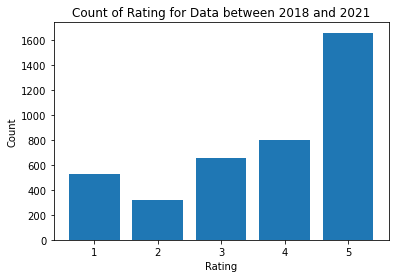

In [15]:
# Plot the count of different ratings for data between 2018 and 2021
youtube_ios_us_review_score_count = youtube_ios_us_review_YearMonth.groupby(['rating'])[['review']].nunique().rename(columns={'review':'count'})

plt.bar(youtube_ios_us_review_score_count.index,youtube_ios_us_review_score_count['count'])
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Count of Rating for Data between 2018 and 2021")
plt.show()

Text(0.5, 1.0, 'Count of Rating for Each Year between 2018 and 2021')

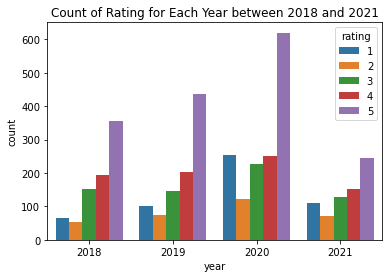

In [16]:
# Plot the count of different ratings for each year
youtube_ios_us_review_score_count_ByYear = (youtube_ios_us_review_YearMonth.groupby(['year','rating'])[['review']]
                                                                        .nunique()
                                                                        .rename(columns={'review':'count'})
                                                                        .reset_index()
                                              )

(sns.barplot(data=youtube_ios_us_review_score_count_ByYear,x='year',y='count',hue='rating')
   .set_title("Count of Rating for Each Year between 2018 and 2021")
)

# Comment: extreme review score on 1 or 5

In [17]:
# Understand average ratings over year
youtube_ios_us_review_avg_score_ByYear = (youtube_ios_us_review_YearMonth.groupby(['year'])[['rating']]
                                                                       .mean()
                                              )

youtube_ios_us_review_avg_score_ByYear['count'] = youtube_ios_us_review_score_count_ByYear.groupby('year')[['count']].sum().values

print('Average ratings and count of each year:')
youtube_ios_us_review_avg_score_ByYear

Average ratings and count of each year:


rating  count
year                 
2018  3.879415    821
2019  3.833333    960
2020  3.582768   1474
2021  3.496454    704

# Dataframe Preparation for Topic Modelling

In [18]:
# Dataframe with data between 2018 and 2021 without score or year filtering
youtube_ios_us_review_YearMonth.head()

date  \
240 2018-01-01   
241 2018-01-01   
242 2018-01-02   
243 2018-01-02   
244 2018-01-02   

                                                                                                                                                                                                      review  \
240  I gotta say you guys did great but there is two bugs I hate like when I am watching videos maybe occasionally I bump into me not being able to control the system so what happens is I try to exit o...   
241  The app is nice to have but misses a lot of features, like viewing options, the ability to go back sometimes, community tab, and critical features like being able to actually use search results - ...   
242  It is not working for me I have tried it and it says that is in my home screen but it’s not in my home screen and it’s a very nice apt hurt and play or not play but watch and You should really dow...   
243  For some reason my iPhone 7 (iPhone9,3) heats up and the battery goes down very quickly when watching even in 360p! It’s almost as if you were mining bitcoin in the background! It’s done this sinc...   
244  Sometimes when I’m watching a video, the video will freeze. Everything else works just fine, it’s just the video stops playing.  Whatever is on the screen at the time is what the video screen will...   

          userName  isEdited  \
240       mijioshi     False   
241       RioTorxx     False   
242        wally.0     False   
243  iPhoneGuy1101     False   
244      TwyiaBear     False   

                                                         title  rating  year  \
240                                       Two bug is all I get       5  2018   
241  Can’t click on Search Results and can’t see community tab       3  2018   
242                                          Why won’t it work       5  2018   
243                                 Good app, most of the time       4  2018   
244                                              Video Freezes       5  2018   

     month  
240      1  
241      1  
242      1  
243      1  
244      1

In [19]:
# Prepare dataframe for topic modelling for each score
# Obtain 5 dataframes with only score=1,2,3,4,5
youtube_ios_us_review_YearMonth_score1 = youtube_ios_us_review_YearMonth[youtube_ios_us_review_YearMonth['rating']==1]
youtube_ios_us_review_YearMonth_score2 = youtube_ios_us_review_YearMonth[youtube_ios_us_review_YearMonth['rating']==2]
youtube_ios_us_review_YearMonth_score3 = youtube_ios_us_review_YearMonth[youtube_ios_us_review_YearMonth['rating']==3]
youtube_ios_us_review_YearMonth_score4 = youtube_ios_us_review_YearMonth[youtube_ios_us_review_YearMonth['rating']==4]
youtube_ios_us_review_YearMonth_score5 = youtube_ios_us_review_YearMonth[youtube_ios_us_review_YearMonth['rating']==5]


In [20]:
# Prepare dataframe for grouped score
youtube_ios_us_review_YearMonth_score1N2N3 = youtube_ios_us_review_YearMonth[youtube_ios_us_review_YearMonth['rating'].isin([1,2,3])]
youtube_ios_us_review_YearMonth_score4N5 = youtube_ios_us_review_YearMonth[youtube_ios_us_review_YearMonth['rating'].isin([4,5])]


In [21]:
# Prepare dataframe for topic modelling for 2018,2019,2020,2021 for score = 1,2,3
youtube_ios_us_review_YearMonth_2018_score1N2N3 = youtube_ios_us_review_YearMonth[(youtube_ios_us_review_YearMonth['year']==2018)&(youtube_ios_us_review_YearMonth['rating'].isin([1,2,3]))]
youtube_ios_us_review_YearMonth_2019_score1N2N3 = youtube_ios_us_review_YearMonth[(youtube_ios_us_review_YearMonth['year']==2019)&(youtube_ios_us_review_YearMonth['rating'].isin([1,2,3]))]
youtube_ios_us_review_YearMonth_2020_score1N2N3 = youtube_ios_us_review_YearMonth[(youtube_ios_us_review_YearMonth['year']==2020)&(youtube_ios_us_review_YearMonth['rating'].isin([1,2,3]))]
youtube_ios_us_review_YearMonth_2021_score1N2N3 = youtube_ios_us_review_YearMonth[(youtube_ios_us_review_YearMonth['year']==2021)&(youtube_ios_us_review_YearMonth['rating'].isin([1,2,3]))]




# Overall LDA Topic Modelling

In [22]:
# Overall Topic Modelling - data between 2018 and 2021 without score or year filtering
# Convert to list - move to each section
review_us = youtube_ios_us_review_YearMonth.review.values.tolist()
review_words_us = list(sent_to_words(review_us))
print(review_words_us[:1])

[['gotta', 'say', 'you', 'guys', 'did', 'great', 'but', 'there', 'is', 'two', 'bugs', 'hate', 'like', 'when', 'am', 'watching', 'videos', 'maybe', 'occasionally', 'bump', 'into', 'me', 'not', 'being', 'able', 'to', 'control', 'the', 'system', 'so', 'what', 'happens', 'is', 'try', 'to', 'exit', 'out', 'of', 'the', 'video', 'and', 'it', 'does', 'nothing', 'and', 'the', 'second', 'bug', 'doesn', 'happen', 'as', 'often', 'what', 'happens', 'is', 'the', 'app', 'crashes', 'and', 'drives', 'me', 'crazy', 'but', 'at', 'least', 'it', 'lets', 'you', 'continue', 'from', 'where', 'you', 'were']]


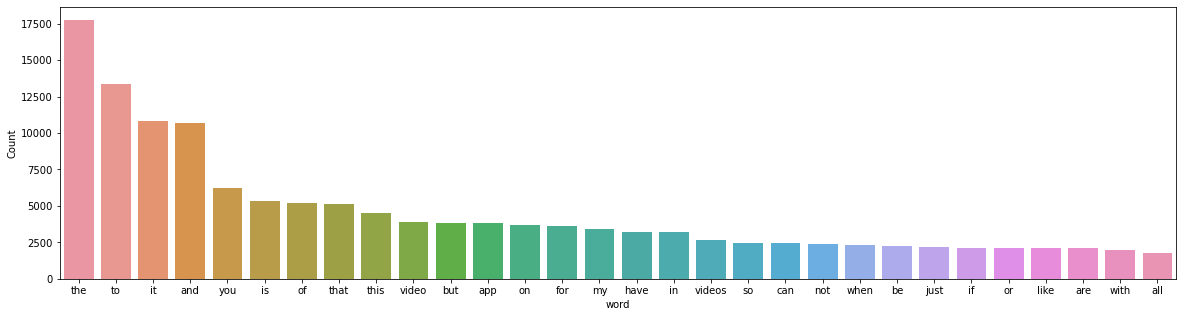

In [23]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us))

In [24]:
# Clean text
review_us_ready = process_words(review_words_us)  # processed Text Data! - move to each section

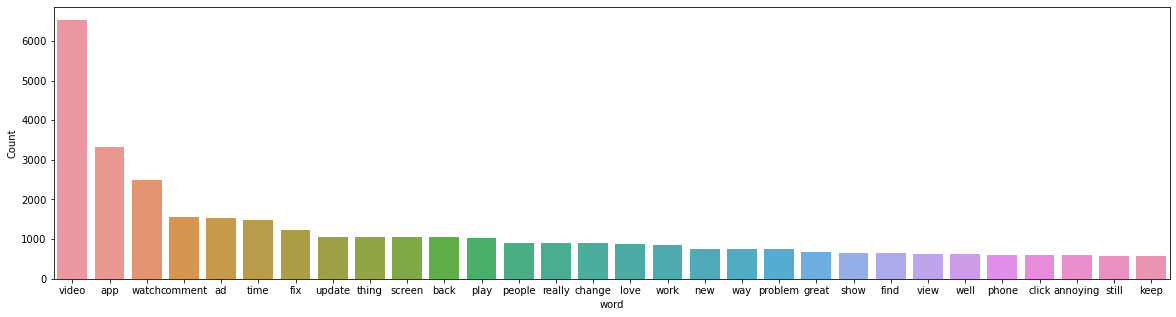

In [25]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready))

In [26]:
# Create Dictionary
id2word_us = corpora.Dictionary(review_us_ready)

2021-10-16 23:21:49,843 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 23:21:50,696 [INFO] gensim.corpora.dictionary - built Dictionary(7514 unique tokens: ['able', 'app', 'bug', 'bump', 'continue']...) from 3960 documents (total 135975 corpus positions)
2021-10-16 23:21:50,739 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(7514 unique tokens: ['able', 'app', 'bug', 'bump', 'continue']...) from 3960 documents (total 135975 corpus positions)", 'datetime': '2021-10-16T23:21:50.698052', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [27]:
# Create Corpus: Term Document Frequency
corpus_us = [id2word_us.doc2bow(text) for text in review_us_ready]

In [28]:
# Training LDA model
model_list_us, coherence_values_us = compute_coherence_values(dictionary=id2word_us, corpus=corpus_us, 
                                                              texts=review_us_ready, limit=30, start=2, step=5)

# Time Start: 03:44
# Time End: 
# Time Used: 

2021-10-16 23:21:51,158 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 23:21:51,162 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 23:21:51,173 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 23:21:51,225 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 3960 documents, updating model once every 1000 documents, evaluating perplexity every 3960 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 23:21:51,227 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1000/3960
2021-10-16 23:21:54,832 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:21:54,842 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.046*"video" + 0.035*"app" + 0.023*"watch" + 0.017*"screen" + 0.017*"fix" + 0.013*"time" + 0.013*"play" + 0.011*"update" + 0.009*"phone" + 0

2021-10-16 23:22:28,855 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.034*"video" + 0.021*"ad" + 0.018*"watch" + 0.011*"people" + 0.010*"app" + 0.009*"view" + 0.009*"thing" + 0.009*"love" + 0.008*"time" + 0.007*"tube"
2021-10-16 23:22:28,857 [INFO] gensim.models.ldamodel - topic diff=0.356590, rho=0.379049
2021-10-16 23:22:28,859 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #3000/3960
2021-10-16 23:22:31,257 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:22:31,261 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.055*"video" + 0.034*"app" + 0.025*"comment" + 0.016*"watch" + 0.014*"update" + 0.014*"fix" + 0.013*"time" + 0.012*"change" + 0.012*"screen" + 0.012*"back"
2021-10-16 23:22:31,264 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.030*"video" + 0.021*"ad" + 0.017*"watch" + 0.013*"people" + 0.010*"app" + 0.010*"view" + 0.008*"thing" + 0.008*"love" + 0.008*"time" + 0.007*"content"
2021-10-

2021-10-16 23:22:55,208 [INFO] gensim.models.ldamodel - topic diff=0.296542, rho=0.334077
2021-10-16 23:22:55,209 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #1000/3960
2021-10-16 23:22:56,730 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:22:56,760 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.065*"video" + 0.035*"app" + 0.020*"watch" + 0.015*"comment" + 0.015*"fix" + 0.014*"screen" + 0.012*"update" + 0.012*"time" + 0.012*"play" + 0.010*"back"
2021-10-16 23:22:56,765 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"ad" + 0.021*"video" + 0.014*"watch" + 0.013*"people" + 0.009*"thing" + 0.009*"love" + 0.008*"app" + 0.008*"tube" + 0.007*"content" + 0.007*"time"
2021-10-16 23:22:56,768 [INFO] gensim.models.ldamodel - topic diff=0.253867, rho=0.316862
2021-10-16 23:22:56,775 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #2000/3960
2021-10-16 23:22:58,312 [INFO] gensim.models.ld

2021-10-16 23:23:16,099 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.063*"video" + 0.034*"app" + 0.022*"comment" + 0.020*"watch" + 0.014*"fix" + 0.013*"update" + 0.013*"time" + 0.011*"screen" + 0.011*"back" + 0.011*"change"
2021-10-16 23:23:16,101 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.023*"ad" + 0.017*"video" + 0.015*"people" + 0.013*"watch" + 0.011*"view" + 0.009*"love" + 0.009*"thing" + 0.008*"content" + 0.008*"tube" + 0.007*"music"
2021-10-16 23:23:16,103 [INFO] gensim.models.ldamodel - topic diff=0.234334, rho=0.289157
2021-10-16 23:23:18,097 [INFO] gensim.models.ldamodel - -6.984 per-word bound, 126.6 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-16 23:23:18,098 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #3960/3960
2021-10-16 23:23:19,666 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-16 23:23:19,682 [INFO] gensim.models.ldamodel - topic #0 

2021-10-16 23:23:37,490 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.023*"ad" + 0.016*"video" + 0.014*"people" + 0.012*"watch" + 0.009*"love" + 0.009*"thing" + 0.008*"tube" + 0.008*"content" + 0.007*"view" + 0.007*"music"
2021-10-16 23:23:37,494 [INFO] gensim.models.ldamodel - topic diff=0.195807, rho=0.258544
2021-10-16 23:23:37,497 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #2000/3960
2021-10-16 23:23:39,310 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:23:39,314 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.067*"video" + 0.035*"app" + 0.022*"watch" + 0.015*"comment" + 0.014*"fix" + 0.013*"screen" + 0.013*"time" + 0.012*"update" + 0.012*"play" + 0.010*"back"
2021-10-16 23:23:39,316 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.022*"ad" + 0.016*"video" + 0.014*"people" + 0.013*"watch" + 0.010*"view" + 0.010*"love" + 0.009*"thing" + 0.008*"tube" + 0.008*"content" + 0.007*"music"
20

2021-10-16 23:23:59,462 [INFO] gensim.models.ldamodel - topic diff=0.191576, rho=0.242821
2021-10-16 23:24:01,408 [INFO] gensim.models.ldamodel - -6.974 per-word bound, 125.7 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-16 23:24:01,412 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #3960/3960
2021-10-16 23:24:02,953 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-16 23:24:02,959 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.063*"video" + 0.034*"app" + 0.020*"watch" + 0.019*"comment" + 0.013*"fix" + 0.012*"update" + 0.012*"time" + 0.011*"screen" + 0.010*"play" + 0.010*"back"
2021-10-16 23:24:02,961 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.022*"ad" + 0.015*"video" + 0.015*"people" + 0.012*"watch" + 0.010*"love" + 0.009*"thing" + 0.008*"view" + 0.008*"tube" + 0.008*"content" + 0.007*"music"
2021-10-16 23:24:02,962 [INFO] gensim.models.ldamodel - topic diff

2021-10-16 23:24:21,646 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #2000/3960
2021-10-16 23:24:23,537 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:24:23,566 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.067*"video" + 0.035*"app" + 0.022*"watch" + 0.015*"comment" + 0.014*"fix" + 0.013*"time" + 0.012*"screen" + 0.012*"update" + 0.011*"play" + 0.010*"back"
2021-10-16 23:24:23,568 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.020*"ad" + 0.015*"video" + 0.014*"people" + 0.012*"watch" + 0.010*"view" + 0.010*"love" + 0.009*"thing" + 0.009*"tube" + 0.008*"content" + 0.007*"music"
2021-10-16 23:24:23,571 [INFO] gensim.models.ldamodel - topic diff=0.182892, rho=0.223831
2021-10-16 23:24:23,572 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #3000/3960
2021-10-16 23:24:25,274 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16

2021-10-16 23:24:52,356 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-16 23:24:52,365 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.064*"video" + 0.034*"app" + 0.020*"watch" + 0.019*"comment" + 0.013*"fix" + 0.012*"time" + 0.012*"update" + 0.011*"screen" + 0.010*"play" + 0.010*"back"
2021-10-16 23:24:52,367 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.020*"ad" + 0.015*"people" + 0.014*"video" + 0.012*"watch" + 0.010*"love" + 0.009*"view" + 0.009*"thing" + 0.008*"tube" + 0.008*"content" + 0.007*"music"
2021-10-16 23:24:52,369 [INFO] gensim.models.ldamodel - topic diff=0.177553, rho=0.213395
2021-10-16 23:24:52,371 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #1000/3960
2021-10-16 23:24:53,970 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:24:53,975 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.065*"video" + 0.035*"app" + 0.021

2021-10-16 23:25:12,958 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.019*"ad" + 0.014*"people" + 0.014*"video" + 0.012*"watch" + 0.010*"view" + 0.010*"love" + 0.009*"tube" + 0.009*"thing" + 0.008*"content" + 0.007*"music"
2021-10-16 23:25:12,960 [INFO] gensim.models.ldamodel - topic diff=0.161057, rho=0.200160
2021-10-16 23:25:12,961 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #3000/3960
2021-10-16 23:25:14,339 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:25:14,348 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.064*"video" + 0.034*"app" + 0.021*"watch" + 0.020*"comment" + 0.013*"fix" + 0.013*"time" + 0.012*"update" + 0.011*"screen" + 0.011*"back" + 0.010*"play"
2021-10-16 23:25:14,351 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.019*"ad" + 0.015*"people" + 0.014*"video" + 0.011*"watch" + 0.010*"view" + 0.009*"love" + 0.008*"content" + 0.008*"thing" + 0.008*"tube" + 0.007*"music"
20

2021-10-16 23:25:33,554 [INFO] gensim.models.ldamodel - topic diff=0.158627, rho=0.192593
2021-10-16 23:25:33,560 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #1000/3960
2021-10-16 23:25:35,294 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:25:35,298 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.065*"video" + 0.035*"app" + 0.021*"watch" + 0.016*"comment" + 0.014*"fix" + 0.013*"screen" + 0.012*"time" + 0.012*"update" + 0.011*"play" + 0.010*"back"
2021-10-16 23:25:35,300 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.018*"ad" + 0.015*"people" + 0.013*"video" + 0.011*"watch" + 0.010*"love" + 0.009*"thing" + 0.009*"tube" + 0.008*"content" + 0.008*"view" + 0.007*"music"
2021-10-16 23:25:35,302 [INFO] gensim.models.ldamodel - topic diff=0.136081, rho=0.189117
2021-10-16 23:25:35,304 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #2000/3960
2021-10-16 23:25:37,047 [INFO] gensim.model

2021-10-16 23:25:56,359 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:25:56,363 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.064*"video" + 0.034*"app" + 0.021*"watch" + 0.019*"comment" + 0.013*"fix" + 0.013*"time" + 0.012*"update" + 0.011*"screen" + 0.011*"back" + 0.010*"play"
2021-10-16 23:25:56,365 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.018*"ad" + 0.015*"people" + 0.013*"video" + 0.011*"watch" + 0.010*"view" + 0.009*"love" + 0.009*"content" + 0.008*"thing" + 0.008*"tube" + 0.007*"music"
2021-10-16 23:25:56,367 [INFO] gensim.models.ldamodel - topic diff=0.139345, rho=0.182696
2021-10-16 23:25:58,626 [INFO] gensim.models.ldamodel - -6.963 per-word bound, 124.8 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-16 23:25:58,628 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #3960/3960
2021-10-16 23:26:00,368 [INFO] gensim.models.ldamodel - merging c

2021-10-16 23:26:18,318 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.065*"video" + 0.035*"app" + 0.021*"watch" + 0.016*"comment" + 0.014*"fix" + 0.012*"screen" + 0.012*"time" + 0.012*"update" + 0.011*"play" + 0.010*"back"
2021-10-16 23:26:18,321 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.018*"ad" + 0.015*"people" + 0.013*"video" + 0.011*"watch" + 0.010*"love" + 0.009*"tube" + 0.009*"thing" + 0.008*"view" + 0.008*"content" + 0.007*"music"
2021-10-16 23:26:18,323 [INFO] gensim.models.ldamodel - topic diff=0.124108, rho=0.174183
2021-10-16 23:26:18,325 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #2000/3960
2021-10-16 23:26:19,957 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:26:19,967 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.066*"video" + 0.035*"app" + 0.022*"watch" + 0.015*"comment" + 0.014*"fix" + 0.013*"time" + 0.012*"screen" + 0.011*"update" + 0.011*"play" + 0.010*"back"
20

2021-10-16 23:26:44,566 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.017*"ad" + 0.015*"people" + 0.013*"video" + 0.011*"watch" + 0.010*"view" + 0.009*"love" + 0.009*"content" + 0.008*"thing" + 0.008*"tube" + 0.007*"music"
2021-10-16 23:26:44,568 [INFO] gensim.models.ldamodel - topic diff=0.128038, rho=0.169128
2021-10-16 23:26:47,345 [INFO] gensim.models.ldamodel - -6.961 per-word bound, 124.6 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-16 23:26:47,346 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #3960/3960
2021-10-16 23:26:49,233 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-16 23:26:49,240 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.064*"video" + 0.034*"app" + 0.020*"watch" + 0.018*"comment" + 0.013*"fix" + 0.012*"time" + 0.012*"update" + 0.011*"screen" + 0.011*"play" + 0.010*"back"
2021-10-16 23:26:49,246 [INFO] gensim.models.ldamodel - topic #1 (

2021-10-16 23:27:07,471 [INFO] gensim.models.ldamodel - topic diff=0.114760, rho=0.162307
2021-10-16 23:27:07,473 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #2000/3960
2021-10-16 23:27:09,066 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:27:09,071 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.066*"video" + 0.035*"app" + 0.022*"watch" + 0.015*"comment" + 0.014*"fix" + 0.013*"time" + 0.012*"screen" + 0.011*"update" + 0.011*"play" + 0.010*"back"
2021-10-16 23:27:09,073 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.017*"ad" + 0.015*"people" + 0.013*"video" + 0.011*"watch" + 0.010*"view" + 0.010*"love" + 0.009*"tube" + 0.009*"thing" + 0.009*"content" + 0.007*"music"
2021-10-16 23:27:09,075 [INFO] gensim.models.ldamodel - topic diff=0.127596, rho=0.162307
2021-10-16 23:27:09,076 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #3000/3960
2021-10-16 23:27:10,911 [INFO] gensim.model

2021-10-16 23:27:32,318 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #3960/3960
2021-10-16 23:27:34,224 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-16 23:27:34,228 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.064*"video" + 0.034*"app" + 0.020*"watch" + 0.018*"comment" + 0.013*"fix" + 0.012*"time" + 0.012*"update" + 0.011*"screen" + 0.011*"play" + 0.010*"back"
2021-10-16 23:27:34,230 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.017*"ad" + 0.015*"people" + 0.013*"video" + 0.011*"watch" + 0.010*"love" + 0.009*"view" + 0.009*"tube" + 0.009*"thing" + 0.008*"content" + 0.007*"music"
2021-10-16 23:27:34,232 [INFO] gensim.models.ldamodel - topic diff=0.128099, rho=0.158193
2021-10-16 23:27:34,233 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #1000/3960
2021-10-16 23:27:35,656 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 

2021-10-16 23:27:55,968 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.066*"video" + 0.035*"app" + 0.022*"watch" + 0.016*"comment" + 0.014*"fix" + 0.013*"time" + 0.012*"screen" + 0.011*"update" + 0.011*"play" + 0.010*"back"
2021-10-16 23:27:55,971 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.016*"ad" + 0.015*"people" + 0.013*"video" + 0.011*"watch" + 0.010*"view" + 0.010*"love" + 0.009*"tube" + 0.009*"thing" + 0.009*"content" + 0.007*"music"
2021-10-16 23:27:55,974 [INFO] gensim.models.ldamodel - topic diff=0.119236, rho=0.152570
2021-10-16 23:27:55,978 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #3000/3960
2021-10-16 23:27:57,549 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:27:57,561 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.064*"video" + 0.034*"app" + 0.021*"watch" + 0.019*"comment" + 0.013*"fix" + 0.013*"time" + 0.012*"update" + 0.011*"screen" + 0.011*"play" + 0.010*"back"
20

2021-10-16 23:28:18,726 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.017*"ad" + 0.015*"people" + 0.013*"video" + 0.011*"watch" + 0.010*"love" + 0.009*"view" + 0.009*"tube" + 0.009*"thing" + 0.009*"content" + 0.007*"music"
2021-10-16 23:28:18,727 [INFO] gensim.models.ldamodel - topic diff=0.120203, rho=0.149137
2021-10-16 23:28:18,729 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #1000/3960
2021-10-16 23:28:20,090 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:28:20,094 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.065*"video" + 0.034*"app" + 0.021*"watch" + 0.016*"comment" + 0.014*"fix" + 0.012*"time" + 0.012*"screen" + 0.012*"update" + 0.011*"play" + 0.010*"back"
2021-10-16 23:28:20,095 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.016*"ad" + 0.015*"people" + 0.013*"video" + 0.011*"watch" + 0.010*"love" + 0.009*"tube" + 0.009*"thing" + 0.009*"view" + 0.008*"content" + 0.007*"music"
20

2021-10-16 23:28:37,357 [INFO] gensim.models.ldamodel - topic diff=0.112299, rho=0.144398
2021-10-16 23:28:37,359 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #3000/3960
2021-10-16 23:28:39,154 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:28:39,189 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.064*"video" + 0.034*"app" + 0.021*"watch" + 0.019*"comment" + 0.013*"fix" + 0.013*"time" + 0.012*"update" + 0.011*"screen" + 0.011*"play" + 0.010*"back"
2021-10-16 23:28:39,213 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.016*"ad" + 0.015*"people" + 0.013*"video" + 0.011*"watch" + 0.010*"view" + 0.010*"love" + 0.009*"content" + 0.008*"tube" + 0.008*"thing" + 0.007*"music"
2021-10-16 23:28:39,215 [INFO] gensim.models.ldamodel - topic diff=0.107804, rho=0.144398
2021-10-16 23:28:41,475 [INFO] gensim.models.ldamodel - -6.956 per-word bound, 124.2 perplexity estimate based on a held-out corpus of 960 do

2021-10-16 23:29:00,735 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #1000/3960
2021-10-16 23:29:02,229 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:29:02,232 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.065*"video" + 0.034*"app" + 0.021*"watch" + 0.016*"comment" + 0.014*"fix" + 0.012*"time" + 0.012*"screen" + 0.012*"update" + 0.011*"play" + 0.010*"back"
2021-10-16 23:29:02,235 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.016*"ad" + 0.015*"people" + 0.013*"video" + 0.011*"watch" + 0.010*"love" + 0.009*"tube" + 0.009*"view" + 0.009*"thing" + 0.008*"content" + 0.007*"music"
2021-10-16 23:29:02,236 [INFO] gensim.models.ldamodel - topic diff=0.097661, rho=0.140083
2021-10-16 23:29:02,237 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #2000/3960
2021-10-16 23:29:03,901 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16

2021-10-16 23:29:24,824 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.064*"video" + 0.034*"app" + 0.021*"watch" + 0.019*"comment" + 0.013*"fix" + 0.013*"time" + 0.012*"update" + 0.011*"screen" + 0.011*"play" + 0.010*"back"
2021-10-16 23:29:24,830 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.016*"ad" + 0.015*"people" + 0.013*"video" + 0.011*"watch" + 0.010*"view" + 0.010*"love" + 0.009*"content" + 0.009*"tube" + 0.008*"thing" + 0.007*"music"
2021-10-16 23:29:24,831 [INFO] gensim.models.ldamodel - topic diff=0.102180, rho=0.137412
2021-10-16 23:29:27,063 [INFO] gensim.models.ldamodel - -6.955 per-word bound, 124.1 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-16 23:29:27,064 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #3960/3960
2021-10-16 23:29:28,843 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-16 23:29:28,849 [INFO] gensim.models.ldamodel - topic #0 (

2021-10-16 23:30:12,039 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.052*"video" + 0.025*"watch" + 0.012*"home" + 0.012*"app" + 0.011*"click" + 0.011*"channel" + 0.010*"change" + 0.010*"ad" + 0.009*"back" + 0.008*"button"
2021-10-16 23:30:12,045 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.072*"video" + 0.028*"watch" + 0.018*"app" + 0.011*"tube" + 0.010*"feature" + 0.009*"playlist" + 0.009*"view" + 0.009*"ad" + 0.008*"add" + 0.008*"thing"
2021-10-16 23:30:12,048 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.037*"video" + 0.023*"comment" + 0.021*"time" + 0.019*"app" + 0.018*"screen" + 0.015*"ad" + 0.011*"fix" + 0.011*"view" + 0.010*"back" + 0.010*"really"
2021-10-16 23:30:12,051 [INFO] gensim.models.ldamodel - topic diff=0.773253, rho=0.707107
2021-10-16 23:30:12,058 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #3000/3960
2021-10-16 23:30:14,713 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10

2021-10-16 23:30:31,323 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #3960/3960
2021-10-16 23:30:33,509 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-16 23:30:33,525 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.061*"video" + 0.022*"watch" + 0.021*"playlist" + 0.013*"add" + 0.010*"app" + 0.010*"ad" + 0.009*"view" + 0.009*"find" + 0.008*"tube" + 0.008*"new"
2021-10-16 23:30:33,528 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.049*"app" + 0.026*"video" + 0.018*"ad" + 0.018*"watch" + 0.016*"time" + 0.011*"update" + 0.010*"work" + 0.009*"fix" + 0.008*"phone" + 0.007*"give"
2021-10-16 23:30:33,531 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.089*"video" + 0.026*"app" + 0.025*"watch" + 0.017*"fix" + 0.017*"play" + 0.016*"screen" + 0.013*"back" + 0.012*"update" + 0.012*"time" + 0.011*"problem"
2021-10-16 23:30:33,534 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.031*"video" + 0.023*"change" +

2021-10-16 23:30:45,873 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.027*"people" + 0.023*"tube" + 0.015*"ad" + 0.013*"thing" + 0.012*"love" + 0.011*"life" + 0.011*"platform" + 0.010*"learn" + 0.010*"content" + 0.009*"world"
2021-10-16 23:30:45,875 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.028*"change" + 0.022*"video" + 0.020*"quality" + 0.016*"channel" + 0.015*"option" + 0.014*"home" + 0.013*"tv" + 0.013*"picture" + 0.011*"page" + 0.011*"watch"
2021-10-16 23:30:45,877 [INFO] gensim.models.ldamodel - topic diff=0.260423, rho=0.354441
2021-10-16 23:30:45,878 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #2000/3960
2021-10-16 23:30:47,519 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:30:47,544 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.095*"video" + 0.032*"app" + 0.029*"watch" + 0.023*"screen" + 0.020*"fix" + 0.019*"play" + 0.013*"time" + 0.013*"back" + 0.013*"update" + 0.011*"pro

2021-10-16 23:31:00,782 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.022*"kid" + 0.022*"love" + 0.013*"music" + 0.012*"thing" + 0.011*"people" + 0.011*"channel" + 0.011*"much" + 0.010*"song" + 0.009*"let" + 0.009*"live"
2021-10-16 23:31:00,784 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.032*"change" + 0.020*"channel" + 0.017*"quality" + 0.015*"home" + 0.015*"option" + 0.015*"picture" + 0.013*"video" + 0.012*"tv" + 0.011*"tab" + 0.010*"community"
2021-10-16 23:31:00,788 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.053*"app" + 0.030*"ad" + 0.020*"video" + 0.018*"watch" + 0.016*"time" + 0.010*"work" + 0.009*"update" + 0.008*"download" + 0.007*"pay" + 0.007*"great"
2021-10-16 23:31:00,789 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.029*"people" + 0.026*"tube" + 0.012*"life" + 0.011*"learn" + 0.011*"love" + 0.011*"content" + 0.011*"platform" + 0.010*"thing" + 0.010*"child" + 0.009*"world"
2021-10-16 23:31:00,791 [INFO] gensim.models.ldamodel - topic #2 (0.143):

2021-10-16 23:31:16,250 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.097*"comment" + 0.031*"section" + 0.024*"change" + 0.016*"back" + 0.014*"video" + 0.014*"scroll" + 0.013*"move" + 0.011*"new" + 0.011*"way" + 0.010*"read"
2021-10-16 23:31:16,252 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.058*"video" + 0.025*"playlist" + 0.020*"view" + 0.019*"watch" + 0.016*"add" + 0.011*"delete" + 0.011*"find" + 0.008*"show" + 0.008*"remove" + 0.007*"content"
2021-10-16 23:31:16,253 [INFO] gensim.models.ldamodel - topic diff=0.168835, rho=0.316862
2021-10-16 23:31:16,255 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #1000/3960
2021-10-16 23:31:17,962 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:31:17,971 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.029*"tube" + 0.027*"people" + 0.012*"platform" + 0.012*"thing" + 0.012*"learn" + 0.011*"life" + 0.011*"love" + 0.011*"content" + 0.010*"world" + 0.00

2021-10-16 23:31:33,364 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.037*"change" + 0.025*"quality" + 0.023*"channel" + 0.018*"picture" + 0.016*"option" + 0.015*"tv" + 0.012*"tab" + 0.012*"community" + 0.011*"profile" + 0.011*"home"
2021-10-16 23:31:33,367 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.025*"love" + 0.024*"kid" + 0.013*"channel" + 0.012*"thing" + 0.012*"music" + 0.012*"much" + 0.011*"live" + 0.010*"let" + 0.010*"people" + 0.009*"watch"
2021-10-16 23:31:33,369 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.097*"video" + 0.035*"app" + 0.030*"watch" + 0.023*"screen" + 0.021*"fix" + 0.018*"play" + 0.014*"update" + 0.014*"time" + 0.012*"back" + 0.011*"problem"
2021-10-16 23:31:33,371 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.056*"video" + 0.025*"view" + 0.023*"playlist" + 0.019*"watch" + 0.015*"add" + 0.014*"delete" + 0.010*"find" + 0.008*"show" + 0.008*"song" + 0.008*"content"
2021-10-16 23:31:33,372 [INFO] gensim.models.ldamodel - topic #3 (0.143

2021-10-16 23:31:46,156 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.097*"video" + 0.036*"app" + 0.030*"watch" + 0.021*"screen" + 0.021*"fix" + 0.017*"play" + 0.015*"update" + 0.014*"time" + 0.013*"back" + 0.011*"problem"
2021-10-16 23:31:46,160 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.054*"video" + 0.028*"view" + 0.021*"playlist" + 0.017*"watch" + 0.015*"delete" + 0.014*"add" + 0.010*"find" + 0.008*"content" + 0.008*"hard" + 0.008*"people"
2021-10-16 23:31:46,161 [INFO] gensim.models.ldamodel - topic diff=0.134108, rho=0.277778
2021-10-16 23:31:48,635 [INFO] gensim.models.ldamodel - -7.122 per-word bound, 139.3 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-16 23:31:48,637 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #3960/3960
2021-10-16 23:31:51,210 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-16 23:31:51,227 [INFO] gensim.models.ldamodel - topic 

2021-10-16 23:32:05,517 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #1000/3960
2021-10-16 23:32:07,384 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:32:07,391 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.032*"tube" + 0.027*"people" + 0.012*"learn" + 0.012*"platform" + 0.011*"thing" + 0.011*"life" + 0.010*"content" + 0.010*"world" + 0.010*"love" + 0.009*"child"
2021-10-16 23:32:07,393 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.098*"comment" + 0.030*"section" + 0.026*"change" + 0.017*"back" + 0.015*"scroll" + 0.013*"move" + 0.012*"new" + 0.012*"video" + 0.011*"way" + 0.011*"update"
2021-10-16 23:32:07,396 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.095*"video" + 0.037*"app" + 0.029*"watch" + 0.023*"screen" + 0.022*"fix" + 0.018*"play" + 0.015*"update" + 0.013*"time" + 0.012*"problem" + 0.011*"back"
2021-10-16 23:32:07,397 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.054*"v

2021-10-16 23:32:21,009 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.041*"change" + 0.027*"quality" + 0.024*"channel" + 0.018*"picture" + 0.016*"option" + 0.016*"tv" + 0.013*"community" + 0.013*"tab" + 0.012*"profile" + 0.011*"post"
2021-10-16 23:32:21,016 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.096*"video" + 0.037*"app" + 0.030*"watch" + 0.022*"screen" + 0.021*"fix" + 0.018*"play" + 0.014*"update" + 0.014*"time" + 0.012*"back" + 0.012*"problem"
2021-10-16 23:32:21,020 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.054*"video" + 0.028*"view" + 0.024*"playlist" + 0.017*"watch" + 0.015*"delete" + 0.014*"add" + 0.011*"find" + 0.009*"content" + 0.009*"song" + 0.008*"show"
2021-10-16 23:32:21,024 [INFO] gensim.models.ldamodel - topic diff=0.104861, rho=0.250313
2021-10-16 23:32:21,026 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #3000/3960
2021-10-16 23:32:23,561 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 396

2021-10-16 23:32:33,379 [INFO] gensim.models.ldamodel - topic diff=0.111688, rho=0.242821
2021-10-16 23:32:35,786 [INFO] gensim.models.ldamodel - -7.107 per-word bound, 137.8 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-16 23:32:35,787 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #3960/3960
2021-10-16 23:32:37,739 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-16 23:32:37,745 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.032*"tube" + 0.028*"people" + 0.012*"platform" + 0.011*"learn" + 0.011*"life" + 0.011*"content" + 0.010*"world" + 0.009*"thing" + 0.009*"love" + 0.009*"child"
2021-10-16 23:32:37,747 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.096*"video" + 0.037*"app" + 0.029*"watch" + 0.021*"fix" + 0.020*"screen" + 0.017*"play" + 0.016*"update" + 0.014*"time" + 0.012*"back" + 0.012*"problem"
2021-10-16 23:32:37,749 [INFO] gensim.models.ldamodel - topi

2021-10-16 23:32:49,155 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.042*"change" + 0.031*"quality" + 0.023*"channel" + 0.018*"picture" + 0.017*"tv" + 0.016*"option" + 0.015*"community" + 0.013*"high" + 0.012*"post" + 0.012*"resolution"
2021-10-16 23:32:49,157 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.048*"ad" + 0.047*"app" + 0.021*"video" + 0.020*"watch" + 0.017*"time" + 0.009*"download" + 0.008*"thing" + 0.008*"pay" + 0.008*"minute" + 0.008*"great"
2021-10-16 23:32:49,160 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.094*"video" + 0.038*"app" + 0.029*"watch" + 0.023*"screen" + 0.022*"fix" + 0.018*"play" + 0.015*"update" + 0.014*"time" + 0.012*"problem" + 0.011*"back"
2021-10-16 23:32:49,163 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.100*"comment" + 0.031*"section" + 0.027*"change" + 0.018*"back" + 0.015*"scroll" + 0.014*"move" + 0.013*"new" + 0.012*"update" + 0.012*"way" + 0.010*"video"
2021-10-16 23:32:49,165 [INFO] gensim.models.ldamodel - topic diff

2021-10-16 23:33:00,149 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.035*"tube" + 0.026*"people" + 0.013*"learn" + 0.011*"life" + 0.011*"platform" + 0.011*"world" + 0.010*"content" + 0.010*"thing" + 0.010*"utube" + 0.010*"child"
2021-10-16 23:33:00,150 [INFO] gensim.models.ldamodel - topic diff=0.090487, rho=0.223831
2021-10-16 23:33:00,153 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #3000/3960
2021-10-16 23:33:02,042 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:33:02,052 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.027*"love" + 0.026*"kid" + 0.014*"channel" + 0.014*"watch" + 0.014*"thing" + 0.012*"people" + 0.012*"much" + 0.012*"music" + 0.011*"let" + 0.010*"live"
2021-10-16 23:33:02,054 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.051*"video" + 0.030*"view" + 0.023*"playlist" + 0.016*"delete" + 0.014*"watch" + 0.013*"add" + 0.011*"find" + 0.010*"content" + 0.009*"hard" + 0.009*

2021-10-16 23:33:15,048 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.033*"tube" + 0.027*"people" + 0.011*"learn" + 0.011*"platform" + 0.011*"life" + 0.010*"content" + 0.010*"world" + 0.009*"child" + 0.009*"utube" + 0.009*"love"
2021-10-16 23:33:15,053 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.095*"video" + 0.039*"app" + 0.029*"watch" + 0.021*"fix" + 0.020*"screen" + 0.017*"play" + 0.016*"update" + 0.014*"time" + 0.012*"problem" + 0.012*"back"
2021-10-16 23:33:15,055 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.052*"video" + 0.027*"playlist" + 0.026*"view" + 0.014*"delete" + 0.013*"add" + 0.013*"watch" + 0.011*"find" + 0.010*"content" + 0.008*"show" + 0.008*"people"
2021-10-16 23:33:15,060 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.028*"love" + 0.025*"kid" + 0.015*"thing" + 0.015*"watch" + 0.014*"channel" + 0.012*"much" + 0.012*"people" + 0.012*"music" + 0.012*"let" + 0.010*"day"
2021-10-16 23:33:15,064 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0

2021-10-16 23:33:26,479 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.033*"tube" + 0.025*"people" + 0.012*"learn" + 0.011*"life" + 0.011*"platform" + 0.011*"world" + 0.010*"content" + 0.009*"thing" + 0.009*"love" + 0.009*"child"
2021-10-16 23:33:26,482 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.093*"video" + 0.039*"app" + 0.029*"watch" + 0.022*"screen" + 0.022*"fix" + 0.017*"play" + 0.015*"update" + 0.014*"time" + 0.012*"problem" + 0.011*"back"
2021-10-16 23:33:26,484 [INFO] gensim.models.ldamodel - topic diff=0.111406, rho=0.208696
2021-10-16 23:33:26,486 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #2000/3960
2021-10-16 23:33:28,625 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:33:28,633 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.094*"video" + 0.039*"app" + 0.030*"watch" + 0.022*"screen" + 0.021*"fix" + 0.017*"play" + 0.015*"update" + 0.014*"time" + 0.012*"problem" + 0.012*"ba

2021-10-16 23:33:41,730 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.033*"tube" + 0.026*"people" + 0.012*"learn" + 0.010*"platform" + 0.010*"world" + 0.010*"life" + 0.010*"content" + 0.010*"child" + 0.009*"utube" + 0.009*"love"
2021-10-16 23:33:41,733 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.050*"video" + 0.031*"view" + 0.023*"playlist" + 0.016*"delete" + 0.013*"watch" + 0.013*"add" + 0.011*"find" + 0.011*"content" + 0.009*"hard" + 0.009*"people"
2021-10-16 23:33:41,735 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.104*"comment" + 0.034*"section" + 0.029*"change" + 0.020*"back" + 0.017*"scroll" + 0.015*"move" + 0.015*"new" + 0.013*"update" + 0.012*"way" + 0.011*"top"
2021-10-16 23:33:41,738 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.028*"love" + 0.026*"kid" + 0.016*"watch" + 0.015*"thing" + 0.014*"channel" + 0.013*"people" + 0.013*"much" + 0.011*"music" + 0.011*"let" + 0.011*"day"
2021-10-16 23:33:41,741 [INFO] gensim.models.ldamodel - topic #6 (0.143):

2021-10-16 23:33:56,435 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.051*"video" + 0.027*"playlist" + 0.027*"view" + 0.014*"delete" + 0.013*"add" + 0.012*"watch" + 0.011*"find" + 0.011*"content" + 0.008*"people" + 0.008*"show"
2021-10-16 23:33:56,437 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.029*"love" + 0.025*"kid" + 0.016*"watch" + 0.016*"thing" + 0.014*"channel" + 0.013*"people" + 0.012*"much" + 0.012*"let" + 0.011*"music" + 0.011*"day"
2021-10-16 23:33:56,439 [INFO] gensim.models.ldamodel - topic diff=0.091508, rho=0.200160
2021-10-16 23:33:56,441 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #1000/3960
2021-10-16 23:33:58,030 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:33:58,037 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.101*"comment" + 0.032*"section" + 0.028*"change" + 0.018*"back" + 0.015*"scroll" + 0.014*"move" + 0.014*"new" + 0.013*"update" + 0.012*"way" + 0.010*"re

2021-10-16 23:34:08,899 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.099*"comment" + 0.029*"section" + 0.027*"change" + 0.018*"back" + 0.016*"scroll" + 0.013*"new" + 0.013*"move" + 0.012*"update" + 0.012*"way" + 0.010*"read"
2021-10-16 23:34:08,904 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.052*"ad" + 0.043*"app" + 0.023*"video" + 0.020*"watch" + 0.016*"time" + 0.009*"download" + 0.008*"pay" + 0.008*"thing" + 0.008*"minute" + 0.008*"really"
2021-10-16 23:34:08,906 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.050*"video" + 0.029*"view" + 0.026*"playlist" + 0.015*"delete" + 0.013*"add" + 0.013*"watch" + 0.011*"find" + 0.011*"content" + 0.009*"song" + 0.008*"people"
2021-10-16 23:34:08,908 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.044*"change" + 0.029*"quality" + 0.026*"channel" + 0.019*"picture" + 0.017*"tv" + 0.016*"option" + 0.015*"community" + 0.012*"post" + 0.012*"tab" + 0.012*"profile"
2021-10-16 23:34:08,911 [INFO] gensim.models.ldamodel - topic #0 

2021-10-16 23:34:19,353 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.029*"love" + 0.026*"kid" + 0.018*"watch" + 0.016*"thing" + 0.014*"channel" + 0.013*"people" + 0.013*"much" + 0.011*"day" + 0.011*"music" + 0.011*"let"
2021-10-16 23:34:19,355 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.043*"change" + 0.027*"quality" + 0.026*"channel" + 0.018*"picture" + 0.017*"tv" + 0.016*"option" + 0.016*"community" + 0.012*"post" + 0.012*"tab" + 0.011*"high"
2021-10-16 23:34:19,357 [INFO] gensim.models.ldamodel - topic diff=0.082750, rho=0.189117
2021-10-16 23:34:22,133 [INFO] gensim.models.ldamodel - -7.088 per-word bound, 136.0 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-16 23:34:22,135 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #3960/3960
2021-10-16 23:34:24,684 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-16 23:34:24,691 [INFO] gensim.models.ldamodel - topi

2021-10-16 23:34:34,659 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #1000/3960
2021-10-16 23:34:36,280 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:34:36,288 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.034*"tube" + 0.025*"people" + 0.012*"learn" + 0.011*"world" + 0.011*"platform" + 0.010*"content" + 0.009*"life" + 0.009*"child" + 0.009*"utube" + 0.009*"thing"
2021-10-16 23:34:36,290 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.029*"love" + 0.024*"kid" + 0.018*"watch" + 0.017*"thing" + 0.014*"channel" + 0.013*"much" + 0.013*"people" + 0.012*"let" + 0.011*"day" + 0.011*"music"
2021-10-16 23:34:36,292 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.102*"comment" + 0.032*"section" + 0.028*"change" + 0.018*"back" + 0.015*"scroll" + 0.014*"move" + 0.014*"new" + 0.013*"update" + 0.012*"way" + 0.010*"top"
2021-10-16 23:34:36,295 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.053*"ad" 

2021-10-16 23:34:47,773 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.035*"tube" + 0.025*"people" + 0.013*"learn" + 0.011*"world" + 0.011*"platform" + 0.010*"content" + 0.010*"utube" + 0.010*"child" + 0.009*"life" + 0.008*"thing"
2021-10-16 23:34:47,776 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.050*"video" + 0.029*"view" + 0.026*"playlist" + 0.015*"delete" + 0.013*"add" + 0.012*"watch" + 0.011*"content" + 0.011*"find" + 0.009*"song" + 0.008*"people"
2021-10-16 23:34:47,777 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.030*"love" + 0.025*"kid" + 0.018*"watch" + 0.017*"thing" + 0.015*"channel" + 0.014*"much" + 0.013*"people" + 0.012*"day" + 0.011*"let" + 0.011*"live"
2021-10-16 23:34:47,778 [INFO] gensim.models.ldamodel - topic diff=0.069061, rho=0.179721
2021-10-16 23:34:47,780 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #3000/3960
2021-10-16 23:34:49,707 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 doc

2021-10-16 23:35:00,330 [INFO] gensim.models.ldamodel - topic diff=0.076683, rho=0.176887
2021-10-16 23:35:02,919 [INFO] gensim.models.ldamodel - -7.084 per-word bound, 135.7 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-16 23:35:02,921 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #3960/3960
2021-10-16 23:35:05,133 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-16 23:35:05,144 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.055*"ad" + 0.042*"app" + 0.023*"video" + 0.019*"watch" + 0.016*"time" + 0.009*"download" + 0.008*"pay" + 0.008*"thing" + 0.008*"minute" + 0.007*"long"
2021-10-16 23:35:05,147 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.050*"video" + 0.028*"playlist" + 0.027*"view" + 0.014*"delete" + 0.012*"add" + 0.011*"watch" + 0.011*"content" + 0.011*"find" + 0.008*"people" + 0.008*"show"
2021-10-16 23:35:05,150 [INFO] gensim.models.ldamodel - topic #

2021-10-16 23:35:16,802 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.054*"ad" + 0.043*"app" + 0.023*"video" + 0.019*"watch" + 0.016*"time" + 0.009*"download" + 0.008*"pay" + 0.008*"thing" + 0.008*"minute" + 0.007*"long"
2021-10-16 23:35:16,807 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.092*"video" + 0.040*"app" + 0.029*"watch" + 0.022*"fix" + 0.022*"screen" + 0.017*"play" + 0.016*"update" + 0.014*"time" + 0.012*"problem" + 0.011*"back"
2021-10-16 23:35:16,809 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.030*"love" + 0.024*"kid" + 0.019*"watch" + 0.017*"thing" + 0.014*"channel" + 0.013*"much" + 0.013*"people" + 0.012*"day" + 0.012*"let" + 0.011*"music"
2021-10-16 23:35:16,812 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.102*"comment" + 0.032*"section" + 0.028*"change" + 0.019*"back" + 0.015*"scroll" + 0.014*"move" + 0.014*"new" + 0.013*"update" + 0.012*"way" + 0.010*"top"
2021-10-16 23:35:16,813 [INFO] gensim.models.ldamodel - topic diff=0.088798, rho=0.171

2021-10-16 23:35:27,284 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.030*"love" + 0.025*"kid" + 0.019*"watch" + 0.017*"thing" + 0.015*"channel" + 0.014*"much" + 0.013*"people" + 0.012*"day" + 0.011*"let" + 0.011*"music"
2021-10-16 23:35:27,285 [INFO] gensim.models.ldamodel - topic diff=0.064197, rho=0.169128
2021-10-16 23:35:27,287 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #3000/3960
2021-10-16 23:35:28,948 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:35:28,965 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.105*"comment" + 0.034*"section" + 0.030*"change" + 0.020*"back" + 0.017*"scroll" + 0.015*"move" + 0.015*"new" + 0.014*"update" + 0.012*"way" + 0.011*"top"
2021-10-16 23:35:28,967 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.054*"ad" + 0.043*"app" + 0.023*"video" + 0.019*"watch" + 0.016*"time" + 0.009*"download" + 0.009*"pay" + 0.008*"thing" + 0.008*"minute" + 0.007*"long"
2021

2021-10-16 23:35:43,149 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.030*"love" + 0.025*"kid" + 0.020*"watch" + 0.018*"thing" + 0.014*"channel" + 0.014*"people" + 0.013*"much" + 0.012*"day" + 0.012*"let" + 0.011*"music"
2021-10-16 23:35:43,151 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.056*"ad" + 0.042*"app" + 0.023*"video" + 0.019*"watch" + 0.016*"time" + 0.009*"download" + 0.008*"pay" + 0.008*"thing" + 0.008*"minute" + 0.007*"long"
2021-10-16 23:35:43,153 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.049*"video" + 0.028*"playlist" + 0.028*"view" + 0.015*"delete" + 0.012*"add" + 0.011*"content" + 0.011*"watch" + 0.011*"find" + 0.008*"people" + 0.008*"channel"
2021-10-16 23:35:43,155 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.044*"change" + 0.031*"quality" + 0.025*"channel" + 0.019*"picture" + 0.017*"community" + 0.017*"option" + 0.016*"tv" + 0.014*"post" + 0.013*"high" + 0.012*"resolution"
2021-10-16 23:35:43,157 [INFO] gensim.models.ldamodel - topic #5 

2021-10-16 23:35:54,058 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.034*"tube" + 0.025*"people" + 0.011*"learn" + 0.011*"world" + 0.011*"platform" + 0.010*"content" + 0.009*"child" + 0.009*"utube" + 0.009*"life" + 0.008*"thing"
2021-10-16 23:35:54,060 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.030*"love" + 0.024*"kid" + 0.019*"watch" + 0.018*"thing" + 0.014*"channel" + 0.014*"people" + 0.013*"much" + 0.012*"day" + 0.012*"let" + 0.011*"music"
2021-10-16 23:35:54,061 [INFO] gensim.models.ldamodel - topic diff=0.083358, rho=0.162307
2021-10-16 23:35:54,064 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #2000/3960
2021-10-16 23:35:55,780 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:35:55,789 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.045*"change" + 0.029*"quality" + 0.025*"channel" + 0.019*"picture" + 0.018*"tv" + 0.016*"option" + 0.016*"community" + 0.013*"post" + 0.012*"tab" + 0.

2021-10-16 23:36:07,924 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:36:07,937 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.034*"tube" + 0.026*"people" + 0.012*"learn" + 0.011*"world" + 0.010*"platform" + 0.010*"child" + 0.010*"content" + 0.009*"utube" + 0.008*"life" + 0.008*"love"
2021-10-16 23:36:07,941 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.093*"video" + 0.041*"app" + 0.029*"watch" + 0.021*"fix" + 0.020*"screen" + 0.016*"update" + 0.016*"play" + 0.014*"time" + 0.012*"problem" + 0.012*"back"
2021-10-16 23:36:07,943 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.030*"love" + 0.025*"kid" + 0.020*"watch" + 0.018*"thing" + 0.014*"channel" + 0.014*"people" + 0.013*"much" + 0.012*"day" + 0.011*"music" + 0.011*"let"
2021-10-16 23:36:07,945 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.104*"comment" + 0.034*"section" + 0.030*"change" + 0.020*"back" + 0.017*"scroll" + 0.015*"move" + 0.015*"new" 

2021-10-16 23:36:21,096 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.049*"video" + 0.028*"playlist" + 0.028*"view" + 0.015*"delete" + 0.012*"add" + 0.012*"content" + 0.011*"find" + 0.011*"watch" + 0.008*"people" + 0.008*"channel"
2021-10-16 23:36:21,100 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.031*"love" + 0.025*"kid" + 0.020*"watch" + 0.018*"thing" + 0.014*"channel" + 0.014*"people" + 0.013*"much" + 0.012*"day" + 0.011*"let" + 0.011*"music"
2021-10-16 23:36:21,105 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.104*"comment" + 0.033*"section" + 0.029*"change" + 0.019*"back" + 0.016*"scroll" + 0.015*"move" + 0.014*"new" + 0.014*"update" + 0.012*"way" + 0.010*"top"
2021-10-16 23:36:21,106 [INFO] gensim.models.ldamodel - topic diff=0.070687, rho=0.158193
2021-10-16 23:36:21,109 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #1000/3960
2021-10-16 23:36:22,929 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 docu

2021-10-16 23:36:33,294 [INFO] gensim.models.ldamodel - topic diff=0.078856, rho=0.154377
2021-10-16 23:36:33,297 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #2000/3960
2021-10-16 23:36:35,658 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:36:35,678 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.093*"video" + 0.041*"app" + 0.030*"watch" + 0.021*"fix" + 0.021*"screen" + 0.017*"play" + 0.016*"update" + 0.014*"time" + 0.012*"problem" + 0.011*"back"
2021-10-16 23:36:35,681 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.049*"video" + 0.029*"view" + 0.026*"playlist" + 0.016*"delete" + 0.012*"add" + 0.012*"content" + 0.011*"watch" + 0.011*"find" + 0.009*"song" + 0.008*"channel"
2021-10-16 23:36:35,683 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.031*"love" + 0.025*"kid" + 0.020*"watch" + 0.018*"thing" + 0.015*"channel" + 0.014*"much" + 0.014*"people" + 0.013*"day" + 0.011*"let" + 0.011*"music

2021-10-16 23:36:51,563 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.055*"ad" + 0.042*"app" + 0.023*"video" + 0.019*"watch" + 0.016*"time" + 0.009*"download" + 0.009*"pay" + 0.008*"thing" + 0.008*"minute" + 0.007*"long"
2021-10-16 23:36:51,566 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.044*"change" + 0.028*"quality" + 0.025*"channel" + 0.019*"picture" + 0.017*"tv" + 0.016*"option" + 0.016*"community" + 0.014*"post" + 0.012*"tab" + 0.011*"high"
2021-10-16 23:36:51,569 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.093*"video" + 0.041*"app" + 0.029*"watch" + 0.021*"fix" + 0.020*"screen" + 0.017*"update" + 0.016*"play" + 0.014*"time" + 0.012*"problem" + 0.012*"back"
2021-10-16 23:36:51,571 [INFO] gensim.models.ldamodel - topic diff=0.064977, rho=0.152570
2021-10-16 23:36:54,063 [INFO] gensim.models.ldamodel - -7.078 per-word bound, 135.1 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-16 23:36:54,066 [INFO] gensim.models.ldamod

2021-10-16 23:37:05,703 [INFO] gensim.models.ldamodel - topic diff=0.067169, rho=0.150824
2021-10-16 23:37:05,706 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #1000/3960
2021-10-16 23:37:07,533 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:37:07,551 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.048*"video" + 0.029*"playlist" + 0.026*"view" + 0.014*"delete" + 0.013*"add" + 0.011*"content" + 0.011*"find" + 0.011*"watch" + 0.009*"song" + 0.008*"channel"
2021-10-16 23:37:07,557 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.034*"tube" + 0.025*"people" + 0.011*"learn" + 0.011*"world" + 0.011*"platform" + 0.009*"content" + 0.009*"child" + 0.009*"utube" + 0.008*"life" + 0.008*"allow"
2021-10-16 23:37:07,561 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.030*"love" + 0.024*"kid" + 0.020*"watch" + 0.019*"thing" + 0.015*"channel" + 0.014*"people" + 0.013*"much" + 0.012*"day" + 0.012*"let" + 0.011

2021-10-16 23:37:20,294 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.049*"video" + 0.029*"view" + 0.027*"playlist" + 0.016*"delete" + 0.012*"add" + 0.012*"content" + 0.011*"watch" + 0.011*"find" + 0.009*"song" + 0.009*"channel"
2021-10-16 23:37:20,296 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.093*"video" + 0.041*"app" + 0.030*"watch" + 0.021*"fix" + 0.021*"screen" + 0.017*"play" + 0.016*"update" + 0.014*"time" + 0.012*"problem" + 0.011*"back"
2021-10-16 23:37:20,299 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.055*"ad" + 0.041*"app" + 0.024*"video" + 0.020*"watch" + 0.016*"time" + 0.009*"download" + 0.009*"pay" + 0.008*"minute" + 0.008*"thing" + 0.007*"long"
2021-10-16 23:37:20,300 [INFO] gensim.models.ldamodel - topic diff=0.054946, rho=0.147506
2021-10-16 23:37:20,305 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #3000/3960
2021-10-16 23:37:22,872 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 document

2021-10-16 23:37:34,941 [INFO] gensim.models.ldamodel - topic diff=0.061905, rho=0.145927
2021-10-16 23:37:37,921 [INFO] gensim.models.ldamodel - -7.076 per-word bound, 134.9 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-16 23:37:37,923 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #3960/3960
2021-10-16 23:37:39,933 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-16 23:37:39,939 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.049*"video" + 0.028*"view" + 0.028*"playlist" + 0.015*"delete" + 0.012*"add" + 0.012*"content" + 0.011*"find" + 0.011*"watch" + 0.008*"people" + 0.008*"channel"
2021-10-16 23:37:39,941 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.104*"comment" + 0.033*"section" + 0.029*"change" + 0.019*"back" + 0.016*"scroll" + 0.015*"move" + 0.014*"new" + 0.014*"update" + 0.012*"way" + 0.010*"top"
2021-10-16 23:37:39,943 [INFO] gensim.models.ldamodel - 

2021-10-16 23:37:50,820 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.092*"video" + 0.041*"app" + 0.029*"watch" + 0.021*"fix" + 0.021*"screen" + 0.017*"play" + 0.016*"update" + 0.014*"time" + 0.012*"problem" + 0.011*"back"
2021-10-16 23:37:50,822 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.102*"comment" + 0.032*"section" + 0.029*"change" + 0.019*"back" + 0.016*"scroll" + 0.014*"move" + 0.014*"new" + 0.013*"update" + 0.012*"way" + 0.010*"top"
2021-10-16 23:37:50,826 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.034*"tube" + 0.025*"people" + 0.011*"learn" + 0.011*"world" + 0.011*"platform" + 0.009*"content" + 0.009*"child" + 0.009*"utube" + 0.008*"life" + 0.008*"allow"
2021-10-16 23:37:50,827 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.055*"ad" + 0.042*"app" + 0.024*"video" + 0.019*"watch" + 0.016*"time" + 0.009*"download" + 0.008*"pay" + 0.008*"minute" + 0.008*"thing" + 0.007*"long"
2021-10-16 23:37:50,831 [INFO] gensim.models.ldamodel - topic diff=0.072393, 

2021-10-16 23:38:02,217 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.100*"comment" + 0.030*"section" + 0.029*"change" + 0.019*"back" + 0.016*"scroll" + 0.014*"new" + 0.013*"move" + 0.013*"update" + 0.012*"way" + 0.010*"top"
2021-10-16 23:38:02,218 [INFO] gensim.models.ldamodel - topic diff=0.052391, rho=0.141478
2021-10-16 23:38:02,220 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #3000/3960
2021-10-16 23:38:04,412 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:38:04,418 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.092*"video" + 0.042*"app" + 0.029*"watch" + 0.021*"fix" + 0.020*"screen" + 0.017*"update" + 0.016*"play" + 0.014*"time" + 0.012*"problem" + 0.011*"back"
2021-10-16 23:38:04,421 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.048*"video" + 0.031*"view" + 0.025*"playlist" + 0.016*"delete" + 0.012*"content" + 0.012*"add" + 0.011*"find" + 0.011*"watch" + 0.009*"people" + 0.009*"h

2021-10-16 23:38:27,181 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.034*"tube" + 0.025*"people" + 0.011*"platform" + 0.011*"learn" + 0.011*"world" + 0.010*"content" + 0.010*"child" + 0.009*"utube" + 0.008*"life" + 0.008*"allow"
2021-10-16 23:38:27,183 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.031*"love" + 0.025*"kid" + 0.021*"watch" + 0.019*"thing" + 0.014*"channel" + 0.014*"people" + 0.013*"much" + 0.013*"day" + 0.011*"let" + 0.011*"music"
2021-10-16 23:38:27,185 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.057*"ad" + 0.041*"app" + 0.024*"video" + 0.019*"watch" + 0.016*"time" + 0.009*"pay" + 0.008*"download" + 0.008*"minute" + 0.008*"thing" + 0.007*"long"
2021-10-16 23:38:27,187 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.092*"video" + 0.041*"app" + 0.029*"watch" + 0.021*"fix" + 0.020*"screen" + 0.017*"update" + 0.016*"play" + 0.014*"time" + 0.012*"problem" + 0.011*"back"
2021-10-16 23:38:27,189 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.044*"

2021-10-16 23:38:41,803 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.056*"ad" + 0.041*"app" + 0.024*"video" + 0.019*"watch" + 0.016*"time" + 0.008*"pay" + 0.008*"download" + 0.008*"minute" + 0.008*"thing" + 0.007*"long"
2021-10-16 23:38:41,805 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.102*"comment" + 0.032*"section" + 0.029*"change" + 0.019*"back" + 0.016*"scroll" + 0.014*"move" + 0.014*"new" + 0.014*"update" + 0.012*"way" + 0.010*"top"
2021-10-16 23:38:41,807 [INFO] gensim.models.ldamodel - topic diff=0.069232, rho=0.137412
2021-10-16 23:38:41,808 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #2000/3960
2021-10-16 23:38:43,439 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:38:43,445 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.092*"video" + 0.041*"app" + 0.030*"watch" + 0.021*"fix" + 0.021*"screen" + 0.017*"play" + 0.016*"update" + 0.014*"time" + 0.012*"problem" + 0.011*"back"
20

2021-10-16 23:39:02,025 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.048*"video" + 0.031*"view" + 0.025*"playlist" + 0.016*"delete" + 0.012*"content" + 0.012*"add" + 0.011*"find" + 0.010*"watch" + 0.009*"hard" + 0.009*"people"
2021-10-16 23:39:02,029 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.034*"tube" + 0.025*"people" + 0.012*"learn" + 0.010*"platform" + 0.010*"world" + 0.010*"child" + 0.010*"content" + 0.009*"utube" + 0.008*"life" + 0.008*"allow"
2021-10-16 23:39:02,039 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.104*"comment" + 0.034*"section" + 0.030*"change" + 0.020*"back" + 0.017*"scroll" + 0.015*"move" + 0.015*"new" + 0.014*"update" + 0.012*"way" + 0.011*"top"
2021-10-16 23:39:02,042 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.055*"ad" + 0.041*"app" + 0.024*"video" + 0.019*"watch" + 0.016*"time" + 0.009*"pay" + 0.008*"download" + 0.008*"minute" + 0.008*"thing" + 0.007*"long"
2021-10-16 23:39:02,046 [INFO] gensim.models.ldamodel - topic #4 (0.143)

2021-10-16 23:39:56,297 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.035*"change" + 0.030*"video" + 0.021*"ad" + 0.018*"watch" + 0.013*"channel" + 0.012*"back" + 0.011*"people" + 0.010*"turn" + 0.008*"app" + 0.007*"thing"
2021-10-16 23:39:56,300 [INFO] gensim.models.ldamodel - topic diff=0.300390, rho=0.577350
2021-10-16 23:40:00,747 [INFO] gensim.models.ldamodel - -8.342 per-word bound, 324.5 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-16 23:40:00,750 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #3960/3960
2021-10-16 23:40:03,965 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-16 23:40:03,980 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.021*"love" + 0.017*"people" + 0.017*"ad" + 0.017*"freedom" + 0.016*"age" + 0.014*"speech" + 0.014*"truth" + 0.013*"thing" + 0.013*"video" + 0.012*"live"
2021-10-16 23:40:03,985 [INFO] gensim.models.ldamodel - topic #7 (0

2021-10-16 23:40:23,136 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.113*"video" + 0.043*"watch" + 0.024*"app" + 0.022*"play" + 0.017*"ad" + 0.013*"click" + 0.012*"back" + 0.012*"screen" + 0.011*"time" + 0.011*"annoying"
2021-10-16 23:40:23,138 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.097*"comment" + 0.044*"section" + 0.020*"people" + 0.016*"reply" + 0.011*"scroll" + 0.011*"censor" + 0.011*"feel" + 0.009*"back" + 0.008*"way" + 0.008*"thing"
2021-10-16 23:40:23,141 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.066*"video" + 0.033*"comment" + 0.028*"screen" + 0.020*"app" + 0.018*"fix" + 0.016*"update" + 0.014*"load" + 0.013*"problem" + 0.012*"watch" + 0.011*"look"
2021-10-16 23:40:23,143 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.063*"app" + 0.030*"video" + 0.023*"fix" + 0.020*"update" + 0.019*"time" + 0.018*"work" + 0.015*"problem" + 0.013*"watch" + 0.011*"phone" + 0.011*"bug"
2021-10-16 23:40:23,145 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.04

2021-10-16 23:40:38,069 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.135*"ad" + 0.020*"video" + 0.020*"play" + 0.019*"song" + 0.017*"skip" + 0.011*"app" + 0.011*"minute" + 0.011*"playlist" + 0.011*"watch" + 0.010*"second"
2021-10-16 23:40:38,075 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.027*"app" + 0.025*"comment" + 0.023*"time" + 0.021*"search" + 0.016*"thing" + 0.015*"really" + 0.013*"back" + 0.013*"channel" + 0.012*"video" + 0.012*"view"
2021-10-16 23:40:38,076 [INFO] gensim.models.ldamodel - topic diff=0.111127, rho=0.354441
2021-10-16 23:40:38,079 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #3000/3960
2021-10-16 23:40:40,335 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:40:40,344 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.061*"kid" + 0.035*"love" + 0.024*"song" + 0.018*"stream" + 0.016*"live" + 0.016*"stuff" + 0.016*"music" + 0.015*"thing" + 0.015*"much" + 0.014*"channel"

2021-10-16 23:40:55,060 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #3960/3960
2021-10-16 23:40:56,956 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-16 23:40:56,972 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.024*"people" + 0.024*"video" + 0.020*"tube" + 0.017*"watch" + 0.017*"view" + 0.014*"content" + 0.011*"find" + 0.011*"thing" + 0.010*"love" + 0.009*"add"
2021-10-16 23:40:56,974 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.125*"video" + 0.048*"watch" + 0.023*"app" + 0.020*"play" + 0.014*"back" + 0.014*"click" + 0.013*"time" + 0.012*"annoying" + 0.011*"screen" + 0.009*"start"
2021-10-16 23:40:56,976 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.033*"app" + 0.025*"search" + 0.024*"time" + 0.021*"thing" + 0.016*"really" + 0.013*"back" + 0.012*"comment" + 0.012*"show" + 0.012*"channel" + 0.011*"find"
2021-10-16 23:40:56,978 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.194*"comment"

2021-10-16 23:41:10,871 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.128*"video" + 0.050*"watch" + 0.024*"app" + 0.023*"play" + 0.014*"screen" + 0.014*"click" + 0.013*"time" + 0.013*"back" + 0.012*"annoying" + 0.010*"second"
2021-10-16 23:41:10,873 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.071*"app" + 0.031*"video" + 0.027*"fix" + 0.023*"work" + 0.021*"time" + 0.021*"update" + 0.016*"problem" + 0.014*"phone" + 0.012*"bug" + 0.012*"delete"
2021-10-16 23:41:10,875 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.036*"age" + 0.021*"freedom" + 0.017*"speech" + 0.017*"restriction" + 0.016*"love" + 0.012*"entertainment" + 0.012*"man" + 0.012*"strike" + 0.011*"truth" + 0.010*"baby"
2021-10-16 23:41:10,879 [INFO] gensim.models.ldamodel - topic diff=0.111893, rho=0.302061
2021-10-16 23:41:10,884 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #2000/3960
2021-10-16 23:41:13,325 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3

2021-10-16 23:41:24,252 [INFO] gensim.models.ldamodel - topic diff=0.076305, rho=0.289157
2021-10-16 23:41:24,266 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #3000/3960
2021-10-16 23:41:26,958 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:41:26,981 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.117*"change" + 0.050*"picture" + 0.030*"profile" + 0.027*"channel" + 0.017*"name" + 0.015*"tell" + 0.012*"child" + 0.011*"mobile" + 0.010*"let" + 0.010*"tuber"
2021-10-16 23:41:26,983 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.026*"people" + 0.025*"view" + 0.022*"video" + 0.018*"tube" + 0.016*"watch" + 0.015*"content" + 0.010*"give" + 0.010*"thing" + 0.010*"find" + 0.009*"channel"
2021-10-16 23:41:26,987 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.020*"app" + 0.016*"content" + 0.014*"mode" + 0.012*"volume" + 0.010*"restrict" + 0.010*"control" + 0.008*"video" + 0.008*"girl" + 0.007*"however

2021-10-16 23:41:45,668 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.041*"age" + 0.025*"freedom" + 0.019*"restriction" + 0.016*"strike" + 0.015*"man" + 0.015*"speech" + 0.013*"love" + 0.013*"baby" + 0.012*"kick" + 0.012*"truth"
2021-10-16 23:41:45,670 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.030*"button" + 0.030*"video" + 0.028*"quality" + 0.026*"turn" + 0.022*"notification" + 0.021*"change" + 0.017*"option" + 0.016*"mode" + 0.015*"setting" + 0.013*"screen"
2021-10-16 23:41:45,672 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.026*"people" + 0.021*"video" + 0.020*"tube" + 0.020*"view" + 0.015*"watch" + 0.015*"content" + 0.010*"thing" + 0.010*"give" + 0.010*"find" + 0.010*"platform"
2021-10-16 23:41:45,675 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.057*"kid" + 0.048*"love" + 0.027*"thing" + 0.025*"app" + 0.019*"people" + 0.018*"live" + 0.017*"stuff" + 0.017*"let" + 0.017*"channel" + 0.016*"amazing"
2021-10-16 23:41:45,676 [INFO] gensim.models.ldamodel - 

2021-10-16 23:41:59,872 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.036*"app" + 0.035*"search" + 0.025*"thing" + 0.024*"time" + 0.016*"really" + 0.015*"home" + 0.014*"channel" + 0.012*"love" + 0.012*"show" + 0.012*"find"
2021-10-16 23:41:59,875 [INFO] gensim.models.ldamodel - topic diff=0.089175, rho=0.258544
2021-10-16 23:41:59,877 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #2000/3960
2021-10-16 23:42:01,918 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:42:01,931 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.041*"age" + 0.024*"freedom" + 0.019*"restriction" + 0.016*"man" + 0.015*"speech" + 0.014*"strike" + 0.011*"kick" + 0.010*"truth" + 0.010*"pass" + 0.009*"love"
2021-10-16 23:42:01,933 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.054*"video" + 0.039*"screen" + 0.027*"update" + 0.023*"fix" + 0.021*"comment" + 0.017*"new" + 0.017*"change" + 0.016*"back" + 0.015*"app" + 0.015*"mo

2021-10-16 23:42:16,561 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.204*"ad" + 0.026*"song" + 0.019*"skip" + 0.018*"minute" + 0.018*"pay" + 0.017*"play" + 0.017*"premium" + 0.017*"commercial" + 0.014*"second" + 0.013*"listen"
2021-10-16 23:42:16,564 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.027*"people" + 0.025*"view" + 0.021*"video" + 0.019*"tube" + 0.015*"content" + 0.015*"watch" + 0.010*"give" + 0.009*"thing" + 0.009*"find" + 0.009*"channel"
2021-10-16 23:42:16,567 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.075*"app" + 0.031*"video" + 0.027*"fix" + 0.025*"work" + 0.023*"time" + 0.021*"update" + 0.016*"problem" + 0.014*"phone" + 0.012*"still" + 0.012*"delete"
2021-10-16 23:42:16,570 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.030*"button" + 0.028*"turn" + 0.024*"video" + 0.023*"quality" + 0.022*"notification" + 0.021*"mode" + 0.020*"change" + 0.018*"option" + 0.017*"setting" + 0.014*"feature"
2021-10-16 23:42:16,572 [INFO] gensim.models.ldamodel - 

2021-10-16 23:42:33,223 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.053*"kid" + 0.052*"love" + 0.034*"app" + 0.029*"thing" + 0.022*"watch" + 0.020*"people" + 0.017*"channel" + 0.017*"much" + 0.017*"live" + 0.016*"music"
2021-10-16 23:42:33,226 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.051*"video" + 0.034*"screen" + 0.031*"update" + 0.021*"change" + 0.021*"move" + 0.020*"fix" + 0.020*"new" + 0.019*"comment" + 0.017*"back" + 0.015*"bottom"
2021-10-16 23:42:33,227 [INFO] gensim.models.ldamodel - topic diff=0.063237, rho=0.242821
2021-10-16 23:42:33,230 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #1000/3960
2021-10-16 23:42:35,285 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:42:35,301 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.117*"change" + 0.066*"picture" + 0.036*"profile" + 0.024*"channel" + 0.019*"name" + 0.016*"tell" + 0.013*"mobile" + 0.012*"child" + 0.011*"tuber" + 0.009

2021-10-16 23:42:48,825 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:42:48,846 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.051*"video" + 0.042*"screen" + 0.029*"update" + 0.022*"fix" + 0.018*"new" + 0.018*"change" + 0.016*"back" + 0.016*"move" + 0.015*"comment" + 0.014*"bottom"
2021-10-16 23:42:48,849 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.222*"comment" + 0.074*"section" + 0.026*"reply" + 0.024*"scroll" + 0.020*"read" + 0.019*"change" + 0.018*"way" + 0.017*"back" + 0.013*"top" + 0.013*"people"
2021-10-16 23:42:48,852 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.127*"change" + 0.067*"picture" + 0.036*"profile" + 0.024*"channel" + 0.022*"name" + 0.016*"tell" + 0.014*"mobile" + 0.011*"child" + 0.011*"let" + 0.010*"tuber"
2021-10-16 23:42:48,856 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.026*"people" + 0.024*"view" + 0.021*"video" + 0.020*"tube" + 0.015*"content" + 0.014*"watch" + 0.010

2021-10-16 23:43:03,032 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.030*"turn" + 0.026*"button" + 0.026*"mode" + 0.025*"quality" + 0.024*"notification" + 0.021*"change" + 0.020*"video" + 0.019*"option" + 0.018*"setting" + 0.014*"feature"
2021-10-16 23:43:03,035 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.049*"video" + 0.036*"screen" + 0.032*"update" + 0.023*"change" + 0.021*"new" + 0.021*"move" + 0.020*"fix" + 0.018*"back" + 0.016*"bottom" + 0.016*"comment"
2021-10-16 23:43:03,040 [INFO] gensim.models.ldamodel - topic diff=0.063980, rho=0.223831
2021-10-16 23:43:05,728 [INFO] gensim.models.ldamodel - -7.748 per-word bound, 214.9 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-16 23:43:05,729 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #3960/3960
2021-10-16 23:43:07,367 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-16 23:43:07,377 [INFO] gensim.models.

2021-10-16 23:43:18,494 [INFO] gensim.models.ldamodel - topic diff=0.055808, rho=0.218426
2021-10-16 23:43:18,496 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #1000/3960
2021-10-16 23:43:20,415 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:43:20,430 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.027*"people" + 0.021*"video" + 0.020*"tube" + 0.019*"view" + 0.015*"content" + 0.013*"watch" + 0.010*"give" + 0.010*"platform" + 0.009*"channel" + 0.009*"thing"
2021-10-16 23:43:20,432 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.121*"change" + 0.066*"picture" + 0.036*"profile" + 0.023*"channel" + 0.019*"name" + 0.016*"tell" + 0.015*"mobile" + 0.011*"child" + 0.011*"tuber" + 0.009*"let"
2021-10-16 23:43:20,435 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.075*"app" + 0.034*"video" + 0.031*"fix" + 0.024*"work" + 0.023*"time" + 0.020*"update" + 0.019*"problem" + 0.015*"phone" + 0.013*"happen" + 

2021-10-16 23:43:35,001 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.017*"volume" + 0.015*"content" + 0.012*"control" + 0.011*"restrict" + 0.009*"company" + 0.009*"user" + 0.008*"app" + 0.008*"mode" + 0.007*"however" + 0.007*"service"
2021-10-16 23:43:35,003 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.229*"comment" + 0.074*"section" + 0.025*"reply" + 0.024*"scroll" + 0.021*"read" + 0.019*"change" + 0.018*"way" + 0.018*"back" + 0.014*"top" + 0.012*"people"
2021-10-16 23:43:35,005 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.049*"video" + 0.044*"screen" + 0.030*"update" + 0.020*"fix" + 0.020*"change" + 0.019*"new" + 0.017*"back" + 0.016*"move" + 0.015*"bottom" + 0.014*"full"
2021-10-16 23:43:35,006 [INFO] gensim.models.ldamodel - topic diff=0.046127, rho=0.208696
2021-10-16 23:43:35,008 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #3000/3960
2021-10-16 23:43:36,668 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of

2021-10-16 23:43:46,639 [INFO] gensim.models.ldamodel - topic diff=0.056660, rho=0.204294
2021-10-16 23:43:50,576 [INFO] gensim.models.ldamodel - -7.726 per-word bound, 211.7 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-16 23:43:50,582 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #3960/3960
2021-10-16 23:43:53,480 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-16 23:43:53,489 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.133*"video" + 0.048*"watch" + 0.022*"app" + 0.021*"play" + 0.017*"playlist" + 0.015*"time" + 0.014*"click" + 0.013*"back" + 0.013*"add" + 0.011*"annoying"
2021-10-16 23:43:53,491 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.035*"search" + 0.028*"app" + 0.026*"thing" + 0.023*"time" + 0.018*"home" + 0.016*"channel" + 0.014*"love" + 0.013*"day" + 0.013*"really" + 0.013*"find"
2021-10-16 23:43:53,493 [INFO] gensim.models.ldamodel - topic #0 

2021-10-16 23:44:07,040 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.053*"love" + 0.044*"kid" + 0.044*"app" + 0.034*"watch" + 0.032*"thing" + 0.024*"music" + 0.021*"people" + 0.020*"really" + 0.018*"channel" + 0.018*"much"
2021-10-16 23:44:07,042 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.047*"video" + 0.046*"screen" + 0.031*"update" + 0.022*"change" + 0.020*"new" + 0.020*"fix" + 0.018*"move" + 0.017*"back" + 0.017*"bottom" + 0.015*"full"
2021-10-16 23:44:07,044 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.133*"video" + 0.049*"watch" + 0.022*"play" + 0.022*"app" + 0.016*"playlist" + 0.014*"time" + 0.014*"click" + 0.013*"screen" + 0.013*"back" + 0.012*"add"
2021-10-16 23:44:07,046 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.027*"people" + 0.021*"video" + 0.020*"tube" + 0.020*"view" + 0.015*"content" + 0.012*"watch" + 0.010*"give" + 0.010*"platform" + 0.009*"channel" + 0.009*"find"
2021-10-16 23:44:07,048 [INFO] gensim.models.ldamodel - topic diff=0.062724,

2021-10-16 23:44:21,685 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.233*"comment" + 0.075*"section" + 0.025*"reply" + 0.024*"scroll" + 0.021*"read" + 0.019*"change" + 0.018*"back" + 0.018*"way" + 0.014*"top" + 0.012*"people"
2021-10-16 23:44:21,687 [INFO] gensim.models.ldamodel - topic diff=0.041753, rho=0.192593
2021-10-16 23:44:21,692 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #3000/3960
2021-10-16 23:44:23,554 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:44:23,577 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.035*"search" + 0.028*"app" + 0.025*"thing" + 0.024*"time" + 0.018*"home" + 0.016*"channel" + 0.015*"love" + 0.013*"day" + 0.013*"really" + 0.012*"find"
2021-10-16 23:44:23,582 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.248*"comment" + 0.087*"section" + 0.026*"scroll" + 0.023*"reply" + 0.023*"change" + 0.021*"read" + 0.020*"back" + 0.020*"way" + 0.015*"top" + 0.013*"fee

2021-10-16 23:44:37,748 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.216*"ad" + 0.028*"song" + 0.020*"minute" + 0.020*"pay" + 0.020*"skip" + 0.019*"commercial" + 0.018*"premium" + 0.016*"play" + 0.015*"second" + 0.014*"listen"
2021-10-16 23:44:37,750 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.034*"turn" + 0.033*"quality" + 0.029*"notification" + 0.029*"mode" + 0.024*"change" + 0.023*"button" + 0.022*"option" + 0.021*"setting" + 0.015*"set" + 0.014*"feature"
2021-10-16 23:44:37,752 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.014*"content" + 0.012*"volume" + 0.012*"restrict" + 0.012*"control" + 0.010*"company" + 0.010*"user" + 0.008*"choice" + 0.008*"service" + 0.008*"girl" + 0.007*"however"
2021-10-16 23:44:37,754 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.027*"people" + 0.021*"view" + 0.020*"video" + 0.020*"tube" + 0.016*"content" + 0.011*"watch" + 0.010*"give" + 0.010*"platform" + 0.009*"channel" + 0.009*"find"
2021-10-16 23:44:37,756 [INFO] gensim.m

2021-10-16 23:44:49,501 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.210*"ad" + 0.029*"song" + 0.021*"skip" + 0.020*"commercial" + 0.020*"pay" + 0.019*"minute" + 0.016*"premium" + 0.016*"play" + 0.015*"second" + 0.014*"listen"
2021-10-16 23:44:49,505 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.038*"search" + 0.026*"app" + 0.025*"thing" + 0.023*"time" + 0.019*"home" + 0.016*"channel" + 0.014*"love" + 0.013*"day" + 0.013*"find" + 0.012*"really"
2021-10-16 23:44:49,507 [INFO] gensim.models.ldamodel - topic diff=0.057761, rho=0.182696
2021-10-16 23:44:49,510 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #2000/3960
2021-10-16 23:44:51,049 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:44:51,063 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.037*"search" + 0.025*"thing" + 0.025*"app" + 0.023*"time" + 0.019*"home" + 0.017*"channel" + 0.015*"love" + 0.014*"day" + 0.013*"find" + 0.012*"really"

2021-10-16 23:45:02,926 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:45:02,981 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.015*"content" + 0.015*"volume" + 0.012*"control" + 0.012*"restrict" + 0.011*"company" + 0.009*"user" + 0.008*"girl" + 0.008*"service" + 0.007*"choice" + 0.007*"however"
2021-10-16 23:45:02,986 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.133*"video" + 0.048*"watch" + 0.022*"app" + 0.021*"play" + 0.015*"time" + 0.015*"playlist" + 0.014*"click" + 0.014*"back" + 0.012*"add" + 0.012*"screen"
2021-10-16 23:45:02,992 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.036*"search" + 0.026*"app" + 0.025*"thing" + 0.024*"time" + 0.019*"home" + 0.016*"channel" + 0.015*"love" + 0.013*"day" + 0.012*"find" + 0.012*"really"
2021-10-16 23:45:02,995 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.076*"app" + 0.036*"video" + 0.030*"fix" + 0.024*"time" + 0.024*"work" + 0.020*"update" + 0.019*"pr

2021-10-16 23:45:18,071 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.247*"comment" + 0.083*"section" + 0.024*"scroll" + 0.022*"reply" + 0.022*"read" + 0.021*"change" + 0.019*"back" + 0.018*"way" + 0.014*"top" + 0.012*"feel"
2021-10-16 23:45:18,074 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.051*"love" + 0.047*"app" + 0.045*"kid" + 0.039*"watch" + 0.034*"thing" + 0.024*"music" + 0.023*"people" + 0.022*"really" + 0.018*"channel" + 0.017*"much"
2021-10-16 23:45:18,079 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.134*"video" + 0.048*"watch" + 0.022*"app" + 0.021*"play" + 0.017*"playlist" + 0.015*"time" + 0.014*"click" + 0.013*"back" + 0.013*"add" + 0.011*"annoying"
2021-10-16 23:45:18,082 [INFO] gensim.models.ldamodel - topic diff=0.043752, rho=0.176887
2021-10-16 23:45:18,086 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #1000/3960
2021-10-16 23:45:20,147 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documen

2021-10-16 23:45:31,500 [INFO] gensim.models.ldamodel - topic diff=0.053839, rho=0.171600
2021-10-16 23:45:31,502 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #2000/3960
2021-10-16 23:45:33,855 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:45:33,866 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.131*"change" + 0.067*"picture" + 0.036*"profile" + 0.023*"name" + 0.022*"channel" + 0.015*"mobile" + 0.014*"tell" + 0.010*"tuber" + 0.010*"let" + 0.009*"pc"
2021-10-16 23:45:33,868 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.211*"ad" + 0.030*"song" + 0.021*"skip" + 0.021*"commercial" + 0.021*"pay" + 0.020*"minute" + 0.016*"premium" + 0.016*"play" + 0.015*"second" + 0.014*"listen"
2021-10-16 23:45:33,871 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.034*"mode" + 0.034*"turn" + 0.031*"quality" + 0.029*"notification" + 0.023*"change" + 0.023*"button" + 0.022*"setting" + 0.022*"option" + 0.015*"

2021-10-16 23:45:44,905 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.215*"ad" + 0.028*"song" + 0.021*"pay" + 0.020*"skip" + 0.020*"minute" + 0.020*"commercial" + 0.018*"premium" + 0.015*"play" + 0.015*"second" + 0.014*"listen"
2021-10-16 23:45:44,907 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.027*"people" + 0.025*"view" + 0.020*"video" + 0.019*"tube" + 0.016*"content" + 0.011*"give" + 0.010*"watch" + 0.009*"platform" + 0.009*"channel" + 0.009*"show"
2021-10-16 23:45:44,910 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.045*"video" + 0.041*"screen" + 0.033*"update" + 0.025*"change" + 0.022*"new" + 0.022*"move" + 0.018*"back" + 0.018*"bottom" + 0.017*"fix" + 0.015*"thumbnail"
2021-10-16 23:45:44,912 [INFO] gensim.models.ldamodel - topic diff=0.045122, rho=0.169128
2021-10-16 23:45:47,658 [INFO] gensim.models.ldamodel - -7.698 per-word bound, 207.6 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-16 23:45:47,660 [INFO] gensim.mo

2021-10-16 23:45:58,685 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.050*"love" + 0.048*"app" + 0.044*"kid" + 0.041*"watch" + 0.034*"thing" + 0.024*"people" + 0.024*"music" + 0.022*"really" + 0.018*"channel" + 0.017*"great"
2021-10-16 23:45:58,686 [INFO] gensim.models.ldamodel - topic diff=0.040967, rho=0.166759
2021-10-16 23:45:58,689 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #1000/3960
2021-10-16 23:46:00,308 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:46:00,336 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.019*"volume" + 0.014*"content" + 0.013*"control" + 0.012*"restrict" + 0.010*"company" + 0.009*"user" + 0.008*"service" + 0.007*"choice" + 0.007*"however" + 0.007*"girl"
2021-10-16 23:46:00,340 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.047*"screen" + 0.045*"video" + 0.032*"update" + 0.023*"change" + 0.020*"new" + 0.019*"move" + 0.018*"bottom" + 0.018*"fix" + 0.017*"back

2021-10-16 23:46:12,891 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.134*"video" + 0.049*"watch" + 0.022*"app" + 0.022*"play" + 0.016*"playlist" + 0.015*"time" + 0.014*"click" + 0.014*"back" + 0.012*"add" + 0.012*"screen"
2021-10-16 23:46:12,893 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.075*"app" + 0.038*"video" + 0.031*"fix" + 0.024*"time" + 0.023*"work" + 0.020*"problem" + 0.020*"update" + 0.014*"phone" + 0.013*"happen" + 0.013*"still"
2021-10-16 23:46:12,895 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.242*"comment" + 0.075*"section" + 0.024*"reply" + 0.024*"scroll" + 0.022*"read" + 0.020*"change" + 0.019*"back" + 0.017*"way" + 0.014*"top" + 0.012*"people"
2021-10-16 23:46:12,897 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.050*"love" + 0.048*"app" + 0.044*"kid" + 0.040*"watch" + 0.033*"thing" + 0.024*"music" + 0.024*"people" + 0.022*"really" + 0.019*"channel" + 0.017*"much"
2021-10-16 23:46:12,898 [INFO] gensim.models.ldamodel - topic diff=0.033846, r

2021-10-16 23:46:24,054 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.041*"age" + 0.024*"freedom" + 0.019*"restriction" + 0.014*"man" + 0.014*"kick" + 0.013*"strike" + 0.011*"win" + 0.010*"baby" + 0.010*"woman" + 0.010*"speech"
2021-10-16 23:46:24,057 [INFO] gensim.models.ldamodel - topic diff=0.042747, rho=0.160210
2021-10-16 23:46:26,223 [INFO] gensim.models.ldamodel - -7.692 per-word bound, 206.8 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-16 23:46:26,226 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #3960/3960
2021-10-16 23:46:27,577 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-16 23:46:27,626 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.035*"turn" + 0.035*"quality" + 0.032*"mode" + 0.031*"notification" + 0.025*"change" + 0.023*"option" + 0.023*"setting" + 0.023*"button" + 0.015*"set" + 0.015*"tv"
2021-10-16 23:46:27,628 [INFO] gensim.models.ldamo

2021-10-16 23:46:40,635 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.075*"app" + 0.039*"video" + 0.032*"fix" + 0.023*"time" + 0.023*"work" + 0.020*"problem" + 0.020*"update" + 0.014*"phone" + 0.014*"happen" + 0.013*"issue"
2021-10-16 23:46:40,637 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.040*"age" + 0.023*"freedom" + 0.018*"restriction" + 0.014*"kick" + 0.013*"strike" + 0.013*"man" + 0.010*"baby" + 0.010*"appropriate" + 0.009*"relax" + 0.009*"woman"
2021-10-16 23:46:40,639 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.038*"search" + 0.025*"thing" + 0.023*"time" + 0.022*"app" + 0.019*"home" + 0.017*"channel" + 0.016*"love" + 0.014*"day" + 0.013*"find" + 0.012*"look"
2021-10-16 23:46:40,640 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.019*"volume" + 0.015*"content" + 0.013*"control" + 0.012*"restrict" + 0.011*"company" + 0.009*"user" + 0.008*"service" + 0.007*"however" + 0.007*"choice" + 0.007*"girl"
2021-10-16 23:46:40,643 [INFO] gensim.models.ldamodel - t

2021-10-16 23:46:52,145 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.134*"video" + 0.049*"watch" + 0.022*"app" + 0.021*"play" + 0.016*"playlist" + 0.015*"time" + 0.014*"back" + 0.014*"click" + 0.013*"add" + 0.012*"screen"
2021-10-16 23:46:52,146 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.212*"ad" + 0.030*"song" + 0.022*"pay" + 0.021*"skip" + 0.021*"commercial" + 0.020*"minute" + 0.016*"premium" + 0.015*"play" + 0.015*"listen" + 0.014*"second"
2021-10-16 23:46:52,148 [INFO] gensim.models.ldamodel - topic diff=0.031991, rho=0.154377
2021-10-16 23:46:52,149 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #3000/3960
2021-10-16 23:46:54,096 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:46:54,108 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.049*"app" + 0.049*"love" + 0.045*"kid" + 0.041*"watch" + 0.033*"thing" + 0.025*"people" + 0.024*"music" + 0.023*"really" + 0.019*"channel" + 0.018*"gr

2021-10-16 23:47:06,791 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #3960/3960
2021-10-16 23:47:09,395 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-16 23:47:09,407 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.218*"ad" + 0.028*"song" + 0.021*"pay" + 0.021*"minute" + 0.020*"skip" + 0.019*"commercial" + 0.018*"premium" + 0.015*"play" + 0.015*"listen" + 0.015*"second"
2021-10-16 23:47:09,408 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.036*"turn" + 0.035*"quality" + 0.033*"mode" + 0.031*"notification" + 0.026*"change" + 0.023*"option" + 0.023*"setting" + 0.022*"button" + 0.016*"tv" + 0.016*"set"
2021-10-16 23:47:09,411 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.134*"video" + 0.048*"watch" + 0.022*"app" + 0.020*"play" + 0.017*"playlist" + 0.015*"time" + 0.014*"click" + 0.014*"back" + 0.013*"add" + 0.011*"annoying"
2021-10-16 23:47:09,413 [INFO] gensim.models.ldamodel - topic #10 (0.083): 

2021-10-16 23:47:21,790 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.075*"app" + 0.039*"video" + 0.032*"fix" + 0.023*"time" + 0.022*"work" + 0.020*"problem" + 0.020*"update" + 0.014*"phone" + 0.014*"happen" + 0.013*"issue"
2021-10-16 23:47:21,793 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.213*"ad" + 0.029*"song" + 0.021*"pay" + 0.021*"skip" + 0.020*"commercial" + 0.020*"minute" + 0.017*"premium" + 0.015*"play" + 0.015*"second" + 0.015*"listen"
2021-10-16 23:47:21,797 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.134*"video" + 0.048*"watch" + 0.022*"app" + 0.021*"play" + 0.017*"playlist" + 0.015*"time" + 0.014*"click" + 0.013*"back" + 0.013*"add" + 0.012*"screen"
2021-10-16 23:47:21,799 [INFO] gensim.models.ldamodel - topic diff=0.046043, rho=0.149137
2021-10-16 23:47:21,802 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #2000/3960
2021-10-16 23:47:23,398 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 docume

2021-10-16 23:47:32,003 [INFO] gensim.models.ldamodel - topic diff=0.030445, rho=0.147506
2021-10-16 23:47:32,008 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #3000/3960
2021-10-16 23:47:33,580 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:47:33,595 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.016*"content" + 0.015*"volume" + 0.012*"control" + 0.012*"restrict" + 0.011*"company" + 0.010*"user" + 0.008*"service" + 0.008*"girl" + 0.007*"however" + 0.007*"expect"
2021-10-16 23:47:33,597 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.050*"app" + 0.048*"love" + 0.044*"kid" + 0.042*"watch" + 0.033*"thing" + 0.026*"people" + 0.024*"music" + 0.023*"really" + 0.019*"great" + 0.019*"channel"
2021-10-16 23:47:33,601 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.076*"app" + 0.039*"video" + 0.031*"fix" + 0.024*"time" + 0.023*"work" + 0.020*"update" + 0.019*"problem" + 0.014*"phone" + 0.014*"happen

2021-10-16 23:47:47,762 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.035*"search" + 0.026*"thing" + 0.023*"time" + 0.020*"app" + 0.019*"home" + 0.017*"love" + 0.017*"channel" + 0.015*"day" + 0.013*"find" + 0.012*"look"
2021-10-16 23:47:47,768 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.125*"change" + 0.068*"picture" + 0.037*"profile" + 0.023*"channel" + 0.022*"name" + 0.016*"mobile" + 0.015*"tell" + 0.010*"tuber" + 0.009*"car" + 0.009*"pc"
2021-10-16 23:47:47,772 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.254*"comment" + 0.081*"section" + 0.025*"scroll" + 0.022*"reply" + 0.022*"read" + 0.022*"change" + 0.020*"back" + 0.017*"way" + 0.015*"top" + 0.012*"feel"
2021-10-16 23:47:47,777 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.016*"content" + 0.013*"volume" + 0.012*"restrict" + 0.012*"control" + 0.011*"company" + 0.010*"user" + 0.009*"service" + 0.008*"girl" + 0.007*"choice" + 0.007*"however"
2021-10-16 23:47:47,781 [INFO] gensim.models.ldamodel - topic di

2021-10-16 23:47:58,853 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.124*"change" + 0.067*"picture" + 0.036*"profile" + 0.023*"channel" + 0.022*"name" + 0.015*"mobile" + 0.014*"tell" + 0.011*"tuber" + 0.009*"pc" + 0.008*"autoplay"
2021-10-16 23:47:58,854 [INFO] gensim.models.ldamodel - topic diff=0.043918, rho=0.142915
2021-10-16 23:47:58,856 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #2000/3960
2021-10-16 23:48:00,647 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:48:00,663 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.038*"mode" + 0.035*"turn" + 0.034*"quality" + 0.031*"notification" + 0.025*"change" + 0.023*"option" + 0.023*"setting" + 0.022*"button" + 0.018*"tv" + 0.015*"dark"
2021-10-16 23:48:00,665 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.047*"screen" + 0.043*"video" + 0.032*"update" + 0.024*"change" + 0.020*"new" + 0.019*"move" + 0.017*"bottom" + 0.017*"back" + 0.016*"f

2021-10-16 23:48:14,149 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.035*"search" + 0.025*"thing" + 0.023*"time" + 0.020*"home" + 0.019*"app" + 0.018*"love" + 0.017*"channel" + 0.015*"day" + 0.013*"find" + 0.012*"look"
2021-10-16 23:48:14,151 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.257*"comment" + 0.083*"section" + 0.026*"scroll" + 0.023*"change" + 0.023*"reply" + 0.021*"read" + 0.021*"back" + 0.018*"way" + 0.015*"top" + 0.012*"feel"
2021-10-16 23:48:14,152 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.041*"age" + 0.024*"freedom" + 0.019*"restriction" + 0.016*"man" + 0.014*"kick" + 0.013*"strike" + 0.011*"win" + 0.010*"baby" + 0.010*"woman" + 0.009*"speech"
2021-10-16 23:48:14,154 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.016*"content" + 0.015*"volume" + 0.012*"control" + 0.012*"restrict" + 0.011*"company" + 0.010*"user" + 0.009*"service" + 0.008*"girl" + 0.007*"however" + 0.007*"expect"
2021-10-16 23:48:14,156 [INFO] gensim.models.ldamodel - topic d

2021-10-16 23:48:29,032 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.125*"change" + 0.068*"picture" + 0.037*"profile" + 0.023*"channel" + 0.022*"name" + 0.016*"mobile" + 0.015*"tell" + 0.010*"tuber" + 0.009*"car" + 0.009*"pc"
2021-10-16 23:48:29,036 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.218*"ad" + 0.028*"song" + 0.022*"pay" + 0.021*"minute" + 0.020*"skip" + 0.019*"commercial" + 0.018*"premium" + 0.015*"listen" + 0.015*"play" + 0.015*"second"
2021-10-16 23:48:29,040 [INFO] gensim.models.ldamodel - topic diff=0.033918, rho=0.140083
2021-10-16 23:48:29,042 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #1000/3960
2021-10-16 23:48:31,372 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:48:31,406 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.075*"app" + 0.040*"video" + 0.032*"fix" + 0.023*"time" + 0.022*"work" + 0.020*"problem" + 0.020*"update" + 0.014*"phone" + 0.014*"happen" + 0.013*

2021-10-16 23:48:45,018 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:48:45,029 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.041*"age" + 0.024*"freedom" + 0.019*"restriction" + 0.016*"man" + 0.013*"strike" + 0.013*"kick" + 0.009*"baby" + 0.009*"appropriate" + 0.009*"win" + 0.009*"speech"
2021-10-16 23:48:45,032 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.026*"people" + 0.024*"view" + 0.020*"tube" + 0.019*"video" + 0.016*"content" + 0.010*"give" + 0.010*"watch" + 0.009*"channel" + 0.009*"platform" + 0.009*"delete"
2021-10-16 23:48:45,035 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.036*"search" + 0.025*"thing" + 0.023*"time" + 0.020*"home" + 0.018*"channel" + 0.018*"love" + 0.018*"app" + 0.016*"day" + 0.013*"find" + 0.012*"look"
2021-10-16 23:48:45,036 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.247*"comment" + 0.074*"section" + 0.025*"scroll" + 0.024*"reply" + 0.022*"read" + 0.020*"change" 

2021-10-16 23:48:57,311 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.216*"ad" + 0.028*"song" + 0.022*"pay" + 0.020*"skip" + 0.020*"minute" + 0.020*"commercial" + 0.018*"premium" + 0.015*"listen" + 0.015*"play" + 0.014*"second"
2021-10-16 23:48:57,313 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.051*"app" + 0.048*"love" + 0.044*"kid" + 0.042*"watch" + 0.033*"thing" + 0.026*"people" + 0.025*"music" + 0.023*"really" + 0.019*"great" + 0.018*"channel"
2021-10-16 23:48:57,315 [INFO] gensim.models.ldamodel - topic diff=0.035733, rho=0.136133
2021-10-16 23:48:59,434 [INFO] gensim.models.ldamodel - -7.679 per-word bound, 204.9 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-16 23:48:59,436 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #3960/3960
2021-10-16 23:49:00,925 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-16 23:49:00,934 [INFO] gensim.models.ldamodel - top

2021-10-16 23:49:47,753 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-16 23:49:47,775 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.052*"video" + 0.020*"quality" + 0.018*"button" + 0.017*"watch" + 0.016*"fix" + 0.014*"time" + 0.014*"turn" + 0.013*"app" + 0.013*"update" + 0.013*"back"
2021-10-16 23:49:47,792 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.047*"love" + 0.033*"thing" + 0.029*"utube" + 0.015*"great" + 0.014*"baby" + 0.013*"scary" + 0.012*"keep" + 0.012*"day" + 0.011*"sorry" + 0.011*"video"
2021-10-16 23:49:47,801 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.045*"app" + 0.028*"video" + 0.012*"watch" + 0.010*"thing" + 0.010*"love" + 0.009*"give" + 0.008*"screen" + 0.008*"work" + 0.008*"music" + 0.008*"choose"
2021-10-16 23:49:47,805 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.042*"comment" + 0.025*"people" + 0.021*"video" + 0.016*"section" + 0.013*"put" + 0.012*"new" + 0.011*"agree" + 0.01

2021-10-16 23:50:07,664 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.062*"app" + 0.022*"video" + 0.021*"time" + 0.020*"delete" + 0.019*"work" + 0.016*"fix" + 0.015*"update" + 0.015*"watch" + 0.014*"problem" + 0.012*"view"
2021-10-16 23:50:07,668 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.068*"love" + 0.039*"thing" + 0.025*"utube" + 0.020*"day" + 0.019*"much" + 0.017*"great" + 0.016*"tube" + 0.013*"kid" + 0.013*"help" + 0.012*"home"
2021-10-16 23:50:07,679 [INFO] gensim.models.ldamodel - topic diff=0.191671, rho=0.379049
2021-10-16 23:50:07,684 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #2000/3960
2021-10-16 23:50:10,522 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:50:10,537 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.081*"video" + 0.057*"ad" + 0.022*"watch" + 0.017*"time" + 0.015*"search" + 0.013*"commercial" + 0.012*"minute" + 0.012*"upload" + 0.010*"long" + 0.010*"pay"
2021

2021-10-16 23:50:26,790 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.065*"video" + 0.044*"screen" + 0.036*"app" + 0.030*"fix" + 0.023*"update" + 0.022*"problem" + 0.014*"full" + 0.014*"bug" + 0.014*"watch" + 0.013*"issue"
2021-10-16 23:50:26,793 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.092*"love" + 0.037*"thing" + 0.035*"much" + 0.027*"utube" + 0.026*"day" + 0.020*"kid" + 0.020*"home" + 0.018*"learn" + 0.018*"help" + 0.018*"great"
2021-10-16 23:50:26,795 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.036*"live" + 0.024*"subscriber" + 0.023*"pay" + 0.022*"stream" + 0.018*"yt" + 0.015*"people" + 0.014*"ask" + 0.014*"boy" + 0.013*"channel" + 0.010*"premium"
2021-10-16 23:50:26,797 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.082*"community" + 0.040*"tab" + 0.032*"censor" + 0.025*"opinion" + 0.021*"popular" + 0.018*"strike" + 0.018*"unfair" + 0.015*"people" + 0.015*"stupid" + 0.014*"ban"
2021-10-16 23:50:26,799 [INFO] gensim.models.ldamodel - topic #3 (0.059)

2021-10-16 23:50:44,996 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.040*"account" + 0.026*"people" + 0.020*"access" + 0.019*"agree" + 0.019*"computer" + 0.013*"sign" + 0.012*"mobile" + 0.012*"allow" + 0.011*"language" + 0.010*"ban"
2021-10-16 23:50:45,000 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.093*"ad" + 0.070*"video" + 0.020*"watch" + 0.016*"time" + 0.016*"search" + 0.014*"minute" + 0.014*"long" + 0.013*"pay" + 0.012*"commercial" + 0.011*"upload"
2021-10-16 23:50:45,003 [INFO] gensim.models.ldamodel - topic diff=0.085375, rho=0.334077
2021-10-16 23:50:45,008 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #1000/3960
2021-10-16 23:50:47,248 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:50:47,283 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.041*"app" + 0.019*"volume" + 0.012*"choose" + 0.011*"video" + 0.009*"give" + 0.008*"content" + 0.007*"picture" + 0.007*"well" + 0.007*"howe

2021-10-16 23:51:03,435 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:51:03,452 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.066*"video" + 0.048*"app" + 0.048*"screen" + 0.038*"fix" + 0.025*"update" + 0.024*"problem" + 0.018*"bug" + 0.017*"issue" + 0.014*"watch" + 0.014*"full"
2021-10-16 23:51:03,455 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.059*"video" + 0.025*"button" + 0.021*"app" + 0.018*"time" + 0.017*"turn" + 0.016*"watch" + 0.016*"mode" + 0.015*"tap" + 0.015*"update" + 0.015*"quality"
2021-10-16 23:51:03,458 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.096*"ad" + 0.068*"video" + 0.020*"watch" + 0.016*"commercial" + 0.015*"pay" + 0.015*"time" + 0.015*"search" + 0.014*"minute" + 0.012*"long" + 0.010*"skip"
2021-10-16 23:51:03,460 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.086*"community" + 0.050*"tab" + 0.034*"censor" + 0.027*"opinion" + 0.025*"popular" + 0.020*"strike" + 0.019*"

2021-10-16 23:51:18,273 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.033*"app" + 0.014*"choose" + 0.013*"volume" + 0.010*"content" + 0.009*"however" + 0.009*"buy" + 0.009*"give" + 0.008*"picture" + 0.008*"well" + 0.007*"version"
2021-10-16 23:51:18,287 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.050*"tube" + 0.034*"people" + 0.018*"find" + 0.018*"watch" + 0.016*"content" + 0.015*"thing" + 0.014*"enjoy" + 0.013*"video" + 0.012*"learn" + 0.011*"world"
2021-10-16 23:51:18,289 [INFO] gensim.models.ldamodel - topic diff=0.066007, rho=0.289157
2021-10-16 23:51:20,887 [INFO] gensim.models.ldamodel - -8.558 per-word bound, 376.9 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-16 23:51:20,903 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #3960/3960
2021-10-16 23:51:22,664 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-16 23:51:22,676 [INFO] gensim.models.ldamodel -

2021-10-16 23:51:36,943 [INFO] gensim.models.ldamodel - topic diff=0.062242, rho=0.277778
2021-10-16 23:51:36,945 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #1000/3960
2021-10-16 23:51:39,301 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:51:39,327 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.058*"change" + 0.045*"platform" + 0.044*"content" + 0.028*"profile" + 0.027*"picture" + 0.027*"restrict" + 0.023*"political" + 0.023*"let" + 0.022*"name" + 0.018*"truth"
2021-10-16 23:51:39,329 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.132*"video" + 0.067*"watch" + 0.032*"app" + 0.017*"thing" + 0.015*"recommend" + 0.014*"really" + 0.013*"click" + 0.011*"time" + 0.010*"show" + 0.009*"search"
2021-10-16 23:51:39,331 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.073*"channel" + 0.042*"add" + 0.035*"friend" + 0.027*"child" + 0.025*"family" + 0.021*"queue" + 0.020*"information" + 0.016*"feature"

2021-10-16 23:51:53,170 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.055*"video" + 0.027*"button" + 0.019*"app" + 0.017*"change" + 0.017*"quality" + 0.017*"time" + 0.016*"turn" + 0.015*"feature" + 0.015*"option" + 0.015*"mode"
2021-10-16 23:51:53,172 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.135*"comment" + 0.038*"section" + 0.031*"change" + 0.025*"back" + 0.020*"scroll" + 0.019*"move" + 0.016*"read" + 0.015*"way" + 0.015*"top" + 0.015*"update"
2021-10-16 23:51:53,174 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.113*"playlist" + 0.059*"song" + 0.058*"music" + 0.035*"listen" + 0.029*"add" + 0.026*"play" + 0.021*"save" + 0.018*"list" + 0.016*"shuffle" + 0.012*"put"
2021-10-16 23:51:53,176 [INFO] gensim.models.ldamodel - topic diff=0.049901, rho=0.258544
2021-10-16 23:51:53,177 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #3000/3960
2021-10-16 23:51:55,172 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 do

2021-10-16 23:52:08,593 [INFO] gensim.models.ldamodel - topic diff=0.051677, rho=0.250313
2021-10-16 23:52:11,324 [INFO] gensim.models.ldamodel - -8.540 per-word bound, 372.3 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-16 23:52:11,326 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #3960/3960
2021-10-16 23:52:13,308 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-16 23:52:13,320 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.132*"video" + 0.066*"watch" + 0.033*"app" + 0.019*"thing" + 0.015*"recommend" + 0.014*"really" + 0.012*"search" + 0.012*"show" + 0.011*"click" + 0.011*"time"
2021-10-16 23:52:13,324 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.064*"account" + 0.024*"access" + 0.022*"computer" + 0.020*"sign" + 0.019*"agree" + 0.018*"people" + 0.012*"call" + 0.012*"allow" + 0.012*"copy" + 0.012*"mobile"
2021-10-16 23:52:13,329 [INFO] gensim.models.ldamodel

2021-10-16 23:52:26,830 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.055*"change" + 0.047*"content" + 0.044*"platform" + 0.029*"picture" + 0.028*"restrict" + 0.027*"profile" + 0.024*"let" + 0.023*"political" + 0.023*"name" + 0.017*"truth"
2021-10-16 23:52:26,831 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.095*"video" + 0.055*"play" + 0.037*"app" + 0.023*"watch" + 0.023*"ad" + 0.020*"second" + 0.018*"pause" + 0.017*"audio" + 0.016*"back" + 0.015*"time"
2021-10-16 23:52:26,834 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.067*"video" + 0.058*"app" + 0.042*"fix" + 0.042*"screen" + 0.029*"update" + 0.024*"problem" + 0.019*"issue" + 0.018*"bug" + 0.017*"phone" + 0.017*"watch"
2021-10-16 23:52:26,836 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.064*"account" + 0.023*"access" + 0.022*"computer" + 0.021*"sign" + 0.017*"people" + 0.016*"agree" + 0.012*"call" + 0.012*"log" + 0.012*"allow" + 0.011*"mobile"
2021-10-16 23:52:26,837 [INFO] gensim.models.ldamodel - topic

2021-10-16 23:52:40,979 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.133*"ad" + 0.050*"video" + 0.020*"pay" + 0.020*"watch" + 0.018*"minute" + 0.017*"commercial" + 0.015*"skip" + 0.013*"long" + 0.012*"time" + 0.011*"money"
2021-10-16 23:52:40,982 [INFO] gensim.models.ldamodel - topic diff=0.041387, rho=0.229658
2021-10-16 23:52:40,985 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #3000/3960
2021-10-16 23:52:43,032 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:52:43,064 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.143*"comment" + 0.047*"section" + 0.037*"change" + 0.027*"back" + 0.024*"move" + 0.022*"scroll" + 0.019*"update" + 0.017*"new" + 0.016*"way" + 0.016*"top"
2021-10-16 23:52:43,067 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.071*"channel" + 0.045*"add" + 0.042*"child" + 0.039*"friend" + 0.026*"family" + 0.021*"information" + 0.020*"queue" + 0.020*"art" + 0.017*"share" + 0.0

2021-10-16 23:52:59,897 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.052*"people" + 0.050*"post" + 0.031*"show" + 0.028*"channel" + 0.018*"fan" + 0.016*"believe" + 0.015*"speech" + 0.012*"block" + 0.011*"freedom" + 0.010*"stop"
2021-10-16 23:52:59,903 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.144*"ad" + 0.047*"video" + 0.020*"pay" + 0.019*"watch" + 0.018*"minute" + 0.014*"skip" + 0.014*"commercial" + 0.014*"long" + 0.012*"premium" + 0.012*"time"
2021-10-16 23:52:59,908 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.055*"tube" + 0.031*"people" + 0.020*"find" + 0.017*"watch" + 0.016*"enjoy" + 0.015*"thing" + 0.015*"content" + 0.014*"learn" + 0.014*"world" + 0.011*"great"
2021-10-16 23:52:59,912 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.051*"video" + 0.028*"button" + 0.022*"quality" + 0.021*"change" + 0.018*"feature" + 0.017*"option" + 0.016*"app" + 0.015*"time" + 0.015*"turn" + 0.013*"upload"
2021-10-16 23:52:59,917 [INFO] gensim.models.ldamodel - topic

2021-10-16 23:53:16,883 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.139*"comment" + 0.043*"section" + 0.035*"change" + 0.025*"back" + 0.022*"move" + 0.021*"scroll" + 0.018*"update" + 0.016*"way" + 0.016*"new" + 0.015*"top"
2021-10-16 23:53:16,887 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.054*"change" + 0.050*"content" + 0.043*"platform" + 0.029*"picture" + 0.027*"restrict" + 0.027*"profile" + 0.024*"let" + 0.023*"political" + 0.023*"name" + 0.021*"creator"
2021-10-16 23:53:16,890 [INFO] gensim.models.ldamodel - topic diff=0.063094, rho=0.213395
2021-10-16 23:53:16,892 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #2000/3960
2021-10-16 23:53:19,440 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:53:19,453 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.065*"live" + 0.044*"yt" + 0.039*"subscriber" + 0.031*"stream" + 0.020*"vid" + 0.020*"entertain" + 0.018*"boy" + 0.017*"channel" + 0.0

2021-10-16 23:53:35,873 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:53:35,947 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.052*"people" + 0.048*"post" + 0.034*"show" + 0.029*"channel" + 0.019*"fan" + 0.015*"speech" + 0.014*"believe" + 0.012*"block" + 0.010*"artist" + 0.010*"stop"
2021-10-16 23:53:35,949 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.020*"app" + 0.016*"volume" + 0.015*"choose" + 0.010*"user" + 0.010*"content" + 0.009*"however" + 0.008*"give" + 0.008*"picture" + 0.008*"well" + 0.008*"subscription"
2021-10-16 23:53:35,955 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.144*"comment" + 0.047*"section" + 0.037*"change" + 0.028*"back" + 0.024*"move" + 0.022*"scroll" + 0.019*"update" + 0.017*"new" + 0.016*"way" + 0.016*"top"
2021-10-16 23:53:35,961 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.050*"video" + 0.029*"button" + 0.020*"feature" + 0.020*"change" + 0.018*"quality" + 0.016*"

2021-10-16 23:53:55,507 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.133*"video" + 0.065*"watch" + 0.033*"app" + 0.019*"thing" + 0.015*"recommend" + 0.015*"search" + 0.015*"really" + 0.012*"time" + 0.012*"show" + 0.011*"find"
2021-10-16 23:53:55,518 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.060*"channel" + 0.050*"add" + 0.042*"friend" + 0.041*"child" + 0.026*"family" + 0.023*"queue" + 0.023*"information" + 0.019*"art" + 0.018*"share" + 0.017*"follow"
2021-10-16 23:53:55,533 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.065*"live" + 0.051*"yt" + 0.037*"subscriber" + 0.027*"stream" + 0.023*"entertain" + 0.020*"vid" + 0.017*"boy" + 0.015*"channel" + 0.014*"bless" + 0.013*"chat"
2021-10-16 23:53:55,538 [INFO] gensim.models.ldamodel - topic diff=0.042166, rho=0.204294
2021-10-16 23:53:55,542 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #1000/3960
2021-10-16 23:53:57,507 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model 

2021-10-16 23:54:09,574 [INFO] gensim.models.ldamodel - topic diff=0.056998, rho=0.196267
2021-10-16 23:54:09,577 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #2000/3960
2021-10-16 23:54:11,576 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:54:11,589 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.146*"ad" + 0.045*"video" + 0.021*"pay" + 0.021*"watch" + 0.018*"minute" + 0.017*"commercial" + 0.016*"skip" + 0.013*"long" + 0.012*"second" + 0.012*"premium"
2021-10-16 23:54:11,592 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.050*"video" + 0.029*"button" + 0.021*"feature" + 0.020*"change" + 0.019*"quality" + 0.017*"option" + 0.015*"app" + 0.014*"time" + 0.014*"upload" + 0.014*"tap"
2021-10-16 23:54:11,594 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.047*"app" + 0.036*"delete" + 0.035*"view" + 0.027*"time" + 0.027*"work" + 0.014*"download" + 0.014*"give" + 0.013*"video" + 0.012*"guy" + 0.01

2021-10-16 23:54:32,624 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.104*"video" + 0.059*"play" + 0.037*"app" + 0.026*"watch" + 0.018*"back" + 0.017*"second" + 0.016*"pause" + 0.016*"audio" + 0.015*"time" + 0.015*"start"
2021-10-16 23:54:32,627 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.146*"ad" + 0.043*"video" + 0.022*"pay" + 0.020*"watch" + 0.018*"minute" + 0.015*"skip" + 0.015*"commercial" + 0.013*"long" + 0.013*"premium" + 0.012*"second"
2021-10-16 23:54:32,630 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.097*"love" + 0.070*"kid" + 0.042*"thing" + 0.036*"much" + 0.028*"life" + 0.022*"day" + 0.022*"utube" + 0.021*"stuff" + 0.019*"well" + 0.018*"home"
2021-10-16 23:54:32,632 [INFO] gensim.models.ldamodel - topic diff=0.036478, rho=0.192593
2021-10-16 23:54:37,067 [INFO] gensim.models.ldamodel - -8.524 per-word bound, 368.2 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-16 23:54:37,068 [INFO] gensim.models.ldamodel - P

2021-10-16 23:54:52,209 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.127*"playlist" + 0.061*"music" + 0.059*"song" + 0.039*"listen" + 0.030*"save" + 0.030*"add" + 0.027*"play" + 0.019*"list" + 0.016*"shuffle" + 0.013*"put"
2021-10-16 23:54:52,213 [INFO] gensim.models.ldamodel - topic diff=0.038834, rho=0.189117
2021-10-16 23:54:52,215 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #1000/3960
2021-10-16 23:54:54,585 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:54:54,662 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.107*"tab" + 0.100*"community" + 0.044*"censor" + 0.021*"strike" + 0.020*"trash" + 0.020*"ban" + 0.020*"popular" + 0.016*"unfair" + 0.015*"opinion" + 0.015*"garbage"
2021-10-16 23:54:54,696 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.053*"people" + 0.051*"post" + 0.032*"channel" + 0.032*"show" + 0.016*"fan" + 0.015*"believe" + 0.014*"speech" + 0.013*"block" + 0.010*"stop"

2021-10-16 23:55:08,835 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.149*"ad" + 0.044*"video" + 0.022*"pay" + 0.021*"watch" + 0.019*"minute" + 0.017*"commercial" + 0.016*"skip" + 0.013*"long" + 0.013*"second" + 0.012*"premium"
2021-10-16 23:55:08,836 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.048*"video" + 0.030*"button" + 0.023*"feature" + 0.020*"change" + 0.020*"quality" + 0.017*"option" + 0.015*"upload" + 0.015*"app" + 0.014*"time" + 0.013*"tap"
2021-10-16 23:55:08,838 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.139*"comment" + 0.041*"section" + 0.034*"change" + 0.027*"back" + 0.022*"scroll" + 0.022*"move" + 0.018*"update" + 0.016*"new" + 0.016*"way" + 0.016*"top"
2021-10-16 23:55:08,839 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.058*"content" + 0.057*"change" + 0.040*"platform" + 0.030*"creator" + 0.030*"picture" + 0.026*"profile" + 0.025*"channel" + 0.024*"let" + 0.023*"restrict" + 0.023*"name"
2021-10-16 23:55:08,841 [INFO] gensim.models.ldamod

2021-10-16 23:55:24,403 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.106*"video" + 0.060*"play" + 0.036*"app" + 0.027*"watch" + 0.018*"back" + 0.017*"second" + 0.016*"pause" + 0.016*"audio" + 0.015*"screen" + 0.015*"start"
2021-10-16 23:55:24,411 [INFO] gensim.models.ldamodel - topic diff=0.033657, rho=0.179721
2021-10-16 23:55:27,971 [INFO] gensim.models.ldamodel - -8.522 per-word bound, 367.6 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-16 23:55:27,973 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #3960/3960
2021-10-16 23:55:30,166 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-16 23:55:30,194 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.099*"love" + 0.070*"kid" + 0.044*"thing" + 0.035*"much" + 0.028*"life" + 0.023*"utube" + 0.022*"day" + 0.020*"stuff" + 0.019*"well" + 0.018*"home"
2021-10-16 23:55:30,202 [INFO] gensim.models.ldamodel - topic #6 (0.05

2021-10-16 23:55:46,475 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.058*"content" + 0.051*"change" + 0.043*"platform" + 0.030*"creator" + 0.029*"picture" + 0.027*"channel" + 0.025*"restrict" + 0.025*"profile" + 0.024*"let" + 0.022*"political"
2021-10-16 23:55:46,479 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.062*"live" + 0.052*"yt" + 0.035*"subscriber" + 0.031*"stream" + 0.021*"entertain" + 0.020*"vid" + 0.017*"channel" + 0.015*"boy" + 0.015*"chat" + 0.012*"bless"
2021-10-16 23:55:46,482 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.047*"video" + 0.031*"button" + 0.022*"change" + 0.022*"feature" + 0.021*"quality" + 0.017*"option" + 0.016*"upload" + 0.014*"app" + 0.013*"time" + 0.013*"tap"
2021-10-16 23:55:46,485 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.153*"ad" + 0.043*"video" + 0.021*"pay" + 0.021*"watch" + 0.019*"minute" + 0.016*"skip" + 0.016*"commercial" + 0.013*"long" + 0.013*"second" + 0.013*"premium"
2021-10-16 23:55:46,488 [INFO] gensim.mode

2021-10-16 23:55:59,886 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.152*"ad" + 0.043*"video" + 0.022*"pay" + 0.021*"watch" + 0.019*"minute" + 0.017*"skip" + 0.017*"commercial" + 0.013*"long" + 0.013*"second" + 0.013*"premium"
2021-10-16 23:55:59,888 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.139*"comment" + 0.041*"section" + 0.034*"change" + 0.027*"back" + 0.022*"move" + 0.022*"scroll" + 0.018*"update" + 0.016*"new" + 0.016*"way" + 0.016*"top"
2021-10-16 23:55:59,891 [INFO] gensim.models.ldamodel - topic diff=0.026921, rho=0.171600
2021-10-16 23:55:59,895 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #3000/3960
2021-10-16 23:56:03,052 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:56:03,109 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.108*"video" + 0.061*"play" + 0.036*"app" + 0.027*"watch" + 0.018*"back" + 0.017*"second" + 0.016*"audio" + 0.016*"pause" + 0.015*"screen" + 0.015*

2021-10-16 23:56:19,568 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #3960/3960
2021-10-16 23:56:21,684 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-16 23:56:21,725 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.133*"video" + 0.065*"watch" + 0.033*"app" + 0.020*"thing" + 0.016*"search" + 0.015*"recommend" + 0.015*"really" + 0.013*"time" + 0.013*"show" + 0.012*"find"
2021-10-16 23:56:21,736 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.054*"child" + 0.048*"add" + 0.045*"friend" + 0.029*"channel" + 0.027*"family" + 0.024*"queue" + 0.023*"information" + 0.020*"art" + 0.019*"follow" + 0.018*"share"
2021-10-16 23:56:21,741 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.157*"ad" + 0.042*"video" + 0.022*"pay" + 0.020*"watch" + 0.019*"minute" + 0.016*"skip" + 0.015*"commercial" + 0.014*"long" + 0.014*"premium" + 0.013*"second"
2021-10-16 23:56:21,744 [INFO] gensim.models.ldamodel - topic #14 (0.059)

2021-10-16 23:56:33,504 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.110*"video" + 0.063*"play" + 0.035*"app" + 0.027*"watch" + 0.019*"second" + 0.018*"audio" + 0.018*"pause" + 0.017*"back" + 0.016*"screen" + 0.015*"start"
2021-10-16 23:56:33,505 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.055*"people" + 0.054*"post" + 0.035*"channel" + 0.032*"show" + 0.016*"fan" + 0.015*"believe" + 0.014*"speech" + 0.013*"block" + 0.011*"side" + 0.011*"stop"
2021-10-16 23:56:33,507 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.055*"tube" + 0.029*"people" + 0.021*"find" + 0.017*"learn" + 0.017*"watch" + 0.016*"thing" + 0.015*"enjoy" + 0.013*"great" + 0.013*"world" + 0.012*"content"
2021-10-16 23:56:33,508 [INFO] gensim.models.ldamodel - topic diff=0.046463, rho=0.164488
2021-10-16 23:56:33,509 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #2000/3960
2021-10-16 23:56:35,761 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 do

2021-10-16 23:56:49,124 [INFO] gensim.models.ldamodel - topic diff=0.024991, rho=0.162307
2021-10-16 23:56:49,126 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #3000/3960
2021-10-16 23:56:50,849 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:56:50,860 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.110*"video" + 0.061*"play" + 0.036*"app" + 0.027*"watch" + 0.018*"back" + 0.017*"second" + 0.017*"audio" + 0.016*"pause" + 0.015*"screen" + 0.015*"start"
2021-10-16 23:56:50,862 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.058*"live" + 0.058*"yt" + 0.037*"subscriber" + 0.031*"stream" + 0.022*"entertain" + 0.020*"vid" + 0.020*"boy" + 0.015*"channel" + 0.014*"chat" + 0.013*"bless"
2021-10-16 23:56:50,863 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.120*"playlist" + 0.065*"music" + 0.060*"song" + 0.038*"listen" + 0.030*"add" + 0.027*"play" + 0.027*"save" + 0.017*"list" + 0.017*"shuffle" + 0.014

2021-10-16 23:57:06,432 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.061*"child" + 0.047*"add" + 0.046*"friend" + 0.027*"family" + 0.025*"queue" + 0.024*"information" + 0.022*"channel" + 0.021*"art" + 0.019*"follow" + 0.019*"share"
2021-10-16 23:57:06,435 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.055*"tube" + 0.029*"people" + 0.021*"find" + 0.017*"learn" + 0.017*"watch" + 0.016*"thing" + 0.016*"enjoy" + 0.014*"great" + 0.014*"world" + 0.012*"content"
2021-10-16 23:57:06,438 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.062*"content" + 0.051*"change" + 0.045*"platform" + 0.035*"channel" + 0.032*"creator" + 0.029*"picture" + 0.025*"profile" + 0.024*"let" + 0.024*"restrict" + 0.023*"political"
2021-10-16 23:57:06,440 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.046*"video" + 0.031*"button" + 0.024*"feature" + 0.023*"quality" + 0.023*"change" + 0.018*"option" + 0.017*"upload" + 0.013*"app" + 0.013*"time" + 0.012*"add"
2021-10-16 23:57:06,442 [INFO] gensim.mo

2021-10-16 23:57:20,603 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.140*"comment" + 0.044*"section" + 0.036*"change" + 0.027*"back" + 0.023*"move" + 0.021*"scroll" + 0.019*"update" + 0.016*"new" + 0.016*"way" + 0.015*"top"
2021-10-16 23:57:20,604 [INFO] gensim.models.ldamodel - topic diff=0.043878, rho=0.156250
2021-10-16 23:57:20,606 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #2000/3960
2021-10-16 23:57:22,286 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:57:22,311 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.061*"child" + 0.044*"friend" + 0.043*"add" + 0.027*"family" + 0.024*"art" + 0.024*"queue" + 0.022*"information" + 0.020*"channel" + 0.018*"share" + 0.018*"follow"
2021-10-16 23:57:22,314 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.055*"people" + 0.054*"post" + 0.038*"channel" + 0.033*"show" + 0.017*"fan" + 0.014*"believe" + 0.014*"speech" + 0.012*"block" + 0.011*"view" +

2021-10-16 23:57:33,433 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.054*"tube" + 0.029*"people" + 0.021*"find" + 0.018*"learn" + 0.017*"watch" + 0.017*"thing" + 0.016*"enjoy" + 0.014*"great" + 0.013*"world" + 0.012*"content"
2021-10-16 23:57:33,435 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.064*"content" + 0.052*"change" + 0.043*"platform" + 0.037*"channel" + 0.032*"creator" + 0.029*"picture" + 0.023*"restrict" + 0.023*"let" + 0.023*"political" + 0.022*"profile"
2021-10-16 23:57:33,438 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.133*"video" + 0.065*"watch" + 0.033*"app" + 0.019*"thing" + 0.016*"search" + 0.015*"recommend" + 0.015*"really" + 0.013*"time" + 0.013*"show" + 0.012*"find"
2021-10-16 23:57:33,440 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.143*"comment" + 0.046*"section" + 0.037*"change" + 0.028*"back" + 0.025*"move" + 0.023*"scroll" + 0.020*"update" + 0.017*"new" + 0.016*"way" + 0.016*"top"
2021-10-16 23:57:33,443 [INFO] gensim.models.ldamod

2021-10-16 23:57:47,753 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.060*"live" + 0.059*"yt" + 0.038*"subscriber" + 0.029*"stream" + 0.023*"entertain" + 0.021*"vid" + 0.018*"boy" + 0.015*"channel" + 0.015*"limit" + 0.014*"bless"
2021-10-16 23:57:47,755 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.129*"playlist" + 0.063*"music" + 0.060*"song" + 0.038*"listen" + 0.030*"save" + 0.029*"add" + 0.028*"play" + 0.018*"list" + 0.016*"shuffle" + 0.013*"put"
2021-10-16 23:57:47,756 [INFO] gensim.models.ldamodel - topic diff=0.030582, rho=0.152570
2021-10-16 23:57:47,758 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #1000/3960
2021-10-16 23:57:49,347 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:57:49,360 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.134*"video" + 0.066*"watch" + 0.033*"app" + 0.019*"thing" + 0.016*"search" + 0.015*"really" + 0.015*"recommend" + 0.013*"time" + 0.013*"show" + 0.0

2021-10-16 23:58:02,380 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:58:02,393 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.045*"video" + 0.031*"button" + 0.026*"feature" + 0.021*"change" + 0.021*"quality" + 0.018*"option" + 0.018*"upload" + 0.013*"tap" + 0.013*"add" + 0.013*"app"
2021-10-16 23:58:02,396 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.063*"content" + 0.055*"change" + 0.042*"platform" + 0.039*"channel" + 0.031*"creator" + 0.030*"picture" + 0.024*"profile" + 0.024*"let" + 0.023*"restrict" + 0.022*"name"
2021-10-16 23:58:02,397 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.098*"love" + 0.072*"kid" + 0.043*"thing" + 0.033*"much" + 0.029*"life" + 0.023*"day" + 0.023*"utube" + 0.021*"home" + 0.020*"stuff" + 0.019*"well"
2021-10-16 23:58:02,399 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.020*"volume" + 0.015*"choose" + 0.015*"app" + 0.010*"user" + 0.010*"content" + 0.009*"give" + 0

2021-10-16 23:58:14,071 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.060*"people" + 0.055*"post" + 0.038*"channel" + 0.034*"show" + 0.019*"fan" + 0.014*"speech" + 0.014*"believe" + 0.012*"block" + 0.012*"view" + 0.011*"stop"
2021-10-16 23:58:14,075 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.123*"tab" + 0.100*"community" + 0.042*"censor" + 0.022*"strike" + 0.021*"trash" + 0.021*"popular" + 0.019*"unfair" + 0.016*"garbage" + 0.015*"stupid" + 0.011*"report"
2021-10-16 23:58:14,079 [INFO] gensim.models.ldamodel - topic diff=0.026995, rho=0.147506
2021-10-16 23:58:16,570 [INFO] gensim.models.ldamodel - -8.517 per-word bound, 366.3 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-16 23:58:16,573 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #3960/3960
2021-10-16 23:58:18,743 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-16 23:58:18,755 [INFO] gensim.models.ld

2021-10-16 23:58:28,661 [INFO] gensim.models.ldamodel - topic diff=0.029158, rho=0.145927
2021-10-16 23:58:28,665 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #1000/3960
2021-10-16 23:58:30,661 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:58:30,679 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.044*"video" + 0.032*"button" + 0.025*"feature" + 0.022*"change" + 0.022*"quality" + 0.019*"upload" + 0.018*"option" + 0.013*"add" + 0.012*"app" + 0.012*"tap"
2021-10-16 23:58:30,682 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.055*"tube" + 0.027*"people" + 0.022*"find" + 0.018*"learn" + 0.017*"thing" + 0.017*"watch" + 0.016*"enjoy" + 0.014*"great" + 0.013*"world" + 0.011*"well"
2021-10-16 23:58:30,687 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.022*"volume" + 0.015*"choose" + 0.014*"app" + 0.011*"user" + 0.009*"content" + 0.009*"give" + 0.009*"however" + 0.008*"website" + 0.008*"well" + 0.

2021-10-16 23:58:43,755 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.061*"live" + 0.060*"yt" + 0.040*"subscriber" + 0.032*"stream" + 0.021*"entertain" + 0.021*"vid" + 0.018*"boy" + 0.015*"channel" + 0.014*"limit" + 0.014*"monetize"
2021-10-16 23:58:43,758 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.063*"app" + 0.063*"video" + 0.044*"fix" + 0.037*"screen" + 0.031*"update" + 0.026*"problem" + 0.020*"bug" + 0.019*"issue" + 0.018*"work" + 0.017*"watch"
2021-10-16 23:58:43,760 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.155*"ad" + 0.040*"video" + 0.023*"pay" + 0.021*"watch" + 0.019*"minute" + 0.017*"skip" + 0.016*"commercial" + 0.014*"long" + 0.013*"premium" + 0.013*"second"
2021-10-16 23:58:43,761 [INFO] gensim.models.ldamodel - topic diff=0.021806, rho=0.142915
2021-10-16 23:58:43,763 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #3000/3960
2021-10-16 23:58:45,487 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3

2021-10-16 23:58:55,663 [INFO] gensim.models.ldamodel - topic diff=0.025853, rho=0.141478
2021-10-16 23:58:58,189 [INFO] gensim.models.ldamodel - -8.516 per-word bound, 366.2 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-16 23:58:58,191 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #3960/3960
2021-10-16 23:59:00,022 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-16 23:59:00,045 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.065*"yt" + 0.060*"live" + 0.038*"subscriber" + 0.029*"stream" + 0.023*"entertain" + 0.021*"vid" + 0.018*"boy" + 0.015*"limit" + 0.014*"bless" + 0.014*"channel"
2021-10-16 23:59:00,049 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.063*"content" + 0.051*"change" + 0.047*"channel" + 0.046*"platform" + 0.033*"creator" + 0.029*"picture" + 0.024*"profile" + 0.024*"let" + 0.024*"restrict" + 0.023*"political"
2021-10-16 23:59:00,058 [INFO] gensi

2021-10-16 23:59:13,693 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.070*"account" + 0.026*"access" + 0.025*"computer" + 0.023*"sign" + 0.018*"agree" + 0.014*"ban" + 0.014*"call" + 0.013*"allow" + 0.013*"log" + 0.012*"copy"
2021-10-16 23:59:13,695 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.134*"video" + 0.066*"watch" + 0.033*"app" + 0.019*"thing" + 0.016*"search" + 0.015*"really" + 0.014*"recommend" + 0.013*"time" + 0.013*"show" + 0.012*"find"
2021-10-16 23:59:13,698 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.043*"video" + 0.032*"button" + 0.026*"feature" + 0.022*"quality" + 0.022*"change" + 0.019*"upload" + 0.018*"option" + 0.013*"add" + 0.012*"app" + 0.012*"tap"
2021-10-16 23:59:13,700 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.061*"live" + 0.061*"yt" + 0.036*"subscriber" + 0.031*"stream" + 0.021*"entertain" + 0.020*"vid" + 0.016*"boy" + 0.014*"chat" + 0.014*"limit" + 0.014*"channel"
2021-10-16 23:59:13,702 [INFO] gensim.models.ldamodel - topic diff

2021-10-16 23:59:26,493 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.097*"love" + 0.073*"kid" + 0.043*"thing" + 0.032*"much" + 0.029*"life" + 0.023*"utube" + 0.023*"day" + 0.021*"home" + 0.020*"stuff" + 0.019*"well"
2021-10-16 23:59:26,495 [INFO] gensim.models.ldamodel - topic diff=0.020726, rho=0.137412
2021-10-16 23:59:26,497 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #3000/3960
2021-10-16 23:59:29,184 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-16 23:59:29,240 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.042*"video" + 0.032*"button" + 0.027*"feature" + 0.021*"change" + 0.020*"quality" + 0.018*"upload" + 0.018*"option" + 0.013*"add" + 0.012*"app" + 0.012*"tap"
2021-10-16 23:59:29,258 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.124*"tab" + 0.100*"community" + 0.042*"censor" + 0.022*"strike" + 0.021*"trash" + 0.021*"popular" + 0.019*"unfair" + 0.016*"garbage" + 0.015*"stupid" + 0.

2021-10-16 23:59:45,955 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.068*"yt" + 0.059*"live" + 0.038*"subscriber" + 0.029*"stream" + 0.023*"entertain" + 0.020*"vid" + 0.018*"boy" + 0.015*"limit" + 0.014*"bless" + 0.014*"chat"
2021-10-16 23:59:45,956 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.121*"tab" + 0.110*"community" + 0.046*"censor" + 0.024*"strike" + 0.022*"popular" + 0.021*"trash" + 0.018*"unfair" + 0.015*"garbage" + 0.014*"stupid" + 0.013*"report"
2021-10-16 23:59:45,959 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.160*"ad" + 0.038*"video" + 0.023*"pay" + 0.020*"watch" + 0.019*"minute" + 0.017*"skip" + 0.015*"commercial" + 0.014*"long" + 0.014*"premium" + 0.013*"second"
2021-10-16 23:59:45,962 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.144*"comment" + 0.046*"section" + 0.036*"change" + 0.028*"back" + 0.025*"move" + 0.022*"scroll" + 0.020*"update" + 0.017*"new" + 0.016*"way" + 0.016*"top"
2021-10-16 23:59:45,964 [INFO] gensim.models.ldamodel - t

2021-10-17 00:00:48,262 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.073*"app" + 0.043*"video" + 0.027*"watch" + 0.016*"time" + 0.015*"mode" + 0.014*"screen" + 0.013*"show" + 0.011*"close" + 0.011*"turn" + 0.011*"thing"
2021-10-17 00:00:48,264 [INFO] gensim.models.ldamodel - topic diff=0.222464, rho=0.500000
2021-10-17 00:00:48,267 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #1000/3960
2021-10-17 00:00:50,727 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:00:50,744 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.020*"guy" + 0.014*"claim" + 0.014*"change" + 0.014*"platform" + 0.013*"view" + 0.013*"home" + 0.013*"ever" + 0.012*"country" + 0.012*"way" + 0.012*"day"
2021-10-17 00:00:50,748 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.018*"information" + 0.017*"agree" + 0.016*"ban" + 0.015*"question" + 0.015*"movie" + 0.014*"people" + 0.014*"gun" + 0.013*"video" + 0.012*"stand" + 0.012*"a

2021-10-17 00:01:05,753 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.094*"community" + 0.082*"yt" + 0.075*"live" + 0.067*"tab" + 0.026*"popular" + 0.025*"chat" + 0.025*"cable" + 0.022*"stream" + 0.016*"channel" + 0.016*"youtuber"
2021-10-17 00:01:05,755 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.037*"video" + 0.028*"feature" + 0.021*"picture" + 0.018*"change" + 0.016*"watch" + 0.016*"channel" + 0.013*"app" + 0.012*"profile" + 0.011*"new" + 0.010*"art"
2021-10-17 00:01:05,757 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.139*"video" + 0.059*"watch" + 0.024*"app" + 0.023*"play" + 0.018*"click" + 0.014*"annoying" + 0.013*"back" + 0.012*"time" + 0.012*"start" + 0.012*"fix"
2021-10-17 00:01:05,759 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.035*"artist" + 0.035*"speed" + 0.022*"block" + 0.021*"pay" + 0.019*"rotate" + 0.018*"song" + 0.012*"stream" + 0.012*"music" + 0.011*"dumb" + 0.010*"toggle"
2021-10-17 00:01:05,760 [INFO] gensim.models.ldamodel - topic diff=

2021-10-17 00:01:20,759 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.126*"change" + 0.029*"setting" + 0.025*"happy" + 0.021*"resolution" + 0.019*"dislike" + 0.016*"cast" + 0.015*"channel" + 0.014*"high" + 0.014*"grow" + 0.014*"tv"
2021-10-17 00:01:20,760 [INFO] gensim.models.ldamodel - topic diff=0.120975, rho=0.354441
2021-10-17 00:01:23,300 [INFO] gensim.models.ldamodel - -9.093 per-word bound, 546.2 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-17 00:01:23,301 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #3960/3960
2021-10-17 00:01:25,450 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-17 00:01:25,473 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.054*"upload" + 0.039*"post" + 0.039*"show" + 0.027*"video" + 0.017*"channel" + 0.017*"subscriber" + 0.016*"song" + 0.016*"year" + 0.014*"filter" + 0.012*"ago"
2021-10-17 00:01:25,475 [INFO] gensim.models.ldamod

2021-10-17 00:01:40,787 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.135*"change" + 0.041*"resolution" + 0.033*"setting" + 0.026*"high" + 0.026*"happy" + 0.019*"cast" + 0.018*"dislike" + 0.015*"tv" + 0.014*"profile" + 0.013*"sad"
2021-10-17 00:01:40,803 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.030*"platform" + 0.027*"home" + 0.025*"day" + 0.017*"guy" + 0.016*"night" + 0.016*"wait" + 0.014*"claim" + 0.014*"country" + 0.014*"content" + 0.013*"story"
2021-10-17 00:01:40,815 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.135*"ad" + 0.056*"video" + 0.041*"playlist" + 0.035*"add" + 0.025*"watch" + 0.013*"save" + 0.013*"minute" + 0.013*"skip" + 0.012*"time" + 0.012*"long"
2021-10-17 00:01:40,820 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.073*"video" + 0.047*"play" + 0.047*"app" + 0.031*"screen" + 0.028*"fix" + 0.025*"phone" + 0.021*"happen" + 0.017*"time" + 0.016*"audio" + 0.016*"watch"
2021-10-17 00:01:40,823 [INFO] gensim.models.ldamodel - topic #21 (0.045)

2021-10-17 00:01:56,020 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.159*"change" + 0.034*"setting" + 0.031*"resolution" + 0.029*"happy" + 0.024*"high" + 0.020*"picture" + 0.020*"profile" + 0.017*"grow" + 0.016*"sign" + 0.016*"cast"
2021-10-17 00:01:56,023 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.043*"fix" + 0.041*"video" + 0.029*"update" + 0.029*"app" + 0.024*"notification" + 0.022*"bug" + 0.020*"problem" + 0.019*"button" + 0.018*"screen" + 0.017*"search"
2021-10-17 00:01:56,024 [INFO] gensim.models.ldamodel - topic diff=0.070820, rho=0.302061
2021-10-17 00:01:56,025 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #3000/3960
2021-10-17 00:01:57,775 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:01:57,795 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.179*"change" + 0.036*"setting" + 0.029*"happy" + 0.024*"resolution" + 0.023*"high" + 0.019*"cast" + 0.018*"dislike" + 0.017*"grow" + 0.

2021-10-17 00:02:14,593 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #3960/3960
2021-10-17 00:02:16,534 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-17 00:02:16,555 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.019*"truth" + 0.019*"subscription" + 0.016*"content" + 0.015*"human" + 0.014*"political" + 0.014*"fall" + 0.012*"find" + 0.011*"heart" + 0.010*"hold" + 0.010*"able"
2021-10-17 00:02:16,561 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.104*"app" + 0.035*"video" + 0.030*"screen" + 0.026*"work" + 0.023*"watch" + 0.023*"problem" + 0.021*"fix" + 0.019*"mode" + 0.019*"turn" + 0.016*"phone"
2021-10-17 00:02:16,570 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.044*"fix" + 0.038*"video" + 0.030*"update" + 0.029*"app" + 0.028*"notification" + 0.020*"bug" + 0.020*"problem" + 0.019*"search" + 0.019*"button" + 0.018*"channel"
2021-10-17 00:02:16,580 [INFO] gensim.models.ldamodel - topic #12 (0.0

2021-10-17 00:02:33,178 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.049*"button" + 0.024*"forward" + 0.023*"back" + 0.020*"tap" + 0.019*"dark" + 0.018*"press" + 0.017*"quality" + 0.016*"fast" + 0.015*"bar" + 0.015*"cancel"
2021-10-17 00:02:33,182 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.047*"fix" + 0.037*"video" + 0.029*"app" + 0.027*"update" + 0.026*"notification" + 0.022*"search" + 0.022*"bug" + 0.021*"problem" + 0.018*"channel" + 0.018*"button"
2021-10-17 00:02:33,187 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.193*"change" + 0.039*"resolution" + 0.037*"setting" + 0.031*"picture" + 0.029*"profile" + 0.028*"happy" + 0.028*"high" + 0.019*"cast" + 0.017*"dislike" + 0.015*"select"
2021-10-17 00:02:33,190 [INFO] gensim.models.ldamodel - topic diff=0.090126, rho=0.267644
2021-10-17 00:02:33,199 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #2000/3960
2021-10-17 00:02:35,702 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into

2021-10-17 00:02:46,295 [INFO] gensim.models.ldamodel - topic diff=0.050761, rho=0.258544
2021-10-17 00:02:46,297 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #3000/3960
2021-10-17 00:02:48,341 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:02:48,395 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.050*"video" + 0.025*"change" + 0.022*"new" + 0.017*"content" + 0.016*"recommend" + 0.015*"page" + 0.015*"thumbnail" + 0.015*"look" + 0.014*"update" + 0.012*"creator"
2021-10-17 00:02:48,397 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.047*"fix" + 0.034*"video" + 0.031*"app" + 0.028*"update" + 0.024*"search" + 0.024*"notification" + 0.022*"bug" + 0.020*"problem" + 0.018*"channel" + 0.017*"work"
2021-10-17 00:02:48,399 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.040*"feature" + 0.020*"channel" + 0.017*"video" + 0.015*"format" + 0.015*"picture" + 0.014*"change" + 0.012*"art" + 0.011*"mobile" +

2021-10-17 00:03:06,074 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.118*"account" + 0.041*"type" + 0.033*"link" + 0.032*"log" + 0.028*"age" + 0.026*"browser" + 0.022*"email" + 0.022*"copy" + 0.018*"fake" + 0.016*"check"
2021-10-17 00:03:06,081 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.020*"truth" + 0.018*"content" + 0.017*"political" + 0.016*"human" + 0.014*"fall" + 0.013*"subscription" + 0.012*"believe" + 0.012*"speech" + 0.011*"heart" + 0.011*"able"
2021-10-17 00:03:06,089 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.139*"yt" + 0.133*"community" + 0.114*"live" + 0.052*"tab" + 0.044*"stream" + 0.024*"chat" + 0.021*"cable" + 0.019*"popular" + 0.018*"front" + 0.017*"sharing"
2021-10-17 00:03:06,092 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.171*"video" + 0.074*"watch" + 0.020*"click" + 0.017*"app" + 0.016*"time" + 0.015*"play" + 0.014*"back" + 0.012*"show" + 0.011*"annoying" + 0.011*"thing"
2021-10-17 00:03:06,099 [INFO] gensim.models.ldamodel - topi

2021-10-17 00:03:19,333 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.059*"app" + 0.057*"people" + 0.038*"thing" + 0.037*"really" + 0.024*"star" + 0.024*"give" + 0.020*"great" + 0.017*"love" + 0.017*"let" + 0.014*"review"
2021-10-17 00:03:19,335 [INFO] gensim.models.ldamodel - topic diff=0.074909, rho=0.235965
2021-10-17 00:03:19,337 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #2000/3960
2021-10-17 00:03:21,432 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:03:21,472 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.089*"video" + 0.052*"play" + 0.050*"app" + 0.034*"screen" + 0.026*"fix" + 0.020*"audio" + 0.019*"phone" + 0.019*"happen" + 0.018*"time" + 0.018*"pause"
2021-10-17 00:03:21,475 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.105*"view" + 0.066*"delete" + 0.057*"video" + 0.024*"hard" + 0.023*"search" + 0.021*"time" + 0.019*"work" + 0.018*"commercial" + 0.015*"guy" + 0.015*"show"

2021-10-17 00:03:37,535 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.017*"content" + 0.016*"political" + 0.016*"truth" + 0.015*"human" + 0.014*"fall" + 0.013*"speech" + 0.011*"able" + 0.011*"believe" + 0.011*"dream" + 0.011*"subscription"
2021-10-17 00:03:37,539 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.115*"view" + 0.069*"delete" + 0.053*"video" + 0.027*"hard" + 0.021*"work" + 0.021*"time" + 0.018*"guy" + 0.017*"search" + 0.016*"show" + 0.015*"commercial"
2021-10-17 00:03:37,543 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.063*"app" + 0.060*"people" + 0.039*"really" + 0.037*"thing" + 0.025*"star" + 0.025*"give" + 0.020*"great" + 0.019*"love" + 0.016*"let" + 0.014*"review"
2021-10-17 00:03:37,546 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.051*"fix" + 0.036*"search" + 0.033*"app" + 0.029*"video" + 0.026*"update" + 0.024*"notification" + 0.023*"bug" + 0.021*"problem" + 0.019*"channel" + 0.016*"work"
2021-10-17 00:03:37,549 [INFO] gensim.models.ldamodel

2021-10-17 00:03:54,366 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.046*"platform" + 0.030*"day" + 0.028*"home" + 0.020*"back" + 0.020*"content" + 0.020*"story" + 0.019*"night" + 0.018*"call" + 0.015*"wait" + 0.015*"free"
2021-10-17 00:03:54,368 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.088*"update" + 0.042*"new" + 0.034*"app" + 0.024*"ipad" + 0.023*"video" + 0.022*"version" + 0.021*"download" + 0.016*"phone" + 0.015*"old" + 0.015*"feature"
2021-10-17 00:03:54,370 [INFO] gensim.models.ldamodel - topic diff=0.047323, rho=0.223831
2021-10-17 00:03:54,373 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #1000/3960
2021-10-17 00:03:57,677 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:03:57,721 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.050*"video" + 0.028*"change" + 0.020*"new" + 0.018*"content" + 0.014*"recommend" + 0.014*"look" + 0.014*"page" + 0.013*"update" + 0.013*"thumbnail"

2021-10-17 00:04:11,282 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:04:11,296 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.070*"block" + 0.053*"speed" + 0.039*"dumb" + 0.029*"artist" + 0.026*"creator" + 0.022*"rotate" + 0.020*"song" + 0.015*"playback" + 0.014*"hear" + 0.013*"inform"
2021-10-17 00:04:11,301 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.052*"button" + 0.027*"forward" + 0.026*"back" + 0.025*"tap" + 0.022*"fast" + 0.020*"quality" + 0.018*"dark" + 0.018*"press" + 0.017*"bar" + 0.016*"cancel"
2021-10-17 00:04:11,304 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.174*"video" + 0.077*"watch" + 0.020*"click" + 0.016*"time" + 0.015*"app" + 0.015*"back" + 0.014*"play" + 0.012*"show" + 0.011*"annoying" + 0.009*"start"
2021-10-17 00:04:11,307 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.018*"truth" + 0.018*"content" + 0.017*"political" + 0.014*"human" + 0.014*"fall" + 0.013*"speech" + 0.

2021-10-17 00:04:27,471 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.089*"update" + 0.044*"new" + 0.033*"app" + 0.025*"ipad" + 0.022*"download" + 0.022*"version" + 0.020*"video" + 0.016*"phone" + 0.016*"old" + 0.016*"feature"
2021-10-17 00:04:27,474 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.232*"change" + 0.063*"picture" + 0.043*"setting" + 0.033*"profile" + 0.029*"happy" + 0.026*"resolution" + 0.022*"high" + 0.021*"sign" + 0.017*"cast" + 0.017*"dislike"
2021-10-17 00:04:27,477 [INFO] gensim.models.ldamodel - topic diff=0.043497, rho=0.208696
2021-10-17 00:04:31,063 [INFO] gensim.models.ldamodel - -9.007 per-word bound, 514.5 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-17 00:04:31,065 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #3960/3960
2021-10-17 00:04:33,260 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-17 00:04:33,307 [INFO] gensim.models.ld

2021-10-17 00:04:43,576 [INFO] gensim.models.ldamodel - topic diff=0.042334, rho=0.204294
2021-10-17 00:04:43,580 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #1000/3960
2021-10-17 00:04:45,827 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:04:45,880 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.086*"block" + 0.060*"speed" + 0.037*"dumb" + 0.031*"artist" + 0.024*"creator" + 0.022*"rotate" + 0.021*"song" + 0.018*"playback" + 0.014*"hear" + 0.012*"common"
2021-10-17 00:04:45,895 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.067*"app" + 0.055*"people" + 0.039*"thing" + 0.037*"really" + 0.024*"star" + 0.023*"give" + 0.022*"great" + 0.020*"love" + 0.015*"let" + 0.014*"youtuber"
2021-10-17 00:04:45,915 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.149*"ad" + 0.065*"video" + 0.045*"playlist" + 0.036*"add" + 0.024*"watch" + 0.017*"minute" + 0.015*"skip" + 0.014*"save" + 0.013*"long" + 0.013*

2021-10-17 00:05:00,714 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.086*"block" + 0.052*"speed" + 0.038*"dumb" + 0.029*"artist" + 0.025*"creator" + 0.022*"song" + 0.021*"rotate" + 0.017*"playback" + 0.013*"hear" + 0.013*"inform"
2021-10-17 00:05:00,716 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.111*"account" + 0.056*"type" + 0.038*"link" + 0.034*"log" + 0.029*"age" + 0.027*"browser" + 0.025*"email" + 0.022*"copy" + 0.019*"search" + 0.018*"fake"
2021-10-17 00:05:00,722 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.060*"upload" + 0.046*"channel" + 0.041*"post" + 0.034*"show" + 0.029*"utube" + 0.028*"name" + 0.025*"year" + 0.024*"subscriber" + 0.021*"ago" + 0.020*"day"
2021-10-17 00:05:00,724 [INFO] gensim.models.ldamodel - topic diff=0.034128, rho=0.196267
2021-10-17 00:05:00,729 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #3000/3960
2021-10-17 00:05:03,046 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960

2021-10-17 00:05:13,475 [INFO] gensim.models.ldamodel - topic diff=0.039108, rho=0.192593
2021-10-17 00:05:16,002 [INFO] gensim.models.ldamodel - -9.003 per-word bound, 512.9 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-17 00:05:16,016 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #3960/3960
2021-10-17 00:05:17,946 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-17 00:05:17,999 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.078*"tube" + 0.058*"love" + 0.050*"kid" + 0.040*"watch" + 0.032*"life" + 0.026*"learn" + 0.022*"thing" + 0.021*"much" + 0.019*"child" + 0.018*"find"
2021-10-17 00:05:18,017 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.116*"view" + 0.073*"delete" + 0.046*"video" + 0.027*"hard" + 0.023*"work" + 0.022*"guy" + 0.021*"time" + 0.016*"commercial" + 0.016*"show" + 0.015*"fan"
2021-10-17 00:05:18,022 [INFO] gensim.models.ldamodel - topic #17 (0.

2021-10-17 00:05:31,493 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.019*"political" + 0.018*"truth" + 0.016*"content" + 0.015*"human" + 0.014*"speech" + 0.014*"fall" + 0.013*"believe" + 0.012*"able" + 0.011*"people" + 0.011*"hold"
2021-10-17 00:05:31,495 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.128*"live" + 0.125*"yt" + 0.118*"community" + 0.053*"stream" + 0.046*"tab" + 0.026*"chat" + 0.020*"cable" + 0.018*"front" + 0.017*"tv" + 0.016*"sharing"
2021-10-17 00:05:31,497 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.097*"block" + 0.059*"speed" + 0.037*"dumb" + 0.031*"artist" + 0.024*"creator" + 0.022*"song" + 0.022*"rotate" + 0.019*"playback" + 0.013*"hear" + 0.012*"common"
2021-10-17 00:05:31,500 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.111*"view" + 0.073*"delete" + 0.045*"video" + 0.025*"hard" + 0.022*"work" + 0.021*"time" + 0.020*"guy" + 0.018*"commercial" + 0.015*"show" + 0.014*"back"
2021-10-17 00:05:31,501 [INFO] gensim.models.ldamodel - topic 

2021-10-17 00:05:43,476 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.197*"comment" + 0.058*"section" + 0.036*"back" + 0.031*"scroll" + 0.030*"move" + 0.021*"top" + 0.019*"reply" + 0.019*"way" + 0.019*"read" + 0.017*"change"
2021-10-17 00:05:43,477 [INFO] gensim.models.ldamodel - topic diff=0.030981, rho=0.182696
2021-10-17 00:05:43,481 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #3000/3960
2021-10-17 00:05:44,818 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:05:44,878 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.174*"video" + 0.075*"watch" + 0.019*"click" + 0.016*"time" + 0.015*"back" + 0.013*"show" + 0.013*"app" + 0.012*"play" + 0.010*"annoying" + 0.010*"new"
2021-10-17 00:05:44,891 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.046*"platform" + 0.031*"home" + 0.028*"day" + 0.022*"night" + 0.021*"content" + 0.020*"story" + 0.020*"back" + 0.019*"call" + 0.019*"free" + 0.015*"claim"

2021-10-17 00:05:57,192 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.022*"political" + 0.020*"truth" + 0.017*"content" + 0.017*"human" + 0.015*"fall" + 0.014*"speech" + 0.014*"believe" + 0.012*"true" + 0.012*"heart" + 0.011*"able"
2021-10-17 00:05:57,194 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.045*"feature" + 0.022*"channel" + 0.015*"format" + 0.013*"art" + 0.012*"remove" + 0.011*"rule" + 0.011*"helpful" + 0.011*"mobile" + 0.011*"ask" + 0.011*"desktop"
2021-10-17 00:05:57,197 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.227*"change" + 0.067*"picture" + 0.046*"setting" + 0.039*"resolution" + 0.037*"profile" + 0.029*"happy" + 0.027*"high" + 0.021*"sign" + 0.017*"dislike" + 0.015*"select"
2021-10-17 00:05:57,200 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.095*"video" + 0.053*"play" + 0.047*"app" + 0.034*"screen" + 0.026*"fix" + 0.019*"watch" + 0.019*"time" + 0.018*"happen" + 0.017*"pause" + 0.016*"audio"
2021-10-17 00:05:57,202 [INFO] gensim.models.ldamo

2021-10-17 00:06:09,106 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.059*"information" + 0.032*"people" + 0.031*"censor" + 0.030*"allow" + 0.028*"agree" + 0.026*"ban" + 0.024*"side" + 0.024*"answer" + 0.022*"question" + 0.020*"lie"
2021-10-17 00:06:09,109 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.123*"account" + 0.055*"type" + 0.038*"link" + 0.034*"log" + 0.031*"age" + 0.029*"browser" + 0.022*"email" + 0.021*"copy" + 0.019*"fake" + 0.017*"web"
2021-10-17 00:06:09,113 [INFO] gensim.models.ldamodel - topic diff=0.051345, rho=0.174183
2021-10-17 00:06:09,117 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #2000/3960
2021-10-17 00:06:11,114 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:06:11,131 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.025*"music" + 0.019*"pay" + 0.016*"time" + 0.013*"content" + 0.013*"service" + 0.013*"listen" + 0.011*"give" + 0.010*"money" + 0.010*"way" + 0.009*

2021-10-17 00:06:23,890 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:06:23,934 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.054*"button" + 0.027*"forward" + 0.026*"tap" + 0.024*"back" + 0.024*"quality" + 0.023*"fast" + 0.020*"press" + 0.018*"dark" + 0.017*"bar" + 0.016*"cancel"
2021-10-17 00:06:23,936 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.103*"block" + 0.048*"speed" + 0.040*"dumb" + 0.029*"artist" + 0.023*"creator" + 0.021*"song" + 0.020*"rotate" + 0.017*"playback" + 0.013*"hear" + 0.013*"common"
2021-10-17 00:06:23,938 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.025*"music" + 0.019*"pay" + 0.016*"time" + 0.014*"content" + 0.013*"service" + 0.013*"listen" + 0.011*"give" + 0.010*"way" + 0.010*"money" + 0.009*"year"
2021-10-17 00:06:23,939 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.022*"political" + 0.017*"truth" + 0.017*"content" + 0.015*"human" + 0.015*"fall" + 0.014*"speech" + 0

2021-10-17 00:06:40,461 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.124*"account" + 0.061*"type" + 0.040*"link" + 0.034*"log" + 0.032*"age" + 0.030*"browser" + 0.024*"email" + 0.023*"copy" + 0.020*"fake" + 0.018*"check"
2021-10-17 00:06:40,462 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.024*"political" + 0.020*"truth" + 0.017*"content" + 0.017*"human" + 0.015*"fall" + 0.014*"believe" + 0.014*"speech" + 0.012*"true" + 0.012*"heart" + 0.011*"able"
2021-10-17 00:06:40,464 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.155*"ad" + 0.066*"video" + 0.043*"playlist" + 0.035*"add" + 0.024*"watch" + 0.018*"minute" + 0.016*"skip" + 0.014*"second" + 0.013*"save" + 0.013*"long"
2021-10-17 00:06:40,465 [INFO] gensim.models.ldamodel - topic diff=0.033635, rho=0.169128
2021-10-17 00:06:40,466 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #1000/3960
2021-10-17 00:06:42,562 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 d

2021-10-17 00:06:53,611 [INFO] gensim.models.ldamodel - topic diff=0.047868, rho=0.164488
2021-10-17 00:06:53,616 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #2000/3960
2021-10-17 00:06:55,669 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:06:55,707 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.098*"block" + 0.051*"speed" + 0.038*"dumb" + 0.030*"artist" + 0.024*"creator" + 0.024*"song" + 0.021*"rotate" + 0.018*"playback" + 0.014*"hear" + 0.013*"inform"
2021-10-17 00:06:55,712 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.054*"button" + 0.028*"quality" + 0.028*"tap" + 0.026*"forward" + 0.024*"back" + 0.022*"fast" + 0.020*"press" + 0.018*"dark" + 0.017*"bar" + 0.017*"double"
2021-10-17 00:06:55,714 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.061*"upload" + 0.049*"channel" + 0.042*"post" + 0.032*"show" + 0.030*"name" + 0.029*"utube" + 0.025*"year" + 0.024*"subscriber" + 0.022*"day" +

2021-10-17 00:07:09,365 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.154*"ad" + 0.065*"video" + 0.040*"playlist" + 0.034*"add" + 0.025*"watch" + 0.018*"minute" + 0.016*"skip" + 0.013*"second" + 0.013*"long" + 0.013*"time"
2021-10-17 00:07:09,368 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.024*"political" + 0.017*"truth" + 0.017*"content" + 0.015*"human" + 0.014*"fall" + 0.014*"speech" + 0.014*"believe" + 0.012*"people" + 0.012*"able" + 0.011*"true"
2021-10-17 00:07:09,370 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.055*"button" + 0.029*"quality" + 0.027*"tap" + 0.027*"forward" + 0.024*"back" + 0.022*"fast" + 0.020*"press" + 0.018*"dark" + 0.017*"bar" + 0.016*"cancel"
2021-10-17 00:07:09,373 [INFO] gensim.models.ldamodel - topic diff=0.032224, rho=0.162307
2021-10-17 00:07:12,446 [INFO] gensim.models.ldamodel - -8.996 per-word bound, 510.5 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-17 00:07:12,448 [INFO] gensim.mode

2021-10-17 00:07:24,545 [INFO] gensim.models.ldamodel - topic diff=0.031628, rho=0.160210
2021-10-17 00:07:24,549 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #1000/3960
2021-10-17 00:07:26,808 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:07:26,841 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.065*"upload" + 0.047*"channel" + 0.042*"post" + 0.031*"show" + 0.029*"name" + 0.027*"utube" + 0.025*"year" + 0.024*"short" + 0.023*"ago" + 0.022*"day"
2021-10-17 00:07:26,849 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.129*"live" + 0.127*"yt" + 0.118*"community" + 0.054*"stream" + 0.044*"tab" + 0.026*"chat" + 0.020*"cable" + 0.018*"front" + 0.017*"tv" + 0.016*"sharing"
2021-10-17 00:07:26,851 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.060*"information" + 0.034*"people" + 0.031*"censor" + 0.031*"allow" + 0.028*"agree" + 0.027*"ban" + 0.026*"side" + 0.024*"answer" + 0.022*"question" + 0.02

2021-10-17 00:07:39,628 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.116*"account" + 0.060*"type" + 0.039*"link" + 0.035*"log" + 0.031*"age" + 0.028*"browser" + 0.025*"email" + 0.023*"copy" + 0.019*"fake" + 0.017*"check"
2021-10-17 00:07:39,630 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.023*"political" + 0.018*"truth" + 0.017*"content" + 0.015*"believe" + 0.015*"human" + 0.014*"fall" + 0.013*"speech" + 0.012*"able" + 0.012*"people" + 0.011*"true"
2021-10-17 00:07:39,633 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.080*"tube" + 0.057*"love" + 0.051*"kid" + 0.038*"watch" + 0.032*"life" + 0.027*"learn" + 0.023*"much" + 0.022*"thing" + 0.019*"child" + 0.018*"find"
2021-10-17 00:07:39,635 [INFO] gensim.models.ldamodel - topic diff=0.025767, rho=0.156250
2021-10-17 00:07:39,638 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #3000/3960
2021-10-17 00:07:41,417 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 docum

2021-10-17 00:07:51,102 [INFO] gensim.models.ldamodel - topic diff=0.030502, rho=0.154377
2021-10-17 00:07:54,076 [INFO] gensim.models.ldamodel - -8.994 per-word bound, 510.0 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-17 00:07:54,077 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #3960/3960
2021-10-17 00:07:55,726 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-17 00:07:55,810 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.063*"upload" + 0.050*"channel" + 0.043*"post" + 0.030*"utube" + 0.030*"show" + 0.030*"name" + 0.028*"short" + 0.027*"year" + 0.023*"subscriber" + 0.022*"day"
2021-10-17 00:07:55,812 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.078*"tube" + 0.058*"love" + 0.050*"kid" + 0.037*"watch" + 0.032*"life" + 0.026*"learn" + 0.022*"thing" + 0.022*"much" + 0.019*"child" + 0.019*"find"
2021-10-17 00:07:55,815 [INFO] gensim.models.ldamodel - topic #9

2021-10-17 00:08:07,705 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.129*"live" + 0.127*"yt" + 0.119*"community" + 0.051*"stream" + 0.045*"tab" + 0.026*"chat" + 0.020*"cable" + 0.018*"front" + 0.017*"tv" + 0.016*"sharing"
2021-10-17 00:08:07,708 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.055*"button" + 0.039*"quality" + 0.028*"tap" + 0.024*"forward" + 0.023*"back" + 0.021*"fast" + 0.020*"press" + 0.018*"dark" + 0.016*"set" + 0.016*"bar"
2021-10-17 00:08:07,711 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.023*"music" + 0.019*"pay" + 0.016*"time" + 0.013*"content" + 0.013*"listen" + 0.013*"service" + 0.011*"give" + 0.010*"way" + 0.010*"year" + 0.009*"money"
2021-10-17 00:08:07,715 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.231*"change" + 0.067*"picture" + 0.047*"setting" + 0.036*"profile" + 0.036*"resolution" + 0.028*"happy" + 0.022*"high" + 0.021*"sign" + 0.017*"cast" + 0.017*"dislike"
2021-10-17 00:08:07,717 [INFO] gensim.models.ldamodel - topic diff=0

2021-10-17 00:08:20,663 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.232*"change" + 0.069*"picture" + 0.047*"setting" + 0.037*"profile" + 0.032*"resolution" + 0.028*"happy" + 0.023*"sign" + 0.020*"high" + 0.016*"select" + 0.016*"cast"
2021-10-17 00:08:20,666 [INFO] gensim.models.ldamodel - topic diff=0.024352, rho=0.149137
2021-10-17 00:08:20,671 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #3000/3960
2021-10-17 00:08:21,978 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:08:21,999 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.137*"yt" + 0.122*"live" + 0.114*"community" + 0.052*"stream" + 0.048*"tab" + 0.025*"chat" + 0.022*"cable" + 0.018*"front" + 0.017*"sharing" + 0.017*"popular"
2021-10-17 00:08:22,006 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.240*"change" + 0.068*"picture" + 0.048*"setting" + 0.034*"profile" + 0.028*"happy" + 0.028*"resolution" + 0.021*"sign" + 0.020*"high" + 

2021-10-17 00:08:35,806 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.105*"block" + 0.053*"speed" + 0.042*"dumb" + 0.031*"artist" + 0.023*"creator" + 0.023*"song" + 0.019*"rotate" + 0.017*"playback" + 0.016*"hear" + 0.014*"common"
2021-10-17 00:08:35,808 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.071*"app" + 0.055*"people" + 0.041*"thing" + 0.036*"really" + 0.024*"love" + 0.023*"great" + 0.023*"give" + 0.023*"star" + 0.020*"video" + 0.018*"watch"
2021-10-17 00:08:35,819 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.060*"search" + 0.054*"fix" + 0.038*"app" + 0.028*"notification" + 0.024*"update" + 0.024*"problem" + 0.022*"bug" + 0.021*"video" + 0.020*"channel" + 0.018*"work"
2021-10-17 00:08:35,826 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.023*"music" + 0.019*"pay" + 0.016*"time" + 0.014*"content" + 0.013*"service" + 0.013*"listen" + 0.011*"give" + 0.010*"year" + 0.010*"way" + 0.010*"money"
2021-10-17 00:08:35,833 [INFO] gensim.models.ldamodel - topic #7 

2021-10-17 00:08:46,808 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.024*"political" + 0.018*"truth" + 0.016*"content" + 0.015*"believe" + 0.015*"human" + 0.014*"fall" + 0.014*"speech" + 0.012*"people" + 0.012*"able" + 0.011*"hold"
2021-10-17 00:08:46,812 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.152*"ad" + 0.065*"video" + 0.045*"playlist" + 0.036*"add" + 0.025*"watch" + 0.018*"minute" + 0.016*"skip" + 0.014*"save" + 0.013*"second" + 0.013*"long"
2021-10-17 00:08:46,813 [INFO] gensim.models.ldamodel - topic diff=0.041073, rho=0.144398
2021-10-17 00:08:46,816 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #2000/3960
2021-10-17 00:08:48,698 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:08:48,723 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.117*"account" + 0.061*"type" + 0.039*"link" + 0.035*"log" + 0.031*"age" + 0.028*"browser" + 0.025*"email" + 0.023*"copy" + 0.019*"fake" + 0.01

2021-10-17 00:09:01,768 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:09:01,789 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.023*"music" + 0.019*"pay" + 0.016*"time" + 0.013*"content" + 0.013*"service" + 0.013*"listen" + 0.011*"give" + 0.010*"way" + 0.010*"year" + 0.010*"money"
2021-10-17 00:09:01,791 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.046*"feature" + 0.021*"channel" + 0.017*"format" + 0.014*"art" + 0.012*"rule" + 0.012*"remove" + 0.012*"mobile" + 0.011*"find" + 0.011*"desktop" + 0.011*"helpful"
2021-10-17 00:09:01,794 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.099*"video" + 0.051*"play" + 0.047*"app" + 0.037*"screen" + 0.027*"fix" + 0.021*"watch" + 0.019*"time" + 0.018*"happen" + 0.017*"audio" + 0.017*"pause"
2021-10-17 00:09:01,796 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.051*"video" + 0.028*"change" + 0.023*"new" + 0.020*"content" + 0.016*"thumbnail" + 0.015*"recommend" + 

2021-10-17 00:09:16,978 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.106*"block" + 0.053*"speed" + 0.042*"dumb" + 0.031*"artist" + 0.023*"song" + 0.022*"creator" + 0.019*"rotate" + 0.017*"playback" + 0.016*"hear" + 0.014*"common"
2021-10-17 00:09:16,980 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.053*"button" + 0.051*"quality" + 0.027*"tap" + 0.024*"forward" + 0.021*"back" + 0.021*"press" + 0.020*"fast" + 0.019*"set" + 0.017*"cancel" + 0.016*"dark"
2021-10-17 00:09:16,983 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.046*"feature" + 0.021*"channel" + 0.015*"format" + 0.013*"art" + 0.012*"remove" + 0.011*"rule" + 0.011*"helpful" + 0.011*"mobile" + 0.011*"desktop" + 0.011*"upset"
2021-10-17 00:09:16,985 [INFO] gensim.models.ldamodel - topic diff=0.027853, rho=0.141478
2021-10-17 00:09:16,990 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #1000/3960
2021-10-17 00:09:19,144 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a mode

2021-10-17 00:09:29,867 [INFO] gensim.models.ldamodel - topic diff=0.039143, rho=0.138728
2021-10-17 00:09:29,875 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #2000/3960
2021-10-17 00:09:32,073 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:09:32,089 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.176*"video" + 0.077*"watch" + 0.020*"click" + 0.015*"back" + 0.015*"time" + 0.013*"show" + 0.012*"play" + 0.011*"app" + 0.010*"annoying" + 0.010*"new"
2021-10-17 00:09:32,092 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.060*"information" + 0.036*"people" + 0.035*"allow" + 0.030*"agree" + 0.030*"censor" + 0.027*"side" + 0.026*"ban" + 0.023*"lie" + 0.023*"answer" + 0.022*"question"
2021-10-17 00:09:32,095 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.061*"search" + 0.054*"fix" + 0.038*"app" + 0.026*"notification" + 0.024*"update" + 0.024*"problem" + 0.023*"bug" + 0.021*"video" + 0.019*"channel" 

2021-10-17 00:09:54,957 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.130*"view" + 0.078*"delete" + 0.038*"video" + 0.030*"hard" + 0.028*"work" + 0.024*"guy" + 0.022*"time" + 0.017*"fan" + 0.016*"back" + 0.014*"commercial"
2021-10-17 00:09:54,959 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.052*"platform" + 0.033*"day" + 0.031*"call" + 0.029*"home" + 0.022*"free" + 0.022*"night" + 0.020*"back" + 0.019*"story" + 0.019*"content" + 0.015*"claim"
2021-10-17 00:09:54,961 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.121*"account" + 0.064*"type" + 0.038*"link" + 0.037*"log" + 0.031*"age" + 0.030*"browser" + 0.023*"email" + 0.022*"copy" + 0.022*"fake" + 0.017*"web"
2021-10-17 00:09:54,962 [INFO] gensim.models.ldamodel - topic diff=0.026775, rho=0.137412
2021-10-17 00:09:58,905 [INFO] gensim.models.ldamodel - -8.992 per-word bound, 509.1 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-17 00:09:58,907 [INFO] gensim.models.ldamodel -

2021-10-17 00:10:11,564 [INFO] gensim.models.ldamodel - topic diff=0.026768, rho=0.136133
2021-10-17 00:10:11,569 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=7514, num_topics=22, decay=0.5, chunksize=1000) in 580.99s', 'datetime': '2021-10-17T00:10:11.568900', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-17 00:10:11,588 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-17 00:10:38,006 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-17 00:10:38,464 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 3960 virtual documents
2021-10-17 00:10:44,737 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.037037037037037035
2021-1

2021-10-17 00:11:03,869 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.049*"app" + 0.032*"volume" + 0.024*"screen" + 0.022*"video" + 0.009*"watch" + 0.008*"amazing" + 0.008*"totally" + 0.008*"mode" + 0.008*"love" + 0.007*"give"
2021-10-17 00:11:03,871 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.057*"content" + 0.032*"platform" + 0.028*"creator" + 0.025*"mode" + 0.025*"service" + 0.023*"free" + 0.023*"turn" + 0.023*"restrict" + 0.018*"pay" + 0.017*"change"
2021-10-17 00:11:03,872 [INFO] gensim.models.ldamodel - topic diff=0.223730, rho=0.409616
2021-10-17 00:11:03,874 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #2000/3960
2021-10-17 00:11:06,179 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:11:06,224 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.049*"video" + 0.045*"playlist" + 0.040*"app" + 0.030*"change" + 0.025*"add" + 0.019*"really" + 0.016*"thing" + 0.016*"picture" + 0.015*"ti

2021-10-17 00:11:20,795 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:11:20,846 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.059*"comment" + 0.039*"video" + 0.018*"scroll" + 0.017*"move" + 0.017*"back" + 0.015*"way" + 0.014*"ad" + 0.014*"time" + 0.014*"app" + 0.013*"add"
2021-10-17 00:11:20,848 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.052*"tube" + 0.044*"love" + 0.033*"watch" + 0.021*"life" + 0.021*"thing" + 0.019*"learn" + 0.017*"music" + 0.017*"world" + 0.017*"much" + 0.016*"great"
2021-10-17 00:11:20,851 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.054*"playlist" + 0.045*"video" + 0.040*"app" + 0.038*"change" + 0.036*"add" + 0.022*"really" + 0.019*"thing" + 0.017*"picture" + 0.015*"love" + 0.015*"button"
2021-10-17 00:11:20,853 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.202*"ad" + 0.040*"video" + 0.027*"play" + 0.025*"watch" + 0.022*"skip" + 0.017*"stop" + 0.014*"song" + 0.014*"ap

2021-10-17 00:11:34,785 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.047*"channel" + 0.027*"subscribe" + 0.025*"setting" + 0.021*"change" + 0.016*"move" + 0.016*"new" + 0.015*"look" + 0.015*"thumbnail" + 0.015*"people" + 0.015*"video"
2021-10-17 00:11:34,789 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.049*"layout" + 0.037*"queue" + 0.032*"product" + 0.031*"change" + 0.030*"clear" + 0.025*"tv" + 0.021*"description" + 0.021*"smart" + 0.018*"suggest" + 0.018*"brother"
2021-10-17 00:11:34,791 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.040*"video" + 0.034*"comment" + 0.017*"minute" + 0.016*"back" + 0.016*"scroll" + 0.015*"move" + 0.014*"way" + 0.014*"add" + 0.014*"bad" + 0.012*"much"
2021-10-17 00:11:34,794 [INFO] gensim.models.ldamodel - topic diff=0.105426, rho=0.354441
2021-10-17 00:11:34,797 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #1000/3960
2021-10-17 00:11:36,606 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a m

2021-10-17 00:11:47,594 [INFO] gensim.models.ldamodel - topic diff=0.114890, rho=0.316862
2021-10-17 00:11:47,596 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #2000/3960
2021-10-17 00:11:49,866 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:11:49,886 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.054*"video" + 0.043*"feature" + 0.042*"notification" + 0.040*"back" + 0.034*"swipe" + 0.027*"forward" + 0.019*"double" + 0.019*"watch" + 0.015*"next" + 0.014*"add"
2021-10-17 00:11:49,889 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.112*"view" + 0.062*"delete" + 0.062*"video" + 0.035*"time" + 0.027*"hard" + 0.022*"work" + 0.014*"give" + 0.013*"fan" + 0.012*"short" + 0.011*"hour"
2021-10-17 00:11:49,891 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.101*"vid" + 0.073*"save" + 0.032*"teach" + 0.030*"human" + 0.028*"kill" + 0.027*"prevent" + 0.025*"reach" + 0.020*"access" + 0.017*"goal" + 0.016*

2021-10-17 00:12:02,554 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.048*"channel" + 0.028*"thumbnail" + 0.026*"setting" + 0.025*"subscribe" + 0.024*"change" + 0.016*"new" + 0.015*"look" + 0.014*"person" + 0.014*"big" + 0.013*"able"
2021-10-17 00:12:02,557 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.092*"people" + 0.059*"show" + 0.023*"money" + 0.021*"sure" + 0.021*"channel" + 0.015*"agree" + 0.014*"wrong" + 0.014*"company" + 0.012*"yet" + 0.011*"subscriber"
2021-10-17 00:12:02,560 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.079*"datum" + 0.059*"turn" + 0.046*"prefer" + 0.039*"period" + 0.031*"perfect" + 0.024*"episode" + 0.017*"pocket" + 0.016*"lucky" + 0.016*"rise" + 0.014*"replay"
2021-10-17 00:12:02,562 [INFO] gensim.models.ldamodel - topic diff=0.076714, rho=0.302061
2021-10-17 00:12:05,116 [INFO] gensim.models.ldamodel - -9.491 per-word bound, 719.3 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-17 00:12:05,117 [I

2021-10-17 00:12:17,065 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.057*"tube" + 0.047*"love" + 0.030*"watch" + 0.024*"thing" + 0.022*"life" + 0.022*"much" + 0.021*"day" + 0.021*"music" + 0.020*"learn" + 0.017*"world"
2021-10-17 00:12:17,068 [INFO] gensim.models.ldamodel - topic diff=0.062390, rho=0.289157
2021-10-17 00:12:17,072 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #1000/3960
2021-10-17 00:12:18,751 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:12:18,774 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.082*"datum" + 0.058*"turn" + 0.048*"prefer" + 0.038*"perfect" + 0.038*"period" + 0.020*"episode" + 0.017*"pocket" + 0.016*"grab" + 0.015*"connection" + 0.014*"saver"
2021-10-17 00:12:18,776 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.057*"channel" + 0.050*"post" + 0.041*"upload" + 0.037*"really" + 0.028*"account" + 0.026*"community" + 0.020*"youtuber" + 0.019*"people" + 0.01

2021-10-17 00:12:31,117 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.088*"datum" + 0.058*"perfect" + 0.047*"turn" + 0.043*"prefer" + 0.038*"period" + 0.019*"grab" + 0.018*"episode" + 0.017*"connection" + 0.016*"lucky" + 0.016*"rise"
2021-10-17 00:12:31,119 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.065*"channel" + 0.050*"post" + 0.038*"upload" + 0.037*"really" + 0.024*"account" + 0.023*"community" + 0.019*"people" + 0.019*"youtuber" + 0.016*"video" + 0.016*"tab"
2021-10-17 00:12:31,121 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.204*"video" + 0.085*"watch" + 0.037*"play" + 0.021*"app" + 0.021*"click" + 0.015*"annoying" + 0.014*"audio" + 0.013*"time" + 0.013*"show" + 0.013*"start"
2021-10-17 00:12:31,123 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.052*"feature" + 0.046*"notification" + 0.046*"video" + 0.040*"back" + 0.039*"swipe" + 0.027*"forward" + 0.023*"double" + 0.018*"add" + 0.017*"next" + 0.014*"time"
2021-10-17 00:12:31,125 [INFO] gensim.models.

2021-10-17 00:12:41,782 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.080*"playlist" + 0.059*"add" + 0.051*"video" + 0.042*"change" + 0.028*"app" + 0.025*"button" + 0.022*"picture" + 0.018*"really" + 0.017*"thing" + 0.014*"great"
2021-10-17 00:12:41,784 [INFO] gensim.models.ldamodel - topic diff=0.057293, rho=0.258544
2021-10-17 00:12:43,893 [INFO] gensim.models.ldamodel - -9.463 per-word bound, 705.9 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-17 00:12:43,896 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #3960/3960
2021-10-17 00:12:45,485 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-17 00:12:45,508 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.093*"datum" + 0.071*"perfect" + 0.050*"prefer" + 0.045*"period" + 0.029*"turn" + 0.025*"episode" + 0.018*"pocket" + 0.018*"grab" + 0.017*"saver" + 0.016*"rise"
2021-10-17 00:12:45,514 [INFO] gensim.models.ldamo

2021-10-17 00:12:55,805 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.087*"people" + 0.052*"show" + 0.029*"money" + 0.023*"channel" + 0.019*"sure" + 0.016*"agree" + 0.015*"company" + 0.014*"wrong" + 0.014*"exist" + 0.013*"political"
2021-10-17 00:12:55,808 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.102*"vid" + 0.085*"save" + 0.034*"human" + 0.030*"teach" + 0.027*"prevent" + 0.026*"kill" + 0.024*"reach" + 0.022*"access" + 0.018*"important" + 0.016*"opportunity"
2021-10-17 00:12:55,809 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.041*"video" + 0.038*"change" + 0.036*"quality" + 0.026*"option" + 0.019*"new" + 0.019*"high" + 0.018*"user" + 0.016*"choose" + 0.015*"update" + 0.014*"find"
2021-10-17 00:12:55,812 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.123*"tv" + 0.046*"layout" + 0.045*"follow" + 0.041*"clear" + 0.037*"queue" + 0.032*"product" + 0.031*"cast" + 0.031*"connect" + 0.026*"smart" + 0.020*"lose"
2021-10-17 00:12:55,814 [INFO] gensim.models.ldamod

2021-10-17 00:13:07,365 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.280*"ad" + 0.049*"video" + 0.033*"skip" + 0.028*"watch" + 0.027*"second" + 0.019*"play" + 0.016*"stop" + 0.015*"time" + 0.014*"shuffle" + 0.013*"advertisement"
2021-10-17 00:13:07,366 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.119*"tv" + 0.046*"clear" + 0.046*"follow" + 0.039*"layout" + 0.038*"queue" + 0.035*"product" + 0.031*"connect" + 0.027*"cast" + 0.023*"smart" + 0.021*"lose"
2021-10-17 00:13:07,368 [INFO] gensim.models.ldamodel - topic diff=0.042394, rho=0.235965
2021-10-17 00:13:07,369 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #3000/3960
2021-10-17 00:13:09,235 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:13:09,258 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.116*"content" + 0.068*"creator" + 0.040*"platform" + 0.035*"free" + 0.034*"pay" + 0.033*"service" + 0.026*"restrict" + 0.025*"site" + 0.024*"mo

2021-10-17 00:13:21,162 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #3960/3960
2021-10-17 00:13:22,741 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-17 00:13:22,759 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.091*"people" + 0.053*"show" + 0.033*"money" + 0.024*"channel" + 0.019*"sure" + 0.018*"agree" + 0.017*"political" + 0.016*"wrong" + 0.016*"company" + 0.015*"exist"
2021-10-17 00:13:22,762 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.038*"change" + 0.037*"video" + 0.036*"quality" + 0.029*"option" + 0.020*"new" + 0.020*"high" + 0.020*"user" + 0.019*"choose" + 0.014*"update" + 0.014*"find"
2021-10-17 00:13:22,764 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.114*"content" + 0.070*"creator" + 0.042*"platform" + 0.037*"free" + 0.034*"service" + 0.033*"pay" + 0.028*"restrict" + 0.026*"site" + 0.025*"mode" + 0.023*"turn"
2021-10-17 00:13:22,768 [INFO] gensim.models.ldamodel - topic #24 (

2021-10-17 00:13:33,032 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.094*"screen" + 0.061*"video" + 0.027*"full" + 0.025*"button" + 0.021*"pause" + 0.020*"phone" + 0.017*"second" + 0.016*"mode" + 0.015*"turn" + 0.013*"bar"
2021-10-17 00:13:33,034 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.144*"live" + 0.121*"stream" + 0.092*"report" + 0.037*"chat" + 0.036*"strike" + 0.026*"matter" + 0.025*"house" + 0.017*"hang" + 0.014*"kick" + 0.014*"handle"
2021-10-17 00:13:33,035 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.081*"channel" + 0.051*"post" + 0.042*"upload" + 0.034*"really" + 0.029*"account" + 0.026*"community" + 0.019*"people" + 0.018*"youtuber" + 0.017*"video" + 0.016*"tab"
2021-10-17 00:13:33,037 [INFO] gensim.models.ldamodel - topic diff=0.060797, rho=0.218426
2021-10-17 00:13:33,038 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #2000/3960
2021-10-17 00:13:34,602 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a mode

2021-10-17 00:13:43,680 [INFO] gensim.models.ldamodel - topic diff=0.036161, rho=0.213395
2021-10-17 00:13:43,683 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #3000/3960
2021-10-17 00:13:45,186 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:13:45,219 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.129*"view" + 0.077*"delete" + 0.048*"video" + 0.032*"time" + 0.031*"hard" + 0.028*"work" + 0.025*"guy" + 0.018*"fan" + 0.017*"give" + 0.017*"music"
2021-10-17 00:13:45,224 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.058*"premium" + 0.037*"download" + 0.037*"app" + 0.032*"pay" + 0.027*"background" + 0.026*"feature" + 0.025*"play" + 0.025*"player" + 0.019*"minute" + 0.018*"mini"
2021-10-17 00:13:45,228 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.209*"video" + 0.085*"watch" + 0.035*"play" + 0.021*"app" + 0.020*"click" + 0.015*"time" + 0.014*"annoying" + 0.013*"back" + 0.013*"show" + 0.012*"r

2021-10-17 00:14:00,126 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.028*"speech" + 0.027*"opinion" + 0.027*"content" + 0.023*"believe" + 0.021*"wait" + 0.020*"freedom" + 0.020*"min" + 0.019*"truth" + 0.017*"fall" + 0.015*"clip"
2021-10-17 00:14:00,136 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.031*"video" + 0.024*"remove" + 0.023*"enjoy" + 0.023*"people" + 0.020*"thing" + 0.013*"fact" + 0.013*"watch" + 0.013*"give" + 0.013*"search" + 0.012*"find"
2021-10-17 00:14:00,140 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.054*"tube" + 0.047*"love" + 0.028*"watch" + 0.022*"much" + 0.022*"thing" + 0.022*"day" + 0.021*"life" + 0.020*"music" + 0.020*"find" + 0.019*"learn"
2021-10-17 00:14:00,142 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.102*"vid" + 0.056*"save" + 0.043*"human" + 0.035*"teach" + 0.030*"prevent" + 0.029*"access" + 0.027*"reach" + 0.027*"important" + 0.026*"kill" + 0.021*"opportunity"
2021-10-17 00:14:00,149 [INFO] gensim.models.ldamodel - topic d

2021-10-17 00:14:12,419 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.075*"app" + 0.046*"video" + 0.038*"fix" + 0.028*"update" + 0.025*"work" + 0.023*"problem" + 0.023*"time" + 0.018*"issue" + 0.017*"bug" + 0.017*"happen"
2021-10-17 00:14:12,420 [INFO] gensim.models.ldamodel - topic diff=0.054456, rho=0.200160
2021-10-17 00:14:12,422 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #2000/3960
2021-10-17 00:14:14,058 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:14:14,121 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.081*"people" + 0.053*"show" + 0.034*"money" + 0.025*"channel" + 0.019*"sure" + 0.017*"company" + 0.017*"agree" + 0.016*"wrong" + 0.015*"political" + 0.014*"exist"
2021-10-17 00:14:14,123 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.091*"channel" + 0.052*"post" + 0.040*"upload" + 0.032*"really" + 0.025*"account" + 0.025*"community" + 0.019*"people" + 0.017*"video" + 0.017*"

2021-10-17 00:14:25,731 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.036*"change" + 0.034*"video" + 0.029*"quality" + 0.029*"option" + 0.020*"new" + 0.019*"user" + 0.017*"high" + 0.016*"choose" + 0.013*"find" + 0.011*"update"
2021-10-17 00:14:25,735 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.107*"vid" + 0.038*"human" + 0.032*"teach" + 0.030*"access" + 0.029*"prevent" + 0.028*"kill" + 0.028*"save" + 0.026*"important" + 0.025*"reach" + 0.022*"opportunity"
2021-10-17 00:14:25,739 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.076*"app" + 0.045*"video" + 0.037*"fix" + 0.029*"update" + 0.026*"work" + 0.024*"time" + 0.023*"problem" + 0.018*"issue" + 0.016*"happen" + 0.016*"bug"
2021-10-17 00:14:25,744 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.032*"video" + 0.023*"remove" + 0.023*"people" + 0.023*"enjoy" + 0.020*"thing" + 0.014*"give" + 0.013*"search" + 0.013*"fact" + 0.013*"watch" + 0.013*"block"
2021-10-17 00:14:25,750 [INFO] gensim.models.ldamodel - topic 

2021-10-17 00:14:38,682 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.139*"live" + 0.108*"stream" + 0.103*"report" + 0.042*"strike" + 0.036*"matter" + 0.035*"chat" + 0.024*"house" + 0.018*"hang" + 0.015*"handle" + 0.013*"kick"
2021-10-17 00:14:38,687 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.119*"view" + 0.074*"delete" + 0.045*"video" + 0.032*"time" + 0.029*"hard" + 0.028*"work" + 0.026*"guy" + 0.017*"fan" + 0.017*"give" + 0.016*"music"
2021-10-17 00:14:38,688 [INFO] gensim.models.ldamodel - topic diff=0.034486, rho=0.192593
2021-10-17 00:14:38,693 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #1000/3960
2021-10-17 00:14:40,499 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:14:40,537 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.109*"app" + 0.034*"thing" + 0.033*"watch" + 0.028*"great" + 0.026*"people" + 0.024*"love" + 0.021*"star" + 0.019*"amazing" + 0.018*"really" + 0.017*"give"

2021-10-17 00:14:52,359 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:14:52,395 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.144*"live" + 0.118*"stream" + 0.091*"report" + 0.037*"matter" + 0.035*"strike" + 0.033*"chat" + 0.025*"house" + 0.022*"hang" + 0.015*"maybe" + 0.015*"handle"
2021-10-17 00:14:52,399 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.058*"volume" + 0.016*"adjust" + 0.016*"social" + 0.015*"fake" + 0.015*"request" + 0.013*"appear" + 0.013*"however" + 0.012*"term" + 0.011*"loud" + 0.011*"black"
2021-10-17 00:14:52,408 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.028*"opinion" + 0.028*"speech" + 0.027*"content" + 0.022*"believe" + 0.020*"min" + 0.020*"freedom" + 0.019*"wait" + 0.017*"truth" + 0.017*"clip" + 0.016*"fall"
2021-10-17 00:14:52,412 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.210*"video" + 0.087*"watch" + 0.037*"play" + 0.021*"click" + 0.021*"app" + 0.015*"time" + 0

2021-10-17 00:15:05,901 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.125*"tv" + 0.062*"layout" + 0.050*"follow" + 0.046*"clear" + 0.035*"queue" + 0.035*"product" + 0.030*"connect" + 0.029*"cast" + 0.023*"smart" + 0.021*"lose"
2021-10-17 00:15:05,903 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.060*"premium" + 0.042*"pay" + 0.042*"app" + 0.034*"download" + 0.027*"background" + 0.027*"play" + 0.026*"feature" + 0.024*"player" + 0.018*"minute" + 0.018*"mini"
2021-10-17 00:15:05,905 [INFO] gensim.models.ldamodel - topic diff=0.036299, rho=0.182696
2021-10-17 00:15:08,181 [INFO] gensim.models.ldamodel - -9.441 per-word bound, 695.2 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-17 00:15:08,214 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #3960/3960
2021-10-17 00:15:10,118 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-17 00:15:10,139 [INFO] gensim.models.ldamo

2021-10-17 00:15:20,546 [INFO] gensim.models.ldamodel - topic diff=0.031916, rho=0.179721
2021-10-17 00:15:20,550 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #1000/3960
2021-10-17 00:15:22,369 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:15:22,405 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.118*"content" + 0.071*"creator" + 0.032*"platform" + 0.030*"restrict" + 0.030*"mode" + 0.028*"service" + 0.028*"free" + 0.027*"site" + 0.027*"turn" + 0.025*"pay"
2021-10-17 00:15:22,410 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.113*"commercial" + 0.075*"movie" + 0.032*"man" + 0.028*"scary" + 0.024*"pay" + 0.020*"provide" + 0.018*"peace" + 0.018*"woman" + 0.017*"baby" + 0.017*"interruption"
2021-10-17 00:15:22,416 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.211*"video" + 0.086*"watch" + 0.037*"play" + 0.021*"click" + 0.021*"app" + 0.015*"time" + 0.014*"annoying" + 0.013*"audio" + 0.013*"s

2021-10-17 00:15:31,975 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.281*"ad" + 0.056*"video" + 0.034*"skip" + 0.030*"watch" + 0.030*"second" + 0.018*"stop" + 0.017*"play" + 0.016*"time" + 0.014*"shuffle" + 0.013*"pop"
2021-10-17 00:15:31,980 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.034*"video" + 0.024*"enjoy" + 0.023*"remove" + 0.021*"people" + 0.018*"thing" + 0.014*"give" + 0.013*"block" + 0.013*"fact" + 0.013*"watch" + 0.013*"search"
2021-10-17 00:15:31,990 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.022*"bad" + 0.021*"minute" + 0.019*"call" + 0.018*"ruin" + 0.017*"video" + 0.014*"review" + 0.013*"point" + 0.013*"lose" + 0.013*"idea" + 0.012*"description"
2021-10-17 00:15:31,991 [INFO] gensim.models.ldamodel - topic diff=0.027532, rho=0.174183
2021-10-17 00:15:31,993 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #3000/3960
2021-10-17 00:15:33,479 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 docum

2021-10-17 00:15:42,932 [INFO] gensim.models.ldamodel - topic diff=0.033647, rho=0.171600
2021-10-17 00:15:45,117 [INFO] gensim.models.ldamodel - -9.439 per-word bound, 694.0 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-17 00:15:45,118 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #3960/3960
2021-10-17 00:15:46,620 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-17 00:15:46,638 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.103*"vid" + 0.060*"access" + 0.042*"important" + 0.042*"human" + 0.035*"teach" + 0.030*"prevent" + 0.027*"reach" + 0.027*"kill" + 0.021*"opportunity" + 0.015*"animation"
2021-10-17 00:15:46,639 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.129*"tv" + 0.055*"layout" + 0.051*"follow" + 0.044*"clear" + 0.039*"queue" + 0.037*"product" + 0.029*"connect" + 0.027*"cast" + 0.024*"smart" + 0.024*"lose"
2021-10-17 00:15:46,641 [INFO] gensim.models

2021-10-17 00:15:57,821 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.140*"tv" + 0.049*"layout" + 0.048*"follow" + 0.043*"clear" + 0.038*"queue" + 0.034*"product" + 0.032*"connect" + 0.031*"cast" + 0.026*"smart" + 0.021*"lose"
2021-10-17 00:15:57,828 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.055*"tube" + 0.046*"love" + 0.028*"watch" + 0.021*"music" + 0.021*"find" + 0.021*"much" + 0.021*"life" + 0.020*"thing" + 0.020*"day" + 0.019*"learn"
2021-10-17 00:15:57,832 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.106*"vid" + 0.058*"access" + 0.039*"important" + 0.036*"human" + 0.032*"teach" + 0.028*"prevent" + 0.028*"kill" + 0.026*"reach" + 0.018*"opportunity" + 0.016*"usual"
2021-10-17 00:15:57,836 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.094*"playlist" + 0.066*"add" + 0.059*"video" + 0.041*"change" + 0.029*"save" + 0.028*"button" + 0.022*"picture" + 0.018*"later" + 0.015*"app" + 0.015*"like"
2021-10-17 00:15:57,839 [INFO] gensim.models.ldamodel - topic di

2021-10-17 00:16:08,922 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.034*"quality" + 0.034*"change" + 0.033*"video" + 0.029*"option" + 0.019*"new" + 0.019*"user" + 0.018*"high" + 0.017*"choose" + 0.012*"find" + 0.012*"set"
2021-10-17 00:16:08,923 [INFO] gensim.models.ldamodel - topic diff=0.025461, rho=0.164488
2021-10-17 00:16:08,926 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #3000/3960
2021-10-17 00:16:10,647 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:16:10,667 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.159*"kid" + 0.136*"song" + 0.078*"yt" + 0.044*"music" + 0.037*"sleep" + 0.034*"inappropriate" + 0.032*"age" + 0.023*"dumb" + 0.017*"put" + 0.015*"hour"
2021-10-17 00:16:10,670 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.214*"comment" + 0.069*"section" + 0.035*"back" + 0.035*"scroll" + 0.034*"move" + 0.031*"change" + 0.023*"update" + 0.022*"new" + 0.021*"top" + 0.021*"way"

2021-10-17 00:16:23,283 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.213*"video" + 0.086*"watch" + 0.035*"play" + 0.022*"click" + 0.021*"app" + 0.016*"time" + 0.013*"annoying" + 0.013*"show" + 0.012*"back" + 0.012*"recommend"
2021-10-17 00:16:23,286 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.059*"change" + 0.047*"thumbnail" + 0.041*"setting" + 0.036*"subscribe" + 0.032*"resolution" + 0.018*"reason" + 0.016*"unnecessary" + 0.016*"well" + 0.014*"size" + 0.013*"able"
2021-10-17 00:16:23,288 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.055*"tube" + 0.046*"love" + 0.027*"watch" + 0.022*"music" + 0.021*"find" + 0.021*"life" + 0.021*"much" + 0.021*"day" + 0.020*"learn" + 0.019*"thing"
2021-10-17 00:16:23,291 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.129*"tv" + 0.055*"layout" + 0.051*"follow" + 0.044*"clear" + 0.039*"queue" + 0.037*"product" + 0.029*"connect" + 0.027*"cast" + 0.024*"smart" + 0.024*"lose"
2021-10-17 00:16:23,295 [INFO] gensim.models.ldamodel - 

2021-10-17 00:16:34,275 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.090*"perfect" + 0.084*"datum" + 0.050*"prefer" + 0.039*"period" + 0.021*"wifi" + 0.021*"episode" + 0.021*"connection" + 0.017*"pocket" + 0.017*"grab" + 0.014*"lucky"
2021-10-17 00:16:34,277 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.036*"video" + 0.023*"enjoy" + 0.022*"people" + 0.021*"remove" + 0.017*"thing" + 0.014*"block" + 0.014*"give" + 0.013*"fact" + 0.013*"watch" + 0.013*"search"
2021-10-17 00:16:34,279 [INFO] gensim.models.ldamodel - topic diff=0.041333, rho=0.158193
2021-10-17 00:16:34,281 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #2000/3960
2021-10-17 00:16:35,793 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:16:35,816 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.049*"utube" + 0.031*"allow" + 0.030*"country" + 0.026*"ban" + 0.024*"stop" + 0.023*"censor" + 0.023*"lie" + 0.023*"medium" + 0.021*"alone

2021-10-17 00:16:45,385 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:16:45,407 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.078*"feature" + 0.050*"notification" + 0.048*"swipe" + 0.041*"back" + 0.029*"forward" + 0.028*"video" + 0.023*"turn" + 0.021*"add" + 0.020*"double" + 0.019*"next"
2021-10-17 00:16:45,409 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.129*"view" + 0.076*"delete" + 0.041*"video" + 0.033*"time" + 0.031*"hard" + 0.029*"work" + 0.028*"guy" + 0.018*"give" + 0.018*"music" + 0.018*"fan"
2021-10-17 00:16:45,411 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.127*"tv" + 0.060*"layout" + 0.050*"follow" + 0.046*"clear" + 0.036*"queue" + 0.035*"product" + 0.030*"connect" + 0.029*"cast" + 0.023*"smart" + 0.021*"lose"
2021-10-17 00:16:45,413 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.036*"video" + 0.023*"people" + 0.023*"enjoy" + 0.021*"remove" + 0.017*"thing" + 0.015*"give" + 0.014*"b

2021-10-17 00:16:59,465 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.078*"feature" + 0.058*"notification" + 0.046*"swipe" + 0.039*"back" + 0.028*"forward" + 0.027*"video" + 0.024*"turn" + 0.021*"add" + 0.020*"double" + 0.018*"next"
2021-10-17 00:16:59,468 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.030*"opinion" + 0.029*"speech" + 0.028*"content" + 0.022*"believe" + 0.021*"freedom" + 0.020*"wait" + 0.020*"min" + 0.019*"truth" + 0.017*"fall" + 0.016*"clip"
2021-10-17 00:16:59,475 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.214*"comment" + 0.068*"section" + 0.034*"move" + 0.034*"back" + 0.034*"scroll" + 0.031*"change" + 0.023*"update" + 0.022*"new" + 0.021*"way" + 0.021*"top"
2021-10-17 00:16:59,477 [INFO] gensim.models.ldamodel - topic diff=0.027178, rho=0.154377
2021-10-17 00:16:59,483 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #1000/3960
2021-10-17 00:17:01,251 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model

2021-10-17 00:17:09,512 [INFO] gensim.models.ldamodel - topic diff=0.039162, rho=0.150824
2021-10-17 00:17:09,514 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #2000/3960
2021-10-17 00:17:11,386 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:17:11,405 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.089*"perfect" + 0.088*"datum" + 0.046*"prefer" + 0.039*"period" + 0.021*"wifi" + 0.021*"connection" + 0.020*"episode" + 0.019*"replay" + 0.018*"grab" + 0.016*"pocket"
2021-10-17 00:17:11,406 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.280*"ad" + 0.059*"video" + 0.034*"skip" + 0.031*"watch" + 0.029*"second" + 0.018*"stop" + 0.017*"play" + 0.016*"time" + 0.014*"long" + 0.014*"shuffle"
2021-10-17 00:17:11,408 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.049*"utube" + 0.031*"allow" + 0.030*"country" + 0.026*"ban" + 0.024*"stop" + 0.023*"censor" + 0.023*"lie" + 0.023*"medium" + 0.021*"alone" + 0

2021-10-17 00:17:21,287 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.212*"video" + 0.086*"watch" + 0.035*"play" + 0.021*"click" + 0.021*"app" + 0.016*"time" + 0.014*"annoying" + 0.013*"show" + 0.012*"audio" + 0.012*"back"
2021-10-17 00:17:21,290 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.076*"app" + 0.046*"video" + 0.037*"fix" + 0.029*"update" + 0.025*"work" + 0.024*"time" + 0.023*"problem" + 0.017*"issue" + 0.016*"bug" + 0.016*"happen"
2021-10-17 00:17:21,293 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.080*"feature" + 0.051*"notification" + 0.048*"swipe" + 0.040*"back" + 0.029*"forward" + 0.027*"video" + 0.023*"turn" + 0.021*"add" + 0.020*"double" + 0.020*"next"
2021-10-17 00:17:21,296 [INFO] gensim.models.ldamodel - topic diff=0.028799, rho=0.149137
2021-10-17 00:17:23,473 [INFO] gensim.models.ldamodel - -9.435 per-word bound, 692.0 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-17 00:17:23,475 [INFO] gensim.models.l

2021-10-17 00:17:33,220 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.214*"comment" + 0.068*"section" + 0.034*"back" + 0.034*"move" + 0.034*"scroll" + 0.031*"change" + 0.023*"update" + 0.022*"new" + 0.021*"way" + 0.021*"top"
2021-10-17 00:17:33,222 [INFO] gensim.models.ldamodel - topic diff=0.025816, rho=0.147506
2021-10-17 00:17:33,224 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #1000/3960
2021-10-17 00:17:34,698 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:17:34,729 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.081*"feature" + 0.058*"notification" + 0.047*"swipe" + 0.039*"back" + 0.029*"forward" + 0.026*"video" + 0.025*"turn" + 0.020*"add" + 0.020*"double" + 0.018*"next"
2021-10-17 00:17:34,731 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.075*"app" + 0.046*"video" + 0.038*"fix" + 0.028*"update" + 0.025*"work" + 0.024*"time" + 0.023*"problem" + 0.018*"issue" + 0.016*"bug" + 0.01

2021-10-17 00:17:44,222 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.075*"app" + 0.046*"video" + 0.038*"fix" + 0.028*"update" + 0.025*"work" + 0.024*"time" + 0.023*"problem" + 0.018*"issue" + 0.017*"bug" + 0.016*"happen"
2021-10-17 00:17:44,259 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.157*"kid" + 0.146*"song" + 0.078*"yt" + 0.043*"music" + 0.035*"sleep" + 0.033*"inappropriate" + 0.031*"age" + 0.022*"dumb" + 0.017*"put" + 0.016*"hour"
2021-10-17 00:17:44,261 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.049*"utube" + 0.031*"allow" + 0.030*"country" + 0.026*"ban" + 0.024*"stop" + 0.023*"censor" + 0.023*"medium" + 0.023*"lie" + 0.021*"alone" + 0.021*"side"
2021-10-17 00:17:44,281 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.029*"opinion" + 0.028*"speech" + 0.027*"content" + 0.021*"believe" + 0.021*"min" + 0.020*"freedom" + 0.019*"wait" + 0.017*"truth" + 0.017*"clip" + 0.017*"fall"
2021-10-17 00:17:44,284 [INFO] gensim.models.ldamodel - topic diff=0.021816,

2021-10-17 00:17:54,584 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.053*"volume" + 0.019*"fake" + 0.018*"social" + 0.018*"request" + 0.018*"adjust" + 0.013*"appear" + 0.013*"term" + 0.012*"loud" + 0.012*"however" + 0.011*"black"
2021-10-17 00:17:54,585 [INFO] gensim.models.ldamodel - topic diff=0.027547, rho=0.142915
2021-10-17 00:17:56,723 [INFO] gensim.models.ldamodel - -9.433 per-word bound, 691.3 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-17 00:17:56,725 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #3960/3960
2021-10-17 00:17:58,787 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-17 00:17:58,893 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.096*"playlist" + 0.067*"add" + 0.058*"video" + 0.044*"change" + 0.031*"save" + 0.028*"button" + 0.023*"picture" + 0.018*"later" + 0.015*"like" + 0.015*"put"
2021-10-17 00:17:58,896 [INFO] gensim.models.ldamode

2021-10-17 00:18:11,396 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.087*"people" + 0.051*"show" + 0.034*"money" + 0.025*"channel" + 0.018*"company" + 0.018*"agree" + 0.018*"sure" + 0.015*"political" + 0.015*"wrong" + 0.015*"exist"
2021-10-17 00:18:11,398 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.090*"perfect" + 0.084*"datum" + 0.050*"prefer" + 0.039*"period" + 0.021*"connection" + 0.021*"episode" + 0.020*"wifi" + 0.018*"replay" + 0.017*"pocket" + 0.017*"grab"
2021-10-17 00:18:11,401 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.115*"commercial" + 0.077*"movie" + 0.033*"man" + 0.028*"scary" + 0.027*"pay" + 0.020*"provide" + 0.019*"peace" + 0.018*"woman" + 0.017*"baby" + 0.017*"interruption"
2021-10-17 00:18:11,404 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.096*"playlist" + 0.068*"add" + 0.057*"video" + 0.043*"change" + 0.030*"save" + 0.029*"button" + 0.022*"picture" + 0.019*"later" + 0.016*"like" + 0.014*"really"
2021-10-17 00:18:11,406 [INFO] gensim.

2021-10-17 00:18:21,418 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.085*"people" + 0.052*"show" + 0.036*"money" + 0.026*"channel" + 0.018*"company" + 0.018*"agree" + 0.017*"sure" + 0.015*"wrong" + 0.015*"political" + 0.015*"platform"
2021-10-17 00:18:21,420 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.022*"bad" + 0.020*"minute" + 0.020*"call" + 0.019*"ruin" + 0.014*"idea" + 0.014*"review" + 0.014*"point" + 0.013*"lose" + 0.013*"description" + 0.012*"much"
2021-10-17 00:18:21,421 [INFO] gensim.models.ldamodel - topic diff=0.020904, rho=0.138728
2021-10-17 00:18:21,423 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #3000/3960
2021-10-17 00:18:23,031 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 3960 documents
2021-10-17 00:18:23,048 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.212*"comment" + 0.068*"section" + 0.036*"back" + 0.035*"scroll" + 0.034*"move" + 0.032*"change" + 0.023*"update" + 0.023*"new" + 0.021*"

2021-10-17 00:18:34,034 [INFO] gensim.models.ldamodel - -9.432 per-word bound, 690.9 perplexity estimate based on a held-out corpus of 960 documents with 33829 words
2021-10-17 00:18:34,038 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #3960/3960
2021-10-17 00:18:35,734 [INFO] gensim.models.ldamodel - merging changes from 960 documents into a model of 3960 documents
2021-10-17 00:18:35,765 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.038*"video" + 0.024*"people" + 0.022*"enjoy" + 0.021*"remove" + 0.018*"thing" + 0.016*"give" + 0.014*"block" + 0.014*"fact" + 0.013*"watch" + 0.012*"search"
2021-10-17 00:18:35,769 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.105*"channel" + 0.056*"post" + 0.043*"upload" + 0.030*"account" + 0.030*"community" + 0.026*"really" + 0.017*"tab" + 0.017*"people" + 0.014*"youtuber" + 0.014*"sub"
2021-10-17 00:18:35,771 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.101*"vid" + 0.089*"access" + 0.042*"important" + 0.039*"human"

2021-10-17 00:19:14,057 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-17 00:19:14,682 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 3960 virtual documents


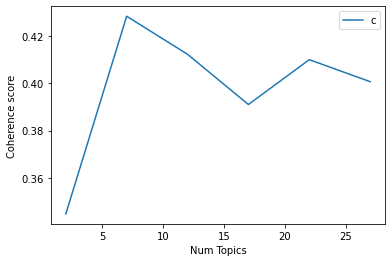

In [29]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [30]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 7

index: 0 | Num Topics = 2  has Coherence Value of 0.3446
index: 1 | Num Topics = 7  has Coherence Value of 0.4285
index: 2 | Num Topics = 12  has Coherence Value of 0.4124
index: 3 | Num Topics = 17  has Coherence Value of 0.3911
index: 4 | Num Topics = 22  has Coherence Value of 0.4101
index: 5 | Num Topics = 27  has Coherence Value of 0.4007


In [164]:
# Select optimal number of topics
optimal_model_us = model_list_us[1]

In [165]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us = pyLDAvis.gensim_models.prepare(optimal_model_us, corpus_us, id2word_us)

In [166]:
print("pyLDAVis for overall us topics:")
vis_us

pyLDAVis for overall us topics:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.220696 -0.031801       1        1  36.519931
3      0.126049  0.057616       2        1  19.223430
2      0.060982  0.026868       3        1  14.355792
5      0.097315 -0.092379       4        1  10.434077
0     -0.074844  0.159162       5        1   8.255687
1     -0.230776  0.153242       6        1   6.635913
6     -0.199422 -0.272708       7        1   4.575170, topic_info=        Term         Freq        Total Category  logprob  loglift
304  comment  1480.000000  1480.000000  Default  30.0000  30.0000
26        ad  1487.000000  1487.000000  Default  29.0000  29.0000
21     video  6277.000000  6277.000000  Default  28.0000  28.0000
195   change   845.000000   845.000000  Default  27.0000  27.0000
1        app  3174.000000  3174.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
57      home    47.481876   268.854241   Topic7  -4.8754   1.3507
349   device    36.687143   138.993214   Topic7  -5.1333   1.7525
209      old    39.325084   264.926970   Topic7  -5.0638   1.1769
247      add    39.582570   544.765839   Topic7  -5.0573   0.4626
562     give    32.377376   491.144263   Topic7  -5.2582   0.3652

[492 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
23        1  0.196945   ability
23        2  0.105037   ability
23        3  0.170686   ability
23        4  0.065648   ability
23        6  0.065648   ability
...     ...       ...       ...
156       1  0.076099  youtuber
156       2  0.159809  youtuber
156       3  0.197858  youtuber
156       5  0.494646  youtuber
156       7  0.068489  youtuber

[890 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 3, 6, 1, 2, 7])

# By-rating LDA Topic Modelling

## LDA Topic Modelling (Rating = 1)

In [34]:
# By-rating Topic Modelling - rating = 1
# Convert to list - move to each section
review_us_score1 = youtube_ios_us_review_YearMonth_score1.review.values.tolist()
review_words_us_score1 = list(sent_to_words(review_us_score1))
print(review_words_us_score1[:1])

[['this', 'app', 'is', 'horrible', 'it', 'always', 'kicks', 'me', 'out', 'of', 'the', 'app', 'and', 'then', 'it', 'freezes', 'and', 'it', 'shows', 'up', 'random', 'ads', 'then', 'when', 'didn', 'even', 'click', 'on', 'video', 'it', 'brings', 'me', 'there', 'then', 'it', 'shows', 'inappropriate', 'and', 'creepy', 'ads', 'and', 'am', 'ten', 'then', 'the', 'quality', 'of', 'the', 'video', 'is', 'great', 'but', 'then', 'randomly', 'starts', 'pixelating', 'when', 'make', 'the', 'video', 'bigger', 'then', 'when', 'want', 'to', 'make', 'it', 'smaller', 'hard', 'to', 'explain', 'but', 'it', 'doesn', 'let', 'me', 'make', 'it', 'smaller', 'or', 'when', 'want', 'to', 'get', 'out', 'of', 'the', 'video', 'it', 'just', 'doesn', 'let', 'me', 'get', 'out', 'of', 'it', 'also', 'when', 'you', 'put', 'it', 'on', 'auto', 'play', 'it', 'just', 'show', 'the', 'video', 'and', 'you', 'have', 'to', 'press', 'the', 'play', 'button', 'it', 'doesn', 'automatically', 'do', 'it', 'for', 'you', 'if', 'you', 'made', 

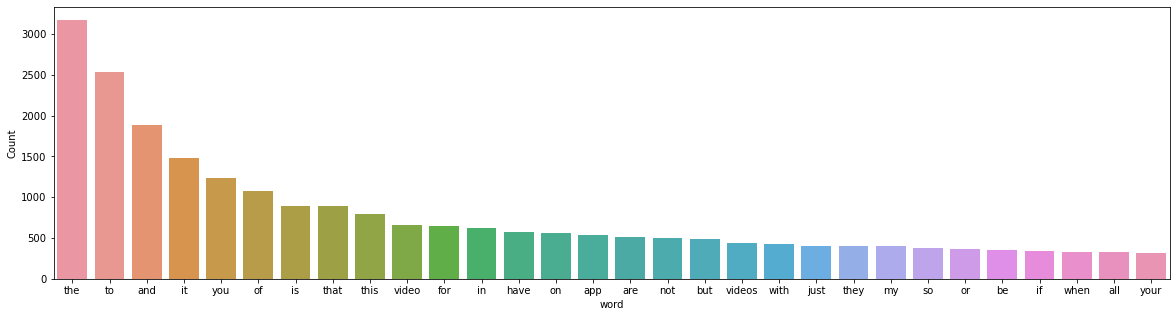

In [35]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_score1))

In [36]:
# Clean text
review_us_ready_score1 = process_words(review_words_us_score1)  # processed Text Data! - move to each section


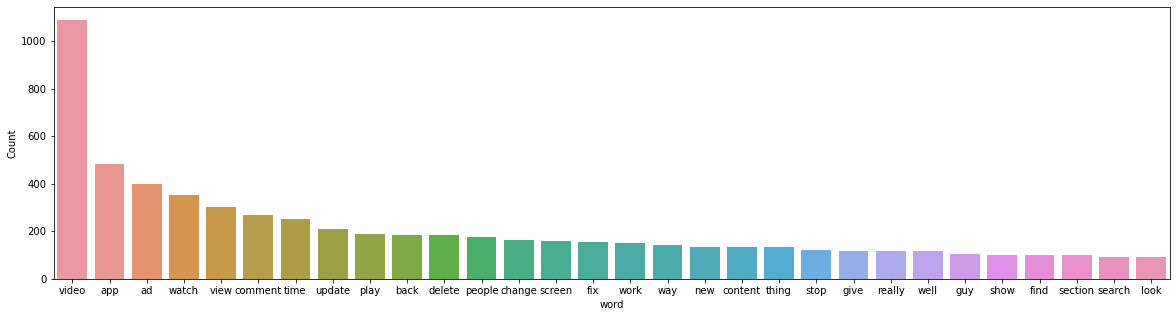

In [37]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready_score1))


In [38]:
# Create Dictionary
id2word_us_score1 = corpora.Dictionary(review_us_ready_score1)

2021-10-17 00:20:08,950 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 00:20:09,015 [INFO] gensim.corpora.dictionary - built Dictionary(3459 unique tokens: ['ad', 'always', 'app', 'auto', 'automatically']...) from 530 documents (total 25452 corpus positions)
2021-10-17 00:20:09,017 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(3459 unique tokens: ['ad', 'always', 'app', 'auto', 'automatically']...) from 530 documents (total 25452 corpus positions)", 'datetime': '2021-10-17T00:20:09.017132', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [39]:
# Create Corpus: Term Document Frequency
corpus_us_score1 = [id2word_us_score1.doc2bow(text) for text in review_us_ready_score1]

In [40]:
# Training LDA model
model_list_us_score1, coherence_values_us_score1 = compute_coherence_values(dictionary=id2word_us_score1, corpus=corpus_us_score1, 
                                                              texts=review_us_ready_score1, limit=30, start=2, step=5)


2021-10-17 00:20:09,150 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 00:20:09,153 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 00:20:09,167 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:20:09,176 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 530 documents, updating model once every 530 documents, evaluating perplexity every 530 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 00:20:11,780 [INFO] gensim.models.ldamodel - -8.638 per-word bound, 398.3 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:20:11,781 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #530/530
2021-10-17 00:20:14,218 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"video" + 0.019*"app" + 0.018*"view" + 0.010*"time" + 0.010*"watch" + 0.009*"delete" + 0.008*"peo

2021-10-17 00:20:38,701 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.050*"video" + 0.022*"app" + 0.021*"ad" + 0.016*"watch" + 0.014*"comment" + 0.011*"update" + 0.010*"play" + 0.009*"time" + 0.008*"screen" + 0.008*"back"
2021-10-17 00:20:38,709 [INFO] gensim.models.ldamodel - topic diff=0.030229, rho=0.301511
2021-10-17 00:20:39,999 [INFO] gensim.models.ldamodel - -6.935 per-word bound, 122.4 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:20:40,001 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #530/530
2021-10-17 00:20:40,951 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.027*"view" + 0.016*"video" + 0.015*"delete" + 0.013*"people" + 0.008*"content" + 0.008*"time" + 0.007*"guy" + 0.006*"work" + 0.006*"app" + 0.006*"music"
2021-10-17 00:20:40,953 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.050*"video" + 0.023*"app" + 0.021*"ad" + 0.016*"watch" + 0.014*"comment" + 0.011*"update" + 0.010*"play" + 0.009*"t

2021-10-17 00:21:00,327 [INFO] gensim.models.ldamodel - topic diff=0.008244, rho=0.218218
2021-10-17 00:21:01,545 [INFO] gensim.models.ldamodel - -6.924 per-word bound, 121.5 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:21:01,546 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #530/530
2021-10-17 00:21:02,500 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.027*"view" + 0.016*"delete" + 0.014*"video" + 0.013*"people" + 0.008*"content" + 0.008*"time" + 0.007*"guy" + 0.006*"work" + 0.006*"hard" + 0.006*"music"
2021-10-17 00:21:02,512 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.050*"video" + 0.023*"app" + 0.021*"ad" + 0.016*"watch" + 0.014*"comment" + 0.011*"update" + 0.010*"play" + 0.009*"time" + 0.009*"screen" + 0.008*"change"
2021-10-17 00:21:02,513 [INFO] gensim.models.ldamodel - topic diff=0.007539, rho=0.213201
2021-10-17 00:21:04,165 [INFO] gensim.models.ldamodel - -6.924 per-word bound, 121.4 perplexity es

2021-10-17 00:21:24,054 [INFO] gensim.models.ldamodel - -6.922 per-word bound, 121.3 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:21:24,057 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #530/530
2021-10-17 00:21:24,973 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.027*"view" + 0.016*"delete" + 0.014*"video" + 0.013*"people" + 0.008*"content" + 0.007*"time" + 0.007*"guy" + 0.006*"work" + 0.006*"platform" + 0.006*"hard"
2021-10-17 00:21:24,977 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.051*"video" + 0.024*"app" + 0.021*"ad" + 0.016*"watch" + 0.014*"comment" + 0.011*"update" + 0.010*"play" + 0.010*"time" + 0.009*"screen" + 0.008*"change"
2021-10-17 00:21:24,979 [INFO] gensim.models.ldamodel - topic diff=0.004005, rho=0.176777
2021-10-17 00:21:26,444 [INFO] gensim.models.ldamodel - -6.922 per-word bound, 121.2 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:21:26

2021-10-17 00:21:50,803 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #530/530
2021-10-17 00:21:51,681 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.027*"view" + 0.016*"delete" + 0.014*"video" + 0.013*"people" + 0.008*"content" + 0.007*"time" + 0.007*"guy" + 0.006*"work" + 0.006*"platform" + 0.006*"hard"
2021-10-17 00:21:51,684 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.051*"video" + 0.024*"app" + 0.021*"ad" + 0.016*"watch" + 0.014*"comment" + 0.011*"update" + 0.010*"play" + 0.010*"time" + 0.009*"screen" + 0.008*"change"
2021-10-17 00:21:51,685 [INFO] gensim.models.ldamodel - topic diff=0.002187, rho=0.154303
2021-10-17 00:21:53,343 [INFO] gensim.models.ldamodel - -6.921 per-word bound, 121.1 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:21:53,345 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #530/530
2021-10-17 00:21:54,827 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.027*"view" + 

2021-10-17 00:22:13,822 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-17 00:22:19,308 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-17 00:22:19,363 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 530 virtual documents
2021-10-17 00:22:19,717 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-17 00:22:19,720 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-17 00:22:19,728 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:22:19,736 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 530 documents, updating model once every 530 documents, evaluating perplexity every 530 documents, iterating 50x with a con

2021-10-17 00:22:37,244 [INFO] gensim.models.ldamodel - topic diff=0.153978, rho=0.408248
2021-10-17 00:22:38,520 [INFO] gensim.models.ldamodel - -7.133 per-word bound, 140.4 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:22:38,522 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #530/530
2021-10-17 00:22:39,422 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.015*"video" + 0.010*"content" + 0.010*"app" + 0.009*"search" + 0.009*"time" + 0.006*"second" + 0.006*"option" + 0.005*"show" + 0.005*"view" + 0.005*"back"
2021-10-17 00:22:39,423 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.017*"app" + 0.010*"content" + 0.010*"people" + 0.008*"video" + 0.008*"screen" + 0.007*"change" + 0.006*"leave" + 0.006*"really" + 0.005*"time" + 0.005*"feature"
2021-10-17 00:22:39,425 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.015*"video" + 0.014*"people" + 0.014*"watch" + 0.012*"content" + 0.009*"ad" + 0.008*"way" + 0.007*"app" +

2021-10-17 00:22:50,020 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.046*"video" + 0.035*"view" + 0.022*"delete" + 0.018*"app" + 0.015*"time" + 0.011*"work" + 0.011*"watch" + 0.009*"music" + 0.008*"play" + 0.008*"people"
2021-10-17 00:22:50,025 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.012*"video" + 0.011*"content" + 0.010*"search" + 0.009*"app" + 0.008*"time" + 0.006*"option" + 0.006*"second" + 0.005*"show" + 0.005*"link" + 0.005*"company"
2021-10-17 00:22:50,027 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.049*"video" + 0.033*"comment" + 0.022*"app" + 0.020*"update" + 0.014*"watch" + 0.013*"change" + 0.013*"back" + 0.013*"section" + 0.011*"new" + 0.011*"screen"
2021-10-17 00:22:50,030 [INFO] gensim.models.ldamodel - topic diff=0.037617, rho=0.288675
2021-10-17 00:22:51,427 [INFO] gensim.models.ldamodel - -7.093 per-word bound, 136.5 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:22:51,429 [INFO] gensim.models.lda

2021-10-17 00:23:01,550 [INFO] gensim.models.ldamodel - topic diff=0.020717, rho=0.242536
2021-10-17 00:23:02,736 [INFO] gensim.models.ldamodel - -7.078 per-word bound, 135.1 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:23:02,738 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #530/530
2021-10-17 00:23:03,467 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.112*"ad" + 0.023*"video" + 0.014*"minute" + 0.011*"watch" + 0.010*"second" + 0.007*"pay" + 0.007*"time" + 0.007*"stop" + 0.006*"thing" + 0.005*"play"
2021-10-17 00:23:03,470 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.053*"video" + 0.031*"comment" + 0.024*"app" + 0.020*"update" + 0.016*"watch" + 0.013*"change" + 0.013*"back" + 0.013*"screen" + 0.012*"section" + 0.012*"new"
2021-10-17 00:23:03,471 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.042*"video" + 0.038*"view" + 0.024*"delete" + 0.016*"app" + 0.015*"time" + 0.012*"work" + 0.010*"music" + 0.010*

2021-10-17 00:23:15,459 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.116*"ad" + 0.024*"video" + 0.014*"minute" + 0.011*"watch" + 0.009*"second" + 0.008*"pay" + 0.007*"stop" + 0.007*"time" + 0.006*"thing" + 0.006*"play"
2021-10-17 00:23:15,462 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.055*"video" + 0.029*"comment" + 0.026*"app" + 0.020*"update" + 0.017*"watch" + 0.013*"screen" + 0.013*"back" + 0.013*"change" + 0.011*"new" + 0.011*"fix"
2021-10-17 00:23:15,466 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.019*"people" + 0.015*"content" + 0.011*"truth" + 0.009*"platform" + 0.009*"watch" + 0.008*"way" + 0.007*"video" + 0.006*"freedom" + 0.006*"speech" + 0.005*"find"
2021-10-17 00:23:15,467 [INFO] gensim.models.ldamodel - topic diff=0.013811, rho=0.208514
2021-10-17 00:23:16,707 [INFO] gensim.models.ldamodel - -7.067 per-word bound, 134.1 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:23:16,711 [INFO] gensim.models.ldamo

2021-10-17 00:23:24,712 [INFO] gensim.models.ldamodel - topic diff=0.010821, rho=0.188982
2021-10-17 00:23:25,803 [INFO] gensim.models.ldamodel - -7.060 per-word bound, 133.4 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:23:25,804 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #530/530
2021-10-17 00:23:26,463 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.012*"content" + 0.011*"search" + 0.009*"video" + 0.008*"app" + 0.007*"time" + 0.007*"option" + 0.006*"link" + 0.005*"show" + 0.005*"company" + 0.005*"account"
2021-10-17 00:23:26,465 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.057*"video" + 0.028*"comment" + 0.027*"app" + 0.020*"update" + 0.017*"watch" + 0.013*"screen" + 0.012*"back" + 0.012*"change" + 0.011*"new" + 0.011*"fix"
2021-10-17 00:23:26,469 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.119*"ad" + 0.024*"video" + 0.014*"minute" + 0.011*"watch" + 0.009*"second" + 0.008*"pay" + 0.007*"stop" + 0

2021-10-17 00:23:36,233 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.121*"ad" + 0.024*"video" + 0.014*"minute" + 0.011*"watch" + 0.009*"second" + 0.008*"pay" + 0.007*"stop" + 0.007*"time" + 0.006*"skip" + 0.006*"play"
2021-10-17 00:23:36,237 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.040*"video" + 0.019*"app" + 0.016*"watch" + 0.010*"play" + 0.009*"ad" + 0.009*"channel" + 0.007*"thing" + 0.006*"way" + 0.006*"content" + 0.005*"end"
2021-10-17 00:23:36,241 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.012*"content" + 0.010*"people" + 0.010*"app" + 0.007*"leave" + 0.006*"change" + 0.006*"really" + 0.006*"child" + 0.006*"rating" + 0.005*"company" + 0.005*"remove"
2021-10-17 00:23:36,244 [INFO] gensim.models.ldamodel - topic diff=0.008220, rho=0.171499
2021-10-17 00:23:37,565 [INFO] gensim.models.ldamodel - -7.054 per-word bound, 132.9 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:23:37,567 [INFO] gensim.models.ldamodel 

2021-10-17 00:23:46,186 [INFO] gensim.models.ldamodel - topic diff=0.006822, rho=0.160128
2021-10-17 00:23:47,312 [INFO] gensim.models.ldamodel - -7.051 per-word bound, 132.6 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:23:47,314 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #530/530
2021-10-17 00:23:48,067 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.012*"content" + 0.010*"people" + 0.009*"app" + 0.007*"leave" + 0.006*"child" + 0.006*"change" + 0.006*"rating" + 0.006*"really" + 0.005*"company" + 0.005*"kid"
2021-10-17 00:23:48,069 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.044*"view" + 0.036*"video" + 0.029*"delete" + 0.015*"time" + 0.012*"work" + 0.012*"music" + 0.010*"guy" + 0.010*"app" + 0.009*"people" + 0.009*"hard"
2021-10-17 00:23:48,072 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.123*"ad" + 0.024*"video" + 0.014*"minute" + 0.011*"watch" + 0.009*"second" + 0.008*"pay" + 0.007*"stop" + 0.00

2021-10-17 00:23:57,100 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.060*"video" + 0.030*"app" + 0.026*"comment" + 0.019*"update" + 0.018*"watch" + 0.014*"screen" + 0.012*"back" + 0.012*"change" + 0.011*"fix" + 0.011*"time"
2021-10-17 00:23:57,103 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.021*"people" + 0.015*"content" + 0.012*"platform" + 0.012*"truth" + 0.010*"speech" + 0.009*"freedom" + 0.008*"way" + 0.007*"watch" + 0.006*"demonetize" + 0.005*"censor"
2021-10-17 00:23:57,105 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.124*"ad" + 0.024*"video" + 0.014*"minute" + 0.011*"watch" + 0.009*"second" + 0.008*"pay" + 0.007*"stop" + 0.007*"time" + 0.007*"skip" + 0.006*"play"
2021-10-17 00:23:57,107 [INFO] gensim.models.ldamodel - topic diff=0.005554, rho=0.149071
2021-10-17 00:23:58,229 [INFO] gensim.models.ldamodel - -7.047 per-word bound, 132.2 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:23:58,231 [INFO] gensim.model

2021-10-17 00:24:06,693 [INFO] gensim.models.ldamodel - topic diff=0.004711, rho=0.141421
2021-10-17 00:24:08,213 [INFO] gensim.models.ldamodel - -7.045 per-word bound, 132.0 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:24:08,221 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #530/530
2021-10-17 00:24:09,191 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.125*"ad" + 0.024*"video" + 0.014*"minute" + 0.011*"watch" + 0.009*"second" + 0.008*"pay" + 0.007*"stop" + 0.007*"time" + 0.007*"skip" + 0.006*"play"
2021-10-17 00:24:09,193 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.012*"content" + 0.010*"people" + 0.008*"app" + 0.007*"leave" + 0.007*"child" + 0.006*"rating" + 0.006*"change" + 0.006*"really" + 0.006*"company" + 0.005*"kid"
2021-10-17 00:24:09,196 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.013*"content" + 0.012*"search" + 0.007*"option" + 0.006*"app" + 0.006*"time" + 0.006*"link" + 0.006*"company" +

2021-10-17 00:24:25,980 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.054*"comment" + 0.023*"change" + 0.023*"section" + 0.022*"video" + 0.019*"update" + 0.019*"app" + 0.015*"back" + 0.010*"new" + 0.010*"click" + 0.009*"look"
2021-10-17 00:24:25,984 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.037*"view" + 0.028*"video" + 0.025*"delete" + 0.015*"music" + 0.015*"time" + 0.015*"work" + 0.013*"app" + 0.013*"people" + 0.012*"hard" + 0.011*"really"
2021-10-17 00:24:25,989 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.037*"ad" + 0.013*"pay" + 0.010*"thing" + 0.010*"video" + 0.009*"watch" + 0.008*"internet" + 0.007*"horrible" + 0.007*"bad" + 0.007*"political" + 0.006*"fix"
2021-10-17 00:24:25,993 [INFO] gensim.models.ldamodel - topic diff=0.305988, rho=0.447214
2021-10-17 00:24:27,187 [INFO] gensim.models.ldamodel - -7.236 per-word bound, 150.8 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:24:27,189 [INFO] gensim.models.ldamo

2021-10-17 00:24:35,998 [INFO] gensim.models.ldamodel - topic diff=0.080890, rho=0.316228
2021-10-17 00:24:37,386 [INFO] gensim.models.ldamodel - -7.154 per-word bound, 142.4 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:24:37,392 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #530/530
2021-10-17 00:24:38,191 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.014*"video" + 0.012*"app" + 0.012*"channel" + 0.011*"ad" + 0.010*"people" + 0.010*"thing" + 0.007*"allow" + 0.007*"watch" + 0.007*"creator" + 0.006*"political"
2021-10-17 00:24:38,193 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.015*"app" + 0.013*"video" + 0.009*"really" + 0.008*"thing" + 0.008*"control" + 0.007*"company" + 0.006*"gun" + 0.006*"well" + 0.006*"speech" + 0.006*"ad"
2021-10-17 00:24:38,195 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.054*"ad" + 0.040*"video" + 0.015*"view" + 0.012*"watch" + 0.010*"app" + 0.010*"minute" + 0.008*"guy" + 0.0

2021-10-17 00:24:50,790 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.008*"thing" + 0.007*"article" + 0.007*"app" + 0.007*"guy" + 0.007*"creator" + 0.007*"content" + 0.007*"way" + 0.007*"buy" + 0.006*"stupid" + 0.006*"much"
2021-10-17 00:24:50,795 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.061*"ad" + 0.039*"video" + 0.011*"watch" + 0.011*"minute" + 0.011*"view" + 0.009*"app" + 0.008*"second" + 0.007*"guy" + 0.007*"time" + 0.007*"song"
2021-10-17 00:24:50,811 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.026*"people" + 0.015*"content" + 0.011*"platform" + 0.010*"watch" + 0.010*"way" + 0.008*"app" + 0.008*"agree" + 0.007*"news" + 0.007*"truth" + 0.007*"video"
2021-10-17 00:24:50,813 [INFO] gensim.models.ldamodel - topic diff=0.028864, rho=0.250000
2021-10-17 00:24:52,090 [INFO] gensim.models.ldamodel - -7.122 per-word bound, 139.2 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:24:52,092 [INFO] gensim.models.ldamodel -

2021-10-17 00:25:01,986 [INFO] gensim.models.ldamodel - topic diff=0.017101, rho=0.218218
2021-10-17 00:25:03,580 [INFO] gensim.models.ldamodel - -7.108 per-word bound, 137.9 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:25:03,583 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #530/530
2021-10-17 00:25:04,568 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.066*"ad" + 0.040*"video" + 0.012*"minute" + 0.011*"watch" + 0.009*"second" + 0.008*"app" + 0.008*"view" + 0.007*"song" + 0.007*"time" + 0.007*"well"
2021-10-17 00:25:04,570 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.077*"video" + 0.033*"app" + 0.025*"watch" + 0.016*"play" + 0.014*"update" + 0.013*"screen" + 0.013*"time" + 0.010*"fix" + 0.009*"back" + 0.008*"phone"
2021-10-17 00:25:04,573 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.012*"app" + 0.010*"really" + 0.009*"video" + 0.008*"control" + 0.008*"truth" + 0.008*"thing" + 0.007*"speech" + 0.007*"

2021-10-17 00:25:14,283 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.011*"app" + 0.010*"really" + 0.009*"truth" + 0.009*"video" + 0.008*"control" + 0.008*"thing" + 0.007*"speech" + 0.007*"company" + 0.006*"allow" + 0.006*"gun"
2021-10-17 00:25:14,289 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.008*"thing" + 0.008*"article" + 0.007*"content" + 0.007*"creator" + 0.007*"guy" + 0.007*"buy" + 0.007*"way" + 0.006*"stupid" + 0.005*"read" + 0.005*"allow"
2021-10-17 00:25:14,294 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.069*"ad" + 0.040*"video" + 0.012*"minute" + 0.011*"watch" + 0.009*"second" + 0.008*"app" + 0.007*"song" + 0.007*"well" + 0.007*"time" + 0.007*"much"
2021-10-17 00:25:14,298 [INFO] gensim.models.ldamodel - topic diff=0.010682, rho=0.192450
2021-10-17 00:25:15,300 [INFO] gensim.models.ldamodel - -7.098 per-word bound, 137.0 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:25:15,301 [INFO] gensim.models.ldamod

2021-10-17 00:25:23,075 [INFO] gensim.models.ldamodel - topic diff=0.007808, rho=0.176777
2021-10-17 00:25:24,091 [INFO] gensim.models.ldamodel - -7.092 per-word bound, 136.4 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:25:24,093 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #530/530
2021-10-17 00:25:24,702 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.027*"people" + 0.016*"content" + 0.014*"freedom" + 0.012*"platform" + 0.010*"watch" + 0.010*"speech" + 0.009*"way" + 0.008*"truth" + 0.008*"news" + 0.008*"agree"
2021-10-17 00:25:24,704 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.076*"comment" + 0.030*"section" + 0.027*"change" + 0.020*"app" + 0.018*"update" + 0.017*"video" + 0.017*"back" + 0.012*"move" + 0.011*"new" + 0.011*"way"
2021-10-17 00:25:24,706 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.043*"ad" + 0.016*"pay" + 0.012*"thing" + 0.009*"watch" + 0.009*"horrible" + 0.009*"internet" + 0.008*"po

2021-10-17 00:25:34,786 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.027*"people" + 0.016*"content" + 0.015*"freedom" + 0.012*"platform" + 0.011*"speech" + 0.010*"watch" + 0.009*"way" + 0.009*"truth" + 0.008*"news" + 0.007*"agree"
2021-10-17 00:25:34,790 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.043*"ad" + 0.016*"pay" + 0.012*"thing" + 0.009*"watch" + 0.009*"horrible" + 0.009*"internet" + 0.008*"political" + 0.008*"bad" + 0.007*"video" + 0.007*"premium"
2021-10-17 00:25:34,792 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.066*"view" + 0.038*"delete" + 0.022*"video" + 0.018*"music" + 0.018*"people" + 0.016*"work" + 0.016*"time" + 0.014*"hard" + 0.014*"guy" + 0.011*"bot"
2021-10-17 00:25:34,793 [INFO] gensim.models.ldamodel - topic diff=0.005742, rho=0.162221
2021-10-17 00:25:35,772 [INFO] gensim.models.ldamodel - -7.088 per-word bound, 136.0 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:25:35,780 [INFO] gensim.model

2021-10-17 00:25:44,467 [INFO] gensim.models.ldamodel - topic diff=0.004522, rho=0.152499
2021-10-17 00:25:45,571 [INFO] gensim.models.ldamodel - -7.085 per-word bound, 135.8 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:25:45,572 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #530/530
2021-10-17 00:25:46,044 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.014*"channel" + 0.012*"ad" + 0.011*"people" + 0.010*"thing" + 0.010*"creator" + 0.009*"app" + 0.009*"tube" + 0.008*"allow" + 0.008*"account" + 0.007*"user"
2021-10-17 00:25:46,047 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.049*"ad" + 0.025*"video" + 0.016*"platform" + 0.012*"watch" + 0.012*"content" + 0.008*"money" + 0.007*"look" + 0.007*"time" + 0.006*"channel" + 0.006*"service"
2021-10-17 00:25:46,052 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.008*"article" + 0.008*"thing" + 0.007*"content" + 0.007*"creator" + 0.007*"buy" + 0.007*"guy" + 0.006*"

2021-10-17 00:25:54,837 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.008*"article" + 0.008*"thing" + 0.007*"content" + 0.007*"creator" + 0.007*"buy" + 0.006*"guy" + 0.006*"stupid" + 0.006*"way" + 0.006*"read" + 0.005*"allow"
2021-10-17 00:25:54,838 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.027*"people" + 0.017*"freedom" + 0.015*"content" + 0.012*"platform" + 0.012*"speech" + 0.010*"watch" + 0.010*"truth" + 0.009*"way" + 0.008*"news" + 0.007*"agree"
2021-10-17 00:25:54,839 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.078*"comment" + 0.030*"section" + 0.027*"change" + 0.020*"app" + 0.017*"update" + 0.017*"back" + 0.017*"video" + 0.012*"move" + 0.012*"look" + 0.011*"way"
2021-10-17 00:25:54,840 [INFO] gensim.models.ldamodel - topic diff=0.003545, rho=0.142857
2021-10-17 00:25:55,787 [INFO] gensim.models.ldamodel - -7.082 per-word bound, 135.5 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:25:55,789 [INFO] gensim.mode

2021-10-17 00:26:13,139 [INFO] gensim.models.ldamodel - -7.547 per-word bound, 187.0 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:26:13,150 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #530/530
2021-10-17 00:26:14,165 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.047*"ad" + 0.033*"video" + 0.021*"watch" + 0.014*"content" + 0.011*"comment" + 0.009*"platform" + 0.008*"account" + 0.008*"time" + 0.007*"show" + 0.007*"channel"
2021-10-17 00:26:14,167 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.073*"video" + 0.021*"app" + 0.020*"watch" + 0.015*"comment" + 0.013*"play" + 0.011*"update" + 0.011*"time" + 0.009*"work" + 0.008*"search" + 0.008*"screen"
2021-10-17 00:26:14,171 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.055*"video" + 0.022*"ad" + 0.020*"app" + 0.018*"watch" + 0.014*"view" + 0.013*"time" + 0.010*"work" + 0.009*"comment" + 0.008*"change" + 0.008*"screen"
2021-10-17 00:26:14,173 [INFO] gensim.mo

2021-10-17 00:26:24,973 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.043*"video" + 0.042*"ad" + 0.015*"view" + 0.013*"guy" + 0.011*"watch" + 0.009*"app" + 0.009*"delete" + 0.008*"second" + 0.008*"bad" + 0.007*"comment"
2021-10-17 00:26:24,975 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.051*"ad" + 0.023*"video" + 0.018*"watch" + 0.016*"content" + 0.012*"comment" + 0.010*"platform" + 0.010*"account" + 0.007*"time" + 0.007*"show" + 0.007*"channel"
2021-10-17 00:26:24,977 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.055*"ad" + 0.016*"pay" + 0.011*"gun" + 0.010*"app" + 0.009*"thing" + 0.009*"second" + 0.009*"play" + 0.008*"watch" + 0.008*"internet" + 0.007*"fix"
2021-10-17 00:26:24,979 [INFO] gensim.models.ldamodel - topic diff=0.127918, rho=0.333333
2021-10-17 00:26:26,220 [INFO] gensim.models.ldamodel - -7.295 per-word bound, 157.0 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:26:26,223 [INFO] gensim.models.ldamodel -

2021-10-17 00:26:35,348 [INFO] gensim.models.ldamodel - topic diff=0.045513, rho=0.267261
2021-10-17 00:26:36,597 [INFO] gensim.models.ldamodel - -7.253 per-word bound, 152.5 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:26:36,598 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #530/530
2021-10-17 00:26:37,458 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.061*"view" + 0.040*"delete" + 0.022*"video" + 0.020*"hard" + 0.018*"work" + 0.016*"music" + 0.014*"really" + 0.014*"people" + 0.012*"army" + 0.011*"time"
2021-10-17 00:26:37,460 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.020*"video" + 0.013*"app" + 0.012*"time" + 0.011*"fix" + 0.011*"find" + 0.010*"well" + 0.010*"people" + 0.010*"update" + 0.009*"channel" + 0.008*"watch"
2021-10-17 00:26:37,461 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.033*"app" + 0.016*"ad" + 0.013*"video" + 0.012*"update" + 0.011*"listen" + 0.010*"song" + 0.009*"search" + 0.00

2021-10-17 00:26:47,512 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.049*"ad" + 0.044*"video" + 0.013*"guy" + 0.011*"watch" + 0.009*"bad" + 0.009*"app" + 0.009*"second" + 0.007*"still" + 0.007*"view" + 0.006*"give"
2021-10-17 00:26:47,514 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.046*"view" + 0.022*"video" + 0.022*"time" + 0.019*"delete" + 0.013*"back" + 0.012*"people" + 0.011*"bot" + 0.009*"fan" + 0.009*"music" + 0.008*"watch"
2021-10-17 00:26:47,517 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.056*"video" + 0.031*"ad" + 0.018*"app" + 0.017*"watch" + 0.013*"time" + 0.009*"minute" + 0.009*"screen" + 0.008*"change" + 0.006*"work" + 0.006*"big"
2021-10-17 00:26:47,519 [INFO] gensim.models.ldamodel - topic diff=0.021459, rho=0.223607
2021-10-17 00:26:48,627 [INFO] gensim.models.ldamodel - -7.226 per-word bound, 149.7 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:26:48,628 [INFO] gensim.models.ldamodel - PROGRESS: 

2021-10-17 00:26:56,357 [INFO] gensim.models.ldamodel - topic diff=0.014372, rho=0.200000
2021-10-17 00:26:57,467 [INFO] gensim.models.ldamodel - -7.213 per-word bound, 148.3 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:26:57,469 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #530/530
2021-10-17 00:26:58,211 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.009*"creator" + 0.009*"shuffle" + 0.008*"black" + 0.008*"people" + 0.007*"much" + 0.007*"hate" + 0.007*"allow" + 0.006*"build" + 0.006*"buy" + 0.006*"app"
2021-10-17 00:26:58,213 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.092*"comment" + 0.039*"section" + 0.028*"change" + 0.027*"video" + 0.020*"back" + 0.016*"update" + 0.016*"move" + 0.014*"app" + 0.013*"click" + 0.013*"look"
2021-10-17 00:26:58,214 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.020*"content" + 0.014*"pay" + 0.011*"account" + 0.011*"company" + 0.009*"offline" + 0.008*"control" + 0.007

2021-10-17 00:27:07,464 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.009*"creator" + 0.009*"shuffle" + 0.009*"black" + 0.008*"people" + 0.007*"much" + 0.007*"hate" + 0.007*"build" + 0.007*"allow" + 0.007*"buy" + 0.006*"stupid"
2021-10-17 00:27:07,465 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.014*"remove" + 0.013*"screen" + 0.012*"app" + 0.012*"channel" + 0.010*"change" + 0.010*"content" + 0.008*"video" + 0.007*"child" + 0.007*"dim" + 0.007*"watch"
2021-10-17 00:27:07,467 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.014*"comment" + 0.014*"people" + 0.010*"view" + 0.009*"app" + 0.009*"platform" + 0.009*"continue" + 0.008*"great" + 0.007*"way" + 0.007*"tube" + 0.007*"away"
2021-10-17 00:27:07,468 [INFO] gensim.models.ldamodel - topic diff=0.009855, rho=0.179605
2021-10-17 00:27:08,500 [INFO] gensim.models.ldamodel - -7.203 per-word bound, 147.3 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:27:08,503 [INFO] gensim.m

2021-10-17 00:27:16,982 [INFO] gensim.models.ldamodel - topic diff=0.007435, rho=0.166667
2021-10-17 00:27:18,098 [INFO] gensim.models.ldamodel - -7.197 per-word bound, 146.7 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:27:18,099 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #530/530
2021-10-17 00:27:18,768 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.020*"content" + 0.014*"pay" + 0.012*"account" + 0.011*"company" + 0.009*"offline" + 0.008*"control" + 0.007*"non" + 0.007*"believe" + 0.007*"set" + 0.007*"premium"
2021-10-17 00:27:18,770 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.053*"ad" + 0.018*"content" + 0.014*"watch" + 0.013*"comment" + 0.013*"video" + 0.012*"platform" + 0.011*"account" + 0.008*"political" + 0.007*"channel" + 0.006*"let"
2021-10-17 00:27:18,772 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.014*"remove" + 0.013*"screen" + 0.012*"app" + 0.012*"channel" + 0.010*"change" + 0.010*"co

2021-10-17 00:27:28,345 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.014*"people" + 0.010*"view" + 0.010*"comment" + 0.009*"platform" + 0.009*"continue" + 0.009*"great" + 0.008*"app" + 0.007*"normal" + 0.007*"away" + 0.007*"tube"
2021-10-17 00:27:28,347 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.010*"creator" + 0.009*"shuffle" + 0.009*"build" + 0.009*"black" + 0.008*"people" + 0.007*"hate" + 0.007*"much" + 0.007*"allow" + 0.007*"buy" + 0.006*"stupid"
2021-10-17 00:27:28,349 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.082*"video" + 0.033*"app" + 0.026*"watch" + 0.018*"play" + 0.016*"update" + 0.014*"time" + 0.012*"screen" + 0.011*"fix" + 0.009*"phone" + 0.009*"back"
2021-10-17 00:27:28,351 [INFO] gensim.models.ldamodel - topic diff=0.005596, rho=0.154303
2021-10-17 00:27:29,486 [INFO] gensim.models.ldamodel - -7.192 per-word bound, 146.2 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:27:29,488 [INFO] gensim.models

2021-10-17 00:27:37,327 [INFO] gensim.models.ldamodel - topic diff=0.004627, rho=0.145865
2021-10-17 00:27:38,357 [INFO] gensim.models.ldamodel - -7.188 per-word bound, 145.9 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:27:38,358 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #530/530
2021-10-17 00:27:39,040 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.068*"view" + 0.042*"delete" + 0.021*"hard" + 0.020*"video" + 0.018*"work" + 0.016*"music" + 0.015*"people" + 0.014*"really" + 0.013*"army" + 0.012*"guy"
2021-10-17 00:27:39,043 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.054*"ad" + 0.018*"content" + 0.014*"comment" + 0.013*"watch" + 0.012*"platform" + 0.011*"account" + 0.011*"video" + 0.009*"political" + 0.008*"channel" + 0.006*"let"
2021-10-17 00:27:39,045 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.056*"video" + 0.034*"ad" + 0.018*"watch" + 0.016*"app" + 0.012*"time" + 0.010*"minute" + 0.009*"scre

2021-10-17 00:27:59,824 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.054*"video" + 0.020*"app" + 0.015*"ad" + 0.014*"watch" + 0.013*"view" + 0.012*"time" + 0.010*"work" + 0.009*"comment" + 0.008*"update" + 0.008*"fix"
2021-10-17 00:27:59,826 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.033*"view" + 0.031*"video" + 0.018*"delete" + 0.017*"time" + 0.013*"people" + 0.012*"back" + 0.011*"app" + 0.011*"watch" + 0.008*"bot" + 0.007*"stop"
2021-10-17 00:27:59,828 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.035*"video" + 0.025*"app" + 0.013*"watch" + 0.012*"screen" + 0.012*"thing" + 0.008*"back" + 0.007*"play" + 0.007*"update" + 0.007*"keep" + 0.007*"comment"
2021-10-17 00:27:59,862 [INFO] gensim.models.ldamodel - topic diff=15.436971, rho=1.000000
2021-10-17 00:28:01,253 [INFO] gensim.models.ldamodel - -7.912 per-word bound, 240.9 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:28:01,256 [INFO] gensim.models.ldamodel - PR

2021-10-17 00:28:11,328 [INFO] gensim.models.ldamodel - topic diff=0.265155, rho=0.377964
2021-10-17 00:28:12,354 [INFO] gensim.models.ldamodel - -7.376 per-word bound, 166.1 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:28:12,355 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #530/530
2021-10-17 00:28:13,330 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.028*"video" + 0.014*"update" + 0.013*"watch" + 0.012*"people" + 0.011*"comment" + 0.010*"well" + 0.010*"thing" + 0.009*"look" + 0.009*"guy" + 0.008*"content"
2021-10-17 00:28:13,331 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.053*"video" + 0.019*"app" + 0.014*"ad" + 0.013*"watch" + 0.013*"time" + 0.008*"view" + 0.007*"fix" + 0.007*"work" + 0.007*"thing" + 0.007*"big"
2021-10-17 00:28:13,333 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.016*"child" + 0.014*"people" + 0.013*"kid" + 0.011*"buy" + 0.010*"bad" + 0.009*"horrible" + 0.009*"video" + 0.009*"c

2021-10-17 00:28:24,397 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.023*"comment" + 0.017*"app" + 0.015*"update" + 0.014*"way" + 0.011*"back" + 0.010*"scroll" + 0.009*"view" + 0.008*"screen" + 0.008*"problem" + 0.008*"continue"
2021-10-17 00:28:24,399 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.024*"people" + 0.014*"firearm" + 0.010*"never" + 0.009*"corporate" + 0.007*"app" + 0.007*"legal" + 0.007*"watch" + 0.007*"love" + 0.007*"provide" + 0.006*"scroll"
2021-10-17 00:28:24,401 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.091*"comment" + 0.039*"section" + 0.035*"change" + 0.025*"video" + 0.022*"back" + 0.018*"update" + 0.016*"move" + 0.013*"app" + 0.012*"click" + 0.011*"new"
2021-10-17 00:28:24,403 [INFO] gensim.models.ldamodel - topic diff=0.064833, rho=0.277350
2021-10-17 00:28:25,600 [INFO] gensim.models.ldamodel - -7.299 per-word bound, 157.5 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:28:25,601 [INFO] gensi

2021-10-17 00:28:34,864 [INFO] gensim.models.ldamodel - topic diff=0.028246, rho=0.235702
2021-10-17 00:28:36,100 [INFO] gensim.models.ldamodel - -7.276 per-word bound, 155.0 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:28:36,102 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #530/530
2021-10-17 00:28:36,873 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.097*"comment" + 0.041*"section" + 0.035*"change" + 0.023*"video" + 0.022*"back" + 0.019*"update" + 0.016*"move" + 0.014*"app" + 0.013*"click" + 0.012*"new"
2021-10-17 00:28:36,879 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.047*"ad" + 0.043*"video" + 0.014*"app" + 0.010*"guy" + 0.010*"watch" + 0.009*"second" + 0.008*"view" + 0.007*"much" + 0.007*"premium" + 0.007*"still"
2021-10-17 00:28:36,889 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.017*"comment" + 0.017*"app" + 0.015*"way" + 0.014*"update" + 0.010*"back" + 0.009*"view" + 0.008*"scroll" + 0.00

2021-10-17 00:28:47,353 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.026*"people" + 0.014*"firearm" + 0.010*"corporate" + 0.009*"never" + 0.008*"app" + 0.007*"legal" + 0.007*"love" + 0.007*"provide" + 0.007*"watch" + 0.007*"care"
2021-10-17 00:28:47,355 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.016*"app" + 0.015*"way" + 0.014*"comment" + 0.014*"update" + 0.009*"view" + 0.009*"back" + 0.008*"continue" + 0.008*"normal" + 0.008*"utube" + 0.008*"screen"
2021-10-17 00:28:47,357 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.047*"ad" + 0.043*"video" + 0.014*"app" + 0.009*"watch" + 0.009*"second" + 0.008*"guy" + 0.007*"much" + 0.007*"view" + 0.007*"premium" + 0.007*"still"
2021-10-17 00:28:47,359 [INFO] gensim.models.ldamodel - topic diff=0.015030, rho=0.204124
2021-10-17 00:28:48,536 [INFO] gensim.models.ldamodel - -7.260 per-word bound, 153.3 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:28:48,538 [INFO] gensim.models.

2021-10-17 00:28:56,701 [INFO] gensim.models.ldamodel - topic diff=0.010390, rho=0.185695
2021-10-17 00:28:57,756 [INFO] gensim.models.ldamodel - -7.250 per-word bound, 152.3 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:28:57,759 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #530/530
2021-10-17 00:28:58,518 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.029*"ad" + 0.019*"app" + 0.016*"video" + 0.012*"show" + 0.012*"listen" + 0.011*"song" + 0.010*"time" + 0.009*"minute" + 0.008*"music" + 0.008*"option"
2021-10-17 00:28:58,519 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.016*"app" + 0.014*"way" + 0.013*"update" + 0.013*"comment" + 0.009*"view" + 0.008*"back" + 0.008*"normal" + 0.008*"continue" + 0.008*"utube" + 0.008*"screen"
2021-10-17 00:28:58,521 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.026*"people" + 0.015*"firearm" + 0.010*"corporate" + 0.009*"never" + 0.009*"app" + 0.008*"legal" + 0.007*"lov

2021-10-17 00:29:08,973 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.102*"comment" + 0.041*"section" + 0.034*"change" + 0.022*"back" + 0.020*"video" + 0.020*"update" + 0.016*"move" + 0.014*"app" + 0.013*"click" + 0.013*"new"
2021-10-17 00:29:08,976 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.023*"video" + 0.020*"app" + 0.014*"update" + 0.013*"fix" + 0.011*"time" + 0.010*"play" + 0.009*"really" + 0.009*"much" + 0.008*"change" + 0.008*"option"
2021-10-17 00:29:08,980 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.018*"content" + 0.013*"much" + 0.011*"link" + 0.011*"app" + 0.010*"safari" + 0.009*"instead" + 0.008*"gun" + 0.007*"people" + 0.007*"search" + 0.007*"open"
2021-10-17 00:29:08,983 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.083*"ad" + 0.045*"video" + 0.024*"watch" + 0.016*"content" + 0.013*"time" + 0.010*"account" + 0.010*"channel" + 0.009*"way" + 0.009*"platform" + 0.008*"ban"
2021-10-17 00:29:08,985 [INFO] gensim.models.ldamodel - topic diff=0.007

2021-10-17 00:29:18,774 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.016*"really" + 0.015*"gun" + 0.012*"stop" + 0.011*"control" + 0.010*"violence" + 0.009*"ad" + 0.008*"company" + 0.008*"age" + 0.008*"app" + 0.007*"video"
2021-10-17 00:29:18,777 [INFO] gensim.models.ldamodel - topic diff=0.005940, rho=0.158114
2021-10-17 00:29:19,774 [INFO] gensim.models.ldamodel - -7.237 per-word bound, 150.8 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:29:19,776 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #530/530
2021-10-17 00:29:20,368 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.030*"ad" + 0.017*"app" + 0.014*"video" + 0.012*"listen" + 0.012*"show" + 0.011*"song" + 0.010*"time" + 0.009*"minute" + 0.008*"music" + 0.008*"option"
2021-10-17 00:29:20,376 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.016*"people" + 0.012*"guy" + 0.012*"thing" + 0.011*"upload" + 0.010*"well" + 0.010*"child" + 0.010*"content" + 0.

2021-10-17 00:29:29,642 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.016*"really" + 0.015*"gun" + 0.012*"stop" + 0.011*"control" + 0.010*"violence" + 0.009*"ad" + 0.009*"company" + 0.008*"age" + 0.008*"app" + 0.007*"video"
2021-10-17 00:29:29,647 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.090*"video" + 0.034*"app" + 0.030*"watch" + 0.019*"play" + 0.016*"update" + 0.014*"time" + 0.013*"screen" + 0.010*"fix" + 0.010*"work" + 0.009*"phone"
2021-10-17 00:29:29,652 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.030*"ad" + 0.016*"app" + 0.013*"political" + 0.010*"channel" + 0.010*"way" + 0.010*"bad" + 0.009*"guy" + 0.008*"article" + 0.008*"second" + 0.007*"full"
2021-10-17 00:29:29,654 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.026*"tube" + 0.017*"freedom" + 0.014*"speech" + 0.013*"people" + 0.012*"fact" + 0.012*"leave" + 0.011*"remove" + 0.011*"check" + 0.009*"search" + 0.008*"platform"
2021-10-17 00:29:29,655 [INFO] gensim.models.ldamodel - topic diff=0.0047

2021-10-17 00:29:40,797 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.020*"app" + 0.013*"great" + 0.011*"rating" + 0.009*"review" + 0.009*"star" + 0.009*"community" + 0.009*"let" + 0.008*"page" + 0.008*"notification" + 0.008*"change"
2021-10-17 00:29:40,802 [INFO] gensim.models.ldamodel - topic diff=0.004147, rho=0.140028
2021-10-17 00:29:40,805 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=3459, num_topics=22, decay=0.5, chunksize=1000) in 105.16s', 'datetime': '2021-10-17T00:29:40.805329', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-17 00:29:40,814 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-17 00:29:46,409 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue

2021-10-17 00:30:06,636 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.054*"video" + 0.045*"ad" + 0.029*"watch" + 0.013*"time" + 0.013*"recommend" + 0.011*"show" + 0.010*"content" + 0.009*"channel" + 0.008*"app" + 0.007*"comment"
2021-10-17 00:30:06,638 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.017*"view" + 0.016*"content" + 0.010*"black" + 0.010*"delete" + 0.008*"literally" + 0.008*"power" + 0.007*"people" + 0.007*"set" + 0.007*"control" + 0.007*"allow"
2021-10-17 00:30:06,643 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.033*"view" + 0.032*"video" + 0.025*"delete" + 0.017*"time" + 0.016*"wait" + 0.016*"music" + 0.015*"guy" + 0.014*"work" + 0.012*"app" + 0.011*"really"
2021-10-17 00:30:06,645 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.018*"firearm" + 0.016*"people" + 0.011*"way" + 0.010*"legal" + 0.009*"corporate" + 0.009*"never" + 0.009*"content" + 0.009*"gun" + 0.009*"kid" + 0.009*"post"
2021-10-17 00:30:06,649 [INFO] gensim.models.ldamodel - topic dif

2021-10-17 00:30:19,505 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.056*"video" + 0.022*"watch" + 0.020*"ad" + 0.018*"view" + 0.015*"app" + 0.012*"time" + 0.008*"music" + 0.007*"big" + 0.007*"new" + 0.007*"people"
2021-10-17 00:30:19,507 [INFO] gensim.models.ldamodel - topic diff=0.110178, rho=0.301511
2021-10-17 00:30:20,746 [INFO] gensim.models.ldamodel - -7.416 per-word bound, 170.8 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:30:20,747 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #530/530
2021-10-17 00:30:21,388 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.044*"video" + 0.023*"watch" + 0.019*"update" + 0.016*"app" + 0.013*"playlist" + 0.012*"new" + 0.012*"fix" + 0.011*"time" + 0.008*"people" + 0.008*"find"
2021-10-17 00:30:21,391 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.063*"ad" + 0.049*"video" + 0.020*"view" + 0.017*"delete" + 0.017*"watch" + 0.012*"minute" + 0.012*"app" + 0.010*"song"

2021-10-17 00:30:31,340 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.024*"comment" + 0.015*"leave" + 0.012*"recommend" + 0.012*"dress" + 0.012*"child" + 0.011*"white" + 0.011*"really" + 0.010*"section" + 0.010*"silence" + 0.009*"much"
2021-10-17 00:30:31,343 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.043*"video" + 0.023*"watch" + 0.018*"update" + 0.016*"app" + 0.014*"playlist" + 0.012*"new" + 0.012*"fix" + 0.011*"time" + 0.009*"find" + 0.009*"people"
2021-10-17 00:30:31,347 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.038*"view" + 0.028*"delete" + 0.028*"video" + 0.018*"wait" + 0.018*"time" + 0.017*"music" + 0.016*"guy" + 0.015*"work" + 0.013*"people" + 0.013*"really"
2021-10-17 00:30:31,353 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.020*"content" + 0.010*"black" + 0.009*"control" + 0.008*"yt" + 0.008*"company" + 0.008*"set" + 0.008*"allow" + 0.008*"truth" + 0.008*"power" + 0.008*"platform"
2021-10-17 00:30:31,354 [INFO] gensim.models.ldamodel - topic

2021-10-17 00:30:41,366 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.048*"ad" + 0.022*"pay" + 0.017*"watch" + 0.014*"kid" + 0.011*"hate" + 0.010*"stupid" + 0.009*"horrible" + 0.009*"premium" + 0.009*"play" + 0.009*"fix"
2021-10-17 00:30:41,367 [INFO] gensim.models.ldamodel - topic diff=0.019223, rho=0.213201
2021-10-17 00:30:42,376 [INFO] gensim.models.ldamodel - -7.358 per-word bound, 164.1 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:30:42,377 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #530/530
2021-10-17 00:30:43,134 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.043*"comment" + 0.024*"video" + 0.018*"section" + 0.016*"back" + 0.013*"bad" + 0.013*"app" + 0.012*"dislike" + 0.011*"scroll" + 0.011*"update" + 0.010*"click"
2021-10-17 00:30:43,136 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.089*"comment" + 0.036*"section" + 0.035*"change" + 0.023*"video" + 0.019*"move" + 0.018*"back" + 0.015*"app" 

2021-10-17 00:30:52,991 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.025*"content" + 0.022*"channel" + 0.018*"remove" + 0.015*"demonetize" + 0.014*"review" + 0.013*"tube" + 0.012*"creator" + 0.012*"ban" + 0.011*"viewer" + 0.010*"people"
2021-10-17 00:30:52,993 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.046*"ad" + 0.020*"pay" + 0.017*"watch" + 0.014*"kid" + 0.011*"hate" + 0.010*"premium" + 0.010*"stupid" + 0.009*"horrible" + 0.009*"fix" + 0.009*"play"
2021-10-17 00:30:52,995 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.091*"comment" + 0.037*"section" + 0.035*"change" + 0.023*"video" + 0.019*"move" + 0.018*"back" + 0.015*"app" + 0.014*"update" + 0.014*"look" + 0.013*"new"
2021-10-17 00:30:52,997 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.037*"app" + 0.036*"ad" + 0.015*"political" + 0.009*"work" + 0.009*"thing" + 0.008*"force" + 0.008*"give" + 0.008*"change" + 0.007*"comment" + 0.007*"time"
2021-10-17 00:30:53,000 [INFO] gensim.models.ldamodel - topic diff

2021-10-17 00:31:04,114 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.036*"view" + 0.027*"video" + 0.027*"delete" + 0.019*"music" + 0.019*"wait" + 0.017*"time" + 0.015*"guy" + 0.015*"work" + 0.013*"people" + 0.012*"really"
2021-10-17 00:31:04,117 [INFO] gensim.models.ldamodel - topic diff=0.009811, rho=0.174078
2021-10-17 00:31:05,475 [INFO] gensim.models.ldamodel - -7.333 per-word bound, 161.3 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:31:05,477 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #530/530
2021-10-17 00:31:06,314 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.047*"video" + 0.035*"time" + 0.016*"people" + 0.016*"watch" + 0.009*"view" + 0.008*"really" + 0.008*"bad" + 0.008*"app" + 0.008*"sad" + 0.008*"support"
2021-10-17 00:31:06,317 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.021*"content" + 0.010*"black" + 0.010*"platform" + 0.010*"control" + 0.009*"yt" + 0.008*"company" + 0.008*"set" +

2021-10-17 00:31:16,242 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.057*"video" + 0.022*"watch" + 0.019*"ad" + 0.012*"app" + 0.012*"time" + 0.012*"view" + 0.008*"music" + 0.008*"big" + 0.008*"minute" + 0.007*"remove"
2021-10-17 00:31:16,245 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.091*"video" + 0.037*"app" + 0.026*"watch" + 0.025*"play" + 0.014*"update" + 0.014*"screen" + 0.013*"work" + 0.012*"back" + 0.011*"time" + 0.011*"fix"
2021-10-17 00:31:16,248 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.093*"comment" + 0.037*"section" + 0.034*"change" + 0.022*"video" + 0.020*"back" + 0.018*"move" + 0.016*"app" + 0.015*"update" + 0.014*"look" + 0.014*"new"
2021-10-17 00:31:16,253 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.047*"video" + 0.035*"time" + 0.017*"people" + 0.016*"watch" + 0.008*"really" + 0.008*"bad" + 0.008*"sad" + 0.008*"app" + 0.007*"support" + 0.007*"view"
2021-10-17 00:31:16,254 [INFO] gensim.models.ldamodel - topic diff=0.007780, rho=0.16012

2021-10-17 00:31:26,746 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.017*"add" + 0.015*"user" + 0.015*"channel" + 0.014*"video" + 0.012*"playlist" + 0.010*"wrong" + 0.009*"ipad" + 0.009*"queue" + 0.009*"leave" + 0.009*"fact"
2021-10-17 00:31:26,747 [INFO] gensim.models.ldamodel - topic diff=0.006572, rho=0.150756
2021-10-17 00:31:27,922 [INFO] gensim.models.ldamodel - -7.318 per-word bound, 159.6 perplexity estimate based on a held-out corpus of 530 documents with 25452 words
2021-10-17 00:31:27,950 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #530/530
2021-10-17 00:31:28,629 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.102*"view" + 0.052*"delete" + 0.021*"hard" + 0.018*"army" + 0.016*"back" + 0.016*"work" + 0.016*"bot" + 0.016*"people" + 0.015*"guy" + 0.014*"give"
2021-10-17 00:31:28,630 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.020*"firearm" + 0.017*"people" + 0.011*"way" + 0.011*"legal" + 0.010*"corporate" + 0.010*"gun" + 0.010*"post" + 0.0

2021-10-17 00:31:38,859 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.093*"ad" + 0.056*"video" + 0.020*"watch" + 0.013*"minute" + 0.013*"app" + 0.011*"song" + 0.010*"play" + 0.009*"skip" + 0.009*"end" + 0.008*"premium"
2021-10-17 00:31:38,865 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.022*"content" + 0.010*"platform" + 0.010*"black" + 0.010*"control" + 0.009*"yt" + 0.008*"company" + 0.008*"set" + 0.008*"truth" + 0.008*"allow" + 0.008*"power"
2021-10-17 00:31:38,870 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.016*"social" + 0.015*"content" + 0.014*"news" + 0.012*"comment" + 0.009*"medium" + 0.009*"company" + 0.009*"message" + 0.009*"side" + 0.009*"account" + 0.009*"opinion"
2021-10-17 00:31:38,873 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.103*"view" + 0.052*"delete" + 0.021*"hard" + 0.017*"army" + 0.016*"bot" + 0.016*"work" + 0.016*"back" + 0.016*"people" + 0.015*"guy" + 0.014*"give"
2021-10-17 00:31:38,875 [INFO] gensim.models.ldamodel - topic diff=

In [41]:
%store model_list_us_score1
%store coherence_values_us_score1

Stored 'model_list_us_score1' (list)
Stored 'coherence_values_us_score1' (list)


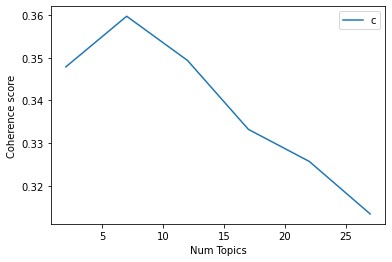

In [42]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_score1)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [43]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_score1):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 7

index: 0 | Num Topics = 2  has Coherence Value of 0.3479
index: 1 | Num Topics = 7  has Coherence Value of 0.3597
index: 2 | Num Topics = 12  has Coherence Value of 0.3494
index: 3 | Num Topics = 17  has Coherence Value of 0.3332
index: 4 | Num Topics = 22  has Coherence Value of 0.3257
index: 5 | Num Topics = 27  has Coherence Value of 0.3134


In [44]:
# Select optimal number of topics
optimal_model_us_score1 = model_list_us_score1[1]

In [45]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_score1 = pyLDAvis.gensim_models.prepare(optimal_model_us_score1, corpus_us_score1, id2word_us_score1)

In [46]:
print("pyLDAVis for us topics for score=1:")
vis_us_score1

pyLDAVis for us topics for score=1:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.195027  0.004248       1        1  39.474875
5      0.079400  0.123542       2        1  20.625726
2      0.046979 -0.017732       3        1  15.775365
4      0.027521 -0.158652       4        1   9.633696
6     -0.141527  0.018650       5        1   6.304158
0     -0.099670  0.052954       6        1   4.617978
3     -0.107731 -0.023010       7        1   3.568202, topic_info=         Term        Freq        Total Category  logprob  loglift
0          ad  340.000000   340.000000  Default  30.0000  30.0000
114      view  272.000000   272.000000  Default  29.0000  29.0000
783   comment  257.000000   257.000000  Default  28.0000  28.0000
408    delete  164.000000   164.000000  Default  27.0000  27.0000
506    people  149.000000   149.000000  Default  26.0000  26.0000
..        ...         ...          ...      ...      ...      ...
178       set    2.891289    24.425507   Topic7  -5.7497   1.1992
391  platform    3.176814    64.944291   Topic7  -5.6556   0.3155
33      video    3.861070  1006.460110   Topic7  -5.4605  -2.2301
538   creator    3.090621    52.198136   Topic7  -5.6831   0.5064
142   support    2.802081    35.340100   Topic7  -5.7811   0.7985

[515 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
2185      5  0.842761         abide
1251      1  0.968746  accidentally
34        1  0.202218       account
34        2  0.134812       account
34        3  0.235921       account
...     ...       ...           ...
2538      5  0.842796     workplace
2775      7  0.674688            yr
3104      2  0.941951            꼰대
3107      2  0.941951            들어
3113      2  0.941951          손들어라

[1126 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 3, 5, 7, 1, 4])

## LDA Topic Modelling (Rating = 2)

In [47]:
# By-rating Topic Modelling - rating = 2
# Convert to list - move to each section
review_us_score2 = youtube_ios_us_review_YearMonth_score2.review.values.tolist()
review_words_us_score2 = list(sent_to_words(review_us_score2))
print(review_words_us_score2[:1])

[['have', 'become', 'increasingly', 'frustrated', 'with', 'the', 'app', 'whenever', 'make', 'video', 'full', 'screen', 'the', 'video', 'freezes', 'while', 'the', 'audio', 'continues', 'to', 'play', 'when', 'this', 'happens', 'the', 'video', 'will', 'not', 'go', 'back', 'to', 'regular', 'viewing', 'mode', 'in', 'fact', 'my', 'entire', 'phone', 'freezes', 'and', 'am', 'unable', 'to', 'lock', 'it', 'even', 'when', 'hold', 'down', 'the', 'lock', 'button', 'or', 'press', 'it', 'repeatedly', 'the', 'screen', 'dims', 'just', 'little', 'and', 'that', 'it', 'eventually', 'the', 'phone', 'locks', 'and', 'comes', 'back', 'on', 'but', 'only', 'after', 'several', 'seconds', 'of', 'staring', 'at', 'frozen', 'screen', 'updated', 'the', 'app', 'to', 'the', 'most', 'recent', 'version', 'but', 'the', 'problem', 'continues', 'to', 'persist', 'would', 'hate', 'to', 'delete', 'the', 'app', 'but', 'am', 'concerned', 'about', 'the', 'effect', 'the', 'problem', 'is', 'having', 'on', 'my', 'phone']]


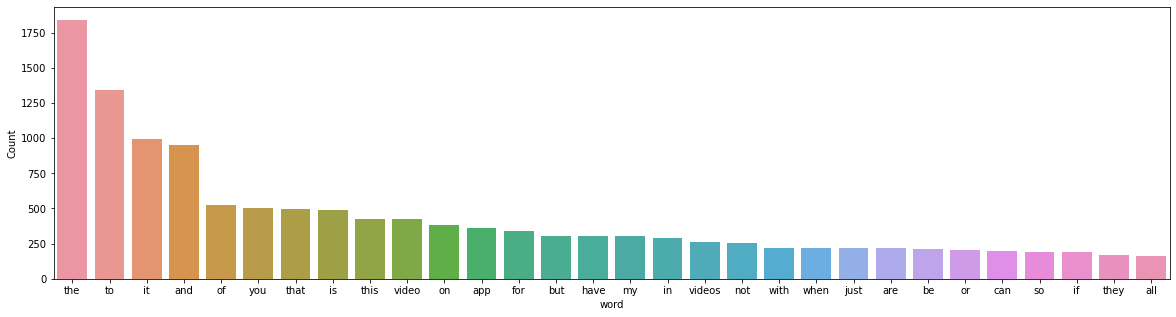

In [48]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_score2))

In [49]:
# Clean text
review_us_ready_score2 = process_words(review_words_us_score2)  # processed Text Data! - move to each section


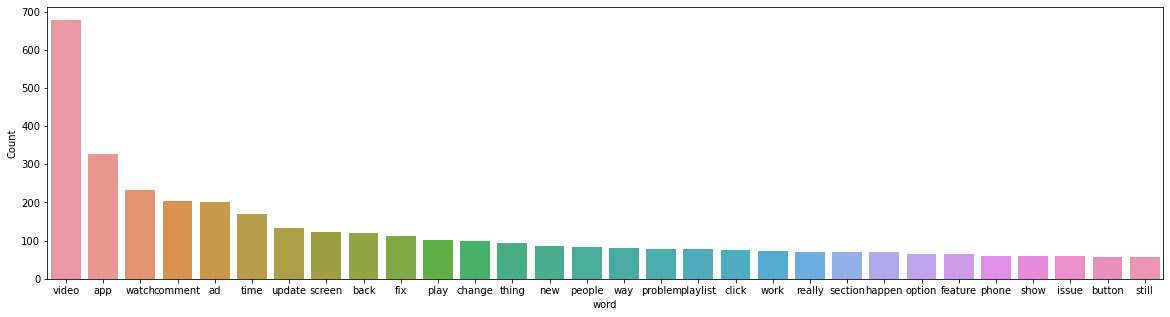

In [50]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready_score2))


In [51]:
# Create Dictionary
id2word_us_score2 = corpora.Dictionary(review_us_ready_score2)

2021-10-17 00:32:16,395 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 00:32:16,477 [INFO] gensim.corpora.dictionary - built Dictionary(2232 unique tokens: ['app', 'back', 'become', 'button', 'concerned']...) from 321 documents (total 13519 corpus positions)
2021-10-17 00:32:16,480 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(2232 unique tokens: ['app', 'back', 'become', 'button', 'concerned']...) from 321 documents (total 13519 corpus positions)", 'datetime': '2021-10-17T00:32:16.480153', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [52]:
# Create Corpus: Term Document Frequency
corpus_us_score2 = [id2word_us_score2.doc2bow(text) for text in review_us_ready_score2]

In [53]:
# Training LDA model
model_list_us_score2, coherence_values_us_score2 = compute_coherence_values(dictionary=id2word_us_score2, corpus=corpus_us_score2, 
                                                              texts=review_us_ready_score2, limit=30, start=2, step=5)


2021-10-17 00:32:16,542 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 00:32:16,544 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 00:32:16,547 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:32:16,549 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 321 documents, updating model once every 321 documents, evaluating perplexity every 321 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 00:32:18,113 [INFO] gensim.models.ldamodel - -8.215 per-word bound, 297.1 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:32:18,114 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #321/321
2021-10-17 00:32:19,322 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.028*"video" + 0.021*"watch" + 0.014*"app" + 0.013*"time" + 0.008*"playlist" + 0.007*"really" + 0.007*

2021-10-17 00:32:35,260 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.054*"video" + 0.024*"app" + 0.019*"comment" + 0.017*"ad" + 0.013*"watch" + 0.011*"time" + 0.011*"update" + 0.010*"screen" + 0.010*"back" + 0.009*"fix"
2021-10-17 00:32:35,262 [INFO] gensim.models.ldamodel - topic diff=0.023262, rho=0.301511
2021-10-17 00:32:36,084 [INFO] gensim.models.ldamodel - -6.730 per-word bound, 106.2 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:32:36,087 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #321/321
2021-10-17 00:32:36,635 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.018*"watch" + 0.017*"video" + 0.012*"app" + 0.010*"time" + 0.009*"playlist" + 0.008*"people" + 0.007*"view" + 0.006*"pay" + 0.006*"let" + 0.006*"really"
2021-10-17 00:32:36,640 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.055*"video" + 0.025*"app" + 0.019*"comment" + 0.017*"ad" + 0.013*"watch" + 0.011*"time" + 0.011*"update" + 0.010*"sc

2021-10-17 00:32:48,887 [INFO] gensim.models.ldamodel - topic diff=0.013255, rho=0.218218
2021-10-17 00:32:49,642 [INFO] gensim.models.ldamodel - -6.715 per-word bound, 105.1 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:32:49,643 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #321/321
2021-10-17 00:32:50,106 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.016*"watch" + 0.012*"video" + 0.011*"people" + 0.010*"app" + 0.009*"time" + 0.007*"pay" + 0.007*"view" + 0.007*"playlist" + 0.006*"let" + 0.006*"channel"
2021-10-17 00:32:50,107 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.056*"video" + 0.025*"app" + 0.018*"comment" + 0.017*"ad" + 0.014*"watch" + 0.012*"time" + 0.011*"update" + 0.011*"screen" + 0.009*"back" + 0.009*"fix"
2021-10-17 00:32:50,110 [INFO] gensim.models.ldamodel - topic diff=0.013129, rho=0.213201
2021-10-17 00:32:50,795 [INFO] gensim.models.ldamodel - -6.714 per-word bound, 105.0 perplexity estim

2021-10-17 00:33:01,918 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #321/321
2021-10-17 00:33:02,522 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.014*"watch" + 0.012*"people" + 0.010*"video" + 0.009*"app" + 0.009*"time" + 0.007*"pay" + 0.007*"view" + 0.007*"channel" + 0.007*"let" + 0.006*"music"
2021-10-17 00:33:02,524 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.056*"video" + 0.025*"app" + 0.018*"comment" + 0.017*"ad" + 0.015*"watch" + 0.012*"time" + 0.012*"update" + 0.011*"screen" + 0.010*"fix" + 0.009*"back"
2021-10-17 00:33:02,525 [INFO] gensim.models.ldamodel - topic diff=0.009524, rho=0.176777
2021-10-17 00:33:03,278 [INFO] gensim.models.ldamodel - -6.704 per-word bound, 104.2 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:33:03,280 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #321/321
2021-10-17 00:33:03,845 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.014*"watch" + 0.012*"p

2021-10-17 00:33:14,122 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.056*"video" + 0.025*"app" + 0.018*"comment" + 0.017*"ad" + 0.016*"watch" + 0.012*"time" + 0.012*"update" + 0.011*"screen" + 0.010*"fix" + 0.009*"back"
2021-10-17 00:33:14,123 [INFO] gensim.models.ldamodel - topic diff=0.005691, rho=0.154303
2021-10-17 00:33:14,747 [INFO] gensim.models.ldamodel - -6.699 per-word bound, 103.9 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:33:14,748 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #321/321
2021-10-17 00:33:15,276 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.013*"people" + 0.013*"watch" + 0.008*"video" + 0.008*"time" + 0.008*"app" + 0.008*"pay" + 0.008*"channel" + 0.007*"view" + 0.007*"let" + 0.007*"music"
2021-10-17 00:33:15,296 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.056*"video" + 0.025*"app" + 0.018*"comment" + 0.017*"ad" + 0.016*"watch" + 0.012*"time" + 0.011*"update" + 0.011*"scre

2021-10-17 00:33:30,559 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 321 virtual documents
2021-10-17 00:33:30,886 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-17 00:33:30,890 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-17 00:33:30,896 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:33:30,902 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 321 documents, updating model once every 321 documents, evaluating perplexity every 321 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 00:33:32,270 [INFO] gensim.models.ldamodel - -9.367 per-word bound, 660.4 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:33:32,271 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #321/321
2021-10-17 00:3

2021-10-17 00:33:39,059 [INFO] gensim.models.ldamodel - -6.921 per-word bound, 121.2 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:33:39,061 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #321/321
2021-10-17 00:33:39,495 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.020*"people" + 0.020*"video" + 0.013*"ad" + 0.012*"watch" + 0.009*"app" + 0.009*"pay" + 0.007*"stop" + 0.007*"back" + 0.007*"playlist" + 0.006*"hear"
2021-10-17 00:33:39,497 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.027*"ad" + 0.012*"video" + 0.010*"move" + 0.009*"middle" + 0.008*"app" + 0.007*"account" + 0.007*"quite" + 0.007*"problem" + 0.007*"playlist" + 0.006*"feature"
2021-10-17 00:33:39,500 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.031*"video" + 0.023*"comment" + 0.020*"playlist" + 0.020*"app" + 0.018*"watch" + 0.016*"time" + 0.010*"problem" + 0.009*"ad" + 0.007*"fix" + 0.007*"people"
2021-10-17 00:33:39,501 [INFO] gensim.models.

2021-10-17 00:33:45,250 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.030*"video" + 0.023*"playlist" + 0.022*"comment" + 0.021*"app" + 0.017*"watch" + 0.015*"time" + 0.010*"problem" + 0.007*"people" + 0.007*"fix" + 0.007*"ad"
2021-10-17 00:33:45,252 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.065*"video" + 0.026*"app" + 0.024*"comment" + 0.015*"screen" + 0.014*"watch" + 0.014*"update" + 0.013*"back" + 0.013*"play" + 0.012*"ad" + 0.011*"fix"
2021-10-17 00:33:45,254 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.039*"video" + 0.027*"app" + 0.026*"ad" + 0.018*"watch" + 0.009*"people" + 0.009*"thing" + 0.008*"time" + 0.008*"happen" + 0.007*"really" + 0.007*"update"
2021-10-17 00:33:45,257 [INFO] gensim.models.ldamodel - topic diff=0.029844, rho=0.288675
2021-10-17 00:33:45,880 [INFO] gensim.models.ldamodel - -6.889 per-word bound, 118.5 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:33:45,882 [INFO] gensim.models.ldamodel -

2021-10-17 00:33:51,318 [INFO] gensim.models.ldamodel - -6.879 per-word bound, 117.7 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:33:51,320 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #321/321
2021-10-17 00:33:51,761 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.030*"video" + 0.020*"time" + 0.014*"watch" + 0.014*"quality" + 0.010*"option" + 0.009*"high" + 0.007*"app" + 0.007*"feature" + 0.007*"let" + 0.007*"add"
2021-10-17 00:33:51,762 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.028*"video" + 0.017*"turn" + 0.017*"app" + 0.016*"watch" + 0.013*"time" + 0.011*"screen" + 0.009*"tap" + 0.009*"really" + 0.009*"thing" + 0.009*"find"
2021-10-17 00:33:51,764 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.031*"ad" + 0.010*"video" + 0.009*"move" + 0.009*"middle" + 0.008*"account" + 0.008*"quite" + 0.007*"app" + 0.007*"playlist" + 0.007*"create" + 0.006*"hear"
2021-10-17 00:33:51,766 [INFO] gensim.models.ldamo

2021-10-17 00:33:56,849 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.028*"video" + 0.025*"playlist" + 0.021*"app" + 0.020*"comment" + 0.017*"watch" + 0.015*"time" + 0.010*"problem" + 0.008*"fix" + 0.007*"people" + 0.007*"add"
2021-10-17 00:33:56,851 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.065*"video" + 0.027*"app" + 0.024*"comment" + 0.015*"screen" + 0.015*"update" + 0.015*"watch" + 0.013*"back" + 0.012*"play" + 0.012*"fix" + 0.011*"ad"
2021-10-17 00:33:56,853 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.031*"ad" + 0.010*"video" + 0.009*"middle" + 0.009*"move" + 0.008*"account" + 0.008*"quite" + 0.007*"app" + 0.007*"playlist" + 0.007*"create" + 0.006*"actually"
2021-10-17 00:33:56,855 [INFO] gensim.models.ldamodel - topic diff=0.008247, rho=0.208514
2021-10-17 00:33:57,521 [INFO] gensim.models.ldamodel - -6.873 per-word bound, 117.2 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:33:57,524 [INFO] gensim.models.lda

2021-10-17 00:34:02,378 [INFO] gensim.models.ldamodel - topic diff=0.005766, rho=0.188982
2021-10-17 00:34:03,016 [INFO] gensim.models.ldamodel - -6.870 per-word bound, 117.0 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:34:03,023 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #321/321
2021-10-17 00:34:03,500 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.028*"video" + 0.026*"playlist" + 0.021*"app" + 0.020*"comment" + 0.017*"watch" + 0.015*"time" + 0.010*"problem" + 0.008*"fix" + 0.007*"people" + 0.007*"add"
2021-10-17 00:34:03,503 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.037*"video" + 0.029*"ad" + 0.023*"app" + 0.018*"watch" + 0.010*"people" + 0.008*"thing" + 0.008*"feature" + 0.007*"really" + 0.007*"happen" + 0.007*"view"
2021-10-17 00:34:03,505 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.031*"ad" + 0.010*"video" + 0.009*"middle" + 0.009*"move" + 0.008*"account" + 0.008*"quite" + 0.007*"app" + 0

2021-10-17 00:34:09,128 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.022*"people" + 0.017*"video" + 0.015*"ad" + 0.012*"watch" + 0.009*"pay" + 0.008*"stop" + 0.007*"back" + 0.006*"commercial" + 0.006*"app" + 0.006*"hear"
2021-10-17 00:34:09,130 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.031*"ad" + 0.010*"video" + 0.009*"middle" + 0.009*"move" + 0.008*"account" + 0.008*"quite" + 0.007*"app" + 0.007*"playlist" + 0.007*"create" + 0.006*"actually"
2021-10-17 00:34:09,132 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.037*"video" + 0.029*"ad" + 0.022*"app" + 0.018*"watch" + 0.010*"people" + 0.008*"feature" + 0.008*"thing" + 0.007*"really" + 0.007*"happen" + 0.007*"view"
2021-10-17 00:34:09,133 [INFO] gensim.models.ldamodel - topic diff=0.004058, rho=0.171499
2021-10-17 00:34:09,868 [INFO] gensim.models.ldamodel - -6.868 per-word bound, 116.8 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:34:09,870 [INFO] gensim.models.ldam

2021-10-17 00:34:14,538 [INFO] gensim.models.ldamodel - topic diff=0.003107, rho=0.160128
2021-10-17 00:34:15,094 [INFO] gensim.models.ldamodel - -6.866 per-word bound, 116.7 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:34:15,095 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #321/321
2021-10-17 00:34:15,454 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.031*"ad" + 0.010*"video" + 0.009*"middle" + 0.009*"move" + 0.008*"account" + 0.008*"quite" + 0.007*"app" + 0.007*"playlist" + 0.007*"create" + 0.006*"actually"
2021-10-17 00:34:15,456 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.036*"video" + 0.029*"ad" + 0.022*"app" + 0.018*"watch" + 0.010*"people" + 0.008*"feature" + 0.008*"thing" + 0.007*"really" + 0.007*"view" + 0.007*"resolution"
2021-10-17 00:34:15,458 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.030*"video" + 0.020*"time" + 0.015*"quality" + 0.014*"watch" + 0.010*"option" + 0.009*"high" + 0.007*

2021-10-17 00:34:23,003 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.030*"video" + 0.020*"time" + 0.015*"quality" + 0.014*"watch" + 0.010*"option" + 0.009*"high" + 0.007*"let" + 0.007*"app" + 0.006*"guy" + 0.006*"add"
2021-10-17 00:34:23,005 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.022*"people" + 0.017*"video" + 0.015*"ad" + 0.011*"watch" + 0.009*"pay" + 0.008*"stop" + 0.007*"back" + 0.006*"hear" + 0.006*"well" + 0.006*"app"
2021-10-17 00:34:23,007 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.064*"video" + 0.028*"app" + 0.024*"comment" + 0.015*"screen" + 0.015*"update" + 0.015*"watch" + 0.013*"back" + 0.012*"play" + 0.012*"time" + 0.012*"fix"
2021-10-17 00:34:23,008 [INFO] gensim.models.ldamodel - topic diff=0.002451, rho=0.149071
2021-10-17 00:34:24,064 [INFO] gensim.models.ldamodel - -6.865 per-word bound, 116.6 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:34:24,074 [INFO] gensim.models.ldamodel - PROGRESS: pa

2021-10-17 00:34:30,284 [INFO] gensim.models.ldamodel - -6.864 per-word bound, 116.5 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:34:30,285 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #321/321
2021-10-17 00:34:30,756 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.022*"people" + 0.017*"video" + 0.014*"ad" + 0.011*"watch" + 0.009*"pay" + 0.008*"stop" + 0.007*"back" + 0.006*"hear" + 0.006*"well" + 0.006*"give"
2021-10-17 00:34:30,757 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.027*"video" + 0.027*"playlist" + 0.021*"app" + 0.019*"comment" + 0.017*"watch" + 0.015*"time" + 0.010*"problem" + 0.008*"fix" + 0.007*"people" + 0.007*"add"
2021-10-17 00:34:30,758 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.036*"video" + 0.030*"ad" + 0.021*"app" + 0.018*"watch" + 0.010*"people" + 0.008*"feature" + 0.008*"thing" + 0.007*"really" + 0.007*"resolution" + 0.007*"view"
2021-10-17 00:34:30,760 [INFO] gensim.models.ld

2021-10-17 00:34:43,855 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.060*"video" + 0.026*"comment" + 0.020*"app" + 0.018*"update" + 0.016*"ad" + 0.016*"back" + 0.014*"screen" + 0.014*"change" + 0.014*"play" + 0.012*"section"
2021-10-17 00:34:43,857 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.024*"app" + 0.021*"video" + 0.020*"really" + 0.016*"time" + 0.016*"watch" + 0.010*"thing" + 0.009*"screen" + 0.009*"change" + 0.009*"pay" + 0.008*"issue"
2021-10-17 00:34:43,859 [INFO] gensim.models.ldamodel - topic diff=0.264255, rho=0.447214
2021-10-17 00:34:44,516 [INFO] gensim.models.ldamodel - -7.080 per-word bound, 135.3 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:34:44,517 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #321/321
2021-10-17 00:34:45,011 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.030*"comment" + 0.019*"video" + 0.017*"change" + 0.016*"app" + 0.016*"playlist" + 0.015*"time" + 0.012*"update"

2021-10-17 00:34:50,404 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #321/321
2021-10-17 00:34:50,870 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.032*"comment" + 0.017*"change" + 0.017*"playlist" + 0.016*"video" + 0.016*"app" + 0.015*"time" + 0.013*"update" + 0.011*"section" + 0.010*"fix" + 0.009*"thing"
2021-10-17 00:34:50,871 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.033*"video" + 0.025*"app" + 0.016*"phone" + 0.013*"audio" + 0.012*"ad" + 0.012*"play" + 0.011*"stop" + 0.010*"watch" + 0.010*"people" + 0.009*"screen"
2021-10-17 00:34:50,873 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.046*"video" + 0.018*"playlist" + 0.016*"update" + 0.014*"button" + 0.014*"upload" + 0.013*"comment" + 0.012*"tap" + 0.011*"way" + 0.011*"app" + 0.011*"feature"
2021-10-17 00:34:50,875 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.031*"video" + 0.018*"app" + 0.014*"play" + 0.014*"button" + 0.013*"resolution" + 0.011*"turn" + 0.010*"change" + 0.009*"watch" +

2021-10-17 00:34:56,536 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.028*"ad" + 0.026*"video" + 0.022*"app" + 0.012*"content" + 0.012*"watch" + 0.011*"people" + 0.011*"platform" + 0.009*"thing" + 0.009*"happen" + 0.008*"show"
2021-10-17 00:34:56,537 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.032*"video" + 0.026*"app" + 0.017*"phone" + 0.013*"audio" + 0.012*"ad" + 0.012*"play" + 0.012*"stop" + 0.010*"watch" + 0.010*"people" + 0.009*"screen"
2021-10-17 00:34:56,538 [INFO] gensim.models.ldamodel - topic diff=0.019539, rho=0.250000
2021-10-17 00:34:57,260 [INFO] gensim.models.ldamodel - -6.993 per-word bound, 127.4 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:34:57,261 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #321/321
2021-10-17 00:34:57,630 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.040*"video" + 0.018*"time" + 0.016*"quality" + 0.014*"watch" + 0.014*"work" + 0.013*"screen" + 0.010*"app" + 0.

2021-10-17 00:35:02,885 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #321/321
2021-10-17 00:35:03,369 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.028*"ad" + 0.025*"video" + 0.021*"app" + 0.012*"content" + 0.012*"people" + 0.011*"platform" + 0.010*"watch" + 0.009*"thing" + 0.009*"happen" + 0.009*"show"
2021-10-17 00:35:03,372 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.055*"video" + 0.027*"app" + 0.023*"comment" + 0.019*"ad" + 0.018*"watch" + 0.013*"time" + 0.012*"screen" + 0.009*"fix" + 0.008*"thing" + 0.007*"happen"
2021-10-17 00:35:03,373 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.030*"video" + 0.026*"app" + 0.017*"phone" + 0.013*"audio" + 0.012*"ad" + 0.012*"stop" + 0.010*"play" + 0.010*"people" + 0.010*"watch" + 0.009*"thing"
2021-10-17 00:35:03,375 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.030*"ad" + 0.011*"create" + 0.011*"middle" + 0.011*"app" + 0.011*"account" + 0.010*"video" + 0.010*"playlist" + 0.009*"rid" + 0.009*"actuall

2021-10-17 00:35:09,143 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.029*"video" + 0.018*"app" + 0.017*"resolution" + 0.014*"play" + 0.014*"button" + 0.011*"turn" + 0.010*"change" + 0.010*"high" + 0.009*"watch" + 0.009*"time"
2021-10-17 00:35:09,144 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.069*"video" + 0.053*"watch" + 0.032*"app" + 0.016*"time" + 0.016*"click" + 0.010*"put" + 0.009*"thing" + 0.009*"delete" + 0.009*"problem" + 0.008*"play"
2021-10-17 00:35:09,146 [INFO] gensim.models.ldamodel - topic diff=0.006160, rho=0.192450
2021-10-17 00:35:09,727 [INFO] gensim.models.ldamodel - -6.981 per-word bound, 126.4 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:35:09,729 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #321/321
2021-10-17 00:35:10,253 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.040*"video" + 0.018*"time" + 0.016*"quality" + 0.015*"watch" + 0.014*"work" + 0.012*"screen" + 0.010*"app" + 0

2021-10-17 00:35:15,467 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #321/321
2021-10-17 00:35:15,888 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.064*"video" + 0.026*"comment" + 0.024*"app" + 0.021*"update" + 0.017*"screen" + 0.015*"back" + 0.014*"play" + 0.014*"ad" + 0.014*"change" + 0.012*"time"
2021-10-17 00:35:15,892 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.056*"video" + 0.027*"app" + 0.023*"comment" + 0.020*"ad" + 0.019*"watch" + 0.013*"time" + 0.011*"screen" + 0.009*"fix" + 0.008*"thing" + 0.007*"happen"
2021-10-17 00:35:15,894 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.028*"video" + 0.018*"app" + 0.018*"resolution" + 0.014*"button" + 0.014*"play" + 0.011*"turn" + 0.010*"change" + 0.010*"high" + 0.009*"watch" + 0.009*"time"
2021-10-17 00:35:15,898 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.040*"video" + 0.017*"time" + 0.016*"quality" + 0.015*"watch" + 0.014*"work" + 0.011*"screen" + 0.010*"high" + 0.010*"app" + 0.008*"option"

2021-10-17 00:35:21,555 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.022*"app" + 0.017*"video" + 0.017*"watch" + 0.016*"really" + 0.013*"time" + 0.013*"thing" + 0.010*"people" + 0.010*"pay" + 0.008*"side" + 0.007*"change"
2021-10-17 00:35:21,557 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.056*"video" + 0.027*"app" + 0.023*"comment" + 0.020*"ad" + 0.019*"watch" + 0.013*"time" + 0.011*"screen" + 0.009*"fix" + 0.008*"thing" + 0.007*"happen"
2021-10-17 00:35:21,558 [INFO] gensim.models.ldamodel - topic diff=0.003338, rho=0.162221
2021-10-17 00:35:22,185 [INFO] gensim.models.ldamodel - -6.975 per-word bound, 125.8 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:35:22,191 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #321/321
2021-10-17 00:35:22,627 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.032*"ad" + 0.012*"create" + 0.012*"middle" + 0.012*"account" + 0.011*"app" + 0.010*"video" + 0.010*"playlist" + 0.0

2021-10-17 00:35:27,880 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #321/321
2021-10-17 00:35:28,229 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.027*"video" + 0.018*"resolution" + 0.018*"app" + 0.014*"button" + 0.014*"play" + 0.011*"turn" + 0.011*"change" + 0.010*"high" + 0.009*"watch" + 0.009*"quality"
2021-10-17 00:35:28,231 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.053*"video" + 0.039*"playlist" + 0.016*"button" + 0.015*"update" + 0.013*"upload" + 0.012*"tap" + 0.012*"delete" + 0.011*"app" + 0.011*"time" + 0.010*"back"
2021-10-17 00:35:28,233 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.069*"video" + 0.054*"watch" + 0.032*"app" + 0.017*"time" + 0.016*"click" + 0.009*"put" + 0.009*"thing" + 0.008*"problem" + 0.008*"star" + 0.007*"fix"
2021-10-17 00:35:28,235 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.025*"app" + 0.024*"video" + 0.016*"phone" + 0.014*"ad" + 0.012*"stop" + 0.011*"audio" + 0.010*"people" + 0.010*"respond" + 0.009*"t

2021-10-17 00:35:33,809 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.027*"video" + 0.018*"resolution" + 0.018*"app" + 0.014*"button" + 0.014*"play" + 0.011*"turn" + 0.011*"change" + 0.010*"high" + 0.009*"watch" + 0.009*"quality"
2021-10-17 00:35:33,812 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.056*"video" + 0.027*"app" + 0.022*"comment" + 0.020*"ad" + 0.019*"watch" + 0.013*"time" + 0.011*"screen" + 0.009*"fix" + 0.008*"thing" + 0.007*"happen"
2021-10-17 00:35:33,814 [INFO] gensim.models.ldamodel - topic diff=0.002398, rho=0.142857
2021-10-17 00:35:34,445 [INFO] gensim.models.ldamodel - -6.971 per-word bound, 125.5 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:35:34,446 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #321/321
2021-10-17 00:35:34,845 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.063*"video" + 0.026*"comment" + 0.025*"app" + 0.022*"update" + 0.018*"screen" + 0.016*"back" + 0.014*"play" 

2021-10-17 00:35:47,959 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.034*"video" + 0.017*"high" + 0.017*"quality" + 0.013*"time" + 0.012*"app" + 0.012*"turn" + 0.010*"search" + 0.010*"glitch" + 0.010*"much" + 0.010*"channel"
2021-10-17 00:35:47,962 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.034*"video" + 0.012*"tab" + 0.012*"load" + 0.012*"people" + 0.011*"place" + 0.010*"channel" + 0.008*"yt" + 0.008*"much" + 0.008*"lose" + 0.008*"subscription"
2021-10-17 00:35:47,967 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.051*"video" + 0.035*"comment" + 0.028*"app" + 0.020*"ad" + 0.020*"watch" + 0.013*"time" + 0.009*"screen" + 0.008*"people" + 0.007*"happen" + 0.007*"section"
2021-10-17 00:35:47,972 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.031*"video" + 0.018*"app" + 0.015*"ad" + 0.015*"phone" + 0.014*"stop" + 0.014*"play" + 0.013*"people" + 0.012*"screen" + 0.012*"watch" + 0.009*"time"
2021-10-17 00:35:47,974 [INFO] gensim.models.ldamodel - topic #12 (0.059)

2021-10-17 00:35:53,575 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.035*"video" + 0.012*"tab" + 0.012*"load" + 0.012*"people" + 0.012*"place" + 0.011*"channel" + 0.008*"yt" + 0.008*"much" + 0.008*"lose" + 0.008*"subscription"
2021-10-17 00:35:53,576 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.020*"middle" + 0.016*"account" + 0.016*"ad" + 0.016*"video" + 0.013*"fix" + 0.013*"update" + 0.013*"mode" + 0.011*"app" + 0.011*"screen" + 0.011*"put"
2021-10-17 00:35:53,578 [INFO] gensim.models.ldamodel - topic diff=0.095334, rho=0.333333
2021-10-17 00:35:54,272 [INFO] gensim.models.ldamodel - -7.128 per-word bound, 139.8 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:35:54,273 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #321/321
2021-10-17 00:35:54,681 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.019*"people" + 0.018*"pay" + 0.013*"tube" + 0.012*"ad" + 0.012*"video" + 0.012*"side" + 0.010*"let" + 0.010*"he

2021-10-17 00:35:59,848 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #321/321
2021-10-17 00:36:00,244 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.054*"video" + 0.039*"comment" + 0.026*"app" + 0.021*"watch" + 0.019*"ad" + 0.014*"time" + 0.009*"screen" + 0.009*"section" + 0.008*"people" + 0.008*"happen"
2021-10-17 00:36:00,245 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.027*"video" + 0.026*"screen" + 0.016*"playlist" + 0.014*"time" + 0.011*"watch" + 0.011*"app" + 0.010*"update" + 0.009*"phone" + 0.008*"restart" + 0.008*"thing"
2021-10-17 00:36:00,249 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.020*"middle" + 0.019*"account" + 0.015*"video" + 0.013*"fix" + 0.013*"mode" + 0.013*"update" + 0.011*"rid" + 0.011*"app" + 0.011*"screen" + 0.010*"put"
2021-10-17 00:36:00,251 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.035*"video" + 0.012*"tab" + 0.012*"load" + 0.012*"people" + 0.012*"place" + 0.011*"channel" + 0.008*"yt" + 0.008*"much" + 0.008*"

2021-10-17 00:36:06,021 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.037*"app" + 0.032*"video" + 0.024*"time" + 0.019*"premium" + 0.017*"comment" + 0.016*"back" + 0.012*"work" + 0.009*"music" + 0.009*"play" + 0.008*"ad"
2021-10-17 00:36:06,023 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.054*"ad" + 0.036*"video" + 0.023*"app" + 0.017*"watch" + 0.012*"commercial" + 0.011*"minute" + 0.009*"time" + 0.008*"platform" + 0.008*"show" + 0.008*"keep"
2021-10-17 00:36:06,025 [INFO] gensim.models.ldamodel - topic diff=0.011183, rho=0.223607
2021-10-17 00:36:06,649 [INFO] gensim.models.ldamodel - -7.095 per-word bound, 136.7 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:36:06,651 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #321/321
2021-10-17 00:36:07,086 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.074*"video" + 0.022*"watch" + 0.021*"app" + 0.017*"playlist" + 0.016*"play" + 0.015*"screen" + 0.013*"time" + 

2021-10-17 00:36:12,135 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #321/321
2021-10-17 00:36:12,574 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.037*"app" + 0.032*"video" + 0.023*"time" + 0.019*"premium" + 0.017*"comment" + 0.016*"back" + 0.012*"work" + 0.009*"music" + 0.009*"play" + 0.008*"ad"
2021-10-17 00:36:12,576 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.064*"video" + 0.013*"update" + 0.013*"back" + 0.013*"screen" + 0.012*"app" + 0.012*"watch" + 0.011*"really" + 0.011*"option" + 0.011*"upload" + 0.010*"problem"
2021-10-17 00:36:12,578 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.053*"video" + 0.040*"comment" + 0.026*"app" + 0.020*"watch" + 0.018*"ad" + 0.014*"time" + 0.009*"section" + 0.009*"people" + 0.008*"screen" + 0.008*"load"
2021-10-17 00:36:12,580 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.074*"video" + 0.022*"watch" + 0.021*"app" + 0.017*"playlist" + 0.016*"play" + 0.015*"screen" + 0.013*"time" + 0.010*"button" + 0.01

2021-10-17 00:36:18,196 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.036*"video" + 0.033*"quality" + 0.027*"high" + 0.013*"time" + 0.012*"set" + 0.012*"turn" + 0.011*"app" + 0.010*"search" + 0.010*"glitch" + 0.010*"much"
2021-10-17 00:36:18,198 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.027*"video" + 0.019*"tap" + 0.018*"update" + 0.017*"button" + 0.017*"app" + 0.017*"feature" + 0.014*"playlist" + 0.014*"add" + 0.012*"remove" + 0.012*"way"
2021-10-17 00:36:18,199 [INFO] gensim.models.ldamodel - topic diff=0.004800, rho=0.179605
2021-10-17 00:36:18,839 [INFO] gensim.models.ldamodel - -7.083 per-word bound, 135.6 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:36:18,840 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #321/321
2021-10-17 00:36:19,303 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.027*"video" + 0.026*"screen" + 0.016*"playlist" + 0.014*"time" + 0.011*"watch" + 0.011*"app" + 0.009*"update" 

2021-10-17 00:36:24,441 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #321/321
2021-10-17 00:36:24,883 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.041*"video" + 0.040*"comment" + 0.024*"app" + 0.018*"section" + 0.017*"ad" + 0.017*"update" + 0.017*"time" + 0.015*"change" + 0.014*"fix" + 0.013*"back"
2021-10-17 00:36:24,886 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.053*"video" + 0.044*"watch" + 0.036*"app" + 0.013*"problem" + 0.012*"time" + 0.012*"delete" + 0.011*"fix" + 0.009*"click" + 0.009*"new" + 0.008*"star"
2021-10-17 00:36:24,888 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.052*"video" + 0.041*"comment" + 0.026*"app" + 0.019*"watch" + 0.018*"ad" + 0.013*"time" + 0.009*"people" + 0.009*"section" + 0.008*"load" + 0.008*"happen"
2021-10-17 00:36:24,890 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.035*"video" + 0.012*"tab" + 0.012*"load" + 0.012*"people" + 0.012*"place" + 0.011*"channel" + 0.008*"yt" + 0.008*"much" + 0.008*"lose" + 0.0

2021-10-17 00:36:30,390 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.028*"really" + 0.024*"app" + 0.014*"video" + 0.013*"time" + 0.011*"reason" + 0.011*"back" + 0.010*"version" + 0.009*"watch" + 0.009*"view" + 0.009*"little"
2021-10-17 00:36:30,392 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.021*"middle" + 0.021*"account" + 0.015*"video" + 0.014*"fix" + 0.013*"mode" + 0.013*"update" + 0.012*"rid" + 0.011*"app" + 0.011*"screen" + 0.010*"respond"
2021-10-17 00:36:30,393 [INFO] gensim.models.ldamodel - topic diff=0.003081, rho=0.154303
2021-10-17 00:36:31,040 [INFO] gensim.models.ldamodel - -7.075 per-word bound, 134.8 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:36:31,041 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #321/321
2021-10-17 00:36:31,527 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.027*"video" + 0.026*"screen" + 0.016*"playlist" + 0.014*"time" + 0.011*"watch" + 0.011*"app" + 0.009*"updat

2021-10-17 00:36:36,897 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #321/321
2021-10-17 00:36:37,450 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.028*"really" + 0.024*"app" + 0.014*"video" + 0.013*"time" + 0.011*"reason" + 0.011*"back" + 0.010*"version" + 0.009*"watch" + 0.009*"view" + 0.009*"little"
2021-10-17 00:36:37,456 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.053*"video" + 0.044*"watch" + 0.036*"app" + 0.013*"problem" + 0.012*"time" + 0.012*"delete" + 0.011*"fix" + 0.009*"click" + 0.009*"new" + 0.008*"star"
2021-10-17 00:36:37,459 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.035*"video" + 0.012*"tab" + 0.012*"load" + 0.012*"people" + 0.012*"place" + 0.011*"channel" + 0.008*"yt" + 0.008*"lose" + 0.008*"much" + 0.008*"subscription"
2021-10-17 00:36:37,463 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.016*"video" + 0.015*"app" + 0.011*"control" + 0.010*"watch" + 0.009*"new" + 0.009*"show" + 0.009*"view" + 0.009*"content" + 0.009*"hug

2021-10-17 00:36:53,439 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.044*"video" + 0.034*"comment" + 0.025*"ad" + 0.017*"section" + 0.016*"app" + 0.014*"update" + 0.012*"back" + 0.011*"change" + 0.010*"time" + 0.010*"fix"
2021-10-17 00:36:53,444 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.061*"video" + 0.028*"app" + 0.025*"comment" + 0.018*"ad" + 0.018*"watch" + 0.011*"time" + 0.009*"screen" + 0.009*"fix" + 0.008*"people" + 0.006*"view"
2021-10-17 00:36:53,446 [INFO] gensim.models.ldamodel - topic diff=15.979635, rho=1.000000
2021-10-17 00:36:54,457 [INFO] gensim.models.ldamodel - -7.709 per-word bound, 209.2 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:36:54,459 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #321/321
2021-10-17 00:36:55,171 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.037*"video" + 0.024*"app" + 0.019*"time" + 0.014*"comment" + 0.013*"premium" + 0.011*"post" + 0.011*"tap" + 0.010*"

2021-10-17 00:37:00,806 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #321/321
2021-10-17 00:37:01,261 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.034*"video" + 0.021*"app" + 0.020*"time" + 0.014*"premium" + 0.013*"post" + 0.012*"tap" + 0.010*"comment" + 0.010*"ad" + 0.009*"back" + 0.009*"play"
2021-10-17 00:37:01,263 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.031*"time" + 0.025*"video" + 0.024*"watch" + 0.020*"really" + 0.015*"pay" + 0.013*"app" + 0.013*"update" + 0.011*"ad" + 0.011*"change" + 0.011*"phone"
2021-10-17 00:37:01,264 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.065*"comment" + 0.041*"video" + 0.029*"section" + 0.023*"ad" + 0.017*"update" + 0.016*"back" + 0.014*"app" + 0.013*"way" + 0.012*"fix" + 0.012*"change"
2021-10-17 00:37:01,267 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.058*"video" + 0.025*"button" + 0.023*"play" + 0.019*"screen" + 0.019*"app" + 0.015*"watch" + 0.012*"resolution" + 0.011*"phone" + 0.010*"keep" + 0.0

2021-10-17 00:37:07,058 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.025*"video" + 0.022*"app" + 0.015*"people" + 0.013*"watch" + 0.012*"thing" + 0.011*"issue" + 0.010*"phone" + 0.009*"allow" + 0.008*"click" + 0.008*"read"
2021-10-17 00:37:07,060 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.056*"video" + 0.025*"play" + 0.025*"button" + 0.021*"screen" + 0.019*"app" + 0.013*"phone" + 0.013*"resolution" + 0.013*"watch" + 0.011*"keep" + 0.011*"happen"
2021-10-17 00:37:07,063 [INFO] gensim.models.ldamodel - topic diff=0.042862, rho=0.277350
2021-10-17 00:37:07,767 [INFO] gensim.models.ldamodel - -7.175 per-word bound, 144.5 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:37:07,768 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #321/321
2021-10-17 00:37:08,197 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.035*"video" + 0.020*"update" + 0.018*"app" + 0.017*"remove" + 0.015*"happen" + 0.012*"upload" + 0.012*"f

2021-10-17 00:37:13,521 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #321/321
2021-10-17 00:37:14,026 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.038*"app" + 0.016*"video" + 0.016*"update" + 0.013*"completely" + 0.013*"watch" + 0.013*"screen" + 0.011*"time" + 0.011*"tv" + 0.010*"back" + 0.010*"ad"
2021-10-17 00:37:14,028 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.028*"video" + 0.022*"ad" + 0.020*"comment" + 0.017*"change" + 0.016*"app" + 0.016*"feature" + 0.014*"watch" + 0.013*"new" + 0.012*"thing" + 0.011*"option"
2021-10-17 00:37:14,029 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.055*"video" + 0.025*"play" + 0.025*"button" + 0.023*"screen" + 0.018*"app" + 0.013*"phone" + 0.012*"watch" + 0.012*"resolution" + 0.011*"keep" + 0.011*"happen"
2021-10-17 00:37:14,032 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.033*"video" + 0.020*"app" + 0.019*"time" + 0.015*"premium" + 0.014*"post" + 0.013*"tap" + 0.010*"load" + 0.010*"put" + 0.009*"ad"

2021-10-17 00:37:20,045 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.068*"video" + 0.024*"app" + 0.021*"comment" + 0.019*"watch" + 0.015*"ad" + 0.013*"time" + 0.011*"screen" + 0.010*"fix" + 0.009*"thing" + 0.009*"people"
2021-10-17 00:37:20,046 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.061*"video" + 0.019*"app" + 0.014*"problem" + 0.013*"update" + 0.011*"screen" + 0.010*"new" + 0.009*"watch" + 0.008*"let" + 0.008*"pay" + 0.008*"least"
2021-10-17 00:37:20,050 [INFO] gensim.models.ldamodel - topic diff=0.007205, rho=0.204124
2021-10-17 00:37:20,818 [INFO] gensim.models.ldamodel - -7.156 per-word bound, 142.6 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:37:20,822 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #321/321
2021-10-17 00:37:21,296 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.078*"video" + 0.027*"app" + 0.023*"watch" + 0.018*"back" + 0.017*"play" + 0.015*"playlist" + 0.014*"change" + 0.01

2021-10-17 00:37:26,522 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #321/321
2021-10-17 00:37:26,926 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.016*"people" + 0.016*"free" + 0.016*"ad" + 0.012*"narrative" + 0.012*"side" + 0.012*"let" + 0.012*"hear" + 0.012*"watch" + 0.012*"service" + 0.012*"subscription"
2021-10-17 00:37:26,928 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.051*"watch" + 0.050*"video" + 0.018*"app" + 0.017*"end" + 0.015*"delete" + 0.014*"work" + 0.010*"time" + 0.010*"really" + 0.010*"view" + 0.010*"commercial"
2021-10-17 00:37:26,930 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.023*"video" + 0.021*"app" + 0.015*"people" + 0.013*"watch" + 0.012*"thing" + 0.011*"issue" + 0.010*"phone" + 0.009*"allow" + 0.008*"read" + 0.007*"update"
2021-10-17 00:37:26,932 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.068*"video" + 0.024*"app" + 0.021*"comment" + 0.019*"watch" + 0.015*"ad" + 0.013*"time" + 0.011*"screen" + 0.010*"fix" + 0.009

2021-10-17 00:37:32,907 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.025*"video" + 0.020*"tab" + 0.020*"platform" + 0.018*"move" + 0.016*"people" + 0.014*"load" + 0.012*"much" + 0.012*"fair" + 0.012*"view" + 0.011*"wish"
2021-10-17 00:37:32,908 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.023*"video" + 0.020*"time" + 0.016*"quality" + 0.015*"watch" + 0.013*"search" + 0.012*"work" + 0.012*"app" + 0.012*"movie" + 0.011*"still" + 0.010*"high"
2021-10-17 00:37:32,909 [INFO] gensim.models.ldamodel - topic diff=0.002988, rho=0.169031
2021-10-17 00:37:33,637 [INFO] gensim.models.ldamodel - -7.148 per-word bound, 141.8 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:37:33,638 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #321/321
2021-10-17 00:37:33,997 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.035*"video" + 0.020*"update" + 0.018*"app" + 0.017*"remove" + 0.015*"happen" + 0.012*"upload" + 0.012*"feature" 

2021-10-17 00:37:40,388 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #321/321
2021-10-17 00:37:40,758 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.068*"video" + 0.024*"app" + 0.020*"comment" + 0.019*"watch" + 0.015*"ad" + 0.013*"time" + 0.011*"screen" + 0.010*"fix" + 0.010*"thing" + 0.009*"people"
2021-10-17 00:37:40,761 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.033*"video" + 0.020*"app" + 0.018*"time" + 0.015*"premium" + 0.014*"post" + 0.013*"tap" + 0.010*"load" + 0.010*"put" + 0.009*"ad" + 0.008*"play"
2021-10-17 00:37:40,779 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.031*"time" + 0.026*"video" + 0.024*"watch" + 0.020*"really" + 0.015*"pay" + 0.014*"update" + 0.013*"app" + 0.011*"change" + 0.011*"phone" + 0.011*"thing"
2021-10-17 00:37:40,805 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.056*"video" + 0.025*"play" + 0.025*"button" + 0.024*"screen" + 0.018*"app" + 0.014*"phone" + 0.012*"keep" + 0.012*"turn" + 0.011*"watch" + 0.011*"au

2021-10-17 00:37:46,559 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.030*"ad" + 0.021*"video" + 0.015*"app" + 0.009*"commercial" + 0.009*"music" + 0.009*"update" + 0.007*"screen" + 0.007*"always" + 0.007*"watch" + 0.007*"small"
2021-10-17 00:37:46,561 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.031*"time" + 0.026*"video" + 0.024*"watch" + 0.020*"really" + 0.015*"pay" + 0.014*"update" + 0.013*"app" + 0.011*"change" + 0.011*"phone" + 0.011*"thing"
2021-10-17 00:37:46,563 [INFO] gensim.models.ldamodel - topic diff=0.001641, rho=0.147442
2021-10-17 00:37:47,317 [INFO] gensim.models.ldamodel - -7.144 per-word bound, 141.5 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:37:47,322 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #321/321
2021-10-17 00:37:47,786 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.022*"video" + 0.021*"app" + 0.015*"people" + 0.013*"watch" + 0.012*"thing" + 0.011*"issue" + 0.010*"phone"

2021-10-17 00:37:52,312 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-17 00:37:57,648 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-17 00:37:57,727 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 321 virtual documents
2021-10-17 00:38:01,703 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.037037037037037035
2021-10-17 00:38:01,706 [INFO] gensim.models.ldamodel - using symmetric eta at 0.037037037037037035
2021-10-17 00:38:01,710 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:38:01,730 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 27 topics, 50 passes over the supplied corpus of 321 documents, updating model once every 321 documents, evaluating perplexity every 321 documents, iterating 50x with a 

2021-10-17 00:38:10,784 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.038*"comment" + 0.024*"change" + 0.022*"app" + 0.015*"time" + 0.013*"video" + 0.013*"thing" + 0.013*"problem" + 0.013*"new" + 0.011*"section" + 0.010*"way"
2021-10-17 00:38:10,786 [INFO] gensim.models.ldamodel - topic diff=0.259992, rho=0.408248
2021-10-17 00:38:11,411 [INFO] gensim.models.ldamodel - -7.302 per-word bound, 157.8 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:38:11,412 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #321/321
2021-10-17 00:38:11,796 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.038*"comment" + 0.024*"change" + 0.022*"app" + 0.015*"time" + 0.013*"problem" + 0.013*"thing" + 0.013*"video" + 0.013*"new" + 0.011*"section" + 0.010*"way"
2021-10-17 00:38:11,798 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.067*"video" + 0.016*"really" + 0.016*"upload" + 0.015*"problem" + 0.015*"app" + 0.014*"update" + 0.013*"scre

2021-10-17 00:38:17,443 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.039*"ad" + 0.024*"people" + 0.019*"save" + 0.016*"hear" + 0.015*"let" + 0.014*"video" + 0.012*"free" + 0.012*"side" + 0.012*"narrative" + 0.012*"push"
2021-10-17 00:38:17,445 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.023*"phone" + 0.018*"video" + 0.018*"app" + 0.018*"issue" + 0.018*"imagine" + 0.012*"people" + 0.012*"allow" + 0.012*"agree" + 0.012*"click" + 0.012*"simply"
2021-10-17 00:38:17,447 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.021*"app" + 0.019*"screen" + 0.016*"video" + 0.013*"fix" + 0.012*"let" + 0.012*"time" + 0.010*"website" + 0.010*"high" + 0.009*"turn" + 0.007*"update"
2021-10-17 00:38:17,449 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.049*"ad" + 0.025*"video" + 0.019*"commercial" + 0.016*"watch" + 0.012*"show" + 0.011*"search" + 0.010*"keep" + 0.009*"back" + 0.009*"app" + 0.009*"view"
2021-10-17 00:38:17,451 [INFO] gensim.models.ldamodel - topic diff=0.053805, rho=

2021-10-17 00:38:23,275 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.058*"watch" + 0.057*"video" + 0.032*"app" + 0.019*"time" + 0.015*"click" + 0.014*"problem" + 0.014*"play" + 0.012*"delete" + 0.010*"back" + 0.009*"spend"
2021-10-17 00:38:23,276 [INFO] gensim.models.ldamodel - topic diff=0.016628, rho=0.242536
2021-10-17 00:38:23,932 [INFO] gensim.models.ldamodel - -7.222 per-word bound, 149.3 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:38:23,934 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #321/321
2021-10-17 00:38:24,385 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.032*"video" + 0.025*"search" + 0.024*"time" + 0.020*"channel" + 0.020*"guy" + 0.015*"show" + 0.010*"work" + 0.010*"much" + 0.010*"view" + 0.010*"pull"
2021-10-17 00:38:24,388 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.038*"video" + 0.034*"comment" + 0.028*"app" + 0.026*"ad" + 0.014*"people" + 0.011*"time" + 0.011*"let" + 0.010*"pla

2021-10-17 00:38:30,425 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.025*"ad" + 0.019*"comment" + 0.018*"watch" + 0.018*"app" + 0.017*"update" + 0.017*"people" + 0.016*"fix" + 0.015*"video" + 0.015*"minute" + 0.014*"account"
2021-10-17 00:38:30,429 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.038*"video" + 0.034*"comment" + 0.028*"app" + 0.026*"ad" + 0.014*"people" + 0.011*"time" + 0.011*"let" + 0.010*"platform" + 0.010*"watch" + 0.009*"pop"
2021-10-17 00:38:30,431 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.043*"video" + 0.014*"show" + 0.013*"comment" + 0.011*"play" + 0.011*"app" + 0.010*"watch" + 0.010*"quality" + 0.010*"thumbnail" + 0.010*"huge" + 0.010*"resolution"
2021-10-17 00:38:30,437 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.032*"video" + 0.025*"search" + 0.024*"time" + 0.020*"channel" + 0.020*"guy" + 0.015*"show" + 0.010*"work" + 0.010*"much" + 0.010*"view" + 0.010*"pull"
2021-10-17 00:38:30,440 [INFO] gensim.models.ldamodel - topic diff=0.005

2021-10-17 00:38:36,933 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.057*"watch" + 0.057*"video" + 0.032*"app" + 0.019*"time" + 0.015*"click" + 0.014*"problem" + 0.013*"play" + 0.012*"delete" + 0.010*"back" + 0.009*"spend"
2021-10-17 00:38:36,934 [INFO] gensim.models.ldamodel - topic diff=0.003216, rho=0.188982
2021-10-17 00:38:37,736 [INFO] gensim.models.ldamodel - -7.214 per-word bound, 148.4 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:38:37,738 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #321/321
2021-10-17 00:38:38,186 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.032*"video" + 0.025*"search" + 0.024*"time" + 0.020*"channel" + 0.020*"guy" + 0.015*"show" + 0.010*"work" + 0.010*"much" + 0.010*"view" + 0.010*"pull"
2021-10-17 00:38:38,191 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.050*"ad" + 0.023*"video" + 0.020*"commercial" + 0.016*"watch" + 0.012*"show" + 0.010*"search" + 0.010*"keep" + 0.00

2021-10-17 00:38:44,325 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.023*"phone" + 0.018*"video" + 0.018*"app" + 0.018*"issue" + 0.018*"imagine" + 0.012*"people" + 0.012*"allow" + 0.012*"agree" + 0.012*"click" + 0.012*"voice"
2021-10-17 00:38:44,326 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.052*"ad" + 0.026*"middle" + 0.022*"song" + 0.019*"video" + 0.018*"rid" + 0.016*"pop" + 0.014*"watch" + 0.013*"commercial" + 0.013*"understand" + 0.010*"phone"
2021-10-17 00:38:44,331 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.037*"comment" + 0.021*"time" + 0.018*"feature" + 0.018*"change" + 0.017*"video" + 0.016*"section" + 0.012*"watch" + 0.010*"experience" + 0.010*"post" + 0.009*"screen"
2021-10-17 00:38:44,332 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.021*"app" + 0.019*"screen" + 0.016*"video" + 0.013*"fix" + 0.012*"let" + 0.012*"time" + 0.010*"website" + 0.010*"high" + 0.009*"turn" + 0.007*"update"
2021-10-17 00:38:44,335 [INFO] gensim.models.ldamodel - top

2021-10-17 00:38:50,176 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.043*"video" + 0.014*"show" + 0.013*"comment" + 0.011*"play" + 0.011*"app" + 0.010*"watch" + 0.010*"quality" + 0.010*"thumbnail" + 0.010*"huge" + 0.010*"resolution"
2021-10-17 00:38:50,179 [INFO] gensim.models.ldamodel - topic diff=0.001259, rho=0.160128
2021-10-17 00:38:50,856 [INFO] gensim.models.ldamodel - -7.210 per-word bound, 148.1 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:38:50,857 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #321/321
2021-10-17 00:38:51,290 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.032*"video" + 0.025*"search" + 0.023*"time" + 0.020*"channel" + 0.020*"guy" + 0.015*"show" + 0.010*"work" + 0.010*"much" + 0.010*"view" + 0.010*"pull"
2021-10-17 00:38:51,292 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.027*"work" + 0.021*"video" + 0.019*"app" + 0.018*"view" + 0.017*"phone" + 0.016*"update" + 0.016*"play" 

2021-10-17 00:38:57,147 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.078*"video" + 0.029*"playlist" + 0.027*"watch" + 0.019*"app" + 0.016*"back" + 0.015*"button" + 0.014*"play" + 0.013*"change" + 0.012*"comment" + 0.011*"stop"
2021-10-17 00:38:57,149 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.032*"video" + 0.025*"search" + 0.023*"time" + 0.020*"channel" + 0.020*"guy" + 0.015*"show" + 0.010*"work" + 0.010*"much" + 0.010*"view" + 0.010*"pull"
2021-10-17 00:38:57,150 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.043*"video" + 0.027*"watch" + 0.016*"app" + 0.016*"happen" + 0.012*"audio" + 0.012*"wire" + 0.012*"look" + 0.008*"people" + 0.008*"carry" + 0.008*"offer"
2021-10-17 00:38:57,153 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.040*"ad" + 0.024*"people" + 0.018*"save" + 0.016*"hear" + 0.015*"let" + 0.014*"video" + 0.012*"free" + 0.012*"narrative" + 0.012*"side" + 0.012*"push"
2021-10-17 00:38:57,153 [INFO] gensim.models.ldamodel - topic diff=0.000896, rho

2021-10-17 00:39:02,931 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.052*"ad" + 0.026*"middle" + 0.022*"song" + 0.019*"video" + 0.018*"rid" + 0.016*"pop" + 0.014*"watch" + 0.013*"commercial" + 0.013*"understand" + 0.010*"phone"
2021-10-17 00:39:02,933 [INFO] gensim.models.ldamodel - topic diff=0.000690, rho=0.141421
2021-10-17 00:39:03,680 [INFO] gensim.models.ldamodel - -7.209 per-word bound, 147.9 perplexity estimate based on a held-out corpus of 321 documents with 13519 words
2021-10-17 00:39:03,681 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #321/321
2021-10-17 00:39:04,179 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.043*"video" + 0.014*"show" + 0.013*"comment" + 0.011*"play" + 0.011*"app" + 0.010*"watch" + 0.010*"quality" + 0.010*"thumbnail" + 0.010*"huge" + 0.010*"resolution"
2021-10-17 00:39:04,182 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.058*"video" + 0.033*"app" + 0.021*"screen" + 0.017*"time" + 0.016*"fix" + 0.015*"ad" + 0.012*"pl

In [54]:
%store model_list_us_score2
%store coherence_values_us_score2

Stored 'model_list_us_score2' (list)
Stored 'coherence_values_us_score2' (list)


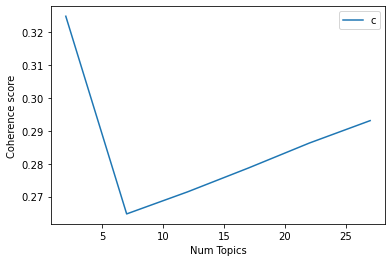

In [55]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_score2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [56]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_score2):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 2

index: 0 | Num Topics = 2  has Coherence Value of 0.3249
index: 1 | Num Topics = 7  has Coherence Value of 0.2647
index: 2 | Num Topics = 12  has Coherence Value of 0.2714
index: 3 | Num Topics = 17  has Coherence Value of 0.2787
index: 4 | Num Topics = 22  has Coherence Value of 0.2863
index: 5 | Num Topics = 27  has Coherence Value of 0.2931


In [57]:
# Select optimal number of topics
optimal_model_us_score2 = model_list_us_score2[0]

In [58]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_score2 = pyLDAvis.gensim_models.prepare(optimal_model_us_score2, corpus_us_score2, id2word_us_score2)

In [59]:
print("pyLDAVis for us topics for score=2:")
vis_us_score2

pyLDAVis for us topics for score=2:


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.104114  0.0       1        1  76.737165
0     -0.104114  0.0       2        1  23.262835, topic_info=        Term        Freq       Total Category  logprob  loglift
54    people   68.000000   68.000000  Default  30.0000  30.0000
115  comment  185.000000  185.000000  Default  29.0000  29.0000
773      pay   28.000000   28.000000  Default  28.0000  28.0000
114  channel   36.000000   36.000000  Default  27.0000  27.0000
838    music   24.000000   24.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
169   really   12.306950   61.334949   Topic2  -5.5434  -0.1479
73       bad    9.592231   33.105866   Topic2  -5.7926   0.2196
171     turn    9.620195   46.595066   Topic2  -5.7897  -0.1193
1       back   10.175779  106.758003   Topic2  -5.7335  -0.8922
288     work    9.215790   64.671827   Topic2  -5.8326  -0.4901

[146 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
192       1  0.371173   account
192       2  0.603156   account
41        1  0.969953        ad
41        2  0.033067        ad
867       1  0.146880     adult
...     ...       ...       ...
68        2  0.943745     world
548       1  0.165128     young
548       2  0.990766     young
620       1  0.147120  youtuber
620       2  0.882723  youtuber

[176 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

## LDA Topic Modelling (Rating = 3)

In [60]:
# By-rating Topic Modelling - rating = 3
# Convert to list - move to each section
review_us_score3 = youtube_ios_us_review_YearMonth_score3.review.values.tolist()
review_words_us_score3 = list(sent_to_words(review_us_score3))
print(review_words_us_score3[:1])

[['the', 'app', 'is', 'nice', 'to', 'have', 'but', 'misses', 'lot', 'of', 'features', 'like', 'viewing', 'options', 'the', 'ability', 'to', 'go', 'back', 'sometimes', 'community', 'tab', 'and', 'critical', 'features', 'like', 'being', 'able', 'to', 'actually', 'use', 'search', 'results', 'you', 'can', 'see', 'them', 'but', 'can', 'watch', 'them', 'love', 'that', 'you', 'can', 'go', 'forward', 'or', 'back', 'in', 'second', 'intervals', 'by', 'tapping', 'the', 'left', 'or', 'right', 'sides', 'of', 'the', 'video', 'but', 'if', 'you', 'accidentally', 'tap', 'forward', 'or', 'back', 'next', 'or', 'previous', 'video', 'you', 'get', 'an', 'ad', 'right', 'away', 'and', 'then', 'another', 'when', 'you', 'go', 'back', 'to', 'the', 'video', 'you', 'were', 'watching', 'there', 'are', 'way', 'more', 'ads', 'on', 'the', 'mobile', 'app', 'than', 'on', 'desktop', 'browser', 'viewing', 'just', 'use', 'chrome', 'instead', 'of', 'the', 'app']]


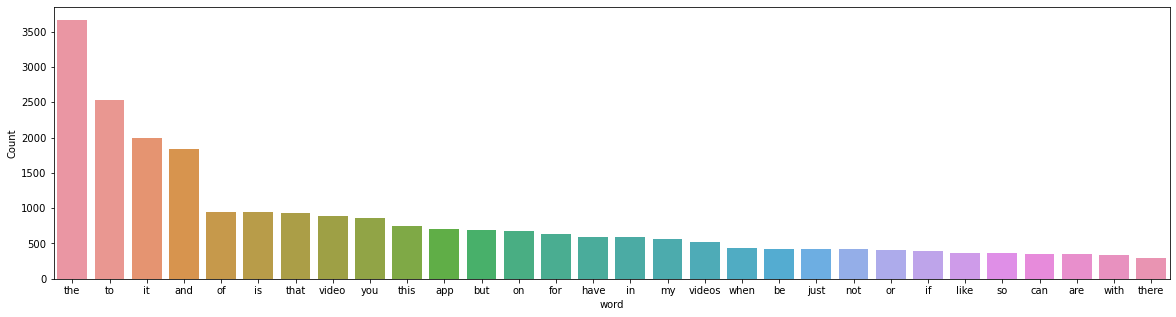

In [61]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_score3))

In [62]:
# Clean text
review_us_ready_score3 = process_words(review_words_us_score3)  # processed Text Data! - move to each section


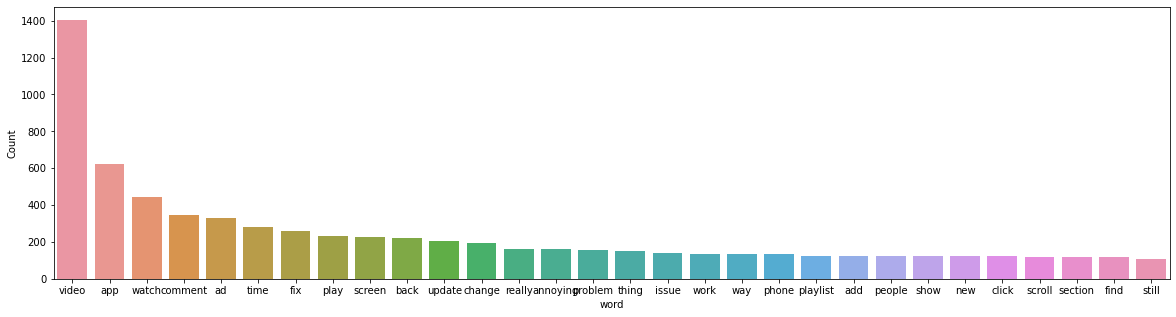

In [63]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready_score3))


In [64]:
# Create Dictionary
id2word_us_score3 = corpora.Dictionary(review_us_ready_score3)

2021-10-17 00:40:00,926 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 00:40:01,084 [INFO] gensim.corpora.dictionary - built Dictionary(2847 unique tokens: ['ability', 'able', 'accidentally', 'actually', 'ad']...) from 653 documents (total 24701 corpus positions)
2021-10-17 00:40:01,089 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(2847 unique tokens: ['ability', 'able', 'accidentally', 'actually', 'ad']...) from 653 documents (total 24701 corpus positions)", 'datetime': '2021-10-17T00:40:01.089314', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [65]:
# Create Corpus: Term Document Frequency
corpus_us_score3 = [id2word_us_score3.doc2bow(text) for text in review_us_ready_score3]

In [66]:
# Training LDA model
model_list_us_score3, coherence_values_us_score3 = compute_coherence_values(dictionary=id2word_us_score3, corpus=corpus_us_score3, 
                                                              texts=review_us_ready_score3, limit=30, start=2, step=5)


2021-10-17 00:40:02,176 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 00:40:02,178 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 00:40:02,181 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:40:02,184 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 653 documents, updating model once every 653 documents, evaluating perplexity every 653 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 00:40:05,806 [INFO] gensim.models.ldamodel - -8.431 per-word bound, 345.1 perplexity estimate based on a held-out corpus of 653 documents with 24701 words
2021-10-17 00:40:05,809 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #653/653
2021-10-17 00:40:08,879 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.053*"video" + 0.025*"app" + 0.016*"watch" + 0.016*"comment" + 0.014*"ad" + 0.012*"time" + 0.010*"chan

2021-10-17 00:40:45,397 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.033*"video" + 0.013*"app" + 0.012*"watch" + 0.010*"ad" + 0.007*"people" + 0.007*"kid" + 0.007*"fix" + 0.006*"content" + 0.005*"thing" + 0.005*"second"
2021-10-17 00:40:45,408 [INFO] gensim.models.ldamodel - topic diff=0.030460, rho=0.301511
2021-10-17 00:40:47,303 [INFO] gensim.models.ldamodel - -6.663 per-word bound, 101.3 perplexity estimate based on a held-out corpus of 653 documents with 24701 words
2021-10-17 00:40:47,304 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #653/653
2021-10-17 00:40:48,793 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.059*"video" + 0.027*"app" + 0.018*"watch" + 0.018*"comment" + 0.013*"time" + 0.013*"ad" + 0.011*"play" + 0.011*"fix" + 0.010*"screen" + 0.010*"change"
2021-10-17 00:40:48,794 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.032*"video" + 0.013*"app" + 0.011*"watch" + 0.011*"ad" + 0.007*"people" + 0.007*"kid" + 0.006*"fix" + 0.006*"content" 

2021-10-17 00:41:17,698 [INFO] gensim.models.ldamodel - topic diff=0.020041, rho=0.218218
2021-10-17 00:41:19,534 [INFO] gensim.models.ldamodel - -6.638 per-word bound, 99.6 perplexity estimate based on a held-out corpus of 653 documents with 24701 words
2021-10-17 00:41:19,539 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #653/653
2021-10-17 00:41:20,733 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.061*"video" + 0.027*"app" + 0.019*"watch" + 0.017*"comment" + 0.013*"time" + 0.012*"fix" + 0.011*"ad" + 0.011*"play" + 0.011*"screen" + 0.010*"back"
2021-10-17 00:41:20,735 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.024*"video" + 0.014*"ad" + 0.009*"app" + 0.009*"people" + 0.009*"watch" + 0.009*"kid" + 0.007*"content" + 0.006*"thing" + 0.006*"well" + 0.005*"channel"
2021-10-17 00:41:20,740 [INFO] gensim.models.ldamodel - topic diff=0.019047, rho=0.213201
2021-10-17 00:41:22,381 [INFO] gensim.models.ldamodel - -6.637 per-word bound, 99.5 perplexity estimate b

2021-10-17 00:41:50,055 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #653/653
2021-10-17 00:41:51,183 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.061*"video" + 0.028*"app" + 0.019*"watch" + 0.017*"comment" + 0.012*"time" + 0.012*"fix" + 0.011*"play" + 0.011*"screen" + 0.010*"ad" + 0.010*"back"
2021-10-17 00:41:51,187 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.021*"video" + 0.016*"ad" + 0.010*"people" + 0.010*"kid" + 0.008*"watch" + 0.008*"content" + 0.008*"app" + 0.006*"thing" + 0.006*"well" + 0.005*"channel"
2021-10-17 00:41:51,189 [INFO] gensim.models.ldamodel - topic diff=0.011100, rho=0.176777
2021-10-17 00:41:52,812 [INFO] gensim.models.ldamodel - -6.626 per-word bound, 98.8 perplexity estimate based on a held-out corpus of 653 documents with 24701 words
2021-10-17 00:41:52,815 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #653/653
2021-10-17 00:41:53,923 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.061*"video" + 0.028*"ap

2021-10-17 00:42:19,745 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.020*"video" + 0.019*"ad" + 0.011*"people" + 0.010*"kid" + 0.009*"content" + 0.008*"watch" + 0.007*"app" + 0.006*"thing" + 0.006*"well" + 0.005*"channel"
2021-10-17 00:42:19,774 [INFO] gensim.models.ldamodel - topic diff=0.006743, rho=0.154303
2021-10-17 00:42:21,294 [INFO] gensim.models.ldamodel - -6.621 per-word bound, 98.4 perplexity estimate based on a held-out corpus of 653 documents with 24701 words
2021-10-17 00:42:21,296 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #653/653
2021-10-17 00:42:22,550 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.061*"video" + 0.028*"app" + 0.019*"watch" + 0.017*"comment" + 0.012*"time" + 0.012*"fix" + 0.011*"play" + 0.011*"screen" + 0.010*"back" + 0.010*"update"
2021-10-17 00:42:22,553 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.019*"video" + 0.019*"ad" + 0.011*"people" + 0.010*"kid" + 0.009*"content" + 0.008*"watch" + 0.007*"app" + 0.006*"th

2021-10-17 00:42:49,879 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 653 virtual documents
2021-10-17 00:42:50,189 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-17 00:42:50,191 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-17 00:42:50,197 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:42:50,205 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 653 documents, updating model once every 653 documents, evaluating perplexity every 653 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 00:42:53,078 [INFO] gensim.models.ldamodel - -9.284 per-word bound, 623.4 perplexity estimate based on a held-out corpus of 653 documents with 24701 words
2021-10-17 00:42:53,080 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #653/653
2021-10-17 00:4

2021-10-17 00:43:10,087 [INFO] gensim.models.ldamodel - -6.803 per-word bound, 111.7 perplexity estimate based on a held-out corpus of 653 documents with 24701 words
2021-10-17 00:43:10,090 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #653/653
2021-10-17 00:43:11,124 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.012*"ad" + 0.010*"watch" + 0.010*"people" + 0.009*"app" + 0.007*"fix" + 0.006*"much" + 0.006*"able" + 0.006*"notification" + 0.006*"video" + 0.006*"channel"
2021-10-17 00:43:11,125 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.045*"video" + 0.025*"watch" + 0.014*"app" + 0.011*"channel" + 0.011*"show" + 0.011*"time" + 0.008*"people" + 0.008*"delete" + 0.007*"feature" + 0.007*"screen"
2021-10-17 00:43:11,128 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.025*"video" + 0.018*"kid" + 0.010*"app" + 0.010*"back" + 0.009*"day" + 0.008*"turn" + 0.008*"search" + 0.008*"find" + 0.006*"view" + 0.006*"people"
2021-10-17 00:43:11,131 [INFO] gensim.models.ld

2021-10-17 00:43:24,418 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.041*"add" + 0.017*"playlist" + 0.010*"video" + 0.008*"song" + 0.008*"full" + 0.007*"season" + 0.006*"time" + 0.006*"keep" + 0.006*"update" + 0.006*"recommendation"
2021-10-17 00:43:24,423 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.037*"comment" + 0.033*"change" + 0.027*"video" + 0.023*"app" + 0.016*"section" + 0.012*"update" + 0.011*"really" + 0.010*"back" + 0.009*"time" + 0.008*"way"
2021-10-17 00:43:24,431 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.028*"song" + 0.014*"play" + 0.012*"shuffle" + 0.009*"phone" + 0.009*"playlist" + 0.008*"video" + 0.007*"let" + 0.007*"stream" + 0.006*"charge" + 0.006*"platform"
2021-10-17 00:43:24,435 [INFO] gensim.models.ldamodel - topic diff=0.032668, rho=0.288675
2021-10-17 00:43:25,958 [INFO] gensim.models.ldamodel - -6.773 per-word bound, 109.4 perplexity estimate based on a held-out corpus of 653 documents with 24701 words
2021-10-17 00:43:25,959 [INFO] ge

2021-10-17 00:43:40,239 [INFO] gensim.models.ldamodel - topic diff=0.017563, rho=0.242536
2021-10-17 00:43:41,975 [INFO] gensim.models.ldamodel - -6.764 per-word bound, 108.7 perplexity estimate based on a held-out corpus of 653 documents with 24701 words
2021-10-17 00:43:41,976 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #653/653
2021-10-17 00:43:43,109 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.041*"video" + 0.024*"watch" + 0.012*"app" + 0.012*"channel" + 0.011*"show" + 0.009*"download" + 0.009*"people" + 0.009*"time" + 0.009*"delete" + 0.008*"feature"
2021-10-17 00:43:43,111 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.043*"comment" + 0.033*"change" + 0.026*"video" + 0.022*"app" + 0.019*"section" + 0.013*"update" + 0.011*"really" + 0.011*"back" + 0.009*"way" + 0.009*"time"
2021-10-17 00:43:43,117 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.076*"video" + 0.032*"app" + 0.023*"watch" + 0.020*"ad" + 0.014*"fix" + 0.014*"play" + 0.014*"screen" +

2021-10-17 00:43:56,204 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.033*"song" + 0.017*"shuffle" + 0.014*"play" + 0.011*"playlist" + 0.007*"phone" + 0.007*"let" + 0.007*"stream" + 0.006*"charge" + 0.006*"video" + 0.006*"platform"
2021-10-17 00:43:56,208 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.022*"kid" + 0.019*"video" + 0.010*"day" + 0.009*"find" + 0.007*"tube" + 0.007*"view" + 0.006*"claim" + 0.006*"back" + 0.006*"people" + 0.006*"app"
2021-10-17 00:43:56,210 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.040*"video" + 0.023*"watch" + 0.012*"channel" + 0.012*"app" + 0.011*"show" + 0.011*"download" + 0.009*"delete" + 0.009*"people" + 0.008*"time" + 0.007*"feature"
2021-10-17 00:43:56,213 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.015*"ad" + 0.013*"people" + 0.007*"watch" + 0.007*"free" + 0.007*"able" + 0.007*"much" + 0.006*"stop" + 0.006*"notification" + 0.006*"platform" + 0.005*"setting"
2021-10-17 00:43:56,216 [INFO] gensim.models.ldamodel - topic di

2021-10-17 00:44:09,078 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.034*"song" + 0.018*"shuffle" + 0.014*"play" + 0.011*"playlist" + 0.007*"stream" + 0.007*"let" + 0.007*"phone" + 0.006*"charge" + 0.006*"platform" + 0.006*"random"
2021-10-17 00:44:09,080 [INFO] gensim.models.ldamodel - topic diff=0.008159, rho=0.188982
2021-10-17 00:44:10,601 [INFO] gensim.models.ldamodel - -6.752 per-word bound, 107.8 perplexity estimate based on a held-out corpus of 653 documents with 24701 words
2021-10-17 00:44:10,603 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #653/653
2021-10-17 00:44:11,718 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.034*"song" + 0.018*"shuffle" + 0.014*"play" + 0.011*"playlist" + 0.007*"stream" + 0.007*"let" + 0.007*"phone" + 0.006*"charge" + 0.006*"platform" + 0.006*"random"
2021-10-17 00:44:11,720 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.039*"video" + 0.023*"watch" + 0.013*"channel" + 0.012*"download" + 0.012*"app" + 0.011*"show" 

2021-10-17 00:44:26,104 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.050*"comment" + 0.033*"change" + 0.026*"video" + 0.021*"section" + 0.020*"app" + 0.012*"update" + 0.012*"back" + 0.011*"really" + 0.010*"way" + 0.009*"new"
2021-10-17 00:44:26,107 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.048*"add" + 0.017*"playlist" + 0.009*"song" + 0.008*"season" + 0.007*"recommendation" + 0.007*"time" + 0.006*"play" + 0.006*"full" + 0.006*"watch" + 0.005*"never"
2021-10-17 00:44:26,110 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.016*"ad" + 0.013*"people" + 0.007*"free" + 0.007*"much" + 0.007*"stop" + 0.007*"watch" + 0.007*"platform" + 0.006*"able" + 0.006*"notification" + 0.005*"thing"
2021-10-17 00:44:26,113 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.035*"song" + 0.018*"shuffle" + 0.014*"play" + 0.011*"playlist" + 0.007*"stream" + 0.007*"let" + 0.007*"phone" + 0.007*"charge" + 0.006*"platform" + 0.006*"random"
2021-10-17 00:44:26,116 [INFO] gensim.models.ldamodel 

2021-10-17 00:44:41,598 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.016*"ad" + 0.013*"people" + 0.007*"free" + 0.007*"stop" + 0.007*"much" + 0.007*"platform" + 0.007*"watch" + 0.006*"able" + 0.006*"notification" + 0.006*"thing"
2021-10-17 00:44:41,600 [INFO] gensim.models.ldamodel - topic diff=0.005137, rho=0.160128
2021-10-17 00:44:43,829 [INFO] gensim.models.ldamodel - -6.746 per-word bound, 107.3 perplexity estimate based on a held-out corpus of 653 documents with 24701 words
2021-10-17 00:44:43,832 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #653/653
2021-10-17 00:44:45,377 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.049*"add" + 0.017*"playlist" + 0.009*"song" + 0.008*"season" + 0.007*"recommendation" + 0.007*"time" + 0.006*"play" + 0.006*"watch" + 0.006*"never" + 0.005*"video"
2021-10-17 00:44:45,381 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.037*"video" + 0.022*"watch" + 0.014*"download" + 0.014*"channel" + 0.011*"show" + 0.011*"app" + 

2021-10-17 00:45:02,114 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.052*"comment" + 0.034*"change" + 0.026*"video" + 0.022*"section" + 0.019*"app" + 0.012*"update" + 0.012*"back" + 0.011*"really" + 0.010*"way" + 0.009*"new"
2021-10-17 00:45:02,116 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.036*"song" + 0.019*"shuffle" + 0.014*"play" + 0.011*"playlist" + 0.007*"stream" + 0.007*"let" + 0.007*"charge" + 0.006*"phone" + 0.006*"platform" + 0.006*"random"
2021-10-17 00:45:02,119 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.024*"kid" + 0.018*"video" + 0.010*"day" + 0.009*"find" + 0.008*"tube" + 0.007*"claim" + 0.007*"view" + 0.006*"free" + 0.006*"people" + 0.006*"love"
2021-10-17 00:45:02,122 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.036*"video" + 0.022*"watch" + 0.014*"download" + 0.014*"channel" + 0.011*"show" + 0.011*"app" + 0.010*"delete" + 0.010*"people" + 0.007*"feature" + 0.007*"time"
2021-10-17 00:45:02,124 [INFO] gensim.models.ldamodel - topic diff=0

2021-10-17 00:45:17,286 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.017*"ad" + 0.013*"people" + 0.007*"free" + 0.007*"stop" + 0.007*"much" + 0.007*"platform" + 0.006*"watch" + 0.006*"able" + 0.006*"notification" + 0.006*"thing"
2021-10-17 00:45:17,288 [INFO] gensim.models.ldamodel - topic diff=0.003571, rho=0.141421
2021-10-17 00:45:18,850 [INFO] gensim.models.ldamodel - -6.742 per-word bound, 107.1 perplexity estimate based on a held-out corpus of 653 documents with 24701 words
2021-10-17 00:45:18,852 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #653/653
2021-10-17 00:45:20,384 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.036*"song" + 0.019*"shuffle" + 0.014*"play" + 0.011*"playlist" + 0.007*"stream" + 0.007*"let" + 0.007*"charge" + 0.006*"platform" + 0.006*"phone" + 0.006*"random"
2021-10-17 00:45:20,387 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.051*"add" + 0.018*"playlist" + 0.009*"song" + 0.008*"season" + 0.007*"recommendation" + 0.007*"ti

2021-10-17 00:45:46,099 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.053*"add" + 0.031*"playlist" + 0.030*"video" + 0.013*"really" + 0.012*"season" + 0.009*"rest" + 0.008*"time" + 0.008*"end" + 0.007*"advertisement" + 0.007*"place"
2021-10-17 00:45:46,100 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.082*"video" + 0.027*"ad" + 0.026*"watch" + 0.022*"app" + 0.016*"comment" + 0.014*"play" + 0.013*"time" + 0.012*"screen" + 0.012*"fix" + 0.011*"back"
2021-10-17 00:45:46,102 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.016*"watch" + 0.013*"stream" + 0.012*"phone" + 0.009*"let" + 0.009*"anti" + 0.008*"video" + 0.008*"thing" + 0.008*"look" + 0.008*"play" + 0.007*"later"
2021-10-17 00:45:46,103 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.039*"change" + 0.035*"video" + 0.020*"quality" + 0.015*"comment" + 0.013*"time" + 0.012*"back" + 0.012*"play" + 0.012*"song" + 0.011*"section" + 0.010*"choose"
2021-10-17 00:45:46,105 [INFO] gensim.models.ldamodel - topic diff=0.23

2021-10-17 00:46:02,863 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.012*"free" + 0.011*"people" + 0.010*"speech" + 0.008*"watch" + 0.008*"find" + 0.007*"become" + 0.007*"never" + 0.007*"tube" + 0.006*"platform" + 0.006*"let"
2021-10-17 00:46:02,864 [INFO] gensim.models.ldamodel - topic diff=0.064716, rho=0.316228
2021-10-17 00:46:04,504 [INFO] gensim.models.ldamodel - -6.870 per-word bound, 117.0 perplexity estimate based on a held-out corpus of 653 documents with 24701 words
2021-10-17 00:46:04,508 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #653/653
2021-10-17 00:46:05,832 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.059*"video" + 0.037*"kid" + 0.023*"search" + 0.017*"app" + 0.012*"play" + 0.011*"update" + 0.010*"time" + 0.009*"start" + 0.008*"delete" + 0.007*"mean"
2021-10-17 00:46:05,833 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.012*"free" + 0.011*"people" + 0.010*"speech" + 0.008*"watch" + 0.008*"find" + 0.007*"become" + 0.007*"tube" + 0.

2021-10-17 00:46:20,215 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.018*"stream" + 0.016*"watch" + 0.012*"phone" + 0.011*"anti" + 0.009*"let" + 0.008*"thing" + 0.008*"later" + 0.007*"stupid" + 0.007*"chat" + 0.007*"play"
2021-10-17 00:46:20,216 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.059*"app" + 0.046*"video" + 0.019*"fix" + 0.017*"screen" + 0.017*"phone" + 0.014*"update" + 0.013*"play" + 0.013*"time" + 0.012*"work" + 0.012*"problem"
2021-10-17 00:46:20,217 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.050*"video" + 0.034*"watch" + 0.014*"channel" + 0.013*"show" + 0.011*"people" + 0.010*"screen" + 0.010*"well" + 0.010*"app" + 0.010*"resolution" + 0.009*"time"
2021-10-17 00:46:20,219 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.084*"video" + 0.029*"ad" + 0.028*"watch" + 0.022*"app" + 0.014*"comment" + 0.014*"time" + 0.014*"play" + 0.012*"back" + 0.011*"fix" + 0.011*"screen"
2021-10-17 00:46:20,220 [INFO] gensim.models.ldamodel - topic diff=0.025318, rho=

2021-10-17 00:46:37,662 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.060*"video" + 0.042*"kid" + 0.025*"search" + 0.016*"app" + 0.011*"play" + 0.010*"update" + 0.009*"time" + 0.008*"delete" + 0.008*"mean" + 0.007*"start"
2021-10-17 00:46:37,663 [INFO] gensim.models.ldamodel - topic diff=0.015867, rho=0.218218
2021-10-17 00:46:39,738 [INFO] gensim.models.ldamodel - -6.837 per-word bound, 114.3 perplexity estimate based on a held-out corpus of 653 documents with 24701 words
2021-10-17 00:46:39,740 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #653/653
2021-10-17 00:46:40,985 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.013*"free" + 0.012*"people" + 0.010*"speech" + 0.008*"become" + 0.008*"find" + 0.007*"watch" + 0.007*"tube" + 0.007*"platform" + 0.006*"never" + 0.006*"let"
2021-10-17 00:46:40,986 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.049*"video" + 0.034*"watch" + 0.015*"channel" + 0.013*"show" + 0.012*"people" + 0.011*"resolution" + 0.010*"wel

2021-10-17 00:46:58,228 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.060*"video" + 0.044*"kid" + 0.026*"search" + 0.015*"app" + 0.010*"play" + 0.010*"update" + 0.009*"time" + 0.008*"delete" + 0.008*"mean" + 0.007*"much"
2021-10-17 00:46:58,230 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.018*"stream" + 0.017*"watch" + 0.012*"phone" + 0.011*"commercial" + 0.011*"anti" + 0.009*"let" + 0.009*"livestream" + 0.008*"thing" + 0.008*"later" + 0.008*"chat"
2021-10-17 00:46:58,236 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.085*"video" + 0.030*"ad" + 0.029*"watch" + 0.022*"app" + 0.014*"time" + 0.014*"play" + 0.012*"comment" + 0.012*"back" + 0.011*"screen" + 0.011*"fix"
2021-10-17 00:46:58,238 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.039*"change" + 0.039*"quality" + 0.033*"video" + 0.028*"song" + 0.017*"choose" + 0.016*"time" + 0.016*"play" + 0.014*"high" + 0.013*"set" + 0.010*"fix"
2021-10-17 00:46:58,241 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.049*

2021-10-17 00:47:14,977 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.011*"day" + 0.011*"tube" + 0.010*"great" + 0.009*"turn" + 0.009*"back" + 0.009*"find" + 0.008*"love" + 0.008*"really" + 0.007*"row" + 0.007*"free"
2021-10-17 00:47:14,980 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.036*"comment" + 0.016*"ad" + 0.016*"section" + 0.014*"watch" + 0.011*"leave" + 0.009*"video" + 0.009*"reply" + 0.008*"side" + 0.008*"people" + 0.008*"put"
2021-10-17 00:47:14,981 [INFO] gensim.models.ldamodel - topic diff=0.008916, rho=0.176777
2021-10-17 00:47:17,138 [INFO] gensim.models.ldamodel - -6.823 per-word bound, 113.2 perplexity estimate based on a held-out corpus of 653 documents with 24701 words
2021-10-17 00:47:17,182 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #653/653
2021-10-17 00:47:18,629 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.034*"video" + 0.016*"playlist" + 0.013*"app" + 0.012*"delete" + 0.012*"update" + 0.011*"save" + 0.010*"people" + 0.00

2021-10-17 00:47:32,683 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #653/653
2021-10-17 00:47:33,974 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.014*"free" + 0.012*"people" + 0.010*"speech" + 0.008*"become" + 0.007*"find" + 0.007*"watch" + 0.007*"tube" + 0.007*"censorship" + 0.007*"platform" + 0.006*"wrong"
2021-10-17 00:47:33,976 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.085*"video" + 0.030*"ad" + 0.030*"watch" + 0.021*"app" + 0.014*"time" + 0.014*"play" + 0.012*"back" + 0.011*"screen" + 0.011*"comment" + 0.010*"fix"
2021-10-17 00:47:33,977 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.043*"video" + 0.032*"watch" + 0.016*"channel" + 0.013*"show" + 0.013*"people" + 0.012*"resolution" + 0.010*"well" + 0.010*"screen" + 0.010*"feature" + 0.008*"app"
2021-10-17 00:47:33,979 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.011*"day" + 0.011*"tube" + 0.010*"great" + 0.009*"turn" + 0.009*"find" + 0.009*"back" + 0.008*"love" + 0.008*"really" + 0.00

2021-10-17 00:47:49,859 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.014*"free" + 0.012*"people" + 0.010*"speech" + 0.008*"become" + 0.007*"watch" + 0.007*"find" + 0.007*"tube" + 0.007*"censorship" + 0.007*"platform" + 0.006*"wrong"
2021-10-17 00:47:49,862 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.059*"comment" + 0.039*"change" + 0.031*"video" + 0.026*"section" + 0.017*"app" + 0.016*"back" + 0.013*"way" + 0.012*"new" + 0.012*"really" + 0.011*"update"
2021-10-17 00:47:49,865 [INFO] gensim.models.ldamodel - topic diff=0.005745, rho=0.152499
2021-10-17 00:47:51,503 [INFO] gensim.models.ldamodel - -6.815 per-word bound, 112.6 perplexity estimate based on a held-out corpus of 653 documents with 24701 words
2021-10-17 00:47:51,505 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #653/653
2021-10-17 00:47:52,757 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.033*"video" + 0.016*"playlist" + 0.014*"app" + 0.012*"delete" + 0.012*"update" + 0.011*"save" + 0.0

2021-10-17 00:48:05,434 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #653/653
2021-10-17 00:48:06,533 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.032*"video" + 0.016*"playlist" + 0.014*"app" + 0.012*"delete" + 0.012*"update" + 0.011*"save" + 0.010*"people" + 0.009*"really" + 0.008*"able" + 0.007*"player"
2021-10-17 00:48:06,535 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.026*"comment" + 0.017*"ad" + 0.013*"watch" + 0.010*"leave" + 0.010*"section" + 0.008*"side" + 0.008*"put" + 0.008*"reply" + 0.007*"people" + 0.007*"content"
2021-10-17 00:48:06,538 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.086*"video" + 0.031*"ad" + 0.030*"watch" + 0.021*"app" + 0.014*"time" + 0.014*"play" + 0.012*"back" + 0.011*"screen" + 0.010*"fix" + 0.010*"annoying"
2021-10-17 00:48:06,540 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.091*"add" + 0.048*"playlist" + 0.015*"video" + 0.014*"season" + 0.010*"change" + 0.010*"rest" + 0.008*"episode" + 0.008*"really" + 0

2021-10-17 00:48:30,310 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.012*"video" + 0.011*"watch" + 0.010*"fix" + 0.009*"problem" + 0.009*"speech" + 0.009*"free" + 0.007*"comment" + 0.007*"account" + 0.007*"search" + 0.006*"people"
2021-10-17 00:48:30,313 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.024*"comment" + 0.021*"app" + 0.018*"ad" + 0.017*"video" + 0.016*"phone" + 0.015*"section" + 0.009*"update" + 0.008*"watch" + 0.008*"leave" + 0.008*"people"
2021-10-17 00:48:30,314 [INFO] gensim.models.ldamodel - topic diff=0.401997, rho=0.577350
2021-10-17 00:48:32,317 [INFO] gensim.models.ldamodel - -7.124 per-word bound, 139.4 perplexity estimate based on a held-out corpus of 653 documents with 24701 words
2021-10-17 00:48:32,322 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #653/653
2021-10-17 00:48:33,677 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.024*"app" + 0.017*"time" + 0.016*"video" + 0.011*"comment" + 0.010*"back" + 0.010*"music" + 0.010*"ad

2021-10-17 00:48:48,078 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #653/653
2021-10-17 00:48:49,163 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.011*"speech" + 0.009*"free" + 0.009*"account" + 0.009*"platform" + 0.007*"fix" + 0.007*"watch" + 0.007*"comment" + 0.007*"people" + 0.007*"give" + 0.007*"video"
2021-10-17 00:48:49,166 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.067*"video" + 0.047*"kid" + 0.027*"app" + 0.012*"search" + 0.010*"play" + 0.009*"bug" + 0.008*"playlist" + 0.008*"start" + 0.008*"update" + 0.007*"work"
2021-10-17 00:48:49,170 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.017*"watch" + 0.015*"video" + 0.014*"anti" + 0.012*"day" + 0.009*"way" + 0.009*"stop" + 0.009*"change" + 0.009*"love" + 0.008*"phone" + 0.008*"thing"
2021-10-17 00:48:49,174 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.047*"video" + 0.024*"playlist" + 0.013*"update" + 0.013*"app" + 0.013*"delete" + 0.012*"fix" + 0.011*"comment" + 0.011*"new" + 0.010*"ba

2021-10-17 00:49:05,204 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.047*"video" + 0.043*"change" + 0.042*"quality" + 0.017*"choose" + 0.016*"high" + 0.014*"problem" + 0.014*"fix" + 0.013*"set" + 0.013*"back" + 0.013*"time"
2021-10-17 00:49:05,206 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.029*"video" + 0.017*"app" + 0.012*"update" + 0.011*"watch" + 0.010*"happen" + 0.010*"feature" + 0.008*"download" + 0.008*"channel" + 0.008*"really" + 0.007*"people"
2021-10-17 00:49:05,207 [INFO] gensim.models.ldamodel - topic diff=0.039017, rho=0.267261
2021-10-17 00:49:06,882 [INFO] gensim.models.ldamodel - -6.918 per-word bound, 121.0 perplexity estimate based on a held-out corpus of 653 documents with 24701 words
2021-10-17 00:49:06,888 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #653/653
2021-10-17 00:49:08,129 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.027*"resolution" + 0.025*"people" + 0.015*"well" + 0.012*"screen" + 0.011*"season" + 0.010*"conte

2021-10-17 00:49:20,124 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #653/653
2021-10-17 00:49:21,054 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.063*"comment" + 0.044*"change" + 0.029*"video" + 0.029*"section" + 0.017*"back" + 0.013*"way" + 0.013*"app" + 0.013*"move" + 0.012*"update" + 0.011*"look"
2021-10-17 00:49:21,056 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.068*"video" + 0.055*"kid" + 0.022*"app" + 0.010*"search" + 0.009*"play" + 0.008*"private" + 0.008*"playlist" + 0.007*"yt" + 0.007*"much" + 0.007*"post"
2021-10-17 00:49:21,059 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.029*"app" + 0.023*"video" + 0.021*"update" + 0.014*"search" + 0.013*"screen" + 0.013*"add" + 0.013*"channel" + 0.011*"kid" + 0.009*"device" + 0.009*"turn"
2021-10-17 00:49:21,061 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.049*"video" + 0.025*"playlist" + 0.015*"delete" + 0.014*"app" + 0.012*"fix" + 0.012*"update" + 0.011*"save" + 0.011*"new" + 0.010*"back"

2021-10-17 00:49:34,040 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.086*"video" + 0.031*"ad" + 0.030*"watch" + 0.023*"app" + 0.015*"time" + 0.014*"comment" + 0.013*"back" + 0.013*"play" + 0.012*"fix" + 0.011*"screen"
2021-10-17 00:49:34,043 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.067*"comment" + 0.043*"change" + 0.030*"section" + 0.029*"video" + 0.017*"back" + 0.014*"way" + 0.013*"move" + 0.012*"app" + 0.012*"update" + 0.011*"look"
2021-10-17 00:49:34,044 [INFO] gensim.models.ldamodel - topic diff=0.012717, rho=0.200000
2021-10-17 00:49:35,611 [INFO] gensim.models.ldamodel - -6.890 per-word bound, 118.6 perplexity estimate based on a held-out corpus of 653 documents with 24701 words
2021-10-17 00:49:35,614 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #653/653
2021-10-17 00:49:36,766 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.029*"app" + 0.023*"video" + 0.019*"update" + 0.014*"search" + 0.013*"add" + 0.013*"screen" + 0.013*"channel" + 0.01

2021-10-17 00:49:52,851 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #653/653
2021-10-17 00:49:54,348 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.027*"video" + 0.011*"app" + 0.010*"feature" + 0.010*"download" + 0.009*"happen" + 0.009*"channel" + 0.008*"watch" + 0.008*"really" + 0.008*"topic" + 0.008*"delete"
2021-10-17 00:49:54,351 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.018*"watch" + 0.014*"video" + 0.014*"anti" + 0.012*"day" + 0.009*"way" + 0.009*"stop" + 0.009*"change" + 0.008*"love" + 0.008*"thing" + 0.007*"phone"
2021-10-17 00:49:54,358 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.023*"app" + 0.016*"time" + 0.015*"service" + 0.015*"music" + 0.013*"add" + 0.011*"listen" + 0.011*"premium" + 0.010*"pay" + 0.009*"really" + 0.009*"watch"
2021-10-17 00:49:54,362 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.062*"app" + 0.054*"video" + 0.023*"screen" + 0.020*"phone" + 0.020*"play" + 0.019*"fix" + 0.015*"work" + 0.014*"issue" + 0.013*"h

2021-10-17 00:50:08,677 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.050*"video" + 0.026*"playlist" + 0.016*"delete" + 0.014*"app" + 0.012*"fix" + 0.012*"save" + 0.012*"update" + 0.011*"new" + 0.011*"download" + 0.010*"player"
2021-10-17 00:50:08,679 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.033*"resolution" + 0.026*"people" + 0.015*"well" + 0.011*"screen" + 0.011*"season" + 0.011*"medium" + 0.010*"content" + 0.010*"add" + 0.009*"great" + 0.008*"decide"
2021-10-17 00:50:08,681 [INFO] gensim.models.ldamodel - topic diff=0.006664, rho=0.166667
2021-10-17 00:50:10,034 [INFO] gensim.models.ldamodel - -6.877 per-word bound, 117.5 perplexity estimate based on a held-out corpus of 653 documents with 24701 words
2021-10-17 00:50:10,038 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #653/653
2021-10-17 00:50:11,077 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.033*"resolution" + 0.026*"people" + 0.015*"well" + 0.011*"screen" + 0.011*"season" + 0.011*"me

2021-10-17 00:50:22,503 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #653/653
2021-10-17 00:50:23,398 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.017*"speech" + 0.014*"platform" + 0.011*"free" + 0.010*"conservative" + 0.010*"people" + 0.008*"comment" + 0.008*"give" + 0.008*"site" + 0.006*"watch" + 0.005*"search"
2021-10-17 00:50:23,400 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.050*"video" + 0.026*"playlist" + 0.016*"delete" + 0.014*"app" + 0.012*"fix" + 0.012*"save" + 0.012*"update" + 0.011*"new" + 0.011*"download" + 0.010*"player"
2021-10-17 00:50:23,402 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.071*"comment" + 0.043*"change" + 0.031*"section" + 0.028*"video" + 0.018*"back" + 0.014*"way" + 0.013*"move" + 0.012*"scroll" + 0.012*"app" + 0.012*"update"
2021-10-17 00:50:23,404 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.094*"playlist" + 0.083*"song" + 0.039*"add" + 0.025*"music" + 0.022*"play" + 0.017*"video" + 0.012*"change" + 0.011*

2021-10-17 00:50:35,370 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.098*"playlist" + 0.083*"song" + 0.039*"add" + 0.025*"music" + 0.022*"play" + 0.017*"video" + 0.013*"change" + 0.011*"hear" + 0.011*"list" + 0.011*"watch"
2021-10-17 00:50:35,371 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.060*"video" + 0.033*"watch" + 0.016*"channel" + 0.012*"show" + 0.012*"app" + 0.011*"time" + 0.011*"feature" + 0.009*"add" + 0.008*"volume" + 0.007*"keep"
2021-10-17 00:50:35,372 [INFO] gensim.models.ldamodel - topic diff=0.003903, rho=0.145865
2021-10-17 00:50:36,750 [INFO] gensim.models.ldamodel - -6.871 per-word bound, 117.1 perplexity estimate based on a held-out corpus of 653 documents with 24701 words
2021-10-17 00:50:36,751 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #653/653
2021-10-17 00:50:37,750 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.024*"comment" + 0.016*"phone" + 0.014*"leave" + 0.013*"section" + 0.012*"ad" + 0.010*"people" + 0.010*"app" + 0.

2021-10-17 00:50:58,242 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.022*"video" + 0.021*"time" + 0.020*"app" + 0.015*"comment" + 0.014*"back" + 0.013*"way" + 0.012*"add" + 0.010*"service" + 0.010*"ad" + 0.009*"screen"
2021-10-17 00:50:58,244 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.081*"video" + 0.028*"ad" + 0.022*"watch" + 0.022*"app" + 0.017*"comment" + 0.013*"play" + 0.012*"fix" + 0.011*"time" + 0.011*"screen" + 0.011*"back"
2021-10-17 00:50:58,246 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.028*"video" + 0.014*"update" + 0.012*"post" + 0.012*"new" + 0.010*"app" + 0.010*"way" + 0.009*"let" + 0.009*"stop" + 0.008*"wish" + 0.008*"folk"
2021-10-17 00:50:58,247 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.070*"video" + 0.038*"watch" + 0.015*"app" + 0.015*"time" + 0.011*"show" + 0.010*"thing" + 0.009*"channel" + 0.009*"add" + 0.009*"fix" + 0.007*"really"
2021-10-17 00:50:58,248 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.044*"video" + 0.039*"ap

2021-10-17 00:51:13,480 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.026*"people" + 0.023*"resolution" + 0.017*"well" + 0.015*"screen" + 0.015*"season" + 0.013*"add" + 0.011*"display" + 0.009*"publisher" + 0.009*"absurd" + 0.009*"content"
2021-10-17 00:51:13,482 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.060*"app" + 0.041*"video" + 0.017*"fix" + 0.016*"phone" + 0.014*"work" + 0.014*"update" + 0.012*"bug" + 0.012*"screen" + 0.011*"happen" + 0.011*"play"
2021-10-17 00:51:13,484 [INFO] gensim.models.ldamodel - topic diff=0.194251, rho=0.377964
2021-10-17 00:51:16,240 [INFO] gensim.models.ldamodel - -7.049 per-word bound, 132.4 perplexity estimate based on a held-out corpus of 653 documents with 24701 words
2021-10-17 00:51:16,241 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #653/653
2021-10-17 00:51:18,151 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.061*"app" + 0.042*"video" + 0.017*"fix" + 0.016*"phone" + 0.014*"work" + 0.014*"update" + 0.012*"bu

2021-10-17 00:51:31,739 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #653/653
2021-10-17 00:51:33,022 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.019*"time" + 0.019*"service" + 0.017*"video" + 0.015*"add" + 0.014*"app" + 0.014*"premium" + 0.013*"pay" + 0.013*"screen" + 0.013*"way" + 0.012*"back"
2021-10-17 00:51:33,024 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.026*"resolution" + 0.026*"people" + 0.017*"well" + 0.015*"screen" + 0.015*"season" + 0.014*"add" + 0.012*"display" + 0.009*"publisher" + 0.009*"absurd" + 0.009*"content"
2021-10-17 00:51:33,027 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.028*"song" + 0.020*"ad" + 0.019*"video" + 0.014*"shuffle" + 0.014*"watch" + 0.012*"playlist" + 0.011*"stop" + 0.010*"play" + 0.010*"people" + 0.009*"work"
2021-10-17 00:51:33,030 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.027*"ad" + 0.021*"video" + 0.015*"app" + 0.015*"watch" + 0.011*"put" + 0.010*"much" + 0.009*"phone" + 0.008*"star" + 0.00

2021-10-17 00:51:48,339 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.041*"app" + 0.038*"video" + 0.024*"time" + 0.017*"watch" + 0.013*"update" + 0.012*"download" + 0.012*"keep" + 0.012*"fix" + 0.012*"play" + 0.009*"work"
2021-10-17 00:51:48,343 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.090*"video" + 0.033*"ad" + 0.028*"watch" + 0.022*"app" + 0.016*"play" + 0.014*"comment" + 0.013*"back" + 0.013*"time" + 0.013*"screen" + 0.012*"fix"
2021-10-17 00:51:48,349 [INFO] gensim.models.ldamodel - topic diff=0.027910, rho=0.235702
2021-10-17 00:51:50,091 [INFO] gensim.models.ldamodel - -6.966 per-word bound, 125.1 perplexity estimate based on a held-out corpus of 653 documents with 24701 words
2021-10-17 00:51:50,093 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #653/653
2021-10-17 00:51:51,141 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.061*"video" + 0.021*"app" + 0.021*"quality" + 0.018*"player" + 0.017*"feature" + 0.016*"fix" + 0.013*"play" + 0.011*"

2021-10-17 00:52:03,260 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #653/653
2021-10-17 00:52:04,262 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.177*"playlist" + 0.089*"add" + 0.045*"song" + 0.034*"video" + 0.032*"save" + 0.019*"play" + 0.018*"favorite" + 0.016*"list" + 0.012*"music" + 0.012*"time"
2021-10-17 00:52:04,264 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.068*"video" + 0.047*"kid" + 0.030*"search" + 0.030*"app" + 0.012*"friendly" + 0.011*"watch" + 0.010*"turn" + 0.010*"bug" + 0.010*"child" + 0.010*"start"
2021-10-17 00:52:04,266 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.037*"video" + 0.020*"back" + 0.017*"turn" + 0.016*"tube" + 0.015*"find" + 0.015*"caption" + 0.015*"row" + 0.013*"watch" + 0.011*"next" + 0.010*"free"
2021-10-17 00:52:04,268 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.062*"video" + 0.021*"quality" + 0.020*"app" + 0.020*"player" + 0.017*"feature" + 0.015*"fix" + 0.014*"play" + 0.012*"mini" + 0.011*"audio" + 

2021-10-17 00:52:16,477 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.062*"app" + 0.042*"video" + 0.022*"fix" + 0.018*"phone" + 0.015*"bug" + 0.015*"update" + 0.015*"work" + 0.013*"screen" + 0.013*"problem" + 0.012*"happen"
2021-10-17 00:52:16,479 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.026*"ad" + 0.020*"video" + 0.016*"app" + 0.013*"watch" + 0.012*"put" + 0.011*"much" + 0.010*"stuff" + 0.010*"channel" + 0.009*"star" + 0.009*"option"
2021-10-17 00:52:16,482 [INFO] gensim.models.ldamodel - topic diff=0.011602, rho=0.185695
2021-10-17 00:52:18,032 [INFO] gensim.models.ldamodel - -6.941 per-word bound, 122.9 perplexity estimate based on a held-out corpus of 653 documents with 24701 words
2021-10-17 00:52:18,034 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #653/653
2021-10-17 00:52:18,978 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.046*"video" + 0.017*"play" + 0.017*"change" + 0.014*"choose" + 0.014*"quality" + 0.014*"select" + 0.011*"account" +

2021-10-17 00:52:31,201 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #653/653
2021-10-17 00:52:32,244 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.046*"video" + 0.018*"tab" + 0.015*"view" + 0.012*"back" + 0.010*"new" + 0.010*"tube" + 0.009*"always" + 0.009*"delete" + 0.009*"able" + 0.009*"people"
2021-10-17 00:52:32,245 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.033*"post" + 0.023*"video" + 0.020*"ban" + 0.018*"stop" + 0.016*"let" + 0.014*"day" + 0.013*"view" + 0.013*"remove" + 0.012*"platform" + 0.010*"wish"
2021-10-17 00:52:32,247 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.067*"video" + 0.048*"kid" + 0.031*"search" + 0.030*"app" + 0.012*"friendly" + 0.011*"turn" + 0.011*"child" + 0.010*"start" + 0.010*"watch" + 0.010*"bug"
2021-10-17 00:52:32,249 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.073*"video" + 0.047*"watch" + 0.016*"app" + 0.011*"feature" + 0.011*"show" + 0.011*"page" + 0.011*"time" + 0.010*"subscription" + 0.010*"thing" +

2021-10-17 00:52:44,910 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.033*"post" + 0.023*"video" + 0.021*"ban" + 0.019*"stop" + 0.016*"let" + 0.015*"day" + 0.013*"view" + 0.013*"remove" + 0.012*"platform" + 0.010*"wish"
2021-10-17 00:52:44,911 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.093*"video" + 0.036*"ad" + 0.029*"watch" + 0.022*"app" + 0.017*"play" + 0.013*"back" + 0.013*"time" + 0.013*"screen" + 0.012*"fix" + 0.010*"comment"
2021-10-17 00:52:44,914 [INFO] gensim.models.ldamodel - topic diff=0.006690, rho=0.158114
2021-10-17 00:52:46,473 [INFO] gensim.models.ldamodel - -6.929 per-word bound, 121.8 perplexity estimate based on a held-out corpus of 653 documents with 24701 words
2021-10-17 00:52:46,474 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #653/653
2021-10-17 00:52:47,480 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.023*"ad" + 0.018*"video" + 0.015*"app" + 0.013*"watch" + 0.013*"stuff" + 0.012*"put" + 0.011*"much" + 0.010*"channel" + 0

2021-10-17 00:52:58,567 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #653/653
2021-10-17 00:52:59,414 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.067*"video" + 0.050*"kid" + 0.032*"search" + 0.030*"app" + 0.013*"friendly" + 0.011*"turn" + 0.011*"child" + 0.011*"start" + 0.010*"yt" + 0.010*"mode"
2021-10-17 00:52:59,416 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.062*"quality" + 0.052*"speed" + 0.042*"change" + 0.033*"high" + 0.032*"resolution" + 0.025*"playback" + 0.022*"set" + 0.021*"datum" + 0.018*"sound" + 0.016*"low"
2021-10-17 00:52:59,418 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.040*"video" + 0.036*"app" + 0.022*"account" + 0.020*"phone" + 0.014*"new" + 0.012*"pop" + 0.011*"claim" + 0.010*"show" + 0.010*"able" + 0.009*"load"
2021-10-17 00:52:59,420 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.023*"ad" + 0.017*"video" + 0.014*"app" + 0.013*"stuff" + 0.013*"watch" + 0.012*"put" + 0.011*"much" + 0.010*"channel" + 0.009*"star" + 0

2021-10-17 00:53:12,404 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.033*"post" + 0.024*"video" + 0.021*"ban" + 0.019*"stop" + 0.016*"let" + 0.015*"day" + 0.013*"view" + 0.013*"remove" + 0.012*"platform" + 0.010*"wish"
2021-10-17 00:53:12,406 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.018*"ad" + 0.015*"free" + 0.013*"people" + 0.011*"speech" + 0.011*"platform" + 0.010*"video" + 0.010*"content" + 0.009*"add" + 0.009*"continue" + 0.009*"watch"
2021-10-17 00:53:12,407 [INFO] gensim.models.ldamodel - topic diff=0.004504, rho=0.140028
2021-10-17 00:53:12,411 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=2847, num_topics=22, decay=0.5, chunksize=1000) in 139.03s', 'datetime': '2021-10-17T00:53:12.410917', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-17 00:53:12,420 [INFO] gensim.topic_coherence.probability_estimation - using

2021-10-17 00:53:37,773 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.016*"account" + 0.016*"computer" + 0.009*"app" + 0.008*"fix" + 0.008*"new" + 0.008*"look" + 0.008*"log" + 0.008*"version" + 0.008*"reply" + 0.008*"join"
2021-10-17 00:53:37,779 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.018*"publisher" + 0.014*"short" + 0.014*"platform" + 0.014*"content" + 0.012*"time" + 0.009*"bogus" + 0.009*"truth" + 0.009*"ai" + 0.009*"edit" + 0.009*"saver"
2021-10-17 00:53:37,782 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.041*"video" + 0.021*"update" + 0.017*"app" + 0.016*"watch" + 0.012*"iphone" + 0.012*"bug" + 0.011*"search" + 0.011*"commercial" + 0.010*"button" + 0.010*"show"
2021-10-17 00:53:37,790 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.056*"change" + 0.039*"comment" + 0.029*"video" + 0.017*"section" + 0.015*"app" + 0.014*"back" + 0.014*"update" + 0.013*"really" + 0.010*"look" + 0.010*"way"
2021-10-17 00:53:37,793 [INFO] gensim.models.ldamodel - topic #

2021-10-17 00:53:49,944 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.022*"listen" + 0.021*"service" + 0.019*"time" + 0.018*"music" + 0.012*"help" + 0.012*"way" + 0.011*"song" + 0.011*"play" + 0.010*"pay" + 0.009*"much"
2021-10-17 00:53:49,947 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.046*"video" + 0.022*"comment" + 0.013*"back" + 0.012*"update" + 0.011*"annoying" + 0.011*"fix" + 0.010*"watch" + 0.010*"option" + 0.010*"really" + 0.010*"bottom"
2021-10-17 00:53:49,948 [INFO] gensim.models.ldamodel - topic diff=0.081871, rho=0.301511
2021-10-17 00:53:51,465 [INFO] gensim.models.ldamodel - -7.079 per-word bound, 135.2 perplexity estimate based on a held-out corpus of 653 documents with 24701 words
2021-10-17 00:53:51,474 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #653/653
2021-10-17 00:53:52,439 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.035*"video" + 0.029*"song" + 0.026*"ad" + 0.013*"watch" + 0.012*"section" + 0.011*"app" + 0.010*"playlist

2021-10-17 00:54:04,397 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #653/653
2021-10-17 00:54:05,314 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.059*"video" + 0.023*"app" + 0.018*"watch" + 0.018*"delete" + 0.018*"playlist" + 0.015*"click" + 0.014*"save" + 0.014*"annoying" + 0.012*"issue" + 0.011*"problem"
2021-10-17 00:54:05,315 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.018*"minute" + 0.013*"set" + 0.011*"opinion" + 0.011*"large" + 0.011*"io" + 0.010*"content" + 0.009*"app" + 0.009*"long" + 0.008*"change" + 0.007*"follow"
2021-10-17 00:54:05,324 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.090*"video" + 0.028*"ad" + 0.028*"watch" + 0.024*"app" + 0.016*"comment" + 0.015*"play" + 0.014*"time" + 0.014*"screen" + 0.014*"back" + 0.013*"fix"
2021-10-17 00:54:05,326 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.044*"video" + 0.017*"app" + 0.011*"really" + 0.011*"people" + 0.010*"delete" + 0.010*"kid" + 0.009*"add" + 0.009*"comment" + 0.008*"

2021-10-17 00:54:15,587 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.019*"app" + 0.013*"search" + 0.013*"video" + 0.013*"much" + 0.010*"tube" + 0.010*"allow" + 0.009*"site" + 0.009*"politic" + 0.008*"fix" + 0.008*"sound"
2021-10-17 00:54:15,593 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.081*"video" + 0.043*"kid" + 0.027*"app" + 0.015*"search" + 0.014*"time" + 0.014*"update" + 0.012*"start" + 0.011*"bug" + 0.011*"play" + 0.010*"issue"
2021-10-17 00:54:15,599 [INFO] gensim.models.ldamodel - topic diff=0.017250, rho=0.213201
2021-10-17 00:54:16,874 [INFO] gensim.models.ldamodel - -7.035 per-word bound, 131.1 perplexity estimate based on a held-out corpus of 653 documents with 24701 words
2021-10-17 00:54:16,876 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #653/653
2021-10-17 00:54:17,780 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.081*"video" + 0.043*"kid" + 0.027*"app" + 0.015*"search" + 0.014*"time" + 0.014*"update" + 0.012*"start" + 0.011*"bug

2021-10-17 00:54:27,129 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #653/653
2021-10-17 00:54:28,020 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.018*"publisher" + 0.014*"short" + 0.014*"platform" + 0.014*"content" + 0.013*"time" + 0.009*"bogus" + 0.009*"truth" + 0.009*"ai" + 0.009*"edit" + 0.009*"saver"
2021-10-17 00:54:28,025 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.026*"app" + 0.024*"video" + 0.015*"post" + 0.015*"issue" + 0.014*"update" + 0.010*"account" + 0.010*"way" + 0.009*"reason" + 0.009*"really" + 0.008*"phone"
2021-10-17 00:54:28,028 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.019*"app" + 0.013*"search" + 0.013*"video" + 0.013*"much" + 0.010*"tube" + 0.010*"allow" + 0.009*"site" + 0.009*"politic" + 0.008*"fix" + 0.008*"tab"
2021-10-17 00:54:28,032 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.051*"app" + 0.035*"video" + 0.017*"work" + 0.015*"phone" + 0.014*"play" + 0.013*"time" + 0.012*"fix" + 0.012*"screen" + 0.011*"butt

2021-10-17 00:54:38,654 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.046*"video" + 0.012*"annoying" + 0.012*"update" + 0.011*"comment" + 0.011*"option" + 0.011*"page" + 0.010*"watch" + 0.010*"back" + 0.010*"people" + 0.010*"really"
2021-10-17 00:54:38,657 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.052*"quality" + 0.029*"video" + 0.025*"resolution" + 0.023*"screen" + 0.021*"high" + 0.018*"watch" + 0.017*"people" + 0.017*"choose" + 0.012*"set" + 0.012*"well"
2021-10-17 00:54:38,659 [INFO] gensim.models.ldamodel - topic diff=0.008762, rho=0.174078
2021-10-17 00:54:40,019 [INFO] gensim.models.ldamodel - -7.016 per-word bound, 129.5 perplexity estimate based on a held-out corpus of 653 documents with 24701 words
2021-10-17 00:54:40,021 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #653/653
2021-10-17 00:54:40,826 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.020*"minute" + 0.014*"set" + 0.011*"opinion" + 0.011*"large" + 0.011*"io" + 0.011*"content" +

2021-10-17 00:54:50,493 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #653/653
2021-10-17 00:54:51,395 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.072*"app" + 0.039*"video" + 0.028*"fix" + 0.020*"time" + 0.019*"still" + 0.019*"watch" + 0.019*"play" + 0.018*"problem" + 0.017*"download" + 0.014*"audio"
2021-10-17 00:54:51,397 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.034*"video" + 0.017*"view" + 0.015*"turn" + 0.014*"back" + 0.013*"watch" + 0.013*"control" + 0.011*"find" + 0.010*"next" + 0.010*"caption" + 0.009*"app"
2021-10-17 00:54:51,399 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.046*"video" + 0.040*"app" + 0.014*"screen" + 0.014*"time" + 0.013*"watch" + 0.010*"claim" + 0.009*"update" + 0.009*"content" + 0.008*"let" + 0.008*"play"
2021-10-17 00:54:51,402 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.043*"video" + 0.015*"app" + 0.011*"really" + 0.011*"people" + 0.011*"delete" + 0.010*"kid" + 0.009*"mobile" + 0.009*"add" + 0.008*"turn

2021-10-17 00:55:01,856 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.038*"video" + 0.029*"speed" + 0.023*"app" + 0.017*"change" + 0.014*"pay" + 0.013*"audio" + 0.012*"able" + 0.009*"sometimes" + 0.009*"enough" + 0.009*"thing"
2021-10-17 00:55:01,858 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.059*"change" + 0.028*"video" + 0.021*"time" + 0.019*"day" + 0.018*"play" + 0.017*"back" + 0.015*"fix" + 0.013*"song" + 0.011*"app" + 0.011*"problem"
2021-10-17 00:55:01,862 [INFO] gensim.models.ldamodel - topic diff=0.005475, rho=0.150756
2021-10-17 00:55:03,054 [INFO] gensim.models.ldamodel - -7.006 per-word bound, 128.5 perplexity estimate based on a held-out corpus of 653 documents with 24701 words
2021-10-17 00:55:03,058 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #653/653
2021-10-17 00:55:03,877 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.033*"video" + 0.029*"song" + 0.025*"ad" + 0.013*"watch" + 0.010*"stop" + 0.010*"app" + 0.010*"time" + 0.009*"pr

2021-10-17 00:55:13,249 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #653/653
2021-10-17 00:55:14,039 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.026*"app" + 0.021*"video" + 0.015*"post" + 0.015*"issue" + 0.014*"update" + 0.010*"way" + 0.010*"account" + 0.010*"reason" + 0.009*"really" + 0.008*"phone"
2021-10-17 00:55:14,041 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.083*"video" + 0.045*"kid" + 0.026*"app" + 0.016*"search" + 0.014*"update" + 0.014*"time" + 0.012*"start" + 0.011*"issue" + 0.010*"watch" + 0.010*"play"
2021-10-17 00:55:14,043 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.017*"platform" + 0.016*"let" + 0.014*"anti" + 0.014*"video" + 0.012*"channel" + 0.012*"look" + 0.011*"star" + 0.011*"wish" + 0.011*"ban" + 0.011*"stop"
2021-10-17 00:55:14,045 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.042*"video" + 0.015*"app" + 0.012*"delete" + 0.012*"really" + 0.011*"people" + 0.011*"kid" + 0.009*"mobile" + 0.009*"add" + 0.008*"turn" +

In [67]:
%store model_list_us_score3
%store coherence_values_us_score3

Stored 'model_list_us_score3' (list)
Stored 'coherence_values_us_score3' (list)


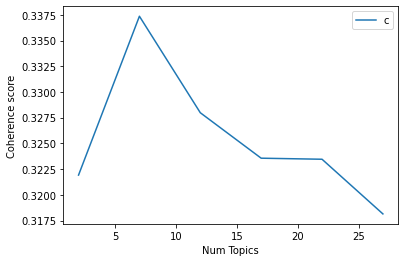

In [68]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_score3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [69]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_score3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 7

index: 0 | Num Topics = 2  has Coherence Value of 0.3219
index: 1 | Num Topics = 7  has Coherence Value of 0.3374
index: 2 | Num Topics = 12  has Coherence Value of 0.328
index: 3 | Num Topics = 17  has Coherence Value of 0.3236
index: 4 | Num Topics = 22  has Coherence Value of 0.3235
index: 5 | Num Topics = 27  has Coherence Value of 0.3181


In [167]:
# Select optimal number of topics
optimal_model_us_score3 = model_list_us_score3[1]

In [168]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_score3 = pyLDAvis.gensim_models.prepare(optimal_model_us_score3, corpus_us_score3, id2word_us_score3)

In [169]:
print("pyLDAVis for us topics for score=3:")
vis_us_score3

pyLDAVis for us topics for score=3:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.155609  0.019703       1        1  58.224646
0      0.165605 -0.006701       2        1  18.399703
4      0.039020  0.018604       3        1   9.211386
1     -0.059767 -0.129300       4        1   5.159808
5     -0.096143 -0.079883       5        1   3.758967
2     -0.104528  0.077864       6        1   2.962654
3     -0.099796  0.099715       7        1   2.282836, topic_info=        Term        Freq        Total Category  logprob  loglift
161  comment  319.000000   319.000000  Default  30.0000  30.0000
248      add  103.000000   103.000000  Default  29.0000  29.0000
4         ad  308.000000   308.000000  Default  28.0000  28.0000
96      play  218.000000   218.000000  Default  27.0000  27.0000
125   change  177.000000   177.000000  Default  26.0000  26.0000
..       ...         ...          ...      ...      ...      ...
222  opinion    1.847898    17.108258   Topic7  -5.7208   1.5542
94     music    2.141470    54.551429   Topic7  -5.5734   0.5421
188    great    2.258352    80.841740   Topic7  -5.5202   0.2019
31     video    2.945321  1323.231702   Topic7  -5.2546  -2.3279
125   change    2.071812   177.233692   Topic7  -5.6064  -0.6693

[501 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
1         1  0.489122  able
1         2  0.252450  able
1         3  0.126225  able
1         4  0.031556  able
1         5  0.094669  able
...     ...       ...   ...
952       3  0.129875    yt
952       4  0.259750    yt
952       5  0.086583    yt
952       6  0.129875    yt
2824      6  0.677539  yttv

[998 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 5, 2, 6, 3, 4])

## LDA Topic Modelling (Rating = 4)

In [73]:
# By-rating Topic Modelling - rating = 4
# Convert to list - move to each section
review_us_score4 = youtube_ios_us_review_YearMonth_score4.review.values.tolist()
review_words_us_score4 = list(sent_to_words(review_us_score4))
print(review_words_us_score4[2:3])

[['the', 'app', 'is', 'amazing', 'and', 'has', 'gotten', 'way', 'better', 'over', 'the', 'years', 'you', 've', 'patched', 'so', 'many', 'things', 'but', 'having', 'an', 'error', 'whenever', 'post', 'comment', 'on', 'video', 'the', 'comment', 'posts', 'twice', 'and', 'trying', 'to', 'figure', 'out', 'why', 'it', 'annoying', 'when', 'just', 'want', 'to', 'be', 'simple', 'and', 'to', 'the', 'point', 'with', 'comment', 'hope', 'this', 'gets', 'patched', 'soon', 'and', 'always', 'make', 'this', 'app', 'the', 'best', 'app', 'please', 'happy', 'new', 'year']]


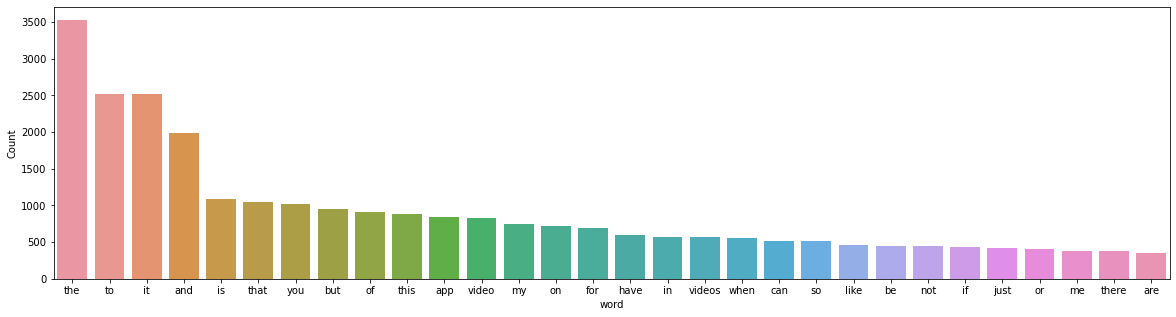

In [74]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_score4))

In [75]:
# Clean text
review_us_ready_score4 = process_words(review_words_us_score4)  # processed Text Data! - move to each section

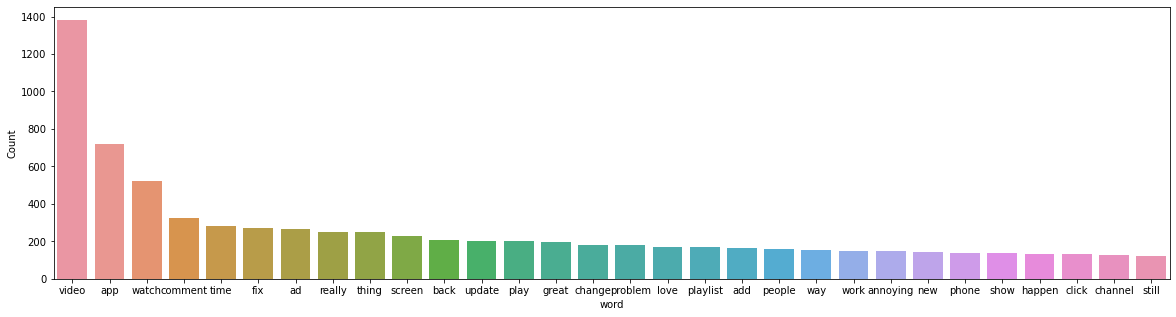

In [76]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready_score4))


In [77]:
# Create Dictionary
id2word_us_score4 = corpora.Dictionary(review_us_ready_score4)

2021-10-17 00:55:55,522 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 00:55:55,677 [INFO] gensim.corpora.dictionary - built Dictionary(2907 unique tokens: ['almost', 'app', 'background', 'battery', 'bitcoin']...) from 800 documents (total 25856 corpus positions)
2021-10-17 00:55:55,679 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(2907 unique tokens: ['almost', 'app', 'background', 'battery', 'bitcoin']...) from 800 documents (total 25856 corpus positions)", 'datetime': '2021-10-17T00:55:55.679065', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [78]:
# Create Corpus: Term Document Frequency
corpus_us_score4 = [id2word_us_score4.doc2bow(text) for text in review_us_ready_score4]

In [79]:
# Training LDA model
model_list_us_score4, coherence_values_us_score4 = compute_coherence_values(dictionary=id2word_us_score4, corpus=corpus_us_score4, 
                                                              texts=review_us_ready_score4, limit=30, start=2, step=5)


2021-10-17 00:55:55,753 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 00:55:55,754 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 00:55:55,758 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:55:55,762 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 800 documents, updating model once every 800 documents, evaluating perplexity every 800 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 00:55:58,416 [INFO] gensim.models.ldamodel - -8.463 per-word bound, 352.8 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 00:55:58,417 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #800/800
2021-10-17 00:56:00,795 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.056*"video" + 0.023*"app" + 0.020*"watch" + 0.014*"ad" + 0.009*"thing" + 0.008*"really" + 0.008*"comm

2021-10-17 00:56:38,563 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.044*"video" + 0.032*"app" + 0.018*"comment" + 0.017*"watch" + 0.013*"fix" + 0.012*"time" + 0.011*"update" + 0.010*"really" + 0.010*"screen" + 0.009*"back"
2021-10-17 00:56:38,565 [INFO] gensim.models.ldamodel - topic diff=0.024294, rho=0.301511
2021-10-17 00:56:40,539 [INFO] gensim.models.ldamodel - -6.638 per-word bound, 99.6 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 00:56:40,541 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #800/800
2021-10-17 00:56:42,273 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.054*"video" + 0.021*"ad" + 0.020*"watch" + 0.015*"app" + 0.010*"thing" + 0.009*"add" + 0.007*"play" + 0.007*"great" + 0.007*"really" + 0.007*"feature"
2021-10-17 00:56:42,275 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.044*"video" + 0.032*"app" + 0.018*"comment" + 0.017*"watch" + 0.013*"fix" + 0.012*"time" + 0.011*"update" + 0.010*"

2021-10-17 00:57:12,664 [INFO] gensim.models.ldamodel - topic diff=0.014942, rho=0.218218
2021-10-17 00:57:14,453 [INFO] gensim.models.ldamodel - -6.626 per-word bound, 98.8 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 00:57:14,455 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #800/800
2021-10-17 00:57:15,856 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.049*"video" + 0.024*"ad" + 0.019*"watch" + 0.012*"app" + 0.011*"thing" + 0.010*"add" + 0.007*"feature" + 0.007*"great" + 0.007*"play" + 0.007*"playlist"
2021-10-17 00:57:15,858 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.047*"video" + 0.033*"app" + 0.018*"watch" + 0.018*"comment" + 0.014*"fix" + 0.012*"time" + 0.011*"screen" + 0.011*"update" + 0.010*"really" + 0.009*"back"
2021-10-17 00:57:15,861 [INFO] gensim.models.ldamodel - topic diff=0.014671, rho=0.213201
2021-10-17 00:57:17,610 [INFO] gensim.models.ldamodel - -6.625 per-word bound, 98.7 perplexity esti

2021-10-17 00:57:46,031 [INFO] gensim.models.ldamodel - -6.616 per-word bound, 98.1 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 00:57:46,036 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #800/800
2021-10-17 00:57:47,292 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.043*"video" + 0.026*"ad" + 0.018*"watch" + 0.011*"thing" + 0.010*"add" + 0.010*"app" + 0.007*"feature" + 0.007*"great" + 0.007*"people" + 0.006*"content"
2021-10-17 00:57:47,297 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.051*"video" + 0.033*"app" + 0.018*"watch" + 0.017*"comment" + 0.014*"fix" + 0.012*"time" + 0.011*"screen" + 0.011*"update" + 0.010*"really" + 0.009*"back"
2021-10-17 00:57:47,299 [INFO] gensim.models.ldamodel - topic diff=0.012974, rho=0.176777
2021-10-17 00:57:49,011 [INFO] gensim.models.ldamodel - -6.615 per-word bound, 98.0 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 00:57:49,013

2021-10-17 00:58:14,748 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #800/800
2021-10-17 00:58:15,833 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.037*"video" + 0.028*"ad" + 0.017*"watch" + 0.011*"thing" + 0.010*"add" + 0.009*"app" + 0.008*"people" + 0.007*"feature" + 0.007*"great" + 0.006*"kid"
2021-10-17 00:58:15,838 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.053*"video" + 0.033*"app" + 0.019*"watch" + 0.017*"comment" + 0.013*"fix" + 0.012*"time" + 0.011*"screen" + 0.010*"really" + 0.010*"update" + 0.010*"back"
2021-10-17 00:58:15,844 [INFO] gensim.models.ldamodel - topic diff=0.011382, rho=0.154303
2021-10-17 00:58:17,410 [INFO] gensim.models.ldamodel - -6.606 per-word bound, 97.4 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 00:58:17,412 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #800/800
2021-10-17 00:58:18,621 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.036*"video" + 0.028*

2021-10-17 00:58:39,755 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-17 00:58:44,186 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-17 00:58:44,218 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 798 virtual documents
2021-10-17 00:58:44,500 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-17 00:58:44,501 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-17 00:58:44,504 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:58:44,508 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 800 documents, updating model once every 800 documents, evaluating perplexity every 800 documents, iterating 50x with a con

2021-10-17 00:59:01,818 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.023*"video" + 0.022*"comment" + 0.016*"change" + 0.015*"app" + 0.013*"post" + 0.012*"give" + 0.012*"great" + 0.012*"channel" + 0.011*"thing" + 0.010*"watch"
2021-10-17 00:59:01,819 [INFO] gensim.models.ldamodel - topic diff=0.113355, rho=0.408248
2021-10-17 00:59:03,514 [INFO] gensim.models.ldamodel - -6.812 per-word bound, 112.3 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 00:59:03,515 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #800/800
2021-10-17 00:59:04,876 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.023*"video" + 0.022*"comment" + 0.016*"change" + 0.015*"app" + 0.013*"post" + 0.013*"give" + 0.012*"great" + 0.012*"channel" + 0.011*"thing" + 0.010*"watch"
2021-10-17 00:59:04,877 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.045*"video" + 0.029*"ad" + 0.019*"app" + 0.015*"watch" + 0.010*"back" + 0.009*"play" + 0.008*"thing" + 0.00

2021-10-17 00:59:19,568 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.067*"video" + 0.030*"app" + 0.019*"watch" + 0.016*"really" + 0.013*"screen" + 0.013*"playlist" + 0.012*"show" + 0.011*"add" + 0.010*"problem" + 0.009*"thing"
2021-10-17 00:59:19,569 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.030*"video" + 0.023*"app" + 0.012*"watch" + 0.011*"time" + 0.011*"back" + 0.009*"fix" + 0.008*"button" + 0.008*"people" + 0.008*"screen" + 0.007*"phone"
2021-10-17 00:59:19,572 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.043*"comment" + 0.032*"playlist" + 0.019*"song" + 0.018*"change" + 0.017*"shuffle" + 0.014*"new" + 0.013*"section" + 0.011*"video" + 0.011*"update" + 0.009*"save"
2021-10-17 00:59:19,574 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.065*"video" + 0.034*"app" + 0.030*"watch" + 0.019*"comment" + 0.016*"fix" + 0.015*"time" + 0.012*"play" + 0.011*"thing" + 0.010*"update" + 0.009*"back"
2021-10-17 00:59:19,576 [INFO] gensim.models.ldamodel - topic diff=0.0

2021-10-17 00:59:33,425 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.044*"comment" + 0.035*"playlist" + 0.021*"song" + 0.019*"change" + 0.017*"shuffle" + 0.015*"new" + 0.014*"section" + 0.011*"video" + 0.011*"update" + 0.010*"scroll"
2021-10-17 00:59:33,427 [INFO] gensim.models.ldamodel - topic diff=0.017417, rho=0.242536
2021-10-17 00:59:34,938 [INFO] gensim.models.ldamodel - -6.775 per-word bound, 109.5 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 00:59:34,939 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #800/800
2021-10-17 00:59:36,090 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.045*"ad" + 0.038*"video" + 0.015*"app" + 0.013*"watch" + 0.010*"play" + 0.008*"thing" + 0.008*"skip" + 0.006*"back" + 0.006*"screen" + 0.006*"show"
2021-10-17 00:59:36,091 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.021*"comment" + 0.018*"change" + 0.018*"video" + 0.016*"post" + 0.015*"give" + 0.014*"channel" + 0.013*"app

2021-10-17 00:59:50,282 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.025*"video" + 0.021*"app" + 0.011*"time" + 0.010*"watch" + 0.010*"back" + 0.008*"button" + 0.008*"people" + 0.008*"phone" + 0.007*"fix" + 0.006*"screen"
2021-10-17 00:59:50,286 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.067*"video" + 0.035*"app" + 0.030*"watch" + 0.019*"comment" + 0.016*"fix" + 0.015*"time" + 0.012*"play" + 0.011*"thing" + 0.010*"update" + 0.009*"back"
2021-10-17 00:59:50,288 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.017*"ad" + 0.016*"app" + 0.013*"add" + 0.012*"time" + 0.012*"update" + 0.010*"search" + 0.009*"screen" + 0.009*"video" + 0.009*"feature" + 0.008*"really"
2021-10-17 00:59:50,290 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.045*"comment" + 0.036*"playlist" + 0.023*"song" + 0.019*"change" + 0.017*"shuffle" + 0.015*"new" + 0.014*"section" + 0.011*"video" + 0.011*"update" + 0.010*"list"
2021-10-17 00:59:50,291 [INFO] gensim.models.ldamodel - topic diff=0.01134

2021-10-17 01:00:04,551 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.067*"video" + 0.029*"app" + 0.019*"watch" + 0.016*"really" + 0.014*"screen" + 0.013*"playlist" + 0.012*"show" + 0.012*"add" + 0.010*"problem" + 0.009*"fix"
2021-10-17 01:00:04,552 [INFO] gensim.models.ldamodel - topic diff=0.009062, rho=0.188982
2021-10-17 01:00:06,186 [INFO] gensim.models.ldamodel - -6.763 per-word bound, 108.6 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 01:00:06,187 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #800/800
2021-10-17 01:00:07,351 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.045*"comment" + 0.037*"playlist" + 0.023*"song" + 0.019*"change" + 0.017*"shuffle" + 0.016*"new" + 0.015*"section" + 0.011*"video" + 0.011*"update" + 0.011*"list"
2021-10-17 01:00:07,355 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.020*"comment" + 0.019*"change" + 0.017*"post" + 0.016*"video" + 0.015*"give" + 0.015*"channel" + 0.01

2021-10-17 01:00:21,122 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.067*"video" + 0.036*"app" + 0.030*"watch" + 0.019*"comment" + 0.017*"fix" + 0.015*"time" + 0.012*"play" + 0.011*"thing" + 0.010*"update" + 0.010*"back"
2021-10-17 01:00:21,124 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.020*"video" + 0.018*"app" + 0.011*"time" + 0.010*"back" + 0.009*"watch" + 0.009*"button" + 0.008*"people" + 0.007*"phone" + 0.007*"view" + 0.006*"tv"
2021-10-17 01:00:21,125 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.017*"ad" + 0.015*"app" + 0.014*"add" + 0.012*"time" + 0.012*"update" + 0.010*"search" + 0.009*"video" + 0.009*"feature" + 0.008*"skippable" + 0.007*"really"
2021-10-17 01:00:21,127 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.020*"comment" + 0.019*"change" + 0.017*"post" + 0.016*"give" + 0.015*"channel" + 0.015*"video" + 0.013*"app" + 0.013*"people" + 0.013*"thing" + 0.012*"great"
2021-10-17 01:00:21,128 [INFO] gensim.models.ldamodel - topic diff=0.007145, rh

2021-10-17 01:00:34,978 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.068*"video" + 0.029*"app" + 0.019*"watch" + 0.016*"really" + 0.014*"screen" + 0.013*"playlist" + 0.013*"add" + 0.013*"show" + 0.010*"problem" + 0.009*"time"
2021-10-17 01:00:34,980 [INFO] gensim.models.ldamodel - topic diff=0.006033, rho=0.160128
2021-10-17 01:00:36,554 [INFO] gensim.models.ldamodel - -6.757 per-word bound, 108.1 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 01:00:36,556 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #800/800
2021-10-17 01:00:37,750 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.066*"ad" + 0.031*"video" + 0.013*"app" + 0.013*"watch" + 0.010*"skip" + 0.010*"play" + 0.010*"commercial" + 0.008*"thing" + 0.007*"minute" + 0.006*"great"
2021-10-17 01:00:37,751 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.017*"ad" + 0.015*"app" + 0.014*"add" + 0.012*"time" + 0.011*"update" + 0.009*"search" + 0.009*"video" + 0.00

2021-10-17 01:00:51,066 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.068*"video" + 0.029*"app" + 0.019*"watch" + 0.016*"really" + 0.014*"screen" + 0.013*"playlist" + 0.013*"add" + 0.013*"show" + 0.010*"problem" + 0.009*"time"
2021-10-17 01:00:51,068 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.069*"ad" + 0.030*"video" + 0.013*"app" + 0.012*"watch" + 0.011*"skip" + 0.010*"commercial" + 0.010*"play" + 0.008*"thing" + 0.007*"minute" + 0.006*"great"
2021-10-17 01:00:51,070 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.016*"ad" + 0.015*"app" + 0.014*"add" + 0.012*"time" + 0.011*"update" + 0.009*"search" + 0.009*"feature" + 0.009*"video" + 0.008*"skippable" + 0.007*"really"
2021-10-17 01:00:51,072 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.046*"comment" + 0.038*"playlist" + 0.024*"song" + 0.019*"change" + 0.017*"shuffle" + 0.017*"new" + 0.015*"section" + 0.011*"video" + 0.011*"list" + 0.011*"scroll"
2021-10-17 01:00:51,073 [INFO] gensim.models.ldamodel - topic di

2021-10-17 01:01:07,266 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.068*"video" + 0.037*"app" + 0.030*"watch" + 0.018*"comment" + 0.017*"fix" + 0.015*"time" + 0.012*"play" + 0.011*"thing" + 0.010*"update" + 0.010*"back"
2021-10-17 01:01:07,269 [INFO] gensim.models.ldamodel - topic diff=0.004452, rho=0.141421
2021-10-17 01:01:08,886 [INFO] gensim.models.ldamodel - -6.752 per-word bound, 107.8 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 01:01:08,887 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #800/800
2021-10-17 01:01:10,008 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.072*"ad" + 0.029*"video" + 0.013*"app" + 0.012*"watch" + 0.011*"skip" + 0.010*"commercial" + 0.010*"play" + 0.008*"thing" + 0.007*"minute" + 0.006*"great"
2021-10-17 01:01:10,009 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.015*"ad" + 0.015*"app" + 0.014*"add" + 0.012*"update" + 0.011*"time" + 0.009*"feature" + 0.008*"search" + 0.008*"

2021-10-17 01:01:29,527 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.074*"video" + 0.036*"app" + 0.022*"watch" + 0.018*"ad" + 0.012*"really" + 0.011*"thing" + 0.010*"problem" + 0.010*"time" + 0.009*"show" + 0.009*"screen"
2021-10-17 01:01:29,536 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.035*"app" + 0.015*"video" + 0.010*"music" + 0.009*"screen" + 0.009*"back" + 0.009*"time" + 0.008*"fix" + 0.008*"great" + 0.008*"work" + 0.007*"view"
2021-10-17 01:01:29,540 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.026*"comment" + 0.021*"video" + 0.019*"app" + 0.017*"change" + 0.013*"great" + 0.013*"watch" + 0.012*"thing" + 0.012*"people" + 0.012*"channel" + 0.011*"work"
2021-10-17 01:01:29,545 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.055*"video" + 0.023*"app" + 0.021*"ad" + 0.018*"watch" + 0.011*"back" + 0.011*"phone" + 0.010*"problem" + 0.009*"thing" + 0.008*"love" + 0.008*"play"
2021-10-17 01:01:29,547 [INFO] gensim.models.ldamodel - topic diff=0.219066, rho=0.4

2021-10-17 01:01:43,516 [INFO] gensim.models.ldamodel - topic diff=0.067286, rho=0.316228
2021-10-17 01:01:45,061 [INFO] gensim.models.ldamodel - -6.883 per-word bound, 118.1 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 01:01:45,062 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #800/800
2021-10-17 01:01:46,192 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.026*"comment" + 0.020*"app" + 0.019*"change" + 0.017*"video" + 0.016*"channel" + 0.015*"people" + 0.014*"post" + 0.013*"thing" + 0.013*"great" + 0.011*"watch"
2021-10-17 01:01:46,194 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.047*"add" + 0.018*"feature" + 0.015*"video" + 0.014*"watch" + 0.013*"queue" + 0.008*"music" + 0.007*"back" + 0.007*"move" + 0.007*"show" + 0.007*"people"
2021-10-17 01:01:46,196 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.031*"app" + 0.025*"video" + 0.012*"phone" + 0.011*"fix" + 0.011*"time" + 0.010*"screen" + 0.010*"button" + 0

2021-10-17 01:01:59,441 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.040*"video" + 0.028*"playlist" + 0.020*"app" + 0.017*"add" + 0.016*"watch" + 0.014*"time" + 0.014*"thing" + 0.011*"update" + 0.010*"new" + 0.010*"really"
2021-10-17 01:01:59,447 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.080*"video" + 0.035*"app" + 0.033*"watch" + 0.023*"comment" + 0.016*"fix" + 0.016*"play" + 0.015*"time" + 0.011*"update" + 0.010*"screen" + 0.009*"thing"
2021-10-17 01:01:59,452 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.072*"video" + 0.037*"app" + 0.023*"ad" + 0.023*"watch" + 0.013*"really" + 0.012*"problem" + 0.011*"time" + 0.010*"thing" + 0.010*"show" + 0.009*"fix"
2021-10-17 01:01:59,459 [INFO] gensim.models.ldamodel - topic diff=0.026544, rho=0.250000
2021-10-17 01:02:01,010 [INFO] gensim.models.ldamodel - -6.861 per-word bound, 116.3 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 01:02:01,012 [INFO] gensim.models.ldamodel - PR

2021-10-17 01:02:14,381 [INFO] gensim.models.ldamodel - -6.850 per-word bound, 115.4 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 01:02:14,382 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #800/800
2021-10-17 01:02:15,515 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.027*"comment" + 0.020*"change" + 0.020*"app" + 0.019*"channel" + 0.018*"people" + 0.016*"post" + 0.015*"video" + 0.014*"thing" + 0.013*"great" + 0.012*"give"
2021-10-17 01:02:15,516 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.017*"upload" + 0.015*"ad" + 0.015*"app" + 0.011*"great" + 0.010*"time" + 0.010*"screen" + 0.009*"really" + 0.009*"skippable" + 0.008*"phone" + 0.008*"fix"
2021-10-17 01:02:15,517 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.082*"video" + 0.036*"app" + 0.033*"watch" + 0.022*"comment" + 0.016*"fix" + 0.016*"play" + 0.015*"time" + 0.011*"update" + 0.011*"screen" + 0.009*"happen"
2021-10-17 01:02:15,519 [INFO] gensim.mode

2021-10-17 01:02:28,343 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.071*"video" + 0.037*"app" + 0.025*"ad" + 0.023*"watch" + 0.013*"really" + 0.012*"problem" + 0.011*"time" + 0.010*"thing" + 0.010*"show" + 0.010*"fix"
2021-10-17 01:02:28,348 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.048*"video" + 0.035*"ad" + 0.016*"watch" + 0.012*"app" + 0.011*"back" + 0.009*"thing" + 0.008*"problem" + 0.008*"show" + 0.008*"love" + 0.007*"least"
2021-10-17 01:02:28,353 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.017*"upload" + 0.015*"ad" + 0.013*"app" + 0.011*"great" + 0.011*"time" + 0.010*"skippable" + 0.009*"screen" + 0.008*"phone" + 0.008*"really" + 0.007*"however"
2021-10-17 01:02:28,359 [INFO] gensim.models.ldamodel - topic diff=0.011453, rho=0.192450
2021-10-17 01:02:29,910 [INFO] gensim.models.ldamodel - -6.840 per-word bound, 114.6 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 01:02:29,911 [INFO] gensim.models.ldamodel - P

2021-10-17 01:02:41,151 [INFO] gensim.models.ldamodel - topic diff=0.008996, rho=0.176777
2021-10-17 01:02:42,651 [INFO] gensim.models.ldamodel - -6.834 per-word bound, 114.1 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 01:02:42,654 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #800/800
2021-10-17 01:02:43,763 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.015*"video" + 0.014*"update" + 0.013*"kid" + 0.011*"ad" + 0.010*"new" + 0.010*"stop" + 0.010*"watch" + 0.010*"page" + 0.009*"hate" + 0.009*"back"
2021-10-17 01:02:43,765 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.040*"video" + 0.030*"playlist" + 0.020*"app" + 0.019*"add" + 0.017*"watch" + 0.014*"thing" + 0.014*"time" + 0.011*"update" + 0.010*"new" + 0.010*"button"
2021-10-17 01:02:43,767 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.083*"video" + 0.037*"app" + 0.033*"watch" + 0.020*"comment" + 0.017*"fix" + 0.017*"play" + 0.015*"time" + 0.012*"screen"

2021-10-17 01:02:56,745 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.066*"comment" + 0.045*"playlist" + 0.024*"section" + 0.023*"change" + 0.021*"shuffle" + 0.021*"song" + 0.015*"new" + 0.014*"move" + 0.014*"scroll" + 0.014*"update"
2021-10-17 01:02:56,747 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.031*"app" + 0.016*"video" + 0.014*"phone" + 0.011*"button" + 0.011*"time" + 0.010*"fix" + 0.010*"search" + 0.009*"give" + 0.009*"star" + 0.009*"delete"
2021-10-17 01:02:56,749 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.018*"upload" + 0.015*"ad" + 0.011*"time" + 0.011*"app" + 0.011*"great" + 0.010*"skippable" + 0.008*"phone" + 0.007*"however" + 0.007*"full" + 0.007*"well"
2021-10-17 01:02:56,751 [INFO] gensim.models.ldamodel - topic diff=0.007365, rho=0.162221
2021-10-17 01:02:58,354 [INFO] gensim.models.ldamodel - -6.829 per-word bound, 113.7 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 01:02:58,356 [INFO] gensim.models.

2021-10-17 01:03:09,891 [INFO] gensim.models.ldamodel - topic diff=0.006385, rho=0.152499
2021-10-17 01:03:11,494 [INFO] gensim.models.ldamodel - -6.825 per-word bound, 113.4 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 01:03:11,495 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #800/800
2021-10-17 01:03:12,713 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.022*"app" + 0.014*"tv" + 0.012*"music" + 0.010*"view" + 0.009*"volume" + 0.008*"smart" + 0.008*"video" + 0.006*"tube" + 0.006*"watch" + 0.006*"connect"
2021-10-17 01:03:12,716 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.027*"comment" + 0.021*"channel" + 0.021*"people" + 0.021*"app" + 0.021*"change" + 0.016*"post" + 0.014*"thing" + 0.013*"video" + 0.013*"great" + 0.012*"really"
2021-10-17 01:03:12,721 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.018*"upload" + 0.015*"ad" + 0.011*"time" + 0.011*"great" + 0.010*"skippable" + 0.010*"app" + 0.008*"phone" 

2021-10-17 01:03:25,663 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.019*"upload" + 0.014*"ad" + 0.011*"time" + 0.011*"great" + 0.010*"skippable" + 0.009*"app" + 0.008*"phone" + 0.008*"however" + 0.007*"well" + 0.007*"always"
2021-10-17 01:03:25,665 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.014*"video" + 0.014*"update" + 0.013*"kid" + 0.011*"new" + 0.010*"ad" + 0.010*"stop" + 0.010*"hate" + 0.009*"page" + 0.009*"subscription" + 0.009*"watch"
2021-10-17 01:03:25,667 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.027*"comment" + 0.022*"channel" + 0.021*"people" + 0.021*"app" + 0.021*"change" + 0.016*"post" + 0.014*"thing" + 0.013*"video" + 0.013*"great" + 0.012*"give"
2021-10-17 01:03:25,669 [INFO] gensim.models.ldamodel - topic diff=0.005468, rho=0.142857
2021-10-17 01:03:27,138 [INFO] gensim.models.ldamodel - -6.822 per-word bound, 113.1 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 01:03:27,139 [INFO] gensim.models.ld

2021-10-17 01:03:46,412 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #800/800
2021-10-17 01:03:47,430 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.042*"video" + 0.035*"app" + 0.018*"comment" + 0.014*"watch" + 0.012*"back" + 0.011*"love" + 0.010*"fix" + 0.010*"star" + 0.009*"give" + 0.009*"still"
2021-10-17 01:03:47,435 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.054*"video" + 0.026*"app" + 0.020*"ad" + 0.017*"watch" + 0.013*"play" + 0.009*"back" + 0.009*"problem" + 0.008*"show" + 0.007*"phone" + 0.007*"great"
2021-10-17 01:03:47,439 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.061*"video" + 0.036*"app" + 0.023*"watch" + 0.016*"really" + 0.014*"time" + 0.014*"playlist" + 0.013*"ad" + 0.011*"add" + 0.011*"screen" + 0.010*"thing"
2021-10-17 01:03:47,443 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.027*"comment" + 0.021*"video" + 0.014*"problem" + 0.013*"channel" + 0.013*"app" + 0.012*"thing" + 0.012*"great" + 0.012*"post" + 0.011*"watch" + 0.

2021-10-17 01:04:00,165 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.039*"app" + 0.037*"video" + 0.020*"comment" + 0.012*"watch" + 0.011*"love" + 0.011*"fix" + 0.011*"star" + 0.010*"give" + 0.010*"people" + 0.010*"back"
2021-10-17 01:04:00,169 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.076*"video" + 0.029*"app" + 0.021*"watch" + 0.021*"ad" + 0.014*"problem" + 0.013*"thing" + 0.011*"really" + 0.010*"play" + 0.010*"time" + 0.009*"show"
2021-10-17 01:04:00,171 [INFO] gensim.models.ldamodel - topic diff=0.094556, rho=0.333333
2021-10-17 01:04:01,631 [INFO] gensim.models.ldamodel - -6.970 per-word bound, 125.4 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 01:04:01,632 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #800/800
2021-10-17 01:04:02,605 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.076*"video" + 0.029*"app" + 0.021*"ad" + 0.021*"watch" + 0.014*"problem" + 0.013*"thing" + 0.012*"really" + 0.010*"play

2021-10-17 01:04:14,387 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #800/800
2021-10-17 01:04:15,504 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.024*"app" + 0.020*"notification" + 0.016*"subscription" + 0.016*"video" + 0.015*"option" + 0.013*"turn" + 0.012*"screen" + 0.010*"appear" + 0.009*"tab" + 0.009*"much"
2021-10-17 01:04:15,505 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.043*"app" + 0.031*"video" + 0.021*"comment" + 0.012*"fix" + 0.012*"love" + 0.011*"star" + 0.011*"give" + 0.010*"people" + 0.010*"still" + 0.009*"bug"
2021-10-17 01:04:15,507 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.061*"comment" + 0.034*"change" + 0.028*"video" + 0.022*"section" + 0.021*"ad" + 0.014*"back" + 0.013*"scroll" + 0.011*"update" + 0.011*"app" + 0.010*"button"
2021-10-17 01:04:15,508 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.063*"video" + 0.036*"app" + 0.024*"watch" + 0.017*"really" + 0.014*"time" + 0.014*"playlist" + 0.013*"add" + 0.013*"ad" + 

2021-10-17 01:04:27,931 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.043*"video" + 0.042*"app" + 0.025*"screen" + 0.024*"playlist" + 0.020*"fix" + 0.015*"shuffle" + 0.013*"close" + 0.013*"song" + 0.013*"play" + 0.012*"update"
2021-10-17 01:04:27,933 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.087*"video" + 0.043*"watch" + 0.033*"app" + 0.020*"fix" + 0.018*"time" + 0.018*"play" + 0.011*"thing" + 0.011*"update" + 0.010*"love" + 0.009*"happen"
2021-10-17 01:04:27,935 [INFO] gensim.models.ldamodel - topic diff=0.019049, rho=0.223607
2021-10-17 01:04:29,566 [INFO] gensim.models.ldamodel - -6.924 per-word bound, 121.5 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 01:04:29,568 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #800/800
2021-10-17 01:04:30,635 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.070*"comment" + 0.036*"change" + 0.026*"video" + 0.022*"section" + 0.020*"ad" + 0.014*"back" + 0.014*"scroll" 

2021-10-17 01:04:42,178 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #800/800
2021-10-17 01:04:43,230 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.063*"video" + 0.036*"app" + 0.025*"watch" + 0.016*"really" + 0.014*"time" + 0.013*"screen" + 0.013*"add" + 0.013*"playlist" + 0.012*"ad" + 0.011*"back"
2021-10-17 01:04:43,233 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.075*"video" + 0.028*"app" + 0.025*"ad" + 0.020*"watch" + 0.015*"problem" + 0.012*"thing" + 0.012*"really" + 0.011*"upload" + 0.010*"time" + 0.010*"show"
2021-10-17 01:04:43,234 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.050*"add" + 0.018*"feature" + 0.016*"queue" + 0.016*"video" + 0.015*"watch" + 0.008*"thing" + 0.008*"tube" + 0.007*"view" + 0.007*"pattern" + 0.007*"really"
2021-10-17 01:04:43,238 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.043*"video" + 0.022*"app" + 0.015*"watch" + 0.015*"ad" + 0.010*"music" + 0.010*"play" + 0.009*"great" + 0.009*"show" + 0.008*"background"

2021-10-17 01:04:56,142 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.063*"video" + 0.036*"app" + 0.025*"watch" + 0.016*"really" + 0.014*"time" + 0.014*"screen" + 0.013*"add" + 0.013*"playlist" + 0.011*"ad" + 0.011*"back"
2021-10-17 01:04:56,144 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.027*"video" + 0.023*"app" + 0.016*"watch" + 0.013*"time" + 0.012*"thing" + 0.012*"back" + 0.011*"new" + 0.010*"search" + 0.010*"people" + 0.009*"much"
2021-10-17 01:04:56,147 [INFO] gensim.models.ldamodel - topic diff=0.010497, rho=0.179605
2021-10-17 01:04:58,102 [INFO] gensim.models.ldamodel - -6.905 per-word bound, 119.9 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 01:04:58,104 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #800/800
2021-10-17 01:04:59,193 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.091*"video" + 0.044*"watch" + 0.034*"app" + 0.020*"fix" + 0.019*"play" + 0.019*"time" + 0.011*"update" + 0.011*"thin

2021-10-17 01:05:12,385 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #800/800
2021-10-17 01:05:13,625 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.026*"video" + 0.023*"app" + 0.016*"watch" + 0.013*"time" + 0.012*"thing" + 0.012*"back" + 0.011*"new" + 0.010*"search" + 0.010*"much" + 0.010*"love"
2021-10-17 01:05:13,627 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.047*"app" + 0.017*"video" + 0.016*"comment" + 0.013*"fix" + 0.013*"open" + 0.012*"star" + 0.012*"give" + 0.011*"people" + 0.010*"love" + 0.010*"bug"
2021-10-17 01:05:13,629 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.041*"video" + 0.020*"app" + 0.015*"watch" + 0.013*"ad" + 0.010*"music" + 0.010*"great" + 0.009*"show" + 0.008*"background" + 0.008*"thing" + 0.008*"hear"
2021-10-17 01:05:13,631 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.075*"video" + 0.028*"ad" + 0.028*"app" + 0.021*"watch" + 0.015*"problem" + 0.013*"thing" + 0.012*"really" + 0.011*"upload" + 0.010*"show" + 0.010*"t

2021-10-17 01:05:26,270 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.086*"comment" + 0.037*"change" + 0.023*"section" + 0.021*"video" + 0.019*"ad" + 0.018*"scroll" + 0.015*"back" + 0.013*"update" + 0.012*"app" + 0.012*"move"
2021-10-17 01:05:26,272 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.047*"app" + 0.016*"video" + 0.016*"comment" + 0.013*"open" + 0.013*"fix" + 0.012*"give" + 0.012*"star" + 0.011*"people" + 0.010*"bug" + 0.010*"love"
2021-10-17 01:05:26,273 [INFO] gensim.models.ldamodel - topic diff=0.006511, rho=0.154303
2021-10-17 01:05:27,791 [INFO] gensim.models.ldamodel - -6.894 per-word bound, 119.0 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 01:05:27,793 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #800/800
2021-10-17 01:05:28,776 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.034*"ad" + 0.017*"skippable" + 0.014*"non" + 0.014*"really" + 0.013*"maybe" + 0.013*"video" + 0.010*"tube" + 0.010

2021-10-17 01:05:40,134 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #800/800
2021-10-17 01:05:41,163 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.038*"video" + 0.030*"comment" + 0.027*"playlist" + 0.026*"new" + 0.017*"watch" + 0.015*"update" + 0.015*"add" + 0.014*"old" + 0.013*"time" + 0.012*"top"
2021-10-17 01:05:41,170 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.034*"ad" + 0.017*"skippable" + 0.014*"non" + 0.013*"really" + 0.013*"maybe" + 0.013*"video" + 0.011*"second" + 0.011*"tube" + 0.010*"guy" + 0.009*"amazing"
2021-10-17 01:05:41,174 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.048*"app" + 0.016*"comment" + 0.015*"video" + 0.014*"open" + 0.013*"fix" + 0.013*"give" + 0.012*"star" + 0.011*"people" + 0.010*"bug" + 0.009*"love"
2021-10-17 01:05:41,177 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.023*"commercial" + 0.020*"video" + 0.016*"app" + 0.013*"people" + 0.013*"hate" + 0.013*"update" + 0.011*"watch" + 0.011*"tv" + 0.011*"remove"

2021-10-17 01:06:00,351 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.027*"video" + 0.019*"change" + 0.016*"app" + 0.012*"notification" + 0.011*"channel" + 0.011*"people" + 0.010*"quality" + 0.009*"update" + 0.009*"comment" + 0.008*"click"
2021-10-17 01:06:00,353 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.056*"video" + 0.026*"app" + 0.017*"watch" + 0.014*"back" + 0.014*"thing" + 0.012*"phone" + 0.011*"show" + 0.010*"problem" + 0.010*"love" + 0.009*"work"
2021-10-17 01:06:00,360 [INFO] gensim.models.ldamodel - topic diff=16.320271, rho=1.000000
2021-10-17 01:06:02,013 [INFO] gensim.models.ldamodel - -7.382 per-word bound, 166.8 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 01:06:02,014 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #800/800
2021-10-17 01:06:03,139 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.054*"video" + 0.026*"app" + 0.018*"watch" + 0.014*"thing" + 0.014*"back" + 0.012*"phone" + 0.011*

2021-10-17 01:06:14,496 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #800/800
2021-10-17 01:06:15,562 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.051*"video" + 0.034*"watch" + 0.028*"app" + 0.022*"play" + 0.012*"keep" + 0.012*"add" + 0.012*"back" + 0.011*"playlist" + 0.011*"way" + 0.010*"time"
2021-10-17 01:06:15,564 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.045*"video" + 0.030*"screen" + 0.023*"app" + 0.020*"watch" + 0.017*"pause" + 0.015*"second" + 0.012*"ad" + 0.012*"pop" + 0.012*"back" + 0.010*"phone"
2021-10-17 01:06:15,566 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.052*"video" + 0.029*"ad" + 0.023*"app" + 0.014*"watch" + 0.013*"comment" + 0.011*"able" + 0.010*"play" + 0.010*"time" + 0.009*"back" + 0.008*"view"
2021-10-17 01:06:15,567 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.049*"video" + 0.020*"bug" + 0.019*"app" + 0.015*"show" + 0.014*"ad" + 0.013*"happen" + 0.012*"add" + 0.012*"fix" + 0.010*"back" + 0.010*"great"
2021-1

2021-10-17 01:06:28,011 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.027*"app" + 0.013*"tv" + 0.013*"channel" + 0.012*"volume" + 0.012*"artist" + 0.012*"music" + 0.010*"really" + 0.010*"back" + 0.009*"fix" + 0.009*"problem"
2021-10-17 01:06:28,013 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.053*"video" + 0.033*"app" + 0.018*"watch" + 0.017*"back" + 0.013*"really" + 0.012*"time" + 0.011*"problem" + 0.011*"love" + 0.011*"phone" + 0.010*"fix"
2021-10-17 01:06:28,015 [INFO] gensim.models.ldamodel - topic diff=0.049073, rho=0.277350
2021-10-17 01:06:29,341 [INFO] gensim.models.ldamodel - -7.030 per-word bound, 130.7 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 01:06:29,342 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #800/800
2021-10-17 01:06:30,347 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.051*"video" + 0.023*"screen" + 0.015*"watch" + 0.014*"volume" + 0.013*"update" + 0.013*"app" + 0.012*"full" + 0

2021-10-17 01:06:41,628 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #800/800
2021-10-17 01:06:42,770 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.051*"video" + 0.031*"ad" + 0.022*"app" + 0.012*"watch" + 0.012*"comment" + 0.012*"able" + 0.010*"play" + 0.010*"back" + 0.009*"view" + 0.009*"much"
2021-10-17 01:06:42,772 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.027*"app" + 0.022*"people" + 0.019*"video" + 0.015*"watch" + 0.013*"thing" + 0.013*"channel" + 0.008*"tube" + 0.008*"stuff" + 0.008*"really" + 0.008*"tell"
2021-10-17 01:06:42,774 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.028*"app" + 0.014*"tv" + 0.013*"volume" + 0.013*"channel" + 0.013*"artist" + 0.012*"music" + 0.010*"really" + 0.010*"fix" + 0.009*"back" + 0.009*"problem"
2021-10-17 01:06:42,777 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.029*"change" + 0.021*"video" + 0.020*"channel" + 0.015*"people" + 0.012*"notification" + 0.012*"app" + 0.010*"quality" + 0.010*"content" +

2021-10-17 01:06:56,410 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.056*"video" + 0.025*"change" + 0.023*"comment" + 0.022*"watch" + 0.015*"ad" + 0.013*"picture" + 0.013*"time" + 0.013*"new" + 0.013*"update" + 0.013*"move"
2021-10-17 01:06:56,412 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.064*"comment" + 0.021*"video" + 0.019*"section" + 0.016*"update" + 0.016*"playlist" + 0.016*"new" + 0.013*"song" + 0.013*"great" + 0.012*"time" + 0.011*"ad"
2021-10-17 01:06:56,413 [INFO] gensim.models.ldamodel - topic diff=0.013173, rho=0.204124
2021-10-17 01:06:58,003 [INFO] gensim.models.ldamodel - -6.999 per-word bound, 128.0 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 01:06:58,005 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #800/800
2021-10-17 01:06:59,038 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.047*"video" + 0.019*"bug" + 0.017*"app" + 0.015*"show" + 0.015*"ad" + 0.014*"add" + 0.012*"back" + 0.011*

2021-10-17 01:07:10,633 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #800/800
2021-10-17 01:07:11,692 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.033*"post" + 0.031*"comment" + 0.027*"community" + 0.018*"thing" + 0.017*"really" + 0.014*"video" + 0.014*"app" + 0.014*"live" + 0.013*"great" + 0.013*"phone"
2021-10-17 01:07:11,697 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.067*"comment" + 0.019*"video" + 0.019*"section" + 0.016*"update" + 0.016*"new" + 0.015*"playlist" + 0.013*"song" + 0.013*"great" + 0.012*"time" + 0.012*"ad"
2021-10-17 01:07:11,709 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.029*"change" + 0.021*"channel" + 0.020*"video" + 0.015*"people" + 0.012*"notification" + 0.011*"app" + 0.011*"quality" + 0.011*"content" + 0.010*"understand" + 0.010*"great"
2021-10-17 01:07:11,716 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.081*"video" + 0.048*"watch" + 0.029*"app" + 0.019*"comment" + 0.016*"fix" + 0.014*"time" + 0.013*"turn" + 0.

2021-10-17 01:07:23,952 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.054*"video" + 0.031*"watch" + 0.028*"app" + 0.026*"play" + 0.013*"add" + 0.013*"back" + 0.013*"keep" + 0.011*"screen" + 0.010*"playlist" + 0.010*"tap"
2021-10-17 01:07:23,954 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.053*"video" + 0.033*"app" + 0.019*"watch" + 0.016*"back" + 0.015*"really" + 0.013*"time" + 0.013*"love" + 0.012*"give" + 0.011*"work" + 0.011*"fix"
2021-10-17 01:07:23,955 [INFO] gensim.models.ldamodel - topic diff=0.007233, rho=0.169031
2021-10-17 01:07:25,414 [INFO] gensim.models.ldamodel - -6.985 per-word bound, 126.7 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 01:07:25,415 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #800/800
2021-10-17 01:07:26,555 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.054*"video" + 0.026*"change" + 0.023*"watch" + 0.022*"comment" + 0.014*"update" + 0.014*"picture" + 0.014*"new" + 0.014

2021-10-17 01:07:37,663 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #800/800
2021-10-17 01:07:38,597 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.064*"video" + 0.052*"app" + 0.025*"ad" + 0.022*"really" + 0.020*"watch" + 0.018*"time" + 0.016*"annoying" + 0.014*"add" + 0.012*"feature" + 0.012*"thing"
2021-10-17 01:07:38,599 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.042*"add" + 0.015*"video" + 0.012*"feature" + 0.012*"really" + 0.010*"give" + 0.010*"thing" + 0.009*"channel" + 0.008*"read" + 0.007*"watch" + 0.007*"wait"
2021-10-17 01:07:38,601 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.047*"video" + 0.044*"app" + 0.029*"fix" + 0.025*"screen" + 0.024*"playlist" + 0.017*"way" + 0.014*"comment" + 0.011*"song" + 0.011*"scroll" + 0.011*"happen"
2021-10-17 01:07:38,603 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.053*"video" + 0.033*"app" + 0.019*"watch" + 0.015*"back" + 0.015*"really" + 0.013*"time" + 0.013*"love" + 0.013*"give" + 0.011*"wor

2021-10-17 01:07:51,128 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.034*"app" + 0.024*"tv" + 0.013*"volume" + 0.012*"artist" + 0.012*"channel" + 0.011*"music" + 0.011*"really" + 0.010*"fix" + 0.010*"connect" + 0.009*"back"
2021-10-17 01:07:51,130 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.047*"video" + 0.044*"app" + 0.029*"fix" + 0.025*"playlist" + 0.025*"screen" + 0.017*"way" + 0.013*"comment" + 0.011*"song" + 0.011*"happen" + 0.011*"scroll"
2021-10-17 01:07:51,131 [INFO] gensim.models.ldamodel - topic diff=0.005087, rho=0.147442
2021-10-17 01:07:52,628 [INFO] gensim.models.ldamodel - -6.975 per-word bound, 125.8 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 01:07:52,629 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #800/800
2021-10-17 01:07:53,656 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.029*"change" + 0.022*"channel" + 0.021*"video" + 0.015*"people" + 0.012*"notification" + 0.011*"app" + 0.

2021-10-17 01:08:03,705 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-17 01:08:08,343 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-17 01:08:08,445 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 800 virtual documents
2021-10-17 01:08:11,639 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.037037037037037035
2021-10-17 01:08:11,644 [INFO] gensim.models.ldamodel - using symmetric eta at 0.037037037037037035
2021-10-17 01:08:11,652 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 01:08:11,690 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 27 topics, 50 passes over the supplied corpus of 800 documents, updating model once every 800 documents, evaluating perplexity every 800 documents, iterating 50x with a 

2021-10-17 01:08:29,685 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.054*"video" + 0.028*"upload" + 0.028*"app" + 0.019*"really" + 0.016*"problem" + 0.016*"fix" + 0.015*"play" + 0.015*"work" + 0.012*"screen" + 0.011*"delete"
2021-10-17 01:08:29,686 [INFO] gensim.models.ldamodel - topic diff=0.245423, rho=0.408248
2021-10-17 01:08:31,350 [INFO] gensim.models.ldamodel - -7.178 per-word bound, 144.8 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 01:08:31,351 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #800/800
2021-10-17 01:08:32,416 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.042*"comment" + 0.040*"video" + 0.019*"ad" + 0.018*"update" + 0.016*"new" + 0.015*"watch" + 0.014*"change" + 0.014*"fix" + 0.013*"annoying" + 0.013*"button"
2021-10-17 01:08:32,418 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.075*"video" + 0.040*"watch" + 0.036*"app" + 0.018*"fix" + 0.015*"comment" + 0.014*"time" + 0.013*"play" + 

2021-10-17 01:08:46,284 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.056*"video" + 0.029*"play" + 0.022*"swipe" + 0.022*"feature" + 0.020*"add" + 0.015*"watch" + 0.015*"ad" + 0.015*"page" + 0.014*"back" + 0.014*"app"
2021-10-17 01:08:46,290 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.039*"ad" + 0.024*"video" + 0.017*"skippable" + 0.015*"maybe" + 0.014*"really" + 0.014*"watch" + 0.014*"yt" + 0.012*"screen" + 0.012*"problem" + 0.012*"well"
2021-10-17 01:08:46,294 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.065*"playlist" + 0.044*"video" + 0.040*"comment" + 0.026*"add" + 0.020*"watch" + 0.015*"time" + 0.015*"scroll" + 0.014*"section" + 0.013*"ad" + 0.011*"app"
2021-10-17 01:08:46,296 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.040*"video" + 0.036*"phone" + 0.030*"app" + 0.017*"watch" + 0.016*"back" + 0.013*"update" + 0.013*"problem" + 0.012*"still" + 0.012*"fix" + 0.011*"work"
2021-10-17 01:08:46,304 [INFO] gensim.models.ldamodel - topic diff=0.072572, rho

2021-10-17 01:09:00,455 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.030*"song" + 0.021*"app" + 0.018*"shuffle" + 0.013*"history" + 0.013*"play" + 0.013*"time" + 0.011*"fix" + 0.011*"game" + 0.011*"pattern" + 0.011*"listen"
2021-10-17 01:09:00,456 [INFO] gensim.models.ldamodel - topic diff=0.032500, rho=0.242536
2021-10-17 01:09:02,021 [INFO] gensim.models.ldamodel - -7.069 per-word bound, 134.2 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 01:09:02,023 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #800/800
2021-10-17 01:09:03,083 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.030*"song" + 0.021*"app" + 0.018*"shuffle" + 0.013*"history" + 0.013*"play" + 0.013*"time" + 0.011*"fix" + 0.011*"game" + 0.011*"pattern" + 0.011*"listen"
2021-10-17 01:09:03,086 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.041*"add" + 0.037*"change" + 0.032*"art" + 0.023*"channel" + 0.015*"video" + 0.012*"computer" + 0.012*"really"

2021-10-17 01:09:17,013 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.022*"video" + 0.017*"tv" + 0.016*"kid" + 0.016*"watch" + 0.016*"update" + 0.014*"hate" + 0.014*"give" + 0.014*"connect" + 0.013*"stop" + 0.012*"remove"
2021-10-17 01:09:17,014 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.023*"app" + 0.021*"video" + 0.017*"age" + 0.015*"commercial" + 0.013*"quality" + 0.012*"restriction" + 0.012*"back" + 0.010*"yt" + 0.010*"old" + 0.010*"overall"
2021-10-17 01:09:17,016 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.055*"video" + 0.016*"show" + 0.013*"add" + 0.009*"watch" + 0.009*"bug" + 0.009*"kid" + 0.009*"find" + 0.009*"app" + 0.008*"happen" + 0.008*"great"
2021-10-17 01:09:17,017 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.050*"ad" + 0.021*"skippable" + 0.019*"video" + 0.017*"maybe" + 0.016*"watch" + 0.015*"yt" + 0.012*"non" + 0.012*"really" + 0.012*"second" + 0.012*"problem"
2021-10-17 01:09:17,018 [INFO] gensim.models.ldamodel - topic diff=0.017850, r

2021-10-17 01:09:31,593 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.056*"video" + 0.037*"upload" + 0.033*"app" + 0.022*"really" + 0.019*"work" + 0.016*"fix" + 0.016*"problem" + 0.013*"delete" + 0.012*"download" + 0.012*"screen"
2021-10-17 01:09:31,594 [INFO] gensim.models.ldamodel - topic diff=0.012945, rho=0.188982
2021-10-17 01:09:33,369 [INFO] gensim.models.ldamodel - -7.040 per-word bound, 131.6 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 01:09:33,370 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #800/800
2021-10-17 01:09:34,446 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.059*"video" + 0.030*"play" + 0.028*"feature" + 0.024*"swipe" + 0.022*"add" + 0.015*"ad" + 0.015*"back" + 0.015*"watch" + 0.015*"app" + 0.014*"page"
2021-10-17 01:09:34,448 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.024*"video" + 0.024*"people" + 0.022*"app" + 0.017*"notification" + 0.016*"watch" + 0.016*"thing" + 0.014*"cha

2021-10-17 01:09:49,509 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.044*"app" + 0.031*"video" + 0.026*"comment" + 0.023*"playlist" + 0.021*"fix" + 0.019*"shuffle" + 0.019*"turn" + 0.018*"screen" + 0.014*"phone" + 0.013*"button"
2021-10-17 01:09:49,510 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.021*"channel" + 0.020*"music" + 0.016*"tube" + 0.015*"team" + 0.013*"view" + 0.013*"pop" + 0.011*"epic" + 0.009*"listen" + 0.008*"detail" + 0.008*"subscribe"
2021-10-17 01:09:49,512 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.061*"video" + 0.029*"play" + 0.029*"feature" + 0.024*"swipe" + 0.023*"add" + 0.015*"back" + 0.015*"ad" + 0.015*"app" + 0.015*"watch" + 0.014*"page"
2021-10-17 01:09:49,514 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.065*"ad" + 0.024*"skippable" + 0.017*"maybe" + 0.017*"video" + 0.017*"watch" + 0.017*"second" + 0.015*"yt" + 0.013*"non" + 0.011*"problem" + 0.011*"well"
2021-10-17 01:09:49,515 [INFO] gensim.models.ldamodel - topic diff=0.0096

2021-10-17 01:10:02,705 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.052*"video" + 0.017*"show" + 0.014*"add" + 0.010*"watch" + 0.009*"kid" + 0.009*"find" + 0.008*"bug" + 0.008*"happen" + 0.008*"queue" + 0.008*"account"
2021-10-17 01:10:02,709 [INFO] gensim.models.ldamodel - topic diff=0.008018, rho=0.160128
2021-10-17 01:10:04,281 [INFO] gensim.models.ldamodel - -7.024 per-word bound, 130.1 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 01:10:04,283 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #800/800
2021-10-17 01:10:05,405 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.031*"song" + 0.022*"history" + 0.021*"app" + 0.014*"time" + 0.014*"search" + 0.013*"play" + 0.012*"game" + 0.012*"pattern" + 0.012*"put" + 0.012*"annoy"
2021-10-17 01:10:05,407 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.026*"people" + 0.021*"app" + 0.020*"video" + 0.017*"notification" + 0.017*"thing" + 0.015*"watch" + 0.014*"channel"

2021-10-17 01:10:18,338 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.052*"video" + 0.049*"app" + 0.023*"really" + 0.021*"time" + 0.019*"watch" + 0.019*"fix" + 0.015*"annoying" + 0.013*"happen" + 0.012*"thing" + 0.012*"screen"
2021-10-17 01:10:18,340 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.033*"post" + 0.024*"people" + 0.022*"channel" + 0.021*"change" + 0.021*"comment" + 0.020*"community" + 0.019*"thing" + 0.016*"really" + 0.016*"video" + 0.015*"subscribe"
2021-10-17 01:10:18,342 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.087*"playlist" + 0.050*"video" + 0.035*"add" + 0.022*"comment" + 0.022*"watch" + 0.017*"time" + 0.013*"scroll" + 0.012*"music" + 0.011*"minute" + 0.011*"later"
2021-10-17 01:10:18,344 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.051*"video" + 0.017*"show" + 0.014*"add" + 0.010*"watch" + 0.009*"kid" + 0.009*"find" + 0.008*"happen" + 0.008*"bug" + 0.008*"queue" + 0.008*"account"
2021-10-17 01:10:18,345 [INFO] gensim.models.ldamodel -

2021-10-17 01:10:30,769 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.042*"video" + 0.032*"comment" + 0.019*"app" + 0.016*"ad" + 0.012*"watch" + 0.009*"view" + 0.008*"able" + 0.008*"well" + 0.007*"filter" + 0.007*"back"
2021-10-17 01:10:30,770 [INFO] gensim.models.ldamodel - topic diff=0.006166, rho=0.141421
2021-10-17 01:10:32,273 [INFO] gensim.models.ldamodel - -7.011 per-word bound, 129.0 perplexity estimate based on a held-out corpus of 800 documents with 25856 words
2021-10-17 01:10:32,274 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #800/800
2021-10-17 01:10:33,176 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.044*"app" + 0.024*"video" + 0.020*"friendly" + 0.018*"people" + 0.018*"kid" + 0.016*"family" + 0.015*"name" + 0.014*"stupid" + 0.013*"bad" + 0.013*"thing"
2021-10-17 01:10:33,177 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.035*"app" + 0.015*"new" + 0.014*"subscription" + 0.013*"video" + 0.012*"much" + 0.012*"give" + 0.011*"option" + 

In [80]:
%store model_list_us_score4
%store coherence_values_us_score4

Stored 'model_list_us_score4' (list)
Stored 'coherence_values_us_score4' (list)


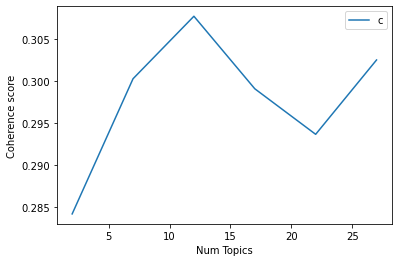

In [81]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_score4)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [82]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_score4):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics =  12

index: 0 | Num Topics = 2  has Coherence Value of 0.2842
index: 1 | Num Topics = 7  has Coherence Value of 0.3003
index: 2 | Num Topics = 12  has Coherence Value of 0.3078
index: 3 | Num Topics = 17  has Coherence Value of 0.2991
index: 4 | Num Topics = 22  has Coherence Value of 0.2937
index: 5 | Num Topics = 27  has Coherence Value of 0.3026


In [170]:
# Select optimal number of topics
optimal_model_us_score4 = model_list_us_score4[2]

In [171]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_score4 = pyLDAvis.gensim_models.prepare(optimal_model_us_score4, corpus_us_score4, id2word_us_score4)

In [172]:
print("pyLDAVis for us topics for score=4:")
vis_us_score4

pyLDAVis for us topics for score=4:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.130864 -0.035258       1        1  27.079955
5      0.091048 -0.071332       2        1  19.353696
3      0.071048  0.060874       3        1  10.789108
8      0.059872  0.007733       4        1   9.557142
11     0.088676 -0.066177       5        1   7.829200
1      0.048583 -0.047087       6        1   5.133102
6      0.041392  0.224903       7        1   4.986886
0     -0.051467 -0.075710       8        1   4.344428
7     -0.098363  0.051821       9        1   3.305084
9     -0.152944 -0.014707      10        1   2.954082
2     -0.119631 -0.027912      11        1   2.418314
10    -0.109078 -0.007149      12        1   2.249004, topic_info=         Term         Freq        Total Category  logprob  loglift
61    comment   300.000000   300.000000  Default  30.0000  30.0000
332        ad   241.000000   241.000000  Default  29.0000  29.0000
112  playlist   150.000000   150.000000  Default  28.0000  28.0000
77        add   142.000000   142.000000  Default  27.0000  27.0000
73      video  1284.000000  1284.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
97       find     2.957065   110.067396  Topic12  -5.2814   0.1778
16      watch     3.674244   484.521742  Topic12  -5.0643  -1.0871
617   setting     2.408663    39.700218  Topic12  -5.4865   0.9924
474   example     2.314603    35.503056  Topic12  -5.5264   1.0643
213      list     2.346489    44.805330  Topic12  -5.5127   0.8453

[883 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
331       1  0.068679      able
331       2  0.315924      able
331       3  0.109887      able
331       4  0.096151      able
331       5  0.137358      able
...     ...       ...       ...
271       4  0.084730  youtuber
271       5  0.112973  youtuber
271       8  0.056487  youtuber
271       9  0.028243  youtuber
1022     10  0.820992        yr

[2068 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 4, 9, 12, 2, 7, 1, 8, 10, 3, 11])

## LDA Topic Modelling (Rating = 5)

In [86]:
# By-rating Topic Modelling - rating = 5
# Convert to list - move to each section
review_us_score5 = youtube_ios_us_review_YearMonth_score5.review.values.tolist()
review_words_us_score5 = list(sent_to_words(review_us_score5))
print(review_words_us_score5[:1])

[['gotta', 'say', 'you', 'guys', 'did', 'great', 'but', 'there', 'is', 'two', 'bugs', 'hate', 'like', 'when', 'am', 'watching', 'videos', 'maybe', 'occasionally', 'bump', 'into', 'me', 'not', 'being', 'able', 'to', 'control', 'the', 'system', 'so', 'what', 'happens', 'is', 'try', 'to', 'exit', 'out', 'of', 'the', 'video', 'and', 'it', 'does', 'nothing', 'and', 'the', 'second', 'bug', 'doesn', 'happen', 'as', 'often', 'what', 'happens', 'is', 'the', 'app', 'crashes', 'and', 'drives', 'me', 'crazy', 'but', 'at', 'least', 'it', 'lets', 'you', 'continue', 'from', 'where', 'you', 'were']]


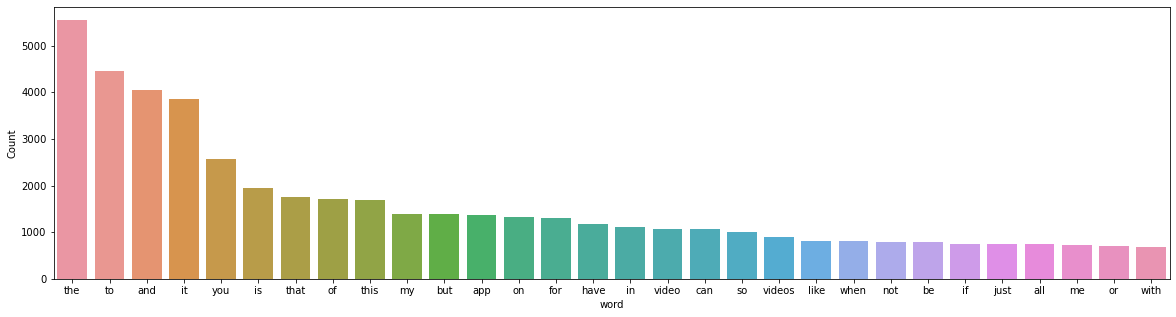

In [87]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_score5))

In [88]:
# Clean text
review_us_ready_score5 = process_words(review_words_us_score5)  # processed Text Data! - move to each section

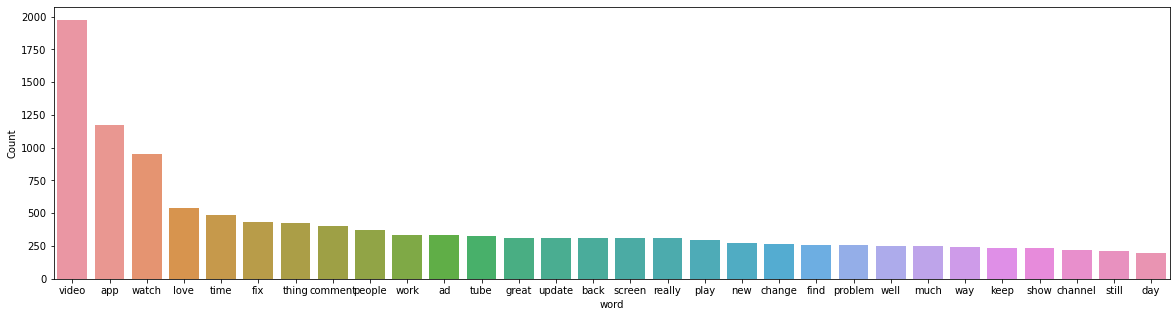

In [89]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready_score5))


In [90]:
# Create Dictionary
id2word_us_score5 = corpora.Dictionary(review_us_ready_score5)

2021-10-17 01:11:25,935 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 01:11:26,104 [INFO] gensim.corpora.dictionary - built Dictionary(4764 unique tokens: ['able', 'app', 'bug', 'bump', 'continue']...) from 1656 documents (total 46447 corpus positions)
2021-10-17 01:11:26,105 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(4764 unique tokens: ['able', 'app', 'bug', 'bump', 'continue']...) from 1656 documents (total 46447 corpus positions)", 'datetime': '2021-10-17T01:11:26.105493', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [91]:
# Create Corpus: Term Document Frequency
corpus_us_score5 = [id2word_us_score5.doc2bow(text) for text in review_us_ready_score5]

In [92]:
# Training LDA model
model_list_us_score5, coherence_values_us_score5 = compute_coherence_values(dictionary=id2word_us_score5, corpus=corpus_us_score5, 
                                                              texts=review_us_ready_score5, limit=30, start=2, step=5)


2021-10-17 01:11:26,296 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 01:11:26,298 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 01:11:26,302 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 01:11:26,305 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 1656 documents, updating model once every 1000 documents, evaluating perplexity every 1656 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 01:11:26,308 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1000/1656
2021-10-17 01:11:29,441 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:11:29,445 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.037*"video" + 0.027*"app" + 0.020*"watch" + 0.015*"fix" + 0.013*"screen" + 0.008*"thing" + 0.008*"time" + 0.008*"update" + 0.008*"really" +

2021-10-17 01:11:51,781 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #1656/1656
2021-10-17 01:11:52,778 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:11:52,781 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.052*"video" + 0.035*"app" + 0.018*"watch" + 0.015*"fix" + 0.015*"comment" + 0.013*"update" + 0.011*"time" + 0.010*"ad" + 0.010*"screen" + 0.009*"work"
2021-10-17 01:11:52,782 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.021*"video" + 0.018*"love" + 0.018*"watch" + 0.013*"people" + 0.013*"tube" + 0.011*"app" + 0.010*"thing" + 0.008*"much" + 0.008*"find" + 0.007*"time"
2021-10-17 01:11:52,783 [INFO] gensim.models.ldamodel - topic diff=0.235234, rho=0.387609
2021-10-17 01:11:52,785 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #1000/1656
2021-10-17 01:11:54,268 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:11:5

2021-10-17 01:12:09,076 [INFO] gensim.models.ldamodel - topic diff=0.168216, rho=0.292904
2021-10-17 01:12:10,304 [INFO] gensim.models.ldamodel - -6.958 per-word bound, 124.3 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:12:10,306 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #1656/1656
2021-10-17 01:12:11,191 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:12:11,194 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.057*"video" + 0.037*"app" + 0.020*"watch" + 0.015*"comment" + 0.015*"fix" + 0.012*"update" + 0.012*"time" + 0.011*"ad" + 0.010*"screen" + 0.009*"problem"
2021-10-17 01:12:11,195 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.018*"love" + 0.015*"watch" + 0.014*"video" + 0.014*"tube" + 0.014*"people" + 0.010*"thing" + 0.008*"much" + 0.008*"music" + 0.007*"find" + 0.007*"app"
2021-10-17 01:12:11,196 [INFO] gensim.models.ldamodel - topic diff=0

2021-10-17 01:12:26,138 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.017*"love" + 0.014*"watch" + 0.014*"tube" + 0.014*"people" + 0.012*"video" + 0.010*"thing" + 0.008*"much" + 0.008*"music" + 0.007*"find" + 0.007*"great"
2021-10-17 01:12:26,140 [INFO] gensim.models.ldamodel - topic diff=0.132999, rho=0.245027
2021-10-17 01:12:27,275 [INFO] gensim.models.ldamodel - -6.948 per-word bound, 123.5 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:12:27,276 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #1656/1656
2021-10-17 01:12:28,156 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:12:28,158 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.058*"video" + 0.038*"app" + 0.021*"watch" + 0.015*"comment" + 0.014*"fix" + 0.012*"time" + 0.011*"update" + 0.011*"ad" + 0.010*"screen" + 0.009*"problem"
2021-10-17 01:12:28,160 [INFO] gensim.models.ldamodel - topic #1 

2021-10-17 01:12:42,316 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.059*"video" + 0.038*"app" + 0.022*"watch" + 0.015*"fix" + 0.014*"comment" + 0.012*"time" + 0.011*"update" + 0.011*"ad" + 0.010*"screen" + 0.009*"play"
2021-10-17 01:12:42,317 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.017*"love" + 0.015*"tube" + 0.014*"people" + 0.014*"watch" + 0.010*"video" + 0.010*"thing" + 0.008*"music" + 0.008*"much" + 0.007*"find" + 0.007*"great"
2021-10-17 01:12:42,318 [INFO] gensim.models.ldamodel - topic diff=0.113200, rho=0.214887
2021-10-17 01:12:43,533 [INFO] gensim.models.ldamodel - -6.943 per-word bound, 123.0 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:12:43,534 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #1656/1656
2021-10-17 01:12:44,213 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:12:44,217 [INFO] gensim.models.ldamodel - topic #0 (0.

2021-10-17 01:12:57,031 [INFO] gensim.models.ldamodel - topic diff=0.100811, rho=0.197427
2021-10-17 01:12:57,033 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #1000/1656
2021-10-17 01:12:58,356 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:12:58,359 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.059*"video" + 0.038*"app" + 0.022*"watch" + 0.015*"fix" + 0.014*"comment" + 0.012*"time" + 0.011*"update" + 0.011*"ad" + 0.010*"screen" + 0.009*"play"
2021-10-17 01:12:58,361 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.017*"love" + 0.015*"tube" + 0.014*"people" + 0.013*"watch" + 0.010*"video" + 0.009*"thing" + 0.008*"music" + 0.008*"much" + 0.007*"find" + 0.007*"great"
2021-10-17 01:12:58,363 [INFO] gensim.models.ldamodel - topic diff=0.100164, rho=0.193688
2021-10-17 01:12:59,559 [INFO] gensim.models.ldamodel - -6.940 per-word bound, 122.8 perplexity estimate based on a held-out corpus of 656 docu

2021-10-17 01:13:12,815 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.017*"love" + 0.015*"tube" + 0.014*"people" + 0.013*"watch" + 0.009*"thing" + 0.009*"video" + 0.008*"music" + 0.008*"much" + 0.007*"find" + 0.007*"great"
2021-10-17 01:13:12,817 [INFO] gensim.models.ldamodel - topic diff=0.091344, rho=0.180610
2021-10-17 01:13:12,818 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #1000/1656
2021-10-17 01:13:14,124 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:13:14,127 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.059*"video" + 0.039*"app" + 0.022*"watch" + 0.014*"fix" + 0.014*"comment" + 0.012*"time" + 0.011*"ad" + 0.011*"update" + 0.010*"screen" + 0.009*"play"
2021-10-17 01:13:14,130 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.017*"love" + 0.015*"tube" + 0.014*"people" + 0.013*"watch" + 0.009*"thing" + 0.009*"video" + 0.008*"music" + 0.008*"much" + 0.007*"find" + 0.007*"great"
2021

2021-10-17 01:13:28,683 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.058*"video" + 0.039*"app" + 0.022*"watch" + 0.014*"comment" + 0.014*"fix" + 0.012*"time" + 0.011*"ad" + 0.011*"update" + 0.009*"screen" + 0.009*"problem"
2021-10-17 01:13:28,685 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.017*"love" + 0.015*"tube" + 0.014*"people" + 0.012*"watch" + 0.009*"thing" + 0.009*"video" + 0.008*"music" + 0.008*"much" + 0.007*"find" + 0.007*"great"
2021-10-17 01:13:28,686 [INFO] gensim.models.ldamodel - topic diff=0.084027, rho=0.167469
2021-10-17 01:13:28,687 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #1000/1656
2021-10-17 01:13:29,788 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:13:29,792 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.059*"video" + 0.039*"app" + 0.023*"watch" + 0.014*"fix" + 0.014*"comment" + 0.012*"time" + 0.011*"ad" + 0.011*"update" + 0.010*"screen" + 0.009*"play"
202

2021-10-17 01:13:44,532 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #1656/1656
2021-10-17 01:13:45,467 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:13:45,474 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.058*"video" + 0.039*"app" + 0.022*"watch" + 0.014*"comment" + 0.014*"fix" + 0.012*"time" + 0.011*"ad" + 0.011*"update" + 0.009*"screen" + 0.009*"problem"
2021-10-17 01:13:45,475 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.017*"love" + 0.015*"tube" + 0.014*"people" + 0.012*"watch" + 0.009*"thing" + 0.008*"video" + 0.008*"music" + 0.007*"much" + 0.007*"find" + 0.007*"great"
2021-10-17 01:13:45,476 [INFO] gensim.models.ldamodel - topic diff=0.078199, rho=0.156833
2021-10-17 01:13:45,481 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #1000/1656
2021-10-17 01:13:46,759 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17

2021-10-17 01:14:00,766 [INFO] gensim.models.ldamodel - topic diff=0.074055, rho=0.147996
2021-10-17 01:14:02,055 [INFO] gensim.models.ldamodel - -6.933 per-word bound, 122.2 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:14:02,057 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #1656/1656
2021-10-17 01:14:02,876 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:14:02,879 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.058*"video" + 0.039*"app" + 0.023*"watch" + 0.014*"comment" + 0.014*"fix" + 0.012*"time" + 0.011*"ad" + 0.011*"update" + 0.009*"screen" + 0.009*"play"
2021-10-17 01:14:02,881 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.017*"love" + 0.015*"tube" + 0.014*"people" + 0.012*"watch" + 0.009*"thing" + 0.008*"music" + 0.008*"video" + 0.007*"much" + 0.007*"find" + 0.007*"great"
2021-10-17 01:14:02,884 [INFO] gensim.models.ldamodel - topic diff=0

2021-10-17 01:14:18,282 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.017*"love" + 0.015*"tube" + 0.014*"people" + 0.012*"watch" + 0.009*"thing" + 0.008*"music" + 0.008*"video" + 0.007*"much" + 0.007*"find" + 0.007*"great"
2021-10-17 01:14:18,283 [INFO] gensim.models.ldamodel - topic diff=0.069949, rho=0.140503
2021-10-17 01:14:19,399 [INFO] gensim.models.ldamodel - -6.932 per-word bound, 122.1 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:14:19,401 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #1656/1656
2021-10-17 01:14:20,118 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:14:20,122 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.058*"video" + 0.039*"app" + 0.023*"watch" + 0.014*"comment" + 0.014*"fix" + 0.012*"time" + 0.011*"ad" + 0.011*"update" + 0.009*"screen" + 0.009*"play"
2021-10-17 01:14:20,126 [INFO] gensim.models.ldamodel - topic #1 (0.

2021-10-17 01:14:37,298 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.011*"thing" + 0.010*"fix" + 0.009*"screen" + 0.009*"new" + 0.009*"way" + 0.007*"app" + 0.006*"change" + 0.006*"video" + 0.006*"work" + 0.006*"life"
2021-10-17 01:14:37,299 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.079*"video" + 0.027*"watch" + 0.019*"ad" + 0.014*"fix" + 0.013*"play" + 0.012*"time" + 0.010*"app" + 0.009*"back" + 0.008*"screen" + 0.008*"view"
2021-10-17 01:14:37,301 [INFO] gensim.models.ldamodel - topic diff=0.457590, rho=0.522994
2021-10-17 01:14:38,732 [INFO] gensim.models.ldamodel - -7.461 per-word bound, 176.2 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:14:38,735 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #1656/1656
2021-10-17 01:14:40,016 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:14:40,022 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.077

2021-10-17 01:14:48,670 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #1000/1656
2021-10-17 01:14:50,272 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:14:50,281 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.085*"video" + 0.029*"watch" + 0.027*"ad" + 0.015*"play" + 0.012*"fix" + 0.012*"time" + 0.010*"back" + 0.009*"view" + 0.008*"app" + 0.008*"change"
2021-10-17 01:14:50,282 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.053*"comment" + 0.026*"video" + 0.021*"watch" + 0.019*"app" + 0.016*"section" + 0.014*"add" + 0.011*"fix" + 0.011*"thing" + 0.010*"people" + 0.010*"really"
2021-10-17 01:14:50,284 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.008*"thing" + 0.007*"way" + 0.007*"tell" + 0.006*"que" + 0.006*"life" + 0.006*"new" + 0.005*"change" + 0.005*"well" + 0.004*"idea" + 0.004*"work"
2021-10-17 01:14:50,285 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.054*"app" + 0.053*"video" + 

2021-10-17 01:14:59,955 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.035*"tube" + 0.025*"love" + 0.014*"watch" + 0.014*"music" + 0.013*"find" + 0.011*"much" + 0.011*"thing" + 0.010*"learn" + 0.009*"day" + 0.009*"time"
2021-10-17 01:14:59,956 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.057*"app" + 0.051*"video" + 0.020*"watch" + 0.017*"update" + 0.015*"fix" + 0.014*"time" + 0.013*"love" + 0.013*"work" + 0.012*"screen" + 0.011*"problem"
2021-10-17 01:14:59,957 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.028*"people" + 0.019*"content" + 0.011*"ad" + 0.010*"great" + 0.009*"video" + 0.008*"love" + 0.007*"learn" + 0.007*"platform" + 0.007*"channel" + 0.006*"watch"
2021-10-17 01:14:59,958 [INFO] gensim.models.ldamodel - topic diff=0.128395, rho=0.339892
2021-10-17 01:14:59,960 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #1000/1656
2021-10-17 01:15:01,344 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents


2021-10-17 01:15:08,906 [INFO] gensim.models.ldamodel - topic diff=0.103510, rho=0.292904
2021-10-17 01:15:10,002 [INFO] gensim.models.ldamodel - -7.119 per-word bound, 139.0 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:15:10,003 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #1656/1656
2021-10-17 01:15:10,916 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:15:10,921 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.009*"que" + 0.007*"tell" + 0.006*"positive" + 0.005*"lololol" + 0.005*"life" + 0.005*"blessing" + 0.005*"friend" + 0.004*"class" + 0.004*"lie" + 0.004*"way"
2021-10-17 01:15:10,922 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.085*"video" + 0.033*"ad" + 0.029*"watch" + 0.014*"play" + 0.012*"time" + 0.010*"back" + 0.010*"view" + 0.009*"change" + 0.008*"upload" + 0.007*"fix"
2021-10-17 01:15:10,924 [INFO] gensim.models.ldamodel - topic #1 (0

2021-10-17 01:15:18,927 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.007*"que" + 0.007*"positive" + 0.006*"tell" + 0.004*"blessing" + 0.004*"lololol" + 0.004*"word" + 0.004*"class" + 0.004*"life" + 0.004*"send" + 0.004*"prayer"
2021-10-17 01:15:18,930 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.087*"video" + 0.034*"ad" + 0.030*"watch" + 0.015*"play" + 0.012*"time" + 0.012*"view" + 0.010*"back" + 0.009*"change" + 0.008*"upload" + 0.007*"really"
2021-10-17 01:15:18,932 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.056*"app" + 0.053*"video" + 0.021*"watch" + 0.017*"fix" + 0.016*"update" + 0.014*"screen" + 0.014*"time" + 0.013*"work" + 0.012*"love" + 0.011*"problem"
2021-10-17 01:15:18,934 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.062*"comment" + 0.027*"video" + 0.020*"watch" + 0.019*"section" + 0.015*"add" + 0.014*"app" + 0.013*"thing" + 0.012*"people" + 0.010*"fix" + 0.009*"post"
2021-10-17 01:15:18,935 [INFO] gensim.models.ldamodel - topic diff=0.086932, r

2021-10-17 01:15:27,519 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.058*"app" + 0.052*"video" + 0.021*"watch" + 0.017*"update" + 0.017*"fix" + 0.014*"time" + 0.013*"screen" + 0.013*"work" + 0.011*"problem" + 0.011*"love"
2021-10-17 01:15:27,525 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.009*"que" + 0.007*"positive" + 0.007*"tell" + 0.005*"lololol" + 0.005*"blessing" + 0.005*"class" + 0.004*"send" + 0.004*"word" + 0.004*"prayer" + 0.004*"lie"
2021-10-17 01:15:27,528 [INFO] gensim.models.ldamodel - topic diff=0.077825, rho=0.245027
2021-10-17 01:15:27,529 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #1000/1656
2021-10-17 01:15:28,712 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:15:28,718 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.029*"people" + 0.021*"content" + 0.010*"great" + 0.008*"channel" + 0.008*"video" + 0.008*"learn" + 0.007*"platform" + 0.007*"ad" + 0.007*"give" + 0.00

2021-10-17 01:15:36,104 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #1656/1656
2021-10-17 01:15:36,927 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:15:36,934 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.029*"people" + 0.022*"content" + 0.010*"great" + 0.008*"channel" + 0.008*"platform" + 0.007*"video" + 0.007*"learn" + 0.007*"ad" + 0.007*"give" + 0.007*"love"
2021-10-17 01:15:36,937 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.064*"comment" + 0.028*"video" + 0.020*"watch" + 0.019*"section" + 0.016*"add" + 0.014*"app" + 0.013*"thing" + 0.012*"people" + 0.010*"fix" + 0.009*"post"
2021-10-17 01:15:36,939 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.013*"kid" + 0.011*"free" + 0.010*"let" + 0.008*"give" + 0.008*"work" + 0.007*"guy" + 0.006*"real" + 0.006*"thing" + 0.006*"human" + 0.006*"show"
2021-10-17 01:15:36,942 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.009*"que" + 0.007*

2021-10-17 01:15:44,831 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.030*"people" + 0.022*"content" + 0.010*"great" + 0.008*"channel" + 0.008*"platform" + 0.007*"learn" + 0.007*"video" + 0.007*"give" + 0.007*"love" + 0.006*"way"
2021-10-17 01:15:44,836 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.036*"tube" + 0.027*"love" + 0.017*"watch" + 0.014*"music" + 0.013*"find" + 0.012*"thing" + 0.012*"much" + 0.011*"learn" + 0.010*"day" + 0.010*"life"
2021-10-17 01:15:44,840 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.014*"kid" + 0.010*"let" + 0.010*"free" + 0.010*"give" + 0.009*"work" + 0.008*"guy" + 0.006*"real" + 0.006*"help" + 0.006*"human" + 0.006*"believe"
2021-10-17 01:15:44,842 [INFO] gensim.models.ldamodel - topic diff=0.064546, rho=0.210091
2021-10-17 01:15:46,033 [INFO] gensim.models.ldamodel - -7.091 per-word bound, 136.3 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:15:46,034 [INFO] gensim.models.ldamodel - PROG

2021-10-17 01:15:52,759 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.030*"people" + 0.023*"content" + 0.010*"great" + 0.008*"channel" + 0.008*"platform" + 0.007*"video" + 0.007*"give" + 0.007*"learn" + 0.006*"way" + 0.006*"love"
2021-10-17 01:15:52,762 [INFO] gensim.models.ldamodel - topic diff=0.060416, rho=0.201390
2021-10-17 01:15:52,767 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #1000/1656
2021-10-17 01:15:53,958 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:15:53,963 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.015*"kid" + 0.010*"let" + 0.010*"free" + 0.010*"give" + 0.009*"work" + 0.008*"guy" + 0.006*"real" + 0.006*"help" + 0.006*"human" + 0.006*"believe"
2021-10-17 01:15:53,964 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.056*"app" + 0.054*"video" + 0.022*"watch" + 0.018*"fix" + 0.016*"update" + 0.015*"screen" + 0.014*"time" + 0.013*"work" + 0.012*"problem" + 0.011*"love"
2

2021-10-17 01:16:02,044 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:16:02,049 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.064*"comment" + 0.028*"video" + 0.020*"watch" + 0.019*"section" + 0.017*"add" + 0.013*"app" + 0.013*"thing" + 0.012*"people" + 0.010*"post" + 0.009*"fix"
2021-10-17 01:16:02,051 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.009*"que" + 0.007*"positive" + 0.007*"tell" + 0.005*"lololol" + 0.005*"blessing" + 0.005*"send" + 0.005*"class" + 0.004*"prayer" + 0.004*"lie" + 0.004*"word"
2021-10-17 01:16:02,052 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.084*"video" + 0.039*"ad" + 0.029*"watch" + 0.014*"play" + 0.013*"view" + 0.012*"time" + 0.009*"change" + 0.009*"back" + 0.008*"upload" + 0.007*"channel"
2021-10-17 01:16:02,053 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.014*"kid" + 0.011*"free" + 0.010*"let" + 0.008*"give" + 0.008*"work" + 0.007*"guy" + 0.007*"real" + 0.006*"hu

2021-10-17 01:16:09,420 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.008*"que" + 0.007*"positive" + 0.006*"tell" + 0.005*"send" + 0.005*"blessing" + 0.005*"lololol" + 0.004*"class" + 0.004*"word" + 0.004*"prayer" + 0.004*"true"
2021-10-17 01:16:09,422 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.015*"kid" + 0.010*"let" + 0.010*"free" + 0.009*"give" + 0.008*"work" + 0.008*"guy" + 0.006*"real" + 0.006*"human" + 0.006*"help" + 0.006*"copyright"
2021-10-17 01:16:09,423 [INFO] gensim.models.ldamodel - topic diff=0.053489, rho=0.180610
2021-10-17 01:16:10,556 [INFO] gensim.models.ldamodel - -7.083 per-word bound, 135.6 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:16:10,557 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #1656/1656
2021-10-17 01:16:11,288 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:16:11,293 [INFO] gensim.models.ldamodel - topic #0

2021-10-17 01:16:17,605 [INFO] gensim.models.ldamodel - topic diff=0.050959, rho=0.174992
2021-10-17 01:16:17,606 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #1000/1656
2021-10-17 01:16:18,791 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:16:18,795 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.015*"kid" + 0.010*"let" + 0.010*"free" + 0.009*"give" + 0.008*"work" + 0.008*"guy" + 0.006*"real" + 0.006*"human" + 0.006*"help" + 0.006*"copyright"
2021-10-17 01:16:18,797 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.035*"tube" + 0.028*"love" + 0.017*"watch" + 0.014*"music" + 0.013*"find" + 0.012*"thing" + 0.012*"much" + 0.011*"learn" + 0.010*"day" + 0.010*"life"
2021-10-17 01:16:18,798 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.008*"que" + 0.007*"positive" + 0.006*"tell" + 0.005*"send" + 0.005*"blessing" + 0.005*"lololol" + 0.004*"class" + 0.004*"prayer" + 0.004*"word" + 0.004*"true"
2021

2021-10-17 01:16:26,832 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.064*"comment" + 0.029*"video" + 0.019*"section" + 0.019*"watch" + 0.017*"add" + 0.013*"thing" + 0.013*"app" + 0.013*"people" + 0.010*"post" + 0.009*"fix"
2021-10-17 01:16:26,834 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.083*"video" + 0.041*"ad" + 0.029*"watch" + 0.014*"play" + 0.013*"view" + 0.012*"time" + 0.009*"change" + 0.009*"upload" + 0.008*"back" + 0.007*"channel"
2021-10-17 01:16:26,837 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.057*"app" + 0.054*"video" + 0.021*"watch" + 0.018*"fix" + 0.017*"update" + 0.014*"time" + 0.014*"screen" + 0.013*"work" + 0.012*"problem" + 0.011*"love"
2021-10-17 01:16:26,838 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.030*"people" + 0.024*"content" + 0.010*"great" + 0.009*"channel" + 0.008*"platform" + 0.007*"give" + 0.007*"learn" + 0.006*"video" + 0.006*"way" + 0.006*"love"
2021-10-17 01:16:26,840 [INFO] gensim.models.ldamodel - topic diff=0.048257,

2021-10-17 01:16:34,039 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.035*"tube" + 0.028*"love" + 0.017*"watch" + 0.014*"music" + 0.013*"find" + 0.012*"thing" + 0.012*"much" + 0.011*"learn" + 0.010*"day" + 0.010*"life"
2021-10-17 01:16:34,040 [INFO] gensim.models.ldamodel - topic diff=0.046432, rho=0.160839
2021-10-17 01:16:35,156 [INFO] gensim.models.ldamodel - -7.079 per-word bound, 135.2 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:16:35,157 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #1656/1656
2021-10-17 01:16:35,834 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:16:35,840 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.030*"people" + 0.024*"content" + 0.010*"great" + 0.009*"channel" + 0.008*"platform" + 0.007*"give" + 0.007*"learn" + 0.006*"way" + 0.006*"video" + 0.006*"love"
2021-10-17 01:16:35,842 [INFO] gensim.models.ldamodel - topic #

2021-10-17 01:16:43,162 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:16:43,168 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.056*"video" + 0.056*"app" + 0.022*"watch" + 0.018*"fix" + 0.016*"update" + 0.015*"screen" + 0.014*"time" + 0.013*"work" + 0.012*"problem" + 0.010*"love"
2021-10-17 01:16:43,170 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.083*"video" + 0.041*"ad" + 0.029*"watch" + 0.015*"play" + 0.015*"view" + 0.012*"time" + 0.008*"upload" + 0.008*"change" + 0.008*"back" + 0.007*"channel"
2021-10-17 01:16:43,172 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.064*"comment" + 0.028*"video" + 0.019*"watch" + 0.019*"section" + 0.017*"add" + 0.013*"thing" + 0.013*"people" + 0.013*"app" + 0.010*"post" + 0.009*"fix"
2021-10-17 01:16:43,174 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.035*"tube" + 0.028*"love" + 0.018*"watch" + 0.014*"music" + 0.013*"find" + 0.012*"thing" + 0.012*"much" + 0.011*"

2021-10-17 01:16:50,809 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.034*"tube" + 0.029*"love" + 0.017*"watch" + 0.015*"music" + 0.013*"find" + 0.012*"thing" + 0.012*"much" + 0.010*"learn" + 0.010*"day" + 0.010*"life"
2021-10-17 01:16:50,810 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.030*"people" + 0.024*"content" + 0.010*"great" + 0.009*"channel" + 0.008*"platform" + 0.007*"give" + 0.007*"learn" + 0.006*"way" + 0.006*"video" + 0.006*"much"
2021-10-17 01:16:50,812 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.082*"video" + 0.042*"ad" + 0.029*"watch" + 0.014*"play" + 0.014*"view" + 0.012*"time" + 0.009*"upload" + 0.009*"change" + 0.008*"back" + 0.007*"channel"
2021-10-17 01:16:50,813 [INFO] gensim.models.ldamodel - topic diff=0.042978, rho=0.151348
2021-10-17 01:16:50,815 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #1000/1656
2021-10-17 01:16:52,042 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents

2021-10-17 01:16:58,170 [INFO] gensim.models.ldamodel - topic diff=0.041764, rho=0.146402
2021-10-17 01:16:59,162 [INFO] gensim.models.ldamodel - -7.076 per-word bound, 134.9 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:16:59,163 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #1656/1656
2021-10-17 01:16:59,907 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:16:59,913 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.015*"kid" + 0.011*"let" + 0.010*"free" + 0.008*"give" + 0.008*"guy" + 0.007*"work" + 0.007*"real" + 0.007*"human" + 0.006*"copyright" + 0.006*"help"
2021-10-17 01:16:59,915 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.056*"app" + 0.055*"video" + 0.022*"watch" + 0.018*"fix" + 0.017*"update" + 0.014*"time" + 0.014*"screen" + 0.013*"work" + 0.012*"problem" + 0.010*"love"
2021-10-17 01:16:59,917 [INFO] gensim.models.ldamodel - topic #4 (0.14

2021-10-17 01:17:07,277 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.064*"comment" + 0.028*"video" + 0.019*"section" + 0.019*"watch" + 0.017*"add" + 0.013*"thing" + 0.013*"people" + 0.013*"app" + 0.010*"post" + 0.009*"fix"
2021-10-17 01:17:07,279 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.082*"video" + 0.043*"ad" + 0.029*"watch" + 0.015*"play" + 0.015*"view" + 0.012*"time" + 0.009*"upload" + 0.008*"change" + 0.008*"back" + 0.007*"channel"
2021-10-17 01:17:07,281 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.008*"que" + 0.007*"positive" + 0.007*"tell" + 0.005*"lololol" + 0.005*"blessing" + 0.004*"class" + 0.004*"prayer" + 0.004*"send" + 0.004*"word" + 0.004*"true"
2021-10-17 01:17:07,283 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.056*"video" + 0.055*"app" + 0.022*"watch" + 0.018*"fix" + 0.016*"update" + 0.015*"screen" + 0.014*"time" + 0.012*"work" + 0.012*"problem" + 0.010*"love"
2021-10-17 01:17:07,284 [INFO] gensim.models.ldamodel - topic diff=0.040347, 

2021-10-17 01:17:15,118 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.081*"video" + 0.044*"ad" + 0.029*"watch" + 0.014*"play" + 0.014*"view" + 0.012*"time" + 0.009*"upload" + 0.008*"change" + 0.008*"back" + 0.007*"channel"
2021-10-17 01:17:15,122 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.030*"people" + 0.025*"content" + 0.010*"great" + 0.009*"channel" + 0.008*"platform" + 0.007*"give" + 0.006*"learn" + 0.006*"way" + 0.006*"much" + 0.006*"year"
2021-10-17 01:17:15,125 [INFO] gensim.models.ldamodel - topic diff=0.039260, rho=0.139136
2021-10-17 01:17:15,128 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=4764, num_topics=7, decay=0.5, chunksize=1000) in 166.24s', 'datetime': '2021-10-17T01:17:15.127888', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-17 01:17:15,136 [INFO] gensim.topic_coherence.probability_estimation - usin

2021-10-17 01:17:32,955 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.021*"video" + 0.016*"watch" + 0.015*"love" + 0.014*"tube" + 0.011*"much" + 0.010*"movie" + 0.010*"life" + 0.009*"find" + 0.008*"work" + 0.008*"ad"
2021-10-17 01:17:32,956 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.028*"video" + 0.021*"view" + 0.016*"change" + 0.014*"channel" + 0.013*"give" + 0.012*"love" + 0.010*"hard" + 0.010*"day" + 0.009*"work" + 0.009*"music"
2021-10-17 01:17:32,958 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.019*"thing" + 0.013*"new" + 0.010*"way" + 0.009*"stuff" + 0.008*"update" + 0.007*"screen" + 0.007*"que" + 0.006*"word" + 0.006*"well" + 0.006*"big"
2021-10-17 01:17:32,960 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.028*"watch" + 0.023*"kid" + 0.014*"much" + 0.013*"app" + 0.013*"ever" + 0.012*"thing" + 0.012*"well" + 0.011*"people" + 0.010*"show" + 0.010*"video"
2021-10-17 01:17:32,962 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.045*"app" + 0.022*"wat

2021-10-17 01:17:42,531 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.098*"video" + 0.033*"ad" + 0.032*"watch" + 0.014*"time" + 0.013*"fix" + 0.012*"play" + 0.010*"app" + 0.009*"back" + 0.008*"screen" + 0.008*"new"
2021-10-17 01:17:42,532 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.080*"comment" + 0.023*"section" + 0.022*"video" + 0.021*"app" + 0.012*"people" + 0.012*"watch" + 0.012*"add" + 0.010*"move" + 0.010*"mode" + 0.010*"read"
2021-10-17 01:17:42,533 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.019*"thing" + 0.011*"que" + 0.011*"agree" + 0.009*"baby" + 0.009*"president" + 0.009*"witch" + 0.008*"word" + 0.008*"true" + 0.008*"way" + 0.007*"girlfriend"
2021-10-17 01:17:42,535 [INFO] gensim.models.ldamodel - topic diff=0.183398, rho=0.387609
2021-10-17 01:17:42,536 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #1000/1656
2021-10-17 01:17:43,809 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-

2021-10-17 01:17:50,699 [INFO] gensim.models.ldamodel - topic diff=0.100652, rho=0.321811
2021-10-17 01:17:51,914 [INFO] gensim.models.ldamodel - -7.678 per-word bound, 204.7 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:17:51,915 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #1656/1656
2021-10-17 01:17:52,697 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:17:52,703 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.059*"app" + 0.051*"video" + 0.019*"update" + 0.019*"watch" + 0.018*"fix" + 0.016*"work" + 0.016*"time" + 0.015*"screen" + 0.012*"problem" + 0.011*"love"
2021-10-17 01:17:52,705 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.024*"view" + 0.022*"video" + 0.020*"channel" + 0.017*"change" + 0.012*"give" + 0.011*"hard" + 0.010*"day" + 0.010*"art" + 0.009*"love" + 0.009*"work"
2021-10-17 01:17:52,706 [INFO] gensim.models.ldamodel - topic #0 (0.0

2021-10-17 01:18:00,483 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.057*"tube" + 0.032*"love" + 0.022*"music" + 0.018*"find" + 0.014*"watch" + 0.012*"world" + 0.012*"time" + 0.010*"well" + 0.010*"day" + 0.010*"learn"
2021-10-17 01:18:00,485 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.019*"girl" + 0.017*"work" + 0.012*"fix" + 0.011*"house" + 0.010*"thing" + 0.010*"friend" + 0.008*"lie" + 0.007*"search" + 0.007*"life" + 0.007*"time"
2021-10-17 01:18:00,487 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.034*"view" + 0.021*"video" + 0.019*"channel" + 0.018*"change" + 0.014*"give" + 0.012*"hard" + 0.011*"day" + 0.010*"work" + 0.009*"art" + 0.009*"learn"
2021-10-17 01:18:00,488 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.017*"notification" + 0.013*"turn" + 0.012*"watch" + 0.009*"step" + 0.009*"video" + 0.008*"time" + 0.008*"period" + 0.007*"trip" + 0.007*"resource" + 0.006*"hope"
2021-10-17 01:18:00,489 [INFO] gensim.models.ldamodel - topic diff=0.076320, rho=0.

2021-10-17 01:18:09,179 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.013*"movie" + 0.012*"life" + 0.012*"video" + 0.011*"family" + 0.011*"quality" + 0.010*"work" + 0.010*"buy" + 0.010*"much" + 0.009*"love" + 0.008*"product"
2021-10-17 01:18:09,181 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.021*"thing" + 0.013*"que" + 0.013*"agree" + 0.011*"true" + 0.010*"baby" + 0.009*"word" + 0.009*"president" + 0.009*"witch" + 0.007*"tell" + 0.007*"girlfriend"
2021-10-17 01:18:09,182 [INFO] gensim.models.ldamodel - topic diff=0.070867, rho=0.261211
2021-10-17 01:18:09,184 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #1000/1656
2021-10-17 01:18:10,379 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:18:10,404 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.033*"people" + 0.024*"content" + 0.013*"platform" + 0.011*"great" + 0.009*"home" + 0.009*"way" + 0.008*"money" + 0.007*"add" + 0.007*"thing" + 0.00

2021-10-17 01:18:17,892 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #1656/1656
2021-10-17 01:18:18,579 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:18:18,586 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.032*"people" + 0.025*"content" + 0.014*"platform" + 0.010*"great" + 0.009*"way" + 0.009*"home" + 0.008*"money" + 0.007*"add" + 0.007*"let" + 0.006*"thing"
2021-10-17 01:18:18,588 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.013*"movie" + 0.012*"life" + 0.011*"quality" + 0.011*"video" + 0.010*"work" + 0.010*"family" + 0.010*"buy" + 0.009*"much" + 0.009*"product" + 0.008*"love"
2021-10-17 01:18:18,590 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.096*"comment" + 0.027*"section" + 0.017*"video" + 0.013*"app" + 0.013*"people" + 0.013*"move" + 0.012*"read" + 0.011*"mode" + 0.011*"add" + 0.010*"scroll"
2021-10-17 01:18:18,592 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.059*"app" +

2021-10-17 01:18:25,840 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.032*"people" + 0.025*"content" + 0.014*"platform" + 0.011*"great" + 0.009*"home" + 0.009*"way" + 0.008*"money" + 0.007*"add" + 0.006*"creator" + 0.006*"thing"
2021-10-17 01:18:25,842 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.019*"girl" + 0.017*"work" + 0.011*"house" + 0.010*"friend" + 0.009*"lie" + 0.009*"thing" + 0.007*"life" + 0.007*"fix" + 0.007*"miss" + 0.007*"car"
2021-10-17 01:18:25,844 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.037*"view" + 0.020*"channel" + 0.019*"video" + 0.018*"change" + 0.015*"give" + 0.012*"hard" + 0.011*"day" + 0.010*"work" + 0.010*"art" + 0.009*"learn"
2021-10-17 01:18:25,845 [INFO] gensim.models.ldamodel - topic diff=0.050420, rho=0.220027
2021-10-17 01:18:26,924 [INFO] gensim.models.ldamodel - -7.403 per-word bound, 169.3 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:18:26,925 [INFO] gensim.models.ldamodel - PR

2021-10-17 01:18:34,446 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.018*"notification" + 0.010*"turn" + 0.010*"watch" + 0.010*"step" + 0.010*"period" + 0.009*"trip" + 0.008*"hope" + 0.008*"time" + 0.007*"cook" + 0.007*"loop"
2021-10-17 01:18:34,447 [INFO] gensim.models.ldamodel - topic diff=0.048208, rho=0.210091
2021-10-17 01:18:34,449 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #1000/1656
2021-10-17 01:18:35,783 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:18:35,790 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.032*"people" + 0.025*"content" + 0.014*"platform" + 0.011*"great" + 0.009*"home" + 0.009*"way" + 0.008*"money" + 0.006*"creator" + 0.006*"add" + 0.006*"thing"
2021-10-17 01:18:35,792 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.051*"watch" + 0.028*"thing" + 0.027*"love" + 0.025*"app" + 0.024*"kid" + 0.020*"much" + 0.019*"people" + 0.015*"ever" + 0.014*"favorite" + 0.012*

2021-10-17 01:18:45,544 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:18:45,551 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.023*"thing" + 0.013*"baby" + 0.013*"que" + 0.013*"agree" + 0.011*"true" + 0.009*"president" + 0.009*"witch" + 0.008*"word" + 0.008*"tell" + 0.007*"head"
2021-10-17 01:18:45,552 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.052*"watch" + 0.028*"love" + 0.028*"thing" + 0.028*"app" + 0.022*"kid" + 0.020*"much" + 0.019*"people" + 0.016*"ever" + 0.014*"favorite" + 0.013*"video"
2021-10-17 01:18:45,554 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.018*"notification" + 0.010*"turn" + 0.010*"step" + 0.010*"period" + 0.009*"watch" + 0.009*"trip" + 0.008*"hope" + 0.008*"cook" + 0.008*"time" + 0.007*"loop"
2021-10-17 01:18:45,556 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.035*"app" + 0.029*"video" + 0.026*"watch" + 0.022*"channel" + 0.018*"great" + 0.017*"people" + 0.014*"love" + 

2021-10-17 01:18:52,956 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.020*"girl" + 0.018*"work" + 0.012*"house" + 0.010*"friend" + 0.009*"lie" + 0.007*"life" + 0.007*"car" + 0.007*"miss" + 0.007*"thing" + 0.007*"simple"
2021-10-17 01:18:52,958 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.038*"view" + 0.020*"channel" + 0.018*"video" + 0.018*"change" + 0.016*"give" + 0.012*"hard" + 0.011*"day" + 0.011*"work" + 0.010*"art" + 0.009*"learn"
2021-10-17 01:18:52,960 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.058*"tube" + 0.033*"love" + 0.024*"music" + 0.018*"find" + 0.014*"watch" + 0.013*"time" + 0.012*"world" + 0.010*"well" + 0.010*"listen" + 0.010*"learn"
2021-10-17 01:18:52,963 [INFO] gensim.models.ldamodel - topic diff=0.040867, rho=0.186807
2021-10-17 01:18:54,061 [INFO] gensim.models.ldamodel - -7.370 per-word bound, 165.5 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:18:54,063 [INFO] gensim.models.ldamodel - PROGRE

2021-10-17 01:19:00,827 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.034*"view" + 0.021*"channel" + 0.018*"video" + 0.017*"change" + 0.015*"give" + 0.012*"hard" + 0.010*"art" + 0.010*"day" + 0.010*"work" + 0.009*"story"
2021-10-17 01:19:00,828 [INFO] gensim.models.ldamodel - topic diff=0.039476, rho=0.180610
2021-10-17 01:19:00,829 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #1000/1656
2021-10-17 01:19:02,060 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:19:02,066 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.020*"girl" + 0.018*"work" + 0.012*"house" + 0.010*"friend" + 0.009*"lie" + 0.007*"car" + 0.007*"life" + 0.007*"miss" + 0.007*"simple" + 0.007*"maybe"
2021-10-17 01:19:02,067 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.032*"app" + 0.027*"video" + 0.025*"watch" + 0.021*"channel" + 0.017*"great" + 0.016*"people" + 0.014*"love" + 0.013*"pay" + 0.012*"thing" + 0.011*"find"
2021-

2021-10-17 01:19:09,693 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:19:09,699 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.018*"notification" + 0.010*"step" + 0.010*"turn" + 0.010*"period" + 0.009*"trip" + 0.008*"hope" + 0.008*"cook" + 0.007*"loop" + 0.007*"time" + 0.007*"resource"
2021-10-17 01:19:09,701 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.110*"video" + 0.039*"ad" + 0.038*"watch" + 0.014*"time" + 0.014*"play" + 0.010*"show" + 0.008*"really" + 0.008*"back" + 0.008*"page" + 0.008*"upload"
2021-10-17 01:19:09,702 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.100*"comment" + 0.029*"section" + 0.015*"video" + 0.013*"move" + 0.013*"people" + 0.012*"read" + 0.012*"add" + 0.011*"mode" + 0.011*"back" + 0.011*"scroll"
2021-10-17 01:19:09,704 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.057*"tube" + 0.034*"love" + 0.025*"music" + 0.017*"find" + 0.013*"watch" + 0.013*"world" + 0.013*"time" + 0.

2021-10-17 01:19:17,076 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.032*"people" + 0.026*"content" + 0.014*"platform" + 0.011*"great" + 0.009*"way" + 0.009*"money" + 0.009*"home" + 0.007*"creator" + 0.006*"let" + 0.006*"country"
2021-10-17 01:19:17,078 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.039*"view" + 0.020*"channel" + 0.018*"change" + 0.018*"video" + 0.016*"give" + 0.013*"hard" + 0.011*"work" + 0.011*"day" + 0.010*"art" + 0.008*"learn"
2021-10-17 01:19:17,081 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.017*"notification" + 0.010*"step" + 0.009*"turn" + 0.009*"period" + 0.008*"trip" + 0.008*"program" + 0.007*"hope" + 0.007*"resource" + 0.007*"watch" + 0.007*"time"
2021-10-17 01:19:17,082 [INFO] gensim.models.ldamodel - topic diff=0.035031, rho=0.165169
2021-10-17 01:19:18,120 [INFO] gensim.models.ldamodel - -7.344 per-word bound, 162.4 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:19:18,122 [INFO] gensim.m

2021-10-17 01:19:24,948 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.031*"people" + 0.027*"content" + 0.014*"platform" + 0.010*"great" + 0.009*"way" + 0.008*"money" + 0.008*"home" + 0.007*"let" + 0.007*"creator" + 0.006*"add"
2021-10-17 01:19:24,949 [INFO] gensim.models.ldamodel - topic diff=0.034644, rho=0.160839
2021-10-17 01:19:24,951 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #1000/1656
2021-10-17 01:19:26,144 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:19:26,157 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.012*"life" + 0.011*"quality" + 0.010*"work" + 0.010*"family" + 0.009*"buy" + 0.009*"cool" + 0.009*"video" + 0.009*"much" + 0.008*"product" + 0.007*"movie"
2021-10-17 01:19:26,158 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.020*"girl" + 0.018*"work" + 0.012*"house" + 0.010*"friend" + 0.009*"lie" + 0.008*"car" + 0.007*"life" + 0.007*"simple" + 0.007*"miss" + 0.007*"day"
2

2021-10-17 01:19:34,040 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:19:34,047 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.019*"notification" + 0.010*"step" + 0.010*"turn" + 0.010*"period" + 0.009*"trip" + 0.008*"hope" + 0.008*"program" + 0.008*"cook" + 0.007*"loop" + 0.007*"resource"
2021-10-17 01:19:34,048 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.100*"comment" + 0.029*"section" + 0.014*"video" + 0.013*"move" + 0.013*"people" + 0.012*"read" + 0.012*"add" + 0.011*"back" + 0.011*"mode" + 0.011*"scroll"
2021-10-17 01:19:34,050 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.057*"app" + 0.051*"video" + 0.023*"fix" + 0.018*"update" + 0.017*"work" + 0.016*"watch" + 0.016*"screen" + 0.016*"time" + 0.013*"problem" + 0.011*"great"
2021-10-17 01:19:34,051 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.031*"people" + 0.027*"content" + 0.014*"platform" + 0.010*"great" + 0.009*"way" + 0.008*"money" + 0.0

2021-10-17 01:19:40,802 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.057*"app" + 0.052*"video" + 0.023*"fix" + 0.018*"update" + 0.017*"screen" + 0.017*"watch" + 0.016*"work" + 0.016*"time" + 0.013*"problem" + 0.011*"great"
2021-10-17 01:19:40,804 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.058*"tube" + 0.033*"love" + 0.024*"music" + 0.017*"find" + 0.013*"watch" + 0.013*"time" + 0.012*"world" + 0.011*"listen" + 0.010*"well" + 0.010*"learn"
2021-10-17 01:19:40,807 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.051*"watch" + 0.036*"app" + 0.030*"love" + 0.028*"thing" + 0.022*"kid" + 0.022*"people" + 0.021*"much" + 0.015*"video" + 0.015*"ever" + 0.013*"favorite"
2021-10-17 01:19:40,808 [INFO] gensim.models.ldamodel - topic diff=0.031347, rho=0.149644
2021-10-17 01:19:41,930 [INFO] gensim.models.ldamodel - -7.324 per-word bound, 160.2 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:19:41,931 [INFO] gensim.models.ldamodel - P

2021-10-17 01:19:49,287 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.036*"view" + 0.021*"channel" + 0.018*"change" + 0.017*"video" + 0.015*"give" + 0.012*"hard" + 0.010*"art" + 0.010*"work" + 0.010*"day" + 0.009*"story"
2021-10-17 01:19:49,288 [INFO] gensim.models.ldamodel - topic diff=0.030523, rho=0.146402
2021-10-17 01:19:49,289 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #1000/1656
2021-10-17 01:19:50,531 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:19:50,539 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.023*"thing" + 0.013*"baby" + 0.012*"agree" + 0.011*"true" + 0.011*"que" + 0.008*"witch" + 0.008*"word" + 0.007*"president" + 0.007*"tell" + 0.006*"face"
2021-10-17 01:19:50,541 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.020*"girl" + 0.017*"work" + 0.012*"house" + 0.010*"friend" + 0.010*"lie" + 0.008*"car" + 0.007*"simple" + 0.007*"life" + 0.007*"day" + 0.006*"task"
2021-10-

2021-10-17 01:19:59,200 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:19:59,209 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.021*"notification" + 0.010*"step" + 0.010*"period" + 0.010*"turn" + 0.009*"trip" + 0.008*"program" + 0.008*"hope" + 0.008*"cook" + 0.007*"loop" + 0.007*"resource"
2021-10-17 01:19:59,212 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.012*"life" + 0.012*"quality" + 0.011*"work" + 0.010*"family" + 0.010*"buy" + 0.009*"product" + 0.009*"cool" + 0.008*"much" + 0.008*"video" + 0.007*"look"
2021-10-17 01:19:59,213 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.057*"app" + 0.051*"video" + 0.023*"fix" + 0.018*"update" + 0.017*"work" + 0.016*"watch" + 0.016*"screen" + 0.016*"time" + 0.013*"problem" + 0.011*"great"
2021-10-17 01:19:59,215 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.057*"tube" + 0.034*"love" + 0.025*"music" + 0.017*"find" + 0.013*"watch" + 0.013*"time" + 0.013*"world"

2021-10-17 01:20:12,351 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 1656 virtual documents
2021-10-17 01:20:14,366 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.058823529411764705
2021-10-17 01:20:14,368 [INFO] gensim.models.ldamodel - using symmetric eta at 0.058823529411764705
2021-10-17 01:20:14,375 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 01:20:14,401 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 17 topics, 50 passes over the supplied corpus of 1656 documents, updating model once every 1000 documents, evaluating perplexity every 1656 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 01:20:14,404 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1000/1656
2021-10-17 01:20:17,004 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:20:17,014 [INFO] gensim.models.ldam

2021-10-17 01:20:25,950 [INFO] gensim.models.ldamodel - topic diff=0.247461, rho=0.463440
2021-10-17 01:20:27,194 [INFO] gensim.models.ldamodel - -8.869 per-word bound, 467.7 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:20:27,196 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #1656/1656
2021-10-17 01:20:28,208 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:20:28,229 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.089*"video" + 0.024*"watch" + 0.016*"play" + 0.011*"like" + 0.011*"time" + 0.010*"fix" + 0.009*"page" + 0.008*"ad" + 0.008*"keep" + 0.007*"great"
2021-10-17 01:20:28,234 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.091*"comment" + 0.028*"app" + 0.026*"video" + 0.025*"section" + 0.017*"add" + 0.014*"watch" + 0.011*"people" + 0.011*"fix" + 0.011*"mode" + 0.010*"scroll"
2021-10-17 01:20:28,237 [INFO] gensim.models.ldamodel - topic #1 (0.059)

2021-10-17 01:20:37,270 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.024*"tab" + 0.023*"add" + 0.016*"put" + 0.016*"song" + 0.016*"community" + 0.015*"work" + 0.013*"sub" + 0.012*"people" + 0.010*"love" + 0.009*"music"
2021-10-17 01:20:37,281 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.070*"tube" + 0.028*"love" + 0.020*"find" + 0.020*"watch" + 0.016*"music" + 0.015*"thing" + 0.014*"learn" + 0.013*"world" + 0.013*"enjoy" + 0.013*"listen"
2021-10-17 01:20:37,284 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.017*"restrict" + 0.016*"mode" + 0.013*"young" + 0.012*"positive" + 0.011*"thing" + 0.011*"turn" + 0.010*"age" + 0.010*"opinion" + 0.010*"child" + 0.010*"coppa"
2021-10-17 01:20:37,285 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.075*"ad" + 0.040*"commercial" + 0.019*"pay" + 0.015*"public" + 0.011*"understand" + 0.010*"song" + 0.010*"time" + 0.009*"video" + 0.009*"force" + 0.008*"fact"
2021-10-17 01:20:37,286 [INFO] gensim.models.ldamodel - topic diff=0.12

2021-10-17 01:20:46,454 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.019*"caption" + 0.018*"row" + 0.016*"lie" + 0.016*"censor" + 0.015*"head" + 0.014*"work" + 0.013*"curse" + 0.010*"tired" + 0.009*"flag" + 0.008*"organize"
2021-10-17 01:20:46,456 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.073*"watch" + 0.052*"app" + 0.039*"love" + 0.033*"thing" + 0.027*"video" + 0.023*"ever" + 0.021*"kid" + 0.019*"favorite" + 0.018*"bad" + 0.017*"game"
2021-10-17 01:20:46,457 [INFO] gensim.models.ldamodel - topic diff=0.087933, rho=0.321811
2021-10-17 01:20:46,459 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #1000/1656
2021-10-17 01:20:47,883 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:20:47,894 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.108*"video" + 0.027*"watch" + 0.026*"play" + 0.011*"like" + 0.011*"audio" + 0.009*"time" + 0.009*"page" + 0.009*"back" + 0.008*"look" + 0.007*"fix"
2021-10-1

2021-10-17 01:20:55,976 [INFO] gensim.models.ldamodel - -8.675 per-word bound, 408.6 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:20:55,978 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #1656/1656
2021-10-17 01:20:56,906 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:20:56,915 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.086*"video" + 0.036*"watch" + 0.032*"app" + 0.023*"fix" + 0.019*"update" + 0.015*"really" + 0.014*"time" + 0.014*"ad" + 0.013*"work" + 0.013*"screen"
2021-10-17 01:20:56,916 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.071*"tube" + 0.033*"love" + 0.023*"music" + 0.021*"watch" + 0.020*"find" + 0.016*"listen" + 0.014*"enjoy" + 0.014*"learn" + 0.014*"thing" + 0.013*"world"
2021-10-17 01:20:56,917 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.111*"video" + 0.028*"watch" + 0.024*"play" + 0.013*"like" + 0.011*"page" + 0.009*

2021-10-17 01:21:05,285 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.033*"tab" + 0.024*"add" + 0.021*"community" + 0.019*"song" + 0.019*"put" + 0.016*"sub" + 0.015*"work" + 0.011*"check" + 0.011*"que" + 0.010*"people"
2021-10-17 01:21:05,287 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.031*"view" + 0.020*"love" + 0.019*"music" + 0.018*"give" + 0.015*"hard" + 0.014*"girl" + 0.013*"video" + 0.012*"change" + 0.012*"work" + 0.011*"time"
2021-10-17 01:21:05,289 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.064*"channel" + 0.055*"change" + 0.021*"art" + 0.019*"name" + 0.013*"computer" + 0.012*"follow" + 0.012*"build" + 0.010*"least" + 0.010*"site" + 0.009*"hang"
2021-10-17 01:21:05,291 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.121*"comment" + 0.036*"section" + 0.019*"video" + 0.015*"add" + 0.015*"app" + 0.014*"read" + 0.013*"scroll" + 0.012*"top" + 0.012*"reply" + 0.012*"back"
2021-10-17 01:21:05,292 [INFO] gensim.models.ldamodel - topic diff=0.051540, rho=0.

2021-10-17 01:21:14,238 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.095*"app" + 0.022*"store" + 0.021*"fix" + 0.020*"problem" + 0.020*"work" + 0.018*"open" + 0.018*"download" + 0.018*"update" + 0.017*"account" + 0.014*"time"
2021-10-17 01:21:14,242 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.044*"app" + 0.038*"video" + 0.020*"screen" + 0.017*"time" + 0.013*"love" + 0.012*"great" + 0.012*"phone" + 0.011*"update" + 0.011*"still" + 0.010*"back"
2021-10-17 01:21:14,244 [INFO] gensim.models.ldamodel - topic diff=0.045741, rho=0.237987
2021-10-17 01:21:14,246 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #1000/1656
2021-10-17 01:21:15,504 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:21:15,513 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.044*"people" + 0.033*"content" + 0.016*"great" + 0.016*"home" + 0.012*"information" + 0.010*"platform" + 0.009*"creator" + 0.009*"medium" + 0.008*"cre

2021-10-17 01:21:23,490 [INFO] gensim.models.ldamodel - -8.645 per-word bound, 400.4 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:21:23,493 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #1656/1656
2021-10-17 01:21:24,204 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:21:24,212 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.129*"comment" + 0.039*"section" + 0.019*"video" + 0.014*"read" + 0.014*"move" + 0.013*"scroll" + 0.013*"add" + 0.013*"mode" + 0.013*"back" + 0.012*"reply"
2021-10-17 01:21:24,214 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.072*"picture" + 0.055*"profile" + 0.016*"press" + 0.015*"program" + 0.015*"give" + 0.014*"win" + 0.013*"trip" + 0.013*"save" + 0.013*"fix" + 0.011*"thumb"
2021-10-17 01:21:24,216 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.075*"watch" + 0.062*"app" + 0.046*"love" + 0.038*"video" + 0.037*"thing" + 0

2021-10-17 01:21:32,060 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.044*"people" + 0.033*"content" + 0.016*"home" + 0.016*"great" + 0.013*"information" + 0.010*"platform" + 0.010*"creator" + 0.009*"medium" + 0.008*"create" + 0.008*"learn"
2021-10-17 01:21:32,061 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.019*"restrict" + 0.016*"mode" + 0.016*"young" + 0.014*"positive" + 0.013*"child" + 0.012*"event" + 0.012*"coppa" + 0.010*"age" + 0.010*"man" + 0.009*"opinion"
2021-10-17 01:21:32,062 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.043*"app" + 0.037*"video" + 0.021*"screen" + 0.017*"time" + 0.013*"phone" + 0.012*"great" + 0.011*"button" + 0.011*"back" + 0.011*"love" + 0.011*"still"
2021-10-17 01:21:32,063 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.031*"post" + 0.031*"video" + 0.021*"time" + 0.020*"new" + 0.017*"much" + 0.016*"well" + 0.015*"find" + 0.015*"learn" + 0.012*"never" + 0.011*"year"
2021-10-17 01:21:32,065 [INFO] gensim.models.ldamodel - topic di

2021-10-17 01:21:40,663 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.131*"comment" + 0.039*"section" + 0.018*"video" + 0.014*"read" + 0.014*"move" + 0.014*"scroll" + 0.014*"back" + 0.013*"mode" + 0.012*"reply" + 0.012*"add"
2021-10-17 01:21:40,664 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.070*"tube" + 0.035*"love" + 0.028*"music" + 0.021*"watch" + 0.020*"find" + 0.018*"listen" + 0.015*"enjoy" + 0.014*"learn" + 0.014*"thing" + 0.012*"world"
2021-10-17 01:21:40,665 [INFO] gensim.models.ldamodel - topic diff=0.034309, rho=0.197427
2021-10-17 01:21:40,667 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #1000/1656
2021-10-17 01:21:41,989 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:21:42,017 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.019*"restrict" + 0.016*"mode" + 0.016*"young" + 0.014*"positive" + 0.012*"child" + 0.012*"event" + 0.012*"coppa" + 0.010*"age" + 0.010*"man" + 0.009*"wo

2021-10-17 01:21:49,492 [INFO] gensim.models.ldamodel - -8.631 per-word bound, 396.4 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:21:49,494 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #1656/1656
2021-10-17 01:21:50,424 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:21:50,433 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.020*"caption" + 0.019*"row" + 0.018*"lie" + 0.016*"censor" + 0.016*"head" + 0.015*"curse" + 0.010*"tired" + 0.010*"community" + 0.010*"flag" + 0.010*"main"
2021-10-17 01:21:50,434 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.097*"app" + 0.023*"work" + 0.023*"fix" + 0.022*"problem" + 0.021*"store" + 0.019*"download" + 0.018*"update" + 0.018*"open" + 0.016*"account" + 0.015*"time"
2021-10-17 01:21:50,435 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.091*"video" + 0.038*"watch" + 0.033*"app" + 0.025*"fix" + 0.019*"update

2021-10-17 01:21:57,969 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.070*"picture" + 0.053*"profile" + 0.016*"save" + 0.015*"press" + 0.015*"program" + 0.014*"give" + 0.012*"win" + 0.012*"fix" + 0.011*"thumb" + 0.011*"trip"
2021-10-17 01:21:57,971 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.017*"caption" + 0.017*"row" + 0.017*"lie" + 0.014*"head" + 0.014*"curse" + 0.014*"censor" + 0.010*"tired" + 0.009*"main" + 0.009*"sudden" + 0.009*"flag"
2021-10-17 01:21:57,972 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.033*"post" + 0.029*"video" + 0.021*"time" + 0.020*"new" + 0.017*"much" + 0.016*"well" + 0.015*"find" + 0.015*"learn" + 0.013*"never" + 0.011*"year"
2021-10-17 01:21:57,975 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.235*"ad" + 0.033*"commercial" + 0.030*"pay" + 0.025*"skip" + 0.015*"put" + 0.014*"understand" + 0.014*"second" + 0.012*"public" + 0.011*"middle" + 0.010*"stop"
2021-10-17 01:21:57,976 [INFO] gensim.models.ldamodel - topic diff=0.029886, r

2021-10-17 01:22:06,588 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.018*"restrict" + 0.017*"young" + 0.016*"mode" + 0.015*"positive" + 0.014*"event" + 0.012*"child" + 0.012*"age" + 0.010*"coppa" + 0.010*"man" + 0.009*"word"
2021-10-17 01:22:06,592 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.044*"people" + 0.035*"content" + 0.017*"home" + 0.015*"great" + 0.013*"information" + 0.011*"platform" + 0.010*"creator" + 0.010*"medium" + 0.009*"create" + 0.008*"let"
2021-10-17 01:22:06,594 [INFO] gensim.models.ldamodel - topic diff=0.028604, rho=0.172373
2021-10-17 01:22:06,596 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #1000/1656
2021-10-17 01:22:07,823 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:22:07,861 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.235*"ad" + 0.033*"commercial" + 0.030*"pay" + 0.026*"skip" + 0.015*"put" + 0.015*"second" + 0.014*"understand" + 0.012*"public" + 0.011

2021-10-17 01:22:15,443 [INFO] gensim.models.ldamodel - -8.623 per-word bound, 394.4 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:22:15,444 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #1656/1656
2021-10-17 01:22:16,134 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:22:16,143 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.134*"comment" + 0.040*"section" + 0.017*"video" + 0.015*"read" + 0.014*"back" + 0.014*"move" + 0.014*"scroll" + 0.014*"mode" + 0.013*"reply" + 0.012*"top"
2021-10-17 01:22:16,145 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.117*"video" + 0.030*"watch" + 0.026*"play" + 0.013*"like" + 0.011*"page" + 0.010*"find" + 0.010*"look" + 0.009*"back" + 0.009*"audio" + 0.008*"stop"
2021-10-17 01:22:16,147 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.069*"tube" + 0.035*"love" + 0.029*"music" + 0.021*"find" + 0.021*"watch" + 0.018*"

2021-10-17 01:22:24,285 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.019*"restrict" + 0.016*"young" + 0.016*"mode" + 0.015*"positive" + 0.013*"event" + 0.012*"child" + 0.012*"coppa" + 0.011*"age" + 0.010*"man" + 0.009*"word"
2021-10-17 01:22:24,288 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.071*"channel" + 0.055*"change" + 0.020*"art" + 0.019*"site" + 0.016*"follow" + 0.014*"name" + 0.013*"computer" + 0.012*"build" + 0.010*"least" + 0.010*"let"
2021-10-17 01:22:24,290 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.043*"view" + 0.020*"love" + 0.020*"music" + 0.019*"give" + 0.015*"girl" + 0.015*"hard" + 0.012*"video" + 0.012*"back" + 0.012*"work" + 0.011*"show"
2021-10-17 01:22:24,293 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.096*"app" + 0.025*"work" + 0.023*"problem" + 0.023*"fix" + 0.020*"download" + 0.019*"store" + 0.017*"update" + 0.016*"open" + 0.016*"time" + 0.015*"account"
2021-10-17 01:22:24,294 [INFO] gensim.models.ldamodel - topic diff=0.025658

2021-10-17 01:22:33,551 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.040*"app" + 0.034*"video" + 0.019*"screen" + 0.017*"time" + 0.012*"phone" + 0.012*"button" + 0.011*"great" + 0.011*"back" + 0.010*"still" + 0.010*"update"
2021-10-17 01:22:33,570 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.040*"view" + 0.021*"music" + 0.020*"love" + 0.018*"give" + 0.016*"girl" + 0.015*"hard" + 0.012*"back" + 0.012*"video" + 0.011*"show" + 0.011*"work"
2021-10-17 01:22:33,587 [INFO] gensim.models.ldamodel - topic diff=0.024890, rho=0.154939
2021-10-17 01:22:33,624 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #1000/1656
2021-10-17 01:22:35,154 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:22:35,167 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.041*"app" + 0.034*"video" + 0.020*"screen" + 0.017*"time" + 0.013*"phone" + 0.013*"button" + 0.011*"great" + 0.011*"back" + 0.010*"still" + 0.010*"click"
202

2021-10-17 01:22:43,888 [INFO] gensim.models.ldamodel - -8.619 per-word bound, 393.2 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:22:43,890 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #1656/1656
2021-10-17 01:22:44,764 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:22:44,783 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.135*"comment" + 0.040*"section" + 0.016*"video" + 0.015*"read" + 0.015*"back" + 0.014*"move" + 0.014*"scroll" + 0.014*"mode" + 0.013*"reply" + 0.012*"top"
2021-10-17 01:22:44,786 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.092*"video" + 0.038*"watch" + 0.033*"app" + 0.025*"fix" + 0.019*"update" + 0.016*"screen" + 0.015*"really" + 0.014*"time" + 0.013*"work" + 0.012*"play"
2021-10-17 01:22:44,787 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.019*"restrict" + 0.016*"young" + 0.015*"positive" + 0.015*"mode" + 0.014*"even

2021-10-17 01:22:52,257 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.045*"view" + 0.020*"love" + 0.020*"music" + 0.019*"give" + 0.015*"girl" + 0.015*"hard" + 0.012*"video" + 0.012*"back" + 0.012*"work" + 0.011*"show"
2021-10-17 01:22:52,263 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.019*"restrict" + 0.016*"mode" + 0.016*"young" + 0.015*"positive" + 0.013*"event" + 0.012*"child" + 0.012*"coppa" + 0.012*"age" + 0.010*"man" + 0.010*"word"
2021-10-17 01:22:52,268 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.033*"post" + 0.027*"video" + 0.021*"time" + 0.021*"new" + 0.017*"much" + 0.016*"well" + 0.016*"find" + 0.015*"learn" + 0.014*"never" + 0.013*"year"
2021-10-17 01:22:52,273 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.021*"caption" + 0.018*"row" + 0.017*"lie" + 0.014*"head" + 0.014*"curse" + 0.014*"censor" + 0.010*"tired" + 0.010*"main" + 0.009*"community" + 0.009*"sudden"
2021-10-17 01:22:52,275 [INFO] gensim.models.ldamodel - topic diff=0.022873, rho=0.1

2021-10-17 01:23:00,427 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.042*"view" + 0.021*"music" + 0.020*"love" + 0.018*"give" + 0.016*"girl" + 0.015*"hard" + 0.012*"back" + 0.012*"video" + 0.011*"work" + 0.011*"show"
2021-10-17 01:23:00,428 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.236*"ad" + 0.032*"commercial" + 0.031*"pay" + 0.027*"skip" + 0.017*"second" + 0.016*"put" + 0.015*"understand" + 0.013*"public" + 0.011*"middle" + 0.010*"stop"
2021-10-17 01:23:00,429 [INFO] gensim.models.ldamodel - topic diff=0.022179, rho=0.141910
2021-10-17 01:23:00,431 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #1000/1656
2021-10-17 01:23:01,614 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:23:01,659 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.076*"add" + 0.032*"tab" + 0.027*"community" + 0.022*"sub" + 0.022*"put" + 0.018*"song" + 0.013*"playlist" + 0.011*"check" + 0.011*"que" + 0.010*"work"

2021-10-17 01:23:17,410 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:23:17,423 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.030*"tube" + 0.020*"video" + 0.016*"thing" + 0.014*"find" + 0.013*"watch" + 0.012*"app" + 0.010*"time" + 0.010*"love" + 0.009*"phone" + 0.008*"daddy"
2021-10-17 01:23:17,425 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.031*"video" + 0.025*"app" + 0.021*"watch" + 0.019*"fix" + 0.012*"work" + 0.012*"comment" + 0.010*"big" + 0.010*"button" + 0.010*"happen" + 0.009*"screen"
2021-10-17 01:23:17,426 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.062*"video" + 0.048*"app" + 0.021*"watch" + 0.015*"play" + 0.013*"love" + 0.012*"update" + 0.011*"fix" + 0.011*"screen" + 0.010*"great" + 0.010*"back"
2021-10-17 01:23:17,428 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.039*"app" + 0.036*"video" + 0.025*"watch" + 0.019*"comment" + 0.016*"add" + 0.011*"really" + 0.010*"problem" + 0.010*

2021-10-17 01:23:29,161 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.131*"ad" + 0.035*"video" + 0.026*"time" + 0.025*"second" + 0.020*"play" + 0.019*"skip" + 0.015*"tab" + 0.013*"annoying" + 0.012*"long" + 0.012*"short"
2021-10-17 01:23:29,164 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.017*"history" + 0.015*"video" + 0.013*"sub" + 0.012*"search" + 0.012*"view" + 0.012*"event" + 0.011*"money" + 0.010*"watch" + 0.010*"certain" + 0.010*"pay"
2021-10-17 01:23:29,165 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.040*"tube" + 0.030*"love" + 0.022*"watch" + 0.022*"listen" + 0.017*"video" + 0.016*"music" + 0.015*"help" + 0.014*"movie" + 0.013*"learn" + 0.012*"human"
2021-10-17 01:23:29,166 [INFO] gensim.models.ldamodel - topic diff=0.247710, rho=0.463440
2021-10-17 01:23:29,167 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #1000/1656
2021-10-17 01:23:30,694 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents

2021-10-17 01:23:38,617 [INFO] gensim.models.ldamodel - topic diff=0.113099, rho=0.361409
2021-10-17 01:23:39,890 [INFO] gensim.models.ldamodel - -9.263 per-word bound, 614.4 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:23:39,893 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #1656/1656
2021-10-17 01:23:40,854 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:23:40,864 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.046*"comment" + 0.022*"section" + 0.021*"move" + 0.019*"back" + 0.016*"find" + 0.014*"change" + 0.014*"tube" + 0.013*"person" + 0.012*"old" + 0.012*"people"
2021-10-17 01:23:40,865 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.079*"video" + 0.040*"watch" + 0.029*"update" + 0.024*"new" + 0.023*"app" + 0.018*"screen" + 0.017*"fix" + 0.015*"really" + 0.013*"time" + 0.011*"work"
2021-10-17 01:23:40,867 [INFO] gensim.models.ldamodel - topic #2

2021-10-17 01:23:50,799 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.023*"work" + 0.021*"fix" + 0.018*"video" + 0.015*"minute" + 0.013*"thing" + 0.013*"step" + 0.012*"back" + 0.012*"hand" + 0.011*"car" + 0.011*"repair"
2021-10-17 01:23:50,806 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.107*"tube" + 0.050*"love" + 0.020*"tv" + 0.019*"thing" + 0.018*"call" + 0.017*"baby" + 0.016*"find" + 0.015*"daddy" + 0.013*"help" + 0.012*"cable"
2021-10-17 01:23:50,812 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.015*"tube" + 0.015*"que" + 0.014*"life" + 0.012*"tell" + 0.012*"age" + 0.010*"big" + 0.009*"president" + 0.009*"menu" + 0.009*"word" + 0.008*"info"
2021-10-17 01:23:50,817 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.028*"people" + 0.028*"watch" + 0.017*"content" + 0.014*"community" + 0.012*"thing" + 0.011*"give" + 0.011*"channel" + 0.010*"show" + 0.008*"second" + 0.008*"tv"
2021-10-17 01:23:50,823 [INFO] gensim.models.ldamodel - topic diff=0.070203, rho=0.30633

2021-10-17 01:24:01,326 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.054*"channel" + 0.031*"change" + 0.024*"people" + 0.019*"work" + 0.018*"art" + 0.017*"name" + 0.016*"money" + 0.016*"commercial" + 0.015*"let" + 0.015*"hard"
2021-10-17 01:24:01,327 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.022*"history" + 0.018*"sub" + 0.017*"event" + 0.014*"certain" + 0.013*"show" + 0.013*"creator" + 0.013*"money" + 0.012*"view" + 0.011*"pay" + 0.011*"stop"
2021-10-17 01:24:01,328 [INFO] gensim.models.ldamodel - topic diff=0.059263, rho=0.281094
2021-10-17 01:24:01,329 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #1000/1656
2021-10-17 01:24:02,642 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:24:02,654 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.022*"caption" + 0.020*"video" + 0.016*"cry" + 0.014*"project" + 0.014*"viewer" + 0.012*"age" + 0.012*"chat" + 0.012*"task" + 0.010*"busy" + 0.009

2021-10-17 01:24:12,440 [INFO] gensim.models.ldamodel - -9.173 per-word bound, 577.3 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:24:12,441 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #1656/1656
2021-10-17 01:24:13,417 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:24:13,438 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.046*"comment" + 0.025*"move" + 0.023*"back" + 0.019*"section" + 0.016*"change" + 0.013*"old" + 0.013*"find" + 0.012*"person" + 0.012*"year" + 0.012*"people"
2021-10-17 01:24:13,440 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.028*"people" + 0.023*"watch" + 0.019*"content" + 0.015*"community" + 0.012*"give" + 0.010*"channel" + 0.010*"freedom" + 0.010*"thing" + 0.009*"speech" + 0.009*"recipe"
2021-10-17 01:24:13,443 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.112*"tube" + 0.060*"love" + 0.031*"tv" + 0.022*"call" + 0.0

2021-10-17 01:24:22,465 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.058*"view" + 0.025*"give" + 0.021*"reply" + 0.018*"video" + 0.016*"delete" + 0.016*"girl" + 0.016*"hard" + 0.015*"work" + 0.013*"time" + 0.010*"well"
2021-10-17 01:24:22,467 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.107*"comment" + 0.045*"add" + 0.033*"app" + 0.027*"section" + 0.026*"video" + 0.017*"really" + 0.016*"read" + 0.014*"watch" + 0.014*"mode" + 0.014*"thing"
2021-10-17 01:24:22,470 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.056*"tube" + 0.029*"love" + 0.025*"watch" + 0.020*"learn" + 0.018*"help" + 0.018*"listen" + 0.015*"music" + 0.013*"movie" + 0.011*"find" + 0.011*"topic"
2021-10-17 01:24:22,472 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.207*"ad" + 0.030*"skip" + 0.029*"play" + 0.027*"second" + 0.022*"time" + 0.021*"video" + 0.018*"tab" + 0.016*"annoying" + 0.012*"really" + 0.011*"pop"
2021-10-17 01:24:22,475 [INFO] gensim.models.ldamodel - topic diff=0.040057, rho=0.23

2021-10-17 01:24:31,947 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.054*"view" + 0.025*"give" + 0.021*"reply" + 0.018*"girl" + 0.017*"video" + 0.015*"hard" + 0.015*"delete" + 0.014*"work" + 0.013*"time" + 0.010*"much"
2021-10-17 01:24:31,949 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.027*"caption" + 0.023*"cry" + 0.017*"viewer" + 0.016*"chat" + 0.015*"video" + 0.015*"project" + 0.014*"task" + 0.012*"age" + 0.011*"busy" + 0.010*"part"
2021-10-17 01:24:31,951 [INFO] gensim.models.ldamodel - topic diff=0.037424, rho=0.220027
2021-10-17 01:24:31,953 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #1000/1656
2021-10-17 01:24:33,326 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:24:33,336 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.057*"tube" + 0.028*"love" + 0.025*"watch" + 0.021*"learn" + 0.018*"help" + 0.017*"listen" + 0.015*"music" + 0.013*"movie" + 0.011*"topic" + 0.011*"find"
202

2021-10-17 01:24:41,562 [INFO] gensim.models.ldamodel - -9.145 per-word bound, 566.1 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:24:41,564 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #1656/1656
2021-10-17 01:24:42,430 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:24:42,440 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.078*"video" + 0.035*"watch" + 0.029*"screen" + 0.027*"update" + 0.024*"new" + 0.022*"app" + 0.019*"fix" + 0.013*"time" + 0.012*"really" + 0.011*"work"
2021-10-17 01:24:42,442 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.055*"view" + 0.025*"give" + 0.022*"reply" + 0.018*"girl" + 0.016*"video" + 0.016*"delete" + 0.016*"hard" + 0.014*"work" + 0.013*"time" + 0.010*"much"
2021-10-17 01:24:42,444 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.041*"love" + 0.040*"content" + 0.031*"home" + 0.028*"people" + 0.018*"live" + 0.013

2021-10-17 01:24:50,871 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.024*"caption" + 0.020*"cry" + 0.016*"viewer" + 0.015*"project" + 0.013*"video" + 0.013*"chat" + 0.013*"age" + 0.013*"task" + 0.011*"part" + 0.010*"busy"
2021-10-17 01:24:50,898 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.052*"watch" + 0.051*"video" + 0.028*"thing" + 0.026*"app" + 0.025*"love" + 0.025*"much" + 0.020*"people" + 0.018*"find" + 0.015*"great" + 0.014*"favorite"
2021-10-17 01:24:50,904 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.058*"tube" + 0.028*"love" + 0.024*"watch" + 0.022*"learn" + 0.018*"help" + 0.017*"listen" + 0.014*"music" + 0.013*"movie" + 0.011*"world" + 0.011*"topic"
2021-10-17 01:24:50,910 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.018*"much" + 0.015*"become" + 0.013*"day" + 0.013*"cook" + 0.013*"tube" + 0.012*"number" + 0.010*"love" + 0.009*"time" + 0.009*"report" + 0.008*"information"
2021-10-17 01:24:50,914 [INFO] gensim.models.ldamodel - topic diff=0.0298

2021-10-17 01:24:59,879 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.074*"picture" + 0.067*"change" + 0.057*"profile" + 0.039*"notification" + 0.025*"button" + 0.024*"dislike" + 0.013*"min" + 0.012*"banner" + 0.011*"loop" + 0.011*"later"
2021-10-17 01:24:59,881 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.027*"people" + 0.019*"content" + 0.017*"community" + 0.016*"watch" + 0.013*"give" + 0.012*"freedom" + 0.010*"speech" + 0.010*"channel" + 0.009*"recipe" + 0.009*"thing"
2021-10-17 01:24:59,883 [INFO] gensim.models.ldamodel - topic diff=0.028498, rho=0.186807
2021-10-17 01:24:59,886 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #1000/1656
2021-10-17 01:25:01,190 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:25:01,199 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.073*"picture" + 0.066*"change" + 0.055*"profile" + 0.037*"notification" + 0.024*"dislike" + 0.024*"button" + 0.014*"banner"

2021-10-17 01:25:08,219 [INFO] gensim.models.ldamodel - topic diff=0.026605, rho=0.177735
2021-10-17 01:25:09,429 [INFO] gensim.models.ldamodel - -9.130 per-word bound, 560.4 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:25:09,430 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #1656/1656
2021-10-17 01:25:10,203 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:25:10,236 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.026*"back" + 0.025*"move" + 0.019*"change" + 0.018*"comment" + 0.016*"old" + 0.015*"person" + 0.014*"year" + 0.013*"young" + 0.013*"allow" + 0.013*"people"
2021-10-17 01:25:10,239 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.025*"sub" + 0.023*"history" + 0.017*"event" + 0.016*"creator" + 0.015*"money" + 0.014*"pay" + 0.014*"show" + 0.013*"certain" + 0.013*"stop" + 0.011*"platform"
2021-10-17 01:25:10,243 [INFO] gensim.models.ldamodel - 

2021-10-17 01:25:18,319 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.124*"comment" + 0.043*"add" + 0.036*"section" + 0.028*"app" + 0.026*"video" + 0.019*"read" + 0.016*"really" + 0.014*"mode" + 0.013*"top" + 0.013*"people"
2021-10-17 01:25:18,321 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.139*"video" + 0.045*"watch" + 0.018*"playlist" + 0.014*"back" + 0.014*"play" + 0.013*"click" + 0.013*"page" + 0.010*"time" + 0.010*"feature" + 0.010*"audio"
2021-10-17 01:25:18,322 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.068*"video" + 0.064*"app" + 0.023*"play" + 0.019*"fix" + 0.016*"click" + 0.016*"great" + 0.015*"time" + 0.014*"problem" + 0.013*"bug" + 0.013*"update"
2021-10-17 01:25:18,323 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.025*"back" + 0.022*"move" + 0.018*"change" + 0.016*"old" + 0.015*"person" + 0.014*"comment" + 0.014*"year" + 0.013*"young" + 0.013*"people" + 0.013*"allow"
2021-10-17 01:25:18,324 [INFO] gensim.models.ldamodel - topic diff=0.024775, r

2021-10-17 01:25:26,878 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.033*"work" + 0.022*"minute" + 0.022*"service" + 0.021*"week" + 0.017*"hand" + 0.016*"step" + 0.016*"car" + 0.015*"thing" + 0.015*"couple" + 0.014*"repair"
2021-10-17 01:25:26,880 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.127*"comment" + 0.043*"add" + 0.037*"section" + 0.026*"app" + 0.026*"video" + 0.019*"read" + 0.016*"really" + 0.015*"mode" + 0.013*"top" + 0.012*"people"
2021-10-17 01:25:26,881 [INFO] gensim.models.ldamodel - topic diff=0.024091, rho=0.165169
2021-10-17 01:25:26,882 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #1000/1656
2021-10-17 01:25:28,064 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:25:28,075 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.076*"video" + 0.034*"screen" + 0.034*"watch" + 0.025*"update" + 0.024*"new" + 0.022*"app" + 0.019*"fix" + 0.013*"time" + 0.012*"really" + 0.012*"phone"

2021-10-17 01:25:35,924 [INFO] gensim.models.ldamodel - -9.122 per-word bound, 557.1 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:25:35,925 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #1656/1656
2021-10-17 01:25:36,822 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:25:36,831 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.075*"video" + 0.033*"watch" + 0.033*"screen" + 0.025*"update" + 0.024*"new" + 0.022*"app" + 0.018*"fix" + 0.012*"time" + 0.012*"really" + 0.011*"back"
2021-10-17 01:25:36,833 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.220*"ad" + 0.034*"skip" + 0.028*"second" + 0.022*"play" + 0.021*"time" + 0.017*"put" + 0.015*"really" + 0.015*"tab" + 0.014*"annoying" + 0.014*"video"
2021-10-17 01:25:36,834 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.027*"sub" + 0.023*"history" + 0.017*"event" + 0.017*"creator" + 0.015*"money" + 0

2021-10-17 01:25:44,804 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.073*"picture" + 0.068*"change" + 0.055*"profile" + 0.039*"notification" + 0.024*"dislike" + 0.023*"button" + 0.015*"popular" + 0.014*"banner" + 0.012*"min" + 0.012*"figure"
2021-10-17 01:25:44,805 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.027*"people" + 0.019*"content" + 0.018*"community" + 0.015*"watch" + 0.013*"give" + 0.012*"freedom" + 0.010*"speech" + 0.009*"thing" + 0.009*"channel" + 0.008*"tab"
2021-10-17 01:25:44,807 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.032*"work" + 0.023*"week" + 0.022*"service" + 0.021*"minute" + 0.016*"step" + 0.015*"thing" + 0.015*"hand" + 0.014*"car" + 0.013*"couple" + 0.013*"back"
2021-10-17 01:25:44,808 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.017*"que" + 0.015*"tell" + 0.014*"age" + 0.011*"resource" + 0.011*"president" + 0.010*"word" + 0.009*"menu" + 0.009*"third" + 0.009*"tube" + 0.008*"info"
2021-10-17 01:25:44,809 [INFO] gensim.models.ldamo

2021-10-17 01:25:53,480 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.059*"view" + 0.025*"give" + 0.022*"reply" + 0.018*"girl" + 0.017*"video" + 0.017*"delete" + 0.016*"hard" + 0.016*"work" + 0.013*"time" + 0.010*"music"
2021-10-17 01:25:53,482 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.142*"video" + 0.046*"watch" + 0.018*"playlist" + 0.014*"play" + 0.014*"back" + 0.013*"page" + 0.012*"click" + 0.011*"search" + 0.010*"feature" + 0.010*"time"
2021-10-17 01:25:53,483 [INFO] gensim.models.ldamodel - topic diff=0.021353, rho=0.149644
2021-10-17 01:25:53,485 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #1000/1656
2021-10-17 01:25:54,735 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:25:54,746 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.027*"people" + 0.019*"content" + 0.018*"community" + 0.015*"watch" + 0.013*"give" + 0.012*"freedom" + 0.010*"speech" + 0.010*"thing" + 0.009*"channel"

2021-10-17 01:26:02,308 [INFO] gensim.models.ldamodel - -9.116 per-word bound, 554.9 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:26:02,309 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #1656/1656
2021-10-17 01:26:03,108 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:26:03,180 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.028*"caption" + 0.024*"cry" + 0.021*"viewer" + 0.016*"chat" + 0.016*"project" + 0.015*"task" + 0.013*"age" + 0.013*"part" + 0.011*"busy" + 0.010*"note"
2021-10-17 01:26:03,182 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.034*"work" + 0.029*"service" + 0.025*"week" + 0.022*"minute" + 0.017*"hand" + 0.016*"thing" + 0.016*"step" + 0.016*"car" + 0.014*"couple" + 0.014*"repair"
2021-10-17 01:26:03,184 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.088*"app" + 0.034*"fix" + 0.022*"work" + 0.021*"problem" + 0.021*"time" + 0.0

2021-10-17 01:26:11,132 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.122*"tube" + 0.054*"love" + 0.046*"tv" + 0.025*"call" + 0.024*"wanna" + 0.020*"thing" + 0.018*"baby" + 0.015*"music" + 0.014*"daddy" + 0.014*"gon"
2021-10-17 01:26:11,134 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.024*"back" + 0.019*"move" + 0.018*"change" + 0.017*"old" + 0.015*"person" + 0.015*"year" + 0.014*"allow" + 0.014*"young" + 0.013*"people" + 0.011*"find"
2021-10-17 01:26:11,136 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.040*"love" + 0.037*"content" + 0.033*"home" + 0.025*"people" + 0.018*"live" + 0.017*"day" + 0.012*"year" + 0.011*"night" + 0.011*"way" + 0.011*"back"
2021-10-17 01:26:11,138 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.025*"sub" + 0.024*"history" + 0.018*"creator" + 0.016*"event" + 0.014*"money" + 0.014*"pay" + 0.014*"certain" + 0.013*"stop" + 0.012*"show" + 0.011*"platform"
2021-10-17 01:26:11,140 [INFO] gensim.models.ldamodel - topic diff=0.019634, rho=0.14

2021-10-17 01:26:28,174 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.030*"video" + 0.020*"watch" + 0.018*"thing" + 0.012*"app" + 0.012*"screen" + 0.012*"fix" + 0.011*"comment" + 0.010*"people" + 0.010*"time" + 0.009*"give"
2021-10-17 01:26:28,175 [INFO] gensim.models.ldamodel - topic diff=22.389238, rho=1.000000
2021-10-17 01:26:29,951 [INFO] gensim.models.ldamodel - -10.511 per-word bound, 1459.6 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:26:29,952 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1656/1656
2021-10-17 01:26:31,480 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:26:31,493 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.036*"video" + 0.020*"change" + 0.015*"user" + 0.014*"give" + 0.012*"service" + 0.012*"love" + 0.012*"people" + 0.011*"much" + 0.011*"view" + 0.010*"music"
2021-10-17 01:26:31,495 [INFO] gensim.models.ldamodel - top

2021-10-17 01:26:42,749 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:26:42,802 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.088*"app" + 0.025*"video" + 0.021*"problem" + 0.021*"download" + 0.020*"thing" + 0.018*"love" + 0.017*"watch" + 0.016*"mode" + 0.014*"store" + 0.014*"really"
2021-10-17 01:26:42,804 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.017*"people" + 0.015*"speech" + 0.012*"freedom" + 0.012*"way" + 0.012*"stop" + 0.011*"buy" + 0.010*"yt" + 0.010*"perfect" + 0.009*"material" + 0.009*"great"
2021-10-17 01:26:42,805 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.124*"video" + 0.033*"watch" + 0.026*"play" + 0.013*"time" + 0.012*"click" + 0.011*"search" + 0.010*"audio" + 0.010*"fix" + 0.009*"page" + 0.009*"back"
2021-10-17 01:26:42,807 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.042*"kid" + 0.039*"watch" + 0.027*"thing" + 0.025*"love" + 0.024*"app" + 0.021*"favorite" + 0.018*"always

2021-10-17 01:26:53,735 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.069*"ad" + 0.037*"community" + 0.034*"tab" + 0.028*"watch" + 0.024*"plan" + 0.024*"caption" + 0.021*"cat" + 0.016*"wanna" + 0.016*"remove" + 0.016*"stop"
2021-10-17 01:26:53,738 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.085*"change" + 0.024*"channel" + 0.022*"friendly" + 0.017*"art" + 0.015*"great" + 0.014*"inspire" + 0.014*"thumbnail" + 0.014*"save" + 0.013*"layout" + 0.013*"form"
2021-10-17 01:26:53,740 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.062*"feature" + 0.029*"ask" + 0.019*"popular" + 0.018*"play" + 0.015*"premium" + 0.015*"picture" + 0.014*"computer" + 0.014*"disappoint" + 0.014*"side" + 0.014*"mobile"
2021-10-17 01:26:53,741 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.066*"channel" + 0.057*"upload" + 0.032*"video" + 0.018*"time" + 0.014*"app" + 0.013*"person" + 0.012*"daddy" + 0.012*"child" + 0.011*"win" + 0.011*"look"
2021-10-17 01:26:53,744 [INFO] gensim.models.ldamo

2021-10-17 01:27:02,886 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.041*"video" + 0.031*"view" + 0.028*"app" + 0.019*"time" + 0.019*"people" + 0.016*"work" + 0.015*"delete" + 0.013*"give" + 0.012*"notification" + 0.010*"watch"
2021-10-17 01:27:02,888 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.057*"love" + 0.028*"day" + 0.025*"home" + 0.022*"back" + 0.020*"night" + 0.017*"tube" + 0.017*"live" + 0.016*"year" + 0.016*"time" + 0.014*"girl"
2021-10-17 01:27:02,889 [INFO] gensim.models.ldamodel - topic diff=0.071906, rho=0.306339
2021-10-17 01:27:04,182 [INFO] gensim.models.ldamodel - -9.697 per-word bound, 830.2 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:27:04,183 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #1656/1656
2021-10-17 01:27:05,256 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:27:05,299 [INFO] gensim.models.ldamodel - topic #1 (0

2021-10-17 01:27:13,473 [INFO] gensim.models.ldamodel - topic diff=0.057440, rho=0.281094
2021-10-17 01:27:13,474 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #1000/1656
2021-10-17 01:27:14,727 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:27:14,743 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.109*"app" + 0.031*"download" + 0.029*"video" + 0.026*"problem" + 0.024*"turn" + 0.023*"mode" + 0.020*"store" + 0.017*"thing" + 0.016*"really" + 0.016*"great"
2021-10-17 01:27:14,745 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.062*"video" + 0.034*"much" + 0.026*"watch" + 0.018*"great" + 0.014*"channel" + 0.013*"find" + 0.013*"new" + 0.012*"love" + 0.012*"day" + 0.011*"never"
2021-10-17 01:27:14,747 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.058*"love" + 0.029*"day" + 0.026*"home" + 0.022*"back" + 0.020*"night" + 0.018*"live" + 0.017*"year" + 0.017*"time" + 0.015*"tube" + 0.014*"girl"
2021

2021-10-17 01:27:24,746 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.021*"bless" + 0.021*"row" + 0.020*"task" + 0.020*"witch" + 0.017*"choose" + 0.015*"unlimited" + 0.015*"provider" + 0.014*"loud" + 0.014*"nightmare" + 0.014*"scary"
2021-10-17 01:27:24,752 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.150*"video" + 0.038*"watch" + 0.028*"play" + 0.013*"click" + 0.013*"time" + 0.013*"page" + 0.013*"scroll" + 0.013*"search" + 0.011*"recommend" + 0.011*"back"
2021-10-17 01:27:24,754 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.062*"love" + 0.029*"day" + 0.026*"home" + 0.022*"back" + 0.021*"night" + 0.019*"live" + 0.018*"year" + 0.017*"time" + 0.015*"girl" + 0.013*"old"
2021-10-17 01:27:24,762 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.081*"music" + 0.040*"listen" + 0.026*"utube" + 0.024*"tube" + 0.023*"love" + 0.022*"life" + 0.019*"enjoy" + 0.018*"feel" + 0.016*"movie" + 0.013*"pay"
2021-10-17 01:27:24,765 [INFO] gensim.models.ldamodel - topic diff=0.046465, 

2021-10-17 01:27:34,142 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.014*"love" + 0.012*"content" + 0.009*"hope" + 0.009*"much" + 0.009*"friend" + 0.008*"stupid" + 0.008*"way" + 0.008*"family" + 0.008*"learn" + 0.008*"idea"
2021-10-17 01:27:34,148 [INFO] gensim.models.ldamodel - topic diff=0.038998, rho=0.231521
2021-10-17 01:27:35,486 [INFO] gensim.models.ldamodel - -9.635 per-word bound, 795.3 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:27:35,487 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #1656/1656
2021-10-17 01:27:36,279 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:27:36,297 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.080*"channel" + 0.072*"upload" + 0.033*"video" + 0.018*"time" + 0.014*"limit" + 0.014*"daddy" + 0.012*"several" + 0.012*"follow" + 0.012*"person" + 0.011*"really"
2021-10-17 01:27:36,300 [INFO] gensim.models.ldamodel

2021-10-17 01:27:45,897 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:27:45,917 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.040*"people" + 0.029*"content" + 0.017*"video" + 0.017*"great" + 0.015*"learn" + 0.013*"platform" + 0.013*"create" + 0.012*"information" + 0.011*"share" + 0.011*"show"
2021-10-17 01:27:45,925 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.025*"people" + 0.022*"speech" + 0.020*"freedom" + 0.017*"stop" + 0.015*"buy" + 0.014*"opinion" + 0.013*"perfect" + 0.013*"way" + 0.011*"material" + 0.010*"irrelevant"
2021-10-17 01:27:45,927 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.115*"app" + 0.037*"download" + 0.027*"problem" + 0.026*"turn" + 0.025*"video" + 0.024*"store" + 0.023*"mode" + 0.019*"great" + 0.016*"really" + 0.015*"time"
2021-10-17 01:27:45,929 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.070*"app" + 0.032*"video" + 0.026*"playlist" + 0.021*"update" + 0.018*"work" + 

2021-10-17 01:27:54,819 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.087*"music" + 0.046*"listen" + 0.026*"utube" + 0.025*"tube" + 0.024*"love" + 0.021*"life" + 0.019*"enjoy" + 0.018*"feel" + 0.015*"movie" + 0.012*"pay"
2021-10-17 01:27:54,820 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.064*"tab" + 0.055*"community" + 0.026*"caption" + 0.025*"plan" + 0.023*"cat" + 0.022*"wanna" + 0.021*"remove" + 0.021*"website" + 0.017*"hook" + 0.013*"ad"
2021-10-17 01:27:54,822 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.061*"love" + 0.029*"day" + 0.026*"home" + 0.022*"back" + 0.021*"night" + 0.019*"live" + 0.019*"year" + 0.018*"time" + 0.015*"girl" + 0.014*"old"
2021-10-17 01:27:54,824 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.025*"row" + 0.021*"bless" + 0.020*"task" + 0.020*"witch" + 0.019*"loud" + 0.018*"choose" + 0.016*"unlimited" + 0.016*"provider" + 0.014*"nightmare" + 0.014*"scary"
2021-10-17 01:27:54,825 [INFO] gensim.models.ldamodel - topic diff=0.031355, r

2021-10-17 01:28:03,584 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.038*"people" + 0.029*"content" + 0.017*"great" + 0.015*"video" + 0.015*"learn" + 0.013*"platform" + 0.013*"create" + 0.013*"information" + 0.012*"share" + 0.012*"way"
2021-10-17 01:28:03,586 [INFO] gensim.models.ldamodel - topic diff=0.028383, rho=0.193688
2021-10-17 01:28:04,935 [INFO] gensim.models.ldamodel - -9.612 per-word bound, 782.4 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:28:04,937 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #1656/1656
2021-10-17 01:28:05,821 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:28:05,833 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.059*"video" + 0.038*"much" + 0.023*"great" + 0.022*"watch" + 0.022*"notification" + 0.018*"channel" + 0.015*"never" + 0.013*"new" + 0.012*"find" + 0.012*"day"
2021-10-17 01:28:05,835 [INFO] gensim.models.

2021-10-17 01:28:13,557 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #1000/1656
2021-10-17 01:28:14,848 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:28:14,860 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.108*"feature" + 0.037*"ask" + 0.020*"computer" + 0.020*"mobile" + 0.019*"play" + 0.018*"side" + 0.017*"premium" + 0.016*"popular" + 0.016*"picture" + 0.015*"fake"
2021-10-17 01:28:14,861 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.236*"ad" + 0.033*"skip" + 0.030*"commercial" + 0.019*"stop" + 0.017*"pay" + 0.017*"premium" + 0.015*"middle" + 0.014*"second" + 0.012*"service" + 0.011*"minute"
2021-10-17 01:28:14,863 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.046*"view" + 0.030*"video" + 0.020*"time" + 0.019*"give" + 0.019*"work" + 0.017*"delete" + 0.016*"people" + 0.013*"app" + 0.012*"support" + 0.011*"ago"
2021-10-17 01:28:14,864 [INFO] gensim.models.ldamodel - topic #20 (0.037

2021-10-17 01:28:23,521 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.116*"app" + 0.040*"download" + 0.029*"turn" + 0.028*"problem" + 0.028*"store" + 0.024*"mode" + 0.022*"great" + 0.019*"video" + 0.018*"time" + 0.016*"open"
2021-10-17 01:28:23,523 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.030*"people" + 0.023*"speech" + 0.021*"freedom" + 0.018*"stop" + 0.017*"buy" + 0.016*"opinion" + 0.014*"perfect" + 0.013*"way" + 0.012*"idea" + 0.012*"material"
2021-10-17 01:28:23,525 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.152*"tube" + 0.033*"find" + 0.024*"learn" + 0.021*"site" + 0.020*"different" + 0.020*"world" + 0.018*"topic" + 0.017*"love" + 0.016*"song" + 0.016*"new"
2021-10-17 01:28:23,527 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.102*"watch" + 0.062*"app" + 0.047*"video" + 0.045*"love" + 0.044*"thing" + 0.035*"people" + 0.025*"kid" + 0.022*"favorite" + 0.022*"amazing" + 0.019*"ever"
2021-10-17 01:28:23,530 [INFO] gensim.models.ldamodel - topic diff=0

2021-10-17 01:28:32,308 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.025*"row" + 0.018*"choose" + 0.018*"bless" + 0.018*"task" + 0.018*"loud" + 0.018*"witch" + 0.014*"scary" + 0.014*"unlimited" + 0.014*"provider" + 0.013*"appropriate"
2021-10-17 01:28:32,310 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.014*"love" + 0.012*"content" + 0.010*"friend" + 0.010*"stupid" + 0.009*"hope" + 0.008*"help" + 0.008*"much" + 0.008*"idea" + 0.008*"family" + 0.008*"end"
2021-10-17 01:28:32,311 [INFO] gensim.models.ldamodel - topic diff=0.023347, rho=0.169868
2021-10-17 01:28:33,609 [INFO] gensim.models.ldamodel - -9.599 per-word bound, 775.3 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:28:33,611 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #1656/1656
2021-10-17 01:28:34,574 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:28:34,588 [INFO] gensim.models.ldamode

2021-10-17 01:28:42,394 [INFO] gensim.models.ldamodel - topic diff=0.022976, rho=0.165169
2021-10-17 01:28:42,398 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #1000/1656
2021-10-17 01:28:43,708 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:28:43,736 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.142*"comment" + 0.046*"section" + 0.031*"add" + 0.020*"video" + 0.018*"move" + 0.017*"read" + 0.017*"people" + 0.016*"reply" + 0.015*"top" + 0.015*"back"
2021-10-17 01:28:43,737 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.031*"word" + 0.019*"face" + 0.016*"pray" + 0.015*"wake" + 0.013*"eventually" + 0.012*"beautiful" + 0.012*"color" + 0.012*"president" + 0.011*"hear" + 0.011*"dark"
2021-10-17 01:28:43,740 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.079*"channel" + 0.073*"upload" + 0.035*"video" + 0.017*"time" + 0.017*"daddy" + 0.014*"limit" + 0.013*"really" + 0.013*"keep" + 0.012*"error" +

2021-10-17 01:28:53,657 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.034*"word" + 0.020*"face" + 0.018*"pray" + 0.017*"wake" + 0.014*"president" + 0.014*"beautiful" + 0.013*"color" + 0.013*"hear" + 0.012*"eventually" + 0.012*"draw"
2021-10-17 01:28:53,659 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.143*"change" + 0.037*"channel" + 0.022*"simple" + 0.022*"art" + 0.020*"friendly" + 0.020*"save" + 0.018*"great" + 0.016*"layout" + 0.016*"big" + 0.014*"hard"
2021-10-17 01:28:53,662 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.094*"music" + 0.053*"listen" + 0.025*"utube" + 0.025*"love" + 0.025*"tube" + 0.019*"enjoy" + 0.018*"life" + 0.018*"feel" + 0.015*"movie" + 0.013*"pay"
2021-10-17 01:28:53,667 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.116*"app" + 0.040*"download" + 0.030*"turn" + 0.028*"problem" + 0.028*"store" + 0.025*"mode" + 0.024*"great" + 0.019*"time" + 0.017*"open" + 0.016*"keep"
2021-10-17 01:28:53,670 [INFO] gensim.models.ldamodel - topic #22 (

2021-10-17 01:29:02,823 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.022*"people" + 0.016*"thing" + 0.013*"min" + 0.012*"give" + 0.010*"week" + 0.009*"first" + 0.009*"learn" + 0.009*"time" + 0.009*"send" + 0.008*"act"
2021-10-17 01:29:02,825 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.095*"video" + 0.038*"app" + 0.034*"watch" + 0.030*"screen" + 0.027*"fix" + 0.020*"play" + 0.020*"update" + 0.018*"time" + 0.016*"annoying" + 0.014*"phone"
2021-10-17 01:29:02,827 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.078*"channel" + 0.073*"upload" + 0.035*"video" + 0.017*"time" + 0.017*"daddy" + 0.014*"limit" + 0.013*"keep" + 0.013*"really" + 0.012*"error" + 0.012*"several"
2021-10-17 01:29:02,829 [INFO] gensim.models.ldamodel - topic diff=0.020541, rho=0.153112
2021-10-17 01:29:04,070 [INFO] gensim.models.ldamodel - -9.590 per-word bound, 770.8 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:29:04,078 [INFO] gensim.models.ldam

2021-10-17 01:29:12,180 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.032*"change" + 0.025*"video" + 0.025*"user" + 0.019*"ability" + 0.019*"well" + 0.018*"guy" + 0.017*"give" + 0.017*"rewind" + 0.015*"bar" + 0.014*"set"
2021-10-17 01:29:12,183 [INFO] gensim.models.ldamodel - topic diff=0.020034, rho=0.149644
2021-10-17 01:29:12,187 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #1000/1656
2021-10-17 01:29:13,465 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1656 documents
2021-10-17 01:29:13,477 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.052*"video" + 0.039*"much" + 0.027*"great" + 0.025*"notification" + 0.018*"watch" + 0.017*"never" + 0.015*"new" + 0.014*"channel" + 0.014*"day" + 0.014*"find"
2021-10-17 01:29:13,478 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.095*"video" + 0.038*"app" + 0.034*"watch" + 0.030*"screen" + 0.027*"fix" + 0.021*"play" + 0.020*"update" + 0.018*"time" + 0.016*"annoying" + 0.014*"

2021-10-17 01:29:21,204 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #1656/1656
2021-10-17 01:29:22,031 [INFO] gensim.models.ldamodel - merging changes from 656 documents into a model of 1656 documents
2021-10-17 01:29:22,054 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.033*"change" + 0.026*"video" + 0.025*"user" + 0.019*"ability" + 0.019*"well" + 0.018*"guy" + 0.017*"rewind" + 0.017*"give" + 0.015*"bar" + 0.014*"set"
2021-10-17 01:29:22,056 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.074*"fix" + 0.038*"app" + 0.031*"problem" + 0.020*"bug" + 0.020*"search" + 0.020*"change" + 0.018*"video" + 0.018*"picture" + 0.017*"update" + 0.016*"issue"
2021-10-17 01:29:22,059 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.151*"change" + 0.036*"channel" + 0.023*"save" + 0.022*"simple" + 0.021*"art" + 0.020*"friendly" + 0.017*"great" + 0.016*"layout" + 0.016*"big" + 0.015*"hard"
2021-10-17 01:29:22,064 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.023*"p

2021-10-17 01:29:30,572 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.059*"love" + 0.030*"day" + 0.026*"home" + 0.023*"back" + 0.021*"night" + 0.019*"time" + 0.019*"live" + 0.019*"year" + 0.014*"old" + 0.014*"girl"
2021-10-17 01:29:30,573 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.038*"history" + 0.020*"event" + 0.019*"show" + 0.017*"content" + 0.016*"service" + 0.013*"censor" + 0.013*"variety" + 0.012*"clear" + 0.012*"much" + 0.011*"rest"
2021-10-17 01:29:30,576 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.014*"love" + 0.011*"friend" + 0.010*"stupid" + 0.010*"content" + 0.009*"hope" + 0.009*"play" + 0.009*"help" + 0.009*"idea" + 0.008*"end" + 0.008*"family"
2021-10-17 01:29:30,577 [INFO] gensim.models.ldamodel - topic diff=0.018169, rho=0.140503
2021-10-17 01:29:31,640 [INFO] gensim.models.ldamodel - -9.585 per-word bound, 768.0 perplexity estimate based on a held-out corpus of 656 documents with 18288 words
2021-10-17 01:29:31,641 [INFO] gensim.models.ldamodel 

In [93]:
%store model_list_us_score5
%store coherence_values_us_score5

Stored 'model_list_us_score5' (list)
Stored 'coherence_values_us_score5' (list)


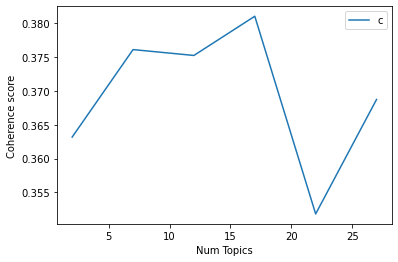

In [94]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_score5)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [95]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_score5):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 17

index: 0 | Num Topics = 2  has Coherence Value of 0.3632
index: 1 | Num Topics = 7  has Coherence Value of 0.3761
index: 2 | Num Topics = 12  has Coherence Value of 0.3752
index: 3 | Num Topics = 17  has Coherence Value of 0.381
index: 4 | Num Topics = 22  has Coherence Value of 0.3518
index: 5 | Num Topics = 27  has Coherence Value of 0.3687


In [173]:
# Select optimal number of topics
optimal_model_us_score5 = model_list_us_score5[3]

In [174]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_score5 = pyLDAvis.gensim_models.prepare(optimal_model_us_score5, corpus_us_score5, id2word_us_score5)

In [175]:
print("pyLDAVis for us topics for score=5:")
vis_us_score5

pyLDAVis for us topics for score=5:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.245105  0.126369       1        1  23.199769
5     -0.167293  0.107175       2        1  11.713526
1     -0.113349 -0.183119       3        1   9.601637
6     -0.199807 -0.104515       4        1   8.408203
2     -0.113691  0.072032       5        1   6.723847
3     -0.085353  0.077884       6        1   6.111090
11    -0.150605  0.083730       7        1   5.996205
4      0.042351 -0.175398       8        1   5.390907
14    -0.041418 -0.089929       9        1   4.991939
10    -0.010147 -0.090702      10        1   4.517623
9      0.094749 -0.146684      11        1   3.536069
13     0.142267  0.100130      12        1   2.716986
16     0.149306  0.074719      13        1   1.977494
15     0.152871  0.043700      14        1   1.566846
0      0.187331  0.013318      15        1   1.289211
8      0.155681  0.035332      16        1   1.190820
7      0.202210  0.055958      17        1   1.067829, topic_info=         Term         Freq        Total Category  logprob  loglift
1         app  1123.000000  1123.000000  Default  30.0000  30.0000
21      video  1883.000000  1883.000000  Default  29.0000  29.0000
316   comment   386.000000   386.000000  Default  28.0000  28.0000
322        ad   297.000000   297.000000  Default  27.0000  27.0000
22      watch   900.000000   900.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
1396     send     3.083630    25.030051  Topic17  -5.0804   2.4456
1179    bless     2.700680    25.542164  Topic17  -5.2130   2.2927
80      thing     3.512736   417.468721  Topic17  -4.9501  -0.2383
1392    state     2.338815    12.979692  Topic17  -5.3569   2.8258
674      word     2.420593    40.967129  Topic17  -5.3225   1.7108

[1077 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
241      17  0.802447   abandon
0         1  0.389430      able
0         2  0.113584      able
0         3  0.243393      able
0         7  0.105471      able
...     ...       ...       ...
1514      9  0.066892     young
1514     15  0.334462     young
480       4  0.976773  youtuber
480       8  0.016841  youtuber
564       2  0.821314      zoom

[2271 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 6, 2, 7, 3, 4, 12, 5, 15, 11, 10, 14, 17, 16, 1, 9, 8])

## LDA Topic Modelling (Rating = 1,2,3)

In [99]:
# By-rating Topic Modelling - rating = 1,2,3
# Convert to list - move to each section
review_us_score1N2N3 = youtube_ios_us_review_YearMonth_score1N2N3.review.values.tolist()
review_words_us_score1N2N3 = list(sent_to_words(review_us_score1N2N3))
print(review_words_us_score1N2N3[:1])

[['the', 'app', 'is', 'nice', 'to', 'have', 'but', 'misses', 'lot', 'of', 'features', 'like', 'viewing', 'options', 'the', 'ability', 'to', 'go', 'back', 'sometimes', 'community', 'tab', 'and', 'critical', 'features', 'like', 'being', 'able', 'to', 'actually', 'use', 'search', 'results', 'you', 'can', 'see', 'them', 'but', 'can', 'watch', 'them', 'love', 'that', 'you', 'can', 'go', 'forward', 'or', 'back', 'in', 'second', 'intervals', 'by', 'tapping', 'the', 'left', 'or', 'right', 'sides', 'of', 'the', 'video', 'but', 'if', 'you', 'accidentally', 'tap', 'forward', 'or', 'back', 'next', 'or', 'previous', 'video', 'you', 'get', 'an', 'ad', 'right', 'away', 'and', 'then', 'another', 'when', 'you', 'go', 'back', 'to', 'the', 'video', 'you', 'were', 'watching', 'there', 'are', 'way', 'more', 'ads', 'on', 'the', 'mobile', 'app', 'than', 'on', 'desktop', 'browser', 'viewing', 'just', 'use', 'chrome', 'instead', 'of', 'the', 'app']]


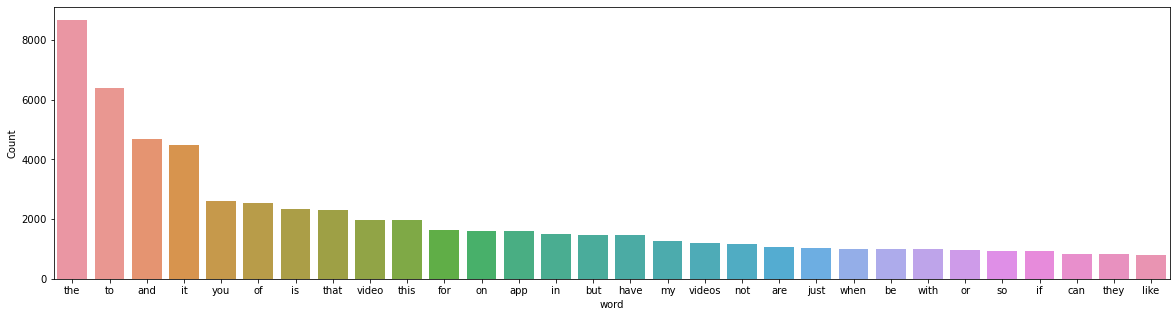

In [100]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_score1N2N3))

In [101]:
# Clean text
review_us_ready_score1N2N3 = process_words(review_words_us_score1N2N3)  # processed Text Data! - move to each section

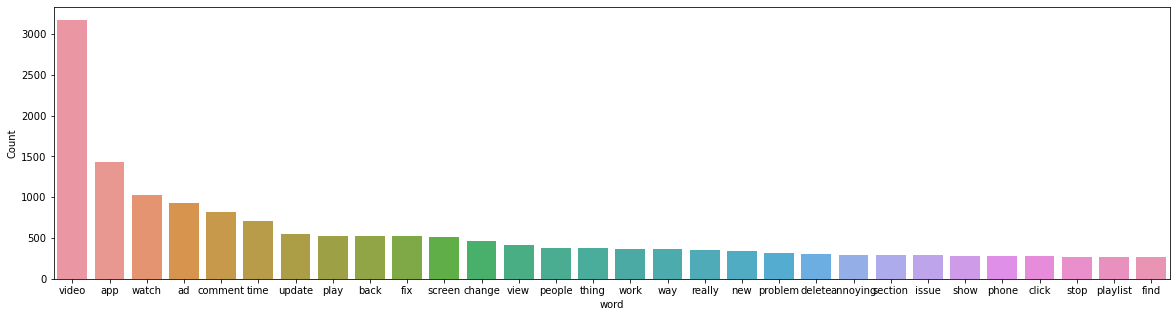

In [102]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready_score1N2N3))


In [103]:
# Create Dictionary
id2word_us_score1N2N3 = corpora.Dictionary(review_us_ready_score1N2N3)

2021-10-17 01:30:56,608 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 01:30:57,001 [INFO] gensim.corpora.dictionary - built Dictionary(4979 unique tokens: ['ability', 'able', 'accidentally', 'actually', 'ad']...) from 1504 documents (total 63672 corpus positions)
2021-10-17 01:30:57,003 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(4979 unique tokens: ['ability', 'able', 'accidentally', 'actually', 'ad']...) from 1504 documents (total 63672 corpus positions)", 'datetime': '2021-10-17T01:30:57.003245', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [104]:
# Create Corpus: Term Document Frequency
corpus_us_score1N2N3 = [id2word_us_score1N2N3.doc2bow(text) for text in review_us_ready_score1N2N3]

In [105]:
# Training LDA model
model_list_us_score1N2N3, coherence_values_us_score1N2N3 = compute_coherence_values(dictionary=id2word_us_score1N2N3, corpus=corpus_us_score1N2N3, 
                                                              texts=review_us_ready_score1N2N3, limit=30, start=2, step=5)


2021-10-17 01:30:57,256 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 01:30:57,257 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 01:30:57,261 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 01:30:57,265 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 1504 documents, updating model once every 1000 documents, evaluating perplexity every 1504 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 01:30:57,266 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1000/1504
2021-10-17 01:31:01,217 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:31:01,225 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.040*"video" + 0.022*"app" + 0.018*"comment" + 0.014*"watch" + 0.013*"time" + 0.012*"change" + 0.010*"back" + 0.009*"ad" + 0.009*"update" + 

2021-10-17 01:31:29,877 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #1504/1504
2021-10-17 01:31:31,095 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:31:31,099 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"video" + 0.022*"comment" + 0.013*"app" + 0.013*"change" + 0.009*"people" + 0.008*"update" + 0.008*"section" + 0.007*"back" + 0.007*"time" + 0.006*"watch"
2021-10-17 01:31:31,105 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.059*"video" + 0.026*"ad" + 0.024*"app" + 0.020*"watch" + 0.012*"time" + 0.011*"play" + 0.009*"screen" + 0.008*"fix" + 0.007*"update" + 0.007*"view"
2021-10-17 01:31:31,108 [INFO] gensim.models.ldamodel - topic diff=0.244926, rho=0.392112
2021-10-17 01:31:31,110 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #1000/1504
2021-10-17 01:31:34,091 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 0

2021-10-17 01:31:54,851 [INFO] gensim.models.ldamodel - topic diff=0.176188, rho=0.294833
2021-10-17 01:31:56,212 [INFO] gensim.models.ldamodel - -6.944 per-word bound, 123.1 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:31:56,213 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #1504/1504
2021-10-17 01:31:57,225 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:31:57,228 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.026*"comment" + 0.019*"video" + 0.014*"change" + 0.011*"people" + 0.009*"app" + 0.009*"section" + 0.007*"update" + 0.007*"back" + 0.006*"quality" + 0.006*"content"
2021-10-17 01:31:57,230 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.061*"video" + 0.026*"app" + 0.025*"ad" + 0.020*"watch" + 0.013*"time" + 0.011*"play" + 0.010*"screen" + 0.009*"fix" + 0.008*"update" + 0.007*"playlist"
2021-10-17 01:31:57,231 [INFO] gensim.models.ldamodel - t

2021-10-17 01:32:15,474 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.063*"video" + 0.028*"app" + 0.022*"ad" + 0.021*"watch" + 0.013*"time" + 0.011*"play" + 0.010*"screen" + 0.010*"fix" + 0.009*"update" + 0.008*"back"
2021-10-17 01:32:15,475 [INFO] gensim.models.ldamodel - topic diff=0.140500, rho=0.246153
2021-10-17 01:32:16,647 [INFO] gensim.models.ldamodel - -6.929 per-word bound, 121.8 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:32:16,648 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #1504/1504
2021-10-17 01:32:17,513 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:32:17,516 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.028*"comment" + 0.016*"video" + 0.014*"change" + 0.012*"people" + 0.010*"section" + 0.007*"content" + 0.007*"quality" + 0.007*"app" + 0.006*"channel" + 0.006*"update"
2021-10-17 01:32:17,518 [INFO] gensim.models.ldamodel - t

2021-10-17 01:32:34,740 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:32:34,744 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.032*"comment" + 0.015*"change" + 0.014*"video" + 0.013*"people" + 0.011*"section" + 0.008*"content" + 0.006*"channel" + 0.006*"quality" + 0.006*"way" + 0.006*"back"
2021-10-17 01:32:34,746 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.063*"video" + 0.029*"app" + 0.022*"ad" + 0.021*"watch" + 0.013*"time" + 0.011*"play" + 0.010*"screen" + 0.010*"fix" + 0.009*"update" + 0.008*"back"
2021-10-17 01:32:34,747 [INFO] gensim.models.ldamodel - topic diff=0.119670, rho=0.215645
2021-10-17 01:32:35,839 [INFO] gensim.models.ldamodel - -6.919 per-word bound, 121.0 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:32:35,840 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #1504/1504
2021-10-17 01:32:36,665 [INFO] gensim.models.ldamodel - me

2021-10-17 01:32:51,185 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.063*"video" + 0.028*"app" + 0.024*"ad" + 0.020*"watch" + 0.013*"time" + 0.011*"play" + 0.010*"fix" + 0.010*"screen" + 0.010*"update" + 0.008*"back"
2021-10-17 01:32:51,191 [INFO] gensim.models.ldamodel - topic diff=0.106798, rho=0.198014
2021-10-17 01:32:51,199 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #1000/1504
2021-10-17 01:32:52,868 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:32:52,872 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.032*"comment" + 0.014*"change" + 0.014*"people" + 0.012*"video" + 0.011*"section" + 0.008*"content" + 0.006*"channel" + 0.006*"quality" + 0.006*"thing" + 0.006*"way"
2021-10-17 01:32:52,874 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.063*"video" + 0.029*"app" + 0.022*"ad" + 0.021*"watch" + 0.013*"time" + 0.011*"play" + 0.010*"screen" + 0.010*"fix" + 0.010*"update" + 0.008*"back"

2021-10-17 01:33:08,115 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:33:08,120 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"comment" + 0.014*"people" + 0.013*"change" + 0.011*"video" + 0.010*"section" + 0.008*"content" + 0.007*"quality" + 0.007*"channel" + 0.006*"platform" + 0.006*"thing"
2021-10-17 01:33:08,122 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.063*"video" + 0.028*"app" + 0.023*"ad" + 0.020*"watch" + 0.013*"time" + 0.011*"play" + 0.010*"fix" + 0.010*"screen" + 0.010*"update" + 0.008*"back"
2021-10-17 01:33:08,125 [INFO] gensim.models.ldamodel - topic diff=0.096514, rho=0.181060
2021-10-17 01:33:08,129 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #1000/1504
2021-10-17 01:33:09,621 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:33:09,624 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.033*"comment" + 0.01

2021-10-17 01:33:22,884 [INFO] gensim.models.ldamodel - topic diff=0.088969, rho=0.167827
2021-10-17 01:33:23,977 [INFO] gensim.models.ldamodel - -6.904 per-word bound, 119.8 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:33:23,979 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #1504/1504
2021-10-17 01:33:24,716 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:33:24,719 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.031*"comment" + 0.015*"people" + 0.012*"change" + 0.011*"section" + 0.011*"video" + 0.009*"content" + 0.007*"quality" + 0.007*"channel" + 0.006*"platform" + 0.006*"thing"
2021-10-17 01:33:24,721 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.063*"video" + 0.029*"app" + 0.023*"ad" + 0.020*"watch" + 0.013*"time" + 0.011*"play" + 0.010*"fix" + 0.010*"update" + 0.010*"screen" + 0.008*"back"
2021-10-17 01:33:24,723 [INFO] gensim.models.ldamodel

2021-10-17 01:33:39,098 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.063*"video" + 0.029*"app" + 0.022*"ad" + 0.020*"watch" + 0.013*"time" + 0.011*"play" + 0.011*"fix" + 0.010*"update" + 0.010*"screen" + 0.009*"back"
2021-10-17 01:33:39,099 [INFO] gensim.models.ldamodel - topic diff=0.082503, rho=0.157127
2021-10-17 01:33:40,087 [INFO] gensim.models.ldamodel - -6.901 per-word bound, 119.5 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:33:40,088 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #1504/1504
2021-10-17 01:33:40,765 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:33:40,768 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.031*"comment" + 0.015*"people" + 0.012*"change" + 0.011*"section" + 0.010*"video" + 0.009*"content" + 0.007*"quality" + 0.007*"channel" + 0.007*"platform" + 0.006*"thing"
2021-10-17 01:33:40,771 [INFO] gensim.models.ldamodel

2021-10-17 01:33:54,114 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:33:54,117 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.033*"comment" + 0.015*"people" + 0.012*"change" + 0.012*"section" + 0.010*"video" + 0.009*"content" + 0.007*"channel" + 0.007*"quality" + 0.006*"platform" + 0.006*"thing"
2021-10-17 01:33:54,118 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.063*"video" + 0.029*"app" + 0.022*"ad" + 0.020*"watch" + 0.013*"time" + 0.011*"play" + 0.011*"update" + 0.011*"fix" + 0.010*"screen" + 0.009*"back"
2021-10-17 01:33:54,120 [INFO] gensim.models.ldamodel - topic diff=0.077256, rho=0.148243
2021-10-17 01:33:55,041 [INFO] gensim.models.ldamodel - -6.899 per-word bound, 119.3 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:33:55,042 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #1504/1504
2021-10-17 01:33:55,761 [INFO] gensim.models.ldamode

2021-10-17 01:34:08,731 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.063*"video" + 0.029*"app" + 0.023*"ad" + 0.020*"watch" + 0.013*"time" + 0.011*"play" + 0.011*"update" + 0.010*"fix" + 0.010*"screen" + 0.009*"back"
2021-10-17 01:34:08,732 [INFO] gensim.models.ldamodel - topic diff=0.073156, rho=0.142128
2021-10-17 01:34:08,733 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #1000/1504
2021-10-17 01:34:10,107 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:34:10,110 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.033*"comment" + 0.016*"people" + 0.012*"section" + 0.011*"change" + 0.009*"video" + 0.009*"content" + 0.007*"quality" + 0.007*"channel" + 0.007*"platform" + 0.006*"thing"
2021-10-17 01:34:10,111 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.063*"video" + 0.029*"app" + 0.022*"ad" + 0.020*"watch" + 0.013*"time" + 0.011*"play" + 0.011*"update" + 0.011*"fix" + 0.010*"screen" + 0.009*"

2021-10-17 01:34:25,986 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #1000/1504
2021-10-17 01:34:28,301 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:34:28,308 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.016*"video" + 0.016*"people" + 0.015*"search" + 0.012*"change" + 0.010*"time" + 0.010*"watch" + 0.009*"app" + 0.009*"let" + 0.007*"wait" + 0.006*"content"
2021-10-17 01:34:28,309 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.069*"video" + 0.027*"app" + 0.020*"watch" + 0.013*"screen" + 0.012*"view" + 0.011*"time" + 0.011*"play" + 0.010*"fix" + 0.010*"delete" + 0.009*"update"
2021-10-17 01:34:28,312 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.057*"ad" + 0.041*"video" + 0.024*"app" + 0.017*"watch" + 0.013*"time" + 0.013*"play" + 0.011*"comment" + 0.010*"thing" + 0.007*"back" + 0.006*"minute"
2021-10-17 01:34:28,315 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.037*"comment" + 0.

2021-10-17 01:34:39,489 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.055*"playlist" + 0.032*"video" + 0.018*"add" + 0.016*"save" + 0.011*"caption" + 0.008*"app" + 0.008*"back" + 0.008*"watch" + 0.008*"pay" + 0.008*"subscription"
2021-10-17 01:34:39,491 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.019*"channel" + 0.019*"people" + 0.014*"platform" + 0.012*"content" + 0.009*"creator" + 0.008*"song" + 0.008*"truth" + 0.008*"allow" + 0.008*"opinion" + 0.007*"censor"
2021-10-17 01:34:39,492 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.022*"people" + 0.013*"wait" + 0.012*"let" + 0.012*"search" + 0.010*"platform" + 0.009*"tube" + 0.008*"freedom" + 0.007*"content" + 0.007*"speech" + 0.007*"well"
2021-10-17 01:34:39,494 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.072*"video" + 0.030*"app" + 0.023*"watch" + 0.014*"time" + 0.014*"screen" + 0.013*"play" + 0.011*"fix" + 0.010*"view" + 0.010*"update" + 0.009*"delete"
2021-10-17 01:34:39,495 [INFO] gensim.models.ldamodel -

2021-10-17 01:34:49,290 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.073*"video" + 0.032*"app" + 0.025*"watch" + 0.016*"screen" + 0.015*"time" + 0.014*"play" + 0.013*"fix" + 0.012*"view" + 0.010*"work" + 0.010*"update"
2021-10-17 01:34:49,293 [INFO] gensim.models.ldamodel - topic diff=0.174702, rho=0.342916
2021-10-17 01:34:50,458 [INFO] gensim.models.ldamodel - -6.996 per-word bound, 127.7 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:34:50,461 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #1504/1504
2021-10-17 01:34:51,196 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:34:51,202 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.098*"ad" + 0.035*"video" + 0.017*"app" + 0.017*"watch" + 0.012*"minute" + 0.010*"time" + 0.009*"thing" + 0.008*"premium" + 0.008*"second" + 0.008*"stop"
2021-10-17 01:34:51,204 [INFO] gensim.models.ldamodel - topic #1 (0.14

2021-10-17 01:34:58,439 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #1000/1504
2021-10-17 01:35:00,236 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:35:00,241 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.043*"video" + 0.025*"change" + 0.024*"app" + 0.016*"update" + 0.012*"quality" + 0.012*"option" + 0.011*"watch" + 0.010*"time" + 0.009*"fix" + 0.009*"button"
2021-10-17 01:35:00,243 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.069*"playlist" + 0.025*"video" + 0.023*"add" + 0.018*"save" + 0.010*"caption" + 0.009*"pay" + 0.008*"subscription" + 0.008*"check" + 0.007*"back" + 0.006*"button"
2021-10-17 01:35:00,246 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.024*"people" + 0.012*"wait" + 0.011*"let" + 0.010*"search" + 0.010*"freedom" + 0.008*"tube" + 0.008*"speech" + 0.008*"well" + 0.007*"content" + 0.007*"platform"
2021-10-17 01:35:00,248 [INFO] gensim.models.ldamodel - topic #4 (0.143

2021-10-17 01:35:09,326 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.102*"ad" + 0.035*"video" + 0.018*"watch" + 0.016*"app" + 0.012*"minute" + 0.009*"time" + 0.009*"premium" + 0.008*"thing" + 0.008*"second" + 0.008*"pay"
2021-10-17 01:35:09,331 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.079*"comment" + 0.030*"video" + 0.027*"section" + 0.015*"scroll" + 0.015*"back" + 0.012*"move" + 0.012*"change" + 0.012*"look" + 0.011*"new" + 0.011*"thing"
2021-10-17 01:35:09,334 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.043*"video" + 0.025*"change" + 0.024*"app" + 0.016*"update" + 0.014*"quality" + 0.012*"option" + 0.011*"watch" + 0.009*"button" + 0.009*"time" + 0.008*"fix"
2021-10-17 01:35:09,337 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.076*"playlist" + 0.023*"video" + 0.023*"add" + 0.020*"save" + 0.013*"caption" + 0.010*"pay" + 0.008*"check" + 0.008*"subscription" + 0.006*"queue" + 0.006*"button"
2021-10-17 01:35:09,339 [INFO] gensim.models.ldamodel - topic diff

2021-10-17 01:35:17,685 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.075*"video" + 0.034*"app" + 0.025*"watch" + 0.016*"time" + 0.016*"screen" + 0.015*"play" + 0.014*"fix" + 0.012*"view" + 0.011*"work" + 0.010*"update"
2021-10-17 01:35:17,689 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.077*"playlist" + 0.024*"add" + 0.021*"video" + 0.019*"save" + 0.011*"caption" + 0.010*"pay" + 0.008*"subscription" + 0.008*"check" + 0.006*"button" + 0.006*"queue"
2021-10-17 01:35:17,695 [INFO] gensim.models.ldamodel - topic diff=0.105756, rho=0.246153
2021-10-17 01:35:18,733 [INFO] gensim.models.ldamodel - -6.947 per-word bound, 123.4 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:35:18,734 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #1504/1504
2021-10-17 01:35:19,434 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:35:19,441 [INFO] gensim.models.ldamodel - to

2021-10-17 01:35:26,158 [INFO] gensim.models.ldamodel - topic diff=0.096611, rho=0.232470
2021-10-17 01:35:26,160 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #1000/1504
2021-10-17 01:35:27,531 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:35:27,536 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.023*"people" + 0.013*"wait" + 0.011*"freedom" + 0.010*"let" + 0.010*"search" + 0.008*"well" + 0.007*"speech" + 0.007*"content" + 0.006*"tube" + 0.006*"world"
2021-10-17 01:35:27,538 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.041*"video" + 0.026*"change" + 0.023*"app" + 0.016*"update" + 0.013*"quality" + 0.013*"option" + 0.010*"watch" + 0.009*"button" + 0.009*"feature" + 0.008*"time"
2021-10-17 01:35:27,540 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.024*"people" + 0.018*"content" + 0.017*"channel" + 0.017*"platform" + 0.009*"creator" + 0.009*"tube" + 0.009*"allow" + 0.008*"let" + 0.007*"po

2021-10-17 01:35:35,865 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.086*"playlist" + 0.024*"add" + 0.021*"save" + 0.019*"video" + 0.013*"caption" + 0.010*"pay" + 0.009*"check" + 0.008*"subscription" + 0.007*"queue" + 0.006*"long"
2021-10-17 01:35:35,867 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.104*"ad" + 0.035*"video" + 0.019*"watch" + 0.016*"app" + 0.012*"minute" + 0.009*"premium" + 0.009*"time" + 0.008*"pay" + 0.008*"thing" + 0.008*"skip"
2021-10-17 01:35:35,868 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.023*"people" + 0.015*"wait" + 0.011*"freedom" + 0.010*"let" + 0.010*"search" + 0.008*"well" + 0.007*"speech" + 0.007*"content" + 0.006*"tube" + 0.006*"world"
2021-10-17 01:35:35,869 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.081*"comment" + 0.031*"video" + 0.028*"section" + 0.016*"back" + 0.015*"scroll" + 0.014*"change" + 0.013*"move" + 0.012*"look" + 0.011*"new" + 0.011*"thing"
2021-10-17 01:35:35,871 [INFO] gensim.models.ldamodel - topic #1 (0.1

2021-10-17 01:35:43,788 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.025*"people" + 0.018*"content" + 0.017*"channel" + 0.017*"platform" + 0.009*"creator" + 0.009*"tube" + 0.009*"let" + 0.008*"allow" + 0.007*"view" + 0.007*"political"
2021-10-17 01:35:43,794 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.075*"video" + 0.034*"app" + 0.025*"watch" + 0.017*"time" + 0.016*"screen" + 0.015*"play" + 0.014*"fix" + 0.011*"view" + 0.011*"update" + 0.011*"work"
2021-10-17 01:35:43,800 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.084*"comment" + 0.031*"video" + 0.029*"section" + 0.017*"back" + 0.016*"scroll" + 0.015*"change" + 0.013*"move" + 0.012*"look" + 0.012*"new" + 0.011*"way"
2021-10-17 01:35:43,807 [INFO] gensim.models.ldamodel - topic diff=0.082354, rho=0.202014
2021-10-17 01:35:44,849 [INFO] gensim.models.ldamodel - -6.933 per-word bound, 122.2 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:35:44,850 [INFO] gensim.models.

2021-10-17 01:35:51,989 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.089*"playlist" + 0.024*"add" + 0.021*"save" + 0.017*"video" + 0.013*"caption" + 0.010*"pay" + 0.009*"check" + 0.008*"subscription" + 0.007*"queue" + 0.007*"long"
2021-10-17 01:35:51,990 [INFO] gensim.models.ldamodel - topic diff=0.077386, rho=0.194243
2021-10-17 01:35:51,991 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #1000/1504
2021-10-17 01:35:53,486 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:35:53,492 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.103*"ad" + 0.034*"video" + 0.019*"watch" + 0.016*"app" + 0.012*"minute" + 0.009*"premium" + 0.009*"time" + 0.009*"pay" + 0.008*"thing" + 0.008*"skip"
2021-10-17 01:35:53,493 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.087*"playlist" + 0.025*"add" + 0.020*"save" + 0.016*"video" + 0.012*"caption" + 0.010*"pay" + 0.009*"check" + 0.008*"subscription" + 0.006*"long" + 0

2021-10-17 01:36:00,867 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #1504/1504
2021-10-17 01:36:01,624 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:36:01,630 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.025*"people" + 0.018*"content" + 0.017*"platform" + 0.017*"channel" + 0.009*"tube" + 0.009*"let" + 0.009*"creator" + 0.008*"allow" + 0.007*"view" + 0.007*"censor"
2021-10-17 01:36:01,632 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.090*"playlist" + 0.025*"add" + 0.021*"save" + 0.016*"video" + 0.013*"caption" + 0.010*"pay" + 0.009*"check" + 0.008*"subscription" + 0.007*"queue" + 0.007*"long"
2021-10-17 01:36:01,634 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.082*"comment" + 0.031*"video" + 0.028*"section" + 0.016*"back" + 0.015*"scroll" + 0.014*"change" + 0.014*"move" + 0.012*"look" + 0.011*"new" + 0.011*"thing"
2021-10-17 01:36:01,636 [INFO] gensim.models.ldamodel - topic #1 (0.14

2021-10-17 01:36:09,213 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.084*"comment" + 0.031*"video" + 0.029*"section" + 0.017*"back" + 0.016*"scroll" + 0.015*"change" + 0.014*"move" + 0.012*"look" + 0.012*"new" + 0.011*"way"
2021-10-17 01:36:09,215 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.025*"people" + 0.018*"content" + 0.017*"platform" + 0.017*"channel" + 0.009*"tube" + 0.009*"creator" + 0.009*"let" + 0.008*"allow" + 0.008*"view" + 0.007*"political"
2021-10-17 01:36:09,217 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.022*"people" + 0.014*"wait" + 0.011*"freedom" + 0.010*"search" + 0.009*"let" + 0.007*"well" + 0.006*"content" + 0.006*"speech" + 0.006*"name" + 0.006*"man"
2021-10-17 01:36:09,219 [INFO] gensim.models.ldamodel - topic diff=0.069542, rho=0.175401
2021-10-17 01:36:10,203 [INFO] gensim.models.ldamodel - -6.925 per-word bound, 121.6 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:36:10,205 [INFO] gensim.m

2021-10-17 01:36:17,363 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.022*"people" + 0.015*"wait" + 0.012*"freedom" + 0.010*"search" + 0.009*"let" + 0.007*"well" + 0.006*"content" + 0.006*"speech" + 0.006*"man" + 0.006*"name"
2021-10-17 01:36:17,364 [INFO] gensim.models.ldamodel - topic diff=0.066404, rho=0.170241
2021-10-17 01:36:17,365 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #1000/1504
2021-10-17 01:36:18,768 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:36:18,773 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.021*"people" + 0.014*"wait" + 0.011*"freedom" + 0.011*"search" + 0.009*"let" + 0.007*"well" + 0.006*"content" + 0.006*"name" + 0.006*"speech" + 0.006*"man"
2021-10-17 01:36:18,774 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.039*"video" + 0.027*"change" + 0.023*"app" + 0.016*"update" + 0.014*"quality" + 0.013*"option" + 0.010*"watch" + 0.009*"feature" + 0.009*"button" + 0

2021-10-17 01:36:26,112 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #1504/1504
2021-10-17 01:36:26,864 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:36:26,869 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.104*"ad" + 0.035*"video" + 0.019*"watch" + 0.015*"app" + 0.012*"minute" + 0.010*"premium" + 0.009*"time" + 0.009*"pay" + 0.008*"thing" + 0.008*"skip"
2021-10-17 01:36:26,870 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.076*"video" + 0.034*"app" + 0.024*"watch" + 0.017*"time" + 0.016*"screen" + 0.015*"play" + 0.014*"fix" + 0.011*"update" + 0.010*"work" + 0.010*"view"
2021-10-17 01:36:26,871 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.093*"playlist" + 0.025*"add" + 0.022*"save" + 0.014*"video" + 0.014*"caption" + 0.010*"pay" + 0.009*"check" + 0.008*"subscription" + 0.007*"queue" + 0.007*"long"
2021-10-17 01:36:26,873 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.039*"video" + 

2021-10-17 01:36:34,355 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.026*"people" + 0.019*"content" + 0.017*"platform" + 0.017*"channel" + 0.009*"tube" + 0.009*"creator" + 0.009*"let" + 0.008*"allow" + 0.008*"view" + 0.007*"delete"
2021-10-17 01:36:34,357 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.103*"ad" + 0.034*"video" + 0.019*"watch" + 0.015*"app" + 0.012*"minute" + 0.010*"premium" + 0.009*"pay" + 0.009*"time" + 0.008*"thing" + 0.008*"skip"
2021-10-17 01:36:34,359 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.092*"playlist" + 0.025*"add" + 0.021*"save" + 0.014*"video" + 0.013*"caption" + 0.010*"pay" + 0.008*"check" + 0.008*"subscription" + 0.007*"long" + 0.007*"queue"
2021-10-17 01:36:34,360 [INFO] gensim.models.ldamodel - topic diff=0.061398, rho=0.157127
2021-10-17 01:36:35,348 [INFO] gensim.models.ldamodel - -6.922 per-word bound, 121.2 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:36:35,349 [INFO] gensim.mod

2021-10-17 01:36:43,110 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.094*"playlist" + 0.025*"add" + 0.022*"save" + 0.014*"caption" + 0.014*"video" + 0.010*"pay" + 0.009*"check" + 0.007*"subscription" + 0.007*"queue" + 0.007*"long"
2021-10-17 01:36:43,112 [INFO] gensim.models.ldamodel - topic diff=0.059116, rho=0.153386
2021-10-17 01:36:43,113 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #1000/1504
2021-10-17 01:36:44,492 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:36:44,506 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.026*"people" + 0.019*"content" + 0.017*"platform" + 0.017*"channel" + 0.009*"tube" + 0.009*"creator" + 0.009*"let" + 0.008*"allow" + 0.008*"view" + 0.007*"delete"
2021-10-17 01:36:44,510 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.103*"ad" + 0.034*"video" + 0.019*"watch" + 0.015*"app" + 0.012*"minute" + 0.010*"premium" + 0.009*"pay" + 0.009*"time" + 0.008*"thing" +

2021-10-17 01:36:52,398 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:36:52,428 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.103*"ad" + 0.035*"video" + 0.019*"watch" + 0.015*"app" + 0.012*"minute" + 0.010*"premium" + 0.009*"pay" + 0.009*"time" + 0.008*"thing" + 0.008*"bad"
2021-10-17 01:36:52,435 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.083*"comment" + 0.032*"video" + 0.028*"section" + 0.017*"back" + 0.015*"change" + 0.015*"scroll" + 0.014*"move" + 0.012*"look" + 0.012*"new" + 0.011*"thing"
2021-10-17 01:36:52,441 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.039*"video" + 0.026*"change" + 0.023*"app" + 0.016*"quality" + 0.015*"update" + 0.014*"option" + 0.010*"watch" + 0.009*"feature" + 0.009*"button" + 0.009*"high"
2021-10-17 01:36:52,450 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.021*"people" + 0.015*"wait" + 0.012*"freedom" + 0.011*"search" + 0.009*"let" + 0.007*"well" + 0.006*"man" +

2021-10-17 01:36:59,980 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.020*"people" + 0.014*"wait" + 0.012*"freedom" + 0.011*"search" + 0.009*"let" + 0.007*"well" + 0.006*"name" + 0.006*"man" + 0.006*"life" + 0.005*"content"
2021-10-17 01:36:59,981 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.038*"video" + 0.027*"change" + 0.023*"app" + 0.015*"update" + 0.015*"quality" + 0.014*"option" + 0.010*"watch" + 0.009*"feature" + 0.009*"button" + 0.008*"high"
2021-10-17 01:36:59,982 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.076*"video" + 0.034*"app" + 0.025*"watch" + 0.017*"time" + 0.016*"screen" + 0.015*"play" + 0.014*"fix" + 0.011*"view" + 0.011*"update" + 0.010*"work"
2021-10-17 01:36:59,983 [INFO] gensim.models.ldamodel - topic diff=0.055363, rho=0.143586
2021-10-17 01:37:01,021 [INFO] gensim.models.ldamodel - -6.919 per-word bound, 121.0 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:37:01,023 [INFO] gensim.models.ldamod

2021-10-17 01:37:07,877 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.026*"people" + 0.018*"content" + 0.018*"platform" + 0.017*"channel" + 0.010*"tube" + 0.009*"let" + 0.009*"creator" + 0.008*"allow" + 0.008*"view" + 0.007*"account"
2021-10-17 01:37:07,878 [INFO] gensim.models.ldamodel - topic diff=0.053761, rho=0.140714
2021-10-17 01:37:07,880 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #1000/1504
2021-10-17 01:37:09,236 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:37:09,241 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.026*"people" + 0.019*"content" + 0.017*"platform" + 0.017*"channel" + 0.009*"tube" + 0.009*"let" + 0.009*"creator" + 0.009*"view" + 0.008*"allow" + 0.007*"delete"
2021-10-17 01:37:09,243 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.020*"people" + 0.014*"wait" + 0.012*"freedom" + 0.011*"search" + 0.009*"let" + 0.007*"well" + 0.006*"name" + 0.006*"man" + 0.006*"life

2021-10-17 01:37:25,739 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.027*"video" + 0.014*"playlist" + 0.013*"back" + 0.012*"add" + 0.010*"watch" + 0.010*"caption" + 0.009*"check" + 0.009*"app" + 0.008*"tab" + 0.008*"comment"
2021-10-17 01:37:25,741 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.038*"video" + 0.018*"app" + 0.010*"fix" + 0.009*"still" + 0.009*"play" + 0.009*"view" + 0.008*"update" + 0.008*"people" + 0.007*"back" + 0.007*"time"
2021-10-17 01:37:25,746 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.024*"video" + 0.015*"app" + 0.012*"view" + 0.011*"page" + 0.011*"comment" + 0.010*"back" + 0.010*"screen" + 0.009*"watch" + 0.009*"hard" + 0.009*"thing"
2021-10-17 01:37:25,748 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.101*"comment" + 0.036*"section" + 0.034*"video" + 0.015*"app" + 0.014*"click" + 0.014*"scroll" + 0.011*"way" + 0.011*"back" + 0.009*"put" + 0.008*"move"
2021-10-17 01:37:25,750 [INFO] gensim.models.ldamodel - topic diff=0.448579, rho=0.

2021-10-17 01:37:39,736 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.044*"caption" + 0.025*"add" + 0.018*"check" + 0.016*"video" + 0.015*"season" + 0.011*"notification" + 0.011*"measure" + 0.010*"playlist" + 0.010*"upload" + 0.009*"back"
2021-10-17 01:37:39,738 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.020*"video" + 0.019*"app" + 0.016*"play" + 0.013*"thing" + 0.013*"tube" + 0.011*"shuffle" + 0.010*"song" + 0.010*"time" + 0.009*"ad" + 0.007*"keep"
2021-10-17 01:37:39,740 [INFO] gensim.models.ldamodel - topic diff=0.251610, rho=0.426246
2021-10-17 01:37:39,742 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #1000/1504
2021-10-17 01:37:42,262 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:37:42,270 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.031*"caption" + 0.021*"add" + 0.014*"check" + 0.012*"video" + 0.012*"filter" + 0.010*"notification" + 0.010*"back" + 0.010*"season" + 0.008*"uplo

2021-10-17 01:37:51,122 [INFO] gensim.models.ldamodel - topic diff=0.145239, rho=0.342916
2021-10-17 01:37:52,385 [INFO] gensim.models.ldamodel - -7.541 per-word bound, 186.2 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:37:52,388 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #1504/1504
2021-10-17 01:37:53,610 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:37:53,617 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.025*"app" + 0.022*"video" + 0.010*"content" + 0.010*"premium" + 0.009*"time" + 0.008*"option" + 0.007*"download" + 0.007*"kid" + 0.007*"well" + 0.007*"find"
2021-10-17 01:37:53,619 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.037*"view" + 0.020*"delete" + 0.019*"hard" + 0.016*"guy" + 0.014*"page" + 0.012*"much" + 0.012*"work" + 0.012*"really" + 0.012*"home" + 0.012*"army"
2021-10-17 01:37:53,620 [INFO] gensim.models.ldamodel - topic #9 (0

2021-10-17 01:38:04,983 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.129*"comment" + 0.043*"section" + 0.030*"video" + 0.022*"scroll" + 0.021*"back" + 0.019*"move" + 0.016*"change" + 0.014*"click" + 0.014*"way" + 0.013*"top"
2021-10-17 01:38:04,984 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.047*"caption" + 0.018*"add" + 0.017*"check" + 0.013*"filter" + 0.012*"season" + 0.010*"register" + 0.009*"upload" + 0.009*"measure" + 0.008*"notification" + 0.007*"podcast"
2021-10-17 01:38:04,985 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.043*"change" + 0.029*"video" + 0.022*"quality" + 0.019*"update" + 0.019*"app" + 0.011*"resolution" + 0.011*"high" + 0.011*"really" + 0.010*"option" + 0.009*"time"
2021-10-17 01:38:04,987 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.022*"song" + 0.015*"shuffle" + 0.014*"thing" + 0.014*"app" + 0.014*"play" + 0.014*"tube" + 0.009*"video" + 0.008*"bad" + 0.007*"time" + 0.007*"second"
2021-10-17 01:38:04,988 [INFO] gensim.models.ldamode

2021-10-17 01:38:14,636 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.035*"channel" + 0.034*"people" + 0.018*"commercial" + 0.017*"content" + 0.016*"let" + 0.015*"platform" + 0.014*"creator" + 0.013*"allow" + 0.012*"ban" + 0.012*"side"
2021-10-17 01:38:14,642 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.020*"app" + 0.016*"video" + 0.011*"content" + 0.010*"premium" + 0.008*"time" + 0.008*"find" + 0.008*"option" + 0.008*"well" + 0.007*"browser" + 0.007*"kid"
2021-10-17 01:38:14,647 [INFO] gensim.models.ldamodel - topic diff=0.099075, rho=0.272125
2021-10-17 01:38:14,655 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #1000/1504
2021-10-17 01:38:16,099 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:38:16,107 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.032*"song" + 0.015*"shuffle" + 0.014*"tube" + 0.014*"thing" + 0.013*"play" + 0.012*"app" + 0.008*"bad" + 0.006*"keep" + 0.006*"video" + 0.0

2021-10-17 01:38:24,115 [INFO] gensim.models.ldamodel - -7.274 per-word bound, 154.8 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:38:24,118 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #1504/1504
2021-10-17 01:38:24,858 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:38:24,865 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.064*"caption" + 0.019*"check" + 0.016*"season" + 0.015*"add" + 0.012*"upload" + 0.012*"wake" + 0.011*"measure" + 0.011*"filter" + 0.010*"fall" + 0.009*"podcast"
2021-10-17 01:38:24,867 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.019*"app" + 0.014*"video" + 0.012*"content" + 0.010*"premium" + 0.008*"time" + 0.008*"find" + 0.008*"well" + 0.008*"browser" + 0.007*"kid" + 0.007*"user"
2021-10-17 01:38:24,869 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.041*"change" + 0.029*"video" + 0.028*"quality" + 0.020*"update" + 0.017

2021-10-17 01:38:32,854 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.015*"people" + 0.015*"platform" + 0.011*"reason" + 0.010*"pay" + 0.009*"support" + 0.009*"way" + 0.009*"remove" + 0.008*"content" + 0.008*"tell" + 0.008*"world"
2021-10-17 01:38:32,856 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.040*"song" + 0.016*"shuffle" + 0.014*"tube" + 0.013*"thing" + 0.012*"play" + 0.009*"app" + 0.008*"bad" + 0.006*"favorite" + 0.006*"listen" + 0.006*"keep"
2021-10-17 01:38:32,858 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.126*"ad" + 0.052*"video" + 0.032*"watch" + 0.013*"minute" + 0.012*"second" + 0.011*"time" + 0.011*"app" + 0.008*"skip" + 0.007*"bad" + 0.007*"long"
2021-10-17 01:38:32,859 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.033*"channel" + 0.033*"people" + 0.018*"content" + 0.017*"commercial" + 0.015*"creator" + 0.014*"let" + 0.014*"platform" + 0.014*"allow" + 0.012*"side" + 0.011*"claim"
2021-10-17 01:38:32,860 [INFO] gensim.models.ldamodel - topic dif

2021-10-17 01:38:41,144 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.074*"video" + 0.027*"playlist" + 0.022*"watch" + 0.019*"app" + 0.017*"search" + 0.014*"new" + 0.012*"page" + 0.011*"button" + 0.011*"add" + 0.010*"update"
2021-10-17 01:38:41,146 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.063*"caption" + 0.019*"check" + 0.015*"season" + 0.015*"wake" + 0.013*"add" + 0.013*"upload" + 0.011*"measure" + 0.011*"fall" + 0.010*"filter" + 0.009*"podcast"
2021-10-17 01:38:41,148 [INFO] gensim.models.ldamodel - topic diff=0.068188, rho=0.215645
2021-10-17 01:38:41,151 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #1000/1504
2021-10-17 01:38:42,478 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:38:42,490 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.043*"change" + 0.027*"video" + 0.027*"quality" + 0.020*"update" + 0.016*"app" + 0.014*"high" + 0.013*"resolution" + 0.011*"option" + 0.011*"choo

2021-10-17 01:38:50,744 [INFO] gensim.models.ldamodel - -7.198 per-word bound, 146.9 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:38:50,745 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #1504/1504
2021-10-17 01:38:51,461 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:38:51,471 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.034*"channel" + 0.034*"people" + 0.017*"content" + 0.016*"commercial" + 0.015*"let" + 0.014*"platform" + 0.014*"creator" + 0.014*"allow" + 0.013*"side" + 0.010*"claim"
2021-10-17 01:38:51,472 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.041*"change" + 0.030*"quality" + 0.028*"video" + 0.020*"update" + 0.016*"high" + 0.016*"app" + 0.015*"resolution" + 0.012*"option" + 0.012*"choose" + 0.011*"set"
2021-10-17 01:38:51,474 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.020*"name" + 0.013*"biased" + 0.012*"minor" + 0.011*"sea

2021-10-17 01:38:59,293 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.043*"change" + 0.028*"quality" + 0.027*"video" + 0.020*"update" + 0.015*"app" + 0.014*"high" + 0.013*"resolution" + 0.012*"option" + 0.011*"choose" + 0.010*"set"
2021-10-17 01:38:59,296 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.033*"channel" + 0.033*"people" + 0.017*"content" + 0.016*"commercial" + 0.014*"creator" + 0.014*"let" + 0.014*"allow" + 0.014*"platform" + 0.012*"side" + 0.011*"claim"
2021-10-17 01:38:59,302 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.021*"name" + 0.012*"minor" + 0.012*"biased" + 0.012*"search" + 0.011*"fact" + 0.009*"front" + 0.008*"life" + 0.008*"affect" + 0.007*"check" + 0.007*"people"
2021-10-17 01:38:59,305 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.083*"video" + 0.048*"app" + 0.026*"watch" + 0.022*"screen" + 0.021*"play" + 0.019*"time" + 0.018*"fix" + 0.014*"update" + 0.012*"phone" + 0.012*"problem"
2021-10-17 01:38:59,308 [INFO] gensim.models.ldamodel -

2021-10-17 01:39:07,305 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.015*"platform" + 0.015*"people" + 0.011*"reason" + 0.010*"support" + 0.010*"remove" + 0.009*"way" + 0.009*"tell" + 0.009*"content" + 0.009*"pay" + 0.008*"believe"
2021-10-17 01:39:07,309 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.077*"view" + 0.049*"delete" + 0.023*"hard" + 0.022*"guy" + 0.018*"work" + 0.018*"people" + 0.015*"really" + 0.015*"give" + 0.014*"music" + 0.014*"bot"
2021-10-17 01:39:07,312 [INFO] gensim.models.ldamodel - topic diff=0.053917, rho=0.184102
2021-10-17 01:39:07,317 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #1000/1504
2021-10-17 01:39:08,645 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:39:08,709 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.043*"change" + 0.028*"quality" + 0.026*"video" + 0.020*"update" + 0.015*"app" + 0.014*"high" + 0.014*"resolution" + 0.012*"option" + 0.011*"choose"

2021-10-17 01:39:16,094 [INFO] gensim.models.ldamodel - -7.161 per-word bound, 143.1 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:39:16,096 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #1504/1504
2021-10-17 01:39:16,819 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:39:16,845 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.042*"change" + 0.030*"quality" + 0.027*"video" + 0.020*"update" + 0.016*"high" + 0.015*"resolution" + 0.014*"app" + 0.012*"option" + 0.012*"choose" + 0.011*"set"
2021-10-17 01:39:16,846 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.015*"app" + 0.013*"content" + 0.010*"premium" + 0.009*"video" + 0.008*"user" + 0.008*"find" + 0.008*"browser" + 0.008*"well" + 0.008*"kid" + 0.007*"tv"
2021-10-17 01:39:16,848 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.127*"ad" + 0.052*"video" + 0.030*"watch" + 0.013*"minute" + 0.012*"secon

2021-10-17 01:39:24,747 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.046*"song" + 0.017*"shuffle" + 0.015*"tube" + 0.013*"thing" + 0.011*"play" + 0.007*"app" + 0.007*"bad" + 0.007*"pay" + 0.007*"favorite" + 0.007*"listen"
2021-10-17 01:39:24,748 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.033*"channel" + 0.033*"people" + 0.017*"content" + 0.016*"commercial" + 0.014*"creator" + 0.014*"allow" + 0.014*"platform" + 0.014*"let" + 0.012*"side" + 0.011*"claim"
2021-10-17 01:39:24,750 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.015*"app" + 0.013*"content" + 0.010*"premium" + 0.009*"video" + 0.008*"user" + 0.008*"kid" + 0.008*"find" + 0.007*"browser" + 0.007*"well" + 0.007*"time"
2021-10-17 01:39:24,752 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.021*"name" + 0.013*"minor" + 0.012*"biased" + 0.012*"search" + 0.011*"fact" + 0.009*"front" + 0.008*"life" + 0.008*"affect" + 0.008*"check" + 0.007*"classic"
2021-10-17 01:39:24,755 [INFO] gensim.models.ldamodel - topic d

2021-10-17 01:39:33,296 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.014*"app" + 0.013*"content" + 0.010*"premium" + 0.009*"user" + 0.009*"video" + 0.008*"find" + 0.008*"kid" + 0.008*"browser" + 0.008*"tv" + 0.008*"well"
2021-10-17 01:39:33,298 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.020*"name" + 0.013*"biased" + 0.012*"minor" + 0.012*"search" + 0.011*"fact" + 0.009*"life" + 0.009*"front" + 0.008*"affect" + 0.008*"episode" + 0.008*"check"
2021-10-17 01:39:33,299 [INFO] gensim.models.ldamodel - topic diff=0.046025, rho=0.163291
2021-10-17 01:39:33,302 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #1000/1504
2021-10-17 01:39:34,801 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:39:34,812 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.016*"people" + 0.015*"platform" + 0.011*"reason" + 0.010*"support" + 0.010*"way" + 0.009*"remove" + 0.009*"content" + 0.009*"tell" + 0.008*"pay" + 0.00

2021-10-17 01:39:42,512 [INFO] gensim.models.ldamodel - -7.147 per-word bound, 141.7 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:39:42,513 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #1504/1504
2021-10-17 01:39:43,126 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:39:43,134 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.127*"ad" + 0.052*"video" + 0.030*"watch" + 0.013*"minute" + 0.012*"second" + 0.011*"app" + 0.011*"time" + 0.008*"skip" + 0.007*"bad" + 0.007*"long"
2021-10-17 01:39:43,136 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.063*"caption" + 0.018*"check" + 0.016*"wake" + 0.015*"season" + 0.012*"add" + 0.011*"measure" + 0.011*"fall" + 0.010*"auto" + 0.010*"asleep" + 0.010*"filter"
2021-10-17 01:39:43,139 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.014*"app" + 0.013*"content" + 0.010*"premium" + 0.009*"user" + 0.008*"video" + 0

2021-10-17 01:39:51,233 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.021*"name" + 0.013*"minor" + 0.013*"biased" + 0.012*"search" + 0.011*"fact" + 0.009*"front" + 0.008*"life" + 0.008*"affect" + 0.008*"check" + 0.007*"episode"
2021-10-17 01:39:51,236 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.016*"people" + 0.016*"platform" + 0.011*"reason" + 0.010*"support" + 0.010*"way" + 0.009*"remove" + 0.009*"content" + 0.009*"tell" + 0.008*"pay" + 0.008*"world"
2021-10-17 01:39:51,239 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.046*"song" + 0.017*"shuffle" + 0.015*"tube" + 0.012*"thing" + 0.011*"play" + 0.008*"pay" + 0.007*"favorite" + 0.007*"bad" + 0.007*"app" + 0.007*"listen"
2021-10-17 01:39:51,240 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.044*"change" + 0.029*"quality" + 0.026*"video" + 0.020*"update" + 0.015*"high" + 0.014*"resolution" + 0.013*"app" + 0.012*"option" + 0.011*"choose" + 0.011*"set"
2021-10-17 01:39:51,241 [INFO] gensim.models.ldamodel - topic 

2021-10-17 01:40:01,265 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.034*"channel" + 0.034*"people" + 0.017*"content" + 0.016*"commercial" + 0.014*"let" + 0.014*"platform" + 0.014*"allow" + 0.014*"creator" + 0.013*"side" + 0.010*"claim"
2021-10-17 01:40:01,268 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.063*"caption" + 0.018*"check" + 0.016*"wake" + 0.015*"season" + 0.012*"add" + 0.011*"measure" + 0.011*"fall" + 0.010*"auto" + 0.010*"filter" + 0.010*"asleep"
2021-10-17 01:40:01,276 [INFO] gensim.models.ldamodel - topic diff=0.041584, rho=0.148243
2021-10-17 01:40:01,281 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #1000/1504
2021-10-17 01:40:02,762 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:40:02,769 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.046*"song" + 0.017*"shuffle" + 0.016*"tube" + 0.012*"thing" + 0.011*"play" + 0.008*"pay" + 0.007*"favorite" + 0.007*"bad" + 0.007*"app"

2021-10-17 01:40:10,587 [INFO] gensim.models.ldamodel - -7.134 per-word bound, 140.4 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:40:10,589 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #1504/1504
2021-10-17 01:40:11,369 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:40:11,380 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.077*"video" + 0.029*"playlist" + 0.022*"watch" + 0.018*"app" + 0.017*"search" + 0.014*"new" + 0.013*"page" + 0.011*"add" + 0.011*"button" + 0.010*"fix"
2021-10-17 01:40:11,383 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.119*"comment" + 0.039*"section" + 0.033*"video" + 0.022*"back" + 0.020*"scroll" + 0.019*"change" + 0.019*"move" + 0.014*"way" + 0.013*"click" + 0.011*"top"
2021-10-17 01:40:11,385 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.046*"song" + 0.018*"shuffle" + 0.016*"tube" + 0.012*"thing" + 0.010*"play" +

2021-10-17 01:40:19,509 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.057*"caption" + 0.016*"check" + 0.015*"wake" + 0.014*"season" + 0.011*"add" + 0.010*"register" + 0.010*"fall" + 0.010*"filter" + 0.010*"measure" + 0.009*"auto"
2021-10-17 01:40:19,510 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.034*"channel" + 0.033*"people" + 0.017*"content" + 0.016*"commercial" + 0.014*"allow" + 0.014*"platform" + 0.014*"creator" + 0.014*"let" + 0.012*"side" + 0.011*"claim"
2021-10-17 01:40:19,512 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.016*"people" + 0.016*"platform" + 0.011*"reason" + 0.010*"support" + 0.010*"way" + 0.009*"content" + 0.009*"remove" + 0.009*"tell" + 0.008*"pay" + 0.008*"world"
2021-10-17 01:40:19,514 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.044*"change" + 0.029*"quality" + 0.026*"video" + 0.020*"update" + 0.015*"high" + 0.014*"resolution" + 0.013*"app" + 0.012*"option" + 0.012*"choose" + 0.011*"set"
2021-10-17 01:40:19,515 [INFO] gensim.models.

2021-10-17 01:40:37,186 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.017*"video" + 0.013*"subscription" + 0.012*"back" + 0.011*"watch" + 0.011*"mode" + 0.010*"app" + 0.009*"pay" + 0.008*"comment" + 0.008*"commercial" + 0.008*"caption"
2021-10-17 01:40:37,188 [INFO] gensim.models.ldamodel - topic diff=0.460291, rho=0.534217
2021-10-17 01:40:38,535 [INFO] gensim.models.ldamodel - -8.484 per-word bound, 358.1 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:40:38,538 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #1504/1504
2021-10-17 01:40:39,549 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:40:39,558 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.040*"video" + 0.016*"change" + 0.015*"resolution" + 0.013*"high" + 0.011*"quality" + 0.010*"thing" + 0.010*"watch" + 0.009*"back" + 0.009*"play" + 0.008*"look"
2021-10-17 01:40:39,559 [INFO] gensim.models.l

2021-10-17 01:40:49,566 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:40:49,604 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.032*"change" + 0.027*"video" + 0.021*"app" + 0.020*"update" + 0.017*"quality" + 0.014*"really" + 0.012*"option" + 0.012*"time" + 0.010*"resolution" + 0.009*"set"
2021-10-17 01:40:49,606 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.038*"wait" + 0.038*"change" + 0.021*"name" + 0.018*"let" + 0.013*"people" + 0.011*"man" + 0.010*"grow" + 0.010*"life" + 0.010*"freedom" + 0.009*"speech"
2021-10-17 01:40:49,607 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.025*"people" + 0.016*"platform" + 0.012*"content" + 0.011*"video" + 0.010*"company" + 0.010*"view" + 0.009*"reason" + 0.009*"creator" + 0.008*"stop" + 0.008*"way"
2021-10-17 01:40:49,608 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.029*"caption" + 0.027*"subscription" + 0.017*"pay" + 0.017*"download" + 0.013*"commercial" + 0.

2021-10-17 01:40:59,910 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.054*"app" + 0.020*"video" + 0.016*"time" + 0.013*"update" + 0.010*"crash" + 0.009*"premium" + 0.009*"download" + 0.009*"screen" + 0.009*"work" + 0.009*"feature"
2021-10-17 01:40:59,912 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.048*"video" + 0.023*"app" + 0.020*"watch" + 0.019*"new" + 0.017*"page" + 0.016*"account" + 0.014*"channel" + 0.014*"recommend" + 0.013*"fix" + 0.013*"content"
2021-10-17 01:40:59,914 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.138*"comment" + 0.046*"section" + 0.021*"video" + 0.021*"move" + 0.020*"scroll" + 0.020*"back" + 0.018*"change" + 0.013*"top" + 0.012*"way" + 0.012*"read"
2021-10-17 01:40:59,916 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.108*"video" + 0.034*"app" + 0.031*"watch" + 0.025*"play" + 0.021*"playlist" + 0.017*"fix" + 0.017*"screen" + 0.015*"update" + 0.014*"time" + 0.012*"back"
2021-10-17 01:40:59,917 [INFO] gensim.models.ldamodel - topic di

2021-10-17 01:41:08,495 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.037*"screen" + 0.024*"turn" + 0.024*"work" + 0.023*"page" + 0.022*"app" + 0.021*"button" + 0.018*"phone" + 0.015*"home" + 0.014*"keep" + 0.012*"glitch"
2021-10-17 01:41:08,497 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.107*"video" + 0.035*"app" + 0.032*"watch" + 0.024*"play" + 0.019*"screen" + 0.018*"fix" + 0.016*"playlist" + 0.015*"update" + 0.015*"time" + 0.012*"back"
2021-10-17 01:41:08,497 [INFO] gensim.models.ldamodel - topic diff=0.083708, rho=0.294833
2021-10-17 01:41:09,505 [INFO] gensim.models.ldamodel - -8.144 per-word bound, 282.9 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:41:09,509 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #1504/1504
2021-10-17 01:41:10,278 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:41:10,288 [INFO] gensim.models.ldamodel - topic #5 (

2021-10-17 01:41:17,014 [INFO] gensim.models.ldamodel - topic diff=0.070114, rho=0.272125
2021-10-17 01:41:17,016 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #1000/1504
2021-10-17 01:41:18,544 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:41:18,558 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.054*"caption" + 0.031*"subscription" + 0.031*"pay" + 0.023*"download" + 0.018*"cancel" + 0.017*"commercial" + 0.014*"offline" + 0.010*"livestream" + 0.010*"listen" + 0.009*"back"
2021-10-17 01:41:18,561 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.045*"view" + 0.034*"delete" + 0.031*"video" + 0.017*"time" + 0.014*"really" + 0.013*"people" + 0.013*"music" + 0.013*"work" + 0.010*"app" + 0.010*"hard"
2021-10-17 01:41:18,563 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.106*"video" + 0.036*"app" + 0.032*"watch" + 0.024*"play" + 0.020*"screen" + 0.018*"fix" + 0.016*"playlist" + 0.015*"time" + 0.01

2021-10-17 01:41:27,612 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.106*"video" + 0.036*"app" + 0.031*"watch" + 0.023*"play" + 0.019*"screen" + 0.018*"playlist" + 0.017*"fix" + 0.015*"time" + 0.014*"update" + 0.012*"back"
2021-10-17 01:41:27,614 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.067*"caption" + 0.034*"subscription" + 0.032*"pay" + 0.022*"download" + 0.019*"cancel" + 0.018*"commercial" + 0.013*"offline" + 0.012*"fall" + 0.012*"asleep" + 0.011*"livestream"
2021-10-17 01:41:27,615 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.132*"comment" + 0.044*"section" + 0.024*"change" + 0.023*"back" + 0.022*"video" + 0.021*"move" + 0.020*"scroll" + 0.013*"way" + 0.013*"read" + 0.012*"top"
2021-10-17 01:41:27,617 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.024*"search" + 0.021*"video" + 0.019*"show" + 0.019*"people" + 0.019*"check" + 0.018*"buy" + 0.015*"rest" + 0.010*"advertise" + 0.010*"add" + 0.010*"box"
2021-10-17 01:41:27,619 [INFO] gensim.models.ldamod

2021-10-17 01:41:35,184 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.017*"complicated" + 0.014*"voiceover" + 0.013*"rip" + 0.010*"advertisement" + 0.009*"door" + 0.007*"infringe" + 0.006*"able" + 0.006*"area" + 0.005*"rethink" + 0.005*"communist"
2021-10-17 01:41:35,188 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.131*"comment" + 0.044*"section" + 0.027*"change" + 0.025*"back" + 0.022*"video" + 0.021*"scroll" + 0.021*"move" + 0.014*"way" + 0.013*"top" + 0.012*"click"
2021-10-17 01:41:35,195 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.062*"kid" + 0.032*"video" + 0.023*"child" + 0.021*"thing" + 0.013*"speed" + 0.012*"inappropriate" + 0.011*"bad" + 0.011*"computer" + 0.010*"let" + 0.009*"watch"
2021-10-17 01:41:35,199 [INFO] gensim.models.ldamodel - topic diff=0.049989, rho=0.226432
2021-10-17 01:41:36,128 [INFO] gensim.models.ldamodel - -8.100 per-word bound, 274.3 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:41:3

2021-10-17 01:41:42,920 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.046*"screen" + 0.037*"turn" + 0.028*"button" + 0.026*"page" + 0.025*"work" + 0.024*"home" + 0.022*"app" + 0.020*"notification" + 0.019*"phone" + 0.016*"keep"
2021-10-17 01:41:42,922 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.106*"video" + 0.036*"app" + 0.031*"watch" + 0.023*"play" + 0.020*"screen" + 0.018*"playlist" + 0.017*"fix" + 0.015*"time" + 0.014*"update" + 0.012*"back"
2021-10-17 01:41:42,924 [INFO] gensim.models.ldamodel - topic diff=0.045768, rho=0.215645
2021-10-17 01:41:42,926 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #1000/1504
2021-10-17 01:41:44,116 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:41:44,130 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.146*"ad" + 0.058*"video" + 0.031*"watch" + 0.016*"minute" + 0.012*"second" + 0.012*"app" + 0.010*"time" + 0.009*"pop" + 0.009*"skip" + 0.009*"conten

2021-10-17 01:41:49,990 [INFO] gensim.models.ldamodel - topic diff=0.041559, rho=0.202014
2021-10-17 01:41:50,907 [INFO] gensim.models.ldamodel - -8.088 per-word bound, 272.1 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:41:50,909 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #1504/1504
2021-10-17 01:41:51,511 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:41:51,521 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.105*"video" + 0.037*"app" + 0.031*"watch" + 0.023*"play" + 0.020*"screen" + 0.018*"playlist" + 0.017*"fix" + 0.015*"time" + 0.014*"update" + 0.012*"back"
2021-10-17 01:41:51,523 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.083*"channel" + 0.028*"look" + 0.026*"commercial" + 0.020*"claim" + 0.018*"profile" + 0.016*"utube" + 0.014*"article" + 0.013*"song" + 0.012*"skippable" + 0.011*"doubt"
2021-10-17 01:41:51,525 [INFO] gensim.models.lda

2021-10-17 01:41:58,764 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.048*"view" + 0.036*"delete" + 0.028*"video" + 0.017*"time" + 0.014*"really" + 0.014*"people" + 0.014*"music" + 0.013*"work" + 0.010*"hard" + 0.010*"guy"
2021-10-17 01:41:58,765 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.062*"app" + 0.015*"update" + 0.015*"time" + 0.012*"download" + 0.012*"work" + 0.011*"premium" + 0.011*"crash" + 0.010*"year" + 0.010*"video" + 0.009*"month"
2021-10-17 01:41:58,767 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.053*"video" + 0.022*"page" + 0.022*"watch" + 0.021*"app" + 0.020*"channel" + 0.020*"new" + 0.018*"recommend" + 0.016*"content" + 0.015*"account" + 0.012*"tab"
2021-10-17 01:41:58,768 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.105*"video" + 0.037*"app" + 0.032*"watch" + 0.023*"play" + 0.020*"screen" + 0.018*"fix" + 0.016*"playlist" + 0.015*"time" + 0.014*"update" + 0.012*"back"
2021-10-17 01:41:58,769 [INFO] gensim.models.ldamodel - topic #6 (0.059

2021-10-17 01:42:06,337 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.079*"channel" + 0.028*"look" + 0.027*"commercial" + 0.020*"claim" + 0.018*"profile" + 0.016*"utube" + 0.014*"article" + 0.013*"song" + 0.012*"skippable" + 0.012*"copyright"
2021-10-17 01:42:06,340 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.032*"people" + 0.026*"platform" + 0.019*"content" + 0.012*"let" + 0.011*"creator" + 0.011*"stop" + 0.010*"company" + 0.009*"opinion" + 0.009*"allow" + 0.009*"free"
2021-10-17 01:42:06,342 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.020*"complicated" + 0.016*"voiceover" + 0.014*"rip" + 0.010*"door" + 0.009*"advertisement" + 0.008*"infringe" + 0.007*"area" + 0.006*"rethink" + 0.006*"communist" + 0.006*"birthday"
2021-10-17 01:42:06,344 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.053*"video" + 0.022*"page" + 0.022*"watch" + 0.022*"channel" + 0.021*"app" + 0.020*"new" + 0.018*"recommend" + 0.016*"account" + 0.015*"content" + 0.012*"tab"
2021-10-17 01:42

2021-10-17 01:42:13,666 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.058*"caption" + 0.034*"subscription" + 0.032*"pay" + 0.021*"download" + 0.018*"cancel" + 0.017*"commercial" + 0.013*"fall" + 0.012*"offline" + 0.012*"asleep" + 0.011*"wake"
2021-10-17 01:42:13,668 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.020*"check" + 0.019*"people" + 0.018*"search" + 0.017*"buy" + 0.015*"rest" + 0.011*"box" + 0.011*"show" + 0.010*"portrait" + 0.010*"add" + 0.010*"advertise"
2021-10-17 01:42:13,671 [INFO] gensim.models.ldamodel - topic diff=0.034186, rho=0.175401
2021-10-17 01:42:14,658 [INFO] gensim.models.ldamodel - -8.072 per-word bound, 269.1 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:42:14,662 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #1504/1504
2021-10-17 01:42:15,247 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:42:15,265 [INFO] gensim.mod

2021-10-17 01:42:21,038 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.047*"screen" + 0.038*"turn" + 0.035*"button" + 0.029*"home" + 0.027*"notification" + 0.026*"page" + 0.025*"work" + 0.022*"app" + 0.020*"phone" + 0.016*"keep"
2021-10-17 01:42:21,039 [INFO] gensim.models.ldamodel - topic diff=0.032496, rho=0.170241
2021-10-17 01:42:21,042 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #1000/1504
2021-10-17 01:42:22,253 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:42:22,261 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.043*"change" + 0.040*"quality" + 0.028*"video" + 0.022*"high" + 0.021*"resolution" + 0.020*"update" + 0.019*"option" + 0.016*"choose" + 0.016*"set" + 0.012*"app"
2021-10-17 01:42:22,263 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.054*"video" + 0.022*"watch" + 0.022*"page" + 0.022*"channel" + 0.021*"app" + 0.020*"new" + 0.018*"recommend" + 0.016*"content" + 0.015*"acco

2021-10-17 01:42:29,131 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #1504/1504
2021-10-17 01:42:29,756 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:42:29,764 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.074*"channel" + 0.029*"look" + 0.027*"commercial" + 0.021*"claim" + 0.019*"profile" + 0.016*"utube" + 0.014*"article" + 0.014*"song" + 0.012*"skippable" + 0.012*"copyright"
2021-10-17 01:42:29,765 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.061*"app" + 0.015*"update" + 0.015*"time" + 0.013*"work" + 0.013*"download" + 0.012*"premium" + 0.011*"year" + 0.010*"crash" + 0.010*"still" + 0.010*"pay"
2021-10-17 01:42:29,766 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.043*"quality" + 0.042*"change" + 0.029*"video" + 0.024*"high" + 0.023*"resolution" + 0.020*"update" + 0.020*"option" + 0.018*"choose" + 0.017*"set" + 0.013*"setting"
2021-10-17 01:42:29,767 [INFO] gensim.models.ldamodel - to

2021-10-17 01:42:36,528 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.062*"app" + 0.015*"time" + 0.015*"update" + 0.013*"download" + 0.013*"work" + 0.011*"premium" + 0.011*"crash" + 0.010*"year" + 0.010*"still" + 0.010*"month"
2021-10-17 01:42:36,532 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.105*"video" + 0.037*"app" + 0.032*"watch" + 0.023*"play" + 0.020*"screen" + 0.018*"fix" + 0.016*"playlist" + 0.015*"time" + 0.014*"update" + 0.012*"back"
2021-10-17 01:42:36,535 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.059*"caption" + 0.035*"subscription" + 0.032*"pay" + 0.019*"cancel" + 0.018*"download" + 0.017*"commercial" + 0.014*"fall" + 0.012*"asleep" + 0.011*"wake" + 0.011*"livestream"
2021-10-17 01:42:36,538 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.054*"video" + 0.022*"watch" + 0.022*"channel" + 0.022*"page" + 0.021*"app" + 0.020*"new" + 0.018*"recommend" + 0.016*"content" + 0.015*"account" + 0.012*"tab"
2021-10-17 01:42:36,542 [INFO] gensim.models.lda

2021-10-17 01:42:43,873 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.046*"screen" + 0.039*"button" + 0.038*"turn" + 0.030*"home" + 0.030*"notification" + 0.026*"page" + 0.025*"work" + 0.023*"app" + 0.020*"phone" + 0.016*"keep"
2021-10-17 01:42:43,874 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.070*"wait" + 0.027*"crap" + 0.026*"name" + 0.023*"popular" + 0.022*"change" + 0.016*"grow" + 0.015*"man" + 0.014*"sir" + 0.013*"life" + 0.013*"fix"
2021-10-17 01:42:43,875 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.046*"view" + 0.036*"delete" + 0.027*"video" + 0.016*"time" + 0.015*"really" + 0.015*"people" + 0.014*"music" + 0.012*"work" + 0.010*"hard" + 0.010*"guy"
2021-10-17 01:42:43,876 [INFO] gensim.models.ldamodel - topic diff=0.028565, rho=0.153386
2021-10-17 01:42:43,878 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #1000/1504
2021-10-17 01:42:45,185 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
20

2021-10-17 01:42:51,146 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.128*"comment" + 0.043*"section" + 0.028*"change" + 0.025*"back" + 0.022*"video" + 0.020*"scroll" + 0.020*"move" + 0.015*"update" + 0.014*"way" + 0.012*"click"
2021-10-17 01:42:51,148 [INFO] gensim.models.ldamodel - topic diff=0.027661, rho=0.148243
2021-10-17 01:42:52,083 [INFO] gensim.models.ldamodel - -8.064 per-word bound, 267.6 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:42:52,085 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #1504/1504
2021-10-17 01:42:52,752 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:42:52,765 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.070*"wait" + 0.027*"crap" + 0.026*"name" + 0.023*"popular" + 0.021*"change" + 0.016*"grow" + 0.015*"man" + 0.014*"sir" + 0.013*"life" + 0.013*"fix"
2021-10-17 01:42:52,768 [INFO] gensim.models.ldamodel - topic #1

2021-10-17 01:42:58,651 [INFO] gensim.models.ldamodel - topic diff=0.026708, rho=0.145089
2021-10-17 01:42:58,654 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #1000/1504
2021-10-17 01:43:00,000 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:43:00,009 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.044*"change" + 0.041*"quality" + 0.029*"video" + 0.022*"high" + 0.022*"resolution" + 0.020*"update" + 0.019*"option" + 0.017*"choose" + 0.017*"set" + 0.012*"setting"
2021-10-17 01:43:00,011 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.105*"video" + 0.037*"app" + 0.032*"watch" + 0.022*"play" + 0.020*"screen" + 0.018*"fix" + 0.016*"playlist" + 0.015*"time" + 0.014*"update" + 0.012*"back"
2021-10-17 01:43:00,013 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.128*"comment" + 0.043*"section" + 0.028*"change" + 0.025*"back" + 0.022*"video" + 0.020*"scroll" + 0.020*"move" + 0.015*"update" + 0.014*"w

2021-10-17 01:43:07,361 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.105*"video" + 0.037*"app" + 0.031*"watch" + 0.022*"play" + 0.020*"screen" + 0.018*"fix" + 0.017*"playlist" + 0.015*"time" + 0.014*"update" + 0.012*"back"
2021-10-17 01:43:07,363 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.127*"comment" + 0.043*"section" + 0.028*"change" + 0.025*"back" + 0.022*"video" + 0.020*"move" + 0.020*"scroll" + 0.015*"update" + 0.014*"way" + 0.013*"read"
2021-10-17 01:43:07,364 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.017*"kinda" + 0.014*"value" + 0.014*"service" + 0.013*"ok" + 0.013*"theme" + 0.013*"expensive" + 0.012*"restricted" + 0.011*"specific" + 0.010*"let" + 0.010*"quite"
2021-10-17 01:43:07,365 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.069*"kid" + 0.041*"video" + 0.025*"child" + 0.024*"thing" + 0.019*"watch" + 0.015*"let" + 0.015*"bad" + 0.014*"inappropriate" + 0.014*"speed" + 0.012*"stuff"
2021-10-17 01:43:07,366 [INFO] gensim.models.ldamodel - t

2021-10-17 01:43:24,119 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.066*"video" + 0.029*"app" + 0.019*"screen" + 0.012*"watch" + 0.012*"time" + 0.011*"update" + 0.011*"work" + 0.011*"view" + 0.011*"delete" + 0.009*"fix"
2021-10-17 01:43:24,120 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.020*"day" + 0.016*"hold" + 0.015*"shuffle" + 0.014*"video" + 0.013*"silence" + 0.010*"app" + 0.009*"conversation" + 0.008*"literally" + 0.008*"comment" + 0.007*"point"
2021-10-17 01:43:24,122 [INFO] gensim.models.ldamodel - topic diff=0.713991, rho=0.707107
2021-10-17 01:43:24,124 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #1000/1504
2021-10-17 01:43:26,117 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:43:26,131 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.074*"ad" + 0.060*"video" + 0.033*"watch" + 0.009*"time" + 0.008*"really" + 0.008*"thing" + 0.008*"app" + 0.008*"people" + 0.007*"delete" + 0.

2021-10-17 01:43:34,530 [INFO] gensim.models.ldamodel - topic diff=0.280546, rho=0.426246
2021-10-17 01:43:35,651 [INFO] gensim.models.ldamodel - -8.646 per-word bound, 400.6 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:43:35,652 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #1504/1504
2021-10-17 01:43:36,505 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:43:36,518 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.072*"wait" + 0.029*"name" + 0.022*"track" + 0.021*"change" + 0.018*"people" + 0.015*"absurd" + 0.014*"search" + 0.013*"obvious" + 0.012*"pay" + 0.011*"destroy"
2021-10-17 01:43:36,520 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.041*"download" + 0.029*"pay" + 0.023*"listen" + 0.019*"ask" + 0.018*"wake" + 0.017*"season" + 0.017*"sleep" + 0.016*"music" + 0.015*"day" + 0.014*"fall"
2021-10-17 01:43:36,523 [INFO] gensim.models.ldamodel - topi

2021-10-17 01:43:45,503 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.107*"ad" + 0.063*"video" + 0.033*"watch" + 0.011*"thing" + 0.010*"really" + 0.009*"time" + 0.008*"bad" + 0.008*"creator" + 0.007*"content" + 0.007*"well"
2021-10-17 01:43:45,505 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.057*"video" + 0.043*"app" + 0.031*"screen" + 0.019*"view" + 0.019*"work" + 0.017*"phone" + 0.017*"delete" + 0.016*"update" + 0.016*"time" + 0.014*"fix"
2021-10-17 01:43:45,506 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.168*"comment" + 0.060*"section" + 0.023*"scroll" + 0.020*"video" + 0.018*"back" + 0.016*"move" + 0.015*"click" + 0.014*"change" + 0.014*"top" + 0.013*"reply"
2021-10-17 01:43:45,507 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.134*"ad" + 0.027*"minute" + 0.024*"video" + 0.014*"skip" + 0.014*"premium" + 0.013*"money" + 0.012*"watch" + 0.012*"channel" + 0.011*"content" + 0.010*"end"
2021-10-17 01:43:45,509 [INFO] gensim.models.ldamodel - topic #0 (0.045):

2021-10-17 01:43:54,696 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.115*"ad" + 0.065*"video" + 0.032*"watch" + 0.012*"thing" + 0.011*"really" + 0.009*"time" + 0.009*"bad" + 0.008*"creator" + 0.007*"second" + 0.007*"content"
2021-10-17 01:43:54,700 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.080*"quality" + 0.050*"high" + 0.048*"change" + 0.045*"resolution" + 0.037*"video" + 0.033*"choose" + 0.028*"option" + 0.027*"set" + 0.023*"setting" + 0.014*"picture"
2021-10-17 01:43:54,705 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.090*"wait" + 0.031*"name" + 0.026*"track" + 0.018*"change" + 0.017*"people" + 0.015*"deal" + 0.015*"absurd" + 0.013*"obvious" + 0.013*"complain" + 0.012*"destroy"
2021-10-17 01:43:54,707 [INFO] gensim.models.ldamodel - topic diff=0.095143, rho=0.308548
2021-10-17 01:43:54,711 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #1000/1504
2021-10-17 01:43:56,282 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a

2021-10-17 01:44:03,214 [INFO] gensim.models.ldamodel - topic diff=0.074744, rho=0.272125
2021-10-17 01:44:04,303 [INFO] gensim.models.ldamodel - -8.483 per-word bound, 357.8 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:44:04,304 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #1504/1504
2021-10-17 01:44:05,003 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:44:05,021 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.173*"comment" + 0.060*"section" + 0.024*"scroll" + 0.020*"back" + 0.020*"video" + 0.019*"move" + 0.014*"top" + 0.014*"way" + 0.014*"read" + 0.014*"change"
2021-10-17 01:44:05,024 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.053*"video" + 0.048*"app" + 0.032*"screen" + 0.019*"update" + 0.019*"phone" + 0.018*"work" + 0.017*"time" + 0.016*"fix" + 0.014*"problem" + 0.013*"delete"
2021-10-17 01:44:05,027 [INFO] gensim.models.ldamodel - topic

2021-10-17 01:44:13,396 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.139*"ad" + 0.028*"video" + 0.028*"minute" + 0.016*"skip" + 0.015*"premium" + 0.014*"watch" + 0.014*"money" + 0.012*"app" + 0.011*"end" + 0.011*"stop"
2021-10-17 01:44:13,398 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.027*"people" + 0.023*"content" + 0.018*"reason" + 0.016*"channel" + 0.016*"platform" + 0.015*"view" + 0.013*"remove" + 0.011*"company" + 0.011*"stop" + 0.011*"care"
2021-10-17 01:44:13,400 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.026*"search" + 0.026*"video" + 0.024*"page" + 0.020*"content" + 0.020*"app" + 0.019*"channel" + 0.019*"new" + 0.014*"update" + 0.010*"fix" + 0.010*"watch"
2021-10-17 01:44:13,402 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.121*"caption" + 0.029*"computer" + 0.015*"rip" + 0.014*"team" + 0.011*"miss" + 0.011*"activate" + 0.010*"advertisement" + 0.009*"window" + 0.009*"unprofessional" + 0.008*"horrible"
2021-10-17 01:44:13,405 [INFO] gensim.mode

2021-10-17 01:44:21,839 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.083*"view" + 0.059*"kid" + 0.056*"delete" + 0.023*"child" + 0.023*"hard" + 0.020*"video" + 0.020*"let" + 0.017*"bot" + 0.017*"really" + 0.016*"army"
2021-10-17 01:44:21,845 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.051*"account" + 0.040*"people" + 0.040*"truth" + 0.038*"guy" + 0.018*"law" + 0.017*"world" + 0.017*"censor" + 0.016*"let" + 0.016*"fan" + 0.013*"time"
2021-10-17 01:44:21,848 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.090*"download" + 0.060*"listen" + 0.050*"music" + 0.038*"pay" + 0.029*"premium" + 0.025*"sleep" + 0.021*"night" + 0.019*"day" + 0.019*"background" + 0.018*"offline"
2021-10-17 01:44:21,851 [INFO] gensim.models.ldamodel - topic diff=0.055346, rho=0.232470
2021-10-17 01:44:21,854 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #1000/1504
2021-10-17 01:44:23,278 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 docum

2021-10-17 01:44:29,926 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.099*"wait" + 0.030*"name" + 0.025*"track" + 0.018*"people" + 0.016*"complain" + 0.016*"deal" + 0.013*"well" + 0.013*"change" + 0.012*"confuse" + 0.012*"obvious"
2021-10-17 01:44:29,928 [INFO] gensim.models.ldamodel - topic diff=0.050304, rho=0.215645
2021-10-17 01:44:30,855 [INFO] gensim.models.ldamodel - -8.451 per-word bound, 350.1 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:44:30,861 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #1504/1504
2021-10-17 01:44:31,637 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:44:31,652 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.024*"ok" + 0.021*"early" + 0.021*"silence" + 0.020*"agree" + 0.018*"rant" + 0.016*"idea" + 0.016*"overlap" + 0.015*"thought" + 0.014*"friend" + 0.013*"appreciate"
2021-10-17 01:44:31,654 [INFO] gensim.models.ld

2021-10-17 01:44:38,341 [INFO] gensim.models.ldamodel - topic diff=0.046175, rho=0.206267
2021-10-17 01:44:38,344 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #1000/1504
2021-10-17 01:44:39,776 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:44:39,788 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.103*"view" + 0.066*"delete" + 0.053*"kid" + 0.024*"hard" + 0.023*"video" + 0.020*"child" + 0.018*"bot" + 0.017*"let" + 0.016*"music" + 0.015*"really"
2021-10-17 01:44:39,792 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.173*"comment" + 0.060*"section" + 0.026*"scroll" + 0.024*"back" + 0.021*"video" + 0.021*"move" + 0.016*"change" + 0.016*"top" + 0.016*"way" + 0.015*"click"
2021-10-17 01:44:39,795 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.048*"account" + 0.040*"guy" + 0.040*"people" + 0.039*"truth" + 0.016*"world" + 0.016*"censor" + 0.016*"let" + 0.016*"law" + 0.015*"fan" + 0.012*"time"
20

2021-10-17 01:44:48,127 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.022*"app" + 0.014*"give" + 0.013*"political" + 0.013*"time" + 0.011*"allow" + 0.010*"crash" + 0.010*"become" + 0.009*"free" + 0.008*"content" + 0.008*"star"
2021-10-17 01:44:48,128 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.030*"search" + 0.028*"page" + 0.027*"video" + 0.024*"channel" + 0.019*"content" + 0.019*"app" + 0.019*"new" + 0.014*"update" + 0.011*"show" + 0.010*"post"
2021-10-17 01:44:48,130 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.051*"account" + 0.045*"truth" + 0.041*"people" + 0.036*"guy" + 0.018*"law" + 0.017*"let" + 0.017*"censor" + 0.017*"world" + 0.014*"fan" + 0.012*"power"
2021-10-17 01:44:48,131 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.037*"tube" + 0.020*"bad" + 0.020*"app" + 0.018*"people" + 0.017*"thing" + 0.015*"platform" + 0.011*"video" + 0.009*"creator" + 0.009*"ruin" + 0.009*"life"
2021-10-17 01:44:48,133 [INFO] gensim.models.ldamodel - topic #19 (0.045): 

2021-10-17 01:44:56,149 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.064*"tv" + 0.030*"cast" + 0.030*"turn" + 0.022*"lose" + 0.017*"much" + 0.014*"able" + 0.012*"well" + 0.012*"app" + 0.011*"zoom" + 0.010*"completely"
2021-10-17 01:44:56,151 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.074*"playlist" + 0.074*"video" + 0.019*"song" + 0.017*"save" + 0.016*"add" + 0.016*"fix" + 0.015*"play" + 0.015*"load" + 0.014*"app" + 0.013*"watch"
2021-10-17 01:44:56,153 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.172*"comment" + 0.060*"section" + 0.026*"scroll" + 0.024*"back" + 0.021*"video" + 0.021*"move" + 0.016*"change" + 0.016*"top" + 0.016*"way" + 0.015*"click"
2021-10-17 01:44:56,154 [INFO] gensim.models.ldamodel - topic diff=0.039870, rho=0.184102
2021-10-17 01:44:57,229 [INFO] gensim.models.ldamodel - -8.439 per-word bound, 347.0 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:44:57,230 [INFO] gensim.models.ldamodel - PRO

2021-10-17 01:45:04,491 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.068*"tv" + 0.032*"turn" + 0.030*"cast" + 0.024*"lose" + 0.019*"much" + 0.015*"able" + 0.014*"well" + 0.011*"app" + 0.011*"completely" + 0.010*"connect"
2021-10-17 01:45:04,492 [INFO] gensim.models.ldamodel - topic diff=0.037912, rho=0.178163
2021-10-17 01:45:04,494 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #1000/1504
2021-10-17 01:45:05,852 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:45:05,863 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.055*"change" + 0.018*"really" + 0.018*"button" + 0.016*"update" + 0.015*"back" + 0.014*"people" + 0.013*"look" + 0.013*"app" + 0.011*"video" + 0.011*"keep"
2021-10-17 01:45:05,864 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.055*"app" + 0.048*"video" + 0.033*"screen" + 0.021*"update" + 0.021*"phone" + 0.019*"work" + 0.018*"time" + 0.018*"fix" + 0.016*"problem" + 0.012*"happe

2021-10-17 01:45:14,382 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #1504/1504
2021-10-17 01:45:15,238 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:45:15,249 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.172*"comment" + 0.059*"section" + 0.025*"scroll" + 0.023*"move" + 0.023*"back" + 0.022*"video" + 0.016*"way" + 0.015*"top" + 0.015*"change" + 0.015*"read"
2021-10-17 01:45:15,250 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.142*"caption" + 0.030*"computer" + 0.015*"rip" + 0.014*"team" + 0.011*"miss" + 0.010*"activate" + 0.009*"unprofessional" + 0.008*"advertisement" + 0.008*"horrible" + 0.008*"window"
2021-10-17 01:45:15,252 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.070*"tv" + 0.032*"turn" + 0.030*"cast" + 0.024*"lose" + 0.019*"much" + 0.015*"able" + 0.014*"well" + 0.011*"connect" + 0.010*"completely" + 0.010*"press"
2021-10-17 01:45:15,253 [INFO] gensim.models.ldamodel - top

2021-10-17 01:45:23,694 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.171*"comment" + 0.059*"section" + 0.026*"scroll" + 0.024*"back" + 0.023*"move" + 0.022*"video" + 0.016*"change" + 0.016*"way" + 0.016*"top" + 0.015*"click"
2021-10-17 01:45:23,696 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.126*"caption" + 0.027*"computer" + 0.015*"rip" + 0.014*"team" + 0.012*"miss" + 0.011*"activate" + 0.010*"advertisement" + 0.009*"window" + 0.009*"unprofessional" + 0.008*"horrible"
2021-10-17 01:45:23,699 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.079*"quality" + 0.050*"change" + 0.050*"high" + 0.041*"resolution" + 0.035*"choose" + 0.034*"video" + 0.033*"set" + 0.033*"option" + 0.025*"setting" + 0.014*"low"
2021-10-17 01:45:23,701 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.027*"content" + 0.027*"people" + 0.020*"platform" + 0.019*"reason" + 0.016*"channel" + 0.014*"remove" + 0.013*"stop" + 0.011*"care" + 0.011*"creator" + 0.011*"company"
2021-10-17 01:45:23,703 [

2021-10-17 01:45:32,515 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.072*"tv" + 0.032*"turn" + 0.030*"cast" + 0.024*"lose" + 0.019*"much" + 0.015*"well" + 0.014*"able" + 0.011*"connect" + 0.011*"press" + 0.010*"zoom"
2021-10-17 01:45:32,516 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.105*"view" + 0.069*"delete" + 0.053*"kid" + 0.031*"video" + 0.023*"hard" + 0.021*"child" + 0.020*"music" + 0.018*"bot" + 0.017*"let" + 0.015*"really"
2021-10-17 01:45:32,518 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.029*"people" + 0.019*"upload" + 0.016*"add" + 0.015*"way" + 0.015*"feature" + 0.014*"able" + 0.013*"content" + 0.012*"support" + 0.011*"medium" + 0.011*"help"
2021-10-17 01:45:32,519 [INFO] gensim.models.ldamodel - topic diff=0.032633, rho=0.159103
2021-10-17 01:45:32,520 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #1000/1504
2021-10-17 01:45:34,156 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
20

2021-10-17 01:45:41,096 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.071*"tv" + 0.031*"cast" + 0.030*"turn" + 0.022*"lose" + 0.018*"much" + 0.014*"well" + 0.013*"able" + 0.011*"connect" + 0.011*"zoom" + 0.010*"press"
2021-10-17 01:45:41,098 [INFO] gensim.models.ldamodel - topic diff=0.031516, rho=0.153386
2021-10-17 01:45:42,163 [INFO] gensim.models.ldamodel - -8.428 per-word bound, 344.3 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:45:42,165 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #1504/1504
2021-10-17 01:45:42,888 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:45:42,901 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.084*"commercial" + 0.032*"utube" + 0.027*"claim" + 0.019*"speed" + 0.019*"article" + 0.018*"song" + 0.018*"gun" + 0.015*"start" + 0.013*"copyright" + 0.013*"great"
2021-10-17 01:45:42,903 [INFO] gensim.models.ldamodel - top

2021-10-17 01:45:49,495 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #1000/1504
2021-10-17 01:45:50,996 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:45:51,010 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.036*"hold" + 0.025*"day" + 0.018*"society" + 0.017*"silence" + 0.015*"online" + 0.015*"truly" + 0.014*"sacrifice" + 0.014*"earn" + 0.012*"conversation" + 0.011*"sleep"
2021-10-17 01:45:51,013 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.019*"app" + 0.015*"give" + 0.013*"political" + 0.013*"time" + 0.011*"allow" + 0.010*"crash" + 0.010*"become" + 0.009*"star" + 0.009*"content" + 0.009*"free"
2021-10-17 01:45:51,015 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.077*"playlist" + 0.073*"video" + 0.020*"song" + 0.018*"save" + 0.017*"add" + 0.016*"play" + 0.016*"fix" + 0.012*"watch" + 0.012*"load" + 0.012*"app"
2021-10-17 01:45:51,018 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0

2021-10-17 01:45:59,398 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.080*"playlist" + 0.074*"video" + 0.020*"song" + 0.020*"save" + 0.017*"add" + 0.016*"play" + 0.016*"fix" + 0.012*"button" + 0.012*"watch" + 0.012*"load"
2021-10-17 01:45:59,399 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.120*"ad" + 0.065*"video" + 0.032*"watch" + 0.012*"thing" + 0.012*"really" + 0.010*"bad" + 0.009*"time" + 0.009*"show" + 0.008*"pop" + 0.008*"well"
2021-10-17 01:45:59,401 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.054*"change" + 0.019*"button" + 0.018*"really" + 0.016*"update" + 0.015*"people" + 0.014*"look" + 0.014*"back" + 0.013*"app" + 0.011*"keep" + 0.011*"user"
2021-10-17 01:45:59,402 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.058*"app" + 0.044*"video" + 0.031*"screen" + 0.022*"update" + 0.020*"phone" + 0.020*"work" + 0.019*"time" + 0.019*"fix" + 0.017*"problem" + 0.012*"happen"
2021-10-17 01:45:59,403 [INFO] gensim.models.ldamodel - topic diff=0.029148, rho=0.145

2021-10-17 01:46:07,916 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.111*"view" + 0.072*"delete" + 0.050*"kid" + 0.035*"video" + 0.024*"hard" + 0.021*"music" + 0.020*"child" + 0.018*"bot" + 0.015*"let" + 0.015*"watch"
2021-10-17 01:46:07,918 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.101*"wait" + 0.031*"name" + 0.026*"people" + 0.026*"track" + 0.020*"complain" + 0.016*"deal" + 0.015*"well" + 0.013*"confuse" + 0.012*"obvious" + 0.012*"destroy"
2021-10-17 01:46:07,920 [INFO] gensim.models.ldamodel - topic diff=0.028500, rho=0.140714
2021-10-17 01:46:09,064 [INFO] gensim.models.ldamodel - -8.423 per-word bound, 343.3 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:46:09,065 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #1504/1504
2021-10-17 01:46:09,856 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:46:09,868 [INFO] gensim.models.ldamodel - topic

2021-10-17 01:46:28,916 [INFO] gensim.models.ldamodel - -9.828 per-word bound, 908.8 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:46:28,918 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1504/1504
2021-10-17 01:46:30,376 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:46:30,391 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.048*"video" + 0.025*"app" + 0.020*"watch" + 0.014*"ad" + 0.013*"download" + 0.011*"time" + 0.010*"play" + 0.010*"thing" + 0.008*"search" + 0.008*"screen"
2021-10-17 01:46:30,399 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.021*"upgrade" + 0.020*"app" + 0.019*"orientation" + 0.017*"fee" + 0.012*"monthly" + 0.009*"side" + 0.008*"phone" + 0.008*"video" + 0.007*"shift" + 0.007*"screen"
2021-10-17 01:46:30,405 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.081*"video" + 0.048*"playlist" + 0.018*"app" + 0.017*"fix" + 0.015*"

2021-10-17 01:46:40,906 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.100*"video" + 0.039*"watch" + 0.031*"app" + 0.027*"play" + 0.014*"time" + 0.013*"screen" + 0.012*"fix" + 0.010*"back" + 0.010*"annoying" + 0.010*"click"
2021-10-17 01:46:40,909 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.025*"orientation" + 0.022*"upgrade" + 0.018*"side" + 0.017*"fee" + 0.016*"monthly" + 0.012*"app" + 0.011*"shift" + 0.010*"charge" + 0.009*"area" + 0.009*"age"
2021-10-17 01:46:40,911 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.037*"video" + 0.025*"screen" + 0.015*"search" + 0.013*"small" + 0.013*"show" + 0.012*"time" + 0.010*"mode" + 0.010*"whole" + 0.009*"way" + 0.009*"feature"
2021-10-17 01:46:40,913 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.154*"ad" + 0.063*"video" + 0.031*"watch" + 0.014*"app" + 0.013*"second" + 0.012*"minute" + 0.011*"time" + 0.009*"skip" + 0.009*"screen" + 0.008*"pop"
2021-10-17 01:46:40,915 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.

2021-10-17 01:46:50,895 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.041*"glitch" + 0.034*"short" + 0.024*"language" + 0.022*"disappointing" + 0.016*"tab" + 0.013*"notification" + 0.011*"eliminate" + 0.010*"much" + 0.009*"however" + 0.009*"consumer"
2021-10-17 01:46:50,896 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.067*"change" + 0.031*"update" + 0.025*"app" + 0.022*"video" + 0.015*"button" + 0.014*"really" + 0.012*"back" + 0.012*"setting" + 0.012*"time" + 0.010*"option"
2021-10-17 01:46:50,897 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.021*"entertain" + 0.016*"fact" + 0.016*"obvious" + 0.015*"biased" + 0.015*"front" + 0.013*"name" + 0.012*"favor" + 0.012*"search" + 0.011*"unskippable" + 0.010*"launch"
2021-10-17 01:46:50,898 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.034*"view" + 0.023*"movie" + 0.022*"army" + 0.019*"guy" + 0.018*"delete" + 0.017*"keep" + 0.015*"article" + 0.015*"work" + 0.013*"horror" + 0.011*"stop"
2021-10-17 01:46:50,899 [INFO] gen

2021-10-17 01:46:59,890 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.029*"wait" + 0.025*"ipad" + 0.021*"app" + 0.014*"picture" + 0.013*"button" + 0.013*"notification" + 0.012*"lose" + 0.012*"version" + 0.012*"playback" + 0.011*"control"
2021-10-17 01:46:59,893 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.026*"screen" + 0.023*"people" + 0.017*"video" + 0.014*"decision" + 0.014*"portrait" + 0.012*"side" + 0.012*"phone" + 0.011*"update" + 0.010*"forward" + 0.010*"problem"
2021-10-17 01:46:59,898 [INFO] gensim.models.ldamodel - topic diff=0.098280, rho=0.308548
2021-10-17 01:47:01,073 [INFO] gensim.models.ldamodel - -8.884 per-word bound, 472.4 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:47:01,079 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #1504/1504
2021-10-17 01:47:01,860 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:47:01,872 [INFO] gensi

2021-10-17 01:47:08,960 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.053*"app" + 0.034*"video" + 0.021*"work" + 0.019*"phone" + 0.016*"time" + 0.016*"update" + 0.016*"really" + 0.014*"delete" + 0.013*"watch" + 0.012*"day"
2021-10-17 01:47:08,962 [INFO] gensim.models.ldamodel - topic diff=0.077109, rho=0.282797
2021-10-17 01:47:08,965 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #1000/1504
2021-10-17 01:47:10,517 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:47:10,530 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.030*"wait" + 0.026*"ipad" + 0.019*"app" + 0.015*"lose" + 0.015*"picture" + 0.015*"button" + 0.013*"notification" + 0.012*"version" + 0.012*"control" + 0.012*"playback"
2021-10-17 01:47:10,533 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.080*"channel" + 0.032*"people" + 0.027*"let" + 0.025*"claim" + 0.022*"silence" + 0.019*"site" + 0.019*"opinion" + 0.017*"tell" + 0.016*"tru

2021-10-17 01:47:18,626 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #1504/1504
2021-10-17 01:47:19,404 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:47:19,418 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.055*"app" + 0.033*"video" + 0.023*"work" + 0.019*"phone" + 0.017*"time" + 0.016*"update" + 0.015*"really" + 0.014*"delete" + 0.013*"fix" + 0.012*"watch"
2021-10-17 01:47:19,420 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.040*"platform" + 0.023*"political" + 0.016*"censorship" + 0.016*"free" + 0.014*"voice" + 0.014*"world" + 0.013*"become" + 0.013*"content" + 0.012*"let" + 0.012*"life"
2021-10-17 01:47:19,423 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.028*"video" + 0.026*"screen" + 0.020*"search" + 0.019*"small" + 0.017*"show" + 0.014*"rest" + 0.014*"whole" + 0.013*"side" + 0.013*"mode" + 0.012*"story"
2021-10-17 01:47:19,424 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0

2021-10-17 01:47:27,764 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.111*"video" + 0.042*"watch" + 0.038*"app" + 0.026*"play" + 0.025*"screen" + 0.015*"time" + 0.014*"fix" + 0.012*"annoying" + 0.011*"click" + 0.011*"back"
2021-10-17 01:47:27,765 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.020*"follow" + 0.020*"society" + 0.018*"service" + 0.017*"cut" + 0.016*"conversation" + 0.015*"sacrifice" + 0.014*"expensive" + 0.014*"value" + 0.013*"earn" + 0.013*"post"
2021-10-17 01:47:27,766 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.039*"video" + 0.030*"app" + 0.029*"download" + 0.018*"crash" + 0.018*"time" + 0.018*"watch" + 0.011*"commercial" + 0.011*"instead" + 0.010*"well" + 0.010*"end"
2021-10-17 01:47:27,768 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.027*"premium" + 0.025*"pay" + 0.021*"song" + 0.020*"subscription" + 0.018*"listen" + 0.017*"service" + 0.016*"ad" + 0.015*"commercial" + 0.015*"customer" + 0.014*"ask"
2021-10-17 01:47:27,769 [INFO] gensim.m

2021-10-17 01:47:37,332 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.021*"entertain" + 0.019*"obvious" + 0.018*"biased" + 0.015*"front" + 0.015*"fact" + 0.015*"eye" + 0.014*"favor" + 0.013*"search" + 0.012*"name" + 0.011*"unskippable"
2021-10-17 01:47:37,336 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.061*"player" + 0.043*"mini" + 0.024*"freedom" + 0.022*"violate" + 0.020*"base" + 0.015*"ability" + 0.014*"kind" + 0.012*"internet" + 0.012*"pre" + 0.011*"subscription"
2021-10-17 01:47:37,340 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.028*"premium" + 0.026*"pay" + 0.022*"song" + 0.021*"subscription" + 0.019*"listen" + 0.017*"service" + 0.017*"customer" + 0.016*"ask" + 0.015*"ad" + 0.015*"commercial"
2021-10-17 01:47:37,344 [INFO] gensim.models.ldamodel - topic diff=0.048356, rho=0.220842
2021-10-17 01:47:37,349 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #1000/1504
2021-10-17 01:47:38,725 [INFO] gensim.models.ldamodel - merging changes from 100

2021-10-17 01:47:45,628 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.069*"player" + 0.054*"mini" + 0.022*"freedom" + 0.018*"violate" + 0.018*"base" + 0.014*"ability" + 0.013*"kind" + 0.011*"copy" + 0.011*"pre" + 0.010*"subscription"
2021-10-17 01:47:45,629 [INFO] gensim.models.ldamodel - topic diff=0.043656, rho=0.206267
2021-10-17 01:47:46,749 [INFO] gensim.models.ldamodel - -8.799 per-word bound, 445.4 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:47:46,750 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #1504/1504
2021-10-17 01:47:47,470 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:47:47,490 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.052*"people" + 0.026*"censor" + 0.024*"stop" + 0.020*"account" + 0.019*"ban" + 0.018*"truth" + 0.018*"allow" + 0.017*"content" + 0.015*"country" + 0.015*"opinion"
2021-10-17 01:47:47,492 [INFO] gensim.model

2021-10-17 01:47:54,016 [INFO] gensim.models.ldamodel - topic diff=0.040737, rho=0.198014
2021-10-17 01:47:54,018 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #1000/1504
2021-10-17 01:47:55,425 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:47:55,453 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.030*"video" + 0.028*"channel" + 0.027*"app" + 0.025*"content" + 0.024*"new" + 0.020*"recommend" + 0.014*"search" + 0.013*"fix" + 0.012*"tab" + 0.012*"update"
2021-10-17 01:47:55,460 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.069*"player" + 0.055*"mini" + 0.022*"freedom" + 0.019*"base" + 0.018*"violate" + 0.014*"ability" + 0.014*"kind" + 0.011*"copy" + 0.011*"pre" + 0.011*"subscription"
2021-10-17 01:47:55,465 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.042*"platform" + 0.022*"political" + 0.016*"free" + 0.015*"voice" + 0.015*"censorship" + 0.014*"let" + 0.014*"world" + 0.014*"become" + 

2021-10-17 01:48:03,923 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.169*"comment" + 0.058*"section" + 0.029*"video" + 0.027*"scroll" + 0.025*"move" + 0.024*"back" + 0.016*"top" + 0.015*"click" + 0.014*"read" + 0.014*"way"
2021-10-17 01:48:03,934 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.200*"ad" + 0.069*"video" + 0.031*"watch" + 0.022*"minute" + 0.017*"second" + 0.015*"app" + 0.013*"skip" + 0.012*"time" + 0.011*"long" + 0.010*"pop"
2021-10-17 01:48:03,942 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.079*"change" + 0.028*"update" + 0.019*"app" + 0.017*"button" + 0.014*"video" + 0.014*"really" + 0.014*"look" + 0.014*"setting" + 0.013*"option" + 0.011*"resolution"
2021-10-17 01:48:03,957 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.112*"video" + 0.042*"watch" + 0.039*"app" + 0.026*"play" + 0.026*"screen" + 0.016*"time" + 0.013*"fix" + 0.011*"annoying" + 0.011*"click" + 0.011*"back"
2021-10-17 01:48:03,970 [INFO] gensim.models.ldamodel - topic #13 (0.037):

2021-10-17 01:48:12,077 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.036*"people" + 0.021*"decision" + 0.020*"screen" + 0.020*"decide" + 0.016*"box" + 0.016*"portrait" + 0.016*"phone" + 0.013*"well" + 0.012*"buy" + 0.012*"prefer"
2021-10-17 01:48:12,080 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.049*"people" + 0.024*"censor" + 0.024*"stop" + 0.019*"account" + 0.018*"content" + 0.018*"ban" + 0.018*"allow" + 0.016*"truth" + 0.016*"opinion" + 0.015*"country"
2021-10-17 01:48:12,082 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.030*"wait" + 0.028*"ipad" + 0.019*"tv" + 0.019*"button" + 0.018*"lose" + 0.015*"picture" + 0.015*"control" + 0.014*"apple" + 0.013*"experience" + 0.013*"app"
2021-10-17 01:48:12,084 [INFO] gensim.models.ldamodel - topic diff=0.035445, rho=0.178163
2021-10-17 01:48:13,165 [INFO] gensim.models.ldamodel - -8.784 per-word bound, 440.9 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:48:13,166 [INFO] g

2021-10-17 01:48:20,586 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.030*"premium" + 0.028*"pay" + 0.024*"song" + 0.022*"subscription" + 0.020*"listen" + 0.018*"service" + 0.016*"ask" + 0.016*"customer" + 0.015*"commercial" + 0.015*"reason"
2021-10-17 01:48:20,590 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.086*"channel" + 0.034*"people" + 0.029*"let" + 0.024*"claim" + 0.023*"silence" + 0.022*"site" + 0.019*"opinion" + 0.018*"tell" + 0.018*"truth" + 0.015*"hear"
2021-10-17 01:48:20,592 [INFO] gensim.models.ldamodel - topic diff=0.033683, rho=0.172763
2021-10-17 01:48:20,594 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #1000/1504
2021-10-17 01:48:22,464 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:48:22,478 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.063*"app" + 0.031*"video" + 0.024*"work" + 0.019*"time" + 0.018*"phone" + 0.017*"update" + 0.016*"fix" + 0.016*"load" + 0.015*"re

2021-10-17 01:48:29,651 [INFO] gensim.models.ldamodel - topic diff=0.032283, rho=0.165512
2021-10-17 01:48:30,762 [INFO] gensim.models.ldamodel - -8.778 per-word bound, 439.0 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:48:30,763 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #1504/1504
2021-10-17 01:48:31,427 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:48:31,441 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.166*"comment" + 0.057*"section" + 0.031*"video" + 0.027*"scroll" + 0.025*"move" + 0.025*"back" + 0.016*"top" + 0.015*"click" + 0.014*"read" + 0.014*"way"
2021-10-17 01:48:31,442 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.080*"change" + 0.027*"update" + 0.018*"app" + 0.018*"button" + 0.014*"really" + 0.014*"look" + 0.013*"setting" + 0.012*"video" + 0.012*"option" + 0.011*"way"
2021-10-17 01:48:31,444 [INFO] gensim.models.ldamodel - top

2021-10-17 01:48:39,636 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.031*"replace" + 0.030*"rotate" + 0.027*"state" + 0.024*"odd" + 0.019*"membership" + 0.019*"symbol" + 0.017*"beginning" + 0.015*"background" + 0.013*"shoot" + 0.013*"complaint"
2021-10-17 01:48:39,638 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.029*"small" + 0.022*"video" + 0.018*"side" + 0.017*"search" + 0.016*"size" + 0.015*"whole" + 0.015*"rest" + 0.014*"screen" + 0.014*"icon" + 0.014*"story"
2021-10-17 01:48:39,639 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.037*"kid" + 0.025*"video" + 0.024*"people" + 0.020*"watch" + 0.019*"thing" + 0.018*"app" + 0.017*"child" + 0.017*"tube" + 0.016*"content" + 0.014*"creator"
2021-10-17 01:48:39,641 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.164*"comment" + 0.057*"section" + 0.030*"video" + 0.027*"scroll" + 0.026*"back" + 0.024*"move" + 0.016*"top" + 0.015*"click" + 0.014*"change" + 0.014*"way"
2021-10-17 01:48:39,642 [INFO] gensim.models.ldamod

2021-10-17 01:48:48,000 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.030*"short" + 0.029*"glitch" + 0.025*"language" + 0.022*"date" + 0.020*"disappointing" + 0.018*"charge" + 0.014*"tab" + 0.013*"check" + 0.013*"irritated" + 0.012*"notification"
2021-10-17 01:48:48,002 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.046*"platform" + 0.022*"political" + 0.018*"free" + 0.016*"let" + 0.016*"censorship" + 0.015*"content" + 0.015*"voice" + 0.014*"become" + 0.013*"life" + 0.013*"world"
2021-10-17 01:48:48,003 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.030*"resolution" + 0.024*"setting" + 0.022*"content" + 0.020*"mode" + 0.019*"set" + 0.019*"user" + 0.014*"friendly" + 0.013*"option" + 0.013*"kid" + 0.010*"game"
2021-10-17 01:48:48,004 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.033*"channel" + 0.030*"video" + 0.028*"app" + 0.025*"new" + 0.025*"content" + 0.020*"recommend" + 0.014*"search" + 0.012*"fix" + 0.012*"tab" + 0.011*"update"
2021-10-17 01:48:48,005 [INFO]

2021-10-17 01:48:56,326 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.031*"wait" + 0.029*"ipad" + 0.023*"tv" + 0.018*"lose" + 0.018*"button" + 0.016*"control" + 0.015*"picture" + 0.015*"apple" + 0.014*"experience" + 0.012*"io"
2021-10-17 01:48:56,331 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.036*"kid" + 0.026*"video" + 0.025*"people" + 0.021*"watch" + 0.019*"thing" + 0.018*"app" + 0.018*"child" + 0.017*"tube" + 0.016*"content" + 0.014*"creator"
2021-10-17 01:48:56,335 [INFO] gensim.models.ldamodel - topic diff=0.028864, rho=0.149900
2021-10-17 01:48:57,444 [INFO] gensim.models.ldamodel - -8.771 per-word bound, 437.0 perplexity estimate based on a held-out corpus of 504 documents with 21712 words
2021-10-17 01:48:57,445 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #1504/1504
2021-10-17 01:48:58,165 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:48:58,180 [INFO] gensim.models.ldamodel - top

2021-10-17 01:49:04,587 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.033*"state" + 0.031*"replace" + 0.027*"rotate" + 0.023*"odd" + 0.022*"membership" + 0.019*"beginning" + 0.018*"symbol" + 0.016*"background" + 0.013*"shoot" + 0.012*"complaint"
2021-10-17 01:49:04,589 [INFO] gensim.models.ldamodel - topic diff=0.027866, rho=0.146641
2021-10-17 01:49:04,590 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #1000/1504
2021-10-17 01:49:05,930 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1504 documents
2021-10-17 01:49:05,946 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.092*"video" + 0.079*"playlist" + 0.036*"quality" + 0.023*"add" + 0.019*"save" + 0.018*"song" + 0.017*"high" + 0.017*"play" + 0.016*"fix" + 0.015*"update"
2021-10-17 01:49:05,949 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.069*"player" + 0.056*"mini" + 0.023*"base" + 0.021*"freedom" + 0.019*"violate" + 0.015*"ability" + 0.014*"copy" + 0.013*"window"

2021-10-17 01:49:13,495 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #1504/1504
2021-10-17 01:49:14,053 [INFO] gensim.models.ldamodel - merging changes from 504 documents into a model of 1504 documents
2021-10-17 01:49:14,067 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.046*"platform" + 0.022*"political" + 0.018*"free" + 0.016*"let" + 0.016*"censorship" + 0.015*"content" + 0.014*"voice" + 0.014*"become" + 0.013*"life" + 0.012*"people"
2021-10-17 01:49:14,069 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.063*"app" + 0.031*"video" + 0.023*"work" + 0.020*"time" + 0.018*"phone" + 0.017*"update" + 0.017*"fix" + 0.017*"load" + 0.014*"really" + 0.014*"search"
2021-10-17 01:49:14,071 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.078*"channel" + 0.037*"people" + 0.029*"let" + 0.024*"claim" + 0.023*"site" + 0.023*"silence" + 0.018*"opinion" + 0.018*"truth" + 0.018*"tell" + 0.015*"believe"
2021-10-17 01:49:14,072 [INFO] gensim.models.ldamodel - topic #7 (0.0

2021-10-17 01:49:20,581 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-17 01:49:27,234 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-17 01:49:27,504 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 1504 virtual documents


In [106]:
%store model_list_us_score1N2N3
%store coherence_values_us_score1N2N3

Stored 'model_list_us_score1N2N3' (list)
Stored 'coherence_values_us_score1N2N3' (list)


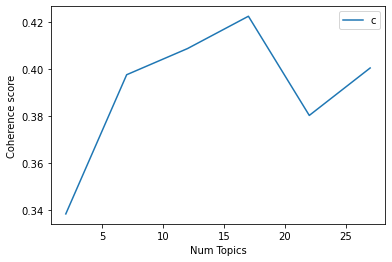

In [107]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [108]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 17

index: 0 | Num Topics = 2  has Coherence Value of 0.3382
index: 1 | Num Topics = 7  has Coherence Value of 0.3977
index: 2 | Num Topics = 12  has Coherence Value of 0.4089
index: 3 | Num Topics = 17  has Coherence Value of 0.4226
index: 4 | Num Topics = 22  has Coherence Value of 0.3803
index: 5 | Num Topics = 27  has Coherence Value of 0.4006


In [176]:
# Select optimal number of topics
optimal_model_us_score1N2N3 = model_list_us_score1N2N3[3]

In [177]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_us_score1N2N3, corpus_us_score1N2N3, id2word_us_score1N2N3)

In [178]:
print("pyLDAVis for us topics for score=1,2,3:")
vis_us_score1N2N3

pyLDAVis for us topics for score=1,2,3:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.270763 -0.080295       1        1  29.457650
1     -0.129818  0.087939       2        1  10.018567
9     -0.158939  0.079537       3        1   9.770987
11    -0.191370 -0.051061       4        1   9.618569
7     -0.132483 -0.110204       5        1   8.497100
8     -0.061423  0.255262       6        1   7.604215
10    -0.152794 -0.005335       7        1   7.195617
0     -0.120164 -0.060939       8        1   5.061852
4      0.067814  0.111469       9        1   2.865129
15     0.048358  0.098781      10        1   2.535002
5     -0.008333 -0.176690      11        1   2.206669
13     0.135197 -0.031432      12        1   1.312620
2      0.167736  0.019040      13        1   1.215262
3      0.187224 -0.019169      14        1   1.054577
6      0.195883 -0.068251      15        1   0.832905
16     0.212279 -0.019809      16        1   0.440194
12     0.211595 -0.028844      17        1   0.313085, topic_info=              Term         Freq        Total Category  logprob  loglift
4               ad   926.000000   926.000000  Default  30.0000  30.0000
201        comment   781.000000   781.000000  Default  29.0000  29.0000
31           video  3109.000000  3109.000000  Default  28.0000  28.0000
68          screen   476.000000   476.000000  Default  27.0000  27.0000
5              app  1359.000000  1359.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
675   unacceptable     0.440091    13.120627  Topic17  -6.1158   2.3715
1508          team     0.425502    11.594915  Topic17  -6.1495   2.4614
89            kind     0.419849    41.155274  Topic17  -6.1629   1.1812
617         select     0.391841    58.484964  Topic17  -6.2320   0.7608
500      recognize     0.384065     4.056885  Topic17  -6.2520   3.4091

[1072 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1550      8  0.951880      absurd
2089      6  0.304015  acceptable
2089     13  0.608030  acceptable
1402      4  0.302867      access
1402      6  0.192734      access
...     ...       ...         ...
77        3  0.180612    youtuber
77        8  0.077405    youtuber
77        9  0.154810    youtuber
77       11  0.283818    youtuber
1150      1  0.911369        zoom

[2185 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 2, 10, 12, 8, 9, 11, 1, 5, 16, 6, 14, 3, 4, 7, 17, 13])

# By-rating of each year

## By-rating of 2018 (Rating=1,2,3)

In [112]:
# By-rating Topic Modelling - rating = 1,2,3 in 2018
# Convert to list - move to each section
review_us_2018_score1N2N3 = youtube_ios_us_review_YearMonth_2018_score1N2N3.review.values.tolist()
review_words_us_2018_score1N2N3 = list(sent_to_words(review_us_2018_score1N2N3))
print(review_words_us_2018_score1N2N3[:1])

[['the', 'app', 'is', 'nice', 'to', 'have', 'but', 'misses', 'lot', 'of', 'features', 'like', 'viewing', 'options', 'the', 'ability', 'to', 'go', 'back', 'sometimes', 'community', 'tab', 'and', 'critical', 'features', 'like', 'being', 'able', 'to', 'actually', 'use', 'search', 'results', 'you', 'can', 'see', 'them', 'but', 'can', 'watch', 'them', 'love', 'that', 'you', 'can', 'go', 'forward', 'or', 'back', 'in', 'second', 'intervals', 'by', 'tapping', 'the', 'left', 'or', 'right', 'sides', 'of', 'the', 'video', 'but', 'if', 'you', 'accidentally', 'tap', 'forward', 'or', 'back', 'next', 'or', 'previous', 'video', 'you', 'get', 'an', 'ad', 'right', 'away', 'and', 'then', 'another', 'when', 'you', 'go', 'back', 'to', 'the', 'video', 'you', 'were', 'watching', 'there', 'are', 'way', 'more', 'ads', 'on', 'the', 'mobile', 'app', 'than', 'on', 'desktop', 'browser', 'viewing', 'just', 'use', 'chrome', 'instead', 'of', 'the', 'app']]


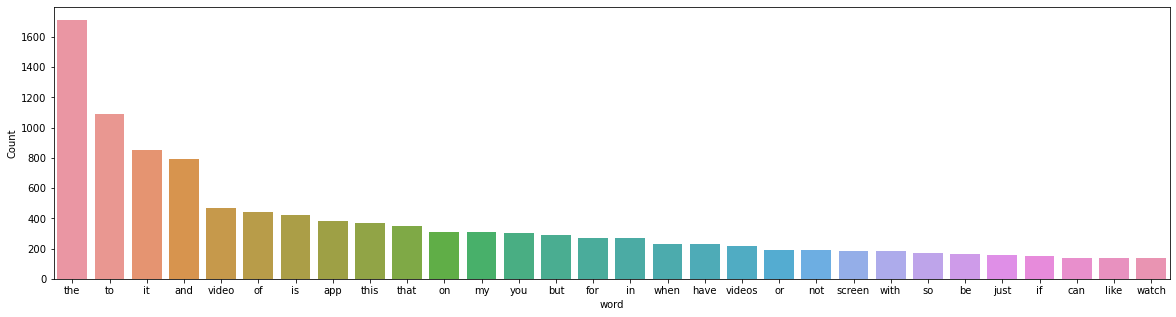

In [113]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_2018_score1N2N3))

In [114]:
# Clean text
review_words_us_ready_2018_score1N2N3 = process_words(review_words_us_2018_score1N2N3)  # processed Text Data! - move to each section

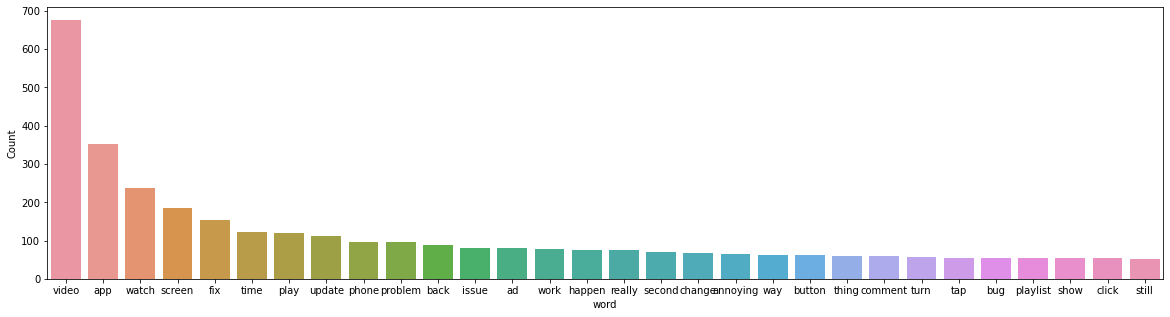

In [115]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_us_ready_2018_score1N2N3))


In [116]:
# Create Dictionary
id2word_us_2018_score1N2N3 = corpora.Dictionary(review_words_us_ready_2018_score1N2N3)

2021-10-17 01:49:54,365 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 01:49:54,401 [INFO] gensim.corpora.dictionary - built Dictionary(1788 unique tokens: ['ability', 'able', 'accidentally', 'actually', 'ad']...) from 271 documents (total 11089 corpus positions)
2021-10-17 01:49:54,403 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(1788 unique tokens: ['ability', 'able', 'accidentally', 'actually', 'ad']...) from 271 documents (total 11089 corpus positions)", 'datetime': '2021-10-17T01:49:54.403544', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [117]:
# Create Corpus: Term Document Frequency
corpus_us_2018_score1N2N3 = [id2word_us_2018_score1N2N3.doc2bow(text) for text in review_words_us_ready_2018_score1N2N3]

In [118]:
# Training LDA model
model_list_us_2018_score1N2N3, coherence_values_us_2018_score1N2N3 = compute_coherence_values(dictionary=id2word_us_2018_score1N2N3, corpus=corpus_us_2018_score1N2N3, 
                                                              texts=review_words_us_ready_2018_score1N2N3, limit=30, start=2, step=5)


2021-10-17 01:49:54,466 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 01:49:54,470 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 01:49:54,483 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 01:49:54,484 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 271 documents, updating model once every 271 documents, evaluating perplexity every 271 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 01:49:55,439 [INFO] gensim.models.ldamodel - -7.991 per-word bound, 254.4 perplexity estimate based on a held-out corpus of 271 documents with 11089 words
2021-10-17 01:49:55,441 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #271/271
2021-10-17 01:49:56,457 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.061*"video" + 0.028*"app" + 0.021*"watch" + 0.015*"screen" + 0.014*"fix" + 0.012*"play" + 0.011*"time

2021-10-17 01:50:09,745 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.022*"video" + 0.015*"app" + 0.008*"song" + 0.008*"watch" + 0.007*"way" + 0.006*"search" + 0.006*"screen" + 0.006*"back" + 0.006*"well" + 0.005*"time"
2021-10-17 01:50:09,747 [INFO] gensim.models.ldamodel - topic diff=0.016013, rho=0.301511
2021-10-17 01:50:10,459 [INFO] gensim.models.ldamodel - -6.509 per-word bound, 91.1 perplexity estimate based on a held-out corpus of 271 documents with 11089 words
2021-10-17 01:50:10,470 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #271/271
2021-10-17 01:50:10,997 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.064*"video" + 0.032*"app" + 0.022*"watch" + 0.017*"screen" + 0.015*"fix" + 0.012*"play" + 0.011*"time" + 0.010*"update" + 0.009*"problem" + 0.009*"phone"
2021-10-17 01:50:10,999 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.021*"video" + 0.015*"app" + 0.009*"song" + 0.008*"watch" + 0.007*"way" + 0.006*"search" + 0.006*"back" + 0.006*"scree

2021-10-17 01:50:21,379 [INFO] gensim.models.ldamodel - topic diff=0.010958, rho=0.218218
2021-10-17 01:50:22,034 [INFO] gensim.models.ldamodel - -6.500 per-word bound, 90.5 perplexity estimate based on a held-out corpus of 271 documents with 11089 words
2021-10-17 01:50:22,035 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #271/271
2021-10-17 01:50:22,489 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.064*"video" + 0.033*"app" + 0.022*"watch" + 0.018*"screen" + 0.015*"fix" + 0.012*"play" + 0.011*"time" + 0.010*"update" + 0.010*"phone" + 0.009*"problem"
2021-10-17 01:50:22,491 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.018*"video" + 0.011*"app" + 0.009*"song" + 0.007*"content" + 0.007*"search" + 0.006*"way" + 0.006*"watch" + 0.006*"well" + 0.006*"find" + 0.006*"download"
2021-10-17 01:50:22,492 [INFO] gensim.models.ldamodel - topic diff=0.010374, rho=0.213201
2021-10-17 01:50:23,135 [INFO] gensim.models.ldamodel - -6.499 per-word bound, 90.5 perplexity est

2021-10-17 01:50:32,240 [INFO] gensim.models.ldamodel - -6.495 per-word bound, 90.2 perplexity estimate based on a held-out corpus of 271 documents with 11089 words
2021-10-17 01:50:32,241 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #271/271
2021-10-17 01:50:32,663 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.063*"video" + 0.033*"app" + 0.022*"watch" + 0.018*"screen" + 0.015*"fix" + 0.012*"play" + 0.011*"time" + 0.011*"update" + 0.010*"phone" + 0.009*"problem"
2021-10-17 01:50:32,674 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.017*"video" + 0.010*"song" + 0.009*"app" + 0.007*"content" + 0.007*"search" + 0.006*"download" + 0.006*"find" + 0.006*"well" + 0.006*"playlist" + 0.006*"way"
2021-10-17 01:50:32,678 [INFO] gensim.models.ldamodel - topic diff=0.006629, rho=0.176777
2021-10-17 01:50:33,246 [INFO] gensim.models.ldamodel - -6.495 per-word bound, 90.2 perplexity estimate based on a held-out corpus of 271 documents with 11089 words
2021-10-17 01:50:33,

2021-10-17 01:50:41,677 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #271/271
2021-10-17 01:50:42,130 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.063*"video" + 0.033*"app" + 0.023*"watch" + 0.018*"screen" + 0.015*"fix" + 0.011*"play" + 0.011*"time" + 0.011*"update" + 0.010*"phone" + 0.009*"problem"
2021-10-17 01:50:42,132 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.015*"video" + 0.010*"song" + 0.008*"content" + 0.008*"app" + 0.007*"search" + 0.007*"download" + 0.006*"find" + 0.006*"playlist" + 0.006*"well" + 0.006*"channel"
2021-10-17 01:50:42,133 [INFO] gensim.models.ldamodel - topic diff=0.004977, rho=0.154303
2021-10-17 01:50:42,613 [INFO] gensim.models.ldamodel - -6.492 per-word bound, 90.0 perplexity estimate based on a held-out corpus of 271 documents with 11089 words
2021-10-17 01:50:42,615 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #271/271
2021-10-17 01:50:43,019 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.063*"vide

2021-10-17 01:50:50,207 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-17 01:50:54,800 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-17 01:50:54,866 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 271 virtual documents
2021-10-17 01:50:55,141 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-17 01:50:55,142 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-17 01:50:55,146 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 01:50:55,150 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 271 documents, updating model once every 271 documents, evaluating perplexity every 271 documents, iterating 50x with a con

2021-10-17 01:51:01,362 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.043*"video" + 0.016*"app" + 0.013*"playlist" + 0.012*"watch" + 0.011*"song" + 0.009*"download" + 0.008*"back" + 0.008*"time" + 0.008*"happen" + 0.007*"screen"
2021-10-17 01:51:01,363 [INFO] gensim.models.ldamodel - topic diff=0.129039, rho=0.408248
2021-10-17 01:51:01,930 [INFO] gensim.models.ldamodel - -6.682 per-word bound, 102.7 perplexity estimate based on a held-out corpus of 271 documents with 11089 words
2021-10-17 01:51:01,933 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #271/271
2021-10-17 01:51:02,486 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.012*"comment" + 0.009*"ban" + 0.006*"tap" + 0.006*"content" + 0.006*"tube" + 0.006*"demonetize" + 0.006*"section" + 0.006*"bad" + 0.006*"reconfirm" + 0.006*"almost"
2021-10-17 01:51:02,488 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.077*"video" + 0.040*"app" + 0.025*"watch" + 0.024*"screen" + 0.016*"play" + 0.015*"fix" + 0.011*"

2021-10-17 01:51:07,252 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.028*"app" + 0.024*"watch" + 0.020*"video" + 0.011*"problem" + 0.010*"screen" + 0.010*"phone" + 0.009*"fix" + 0.009*"back" + 0.008*"time" + 0.007*"much"
2021-10-17 01:51:07,253 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.030*"video" + 0.014*"feature" + 0.012*"update" + 0.011*"button" + 0.011*"remove" + 0.010*"screen" + 0.010*"bottom" + 0.009*"notification" + 0.009*"playlist" + 0.009*"app"
2021-10-17 01:51:07,254 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.012*"comment" + 0.009*"ban" + 0.006*"tap" + 0.006*"content" + 0.006*"tube" + 0.006*"demonetize" + 0.006*"section" + 0.006*"bad" + 0.006*"almost" + 0.006*"garbage"
2021-10-17 01:51:07,256 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"search" + 0.023*"video" + 0.019*"delete" + 0.012*"app" + 0.011*"way" + 0.010*"control" + 0.008*"time" + 0.008*"like" + 0.008*"respond" + 0.007*"find"
2021-10-17 01:51:07,257 [INFO] gensim.models.ldamodel -

2021-10-17 01:51:12,044 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.012*"comment" + 0.009*"ban" + 0.006*"tap" + 0.006*"content" + 0.006*"section" + 0.006*"tube" + 0.006*"bad" + 0.006*"demonetize" + 0.006*"garbage" + 0.006*"almost"
2021-10-17 01:51:12,045 [INFO] gensim.models.ldamodel - topic diff=0.011418, rho=0.242536
2021-10-17 01:51:12,576 [INFO] gensim.models.ldamodel - -6.647 per-word bound, 100.2 perplexity estimate based on a held-out corpus of 271 documents with 11089 words
2021-10-17 01:51:12,578 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #271/271
2021-10-17 01:51:12,957 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.012*"comment" + 0.009*"ban" + 0.006*"tap" + 0.006*"content" + 0.006*"section" + 0.006*"bad" + 0.006*"tube" + 0.006*"demonetize" + 0.006*"garbage" + 0.006*"almost"
2021-10-17 01:51:12,971 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"search" + 0.023*"video" + 0.019*"delete" + 0.011*"app" + 0.011*"way" + 0.011*"control" + 

2021-10-17 01:51:17,621 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.043*"video" + 0.023*"app" + 0.018*"change" + 0.016*"time" + 0.016*"update" + 0.015*"fix" + 0.014*"watch" + 0.010*"really" + 0.008*"comment" + 0.007*"click"
2021-10-17 01:51:17,623 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"search" + 0.023*"video" + 0.019*"delete" + 0.011*"app" + 0.011*"way" + 0.011*"control" + 0.008*"like" + 0.008*"time" + 0.008*"respond" + 0.007*"find"
2021-10-17 01:51:17,624 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.035*"video" + 0.017*"playlist" + 0.013*"song" + 0.013*"download" + 0.012*"app" + 0.010*"add" + 0.008*"content" + 0.008*"watch" + 0.007*"time" + 0.007*"instead"
2021-10-17 01:51:17,626 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.030*"video" + 0.014*"feature" + 0.014*"notification" + 0.013*"remove" + 0.011*"update" + 0.010*"button" + 0.010*"playlist" + 0.010*"bottom" + 0.009*"save" + 0.009*"watch"
2021-10-17 01:51:17,627 [INFO] gensim.models.ldamodel 

2021-10-17 01:51:22,418 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.026*"app" + 0.025*"watch" + 0.020*"video" + 0.010*"problem" + 0.009*"back" + 0.008*"fix" + 0.008*"phone" + 0.008*"time" + 0.007*"screen" + 0.007*"much"
2021-10-17 01:51:22,420 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.078*"video" + 0.039*"app" + 0.026*"watch" + 0.025*"screen" + 0.016*"fix" + 0.015*"play" + 0.012*"phone" + 0.010*"problem" + 0.010*"ad" + 0.010*"issue"
2021-10-17 01:51:22,421 [INFO] gensim.models.ldamodel - topic diff=0.004802, rho=0.188982
2021-10-17 01:51:23,045 [INFO] gensim.models.ldamodel - -6.639 per-word bound, 99.6 perplexity estimate based on a held-out corpus of 271 documents with 11089 words
2021-10-17 01:51:23,048 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #271/271
2021-10-17 01:51:23,506 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.030*"video" + 0.015*"notification" + 0.014*"feature" + 0.014*"remove" + 0.011*"update" + 0.010*"playlist" + 0.010*"but

2021-10-17 01:51:27,874 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #271/271
2021-10-17 01:51:28,098 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.012*"comment" + 0.009*"ban" + 0.006*"tap" + 0.006*"section" + 0.006*"garbage" + 0.006*"bad" + 0.006*"almost" + 0.006*"content" + 0.006*"tube" + 0.006*"demonetize"
2021-10-17 01:51:28,100 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.078*"video" + 0.039*"app" + 0.026*"watch" + 0.026*"screen" + 0.016*"fix" + 0.015*"play" + 0.012*"phone" + 0.010*"problem" + 0.010*"happen" + 0.010*"issue"
2021-10-17 01:51:28,102 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"search" + 0.023*"video" + 0.019*"delete" + 0.011*"app" + 0.011*"way" + 0.011*"control" + 0.008*"like" + 0.008*"time" + 0.008*"respond" + 0.007*"find"
2021-10-17 01:51:28,104 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.025*"watch" + 0.025*"app" + 0.021*"video" + 0.010*"problem" + 0.009*"back" + 0.008*"fix" + 0.008*"time" + 0.008*"phone" + 0.007

2021-10-17 01:51:32,248 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.040*"video" + 0.022*"app" + 0.020*"change" + 0.016*"time" + 0.015*"update" + 0.014*"fix" + 0.013*"watch" + 0.010*"really" + 0.008*"comment" + 0.008*"click"
2021-10-17 01:51:32,249 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"search" + 0.023*"video" + 0.019*"delete" + 0.011*"app" + 0.011*"way" + 0.011*"control" + 0.008*"like" + 0.008*"time" + 0.008*"respond" + 0.007*"find"
2021-10-17 01:51:32,250 [INFO] gensim.models.ldamodel - topic diff=0.002885, rho=0.160128
2021-10-17 01:51:32,758 [INFO] gensim.models.ldamodel - -6.635 per-word bound, 99.4 perplexity estimate based on a held-out corpus of 271 documents with 11089 words
2021-10-17 01:51:32,759 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #271/271
2021-10-17 01:51:33,038 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"search" + 0.023*"video" + 0.019*"delete" + 0.011*"app" + 0.011*"way" + 0.011*"control" + 0.008*"like" + 0

2021-10-17 01:51:36,778 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #271/271
2021-10-17 01:51:37,117 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"search" + 0.023*"video" + 0.019*"delete" + 0.011*"app" + 0.011*"way" + 0.011*"control" + 0.008*"like" + 0.008*"time" + 0.008*"respond" + 0.007*"find"
2021-10-17 01:51:37,119 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.078*"video" + 0.039*"app" + 0.026*"watch" + 0.026*"screen" + 0.016*"fix" + 0.015*"play" + 0.012*"phone" + 0.010*"problem" + 0.010*"happen" + 0.010*"issue"
2021-10-17 01:51:37,121 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.033*"video" + 0.018*"playlist" + 0.014*"song" + 0.013*"download" + 0.012*"app" + 0.011*"add" + 0.008*"content" + 0.007*"time" + 0.007*"watch" + 0.007*"instead"
2021-10-17 01:51:37,123 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.030*"video" + 0.015*"notification" + 0.015*"feature" + 0.014*"remove" + 0.011*"update" + 0.010*"playlist" + 0.010*"bottom" + 0.010

2021-10-17 01:51:41,325 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.030*"video" + 0.015*"notification" + 0.015*"feature" + 0.014*"remove" + 0.011*"update" + 0.010*"playlist" + 0.010*"bottom" + 0.010*"save" + 0.009*"watch" + 0.009*"button"
2021-10-17 01:51:41,328 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.033*"video" + 0.019*"playlist" + 0.014*"song" + 0.013*"download" + 0.012*"app" + 0.011*"add" + 0.008*"content" + 0.007*"time" + 0.007*"watch" + 0.007*"instead"
2021-10-17 01:51:41,329 [INFO] gensim.models.ldamodel - topic diff=0.002107, rho=0.141421
2021-10-17 01:51:41,865 [INFO] gensim.models.ldamodel - -6.632 per-word bound, 99.2 perplexity estimate based on a held-out corpus of 271 documents with 11089 words
2021-10-17 01:51:41,866 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #271/271
2021-10-17 01:51:42,248 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.033*"video" + 0.019*"playlist" + 0.014*"song" + 0.013*"download" + 0.012*"app" + 0.011*"ad

2021-10-17 01:51:51,996 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.038*"video" + 0.019*"app" + 0.017*"search" + 0.014*"back" + 0.012*"screen" + 0.011*"account" + 0.009*"full" + 0.009*"community" + 0.009*"watch" + 0.008*"way"
2021-10-17 01:51:51,998 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.030*"watch" + 0.028*"app" + 0.026*"video" + 0.014*"phone" + 0.013*"problem" + 0.013*"fix" + 0.011*"time" + 0.010*"really" + 0.009*"ad" + 0.008*"much"
2021-10-17 01:51:52,000 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.053*"video" + 0.023*"app" + 0.017*"time" + 0.017*"update" + 0.017*"change" + 0.016*"watch" + 0.013*"really" + 0.010*"fix" + 0.010*"screen" + 0.010*"problem"
2021-10-17 01:51:52,002 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.075*"video" + 0.036*"watch" + 0.021*"fix" + 0.019*"app" + 0.015*"time" + 0.012*"issue" + 0.011*"problem" + 0.011*"screen" + 0.010*"comment" + 0.009*"update"
2021-10-17 01:51:52,003 [INFO] gensim.models.ldamodel - topic #1 (0.083):

2021-10-17 01:51:56,504 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.071*"video" + 0.050*"app" + 0.032*"screen" + 0.020*"watch" + 0.018*"play" + 0.018*"phone" + 0.017*"fix" + 0.012*"ad" + 0.012*"second" + 0.011*"problem"
2021-10-17 01:51:56,505 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.030*"video" + 0.020*"app" + 0.017*"search" + 0.014*"back" + 0.012*"account" + 0.011*"community" + 0.010*"screen" + 0.009*"annoying" + 0.009*"way" + 0.009*"delete"
2021-10-17 01:51:56,507 [INFO] gensim.models.ldamodel - topic diff=0.056023, rho=0.316228
2021-10-17 01:51:57,126 [INFO] gensim.models.ldamodel - -6.791 per-word bound, 110.7 perplexity estimate based on a held-out corpus of 271 documents with 11089 words
2021-10-17 01:51:57,127 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #271/271
2021-10-17 01:51:57,426 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.048*"video" + 0.021*"app" + 0.018*"update" + 0.018*"change" + 0.018*"time" + 0.014*"watch" + 0.013*"reall

2021-10-17 01:52:01,318 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #271/271
2021-10-17 01:52:01,623 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.078*"video" + 0.037*"watch" + 0.020*"fix" + 0.018*"app" + 0.014*"time" + 0.013*"issue" + 0.012*"comment" + 0.012*"problem" + 0.011*"screen" + 0.009*"happen"
2021-10-17 01:52:01,641 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.023*"video" + 0.018*"delete" + 0.015*"time" + 0.015*"way" + 0.015*"like" + 0.013*"control" + 0.011*"app" + 0.009*"select" + 0.009*"able" + 0.009*"respond"
2021-10-17 01:52:01,650 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.045*"video" + 0.020*"app" + 0.018*"update" + 0.018*"change" + 0.018*"time" + 0.013*"really" + 0.012*"watch" + 0.011*"comment" + 0.010*"playlist" + 0.010*"button"
2021-10-17 01:52:01,656 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.073*"video" + 0.050*"app" + 0.034*"screen" + 0.021*"watch" + 0.018*"play" + 0.018*"phone" + 0.017*"fix" + 0.013*"ad" + 0.012*"

2021-10-17 01:52:05,984 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.028*"video" + 0.018*"screen" + 0.018*"app" + 0.012*"update" + 0.012*"long" + 0.010*"mode" + 0.010*"save" + 0.010*"notification" + 0.009*"show" + 0.008*"search"
2021-10-17 01:52:05,987 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.078*"video" + 0.037*"watch" + 0.020*"fix" + 0.018*"app" + 0.014*"time" + 0.013*"comment" + 0.013*"issue" + 0.012*"problem" + 0.010*"screen" + 0.009*"load"
2021-10-17 01:52:05,988 [INFO] gensim.models.ldamodel - topic diff=0.011101, rho=0.218218
2021-10-17 01:52:06,492 [INFO] gensim.models.ldamodel - -6.762 per-word bound, 108.5 perplexity estimate based on a held-out corpus of 271 documents with 11089 words
2021-10-17 01:52:06,493 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #271/271
2021-10-17 01:52:06,796 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.077*"video" + 0.037*"watch" + 0.020*"fix" + 0.018*"app" + 0.014*"time" + 0.014*"comment" + 0.013*"issue" 

2021-10-17 01:52:10,719 [INFO] gensim.models.ldamodel - -6.756 per-word bound, 108.0 perplexity estimate based on a held-out corpus of 271 documents with 11089 words
2021-10-17 01:52:10,720 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #271/271
2021-10-17 01:52:11,084 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.007*"favorite" + 0.007*"possibly" + 0.007*"true" + 0.001*"twice" + 0.001*"trend" + 0.001*"add" + 0.001*"page" + 0.001*"later" + 0.001*"assume" + 0.001*"remove"
2021-10-17 01:52:11,086 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.023*"video" + 0.018*"delete" + 0.015*"time" + 0.015*"way" + 0.015*"like" + 0.013*"control" + 0.011*"app" + 0.009*"select" + 0.009*"able" + 0.009*"respond"
2021-10-17 01:52:11,089 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.029*"watch" + 0.027*"video" + 0.022*"app" + 0.012*"really" + 0.011*"phone" + 0.011*"time" + 0.010*"fix" + 0.009*"much" + 0.009*"problem" + 0.009*"back"
2021-10-17 01:52:11,094 [INFO] gensim.model

2021-10-17 01:52:15,179 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.043*"video" + 0.025*"app" + 0.015*"play" + 0.013*"watch" + 0.009*"fix" + 0.009*"back" + 0.008*"click" + 0.008*"issue" + 0.008*"volume" + 0.008*"control"
2021-10-17 01:52:15,181 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.077*"video" + 0.036*"watch" + 0.019*"fix" + 0.018*"app" + 0.014*"comment" + 0.013*"time" + 0.013*"issue" + 0.012*"problem" + 0.010*"screen" + 0.009*"load"
2021-10-17 01:52:15,183 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.030*"search" + 0.023*"song" + 0.019*"video" + 0.013*"find" + 0.011*"great" + 0.010*"app" + 0.009*"content" + 0.008*"change" + 0.008*"delete" + 0.008*"thing"
2021-10-17 01:52:15,185 [INFO] gensim.models.ldamodel - topic diff=0.005057, rho=0.176777
2021-10-17 01:52:15,698 [INFO] gensim.models.ldamodel - -6.751 per-word bound, 107.7 perplexity estimate based on a held-out corpus of 271 documents with 11089 words
2021-10-17 01:52:15,699 [INFO] gensim.models.ldamo

2021-10-17 01:52:19,442 [INFO] gensim.models.ldamodel - topic diff=0.003632, rho=0.164399
2021-10-17 01:52:20,013 [INFO] gensim.models.ldamodel - -6.748 per-word bound, 107.5 perplexity estimate based on a held-out corpus of 271 documents with 11089 words
2021-10-17 01:52:20,014 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #271/271
2021-10-17 01:52:20,390 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.031*"search" + 0.023*"song" + 0.018*"video" + 0.013*"find" + 0.011*"great" + 0.010*"app" + 0.009*"content" + 0.008*"change" + 0.008*"delete" + 0.008*"thing"
2021-10-17 01:52:20,391 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.020*"app" + 0.015*"search" + 0.014*"back" + 0.013*"account" + 0.013*"community" + 0.013*"video" + 0.010*"annoying" + 0.010*"way" + 0.010*"notification" + 0.010*"love"
2021-10-17 01:52:20,392 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.029*"watch" + 0.027*"video" + 0.021*"app" + 0.012*"really" + 0.011*"phone" + 0.011*"time" + 0.

2021-10-17 01:52:24,762 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.077*"video" + 0.037*"watch" + 0.019*"fix" + 0.018*"app" + 0.015*"comment" + 0.013*"time" + 0.013*"issue" + 0.012*"problem" + 0.010*"load" + 0.009*"screen"
2021-10-17 01:52:24,763 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.029*"video" + 0.018*"app" + 0.016*"screen" + 0.013*"update" + 0.013*"long" + 0.010*"notification" + 0.010*"save" + 0.008*"search" + 0.008*"feature" + 0.007*"mode"
2021-10-17 01:52:24,765 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.031*"search" + 0.023*"song" + 0.018*"video" + 0.013*"find" + 0.011*"great" + 0.010*"app" + 0.009*"content" + 0.008*"change" + 0.008*"delete" + 0.008*"thing"
2021-10-17 01:52:24,766 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.041*"video" + 0.018*"app" + 0.016*"download" + 0.010*"update" + 0.010*"happen" + 0.010*"back" + 0.010*"instead" + 0.009*"bottom" + 0.009*"shuffle" + 0.009*"premium"
2021-10-17 01:52:24,768 [INFO] gensim.models.ldamodel -

2021-10-17 01:52:29,071 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.029*"video" + 0.018*"app" + 0.016*"screen" + 0.013*"update" + 0.013*"long" + 0.011*"notification" + 0.011*"save" + 0.008*"search" + 0.008*"feature" + 0.007*"mode"
2021-10-17 01:52:29,073 [INFO] gensim.models.ldamodel - topic diff=0.001932, rho=0.144338
2021-10-17 01:52:29,609 [INFO] gensim.models.ldamodel - -6.745 per-word bound, 107.3 perplexity estimate based on a held-out corpus of 271 documents with 11089 words
2021-10-17 01:52:29,612 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #271/271
2021-10-17 01:52:29,879 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.042*"video" + 0.020*"app" + 0.019*"update" + 0.019*"change" + 0.018*"time" + 0.013*"really" + 0.011*"watch" + 0.011*"comment" + 0.011*"playlist" + 0.011*"button"
2021-10-17 01:52:29,880 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.077*"video" + 0.037*"watch" + 0.019*"fix" + 0.018*"app" + 0.015*"comment" + 0.013*"time" + 0.01

2021-10-17 01:52:41,305 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.042*"video" + 0.016*"search" + 0.014*"screen" + 0.014*"watch" + 0.014*"actually" + 0.012*"back" + 0.012*"channel" + 0.010*"page" + 0.010*"swipe" + 0.009*"gray"
2021-10-17 01:52:41,307 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.074*"video" + 0.050*"app" + 0.029*"screen" + 0.017*"play" + 0.016*"watch" + 0.015*"fix" + 0.014*"phone" + 0.010*"second" + 0.010*"problem" + 0.010*"ad"
2021-10-17 01:52:41,310 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.015*"completely" + 0.014*"app" + 0.012*"video" + 0.012*"look" + 0.010*"literally" + 0.010*"ever" + 0.009*"entire" + 0.008*"tend" + 0.008*"commercial" + 0.008*"thing"
2021-10-17 01:52:41,312 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.054*"video" + 0.025*"app" + 0.021*"change" + 0.018*"time" + 0.016*"fix" + 0.015*"really" + 0.013*"screen" + 0.012*"update" + 0.012*"problem" + 0.011*"watch"
2021-10-17 01:52:41,314 [INFO] gensim.models.ldamodel - top

2021-10-17 01:52:45,633 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.028*"video" + 0.026*"app" + 0.020*"watch" + 0.017*"problem" + 0.015*"phone" + 0.013*"screen" + 0.011*"fix" + 0.009*"ad" + 0.009*"listen" + 0.009*"instead"
2021-10-17 01:52:45,635 [INFO] gensim.models.ldamodel - topic diff=0.129933, rho=0.353553
2021-10-17 01:52:46,166 [INFO] gensim.models.ldamodel - -6.879 per-word bound, 117.7 perplexity estimate based on a held-out corpus of 271 documents with 11089 words
2021-10-17 01:52:46,171 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #271/271
2021-10-17 01:52:46,445 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.061*"video" + 0.035*"app" + 0.026*"watch" + 0.020*"play" + 0.018*"download" + 0.013*"back" + 0.011*"remove" + 0.011*"fix" + 0.010*"later" + 0.010*"screen"
2021-10-17 01:52:46,447 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.018*"kid" + 0.009*"amazing" + 0.009*"ton" + 0.009*"sister" + 0.009*"account" + 0.006*"power" + 0.005*"stuff" + 

2021-10-17 01:52:50,760 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.078*"video" + 0.035*"watch" + 0.022*"app" + 0.020*"fix" + 0.016*"time" + 0.016*"playlist" + 0.014*"add" + 0.011*"issue" + 0.011*"load" + 0.011*"update"
2021-10-17 01:52:50,761 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.057*"video" + 0.026*"app" + 0.023*"time" + 0.023*"change" + 0.018*"really" + 0.017*"comment" + 0.016*"fix" + 0.012*"turn" + 0.011*"happen" + 0.011*"watch"
2021-10-17 01:52:50,763 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.073*"video" + 0.050*"app" + 0.040*"screen" + 0.019*"fix" + 0.018*"phone" + 0.017*"play" + 0.016*"watch" + 0.012*"problem" + 0.012*"ad" + 0.010*"update"
2021-10-17 01:52:50,764 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.061*"video" + 0.021*"time" + 0.018*"ad" + 0.018*"watch" + 0.015*"button" + 0.014*"play" + 0.012*"control" + 0.012*"way" + 0.011*"app" + 0.010*"click"
2021-10-17 01:52:50,765 [INFO] gensim.models.ldamodel - topic diff=0.029728, rho=0.267

2021-10-17 01:52:55,435 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.026*"forward" + 0.022*"second" + 0.018*"video" + 0.018*"back" + 0.014*"update" + 0.013*"app" + 0.013*"well" + 0.013*"version" + 0.011*"major" + 0.011*"feature"
2021-10-17 01:52:55,447 [INFO] gensim.models.ldamodel - topic diff=0.012836, rho=0.229416
2021-10-17 01:52:55,846 [INFO] gensim.models.ldamodel - -6.836 per-word bound, 114.2 perplexity estimate based on a held-out corpus of 271 documents with 11089 words
2021-10-17 01:52:55,848 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #271/271
2021-10-17 01:52:56,251 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.018*"completely" + 0.015*"look" + 0.013*"app" + 0.012*"video" + 0.010*"literally" + 0.010*"ever" + 0.010*"entire" + 0.010*"tend" + 0.010*"commercial" + 0.010*"thing"
2021-10-17 01:52:56,252 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.067*"video" + 0.037*"app" + 0.029*"watch" + 0.021*"play" + 0.018*"download" + 0.013*"remove" 

2021-10-17 01:53:00,446 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.068*"video" + 0.037*"app" + 0.029*"watch" + 0.020*"play" + 0.018*"download" + 0.014*"remove" + 0.012*"back" + 0.011*"work" + 0.011*"delete" + 0.011*"later"
2021-10-17 01:53:00,447 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.018*"kid" + 0.009*"amazing" + 0.009*"ton" + 0.009*"sister" + 0.009*"account" + 0.004*"power" + 0.001*"stuff" + 0.001*"worth" + 0.001*"annoying" + 0.001*"bit"
2021-10-17 01:53:00,449 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.041*"video" + 0.019*"search" + 0.019*"actually" + 0.015*"watch" + 0.014*"screen" + 0.014*"back" + 0.013*"channel" + 0.013*"swipe" + 0.013*"gray" + 0.012*"page"
2021-10-17 01:53:00,452 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.052*"ad" + 0.018*"comment" + 0.013*"half" + 0.012*"almost" + 0.011*"video" + 0.010*"watch" + 0.010*"year" + 0.009*"look" + 0.009*"insert" + 0.009*"lose"
2021-10-17 01:53:00,454 [INFO] gensim.models.ldamodel - topic diff=

2021-10-17 01:53:04,560 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.018*"kid" + 0.009*"amazing" + 0.009*"ton" + 0.009*"sister" + 0.009*"account" + 0.003*"power" + 0.001*"stuff" + 0.001*"worth" + 0.001*"annoying" + 0.001*"bit"
2021-10-17 01:53:04,562 [INFO] gensim.models.ldamodel - topic diff=0.004737, rho=0.182574
2021-10-17 01:53:05,122 [INFO] gensim.models.ldamodel - -6.824 per-word bound, 113.3 perplexity estimate based on a held-out corpus of 271 documents with 11089 words
2021-10-17 01:53:05,123 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #271/271
2021-10-17 01:53:05,418 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.073*"video" + 0.049*"app" + 0.042*"screen" + 0.019*"fix" + 0.018*"play" + 0.017*"phone" + 0.016*"watch" + 0.013*"problem" + 0.012*"ad" + 0.010*"second"
2021-10-17 01:53:05,419 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.018*"kid" + 0.009*"amazing" + 0.009*"ton" + 0.009*"sister" + 0.009*"account" + 0.003*"power" + 0.001*"stuff" +

2021-10-17 01:53:09,521 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.030*"update" + 0.021*"screen" + 0.020*"gun" + 0.018*"video" + 0.011*"stop" + 0.011*"app" + 0.009*"notification" + 0.009*"size" + 0.008*"control" + 0.008*"version"
2021-10-17 01:53:09,523 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.027*"delete" + 0.022*"video" + 0.022*"control" + 0.013*"search" + 0.013*"select" + 0.013*"respond" + 0.009*"able" + 0.009*"step" + 0.009*"area" + 0.009*"play"
2021-10-17 01:53:09,525 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.053*"ad" + 0.018*"comment" + 0.013*"half" + 0.012*"almost" + 0.011*"video" + 0.010*"watch" + 0.010*"year" + 0.009*"insert" + 0.009*"look" + 0.009*"lose"
2021-10-17 01:53:09,527 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.069*"video" + 0.037*"app" + 0.030*"watch" + 0.020*"play" + 0.017*"download" + 0.015*"remove" + 0.012*"back" + 0.011*"work" + 0.011*"later" + 0.011*"delete"
2021-10-17 01:53:09,529 [INFO] gensim.models.ldamodel - topic #1

2021-10-17 01:53:13,579 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.060*"video" + 0.021*"time" + 0.018*"watch" + 0.017*"ad" + 0.015*"button" + 0.013*"play" + 0.012*"control" + 0.012*"way" + 0.010*"click" + 0.010*"select"
2021-10-17 01:53:13,581 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.069*"video" + 0.037*"app" + 0.031*"watch" + 0.020*"play" + 0.017*"download" + 0.015*"remove" + 0.012*"back" + 0.012*"work" + 0.011*"later" + 0.011*"delete"
2021-10-17 01:53:13,582 [INFO] gensim.models.ldamodel - topic diff=0.002703, rho=0.156174
2021-10-17 01:53:14,063 [INFO] gensim.models.ldamodel - -6.818 per-word bound, 112.8 perplexity estimate based on a held-out corpus of 271 documents with 11089 words
2021-10-17 01:53:14,065 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #271/271
2021-10-17 01:53:14,393 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.078*"video" + 0.034*"watch" + 0.022*"app" + 0.018*"playlist" + 0.018*"fix" + 0.016*"add" + 0.015*"time" + 0.01

2021-10-17 01:53:18,103 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #271/271
2021-10-17 01:53:18,514 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.073*"video" + 0.049*"app" + 0.042*"screen" + 0.019*"fix" + 0.018*"play" + 0.017*"phone" + 0.016*"watch" + 0.013*"problem" + 0.012*"ad" + 0.010*"second"
2021-10-17 01:53:18,515 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.060*"video" + 0.021*"time" + 0.018*"watch" + 0.015*"ad" + 0.015*"button" + 0.013*"play" + 0.012*"control" + 0.012*"way" + 0.010*"click" + 0.010*"select"
2021-10-17 01:53:18,516 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.034*"search" + 0.034*"song" + 0.026*"video" + 0.018*"playlist" + 0.014*"app" + 0.013*"really" + 0.013*"thing" + 0.011*"fix" + 0.011*"find" + 0.011*"change"
2021-10-17 01:53:18,517 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.027*"delete" + 0.022*"video" + 0.022*"control" + 0.013*"search" + 0.013*"select" + 0.013*"respond" + 0.009*"able" + 0.009*"step" + 0.009*

2021-10-17 01:53:28,385 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.045454545454545456
2021-10-17 01:53:28,386 [INFO] gensim.models.ldamodel - using symmetric eta at 0.045454545454545456
2021-10-17 01:53:28,390 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 01:53:28,400 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 22 topics, 50 passes over the supplied corpus of 271 documents, updating model once every 271 documents, evaluating perplexity every 271 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 01:53:29,402 [INFO] gensim.models.ldamodel - -14.357 per-word bound, 20979.5 perplexity estimate based on a held-out corpus of 271 documents with 11089 words
2021-10-17 01:53:29,403 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #271/271
2021-10-17 01:53:30,232 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.053*"video" + 0.025*"song" + 0.023*"app" + 0.021*"delete" + 0.

2021-10-17 01:53:34,178 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #271/271
2021-10-17 01:53:34,529 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.072*"video" + 0.047*"app" + 0.026*"screen" + 0.021*"watch" + 0.019*"play" + 0.018*"ad" + 0.014*"fix" + 0.011*"phone" + 0.010*"time" + 0.010*"problem"
2021-10-17 01:53:34,531 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.047*"video" + 0.042*"song" + 0.030*"delete" + 0.026*"app" + 0.023*"play" + 0.014*"work" + 0.014*"playlist" + 0.013*"select" + 0.013*"phone" + 0.013*"random"
2021-10-17 01:53:34,536 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.018*"ever" + 0.014*"screen" + 0.013*"format" + 0.012*"completely" + 0.012*"entire" + 0.012*"small" + 0.012*"literally" + 0.012*"title" + 0.012*"text" + 0.012*"size"
2021-10-17 01:53:34,541 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.023*"kid" + 0.020*"app" + 0.014*"child" + 0.012*"screen" + 0.012*"channel" + 0.012*"white" + 0.010*"watch" + 0.010*"video" + 0

2021-10-17 01:53:38,378 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.068*"video" + 0.021*"time" + 0.018*"button" + 0.016*"watch" + 0.015*"play" + 0.015*"click" + 0.012*"fix" + 0.011*"sometimes" + 0.010*"app" + 0.009*"search"
2021-10-17 01:53:38,379 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.063*"video" + 0.043*"app" + 0.023*"time" + 0.020*"phone" + 0.018*"comment" + 0.016*"back" + 0.016*"watch" + 0.013*"leave" + 0.013*"happen" + 0.011*"issue"
2021-10-17 01:53:38,381 [INFO] gensim.models.ldamodel - topic diff=0.054538, rho=0.288675
2021-10-17 01:53:38,877 [INFO] gensim.models.ldamodel - -6.923 per-word bound, 121.3 perplexity estimate based on a held-out corpus of 271 documents with 11089 words
2021-10-17 01:53:38,878 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #271/271
2021-10-17 01:53:39,180 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.067*"video" + 0.021*"time" + 0.018*"button" + 0.016*"watch" + 0.015*"click" + 0.015*"play" + 0.012*"fix" +

2021-10-17 01:53:42,684 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #271/271
2021-10-17 01:53:42,999 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.001*"like" + 0.001*"still" + 0.001*"watch" + 0.001*"kid" + 0.001*"annoying" + 0.001*"time" + 0.001*"play" + 0.001*"video" + 0.001*"fix" + 0.001*"way"
2021-10-17 01:53:43,000 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.018*"game" + 0.013*"however" + 0.012*"video" + 0.012*"button" + 0.012*"find" + 0.012*"issue" + 0.012*"fast" + 0.012*"forward" + 0.012*"people" + 0.012*"company"
2021-10-17 01:53:43,001 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.063*"playlist" + 0.035*"video" + 0.034*"add" + 0.023*"feature" + 0.019*"app" + 0.018*"happen" + 0.016*"save" + 0.015*"shuffle" + 0.013*"watch" + 0.011*"tap"
2021-10-17 01:53:43,003 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.057*"ad" + 0.026*"search" + 0.022*"control" + 0.021*"video" + 0.017*"delete" + 0.013*"back" + 0.012*"play" + 0.011*"really" + 0.009

2021-10-17 01:53:46,867 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.064*"video" + 0.042*"app" + 0.024*"time" + 0.020*"phone" + 0.019*"comment" + 0.017*"back" + 0.015*"watch" + 0.014*"happen" + 0.012*"leave" + 0.012*"issue"
2021-10-17 01:53:46,869 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.073*"video" + 0.047*"app" + 0.028*"screen" + 0.023*"ad" + 0.021*"play" + 0.019*"watch" + 0.015*"fix" + 0.011*"problem" + 0.011*"time" + 0.011*"phone"
2021-10-17 01:53:46,871 [INFO] gensim.models.ldamodel - topic diff=0.008117, rho=0.208514
2021-10-17 01:53:47,379 [INFO] gensim.models.ldamodel - -6.901 per-word bound, 119.5 perplexity estimate based on a held-out corpus of 271 documents with 11089 words
2021-10-17 01:53:47,381 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #271/271
2021-10-17 01:53:47,684 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.047*"video" + 0.027*"watch" + 0.019*"app" + 0.017*"screen" + 0.013*"leave" + 0.013*"fix" + 0.013*"turn" + 0.011*"b

2021-10-17 01:53:51,384 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #271/271
2021-10-17 01:53:51,654 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.065*"playlist" + 0.035*"add" + 0.035*"video" + 0.024*"feature" + 0.019*"app" + 0.017*"save" + 0.016*"happen" + 0.015*"shuffle" + 0.013*"watch" + 0.011*"tap"
2021-10-17 01:53:51,658 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.064*"video" + 0.042*"app" + 0.024*"time" + 0.020*"phone" + 0.020*"comment" + 0.017*"back" + 0.015*"watch" + 0.015*"happen" + 0.012*"leave" + 0.012*"issue"
2021-10-17 01:53:51,663 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.019*"ever" + 0.014*"screen" + 0.013*"format" + 0.013*"completely" + 0.013*"entire" + 0.013*"literally" + 0.013*"small" + 0.013*"app" + 0.013*"title" + 0.013*"text"
2021-10-17 01:53:51,668 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.053*"video" + 0.025*"app" + 0.024*"change" + 0.021*"really" + 0.018*"time" + 0.018*"problem" + 0.015*"watch" + 0.014*"fix

2021-10-17 01:53:56,189 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.064*"video" + 0.042*"app" + 0.024*"time" + 0.020*"comment" + 0.020*"phone" + 0.017*"back" + 0.015*"watch" + 0.015*"happen" + 0.012*"issue" + 0.012*"leave"
2021-10-17 01:53:56,193 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.031*"video" + 0.024*"watch" + 0.019*"app" + 0.016*"phone" + 0.011*"screen" + 0.011*"listen" + 0.011*"ad" + 0.009*"time" + 0.009*"well" + 0.009*"thing"
2021-10-17 01:53:56,194 [INFO] gensim.models.ldamodel - topic diff=0.002935, rho=0.171499
2021-10-17 01:53:56,706 [INFO] gensim.models.ldamodel - -6.894 per-word bound, 118.9 perplexity estimate based on a held-out corpus of 271 documents with 11089 words
2021-10-17 01:53:56,708 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #271/271
2021-10-17 01:53:57,034 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.026*"comment" + 0.020*"problem" + 0.020*"add" + 0.017*"well" + 0.013*"fix" + 0.013*"section" + 0.013*"occasional

2021-10-17 01:54:00,761 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #271/271
2021-10-17 01:54:01,054 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.026*"comment" + 0.020*"problem" + 0.020*"add" + 0.017*"well" + 0.013*"fix" + 0.013*"section" + 0.013*"occasionally" + 0.013*"browser" + 0.013*"size" + 0.013*"thumbnail"
2021-10-17 01:54:01,056 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.064*"video" + 0.042*"app" + 0.024*"time" + 0.020*"comment" + 0.020*"phone" + 0.017*"back" + 0.015*"watch" + 0.015*"happen" + 0.012*"issue" + 0.012*"leave"
2021-10-17 01:54:01,059 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.043*"app" + 0.041*"video" + 0.016*"download" + 0.016*"gun" + 0.011*"update" + 0.010*"back" + 0.010*"click" + 0.009*"audio" + 0.009*"work" + 0.009*"way"
2021-10-17 01:54:01,061 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.027*"kid" + 0.017*"child" + 0.013*"channel" + 0.013*"white" + 0.010*"dark" + 0.010*"side" + 0.010*"age" + 0.010*"young" +

2021-10-17 01:54:06,374 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.075*"video" + 0.045*"screen" + 0.029*"app" + 0.014*"show" + 0.014*"watch" + 0.014*"bottom" + 0.011*"look" + 0.011*"full" + 0.009*"back" + 0.009*"mode"
2021-10-17 01:54:06,376 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.074*"video" + 0.047*"app" + 0.030*"screen" + 0.023*"ad" + 0.021*"play" + 0.020*"watch" + 0.016*"fix" + 0.011*"problem" + 0.011*"time" + 0.011*"phone"
2021-10-17 01:54:06,377 [INFO] gensim.models.ldamodel - topic diff=0.001636, rho=0.149071
2021-10-17 01:54:07,010 [INFO] gensim.models.ldamodel - -6.890 per-word bound, 118.6 perplexity estimate based on a held-out corpus of 271 documents with 11089 words
2021-10-17 01:54:07,012 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #271/271
2021-10-17 01:54:07,378 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.063*"video" + 0.022*"time" + 0.019*"button" + 0.017*"watch" + 0.013*"click" + 0.012*"fix" + 0.012*"play" + 0.012*"som

2021-10-17 01:54:11,795 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #271/271
2021-10-17 01:54:12,089 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.078*"video" + 0.031*"watch" + 0.028*"fix" + 0.023*"app" + 0.016*"screen" + 0.016*"update" + 0.016*"load" + 0.015*"issue" + 0.012*"problem" + 0.011*"freeze"
2021-10-17 01:54:12,091 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.033*"search" + 0.030*"video" + 0.015*"content" + 0.013*"show" + 0.012*"app" + 0.010*"really" + 0.010*"great" + 0.008*"find" + 0.008*"bad" + 0.008*"thing"
2021-10-17 01:54:12,093 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.031*"video" + 0.025*"watch" + 0.019*"app" + 0.016*"phone" + 0.011*"screen" + 0.011*"listen" + 0.011*"ad" + 0.009*"time" + 0.009*"well" + 0.009*"thing"
2021-10-17 01:54:12,096 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.074*"video" + 0.047*"app" + 0.030*"screen" + 0.023*"ad" + 0.021*"play" + 0.020*"watch" + 0.016*"fix" + 0.011*"problem" + 0.011*"time" + 0.

2021-10-17 01:54:25,786 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.048*"video" + 0.012*"watch" + 0.011*"app" + 0.011*"stop" + 0.010*"screen" + 0.010*"time" + 0.009*"add" + 0.009*"give" + 0.009*"chat" + 0.009*"switch"
2021-10-17 01:54:25,787 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.071*"video" + 0.029*"fix" + 0.028*"watch" + 0.027*"app" + 0.013*"update" + 0.012*"recommend" + 0.011*"issue" + 0.010*"remove" + 0.010*"feature" + 0.010*"load"
2021-10-17 01:54:25,788 [INFO] gensim.models.ldamodel - topic diff=0.328003, rho=0.447214
2021-10-17 01:54:26,230 [INFO] gensim.models.ldamodel - -7.131 per-word bound, 140.1 perplexity estimate based on a held-out corpus of 271 documents with 11089 words
2021-10-17 01:54:26,232 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #271/271
2021-10-17 01:54:26,636 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.030*"app" + 0.027*"song" + 0.020*"video" + 0.016*"fix" + 0.016*"watch" + 0.013*"leave" + 0.012*"random" + 0.012

2021-10-17 01:54:31,069 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #271/271
2021-10-17 01:54:31,460 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.049*"video" + 0.027*"app" + 0.024*"watch" + 0.021*"update" + 0.021*"time" + 0.018*"change" + 0.017*"button" + 0.015*"really" + 0.011*"happen" + 0.010*"control"
2021-10-17 01:54:31,463 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.029*"video" + 0.018*"listen" + 0.018*"app" + 0.017*"screen" + 0.015*"phone" + 0.011*"watch" + 0.011*"problem" + 0.011*"ad" + 0.011*"instead" + 0.011*"replace"
2021-10-17 01:54:31,465 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.020*"ever" + 0.020*"entire" + 0.020*"completely" + 0.020*"literally" + 0.020*"app" + 0.010*"change" + 0.010*"interact" + 0.010*"enjoy" + 0.010*"never" + 0.010*"fact"
2021-10-17 01:54:31,469 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.029*"minute" + 0.020*"video" + 0.020*"problem" + 0.020*"couple" + 0.020*"subscription" + 0.010*"update" + 0.010*"p

2021-10-17 01:54:35,928 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.039*"video" + 0.013*"stop" + 0.011*"watch" + 0.011*"app" + 0.010*"give" + 0.010*"chat" + 0.010*"switch" + 0.010*"dimension" + 0.010*"stream" + 0.009*"time"
2021-10-17 01:54:35,931 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.067*"video" + 0.027*"search" + 0.017*"watch" + 0.016*"update" + 0.015*"find" + 0.012*"happen" + 0.012*"last" + 0.011*"feature" + 0.011*"song" + 0.011*"shuffle"
2021-10-17 01:54:35,935 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.056*"video" + 0.038*"ad" + 0.020*"click" + 0.018*"play" + 0.013*"button" + 0.013*"time" + 0.013*"watch" + 0.010*"download" + 0.008*"fix" + 0.008*"problem"
2021-10-17 01:54:35,937 [INFO] gensim.models.ldamodel - topic diff=0.026520, rho=0.250000
2021-10-17 01:54:36,526 [INFO] gensim.models.ldamodel - -6.984 per-word bound, 126.6 perplexity estimate based on a held-out corpus of 271 documents with 11089 words
2021-10-17 01:54:36,527 [INFO] gensim.model

2021-10-17 01:54:41,167 [INFO] gensim.models.ldamodel - topic diff=0.012040, rho=0.218218
2021-10-17 01:54:41,899 [INFO] gensim.models.ldamodel - -6.973 per-word bound, 125.6 perplexity estimate based on a held-out corpus of 271 documents with 11089 words
2021-10-17 01:54:41,904 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #271/271
2021-10-17 01:54:42,368 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.058*"video" + 0.025*"watch" + 0.024*"screen" + 0.019*"press" + 0.019*"annoying" + 0.014*"search" + 0.014*"full" + 0.014*"functionality" + 0.014*"picture" + 0.014*"app"
2021-10-17 01:54:42,370 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.083*"video" + 0.060*"app" + 0.030*"play" + 0.029*"screen" + 0.018*"work" + 0.018*"phone" + 0.018*"watch" + 0.014*"fix" + 0.014*"update" + 0.014*"load"
2021-10-17 01:54:42,372 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.033*"child" + 0.026*"white" + 0.026*"claim" + 0.020*"kid" + 0.020*"dark" + 0.020*"revenue" + 0.020*

2021-10-17 01:54:47,520 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.001*"subscriber" + 0.001*"horizontally" + 0.001*"fuss" + 0.001*"neeeed" + 0.001*"obsess" + 0.001*"customizable" + 0.001*"pick" + 0.001*"gap" + 0.001*"conclusion" + 0.001*"tribute"
2021-10-17 01:54:47,521 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.067*"video" + 0.022*"issue" + 0.021*"app" + 0.018*"screen" + 0.018*"play" + 0.017*"show" + 0.014*"click" + 0.013*"remove" + 0.012*"thing" + 0.012*"back"
2021-10-17 01:54:47,523 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.033*"child" + 0.026*"white" + 0.026*"claim" + 0.020*"kid" + 0.020*"dark" + 0.020*"revenue" + 0.020*"fool" + 0.013*"skin" + 0.013*"paint" + 0.013*"black"
2021-10-17 01:54:47,524 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.064*"video" + 0.037*"watch" + 0.032*"app" + 0.015*"fix" + 0.012*"great" + 0.010*"annoying" + 0.010*"really" + 0.009*"ad" + 0.009*"back" + 0.009*"well"
2021-10-17 01:54:47,525 [INFO] gensim.models.ldamodel - t

2021-10-17 01:54:52,028 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.084*"delete" + 0.059*"search" + 0.032*"select" + 0.023*"video" + 0.016*"bar" + 0.014*"stuff" + 0.014*"area" + 0.014*"able" + 0.014*"step" + 0.013*"hope"
2021-10-17 01:54:52,029 [INFO] gensim.models.ldamodel - topic diff=0.004740, rho=0.176777
2021-10-17 01:54:52,587 [INFO] gensim.models.ldamodel - -6.959 per-word bound, 124.4 perplexity estimate based on a held-out corpus of 271 documents with 11089 words
2021-10-17 01:54:52,589 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #271/271
2021-10-17 01:54:52,936 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.029*"video" + 0.019*"listen" + 0.017*"app" + 0.014*"screen" + 0.013*"phone" + 0.012*"watch" + 0.011*"problem" + 0.011*"ad" + 0.011*"replace" + 0.011*"button"
2021-10-17 01:54:52,938 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.072*"video" + 0.050*"screen" + 0.025*"fix" + 0.025*"watch" + 0.020*"problem" + 0.020*"happen" + 0.020*"show"

2021-10-17 01:54:57,513 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.067*"video" + 0.022*"issue" + 0.021*"app" + 0.018*"play" + 0.017*"screen" + 0.017*"show" + 0.014*"click" + 0.013*"remove" + 0.012*"update" + 0.012*"thing"
2021-10-17 01:54:57,520 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.072*"video" + 0.052*"screen" + 0.025*"watch" + 0.025*"fix" + 0.020*"happen" + 0.020*"problem" + 0.020*"show" + 0.018*"app" + 0.016*"pause" + 0.016*"annoying"
2021-10-17 01:54:57,523 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.056*"video" + 0.038*"ad" + 0.021*"click" + 0.018*"play" + 0.013*"button" + 0.013*"time" + 0.013*"watch" + 0.010*"download" + 0.008*"fix" + 0.008*"problem"
2021-10-17 01:54:57,529 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.068*"playlist" + 0.045*"add" + 0.031*"video" + 0.020*"feature" + 0.019*"save" + 0.016*"app" + 0.013*"playback" + 0.013*"speed" + 0.012*"happen" + 0.012*"tap"
2021-10-17 01:54:57,533 [INFO] gensim.models.ldamodel - topic diff=

2021-10-17 01:55:02,692 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.056*"video" + 0.038*"ad" + 0.021*"click" + 0.018*"play" + 0.013*"button" + 0.013*"time" + 0.013*"watch" + 0.010*"download" + 0.008*"fix" + 0.008*"problem"
2021-10-17 01:55:02,693 [INFO] gensim.models.ldamodel - topic diff=0.002636, rho=0.152499
2021-10-17 01:55:03,367 [INFO] gensim.models.ldamodel - -6.952 per-word bound, 123.8 perplexity estimate based on a held-out corpus of 271 documents with 11089 words
2021-10-17 01:55:03,369 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #271/271
2021-10-17 01:55:03,745 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.062*"video" + 0.031*"comment" + 0.028*"app" + 0.022*"phone" + 0.020*"time" + 0.016*"reply" + 0.016*"back" + 0.014*"problem" + 0.014*"screen" + 0.013*"issue"
2021-10-17 01:55:03,747 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.069*"playlist" + 0.046*"add" + 0.031*"video" + 0.020*"feature" + 0.019*"save" + 0.016*"app" + 0.014*"play

2021-10-17 01:55:08,659 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.095*"delete" + 0.063*"search" + 0.033*"select" + 0.023*"video" + 0.021*"bar" + 0.014*"area" + 0.014*"stuff" + 0.014*"able" + 0.014*"step" + 0.013*"update"
2021-10-17 01:55:08,665 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.036*"app" + 0.027*"screen" + 0.017*"skip" + 0.016*"ad" + 0.015*"crash" + 0.014*"channel" + 0.014*"website" + 0.014*"download" + 0.011*"start" + 0.010*"pull"
2021-10-17 01:55:08,674 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.038*"video" + 0.013*"stop" + 0.011*"watch" + 0.011*"app" + 0.010*"chat" + 0.010*"dimension" + 0.010*"stream" + 0.010*"give" + 0.010*"switch" + 0.009*"bug"
2021-10-17 01:55:08,678 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.033*"kid" + 0.023*"watch" + 0.022*"video" + 0.020*"side" + 0.020*"donate" + 0.020*"turn" + 0.018*"really" + 0.016*"app" + 0.014*"fix" + 0.013*"grownup"
2021-10-17 01:55:08,684 [INFO] gensim.models.ldamodel - topic diff=0.001965

In [119]:
%store model_list_us_2018_score1N2N3
%store coherence_values_us_2018_score1N2N3

Stored 'model_list_us_2018_score1N2N3' (list)
Stored 'coherence_values_us_2018_score1N2N3' (list)


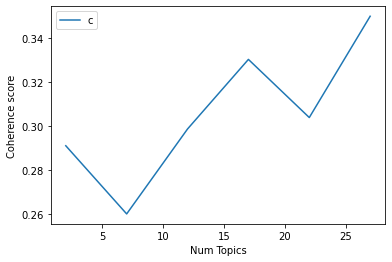

In [120]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_2018_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [121]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_2018_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.291
index: 1 | Num Topics = 7  has Coherence Value of 0.26
index: 2 | Num Topics = 12  has Coherence Value of 0.2986
index: 3 | Num Topics = 17  has Coherence Value of 0.3302
index: 4 | Num Topics = 22  has Coherence Value of 0.3038
index: 5 | Num Topics = 27  has Coherence Value of 0.3498


In [179]:
# Select optimal number of topics
optimal_model_us_2018_score1N2N3 = model_list_us_2018_score1N2N3[5]

In [180]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_2018_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_us_2018_score1N2N3, corpus_us_2018_score1N2N3, id2word_us_2018_score1N2N3)

In [181]:
print("pyLDAVis for us topics for score=1,2,3 in 2018:")
vis_us_2018_score1N2N3

pyLDAVis for us topics for score=1,2,3 in 2018:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.193280 -0.029183       1        1  15.287576
0     -0.087453  0.029857       2        1   8.018498
23    -0.099360 -0.019847       3        1   7.707020
24    -0.162382 -0.059961       4        1   6.990407
13    -0.104207 -0.006453       5        1   6.119592
17    -0.120015 -0.040354       6        1   6.047677
8     -0.105283  0.050439       7        1   5.759941
20    -0.094757 -0.044305       8        1   5.376125
25    -0.072697  0.051877       9        1   4.167876
12    -0.017021  0.226979      10        1   3.743482
9     -0.087743 -0.029288      11        1   3.733557
11    -0.033049  0.073581      12        1   3.712314
7     -0.070184  0.011438      13        1   3.519274
2      0.015661 -0.013077      14        1   2.980870
14    -0.032786 -0.040702      15        1   2.945565
4     -0.020289 -0.002619      16        1   2.711683
26    -0.032818  0.037416      17        1   2.701513
19     0.074445 -0.163169      18        1   2.063300
21     0.116990  0.023817      19        1   1.633114
10     0.013041 -0.056492      20        1   1.305836
16     0.241222  0.000273      21        1   0.855993
18     0.086888 -0.010664      22        1   0.843937
3      0.115884  0.007766      23        1   0.799359
22     0.121039  0.019526      24        1   0.413072
15     0.177490 -0.002743      25        1   0.386039
1      0.185332 -0.007055      26        1   0.088189
5      0.185332 -0.007055      27        1   0.088189, topic_info=          Term        Freq       Total Category  logprob  loglift
220     delete   32.000000   32.000000  Default  30.0000  30.0000
68      screen  166.000000  166.000000  Default  29.0000  29.0000
31       video  605.000000  605.000000  Default  28.0000  28.0000
25      search   42.000000   42.000000  Default  27.0000  27.0000
97    playlist   48.000000   48.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
25      search    0.005469   42.126203  Topic27  -7.4889  -1.9158
26      second    0.005469   62.944120  Topic27  -7.4889  -2.3174
27        side    0.005469   12.550199  Topic27  -7.4889  -0.7049
28   sometimes    0.005469   38.046290  Topic27  -7.4889  -1.8139
29         tab    0.005469    6.945161  Topic27  -7.4889  -0.1132

[1726 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1743     17  0.637859    aaargh
0         1  0.328350   ability
0         7  0.164175   ability
0         9  0.164175   ability
0        13  0.164175   ability
...     ...       ...       ...
77        7  0.323386  youtuber
77        9  0.080846  youtuber
77       12  0.080846  youtuber
1150      5  0.242986      zoom
1150     16  0.728958      zoom

[3521 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 24, 25, 14, 18, 9, 21, 26, 13, 10, 12, 8, 3, 15, 5, 27, 20, 22, 11, 17, 19, 4, 23, 16, 2, 6])

## By-rating of 2019 (Rating=1,2,3)

In [125]:
# By-rating Topic Modelling - rating = 1,2,3 in 2019
# Convert to list - move to each section
review_us_2019_score1N2N3 = youtube_ios_us_review_YearMonth_2019_score1N2N3.review.values.tolist()
review_words_us_2019_score1N2N3 = list(sent_to_words(review_us_2019_score1N2N3))
print(review_words_us_2019_score1N2N3[:1])

[['this', 'app', 'is', 'great', 'but', 'think', 'you', 'guys', 'can', 'bring', 'it', 'to', 'an', 'entirely', 'higher', 'level', 'listen', 'to', 'music', 'on', 'the', 'app', 'allot', 'of', 'times', 'but', 'then', 'while', 'listening', 'to', 'music', 'have', 'to', 'go', 'off', 'it', 'for', 'any', 'reason', 'and', 'have', 'to', 'stop', 'listening', 'to', 'this', 'music', 'what', 'getting', 'at', 'is', 'that', 'if', 'the', 'music', 'would', 'continue', 'while', 'out', 'of', 'the', 'app', 'seriously', 'would', 'enjoy', 'is', 'allot', 'more', 'hope', 'you', 'll', 'read', 'this', 'and', 'help', 'us', 'out', 'here', 'who', 'like', 'to', 'listen', 'to', 'music', 'outside', 'of', 'the', 'app', 'whilst', 'still', 'using', 'it']]


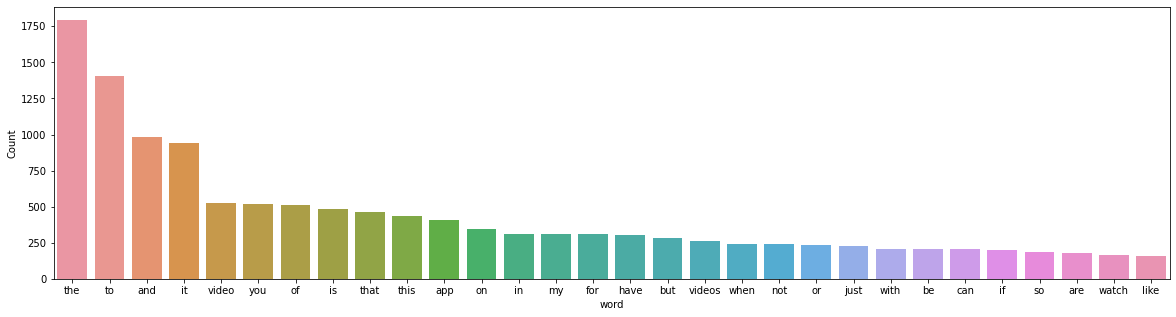

In [126]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_2019_score1N2N3))

In [127]:
# Clean text
review_words_us_ready_2019_score1N2N3 = process_words(review_words_us_2019_score1N2N3)  # processed Text Data! - move to each section

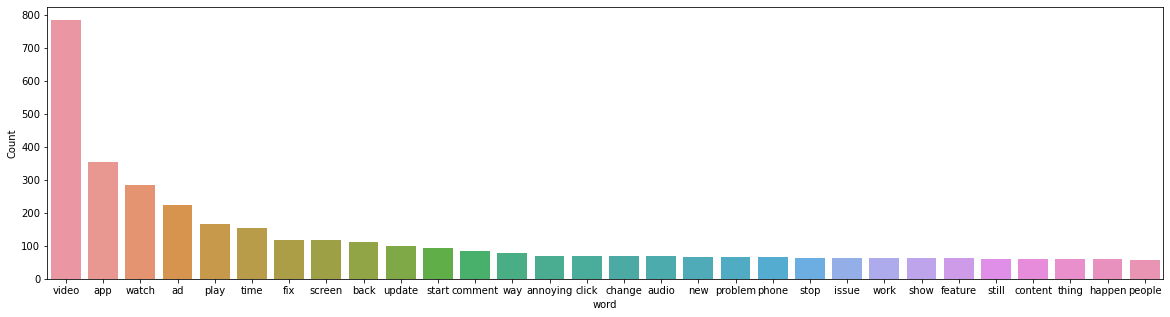

In [128]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_us_ready_2019_score1N2N3))


In [129]:
# Create Dictionary
id2word_us_2019_score1N2N3 = corpora.Dictionary(review_words_us_ready_2019_score1N2N3)

2021-10-17 01:55:46,723 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 01:55:46,802 [INFO] gensim.corpora.dictionary - built Dictionary(2246 unique tokens: ['allot', 'app', 'bring', 'continue', 'enjoy']...) from 321 documents (total 13429 corpus positions)
2021-10-17 01:55:46,814 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(2246 unique tokens: ['allot', 'app', 'bring', 'continue', 'enjoy']...) from 321 documents (total 13429 corpus positions)", 'datetime': '2021-10-17T01:55:46.814176', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [130]:
# Create Corpus: Term Document Frequency
corpus_us_2019_score1N2N3 = [id2word_us_2019_score1N2N3.doc2bow(text) for text in review_words_us_ready_2019_score1N2N3]

In [131]:
# Training LDA model
model_list_us_2019_score1N2N3, coherence_values_us_2019_score1N2N3 = compute_coherence_values(dictionary=id2word_us_2019_score1N2N3, corpus=corpus_us_2019_score1N2N3, 
                                                              texts=review_words_us_ready_2019_score1N2N3, limit=30, start=2, step=5)


2021-10-17 01:55:46,900 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 01:55:46,901 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 01:55:46,904 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 01:55:46,907 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 321 documents, updating model once every 321 documents, evaluating perplexity every 321 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 01:55:48,404 [INFO] gensim.models.ldamodel - -8.228 per-word bound, 299.9 perplexity estimate based on a held-out corpus of 321 documents with 13429 words
2021-10-17 01:55:48,406 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #321/321
2021-10-17 01:55:49,575 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"video" + 0.028*"app" + 0.020*"ad" + 0.015*"watch" + 0.012*"play" + 0.010*"time" + 0.009*"screen"

2021-10-17 01:56:08,510 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.075*"video" + 0.024*"watch" + 0.018*"app" + 0.012*"play" + 0.010*"time" + 0.009*"update" + 0.009*"fix" + 0.008*"screen" + 0.007*"start" + 0.007*"back"
2021-10-17 01:56:08,511 [INFO] gensim.models.ldamodel - topic diff=0.017735, rho=0.301511
2021-10-17 01:56:09,512 [INFO] gensim.models.ldamodel - -6.730 per-word bound, 106.2 perplexity estimate based on a held-out corpus of 321 documents with 13429 words
2021-10-17 01:56:09,513 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #321/321
2021-10-17 01:56:10,342 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"app" + 0.029*"ad" + 0.017*"video" + 0.010*"watch" + 0.010*"time" + 0.008*"comment" + 0.008*"play" + 0.007*"back" + 0.007*"screen" + 0.006*"fix"
2021-10-17 01:56:10,354 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.075*"video" + 0.024*"watch" + 0.018*"app" + 0.013*"play" + 0.010*"time" + 0.009*"update" + 0.009*"fix" + 0.008*"screen" 

2021-10-17 01:56:30,011 [INFO] gensim.models.ldamodel - topic diff=0.010421, rho=0.218218
2021-10-17 01:56:31,011 [INFO] gensim.models.ldamodel - -6.721 per-word bound, 105.5 perplexity estimate based on a held-out corpus of 321 documents with 13429 words
2021-10-17 01:56:31,012 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #321/321
2021-10-17 01:56:31,774 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.032*"ad" + 0.028*"app" + 0.013*"video" + 0.009*"time" + 0.009*"watch" + 0.008*"comment" + 0.007*"back" + 0.007*"pay" + 0.007*"play" + 0.006*"music"
2021-10-17 01:56:31,776 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.075*"video" + 0.025*"watch" + 0.019*"app" + 0.013*"play" + 0.011*"time" + 0.009*"fix" + 0.009*"update" + 0.009*"screen" + 0.007*"start" + 0.007*"back"
2021-10-17 01:56:31,779 [INFO] gensim.models.ldamodel - topic diff=0.010236, rho=0.213201
2021-10-17 01:56:32,776 [INFO] gensim.models.ldamodel - -6.720 per-word bound, 105.4 perplexity estimate ba

2021-10-17 01:56:47,804 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #321/321
2021-10-17 01:56:48,432 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.033*"ad" + 0.025*"app" + 0.010*"video" + 0.008*"comment" + 0.008*"pay" + 0.008*"watch" + 0.008*"time" + 0.007*"back" + 0.006*"music" + 0.006*"play"
2021-10-17 01:56:48,434 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.074*"video" + 0.025*"watch" + 0.021*"app" + 0.013*"play" + 0.011*"time" + 0.010*"fix" + 0.010*"screen" + 0.010*"update" + 0.008*"start" + 0.007*"back"
2021-10-17 01:56:48,437 [INFO] gensim.models.ldamodel - topic diff=0.009733, rho=0.176777
2021-10-17 01:56:49,449 [INFO] gensim.models.ldamodel - -6.711 per-word bound, 104.8 perplexity estimate based on a held-out corpus of 321 documents with 13429 words
2021-10-17 01:56:49,451 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #321/321
2021-10-17 01:56:50,172 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.033*"ad" + 0.025*"app" + 

2021-10-17 01:57:03,791 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.074*"video" + 0.025*"watch" + 0.023*"app" + 0.014*"play" + 0.012*"time" + 0.010*"fix" + 0.010*"screen" + 0.010*"update" + 0.008*"start" + 0.007*"back"
2021-10-17 01:57:03,793 [INFO] gensim.models.ldamodel - topic diff=0.008774, rho=0.154303
2021-10-17 01:57:04,765 [INFO] gensim.models.ldamodel - -6.703 per-word bound, 104.2 perplexity estimate based on a held-out corpus of 321 documents with 13429 words
2021-10-17 01:57:04,767 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #321/321
2021-10-17 01:57:05,424 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.034*"ad" + 0.022*"app" + 0.009*"video" + 0.008*"pay" + 0.008*"comment" + 0.007*"watch" + 0.007*"back" + 0.007*"time" + 0.007*"music" + 0.006*"premium"
2021-10-17 01:57:05,426 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.074*"video" + 0.025*"watch" + 0.023*"app" + 0.014*"play" + 0.012*"time" + 0.010*"fix" + 0.010*"screen" + 0.010*"update

2021-10-17 01:57:22,638 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 320 virtual documents
2021-10-17 01:57:22,951 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-17 01:57:22,953 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-17 01:57:22,959 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 01:57:22,969 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 321 documents, updating model once every 321 documents, evaluating perplexity every 321 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 01:57:24,532 [INFO] gensim.models.ldamodel - -9.374 per-word bound, 663.4 perplexity estimate based on a held-out corpus of 321 documents with 13429 words
2021-10-17 01:57:24,534 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #321/321
2021-10-17 01:5

2021-10-17 01:57:31,926 [INFO] gensim.models.ldamodel - -6.858 per-word bound, 116.0 perplexity estimate based on a held-out corpus of 321 documents with 13429 words
2021-10-17 01:57:31,927 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #321/321
2021-10-17 01:57:32,651 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.086*"video" + 0.030*"watch" + 0.027*"app" + 0.019*"ad" + 0.016*"play" + 0.014*"time" + 0.012*"back" + 0.011*"fix" + 0.010*"start" + 0.009*"screen"
2021-10-17 01:57:32,658 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.018*"app" + 0.016*"music" + 0.013*"screen" + 0.011*"play" + 0.010*"work" + 0.010*"watch" + 0.010*"song" + 0.009*"fix" + 0.008*"commercial" + 0.007*"bug"
2021-10-17 01:57:32,668 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.016*"ad" + 0.015*"comment" + 0.010*"video" + 0.008*"channel" + 0.007*"content" + 0.007*"pay" + 0.007*"time" + 0.006*"screen" + 0.006*"watch" + 0.005*"page"
2021-10-17 01:57:32,672 [INFO] gensim.models.ldamodel -

2021-10-17 01:57:38,861 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.010*"fact" + 0.007*"hang" + 0.006*"maybe" + 0.006*"utube" + 0.006*"search" + 0.006*"check" + 0.006*"little" + 0.005*"content" + 0.005*"ban" + 0.005*"company"
2021-10-17 01:57:38,863 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.015*"comment" + 0.015*"ad" + 0.008*"channel" + 0.008*"content" + 0.007*"pay" + 0.005*"page" + 0.005*"screen" + 0.005*"time" + 0.005*"subscribe" + 0.005*"political"
2021-10-17 01:57:38,864 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.018*"app" + 0.017*"music" + 0.013*"screen" + 0.011*"song" + 0.011*"play" + 0.010*"work" + 0.009*"watch" + 0.009*"fix" + 0.008*"commercial" + 0.008*"guy"
2021-10-17 01:57:38,865 [INFO] gensim.models.ldamodel - topic diff=0.026101, rho=0.288675
2021-10-17 01:57:39,554 [INFO] gensim.models.ldamodel - -6.830 per-word bound, 113.8 perplexity estimate based on a held-out corpus of 321 documents with 13429 words
2021-10-17 01:57:39,556 [INFO] gensim.mod

2021-10-17 01:57:44,962 [INFO] gensim.models.ldamodel - topic diff=0.012272, rho=0.242536
2021-10-17 01:57:45,626 [INFO] gensim.models.ldamodel - -6.822 per-word bound, 113.2 perplexity estimate based on a held-out corpus of 321 documents with 13429 words
2021-10-17 01:57:45,628 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #321/321
2021-10-17 01:57:46,117 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.020*"change" + 0.017*"people" + 0.015*"video" + 0.012*"name" + 0.010*"content" + 0.009*"channel" + 0.008*"tube" + 0.006*"pay" + 0.006*"watch" + 0.006*"issue"
2021-10-17 01:57:46,123 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.018*"app" + 0.018*"music" + 0.012*"song" + 0.012*"screen" + 0.010*"play" + 0.010*"work" + 0.009*"watch" + 0.009*"fix" + 0.008*"commercial" + 0.008*"guy"
2021-10-17 01:57:46,131 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.011*"video" + 0.010*"platform" + 0.010*"content" + 0.007*"year" + 0.006*"ipad" + 0.006*"notification" + 0.006

2021-10-17 01:57:52,206 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.011*"video" + 0.010*"platform" + 0.010*"content" + 0.007*"year" + 0.006*"notification" + 0.006*"feed" + 0.006*"safari" + 0.006*"ipad" + 0.006*"really" + 0.006*"remove"
2021-10-17 01:57:52,209 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.010*"fact" + 0.008*"hang" + 0.006*"maybe" + 0.006*"search" + 0.006*"check" + 0.006*"utube" + 0.006*"ban" + 0.006*"little" + 0.005*"content" + 0.005*"view"
2021-10-17 01:57:52,211 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.020*"change" + 0.017*"people" + 0.014*"video" + 0.012*"name" + 0.010*"content" + 0.009*"channel" + 0.008*"tube" + 0.006*"pay" + 0.006*"money" + 0.006*"issue"
2021-10-17 01:57:52,214 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.016*"comment" + 0.014*"ad" + 0.008*"content" + 0.008*"channel" + 0.007*"pay" + 0.005*"page" + 0.005*"subscribe" + 0.005*"political" + 0.005*"favorite" + 0.005*"screen"
2021-10-17 01:57:52,216 [INFO] gensim.models.ld

2021-10-17 01:57:58,266 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.036*"app" + 0.029*"video" + 0.021*"ad" + 0.011*"update" + 0.010*"time" + 0.010*"play" + 0.009*"pay" + 0.008*"watch" + 0.008*"comment" + 0.008*"way"
2021-10-17 01:57:58,267 [INFO] gensim.models.ldamodel - topic diff=0.004958, rho=0.188982
2021-10-17 01:57:58,880 [INFO] gensim.models.ldamodel - -6.816 per-word bound, 112.6 perplexity estimate based on a held-out corpus of 321 documents with 13429 words
2021-10-17 01:57:58,885 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #321/321
2021-10-17 01:57:59,431 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.011*"fact" + 0.008*"hang" + 0.006*"maybe" + 0.006*"search" + 0.006*"check" + 0.006*"utube" + 0.006*"ban" + 0.006*"little" + 0.005*"content" + 0.005*"user"
2021-10-17 01:57:59,434 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.015*"comment" + 0.013*"ad" + 0.008*"content" + 0.008*"channel" + 0.007*"pay" + 0.006*"page" + 0.005*"subscribe" + 0.0

2021-10-17 01:58:05,554 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.020*"change" + 0.017*"people" + 0.013*"video" + 0.012*"name" + 0.010*"content" + 0.009*"channel" + 0.008*"tube" + 0.006*"pay" + 0.006*"money" + 0.006*"issue"
2021-10-17 01:58:05,555 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.011*"fact" + 0.008*"hang" + 0.006*"search" + 0.006*"maybe" + 0.006*"check" + 0.006*"utube" + 0.006*"ban" + 0.006*"little" + 0.005*"content" + 0.005*"user"
2021-10-17 01:58:05,557 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.015*"comment" + 0.012*"ad" + 0.008*"content" + 0.008*"channel" + 0.007*"pay" + 0.006*"page" + 0.005*"political" + 0.005*"subscribe" + 0.005*"favorite" + 0.005*"post"
2021-10-17 01:58:05,559 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.036*"app" + 0.028*"video" + 0.022*"ad" + 0.011*"update" + 0.010*"time" + 0.009*"play" + 0.009*"pay" + 0.008*"watch" + 0.008*"comment" + 0.008*"way"
2021-10-17 01:58:05,561 [INFO] gensim.models.ldamodel - topic diff=0.

2021-10-17 01:58:11,601 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.086*"video" + 0.030*"watch" + 0.027*"app" + 0.018*"ad" + 0.016*"play" + 0.014*"time" + 0.011*"fix" + 0.011*"back" + 0.010*"screen" + 0.010*"start"
2021-10-17 01:58:11,602 [INFO] gensim.models.ldamodel - topic diff=0.002679, rho=0.160128
2021-10-17 01:58:12,302 [INFO] gensim.models.ldamodel - -6.813 per-word bound, 112.4 perplexity estimate based on a held-out corpus of 321 documents with 13429 words
2021-10-17 01:58:12,310 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #321/321
2021-10-17 01:58:12,710 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.011*"video" + 0.011*"platform" + 0.010*"content" + 0.007*"year" + 0.006*"notification" + 0.006*"feed" + 0.006*"safari" + 0.006*"remove" + 0.006*"tab" + 0.006*"really"
2021-10-17 01:58:12,712 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.086*"video" + 0.030*"watch" + 0.027*"app" + 0.018*"ad" + 0.016*"play" + 0.014*"time" + 0.011*"fix" + 0.011

2021-10-17 01:58:18,918 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.018*"app" + 0.018*"music" + 0.013*"song" + 0.011*"screen" + 0.010*"play" + 0.010*"work" + 0.009*"fix" + 0.009*"watch" + 0.009*"commercial" + 0.008*"guy"
2021-10-17 01:58:18,920 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.020*"change" + 0.018*"people" + 0.013*"name" + 0.012*"video" + 0.010*"content" + 0.009*"channel" + 0.008*"tube" + 0.006*"pay" + 0.006*"money" + 0.006*"issue"
2021-10-17 01:58:18,922 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.011*"video" + 0.011*"platform" + 0.010*"content" + 0.007*"year" + 0.006*"notification" + 0.006*"feed" + 0.006*"safari" + 0.006*"remove" + 0.006*"tab" + 0.006*"really"
2021-10-17 01:58:18,923 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.014*"comment" + 0.011*"ad" + 0.008*"content" + 0.007*"channel" + 0.007*"pay" + 0.006*"page" + 0.005*"political" + 0.005*"favorite" + 0.005*"post" + 0.005*"subscribe"
2021-10-17 01:58:18,926 [INFO] gensim.models.ldamode

2021-10-17 01:58:25,162 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.036*"app" + 0.027*"video" + 0.022*"ad" + 0.010*"update" + 0.010*"time" + 0.010*"pay" + 0.009*"play" + 0.008*"watch" + 0.007*"comment" + 0.007*"way"
2021-10-17 01:58:25,164 [INFO] gensim.models.ldamodel - topic diff=0.001802, rho=0.141421
2021-10-17 01:58:25,898 [INFO] gensim.models.ldamodel - -6.810 per-word bound, 112.2 perplexity estimate based on a held-out corpus of 321 documents with 13429 words
2021-10-17 01:58:25,903 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #321/321
2021-10-17 01:58:26,426 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.086*"video" + 0.030*"watch" + 0.027*"app" + 0.018*"ad" + 0.016*"play" + 0.014*"time" + 0.011*"fix" + 0.011*"back" + 0.010*"screen" + 0.009*"start"
2021-10-17 01:58:26,428 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.014*"comment" + 0.011*"ad" + 0.008*"content" + 0.007*"channel" + 0.007*"pay" + 0.006*"page" + 0.006*"political" + 0.005*"favo

2021-10-17 01:58:40,581 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.028*"video" + 0.014*"content" + 0.011*"people" + 0.010*"change" + 0.009*"watch" + 0.008*"upload" + 0.008*"issue" + 0.007*"pay" + 0.007*"channel" + 0.007*"tube"
2021-10-17 01:58:40,583 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.045*"app" + 0.027*"video" + 0.021*"ad" + 0.012*"time" + 0.012*"watch" + 0.011*"update" + 0.009*"play" + 0.008*"song" + 0.007*"back" + 0.006*"problem"
2021-10-17 01:58:40,586 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.088*"video" + 0.025*"watch" + 0.015*"app" + 0.013*"comment" + 0.012*"play" + 0.012*"update" + 0.011*"fix" + 0.011*"back" + 0.011*"annoying" + 0.010*"screen"
2021-10-17 01:58:40,588 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.083*"video" + 0.033*"watch" + 0.031*"app" + 0.027*"ad" + 0.018*"time" + 0.018*"play" + 0.012*"back" + 0.011*"fix" + 0.011*"audio" + 0.010*"screen"
2021-10-17 01:58:40,590 [INFO] gensim.models.ldamodel - topic diff=0.243902, rho=

2021-10-17 01:58:46,369 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.046*"app" + 0.022*"video" + 0.022*"ad" + 0.012*"watch" + 0.012*"time" + 0.011*"update" + 0.009*"play" + 0.009*"song" + 0.007*"pay" + 0.007*"commercial"
2021-10-17 01:58:46,373 [INFO] gensim.models.ldamodel - topic diff=0.056347, rho=0.316228
2021-10-17 01:58:47,062 [INFO] gensim.models.ldamodel - -6.923 per-word bound, 121.3 perplexity estimate based on a held-out corpus of 321 documents with 13429 words
2021-10-17 01:58:47,063 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #321/321
2021-10-17 01:58:47,530 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.027*"app" + 0.016*"fix" + 0.014*"screen" + 0.013*"music" + 0.013*"bug" + 0.010*"play" + 0.009*"guy" + 0.008*"comment" + 0.008*"happen" + 0.008*"work"
2021-10-17 01:58:47,532 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.025*"video" + 0.022*"ad" + 0.017*"phone" + 0.011*"pay" + 0.011*"screen" + 0.011*"watch" + 0.010*"play" + 0.009*"channe

2021-10-17 01:58:53,923 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.020*"change" + 0.019*"name" + 0.018*"video" + 0.015*"content" + 0.013*"platform" + 0.009*"people" + 0.008*"remove" + 0.007*"feed" + 0.007*"decision" + 0.007*"publisher"
2021-10-17 01:58:53,924 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.018*"people" + 0.011*"search" + 0.011*"fact" + 0.009*"opinion" + 0.009*"check" + 0.009*"find" + 0.009*"company" + 0.007*"leave" + 0.007*"content" + 0.007*"manipulating"
2021-10-17 01:58:53,926 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.047*"app" + 0.022*"ad" + 0.020*"video" + 0.012*"watch" + 0.012*"time" + 0.011*"update" + 0.010*"song" + 0.010*"play" + 0.007*"pay" + 0.007*"commercial"
2021-10-17 01:58:53,927 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.087*"video" + 0.024*"watch" + 0.014*"app" + 0.013*"comment" + 0.012*"screen" + 0.012*"update" + 0.011*"fix" + 0.011*"back" + 0.011*"annoying" + 0.011*"play"
2021-10-17 01:58:53,928 [INFO] gensim.models.lda

2021-10-17 01:59:00,786 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.027*"app" + 0.016*"fix" + 0.013*"music" + 0.013*"bug" + 0.012*"screen" + 0.010*"guy" + 0.009*"comment" + 0.008*"happen" + 0.008*"look" + 0.008*"work"
2021-10-17 01:59:00,786 [INFO] gensim.models.ldamodel - topic diff=0.009484, rho=0.218218
2021-10-17 01:59:01,616 [INFO] gensim.models.ldamodel - -6.898 per-word bound, 119.2 perplexity estimate based on a held-out corpus of 321 documents with 13429 words
2021-10-17 01:59:01,621 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #321/321
2021-10-17 01:59:02,185 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.010*"hang" + 0.010*"premium" + 0.010*"maybe" + 0.010*"utube" + 0.009*"show" + 0.008*"help" + 0.008*"way" + 0.006*"channel" + 0.006*"little" + 0.006*"idea"
2021-10-17 01:59:02,186 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.087*"video" + 0.033*"watch" + 0.032*"app" + 0.027*"ad" + 0.020*"play" + 0.017*"time" + 0.012*"audio" + 0.012*"fix" 

2021-10-17 01:59:09,071 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.023*"ad" + 0.018*"phone" + 0.013*"video" + 0.012*"pay" + 0.011*"screen" + 0.009*"watch" + 0.009*"channel" + 0.008*"second" + 0.008*"play" + 0.008*"time"
2021-10-17 01:59:09,073 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.010*"hang" + 0.010*"premium" + 0.010*"maybe" + 0.010*"utube" + 0.009*"show" + 0.008*"help" + 0.008*"way" + 0.006*"channel" + 0.006*"little" + 0.006*"idea"
2021-10-17 01:59:09,076 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.087*"video" + 0.024*"watch" + 0.014*"app" + 0.013*"comment" + 0.013*"screen" + 0.012*"update" + 0.011*"playlist" + 0.011*"fix" + 0.011*"back" + 0.011*"annoying"
2021-10-17 01:59:09,078 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.018*"people" + 0.011*"search" + 0.011*"fact" + 0.009*"opinion" + 0.009*"check" + 0.009*"find" + 0.009*"company" + 0.007*"leave" + 0.007*"content" + 0.007*"manipulating"
2021-10-17 01:59:09,080 [INFO] gensim.models.ldamodel - 

2021-10-17 01:59:15,633 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.027*"app" + 0.017*"fix" + 0.014*"bug" + 0.013*"music" + 0.011*"screen" + 0.010*"guy" + 0.009*"comment" + 0.008*"happen" + 0.008*"look" + 0.008*"work"
2021-10-17 01:59:15,636 [INFO] gensim.models.ldamodel - topic diff=0.004894, rho=0.176777
2021-10-17 01:59:16,404 [INFO] gensim.models.ldamodel - -6.885 per-word bound, 118.2 perplexity estimate based on a held-out corpus of 321 documents with 13429 words
2021-10-17 01:59:16,409 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #321/321
2021-10-17 01:59:16,915 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.010*"hang" + 0.010*"premium" + 0.010*"utube" + 0.010*"maybe" + 0.009*"show" + 0.008*"help" + 0.008*"way" + 0.006*"channel" + 0.006*"little" + 0.006*"idea"
2021-10-17 01:59:16,920 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.087*"video" + 0.033*"watch" + 0.032*"app" + 0.026*"ad" + 0.020*"play" + 0.017*"time" + 0.012*"audio" + 0.012*"fix" 

2021-10-17 01:59:24,058 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.017*"give" + 0.015*"link" + 0.014*"app" + 0.014*"download" + 0.013*"search" + 0.013*"open" + 0.013*"safari" + 0.010*"option" + 0.010*"instead" + 0.010*"ban"
2021-10-17 01:59:24,061 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.020*"video" + 0.016*"claim" + 0.011*"app" + 0.010*"pay" + 0.009*"type" + 0.009*"tube" + 0.008*"search" + 0.008*"keep" + 0.008*"show" + 0.007*"thing"
2021-10-17 01:59:24,062 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.019*"ad" + 0.011*"play" + 0.011*"content" + 0.011*"screen" + 0.009*"less" + 0.008*"bad" + 0.008*"app" + 0.008*"channel" + 0.007*"change" + 0.007*"page"
2021-10-17 01:59:24,066 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.047*"app" + 0.023*"ad" + 0.017*"video" + 0.012*"song" + 0.012*"time" + 0.012*"watch" + 0.010*"play" + 0.010*"update" + 0.007*"commercial" + 0.007*"pay"
2021-10-17 01:59:24,067 [INFO] gensim.models.ldamodel - topic diff=0.003615, rho=0.162

2021-10-17 01:59:29,915 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.047*"app" + 0.023*"ad" + 0.017*"video" + 0.012*"song" + 0.012*"time" + 0.011*"watch" + 0.010*"play" + 0.010*"update" + 0.007*"commercial" + 0.007*"pay"
2021-10-17 01:59:29,916 [INFO] gensim.models.ldamodel - topic diff=0.002864, rho=0.152499
2021-10-17 01:59:30,571 [INFO] gensim.models.ldamodel - -6.880 per-word bound, 117.8 perplexity estimate based on a held-out corpus of 321 documents with 13429 words
2021-10-17 01:59:30,573 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #321/321
2021-10-17 01:59:31,004 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.010*"premium" + 0.010*"hang" + 0.010*"utube" + 0.010*"maybe" + 0.009*"show" + 0.008*"help" + 0.008*"way" + 0.006*"channel" + 0.006*"little" + 0.006*"idea"
2021-10-17 01:59:31,007 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.085*"video" + 0.024*"watch" + 0.014*"app" + 0.013*"screen" + 0.013*"comment" + 0.012*"update" + 0.012*"playlist"

2021-10-17 01:59:36,594 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.017*"give" + 0.015*"link" + 0.014*"app" + 0.014*"download" + 0.013*"search" + 0.013*"open" + 0.013*"safari" + 0.010*"option" + 0.010*"instead" + 0.010*"ban"
2021-10-17 01:59:36,600 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.027*"app" + 0.017*"fix" + 0.014*"bug" + 0.013*"music" + 0.010*"screen" + 0.010*"guy" + 0.009*"comment" + 0.008*"look" + 0.008*"work" + 0.008*"happen"
2021-10-17 01:59:36,605 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.085*"video" + 0.024*"watch" + 0.014*"app" + 0.013*"screen" + 0.013*"comment" + 0.012*"update" + 0.012*"playlist" + 0.011*"back" + 0.011*"fix" + 0.011*"annoying"
2021-10-17 01:59:36,608 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.024*"video" + 0.017*"content" + 0.013*"people" + 0.009*"channel" + 0.009*"change" + 0.009*"watch" + 0.008*"kid" + 0.007*"tube" + 0.007*"pay" + 0.007*"wish"
2021-10-17 01:59:36,612 [INFO] gensim.models.ldamodel - topic diff=0.00

2021-10-17 01:59:53,307 [INFO] gensim.models.ldamodel - topic diff=0.452879, rho=0.577350
2021-10-17 01:59:54,678 [INFO] gensim.models.ldamodel - -7.249 per-word bound, 152.2 perplexity estimate based on a held-out corpus of 321 documents with 13429 words
2021-10-17 01:59:54,679 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #321/321
2021-10-17 01:59:55,422 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.081*"video" + 0.059*"ad" + 0.036*"watch" + 0.014*"back" + 0.014*"feature" + 0.013*"swipe" + 0.013*"comment" + 0.012*"time" + 0.009*"update" + 0.008*"playlist"
2021-10-17 01:59:55,424 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.024*"video" + 0.019*"channel" + 0.014*"claim" + 0.014*"show" + 0.012*"instead" + 0.010*"quality" + 0.010*"watch" + 0.010*"feature" + 0.010*"search" + 0.009*"let"
2021-10-17 01:59:55,426 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.026*"app" + 0.021*"search" + 0.018*"option" + 0.015*"video" + 0.014*"open" + 0.013*"link" + 0.011*

2021-10-17 02:00:02,554 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.045*"app" + 0.030*"video" + 0.022*"ad" + 0.011*"watch" + 0.010*"problem" + 0.010*"pay" + 0.010*"update" + 0.008*"time" + 0.008*"fix" + 0.008*"play"
2021-10-17 02:00:02,562 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.027*"channel" + 0.024*"video" + 0.017*"show" + 0.016*"claim" + 0.011*"instead" + 0.011*"quality" + 0.010*"let" + 0.010*"search" + 0.010*"creator" + 0.010*"favorite"
2021-10-17 02:00:02,564 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.016*"ad" + 0.015*"ipad" + 0.014*"year" + 0.012*"bug" + 0.011*"content" + 0.010*"screen" + 0.009*"fix" + 0.009*"update" + 0.009*"app" + 0.008*"keyboard"
2021-10-17 02:00:02,565 [INFO] gensim.models.ldamodel - topic diff=0.098202, rho=0.333333
2021-10-17 02:00:03,418 [INFO] gensim.models.ldamodel - -7.029 per-word bound, 130.6 perplexity estimate based on a held-out corpus of 321 documents with 13429 words
2021-10-17 02:00:03,419 [INFO] gensim.models.ldamod

2021-10-17 02:00:09,286 [INFO] gensim.models.ldamodel - topic diff=0.029910, rho=0.267261
2021-10-17 02:00:10,032 [INFO] gensim.models.ldamodel - -7.005 per-word bound, 128.4 perplexity estimate based on a held-out corpus of 321 documents with 13429 words
2021-10-17 02:00:10,034 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #321/321
2021-10-17 02:00:10,552 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.011*"ban" + 0.011*"conclusion" + 0.011*"demonetize" + 0.006*"content" + 0.006*"truck" + 0.006*"rebel" + 0.006*"martyr" + 0.006*"derision" + 0.006*"move" + 0.006*"die"
2021-10-17 02:00:10,559 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.018*"corporate" + 0.014*"find" + 0.014*"leave" + 0.014*"opinion" + 0.014*"people" + 0.009*"site" + 0.009*"classify" + 0.009*"care" + 0.009*"matter" + 0.009*"scroll"
2021-10-17 02:00:10,564 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.025*"ad" + 0.018*"screen" + 0.016*"pay" + 0.016*"watch" + 0.013*"second" + 0.010*"time"

2021-10-17 02:00:16,705 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.027*"music" + 0.023*"app" + 0.016*"work" + 0.016*"people" + 0.011*"time" + 0.011*"audio" + 0.011*"look" + 0.010*"listen" + 0.010*"put" + 0.009*"guy"
2021-10-17 02:00:16,706 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.017*"issue" + 0.015*"content" + 0.013*"people" + 0.010*"app" + 0.010*"video" + 0.009*"pay" + 0.009*"reason" + 0.009*"tube" + 0.007*"allow" + 0.007*"guy"
2021-10-17 02:00:16,709 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.011*"ban" + 0.011*"conclusion" + 0.011*"demonetize" + 0.006*"content" + 0.006*"truck" + 0.006*"rebel" + 0.006*"martyr" + 0.006*"derision" + 0.006*"move" + 0.006*"die"
2021-10-17 02:00:16,712 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.086*"video" + 0.047*"app" + 0.031*"watch" + 0.023*"play" + 0.017*"time" + 0.016*"audio" + 0.016*"fix" + 0.014*"screen" + 0.014*"start" + 0.012*"ad"
2021-10-17 02:00:16,713 [INFO] gensim.models.ldamodel - topic diff=0.012063, rh

2021-10-17 02:00:22,905 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.045*"app" + 0.025*"video" + 0.022*"ad" + 0.011*"pay" + 0.011*"watch" + 0.010*"problem" + 0.008*"play" + 0.008*"update" + 0.008*"time" + 0.008*"phone"
2021-10-17 02:00:22,907 [INFO] gensim.models.ldamodel - topic diff=0.007620, rho=0.200000
2021-10-17 02:00:23,621 [INFO] gensim.models.ldamodel - -6.984 per-word bound, 126.6 perplexity estimate based on a held-out corpus of 321 documents with 13429 words
2021-10-17 02:00:23,623 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #321/321
2021-10-17 02:00:24,066 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.017*"issue" + 0.015*"content" + 0.013*"people" + 0.010*"app" + 0.010*"video" + 0.009*"pay" + 0.009*"reason" + 0.009*"tube" + 0.008*"allow" + 0.008*"guy"
2021-10-17 02:00:24,068 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.016*"hang" + 0.013*"maybe" + 0.013*"utube" + 0.010*"little" + 0.010*"premium" + 0.009*"opinion" + 0.009*"idea" + 0.00

2021-10-17 02:00:29,922 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.040*"video" + 0.035*"change" + 0.033*"song" + 0.027*"play" + 0.018*"name" + 0.017*"app" + 0.016*"playlist" + 0.012*"screen" + 0.011*"shuffle" + 0.010*"watch"
2021-10-17 02:00:29,924 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.088*"ad" + 0.083*"video" + 0.035*"watch" + 0.033*"back" + 0.026*"comment" + 0.020*"swipe" + 0.018*"feature" + 0.012*"time" + 0.011*"scroll" + 0.009*"minute"
2021-10-17 02:00:29,927 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.011*"ban" + 0.011*"conclusion" + 0.011*"demonetize" + 0.006*"content" + 0.006*"truck" + 0.006*"rebel" + 0.006*"martyr" + 0.006*"derision" + 0.006*"move" + 0.006*"die"
2021-10-17 02:00:29,930 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.020*"ad" + 0.019*"screen" + 0.017*"pay" + 0.016*"watch" + 0.013*"second" + 0.009*"phone" + 0.009*"time" + 0.009*"entire" + 0.009*"change" + 0.009*"tap"
2021-10-17 02:00:29,931 [INFO] gensim.models.ldamodel - top

2021-10-17 02:00:36,017 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.016*"hang" + 0.013*"maybe" + 0.013*"utube" + 0.010*"little" + 0.010*"premium" + 0.008*"opinion" + 0.008*"idea" + 0.007*"show" + 0.007*"sure" + 0.007*"download"
2021-10-17 02:00:36,021 [INFO] gensim.models.ldamodel - topic diff=0.004779, rho=0.166667
2021-10-17 02:00:36,860 [INFO] gensim.models.ldamodel - -6.973 per-word bound, 125.7 perplexity estimate based on a held-out corpus of 321 documents with 13429 words
2021-10-17 02:00:36,862 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #321/321
2021-10-17 02:00:37,272 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.016*"issue" + 0.015*"content" + 0.013*"people" + 0.010*"app" + 0.010*"video" + 0.009*"pay" + 0.009*"reason" + 0.009*"tube" + 0.008*"allow" + 0.008*"guy"
2021-10-17 02:00:37,276 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.095*"video" + 0.020*"watch" + 0.016*"back" + 0.016*"click" + 0.015*"app" + 0.012*"update" + 0.011*"screen"

2021-10-17 02:00:42,942 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.048*"video" + 0.015*"watch" + 0.013*"time" + 0.012*"tap" + 0.009*"play" + 0.008*"next" + 0.008*"annoying" + 0.008*"show" + 0.008*"new" + 0.007*"change"
2021-10-17 02:00:42,943 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.016*"ad" + 0.015*"content" + 0.014*"year" + 0.014*"ipad" + 0.011*"bug" + 0.009*"screen" + 0.009*"fix" + 0.008*"update" + 0.008*"app" + 0.008*"keyboard"
2021-10-17 02:00:42,946 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.016*"issue" + 0.015*"content" + 0.013*"people" + 0.010*"app" + 0.010*"video" + 0.009*"pay" + 0.009*"reason" + 0.009*"tube" + 0.008*"allow" + 0.008*"guy"
2021-10-17 02:00:42,949 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.011*"ban" + 0.011*"conclusion" + 0.011*"demonetize" + 0.006*"content" + 0.006*"truck" + 0.006*"rebel" + 0.006*"martyr" + 0.006*"derision" + 0.006*"person" + 0.006*"move"
2021-10-17 02:00:42,952 [INFO] gensim.models.ldamodel - topic #14 (0

2021-10-17 02:00:48,384 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.016*"ad" + 0.016*"content" + 0.014*"year" + 0.014*"ipad" + 0.011*"bug" + 0.009*"screen" + 0.009*"fix" + 0.008*"update" + 0.008*"app" + 0.008*"keyboard"
2021-10-17 02:00:48,386 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.044*"app" + 0.023*"ad" + 0.022*"video" + 0.012*"pay" + 0.010*"watch" + 0.009*"problem" + 0.008*"play" + 0.008*"way" + 0.007*"premium" + 0.007*"time"
2021-10-17 02:00:48,391 [INFO] gensim.models.ldamodel - topic diff=0.003445, rho=0.145865
2021-10-17 02:00:49,089 [INFO] gensim.models.ldamodel - -6.965 per-word bound, 124.9 perplexity estimate based on a held-out corpus of 321 documents with 13429 words
2021-10-17 02:00:49,090 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #321/321
2021-10-17 02:00:49,610 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.094*"video" + 0.020*"watch" + 0.016*"click" + 0.016*"back" + 0.014*"app" + 0.012*"update" + 0.011*"screen" + 0.011*"pl

2021-10-17 02:01:02,664 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #321/321
2021-10-17 02:01:03,812 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.072*"video" + 0.039*"ad" + 0.033*"watch" + 0.012*"back" + 0.011*"swipe" + 0.011*"comment" + 0.010*"time" + 0.010*"update" + 0.010*"feature" + 0.009*"still"
2021-10-17 02:01:03,814 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.013*"decision" + 0.012*"app" + 0.011*"viewpoint" + 0.009*"publisher" + 0.008*"platform" + 0.008*"fair" + 0.008*"content" + 0.007*"really" + 0.007*"stick" + 0.007*"side"
2021-10-17 02:01:03,816 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.028*"video" + 0.014*"instead" + 0.011*"app" + 0.009*"fix" + 0.009*"play" + 0.008*"issue" + 0.008*"load" + 0.007*"problem" + 0.007*"upload" + 0.007*"page"
2021-10-17 02:01:03,818 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.028*"app" + 0.020*"video" + 0.018*"watch" + 0.012*"thing" + 0.011*"let" + 0.010*"ad" + 0.009*"pay" + 0.009*"change" + 0.

2021-10-17 02:01:09,823 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.014*"decision" + 0.014*"publisher" + 0.010*"viewpoint" + 0.010*"platform" + 0.010*"content" + 0.010*"protect" + 0.008*"give" + 0.008*"second" + 0.007*"fair" + 0.007*"really"
2021-10-17 02:01:09,825 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.109*"video" + 0.026*"watch" + 0.020*"back" + 0.019*"app" + 0.016*"play" + 0.014*"comment" + 0.013*"annoying" + 0.013*"ad" + 0.010*"fix" + 0.010*"audio"
2021-10-17 02:01:09,826 [INFO] gensim.models.ldamodel - topic diff=0.212895, rho=0.377964
2021-10-17 02:01:10,553 [INFO] gensim.models.ldamodel - -7.131 per-word bound, 140.2 perplexity estimate based on a held-out corpus of 321 documents with 13429 words
2021-10-17 02:01:10,558 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #321/321
2021-10-17 02:01:10,951 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.014*"decision" + 0.014*"publisher" + 0.010*"viewpoint" + 0.010*"platform" + 0.010*"content" + 

2021-10-17 02:01:16,199 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #321/321
2021-10-17 02:01:16,638 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.036*"video" + 0.021*"watch" + 0.018*"change" + 0.012*"play" + 0.010*"read" + 0.010*"tap" + 0.009*"commercial" + 0.009*"show" + 0.009*"content" + 0.008*"platform"
2021-10-17 02:01:16,640 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.024*"content" + 0.015*"pay" + 0.012*"video" + 0.012*"guy" + 0.012*"stream" + 0.012*"main" + 0.009*"watch" + 0.009*"issue" + 0.009*"already" + 0.009*"allow"
2021-10-17 02:01:16,644 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.020*"app" + 0.015*"let" + 0.015*"channel" + 0.014*"watch" + 0.013*"song" + 0.011*"look" + 0.011*"thing" + 0.011*"play" + 0.010*"keep" + 0.009*"pay"
2021-10-17 02:01:16,647 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.016*"video" + 0.013*"revenue" + 0.013*"channel" + 0.010*"product" + 0.010*"feel" + 0.010*"bias" + 0.010*"yet" + 0.009*"reason" + 0.

2021-10-17 02:01:22,350 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.025*"hang" + 0.020*"maybe" + 0.015*"premium" + 0.015*"little" + 0.010*"help" + 0.010*"download" + 0.010*"refund" + 0.010*"constant" + 0.010*"crash" + 0.010*"sure"
2021-10-17 02:01:22,352 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.024*"fact" + 0.019*"check" + 0.019*"search" + 0.015*"people" + 0.015*"leave" + 0.015*"opinion" + 0.015*"find" + 0.015*"manipulating" + 0.010*"site" + 0.010*"classify"
2021-10-17 02:01:22,354 [INFO] gensim.models.ldamodel - topic diff=0.020305, rho=0.235702
2021-10-17 02:01:23,058 [INFO] gensim.models.ldamodel - -7.048 per-word bound, 132.3 perplexity estimate based on a held-out corpus of 321 documents with 13429 words
2021-10-17 02:01:23,060 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #321/321
2021-10-17 02:01:23,544 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.024*"content" + 0.015*"pay" + 0.012*"guy" + 0.012*"stream" + 0.012*"main" + 0.011*"video" 

2021-10-17 02:01:28,908 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #321/321
2021-10-17 02:01:29,318 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.087*"video" + 0.046*"app" + 0.039*"watch" + 0.019*"play" + 0.018*"time" + 0.018*"fix" + 0.013*"start" + 0.012*"click" + 0.012*"issue" + 0.012*"problem"
2021-10-17 02:01:29,319 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.039*"ad" + 0.020*"phone" + 0.018*"pay" + 0.013*"watch" + 0.011*"second" + 0.011*"time" + 0.010*"comment" + 0.010*"internet" + 0.010*"creator" + 0.009*"screen"
2021-10-17 02:01:29,322 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.050*"song" + 0.047*"ad" + 0.036*"minute" + 0.015*"playlist" + 0.013*"listen" + 0.012*"present" + 0.012*"tell" + 0.007*"throw" + 0.006*"interact" + 0.006*"consecutively"
2021-10-17 02:01:29,324 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.076*"video" + 0.042*"ad" + 0.030*"watch" + 0.021*"swipe" + 0.018*"feature" + 0.016*"back" + 0.014*"comment" + 0.013*"s

2021-10-17 02:01:35,065 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.063*"video" + 0.024*"upload" + 0.019*"comment" + 0.018*"option" + 0.016*"fix" + 0.010*"end" + 0.010*"channel" + 0.010*"time" + 0.009*"well" + 0.009*"hate"
2021-10-17 02:01:35,066 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.024*"fact" + 0.019*"check" + 0.019*"search" + 0.015*"people" + 0.015*"leave" + 0.015*"opinion" + 0.015*"find" + 0.015*"manipulating" + 0.010*"site" + 0.010*"classify"
2021-10-17 02:01:35,067 [INFO] gensim.models.ldamodel - topic diff=0.006325, rho=0.185695
2021-10-17 02:01:35,939 [INFO] gensim.models.ldamodel - -7.031 per-word bound, 130.8 perplexity estimate based on a held-out corpus of 321 documents with 13429 words
2021-10-17 02:01:35,942 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #321/321
2021-10-17 02:01:36,536 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.076*"video" + 0.043*"ad" + 0.030*"watch" + 0.021*"swipe" + 0.018*"feature" + 0.016*"back" + 0.01

2021-10-17 02:01:42,293 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #321/321
2021-10-17 02:01:42,936 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.033*"video" + 0.015*"ad" + 0.014*"music" + 0.013*"turn" + 0.010*"play" + 0.010*"bad" + 0.009*"app" + 0.009*"thing" + 0.009*"away" + 0.009*"give"
2021-10-17 02:01:42,942 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.031*"app" + 0.021*"people" + 0.017*"time" + 0.016*"music" + 0.013*"really" + 0.012*"put" + 0.012*"song" + 0.011*"work" + 0.011*"commercial" + 0.010*"listen"
2021-10-17 02:01:42,948 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.112*"video" + 0.027*"watch" + 0.023*"back" + 0.021*"play" + 0.019*"app" + 0.015*"comment" + 0.015*"annoying" + 0.012*"playlist" + 0.012*"fix" + 0.011*"audio"
2021-10-17 02:01:42,953 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.014*"decision" + 0.014*"publisher" + 0.011*"viewpoint" + 0.011*"platform" + 0.011*"content" + 0.011*"protect" + 0.008*"give" + 0.008*"seco

2021-10-17 02:01:49,365 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.041*"ad" + 0.020*"phone" + 0.018*"pay" + 0.012*"watch" + 0.011*"second" + 0.011*"time" + 0.010*"comment" + 0.010*"internet" + 0.010*"creator" + 0.008*"screen"
2021-10-17 02:01:49,367 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.062*"video" + 0.025*"upload" + 0.020*"comment" + 0.018*"option" + 0.016*"fix" + 0.010*"channel" + 0.010*"end" + 0.010*"well" + 0.010*"time" + 0.009*"hate"
2021-10-17 02:01:49,370 [INFO] gensim.models.ldamodel - topic diff=0.003337, rho=0.158114
2021-10-17 02:01:50,045 [INFO] gensim.models.ldamodel - -7.023 per-word bound, 130.0 perplexity estimate based on a held-out corpus of 321 documents with 13429 words
2021-10-17 02:01:50,046 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #321/321
2021-10-17 02:01:50,555 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.017*"revenue" + 0.016*"video" + 0.013*"channel" + 0.010*"feel" + 0.010*"product" + 0.010*"bias" + 0.010

2021-10-17 02:01:55,678 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #321/321
2021-10-17 02:01:56,108 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.025*"content" + 0.015*"pay" + 0.013*"stream" + 0.013*"guy" + 0.012*"main" + 0.011*"video" + 0.009*"watch" + 0.009*"already" + 0.009*"news" + 0.009*"allow"
2021-10-17 02:01:56,116 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.032*"video" + 0.014*"ad" + 0.014*"music" + 0.014*"turn" + 0.010*"play" + 0.010*"bad" + 0.009*"thing" + 0.009*"app" + 0.009*"away" + 0.009*"give"
2021-10-17 02:01:56,134 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.062*"video" + 0.026*"upload" + 0.020*"comment" + 0.018*"option" + 0.016*"fix" + 0.012*"channel" + 0.010*"end" + 0.010*"time" + 0.010*"well" + 0.009*"hate"
2021-10-17 02:01:56,144 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.075*"video" + 0.045*"ad" + 0.030*"watch" + 0.022*"swipe" + 0.018*"feature" + 0.017*"back" + 0.014*"comment" + 0.013*"screen" + 0.010*"still" +

2021-10-17 02:02:01,845 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.053*"app" + 0.024*"video" + 0.014*"update" + 0.013*"ad" + 0.011*"comment" + 0.010*"pay" + 0.009*"issue" + 0.008*"time" + 0.008*"never" + 0.007*"screen"
2021-10-17 02:02:01,846 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.017*"revenue" + 0.016*"video" + 0.014*"channel" + 0.010*"feel" + 0.010*"product" + 0.010*"bias" + 0.010*"yet" + 0.009*"creator" + 0.009*"reason" + 0.009*"day"
2021-10-17 02:02:01,847 [INFO] gensim.models.ldamodel - topic diff=0.002379, rho=0.140028
2021-10-17 02:02:01,850 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=2246, num_topics=22, decay=0.5, chunksize=1000) in 60.65s', 'datetime': '2021-10-17T02:02:01.850354', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-17 02:02:01,859 [INFO] gensim.topic_coherence.probability_estimation - usin

2021-10-17 02:02:18,811 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.059*"app" + 0.030*"video" + 0.016*"ad" + 0.015*"fix" + 0.014*"problem" + 0.014*"update" + 0.013*"watch" + 0.012*"time" + 0.010*"back" + 0.009*"phone"
2021-10-17 02:02:18,813 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.105*"video" + 0.033*"watch" + 0.020*"app" + 0.014*"update" + 0.014*"back" + 0.013*"screen" + 0.012*"play" + 0.012*"annoying" + 0.011*"click" + 0.011*"time"
2021-10-17 02:02:18,814 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.031*"app" + 0.026*"video" + 0.023*"screen" + 0.022*"watch" + 0.020*"ad" + 0.016*"channel" + 0.016*"day" + 0.016*"time" + 0.009*"audio" + 0.009*"fix"
2021-10-17 02:02:18,816 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.032*"video" + 0.032*"app" + 0.016*"update" + 0.014*"watch" + 0.013*"comment" + 0.012*"time" + 0.011*"work" + 0.009*"people" + 0.009*"content" + 0.009*"account"
2021-10-17 02:02:18,817 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.0

2021-10-17 02:02:24,439 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.101*"video" + 0.036*"watch" + 0.029*"app" + 0.024*"play" + 0.021*"ad" + 0.017*"audio" + 0.015*"back" + 0.015*"start" + 0.014*"time" + 0.013*"fix"
2021-10-17 02:02:24,442 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.031*"video" + 0.018*"app" + 0.015*"play" + 0.013*"look" + 0.012*"watch" + 0.012*"let" + 0.011*"download" + 0.011*"song" + 0.008*"pay" + 0.008*"list"
2021-10-17 02:02:24,444 [INFO] gensim.models.ldamodel - topic diff=0.082913, rho=0.301511
2021-10-17 02:02:25,146 [INFO] gensim.models.ldamodel - -7.143 per-word bound, 141.3 perplexity estimate based on a held-out corpus of 321 documents with 13429 words
2021-10-17 02:02:25,158 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #321/321
2021-10-17 02:02:25,564 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.058*"video" + 0.044*"watch" + 0.020*"back" + 0.020*"show" + 0.020*"next" + 0.020*"swipe" + 0.019*"ad" + 0.013*"pause" + 0.0

2021-10-17 02:02:30,582 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #321/321
2021-10-17 02:02:30,998 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.020*"content" + 0.018*"platform" + 0.016*"leave" + 0.015*"video" + 0.015*"people" + 0.015*"publisher" + 0.014*"opinion" + 0.012*"decision" + 0.012*"remove" + 0.010*"history"
2021-10-17 02:02:31,000 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.055*"video" + 0.018*"ad" + 0.018*"phone" + 0.015*"tap" + 0.012*"watch" + 0.011*"audio" + 0.011*"away" + 0.011*"hold" + 0.011*"play" + 0.011*"happen"
2021-10-17 02:02:31,002 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.028*"video" + 0.018*"app" + 0.014*"play" + 0.013*"look" + 0.013*"let" + 0.011*"download" + 0.011*"song" + 0.010*"watch" + 0.008*"pay" + 0.008*"list"
2021-10-17 02:02:31,004 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.028*"change" + 0.028*"name" + 0.026*"turn" + 0.021*"play" + 0.018*"video" + 0.017*"able" + 0.014*"phone" + 0.014*"shuffle" + 

2021-10-17 02:02:37,938 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.049*"video" + 0.020*"work" + 0.018*"tap" + 0.017*"upload" + 0.014*"app" + 0.013*"love" + 0.011*"fact" + 0.010*"time" + 0.010*"watch" + 0.010*"search"
2021-10-17 02:02:37,944 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.036*"play" + 0.027*"time" + 0.022*"app" + 0.020*"music" + 0.014*"search" + 0.014*"auto" + 0.014*"less" + 0.014*"type" + 0.013*"show" + 0.013*"playlist"
2021-10-17 02:02:37,951 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.058*"video" + 0.044*"watch" + 0.021*"show" + 0.020*"back" + 0.020*"next" + 0.020*"swipe" + 0.019*"ad" + 0.013*"pause" + 0.010*"feature" + 0.010*"commercial"
2021-10-17 02:02:37,955 [INFO] gensim.models.ldamodel - topic diff=0.012750, rho=0.213201
2021-10-17 02:02:38,812 [INFO] gensim.models.ldamodel - -7.099 per-word bound, 137.1 perplexity estimate based on a held-out corpus of 321 documents with 13429 words
2021-10-17 02:02:38,813 [INFO] gensim.models.ldamodel 

2021-10-17 02:02:45,806 [INFO] gensim.models.ldamodel - topic diff=0.007810, rho=0.192450
2021-10-17 02:02:46,566 [INFO] gensim.models.ldamodel - -7.090 per-word bound, 136.2 perplexity estimate based on a held-out corpus of 321 documents with 13429 words
2021-10-17 02:02:46,568 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #321/321
2021-10-17 02:02:47,193 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.029*"feature" + 0.024*"channel" + 0.021*"video" + 0.018*"instead" + 0.016*"turn" + 0.012*"directly" + 0.012*"pinch" + 0.012*"experience" + 0.011*"mind" + 0.011*"one"
2021-10-17 02:02:47,195 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.034*"hang" + 0.027*"maybe" + 0.021*"little" + 0.014*"idea" + 0.014*"refund" + 0.014*"scary" + 0.014*"dinner" + 0.014*"sure" + 0.014*"gon" + 0.007*"app"
2021-10-17 02:02:47,198 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.034*"ad" + 0.030*"app" + 0.016*"screen" + 0.014*"pay" + 0.013*"back" + 0.012*"content" + 0.011*"secon

2021-10-17 02:02:53,689 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.025*"video" + 0.018*"app" + 0.015*"play" + 0.013*"let" + 0.013*"look" + 0.012*"download" + 0.012*"song" + 0.008*"pay" + 0.008*"list" + 0.008*"recommendation"
2021-10-17 02:02:53,690 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.034*"hang" + 0.027*"maybe" + 0.021*"little" + 0.014*"idea" + 0.014*"refund" + 0.014*"scary" + 0.014*"dinner" + 0.014*"sure" + 0.014*"gon" + 0.007*"app"
2021-10-17 02:02:53,693 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.091*"ad" + 0.060*"video" + 0.030*"watch" + 0.012*"begin" + 0.012*"money" + 0.010*"people" + 0.010*"minute" + 0.010*"skip" + 0.009*"time" + 0.009*"force"
2021-10-17 02:02:53,695 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.038*"video" + 0.036*"ad" + 0.015*"comment" + 0.013*"play" + 0.012*"music" + 0.011*"app" + 0.010*"scroll" + 0.010*"pop" + 0.008*"issue" + 0.008*"back"
2021-10-17 02:02:53,697 [INFO] gensim.models.ldamodel - topic diff=0.005376, rho

2021-10-17 02:03:02,195 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.032*"corporate" + 0.016*"search" + 0.016*"page" + 0.016*"scroll" + 0.008*"find" + 0.008*"creator" + 0.008*"force" + 0.008*"date" + 0.008*"past" + 0.008*"mind"
2021-10-17 02:03:02,197 [INFO] gensim.models.ldamodel - topic diff=0.004137, rho=0.162221
2021-10-17 02:03:03,282 [INFO] gensim.models.ldamodel - -7.077 per-word bound, 135.0 perplexity estimate based on a held-out corpus of 321 documents with 13429 words
2021-10-17 02:03:03,325 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #321/321
2021-10-17 02:03:03,948 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.055*"song" + 0.041*"ad" + 0.031*"minute" + 0.028*"listen" + 0.016*"understand" + 0.014*"playlist" + 0.011*"play" + 0.011*"app" + 0.011*"second" + 0.011*"bad"
2021-10-17 02:03:03,950 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.031*"app" + 0.025*"screen" + 0.020*"watch" + 0.018*"channel" + 0.018*"day" + 0.018*"ad" + 0.015*"time

2021-10-17 02:03:11,821 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.025*"video" + 0.018*"app" + 0.015*"play" + 0.013*"let" + 0.012*"look" + 0.012*"song" + 0.012*"download" + 0.008*"pay" + 0.008*"list" + 0.008*"recommendation"
2021-10-17 02:03:11,826 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.034*"hang" + 0.027*"maybe" + 0.021*"little" + 0.014*"idea" + 0.014*"refund" + 0.014*"sure" + 0.014*"dinner" + 0.014*"scary" + 0.014*"gon" + 0.007*"app"
2021-10-17 02:03:11,829 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.028*"change" + 0.028*"name" + 0.025*"turn" + 0.021*"play" + 0.018*"video" + 0.017*"able" + 0.014*"shuffle" + 0.013*"phone" + 0.013*"bad" + 0.012*"month"
2021-10-17 02:03:11,834 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.056*"song" + 0.041*"ad" + 0.031*"minute" + 0.029*"listen" + 0.016*"understand" + 0.014*"playlist" + 0.011*"play" + 0.011*"second" + 0.011*"app" + 0.010*"bad"
2021-10-17 02:03:11,850 [INFO] gensim.models.ldamodel - topic diff=0.003

2021-10-17 02:03:18,456 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.066*"app" + 0.021*"video" + 0.016*"fix" + 0.015*"update" + 0.015*"problem" + 0.014*"time" + 0.011*"watch" + 0.011*"phone" + 0.009*"back" + 0.009*"ad"
2021-10-17 02:03:18,460 [INFO] gensim.models.ldamodel - topic diff=0.002580, rho=0.142857
2021-10-17 02:03:19,228 [INFO] gensim.models.ldamodel - -7.070 per-word bound, 134.4 perplexity estimate based on a held-out corpus of 321 documents with 13429 words
2021-10-17 02:03:19,229 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #321/321
2021-10-17 02:03:19,816 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.045*"link" + 0.045*"search" + 0.033*"open" + 0.032*"app" + 0.032*"safari" + 0.027*"option" + 0.020*"click" + 0.019*"download" + 0.019*"chrome" + 0.019*"instead"
2021-10-17 02:03:19,817 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.056*"song" + 0.041*"ad" + 0.031*"minute" + 0.030*"listen" + 0.016*"understand" + 0.014*"playlist" + 0.011*"p

In [132]:
%store model_list_us_2019_score1N2N3
%store coherence_values_us_2019_score1N2N3

Stored 'model_list_us_2019_score1N2N3' (list)
Stored 'coherence_values_us_2019_score1N2N3' (list)


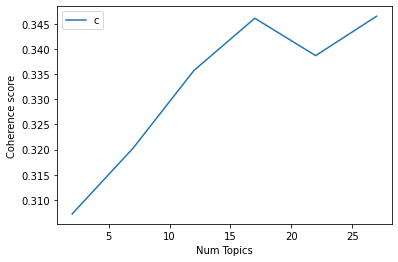

In [133]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_2019_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [134]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_2019_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.3072
index: 1 | Num Topics = 7  has Coherence Value of 0.3203
index: 2 | Num Topics = 12  has Coherence Value of 0.3357
index: 3 | Num Topics = 17  has Coherence Value of 0.3461
index: 4 | Num Topics = 22  has Coherence Value of 0.3387
index: 5 | Num Topics = 27  has Coherence Value of 0.3465


In [182]:
# Select optimal number of topics
optimal_model_us_2019_score1N2N3 = model_list_us_2019_score1N2N3[5]

In [183]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_2019_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_us_2019_score1N2N3, corpus_us_2019_score1N2N3, id2word_us_2019_score1N2N3)

In [184]:
print("pyLDAVis for us topics for score=1,2,3 in 2019:")
vis_us_2019_score1N2N3

pyLDAVis for us topics for score=1,2,3 in 2019:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.227942  0.008416       1        1  22.521855
11    -0.212395 -0.001649       2        1  11.712023
2     -0.131962 -0.108898       3        1  10.218661
22    -0.074358 -0.088629       4        1   6.454941
12    -0.071545  0.210379       5        1   5.057336
21    -0.097081  0.073519       6        1   4.332553
16    -0.078555 -0.064539       7        1   4.172753
19    -0.016317  0.048532       8        1   3.829695
26    -0.066935 -0.061207       9        1   3.370793
25    -0.054933  0.010431      10        1   3.066675
18    -0.037279 -0.025494      11        1   2.502074
17    -0.080027  0.078019      12        1   2.440295
24     0.033727 -0.038915      13        1   2.382089
1      0.116038  0.032401      14        1   2.122943
13    -0.033989  0.002433      15        1   2.107938
14     0.051129 -0.024567      16        1   2.047652
3      0.118789  0.066215      17        1   1.940888
0     -0.034049 -0.082874      18        1   1.655584
15     0.025642 -0.006699      19        1   1.530974
10     0.006811  0.029091      20        1   1.375898
20     0.122940  0.042816      21        1   1.187925
23     0.083313  0.092081      22        1   0.908184
5      0.148422 -0.047883      23        1   0.835596
9      0.103242 -0.018727      24        1   0.650317
8      0.115655 -0.086255      25        1   0.626652
4      0.151282 -0.011050      26        1   0.548472
7      0.140378 -0.026945      27        1   0.399231, topic_info=        Term        Freq       Total Category  logprob  loglift
73        ad  197.000000  197.000000  Default  30.0000  30.0000
101    video  717.000000  717.000000  Default  29.0000  29.0000
1        app  318.000000  318.000000  Default  28.0000  28.0000
102    watch  259.000000  259.000000  Default  27.0000  27.0000
53      play  152.000000  152.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
78      find    0.440601   47.772603  Topic27  -4.8014   0.8373
1        app    0.440601  318.555877  Topic27  -4.8014  -1.0600
29   creator    0.440601   22.992212  Topic27  -4.8014   1.5686
102    watch    0.440601  259.700105  Topic27  -4.8014  -0.8558
631    force    0.440601   22.721150  Topic27  -4.8014   1.5805

[1706 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1566     23  0.734710     abandon
1841      6  0.612762  abbreviate
122       1  0.282092        able
122       2  0.219405        able
122       3  0.031344        able
...     ...       ...         ...
1030      5  0.099237          yt
1030      8  0.099237          yt
1030      9  0.198474          yt
1030     15  0.099237          yt
2096     24  0.770074        zoom

[3661 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 12, 3, 23, 13, 22, 17, 20, 27, 26, 19, 18, 25, 2, 14, 15, 4, 1, 16, 11, 21, 24, 6, 10, 9, 5, 8])

## By-rating of 2020 (Rating=1,2,3)

In [138]:
# By-rating Topic Modelling - rating = 1,2,3 in 2020
# Convert to list - move to each section
review_us_2020_score1N2N3 = youtube_ios_us_review_YearMonth_2020_score1N2N3.review.values.tolist()
review_words_us_2020_score1N2N3 = list(sent_to_words(review_us_2020_score1N2N3))
print(review_words_us_2020_score1N2N3[:1])

[['like', 'using', 'the', 'app', 'it', 'the', 'one', 'use', 'the', 'most', 'but', 'something', 'that', 'just', 'annoys', 'me', 'while', 'scrolling', 'through', 'my', 'recommended', 'is', 'that', 'the', 'video', 'starts', 'showing', 'preview', 'right', 'away', 'and', 'then', 'puts', 'it', 'in', 'my', 'watch', 'history', 'want', 'to', 'be', 'able', 'to', 'scroll', 'through', 'without', 'having', 'the', 'preview', 'start', 'playing', 'causing', 'lag', 'as', 'it', 'loads', 'used', 'to', 'be', 'able', 'to', 'keep', 'my', 'finger', 'on', 'the', 'screen', 'scrolling', 'to', 'keep', 'it', 'from', 'playing', 'so', 'can', 'read', 'the', 'thumbnail', 'but', 'now', 'it', 'starts', 'playing', 'as', 'soon', 'as', 'it', 'shows', 'up', 'on', 'my', 'screen', 'and', 'immediately', 'puts', 'it', 'in', 'my', 'watch', 'history', 'even', 'though', 'haven', 'watched', 'it']]


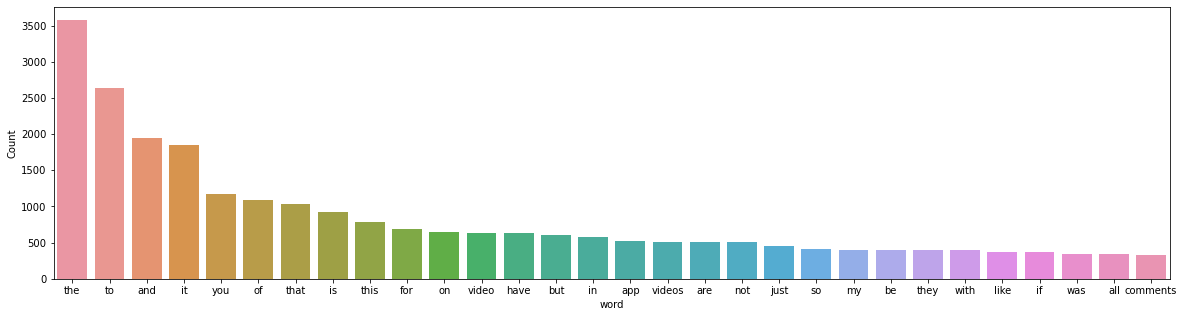

In [139]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_2020_score1N2N3))

In [140]:
# Clean text
review_words_us_ready_2020_score1N2N3 = process_words(review_words_us_2020_score1N2N3)  # processed Text Data! - move to each section

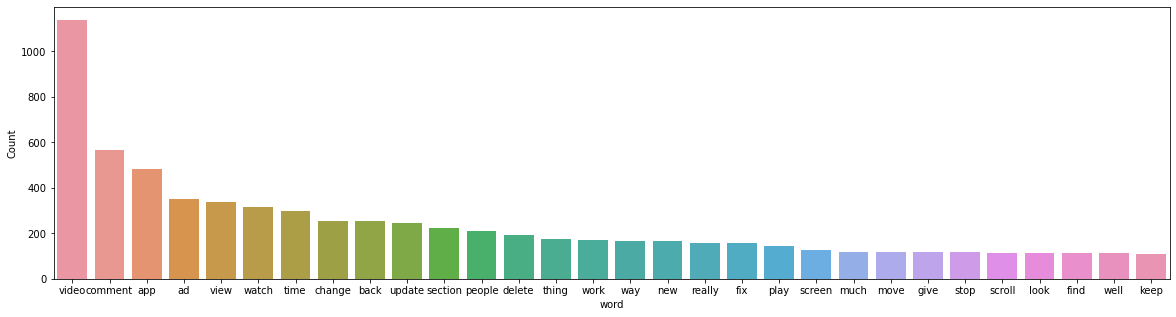

In [141]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_us_ready_2020_score1N2N3))


In [142]:
# Create Dictionary
id2word_us_2020_score1N2N3 = corpora.Dictionary(review_words_us_ready_2020_score1N2N3)

2021-10-17 02:04:10,338 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 02:04:10,560 [INFO] gensim.corpora.dictionary - built Dictionary(3180 unique tokens: ['able', 'annoy', 'app', 'away', 'cause']...) from 603 documents (total 25952 corpus positions)
2021-10-17 02:04:10,565 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(3180 unique tokens: ['able', 'annoy', 'app', 'away', 'cause']...) from 603 documents (total 25952 corpus positions)", 'datetime': '2021-10-17T02:04:10.565200', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [143]:
# Create Corpus: Term Document Frequency
corpus_us_2020_score1N2N3 = [id2word_us_2020_score1N2N3.doc2bow(text) for text in review_words_us_ready_2020_score1N2N3]

In [144]:
# Training LDA model
model_list_us_2020_score1N2N3, coherence_values_us_2020_score1N2N3 = compute_coherence_values(dictionary=id2word_us_2020_score1N2N3, corpus=corpus_us_2020_score1N2N3, 
                                                              texts=review_words_us_ready_2020_score1N2N3, limit=30, start=2, step=5)


2021-10-17 02:04:10,679 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 02:04:10,681 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 02:04:10,693 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 02:04:10,697 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 603 documents, updating model once every 603 documents, evaluating perplexity every 603 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 02:04:13,592 [INFO] gensim.models.ldamodel - -8.546 per-word bound, 373.9 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:04:13,593 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #603/603
2021-10-17 02:04:15,938 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.027*"video" + 0.019*"app" + 0.015*"comment" + 0.010*"delete" + 0.010*"view" + 0.010*"update" + 0.010*

2021-10-17 02:04:48,564 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.050*"video" + 0.030*"comment" + 0.020*"app" + 0.018*"ad" + 0.013*"watch" + 0.013*"change" + 0.012*"section" + 0.012*"time" + 0.012*"back" + 0.011*"update"
2021-10-17 02:04:48,566 [INFO] gensim.models.ldamodel - topic diff=0.033976, rho=0.301511
2021-10-17 02:04:50,214 [INFO] gensim.models.ldamodel - -6.764 per-word bound, 108.7 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:04:50,215 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #603/603
2021-10-17 02:04:51,513 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.028*"view" + 0.019*"video" + 0.017*"delete" + 0.011*"people" + 0.010*"app" + 0.009*"work" + 0.008*"time" + 0.007*"give" + 0.006*"guy" + 0.006*"watch"
2021-10-17 02:04:51,515 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.050*"video" + 0.030*"comment" + 0.020*"app" + 0.018*"ad" + 0.013*"watch" + 0.013*"change" + 0.012*"section" + 0.012

2021-10-17 02:05:18,246 [INFO] gensim.models.ldamodel - topic diff=0.012942, rho=0.218218
2021-10-17 02:05:20,246 [INFO] gensim.models.ldamodel - -6.747 per-word bound, 107.4 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:05:20,248 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #603/603
2021-10-17 02:05:21,352 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"view" + 0.019*"delete" + 0.018*"video" + 0.013*"people" + 0.009*"work" + 0.008*"time" + 0.007*"give" + 0.007*"guy" + 0.007*"hard" + 0.007*"app"
2021-10-17 02:05:21,354 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.050*"video" + 0.030*"comment" + 0.022*"app" + 0.018*"ad" + 0.014*"watch" + 0.013*"change" + 0.012*"update" + 0.012*"section" + 0.011*"back" + 0.011*"time"
2021-10-17 02:05:21,355 [INFO] gensim.models.ldamodel - topic diff=0.011958, rho=0.213201
2021-10-17 02:05:22,953 [INFO] gensim.models.ldamodel - -6.746 per-word bound, 107.3 perplexity estima

2021-10-17 02:05:46,684 [INFO] gensim.models.ldamodel - -6.742 per-word bound, 107.0 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:05:46,686 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #603/603
2021-10-17 02:05:47,829 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.031*"view" + 0.019*"delete" + 0.017*"video" + 0.013*"people" + 0.008*"time" + 0.008*"work" + 0.007*"give" + 0.007*"hard" + 0.007*"guy" + 0.007*"content"
2021-10-17 02:05:47,830 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.050*"video" + 0.029*"comment" + 0.023*"app" + 0.018*"ad" + 0.014*"watch" + 0.013*"change" + 0.013*"update" + 0.012*"section" + 0.011*"time" + 0.011*"back"
2021-10-17 02:05:47,831 [INFO] gensim.models.ldamodel - topic diff=0.006887, rho=0.176777
2021-10-17 02:05:49,331 [INFO] gensim.models.ldamodel - -6.741 per-word bound, 107.0 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:05:49,33

2021-10-17 02:06:13,687 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #603/603
2021-10-17 02:06:14,837 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.031*"view" + 0.019*"delete" + 0.017*"video" + 0.014*"people" + 0.008*"time" + 0.008*"work" + 0.007*"give" + 0.007*"hard" + 0.007*"content" + 0.007*"guy"
2021-10-17 02:06:14,840 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.050*"video" + 0.029*"comment" + 0.023*"app" + 0.017*"ad" + 0.014*"watch" + 0.013*"change" + 0.013*"update" + 0.012*"section" + 0.011*"time" + 0.011*"back"
2021-10-17 02:06:14,847 [INFO] gensim.models.ldamodel - topic diff=0.004322, rho=0.154303
2021-10-17 02:06:16,324 [INFO] gensim.models.ldamodel - -6.739 per-word bound, 106.8 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:06:16,325 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #603/603
2021-10-17 02:06:17,331 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.031*"view" + 0.0

2021-10-17 02:06:38,427 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-17 02:06:44,062 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-17 02:06:44,089 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 603 virtual documents
2021-10-17 02:06:44,457 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-17 02:06:44,458 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-17 02:06:44,462 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 02:06:44,468 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 603 documents, updating model once every 603 documents, evaluating perplexity every 603 documents, iterating 50x with a con

2021-10-17 02:07:02,529 [INFO] gensim.models.ldamodel - topic diff=0.144552, rho=0.408248
2021-10-17 02:07:04,504 [INFO] gensim.models.ldamodel - -6.976 per-word bound, 125.9 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:07:04,507 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #603/603
2021-10-17 02:07:06,080 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.042*"video" + 0.016*"app" + 0.015*"ad" + 0.010*"change" + 0.009*"back" + 0.008*"play" + 0.008*"screen" + 0.008*"time" + 0.007*"update" + 0.007*"watch"
2021-10-17 02:07:06,082 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.040*"comment" + 0.039*"video" + 0.019*"ad" + 0.018*"view" + 0.016*"section" + 0.013*"change" + 0.013*"time" + 0.012*"back" + 0.012*"app" + 0.012*"people"
2021-10-17 02:07:06,083 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.014*"app" + 0.012*"really" + 0.011*"view" + 0.009*"kid" + 0.009*"update" + 0.009*"video" + 0.009*"delete" + 0.007*"l

2021-10-17 02:07:20,570 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.015*"content" + 0.009*"ad" + 0.008*"creator" + 0.006*"turn" + 0.006*"platform" + 0.005*"video" + 0.005*"stop" + 0.005*"vaccine" + 0.005*"way" + 0.004*"big"
2021-10-17 02:07:20,575 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.041*"video" + 0.017*"ad" + 0.016*"app" + 0.008*"change" + 0.008*"back" + 0.008*"screen" + 0.008*"play" + 0.007*"time" + 0.007*"find" + 0.007*"update"
2021-10-17 02:07:20,580 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.069*"video" + 0.035*"app" + 0.027*"watch" + 0.015*"time" + 0.014*"play" + 0.012*"update" + 0.009*"fix" + 0.009*"playlist" + 0.008*"screen" + 0.008*"thing"
2021-10-17 02:07:20,582 [INFO] gensim.models.ldamodel - topic diff=0.036862, rho=0.288675
2021-10-17 02:07:22,205 [INFO] gensim.models.ldamodel - -6.941 per-word bound, 122.8 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:07:22,207 [INFO] gensim.models.ldamodel -

2021-10-17 02:07:35,636 [INFO] gensim.models.ldamodel - -6.928 per-word bound, 121.8 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:07:35,638 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #603/603
2021-10-17 02:07:36,713 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.012*"app" + 0.012*"kid" + 0.012*"really" + 0.008*"let" + 0.007*"bad" + 0.007*"way" + 0.007*"people" + 0.007*"give" + 0.007*"star" + 0.006*"update"
2021-10-17 02:07:36,714 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.039*"video" + 0.019*"ad" + 0.015*"app" + 0.008*"screen" + 0.007*"play" + 0.007*"back" + 0.007*"find" + 0.007*"change" + 0.006*"time" + 0.006*"show"
2021-10-17 02:07:36,715 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.071*"video" + 0.036*"app" + 0.027*"watch" + 0.015*"time" + 0.014*"play" + 0.014*"update" + 0.010*"fix" + 0.009*"screen" + 0.009*"playlist" + 0.008*"thing"
2021-10-17 02:07:36,716 [INFO] gensim.models.ldamodel - topi

2021-10-17 02:07:50,230 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.072*"video" + 0.037*"app" + 0.027*"watch" + 0.015*"time" + 0.015*"play" + 0.014*"update" + 0.011*"fix" + 0.009*"screen" + 0.009*"playlist" + 0.008*"thing"
2021-10-17 02:07:50,232 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.036*"video" + 0.021*"ad" + 0.014*"app" + 0.007*"find" + 0.007*"play" + 0.007*"screen" + 0.007*"back" + 0.006*"show" + 0.006*"change" + 0.006*"time"
2021-10-17 02:07:50,234 [INFO] gensim.models.ldamodel - topic diff=0.012965, rho=0.208514
2021-10-17 02:07:51,855 [INFO] gensim.models.ldamodel - -6.919 per-word bound, 121.0 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:07:51,857 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #603/603
2021-10-17 02:07:52,900 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.072*"video" + 0.037*"app" + 0.027*"watch" + 0.015*"time" + 0.015*"play" + 0.014*"update" + 0.011*"fix" + 0.009*"scree

2021-10-17 02:08:04,369 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #603/603
2021-10-17 02:08:05,469 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.072*"video" + 0.038*"app" + 0.026*"watch" + 0.015*"time" + 0.015*"play" + 0.015*"update" + 0.011*"fix" + 0.009*"screen" + 0.009*"playlist" + 0.008*"thing"
2021-10-17 02:08:05,471 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.022*"view" + 0.017*"army" + 0.016*"delete" + 0.009*"give" + 0.009*"work" + 0.007*"hard" + 0.007*"guy" + 0.006*"account" + 0.006*"really" + 0.005*"mean"
2021-10-17 02:08:05,473 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.016*"content" + 0.009*"creator" + 0.006*"stop" + 0.006*"platform" + 0.005*"vaccine" + 0.005*"turn" + 0.004*"people" + 0.004*"ban" + 0.004*"gun" + 0.004*"genuine"
2021-10-17 02:08:05,475 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.013*"kid" + 0.011*"really" + 0.010*"app" + 0.009*"let" + 0.007*"people" + 0.007*"bad" + 0.007*"way" + 0.006*"set" + 0.006*"give" + 

2021-10-17 02:08:19,477 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.022*"view" + 0.017*"army" + 0.016*"delete" + 0.009*"give" + 0.009*"work" + 0.007*"hard" + 0.007*"guy" + 0.006*"account" + 0.006*"really" + 0.005*"mean"
2021-10-17 02:08:19,479 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.015*"video" + 0.013*"button" + 0.012*"kid" + 0.011*"channel" + 0.009*"premium" + 0.008*"yt" + 0.008*"delete" + 0.007*"service" + 0.007*"people" + 0.007*"app"
2021-10-17 02:08:19,481 [INFO] gensim.models.ldamodel - topic diff=0.007067, rho=0.171499
2021-10-17 02:08:20,987 [INFO] gensim.models.ldamodel - -6.911 per-word bound, 120.3 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:08:21,002 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #603/603
2021-10-17 02:08:22,009 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.013*"kid" + 0.011*"really" + 0.010*"app" + 0.009*"let" + 0.008*"people" + 0.007*"bad" + 0.007*"way" + 0.006*"s

2021-10-17 02:08:34,233 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #603/603
2021-10-17 02:08:35,296 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.022*"view" + 0.018*"army" + 0.016*"delete" + 0.009*"give" + 0.009*"work" + 0.007*"hard" + 0.007*"guy" + 0.006*"account" + 0.006*"really" + 0.005*"mean"
2021-10-17 02:08:35,305 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.073*"video" + 0.039*"app" + 0.026*"watch" + 0.015*"time" + 0.015*"update" + 0.015*"play" + 0.012*"fix" + 0.010*"screen" + 0.009*"back" + 0.008*"thing"
2021-10-17 02:08:35,323 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.013*"kid" + 0.011*"really" + 0.009*"let" + 0.009*"app" + 0.008*"people" + 0.007*"bad" + 0.007*"way" + 0.006*"account" + 0.006*"set" + 0.006*"child"
2021-10-17 02:08:35,346 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.015*"video" + 0.013*"button" + 0.012*"kid" + 0.011*"channel" + 0.009*"premium" + 0.008*"yt" + 0.007*"delete" + 0.007*"service" + 0.007*"people" + 0.0

2021-10-17 02:08:47,886 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.074*"video" + 0.039*"app" + 0.025*"watch" + 0.015*"time" + 0.015*"update" + 0.015*"play" + 0.012*"fix" + 0.010*"screen" + 0.009*"back" + 0.008*"thing"
2021-10-17 02:08:47,890 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.013*"kid" + 0.011*"really" + 0.010*"let" + 0.008*"app" + 0.008*"people" + 0.007*"bad" + 0.007*"way" + 0.007*"account" + 0.007*"child" + 0.007*"set"
2021-10-17 02:08:47,893 [INFO] gensim.models.ldamodel - topic diff=0.004550, rho=0.149071
2021-10-17 02:08:49,400 [INFO] gensim.models.ldamodel - -6.906 per-word bound, 119.9 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:08:49,401 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #603/603
2021-10-17 02:08:50,255 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.030*"video" + 0.025*"ad" + 0.011*"app" + 0.008*"find" + 0.007*"people" + 0.006*"show" + 0.006*"play" + 0.006*"look" + 0.0

2021-10-17 02:09:01,855 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #603/603
2021-10-17 02:09:02,773 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.016*"content" + 0.009*"creator" + 0.008*"stop" + 0.007*"law" + 0.007*"platform" + 0.006*"firearm" + 0.006*"people" + 0.006*"vaccine" + 0.006*"ban" + 0.004*"gun"
2021-10-17 02:09:02,774 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.022*"view" + 0.018*"army" + 0.016*"delete" + 0.009*"give" + 0.008*"work" + 0.007*"hard" + 0.007*"guy" + 0.007*"account" + 0.006*"really" + 0.005*"mean"
2021-10-17 02:09:02,776 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.013*"kid" + 0.011*"really" + 0.010*"let" + 0.008*"app" + 0.008*"people" + 0.007*"bad" + 0.007*"way" + 0.007*"account" + 0.007*"child" + 0.007*"set"
2021-10-17 02:09:02,778 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.074*"video" + 0.039*"app" + 0.025*"watch" + 0.015*"update" + 0.015*"time" + 0.015*"play" + 0.012*"fix" + 0.010*"screen" + 0.009*"back" + 0.

2021-10-17 02:09:26,165 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.071*"ad" + 0.031*"video" + 0.019*"watch" + 0.013*"app" + 0.010*"time" + 0.007*"screen" + 0.006*"add" + 0.006*"play" + 0.006*"comment" + 0.006*"much"
2021-10-17 02:09:26,169 [INFO] gensim.models.ldamodel - topic diff=0.283460, rho=0.447214
2021-10-17 02:09:27,788 [INFO] gensim.models.ldamodel - -7.085 per-word bound, 135.7 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:09:27,790 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #603/603
2021-10-17 02:09:28,907 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.068*"comment" + 0.036*"video" + 0.027*"section" + 0.027*"change" + 0.021*"back" + 0.017*"update" + 0.016*"app" + 0.014*"new" + 0.012*"move" + 0.011*"click"
2021-10-17 02:09:28,910 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.072*"video" + 0.038*"app" + 0.028*"watch" + 0.016*"time" + 0.014*"play" + 0.013*"update" + 0.011*"fix" + 0.009*"scr

2021-10-17 02:09:43,215 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.025*"view" + 0.016*"delete" + 0.015*"app" + 0.011*"video" + 0.011*"army" + 0.011*"time" + 0.008*"picture" + 0.008*"content" + 0.007*"stop" + 0.007*"set"
2021-10-17 02:09:43,222 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.096*"ad" + 0.032*"video" + 0.018*"watch" + 0.012*"app" + 0.009*"time" + 0.007*"add" + 0.007*"minute" + 0.006*"pay" + 0.006*"second" + 0.006*"skip"
2021-10-17 02:09:43,228 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.043*"video" + 0.018*"app" + 0.011*"caption" + 0.010*"play" + 0.009*"upload" + 0.009*"change" + 0.009*"back" + 0.008*"time" + 0.007*"update" + 0.006*"player"
2021-10-17 02:09:43,230 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.040*"video" + 0.020*"kid" + 0.014*"comment" + 0.010*"show" + 0.008*"change" + 0.008*"screen" + 0.008*"thumbnail" + 0.008*"home" + 0.007*"thing" + 0.007*"bad"
2021-10-17 02:09:43,232 [INFO] gensim.models.ldamodel - topic diff=0.067698, rh

2021-10-17 02:09:56,622 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.022*"view" + 0.014*"delete" + 0.014*"app" + 0.011*"time" + 0.010*"army" + 0.009*"video" + 0.009*"picture" + 0.008*"content" + 0.007*"set" + 0.007*"background"
2021-10-17 02:09:56,624 [INFO] gensim.models.ldamodel - topic diff=0.032034, rho=0.250000
2021-10-17 02:09:58,035 [INFO] gensim.models.ldamodel - -6.964 per-word bound, 124.9 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:09:58,037 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #603/603
2021-10-17 02:09:59,142 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.105*"ad" + 0.032*"video" + 0.018*"watch" + 0.011*"app" + 0.009*"time" + 0.008*"minute" + 0.007*"add" + 0.007*"pay" + 0.007*"skip" + 0.006*"point"
2021-10-17 02:09:59,145 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.044*"video" + 0.018*"app" + 0.012*"upload" + 0.012*"caption" + 0.009*"play" + 0.009*"change" + 0.008*"back" + 0.00

2021-10-17 02:10:11,897 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.076*"comment" + 0.034*"video" + 0.031*"section" + 0.029*"change" + 0.021*"back" + 0.017*"update" + 0.015*"app" + 0.015*"new" + 0.014*"move" + 0.013*"scroll"
2021-10-17 02:10:11,900 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.015*"view" + 0.014*"app" + 0.011*"delete" + 0.010*"time" + 0.009*"picture" + 0.009*"army" + 0.009*"content" + 0.008*"set" + 0.007*"background" + 0.006*"high"
2021-10-17 02:10:11,906 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.022*"button" + 0.012*"video" + 0.012*"channel" + 0.009*"app" + 0.009*"delete" + 0.008*"end" + 0.008*"freedom" + 0.007*"anti" + 0.007*"premium" + 0.006*"lately"
2021-10-17 02:10:11,909 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.083*"video" + 0.043*"app" + 0.030*"watch" + 0.018*"play" + 0.017*"time" + 0.016*"update" + 0.013*"fix" + 0.011*"screen" + 0.011*"playlist" + 0.010*"issue"
2021-10-17 02:10:11,913 [INFO] gensim.models.ldamodel - topic diff

2021-10-17 02:10:23,909 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.012*"update" + 0.011*"guy" + 0.010*"download" + 0.010*"video" + 0.010*"let" + 0.010*"really" + 0.009*"kid" + 0.008*"world" + 0.007*"way" + 0.007*"truth"
2021-10-17 02:10:23,914 [INFO] gensim.models.ldamodel - topic diff=0.013893, rho=0.192450
2021-10-17 02:10:25,393 [INFO] gensim.models.ldamodel - -6.936 per-word bound, 122.5 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:10:25,399 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #603/603
2021-10-17 02:10:26,398 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.032*"video" + 0.025*"kid" + 0.012*"show" + 0.009*"thumbnail" + 0.009*"home" + 0.008*"yt" + 0.008*"thing" + 0.007*"bad" + 0.006*"time" + 0.006*"suggest"
2021-10-17 02:10:26,401 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.014*"app" + 0.011*"view" + 0.010*"picture" + 0.010*"content" + 0.008*"delete" + 0.008*"time" + 0.008*"set" + 0.007

2021-10-17 02:10:40,258 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.042*"video" + 0.017*"app" + 0.016*"upload" + 0.013*"caption" + 0.009*"change" + 0.008*"back" + 0.007*"time" + 0.006*"subscription" + 0.006*"play" + 0.006*"add"
2021-10-17 02:10:40,260 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.014*"app" + 0.010*"content" + 0.010*"picture" + 0.009*"view" + 0.008*"set" + 0.007*"delete" + 0.007*"time" + 0.007*"high" + 0.007*"background" + 0.006*"support"
2021-10-17 02:10:40,261 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.084*"video" + 0.043*"app" + 0.030*"watch" + 0.019*"play" + 0.017*"time" + 0.016*"update" + 0.013*"fix" + 0.011*"screen" + 0.011*"playlist" + 0.010*"problem"
2021-10-17 02:10:40,262 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.026*"video" + 0.023*"people" + 0.021*"view" + 0.013*"work" + 0.011*"hard" + 0.011*"app" + 0.011*"time" + 0.009*"delete" + 0.007*"give" + 0.007*"platform"
2021-10-17 02:10:40,263 [INFO] gensim.models.ldamodel - topic di

2021-10-17 02:10:51,891 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.010*"non" + 0.009*"subscriber" + 0.008*"io" + 0.008*"premium" + 0.008*"account" + 0.008*"block" + 0.007*"way" + 0.007*"control" + 0.006*"work" + 0.006*"internet"
2021-10-17 02:10:51,892 [INFO] gensim.models.ldamodel - topic diff=0.008255, rho=0.162221
2021-10-17 02:10:53,211 [INFO] gensim.models.ldamodel - -6.923 per-word bound, 121.3 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:10:53,213 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #603/603
2021-10-17 02:10:54,140 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.041*"video" + 0.017*"upload" + 0.017*"app" + 0.013*"caption" + 0.009*"change" + 0.007*"back" + 0.007*"time" + 0.007*"subscription" + 0.006*"add" + 0.006*"play"
2021-10-17 02:10:54,193 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.025*"video" + 0.023*"people" + 0.019*"view" + 0.013*"work" + 0.011*"hard" + 0.011*"app" + 0.011*"t

2021-10-17 02:11:06,295 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.024*"content" + 0.014*"turn" + 0.007*"genuine" + 0.007*"censor" + 0.007*"volume" + 0.006*"account" + 0.005*"understand" + 0.005*"thing" + 0.005*"entire" + 0.005*"people"
2021-10-17 02:11:06,298 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.010*"non" + 0.009*"subscriber" + 0.008*"io" + 0.008*"premium" + 0.008*"account" + 0.008*"block" + 0.007*"way" + 0.007*"control" + 0.006*"work" + 0.006*"internet"
2021-10-17 02:11:06,321 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.114*"ad" + 0.032*"video" + 0.016*"watch" + 0.010*"app" + 0.008*"minute" + 0.008*"time" + 0.007*"content" + 0.007*"skip" + 0.007*"pay" + 0.007*"understand"
2021-10-17 02:11:06,323 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.040*"video" + 0.018*"upload" + 0.017*"app" + 0.013*"caption" + 0.009*"change" + 0.007*"back" + 0.007*"time" + 0.007*"subscription" + 0.006*"add" + 0.006*"able"
2021-10-17 02:11:06,325 [INFO] gensim.models.lda

2021-10-17 02:11:18,017 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.014*"app" + 0.011*"content" + 0.011*"picture" + 0.009*"set" + 0.007*"high" + 0.007*"support" + 0.007*"view" + 0.006*"switch" + 0.006*"background" + 0.006*"user"
2021-10-17 02:11:18,019 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.066*"view" + 0.036*"delete" + 0.031*"video" + 0.015*"music" + 0.013*"time" + 0.012*"work" + 0.012*"people" + 0.012*"give" + 0.011*"guy" + 0.011*"bot"
2021-10-17 02:11:18,019 [INFO] gensim.models.ldamodel - topic diff=0.005059, rho=0.142857
2021-10-17 02:11:19,272 [INFO] gensim.models.ldamodel - -6.915 per-word bound, 120.7 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:11:19,274 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #603/603
2021-10-17 02:11:20,251 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.024*"content" + 0.014*"turn" + 0.007*"genuine" + 0.007*"censor" + 0.007*"volume" + 0.006*"account" + 0.006*"u

2021-10-17 02:11:41,916 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.029*"app" + 0.023*"video" + 0.015*"change" + 0.013*"thing" + 0.011*"really" + 0.008*"let" + 0.008*"great" + 0.008*"watch" + 0.008*"update" + 0.008*"people"
2021-10-17 02:11:41,919 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.013*"update" + 0.011*"comment" + 0.011*"kid" + 0.010*"video" + 0.010*"really" + 0.008*"fix" + 0.008*"bad" + 0.008*"truth" + 0.007*"well" + 0.007*"people"
2021-10-17 02:11:41,921 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.042*"video" + 0.015*"comment" + 0.015*"view" + 0.015*"ad" + 0.014*"back" + 0.013*"time" + 0.013*"app" + 0.008*"give" + 0.008*"people" + 0.007*"watch"
2021-10-17 02:11:41,923 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.069*"video" + 0.042*"comment" + 0.024*"app" + 0.016*"update" + 0.015*"section" + 0.015*"watch" + 0.013*"fix" + 0.011*"time" + 0.010*"ad" + 0.010*"playlist"
2021-10-17 02:11:41,925 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.0

2021-10-17 02:11:57,224 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.013*"kid" + 0.012*"update" + 0.011*"really" + 0.010*"truth" + 0.009*"video" + 0.008*"bad" + 0.008*"people" + 0.008*"fix" + 0.008*"well" + 0.007*"watch"
2021-10-17 02:11:57,239 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.019*"work" + 0.010*"way" + 0.009*"hard" + 0.008*"put" + 0.007*"hear" + 0.007*"age" + 0.007*"block" + 0.007*"workplace" + 0.007*"woman" + 0.007*"find"
2021-10-17 02:11:57,250 [INFO] gensim.models.ldamodel - topic diff=0.126435, rho=0.333333
2021-10-17 02:11:58,779 [INFO] gensim.models.ldamodel - -7.095 per-word bound, 136.7 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:11:58,780 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #603/603
2021-10-17 02:11:59,822 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.019*"work" + 0.010*"way" + 0.008*"hard" + 0.007*"hear" + 0.007*"age" + 0.007*"block" + 0.007*"workplace" + 0.007*"woman

2021-10-17 02:12:11,760 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #603/603
2021-10-17 02:12:12,904 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.113*"ad" + 0.030*"video" + 0.022*"watch" + 0.014*"app" + 0.012*"screen" + 0.011*"time" + 0.010*"second" + 0.010*"add" + 0.010*"minute" + 0.009*"skip"
2021-10-17 02:12:12,906 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.041*"video" + 0.011*"app" + 0.011*"time" + 0.010*"content" + 0.010*"give" + 0.008*"find" + 0.008*"view" + 0.008*"ad" + 0.008*"stop" + 0.008*"channel"
2021-10-17 02:12:12,912 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.019*"comment" + 0.017*"video" + 0.017*"section" + 0.011*"recommend" + 0.011*"well" + 0.010*"thumbnail" + 0.010*"show" + 0.010*"change" + 0.009*"scroll" + 0.009*"size"
2021-10-17 02:12:12,915 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.077*"video" + 0.035*"comment" + 0.028*"app" + 0.019*"update" + 0.018*"watch" + 0.013*"fix" + 0.013*"time" + 0.012*"section" + 0.01

2021-10-17 02:12:25,135 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.017*"content" + 0.010*"pay" + 0.010*"company" + 0.009*"app" + 0.008*"set" + 0.008*"people" + 0.008*"high" + 0.007*"view" + 0.007*"delete" + 0.007*"money"
2021-10-17 02:12:25,136 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.015*"work" + 0.010*"way" + 0.008*"hear" + 0.008*"workplace" + 0.008*"age" + 0.008*"block" + 0.008*"woman" + 0.008*"find" + 0.008*"mention" + 0.008*"difference"
2021-10-17 02:12:25,137 [INFO] gensim.models.ldamodel - topic diff=0.024572, rho=0.223607
2021-10-17 02:12:26,414 [INFO] gensim.models.ldamodel - -7.026 per-word bound, 130.3 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:12:26,415 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #603/603
2021-10-17 02:12:27,389 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.123*"ad" + 0.031*"video" + 0.022*"watch" + 0.014*"app" + 0.011*"time" + 0.011*"second" + 0.011*"screen" +

2021-10-17 02:12:38,271 [INFO] gensim.models.ldamodel - -7.011 per-word bound, 129.0 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:12:38,273 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #603/603
2021-10-17 02:12:39,213 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.078*"comment" + 0.037*"change" + 0.034*"section" + 0.029*"video" + 0.026*"back" + 0.018*"new" + 0.017*"update" + 0.014*"app" + 0.014*"move" + 0.013*"thumbnail"
2021-10-17 02:12:39,246 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.043*"video" + 0.012*"play" + 0.010*"watch" + 0.010*"ad" + 0.010*"content" + 0.010*"stop" + 0.009*"people" + 0.008*"really" + 0.007*"app" + 0.007*"work"
2021-10-17 02:12:39,260 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.039*"video" + 0.011*"content" + 0.011*"give" + 0.009*"time" + 0.009*"app" + 0.009*"channel" + 0.008*"find" + 0.008*"never" + 0.008*"stop" + 0.007*"view"
2021-10-17 02:12:39,262 [INFO] gensim.models

2021-10-17 02:12:51,657 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.011*"caption" + 0.011*"honestly" + 0.010*"day" + 0.008*"love" + 0.008*"band" + 0.008*"people" + 0.007*"become" + 0.007*"away" + 0.007*"app" + 0.007*"racist"
2021-10-17 02:12:51,659 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.037*"video" + 0.011*"give" + 0.011*"content" + 0.009*"channel" + 0.009*"time" + 0.008*"never" + 0.008*"find" + 0.008*"app" + 0.008*"stop" + 0.007*"view"
2021-10-17 02:12:51,662 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.078*"view" + 0.048*"delete" + 0.036*"video" + 0.018*"time" + 0.016*"hard" + 0.016*"music" + 0.015*"watch" + 0.015*"guy" + 0.014*"work" + 0.013*"bot"
2021-10-17 02:12:51,663 [INFO] gensim.models.ldamodel - topic diff=0.012189, rho=0.179605
2021-10-17 02:12:53,299 [INFO] gensim.models.ldamodel - -6.999 per-word bound, 127.9 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:12:53,300 [INFO] gensim.models.ldamodel - 

2021-10-17 02:13:03,282 [INFO] gensim.models.ldamodel - topic diff=0.009407, rho=0.166667
2021-10-17 02:13:04,929 [INFO] gensim.models.ldamodel - -6.991 per-word bound, 127.2 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:13:04,937 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #603/603
2021-10-17 02:13:05,858 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.050*"video" + 0.048*"app" + 0.037*"kid" + 0.017*"watch" + 0.015*"time" + 0.012*"turn" + 0.010*"thing" + 0.009*"update" + 0.009*"phone" + 0.008*"next"
2021-10-17 02:13:05,913 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.016*"kid" + 0.012*"world" + 0.012*"truth" + 0.011*"people" + 0.011*"free" + 0.009*"bad" + 0.009*"really" + 0.009*"child" + 0.009*"tube" + 0.008*"speech"
2021-10-17 02:13:05,925 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.136*"ad" + 0.033*"video" + 0.023*"watch" + 0.013*"app" + 0.011*"second" + 0.011*"time" + 0.011*"skip" + 0.011*"minut

2021-10-17 02:13:17,151 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.035*"video" + 0.017*"app" + 0.016*"people" + 0.011*"watch" + 0.011*"time" + 0.011*"platform" + 0.010*"thing" + 0.009*"bad" + 0.009*"content" + 0.008*"work"
2021-10-17 02:13:17,154 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.039*"video" + 0.012*"play" + 0.010*"content" + 0.010*"watch" + 0.010*"stop" + 0.010*"people" + 0.009*"ad" + 0.007*"really" + 0.007*"work" + 0.007*"time"
2021-10-17 02:13:17,156 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.033*"video" + 0.011*"give" + 0.011*"content" + 0.009*"channel" + 0.009*"never" + 0.008*"find" + 0.008*"time" + 0.008*"platform" + 0.008*"view" + 0.008*"stop"
2021-10-17 02:13:17,158 [INFO] gensim.models.ldamodel - topic diff=0.007092, rho=0.154303
2021-10-17 02:13:18,466 [INFO] gensim.models.ldamodel - -6.985 per-word bound, 126.7 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:13:18,467 [INFO] gensim.models.lda

2021-10-17 02:13:28,408 [INFO] gensim.models.ldamodel - topic diff=0.005673, rho=0.145865
2021-10-17 02:13:29,775 [INFO] gensim.models.ldamodel - -6.981 per-word bound, 126.4 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:13:29,777 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #603/603
2021-10-17 02:13:30,557 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.032*"video" + 0.011*"give" + 0.011*"content" + 0.009*"channel" + 0.009*"never" + 0.008*"find" + 0.008*"platform" + 0.008*"time" + 0.008*"view" + 0.007*"stop"
2021-10-17 02:13:30,558 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.016*"kid" + 0.013*"world" + 0.012*"truth" + 0.012*"people" + 0.011*"free" + 0.009*"bad" + 0.009*"child" + 0.009*"really" + 0.009*"tube" + 0.008*"let"
2021-10-17 02:13:30,561 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.025*"app" + 0.018*"video" + 0.013*"thing" + 0.012*"really" + 0.010*"let" + 0.009*"buy" + 0.008*"mobile" + 0.008

2021-10-17 02:13:51,248 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.047*"video" + 0.025*"app" + 0.016*"watch" + 0.016*"update" + 0.011*"screen" + 0.010*"problem" + 0.010*"play" + 0.007*"recommend" + 0.007*"thing" + 0.007*"fix"
2021-10-17 02:13:51,250 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.036*"video" + 0.027*"app" + 0.018*"change" + 0.012*"new" + 0.011*"watch" + 0.011*"update" + 0.010*"time" + 0.010*"size" + 0.010*"great" + 0.009*"thing"
2021-10-17 02:13:51,252 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.027*"view" + 0.023*"people" + 0.023*"video" + 0.021*"delete" + 0.020*"really" + 0.019*"app" + 0.018*"guy" + 0.015*"time" + 0.012*"comment" + 0.012*"work"
2021-10-17 02:13:51,254 [INFO] gensim.models.ldamodel - topic diff=15.694409, rho=1.000000
2021-10-17 02:13:52,724 [INFO] gensim.models.ldamodel - -7.665 per-word bound, 202.9 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:13:52,725 [INFO] gensim.models.ld

2021-10-17 02:14:03,839 [INFO] gensim.models.ldamodel - topic diff=0.242448, rho=0.377964
2021-10-17 02:14:05,397 [INFO] gensim.models.ldamodel - -7.210 per-word bound, 148.1 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:14:05,398 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #603/603
2021-10-17 02:14:06,314 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.066*"video" + 0.044*"comment" + 0.028*"app" + 0.015*"section" + 0.014*"watch" + 0.013*"update" + 0.012*"fix" + 0.012*"time" + 0.010*"ad" + 0.009*"thing"
2021-10-17 02:14:06,317 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.028*"comment" + 0.024*"video" + 0.018*"change" + 0.015*"section" + 0.012*"bad" + 0.011*"scroll" + 0.011*"way" + 0.011*"show" + 0.009*"screen" + 0.009*"well"
2021-10-17 02:14:06,320 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.023*"content" + 0.012*"big" + 0.012*"platform" + 0.009*"great" + 0.009*"time" + 0.009*"genuine" + 0.009*"comm

2021-10-17 02:14:18,520 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.020*"kid" + 0.016*"update" + 0.015*"bad" + 0.012*"download" + 0.011*"video" + 0.011*"app" + 0.011*"way" + 0.010*"horrible" + 0.009*"stop" + 0.008*"love"
2021-10-17 02:14:18,527 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.034*"button" + 0.012*"app" + 0.011*"anti" + 0.010*"start" + 0.009*"view" + 0.009*"back" + 0.009*"update" + 0.008*"search" + 0.007*"platform" + 0.007*"buffer"
2021-10-17 02:14:18,535 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.051*"video" + 0.043*"view" + 0.028*"delete" + 0.022*"watch" + 0.013*"time" + 0.013*"music" + 0.011*"stop" + 0.009*"hour" + 0.008*"play" + 0.007*"movie"
2021-10-17 02:14:18,537 [INFO] gensim.models.ldamodel - topic diff=0.066769, rho=0.277350
2021-10-17 02:14:19,886 [INFO] gensim.models.ldamodel - -7.131 per-word bound, 140.2 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:14:19,888 [INFO] gensim.models.ldamode

2021-10-17 02:14:30,567 [INFO] gensim.models.ldamodel - topic diff=0.032707, rho=0.235702
2021-10-17 02:14:31,902 [INFO] gensim.models.ldamodel - -7.102 per-word bound, 137.4 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:14:31,903 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #603/603
2021-10-17 02:14:32,860 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.048*"video" + 0.041*"app" + 0.026*"watch" + 0.017*"time" + 0.010*"next" + 0.010*"play" + 0.009*"turn" + 0.009*"thing" + 0.008*"give" + 0.008*"really"
2021-10-17 02:14:32,863 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.027*"video" + 0.019*"ad" + 0.015*"app" + 0.014*"watch" + 0.014*"comment" + 0.013*"time" + 0.013*"issue" + 0.011*"fix" + 0.010*"much" + 0.010*"close"
2021-10-17 02:14:32,867 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.052*"video" + 0.042*"view" + 0.026*"delete" + 0.023*"watch" + 0.013*"music" + 0.013*"time" + 0.011*"stop" + 0.010*"hour

2021-10-17 02:14:45,287 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.023*"content" + 0.012*"big" + 0.012*"platform" + 0.009*"great" + 0.009*"time" + 0.009*"genuine" + 0.009*"community" + 0.007*"change" + 0.007*"censor" + 0.007*"video"
2021-10-17 02:14:45,289 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.048*"video" + 0.041*"app" + 0.026*"watch" + 0.017*"time" + 0.010*"next" + 0.010*"play" + 0.010*"turn" + 0.009*"thing" + 0.009*"give" + 0.008*"really"
2021-10-17 02:14:45,291 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.163*"ad" + 0.032*"video" + 0.020*"watch" + 0.012*"app" + 0.012*"skip" + 0.011*"minute" + 0.011*"middle" + 0.010*"show" + 0.010*"political" + 0.008*"rid"
2021-10-17 02:14:45,293 [INFO] gensim.models.ldamodel - topic diff=0.019000, rho=0.204124
2021-10-17 02:14:46,528 [INFO] gensim.models.ldamodel - -7.083 per-word bound, 135.5 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:14:46,530 [INFO] gensim.models.l

2021-10-17 02:14:56,972 [INFO] gensim.models.ldamodel - topic diff=0.013517, rho=0.185695
2021-10-17 02:14:58,234 [INFO] gensim.models.ldamodel - -7.072 per-word bound, 134.5 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:14:58,235 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #603/603
2021-10-17 02:14:59,149 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.068*"video" + 0.067*"kid" + 0.027*"child" + 0.027*"channel" + 0.019*"app" + 0.018*"friendly" + 0.014*"mode" + 0.013*"content" + 0.013*"people" + 0.012*"restrict"
2021-10-17 02:14:59,157 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.072*"video" + 0.031*"app" + 0.027*"comment" + 0.015*"watch" + 0.014*"fix" + 0.014*"time" + 0.013*"update" + 0.011*"playlist" + 0.010*"load" + 0.010*"thing"
2021-10-17 02:14:59,182 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.022*"video" + 0.014*"show" + 0.013*"change" + 0.012*"bad" + 0.011*"content" + 0.009*"recommend" + 0

2021-10-17 02:15:11,791 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.022*"kid" + 0.016*"bad" + 0.013*"update" + 0.013*"download" + 0.011*"horrible" + 0.010*"app" + 0.010*"way" + 0.010*"stop" + 0.009*"video" + 0.009*"yt"
2021-10-17 02:15:11,795 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.054*"video" + 0.032*"app" + 0.026*"update" + 0.017*"play" + 0.014*"watch" + 0.014*"screen" + 0.013*"bug" + 0.011*"fix" + 0.010*"issue" + 0.010*"phone"
2021-10-17 02:15:11,801 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.012*"content" + 0.011*"army" + 0.010*"commercial" + 0.009*"set" + 0.008*"day" + 0.008*"review" + 0.007*"play" + 0.007*"time" + 0.007*"background" + 0.007*"mode"
2021-10-17 02:15:11,803 [INFO] gensim.models.ldamodel - topic diff=0.009677, rho=0.169031
2021-10-17 02:15:13,641 [INFO] gensim.models.ldamodel - -7.063 per-word bound, 133.7 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:15:13,644 [INFO] gensim.models.ldamode

2021-10-17 02:15:24,695 [INFO] gensim.models.ldamodel - topic diff=0.007372, rho=0.158114
2021-10-17 02:15:26,078 [INFO] gensim.models.ldamodel - -7.057 per-word bound, 133.2 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:15:26,080 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #603/603
2021-10-17 02:15:26,882 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.036*"video" + 0.012*"content" + 0.012*"work" + 0.009*"ad" + 0.009*"time" + 0.009*"watch" + 0.007*"day" + 0.007*"give" + 0.007*"stop" + 0.006*"play"
2021-10-17 02:15:26,884 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.056*"view" + 0.019*"video" + 0.015*"time" + 0.012*"delete" + 0.011*"point" + 0.010*"fan" + 0.010*"amount" + 0.010*"music" + 0.009*"back" + 0.009*"group"
2021-10-17 02:15:26,895 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.047*"video" + 0.041*"app" + 0.026*"watch" + 0.016*"time" + 0.011*"next" + 0.010*"play" + 0.010*"turn" + 0.010*"give" 

2021-10-17 02:15:38,042 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.023*"content" + 0.012*"big" + 0.012*"platform" + 0.009*"great" + 0.009*"time" + 0.009*"genuine" + 0.009*"community" + 0.007*"channel" + 0.007*"change" + 0.007*"censor"
2021-10-17 02:15:38,044 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.080*"view" + 0.054*"delete" + 0.026*"people" + 0.024*"hard" + 0.024*"work" + 0.021*"guy" + 0.020*"really" + 0.018*"video" + 0.016*"bot" + 0.016*"time"
2021-10-17 02:15:38,047 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.029*"app" + 0.024*"time" + 0.022*"video" + 0.019*"update" + 0.014*"crash" + 0.014*"watch" + 0.013*"change" + 0.010*"happen" + 0.009*"tube" + 0.009*"work"
2021-10-17 02:15:38,049 [INFO] gensim.models.ldamodel - topic diff=0.005567, rho=0.147442
2021-10-17 02:15:39,422 [INFO] gensim.models.ldamodel - -7.052 per-word bound, 132.7 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:15:39,424 [INFO] gensim.mod

2021-10-17 02:15:50,747 [INFO] gensim.models.ldamodel - topic diff=0.004553, rho=0.140028
2021-10-17 02:15:50,750 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=3180, num_topics=22, decay=0.5, chunksize=1000) in 124.33s', 'datetime': '2021-10-17T02:15:50.750195', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-17 02:15:50,760 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-17 02:15:56,208 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-17 02:15:56,295 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 603 virtual documents
2021-10-17 02:16:00,317 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.037037037037037035
2021-10

2021-10-17 02:16:17,562 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.116*"ad" + 0.028*"video" + 0.018*"watch" + 0.013*"middle" + 0.012*"app" + 0.011*"time" + 0.010*"skip" + 0.010*"rid" + 0.009*"look" + 0.008*"screen"
2021-10-17 02:16:17,563 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.074*"comment" + 0.050*"video" + 0.037*"change" + 0.032*"back" + 0.025*"section" + 0.020*"new" + 0.020*"update" + 0.015*"look" + 0.014*"scroll" + 0.013*"way"
2021-10-17 02:16:17,566 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.027*"ad" + 0.027*"video" + 0.021*"view" + 0.012*"comment" + 0.011*"app" + 0.011*"time" + 0.010*"work" + 0.009*"watch" + 0.009*"big" + 0.009*"change"
2021-10-17 02:16:17,567 [INFO] gensim.models.ldamodel - topic diff=0.317479, rho=0.408248
2021-10-17 02:16:18,961 [INFO] gensim.models.ldamodel - -7.321 per-word bound, 159.9 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:16:18,973 [INFO] gensim.models.ldamodel - PROG

2021-10-17 02:16:29,681 [INFO] gensim.models.ldamodel - topic diff=0.105248, rho=0.301511
2021-10-17 02:16:31,067 [INFO] gensim.models.ldamodel - -7.222 per-word bound, 149.2 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:16:31,072 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #603/603
2021-10-17 02:16:32,023 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.064*"video" + 0.038*"comment" + 0.027*"app" + 0.015*"update" + 0.014*"fix" + 0.014*"watch" + 0.013*"section" + 0.011*"annoying" + 0.010*"back" + 0.010*"move"
2021-10-17 02:16:32,025 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.030*"video" + 0.026*"view" + 0.023*"delete" + 0.016*"time" + 0.014*"app" + 0.013*"work" + 0.012*"stream" + 0.010*"way" + 0.010*"hard" + 0.010*"really"
2021-10-17 02:16:32,030 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.031*"video" + 0.015*"people" + 0.015*"app" + 0.014*"time" + 0.010*"comment" + 0.009*"problem" + 0.008*"fix" +

2021-10-17 02:16:43,533 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.066*"video" + 0.032*"comment" + 0.028*"app" + 0.016*"update" + 0.015*"fix" + 0.014*"watch" + 0.011*"annoying" + 0.010*"back" + 0.010*"time" + 0.010*"playlist"
2021-10-17 02:16:43,535 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.027*"video" + 0.027*"comment" + 0.018*"app" + 0.018*"people" + 0.016*"update" + 0.013*"time" + 0.012*"back" + 0.012*"section" + 0.011*"crash" + 0.008*"play"
2021-10-17 02:16:43,538 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.164*"ad" + 0.032*"video" + 0.020*"watch" + 0.013*"skip" + 0.012*"app" + 0.012*"middle" + 0.011*"time" + 0.010*"minute" + 0.009*"content" + 0.009*"rid"
2021-10-17 02:16:43,540 [INFO] gensim.models.ldamodel - topic diff=0.038180, rho=0.242536
2021-10-17 02:16:45,092 [INFO] gensim.models.ldamodel - -7.177 per-word bound, 144.7 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:16:45,094 [INFO] gensim.models.l

2021-10-17 02:16:55,697 [INFO] gensim.models.ldamodel - topic diff=0.022534, rho=0.213201
2021-10-17 02:16:57,128 [INFO] gensim.models.ldamodel - -7.156 per-word bound, 142.6 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:16:57,173 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #603/603
2021-10-17 02:16:58,015 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.019*"kid" + 0.017*"app" + 0.015*"bad" + 0.014*"update" + 0.013*"download" + 0.013*"give" + 0.011*"review" + 0.010*"video" + 0.009*"horrible" + 0.009*"watch"
2021-10-17 02:16:58,028 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.027*"app" + 0.026*"ad" + 0.010*"fix" + 0.010*"guy" + 0.010*"advert" + 0.010*"report" + 0.009*"search" + 0.009*"stuff" + 0.009*"child" + 0.008*"load"
2021-10-17 02:16:58,049 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.104*"view" + 0.049*"delete" + 0.025*"guy" + 0.024*"video" + 0.024*"people" + 0.023*"hard" + 0.020*"work" + 0.019

2021-10-17 02:17:09,427 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.040*"ad" + 0.021*"premium" + 0.021*"app" + 0.018*"video" + 0.015*"play" + 0.014*"time" + 0.012*"pay" + 0.012*"keep" + 0.011*"search" + 0.010*"watch"
2021-10-17 02:17:09,429 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.054*"app" + 0.046*"video" + 0.025*"watch" + 0.019*"time" + 0.013*"love" + 0.010*"really" + 0.010*"thing" + 0.009*"age" + 0.009*"phone" + 0.008*"stop"
2021-10-17 02:17:09,431 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.027*"ad" + 0.022*"video" + 0.012*"app" + 0.011*"work" + 0.011*"watch" + 0.010*"still" + 0.009*"big" + 0.008*"time" + 0.008*"decide" + 0.008*"way"
2021-10-17 02:17:09,432 [INFO] gensim.models.ldamodel - topic diff=0.014612, rho=0.188982
2021-10-17 02:17:10,735 [INFO] gensim.models.ldamodel - -7.141 per-word bound, 141.1 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:17:10,737 [INFO] gensim.models.ldamodel - PROGRESS: pas

2021-10-17 02:17:20,951 [INFO] gensim.models.ldamodel - topic diff=0.010789, rho=0.174078
2021-10-17 02:17:22,812 [INFO] gensim.models.ldamodel - -7.133 per-word bound, 140.4 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:17:22,814 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #603/603
2021-10-17 02:17:23,947 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.017*"way" + 0.011*"child" + 0.011*"account" + 0.011*"phone" + 0.011*"resolution" + 0.011*"system" + 0.009*"work" + 0.009*"app" + 0.008*"video" + 0.007*"content"
2021-10-17 02:17:23,950 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.068*"video" + 0.030*"app" + 0.020*"comment" + 0.017*"update" + 0.016*"fix" + 0.014*"watch" + 0.012*"playlist" + 0.010*"time" + 0.010*"back" + 0.010*"annoying"
2021-10-17 02:17:23,953 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.025*"world" + 0.022*"content" + 0.016*"company" + 0.016*"believe" + 0.012*"set" + 0.012*"power" + 0

2021-10-17 02:17:35,997 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.021*"video" + 0.020*"ad" + 0.011*"app" + 0.011*"work" + 0.011*"still" + 0.010*"watch" + 0.009*"big" + 0.008*"way" + 0.008*"decide" + 0.008*"guy"
2021-10-17 02:17:36,004 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.084*"video" + 0.024*"page" + 0.022*"time" + 0.020*"screen" + 0.020*"home" + 0.018*"interested" + 0.018*"play" + 0.015*"app" + 0.015*"press" + 0.013*"refresh"
2021-10-17 02:17:36,006 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.048*"button" + 0.030*"app" + 0.014*"start" + 0.013*"work" + 0.012*"anti" + 0.011*"lately" + 0.010*"play" + 0.009*"video" + 0.009*"update" + 0.008*"buffer"
2021-10-17 02:17:36,008 [INFO] gensim.models.ldamodel - topic diff=0.008175, rho=0.160128
2021-10-17 02:17:37,708 [INFO] gensim.models.ldamodel - -7.125 per-word bound, 139.6 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:17:37,710 [INFO] gensim.models.ldamodel - 

2021-10-17 02:17:49,306 [INFO] gensim.models.ldamodel - topic diff=0.006647, rho=0.150756
2021-10-17 02:17:50,580 [INFO] gensim.models.ldamodel - -7.120 per-word bound, 139.1 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:17:50,582 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #603/603
2021-10-17 02:17:51,399 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.039*"content" + 0.027*"stop" + 0.021*"people" + 0.018*"law" + 0.014*"censor" + 0.011*"genuine" + 0.011*"create" + 0.011*"country" + 0.010*"great" + 0.010*"really"
2021-10-17 02:17:51,405 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.021*"video" + 0.018*"ad" + 0.011*"work" + 0.011*"still" + 0.011*"app" + 0.010*"watch" + 0.009*"big" + 0.008*"way" + 0.008*"guy" + 0.008*"decide"
2021-10-17 02:17:51,430 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.104*"comment" + 0.043*"section" + 0.043*"video" + 0.040*"change" + 0.029*"back" + 0.019*"scroll" + 0.019*"new" 

2021-10-17 02:18:03,321 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.030*"video" + 0.017*"change" + 0.016*"app" + 0.010*"play" + 0.010*"look" + 0.009*"time" + 0.008*"caption" + 0.008*"stop" + 0.007*"way" + 0.007*"day"
2021-10-17 02:18:03,322 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.027*"ad" + 0.022*"premium" + 0.021*"app" + 0.016*"play" + 0.014*"time" + 0.013*"pay" + 0.013*"keep" + 0.012*"video" + 0.011*"search" + 0.010*"background"
2021-10-17 02:18:03,324 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.049*"button" + 0.030*"app" + 0.014*"start" + 0.013*"work" + 0.012*"anti" + 0.012*"lately" + 0.010*"play" + 0.009*"video" + 0.008*"update" + 0.008*"buffer"
2021-10-17 02:18:03,325 [INFO] gensim.models.ldamodel - topic diff=0.005451, rho=0.141421
2021-10-17 02:18:04,567 [INFO] gensim.models.ldamodel - -7.114 per-word bound, 138.6 perplexity estimate based on a held-out corpus of 603 documents with 25952 words
2021-10-17 02:18:04,568 [INFO] gensim.models.ldamodel - P

In [145]:
%store model_list_us_2020_score1N2N3
%store coherence_values_us_2020_score1N2N3

Stored 'model_list_us_2020_score1N2N3' (list)
Stored 'coherence_values_us_2020_score1N2N3' (list)


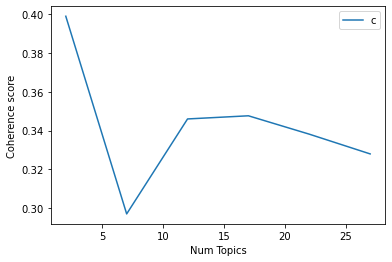

In [146]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_2020_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [147]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_2020_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 2

index: 0 | Num Topics = 2  has Coherence Value of 0.3991
index: 1 | Num Topics = 7  has Coherence Value of 0.297
index: 2 | Num Topics = 12  has Coherence Value of 0.346
index: 3 | Num Topics = 17  has Coherence Value of 0.3477
index: 4 | Num Topics = 22  has Coherence Value of 0.3382
index: 5 | Num Topics = 27  has Coherence Value of 0.328


In [185]:
# Select optimal number of topics
optimal_model_us_2020_score1N2N3 = model_list_us_2020_score1N2N3[0]

In [186]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_2020_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_us_2020_score1N2N3, corpus_us_2020_score1N2N3, id2word_us_2020_score1N2N3)

In [187]:
print("pyLDAVis for us topics for score=1,2,3 in 2020:")
vis_us_2020_score1N2N3

pyLDAVis for us topics for score=1,2,3 in 2020:


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.114354  0.0       1        1  68.106349
0     -0.114354  0.0       2        1  31.893651, topic_info=        Term        Freq       Total Category  logprob  loglift
221     view  287.000000  287.000000  Default  30.0000  30.0000
76   comment  518.000000  518.000000  Default  29.0000  29.0000
364   delete  163.000000  163.000000  Default  28.0000  28.0000
39    people  182.000000  182.000000  Default  27.0000  27.0000
140   update  224.000000  224.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
48     thing   35.041933  156.177071   Topic2  -5.4647  -0.3517
23     watch   41.408731  287.210108   Topic2  -5.2977  -0.7940
312     well   29.103349  100.925015   Topic2  -5.6504  -0.1008
53      back   31.905677  229.498122   Topic2  -5.5585  -0.8303
2        app   29.565963  438.857478   Topic2  -5.6346  -1.5548

[143 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
101       1  0.935521        ad
101       2  0.062161        ad
241       1  0.972928  annoying
241       2  0.031051  annoying
1020      2  0.962837      anti
...     ...       ...       ...
312       2  0.287342      well
70        1  0.566141      work
70        2  0.432932      work
223       1  0.034658     world
223       2  0.970415     world

[166 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

## By-rating of 2021 (Rating=1,2,3)

In [151]:
# By-rating Topic Modelling - rating = 1,2,3 in 2021
# Convert to list - move to each section
review_us_2021_score1N2N3 = youtube_ios_us_review_YearMonth_2021_score1N2N3.review.values.tolist()
review_words_us_2021_score1N2N3 = list(sent_to_words(review_us_2021_score1N2N3))
print(review_words_us_2021_score1N2N3[:1])

[['gave', 'the', 'tube', 'app', 'two', 'stars', 'for', 'two', 'reasons', 'number', 'one', 'tube', 'has', 'went', 'down', 'hill', 'since', 'first', 'joined', 'the', 'site', 'several', 'years', 'ago', 'the', 'reason', 'being', 'is', 'censorship', 'has', 'gotten', 'out', 'of', 'control', 'far', 'to', 'many', 'good', 'channels', 'have', 'been', 'taken', 'down', 'or', 'censored', 'due', 'to', 'increasing', 'rules', 'of', 'certain', 'words', 'or', 'subjects', 'being', 'used', 'or', 'discussed', 'that', 'in', 'years', 'passed', 'would', 'have', 'been', 'entertaining', 'content', 'and', 'or', 'provocative', 'reason', 'two', 'is', 'for', 'technical', 'reasons', 'which', 'have', 'found', 'seems', 'oddly', 'suspicious', 'feel', 'like', 'that', 'because', 'have', 'been', 'subscribed', 'to', 'certain', 'content', 'providers', 'and', 'some', 'time', 'become', 'unsubscribed', 'from', 'their', 'channels', 'for', 'no', 'apparent', 'reasons']]


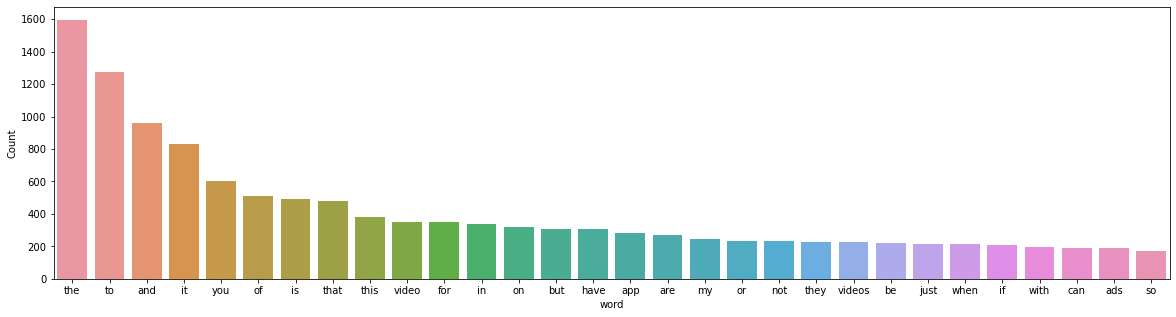

In [152]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_2021_score1N2N3))

In [153]:
# Clean text
review_words_us_ready_2021_score1N2N3 = process_words(review_words_us_2021_score1N2N3)  # processed Text Data! - move to each section

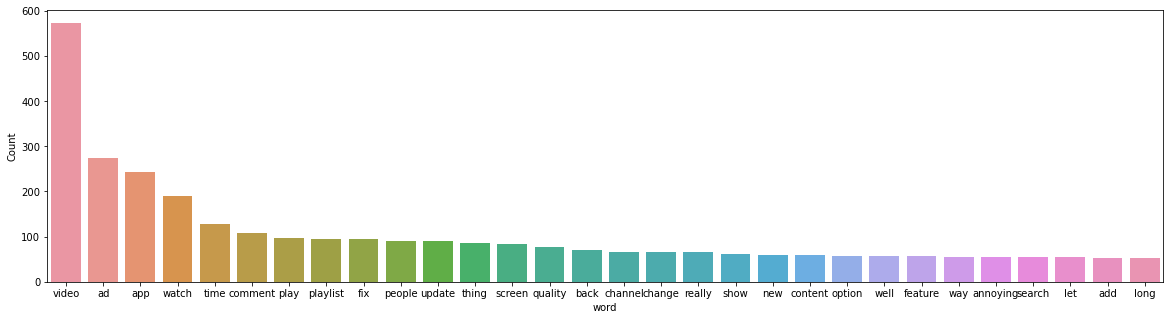

In [154]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_us_ready_2021_score1N2N3))


In [155]:
# Create Dictionary
id2word_us_2021_score1N2N3 = corpora.Dictionary(review_words_us_ready_2021_score1N2N3)

2021-10-17 02:18:44,708 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 02:18:44,751 [INFO] gensim.corpora.dictionary - built Dictionary(2498 unique tokens: ['apparent', 'become', 'censor', 'censorship', 'certain']...) from 309 documents (total 13202 corpus positions)
2021-10-17 02:18:44,753 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(2498 unique tokens: ['apparent', 'become', 'censor', 'censorship', 'certain']...) from 309 documents (total 13202 corpus positions)", 'datetime': '2021-10-17T02:18:44.752928', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [156]:
# Create Corpus: Term Document Frequency
corpus_us_2021_score1N2N3 = [id2word_us_2021_score1N2N3.doc2bow(text) for text in review_words_us_ready_2021_score1N2N3]

In [157]:
# Training LDA model
model_list_us_2021_score1N2N3, coherence_values_us_2021_score1N2N3 = compute_coherence_values(dictionary=id2word_us_2021_score1N2N3, corpus=corpus_us_2021_score1N2N3, 
                                                              texts=review_words_us_ready_2021_score1N2N3, limit=30, start=2, step=5)


2021-10-17 02:18:44,847 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 02:18:44,849 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 02:18:44,852 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 02:18:44,855 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 309 documents, updating model once every 309 documents, evaluating perplexity every 309 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 02:18:46,154 [INFO] gensim.models.ldamodel - -8.338 per-word bound, 323.6 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:18:46,156 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #309/309
2021-10-17 02:18:47,425 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.046*"video" + 0.017*"app" + 0.016*"ad" + 0.013*"watch" + 0.009*"time" + 0.008*"fix" + 0.007*"update" 

2021-10-17 02:19:00,863 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.020*"ad" + 0.012*"video" + 0.010*"people" + 0.008*"content" + 0.007*"let" + 0.007*"platform" + 0.006*"app" + 0.006*"comment" + 0.006*"tube" + 0.006*"watch"
2021-10-17 02:19:00,864 [INFO] gensim.models.ldamodel - topic diff=0.025134, rho=0.301511
2021-10-17 02:19:01,594 [INFO] gensim.models.ldamodel - -6.941 per-word bound, 122.9 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:19:01,595 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #309/309
2021-10-17 02:19:02,090 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.049*"video" + 0.020*"app" + 0.016*"ad" + 0.015*"watch" + 0.010*"time" + 0.009*"playlist" + 0.008*"fix" + 0.008*"update" + 0.008*"play" + 0.008*"screen"
2021-10-17 02:19:02,093 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.020*"ad" + 0.011*"video" + 0.010*"people" + 0.008*"content" + 0.007*"let" + 0.007*"platform" + 0.006*"app" + 0.0

2021-10-17 02:19:15,618 [INFO] gensim.models.ldamodel - topic diff=0.009774, rho=0.218218
2021-10-17 02:19:16,365 [INFO] gensim.models.ldamodel - -6.923 per-word bound, 121.4 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:19:16,372 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #309/309
2021-10-17 02:19:16,854 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.050*"video" + 0.020*"app" + 0.017*"ad" + 0.015*"watch" + 0.010*"time" + 0.009*"playlist" + 0.009*"comment" + 0.009*"play" + 0.009*"fix" + 0.008*"update"
2021-10-17 02:19:16,856 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.018*"ad" + 0.011*"people" + 0.009*"video" + 0.008*"content" + 0.007*"platform" + 0.007*"let" + 0.006*"tube" + 0.005*"thing" + 0.005*"app" + 0.005*"watch"
2021-10-17 02:19:16,857 [INFO] gensim.models.ldamodel - topic diff=0.008983, rho=0.213201
2021-10-17 02:19:17,652 [INFO] gensim.models.ldamodel - -6.922 per-word bound, 121.3 perplexity est

2021-10-17 02:19:29,150 [INFO] gensim.models.ldamodel - -6.918 per-word bound, 120.9 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:19:29,153 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #309/309
2021-10-17 02:19:29,706 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.050*"video" + 0.021*"app" + 0.018*"ad" + 0.015*"watch" + 0.010*"time" + 0.009*"comment" + 0.009*"playlist" + 0.009*"play" + 0.009*"fix" + 0.008*"update"
2021-10-17 02:19:29,708 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.017*"ad" + 0.012*"people" + 0.009*"video" + 0.008*"content" + 0.008*"platform" + 0.007*"let" + 0.006*"tube" + 0.005*"thing" + 0.005*"watch" + 0.005*"app"
2021-10-17 02:19:29,709 [INFO] gensim.models.ldamodel - topic diff=0.004905, rho=0.176777
2021-10-17 02:19:30,354 [INFO] gensim.models.ldamodel - -6.918 per-word bound, 120.9 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:19:30,371

2021-10-17 02:19:41,617 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #309/309
2021-10-17 02:19:42,105 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.050*"video" + 0.021*"app" + 0.018*"ad" + 0.015*"watch" + 0.010*"time" + 0.009*"comment" + 0.009*"playlist" + 0.009*"play" + 0.009*"fix" + 0.008*"update"
2021-10-17 02:19:42,107 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.016*"ad" + 0.012*"people" + 0.009*"video" + 0.009*"content" + 0.008*"platform" + 0.007*"let" + 0.006*"tube" + 0.006*"thing" + 0.005*"watch" + 0.005*"app"
2021-10-17 02:19:42,112 [INFO] gensim.models.ldamodel - topic diff=0.003245, rho=0.154303
2021-10-17 02:19:42,856 [INFO] gensim.models.ldamodel - -6.916 per-word bound, 120.7 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:19:42,857 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #309/309
2021-10-17 02:19:43,274 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.050*"video" + 0.0

2021-10-17 02:19:53,963 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-17 02:19:59,257 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-17 02:19:59,282 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 309 virtual documents
2021-10-17 02:19:59,672 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-17 02:19:59,675 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-17 02:19:59,689 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 02:19:59,704 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 309 documents, updating model once every 309 documents, evaluating perplexity every 309 documents, iterating 50x with a con

2021-10-17 02:20:08,565 [INFO] gensim.models.ldamodel - topic diff=0.131443, rho=0.408248
2021-10-17 02:20:09,345 [INFO] gensim.models.ldamodel - -7.142 per-word bound, 141.2 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:20:09,346 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #309/309
2021-10-17 02:20:09,917 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.028*"ad" + 0.015*"channel" + 0.013*"video" + 0.011*"app" + 0.010*"comment" + 0.008*"show" + 0.008*"keep" + 0.008*"time" + 0.007*"long" + 0.006*"watch"
2021-10-17 02:20:09,938 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.074*"video" + 0.023*"app" + 0.023*"playlist" + 0.020*"watch" + 0.017*"ad" + 0.017*"play" + 0.009*"time" + 0.008*"feature" + 0.008*"save" + 0.008*"add"
2021-10-17 02:20:09,965 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.028*"ad" + 0.018*"video" + 0.016*"people" + 0.011*"screen" + 0.009*"content" + 0.009*"watch" + 0.008*"comment" + 0.008*

2021-10-17 02:20:16,068 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.044*"video" + 0.017*"app" + 0.015*"quality" + 0.013*"watch" + 0.011*"update" + 0.010*"fix" + 0.010*"time" + 0.009*"high" + 0.009*"comment" + 0.008*"screen"
2021-10-17 02:20:16,073 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.028*"ad" + 0.018*"video" + 0.016*"people" + 0.011*"screen" + 0.010*"content" + 0.009*"watch" + 0.008*"comment" + 0.008*"app" + 0.008*"resolution" + 0.008*"stop"
2021-10-17 02:20:16,081 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.028*"ad" + 0.021*"video" + 0.015*"time" + 0.011*"thing" + 0.011*"problem" + 0.010*"minute" + 0.009*"app" + 0.009*"watch" + 0.009*"screen" + 0.009*"long"
2021-10-17 02:20:16,092 [INFO] gensim.models.ldamodel - topic diff=0.025513, rho=0.288675
2021-10-17 02:20:16,925 [INFO] gensim.models.ldamodel - -7.112 per-word bound, 138.3 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:20:16,965 [INFO] gensim.models.l

2021-10-17 02:20:23,032 [INFO] gensim.models.ldamodel - topic diff=0.011124, rho=0.242536
2021-10-17 02:20:23,946 [INFO] gensim.models.ldamodel - -7.103 per-word bound, 137.5 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:20:23,948 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #309/309
2021-10-17 02:20:24,560 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.043*"video" + 0.018*"app" + 0.016*"quality" + 0.012*"watch" + 0.012*"update" + 0.010*"high" + 0.010*"fix" + 0.010*"time" + 0.009*"comment" + 0.008*"screen"
2021-10-17 02:20:24,580 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.028*"ad" + 0.015*"channel" + 0.011*"video" + 0.010*"comment" + 0.009*"app" + 0.009*"show" + 0.008*"keep" + 0.007*"time" + 0.007*"platform" + 0.007*"well"
2021-10-17 02:20:24,591 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.028*"ad" + 0.021*"video" + 0.015*"time" + 0.012*"problem" + 0.011*"thing" + 0.011*"minute" + 0.010*"screen" + 

2021-10-17 02:20:30,695 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.043*"video" + 0.018*"quality" + 0.018*"app" + 0.013*"update" + 0.012*"watch" + 0.011*"high" + 0.010*"fix" + 0.010*"time" + 0.009*"comment" + 0.008*"change"
2021-10-17 02:20:30,705 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.029*"ad" + 0.020*"video" + 0.015*"time" + 0.012*"problem" + 0.011*"thing" + 0.011*"minute" + 0.010*"screen" + 0.010*"watch" + 0.009*"long" + 0.009*"app"
2021-10-17 02:20:30,713 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.022*"ad" + 0.018*"app" + 0.016*"video" + 0.010*"people" + 0.010*"watch" + 0.009*"content" + 0.009*"let" + 0.008*"thing" + 0.007*"well" + 0.006*"feature"
2021-10-17 02:20:30,721 [INFO] gensim.models.ldamodel - topic diff=0.006342, rho=0.208514
2021-10-17 02:20:31,458 [INFO] gensim.models.ldamodel - -7.097 per-word bound, 136.9 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:20:31,462 [INFO] gensim.models.ldamodel 

2021-10-17 02:20:36,636 [INFO] gensim.models.ldamodel - topic diff=0.005061, rho=0.188982
2021-10-17 02:20:37,314 [INFO] gensim.models.ldamodel - -7.093 per-word bound, 136.6 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:20:37,316 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #309/309
2021-10-17 02:20:37,872 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.028*"ad" + 0.017*"people" + 0.015*"video" + 0.010*"content" + 0.010*"screen" + 0.009*"comment" + 0.008*"watch" + 0.008*"resolution" + 0.008*"well" + 0.007*"stop"
2021-10-17 02:20:37,874 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.028*"ad" + 0.015*"channel" + 0.011*"video" + 0.010*"comment" + 0.009*"app" + 0.009*"show" + 0.008*"keep" + 0.007*"platform" + 0.007*"time" + 0.007*"long"
2021-10-17 02:20:37,879 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.022*"ad" + 0.018*"app" + 0.016*"video" + 0.010*"people" + 0.010*"watch" + 0.009*"content" + 0.009*"let" 

2021-10-17 02:20:43,731 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.043*"video" + 0.020*"quality" + 0.018*"app" + 0.014*"update" + 0.012*"high" + 0.011*"watch" + 0.010*"fix" + 0.010*"time" + 0.009*"change" + 0.009*"comment"
2021-10-17 02:20:43,734 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.028*"ad" + 0.015*"channel" + 0.011*"video" + 0.010*"comment" + 0.009*"app" + 0.009*"show" + 0.008*"keep" + 0.007*"platform" + 0.007*"time" + 0.007*"long"
2021-10-17 02:20:43,736 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.022*"ad" + 0.018*"app" + 0.016*"video" + 0.010*"people" + 0.010*"watch" + 0.009*"let" + 0.009*"content" + 0.008*"thing" + 0.007*"well" + 0.007*"feature"
2021-10-17 02:20:43,738 [INFO] gensim.models.ldamodel - topic diff=0.004173, rho=0.171499
2021-10-17 02:20:44,310 [INFO] gensim.models.ldamodel - -7.090 per-word bound, 136.2 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:20:44,312 [INFO] gensim.models.ldamodel

2021-10-17 02:20:49,536 [INFO] gensim.models.ldamodel - topic diff=0.003866, rho=0.160128
2021-10-17 02:20:50,263 [INFO] gensim.models.ldamodel - -7.087 per-word bound, 136.0 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:20:50,264 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #309/309
2021-10-17 02:20:50,727 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.022*"ad" + 0.018*"app" + 0.016*"video" + 0.011*"people" + 0.010*"watch" + 0.009*"let" + 0.009*"content" + 0.008*"thing" + 0.007*"well" + 0.007*"feature"
2021-10-17 02:20:50,744 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.028*"ad" + 0.015*"channel" + 0.011*"video" + 0.011*"comment" + 0.009*"show" + 0.009*"app" + 0.008*"keep" + 0.007*"platform" + 0.007*"time" + 0.007*"long"
2021-10-17 02:20:50,758 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.029*"ad" + 0.018*"people" + 0.014*"video" + 0.010*"content" + 0.009*"screen" + 0.009*"comment" + 0.008*"resolutio

2021-10-17 02:20:56,486 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.022*"ad" + 0.018*"app" + 0.016*"video" + 0.011*"people" + 0.010*"watch" + 0.009*"let" + 0.009*"content" + 0.008*"thing" + 0.007*"well" + 0.007*"feature"
2021-10-17 02:20:56,490 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.029*"ad" + 0.018*"people" + 0.014*"video" + 0.010*"content" + 0.009*"screen" + 0.009*"resolution" + 0.009*"comment" + 0.008*"watch" + 0.008*"well" + 0.006*"stop"
2021-10-17 02:20:56,494 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.028*"ad" + 0.015*"channel" + 0.011*"comment" + 0.010*"video" + 0.009*"show" + 0.009*"app" + 0.008*"keep" + 0.007*"platform" + 0.007*"time" + 0.007*"well"
2021-10-17 02:20:56,497 [INFO] gensim.models.ldamodel - topic diff=0.003439, rho=0.149071
2021-10-17 02:20:57,237 [INFO] gensim.models.ldamodel - -7.084 per-word bound, 135.7 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:20:57,239 [INFO] gensim.models.ld

2021-10-17 02:21:02,309 [INFO] gensim.models.ldamodel - topic diff=0.003064, rho=0.141421
2021-10-17 02:21:02,976 [INFO] gensim.models.ldamodel - -7.082 per-word bound, 135.5 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:21:02,978 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #309/309
2021-10-17 02:21:03,487 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.029*"ad" + 0.018*"people" + 0.013*"video" + 0.011*"content" + 0.009*"screen" + 0.009*"resolution" + 0.008*"comment" + 0.008*"watch" + 0.008*"well" + 0.006*"enough"
2021-10-17 02:21:03,489 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.022*"ad" + 0.018*"app" + 0.016*"video" + 0.011*"people" + 0.010*"watch" + 0.009*"let" + 0.009*"content" + 0.008*"thing" + 0.007*"well" + 0.007*"feature"
2021-10-17 02:21:03,490 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.029*"ad" + 0.016*"video" + 0.014*"time" + 0.011*"problem" + 0.010*"minute" + 0.010*"thing" + 0.009*"lon

2021-10-17 02:21:16,584 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.036*"video" + 0.024*"quality" + 0.019*"resolution" + 0.016*"app" + 0.014*"high" + 0.013*"people" + 0.013*"ad" + 0.012*"change" + 0.011*"choose" + 0.011*"update"
2021-10-17 02:21:16,589 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.037*"ad" + 0.019*"video" + 0.019*"minute" + 0.013*"watch" + 0.013*"long" + 0.011*"time" + 0.008*"still" + 0.007*"app" + 0.007*"thing" + 0.007*"show"
2021-10-17 02:21:16,600 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.042*"comment" + 0.018*"section" + 0.016*"side" + 0.013*"leave" + 0.012*"people" + 0.010*"video" + 0.010*"ad" + 0.008*"watch" + 0.007*"ipad" + 0.007*"option"
2021-10-17 02:21:16,602 [INFO] gensim.models.ldamodel - topic diff=0.253675, rho=0.447214
2021-10-17 02:21:17,309 [INFO] gensim.models.ldamodel - -7.284 per-word bound, 155.9 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:21:17,310 [INFO] gensim.models.ldam

2021-10-17 02:21:22,299 [INFO] gensim.models.ldamodel - -7.220 per-word bound, 149.1 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:21:22,301 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #309/309
2021-10-17 02:21:22,660 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.052*"video" + 0.016*"app" + 0.014*"comment" + 0.012*"screen" + 0.012*"watch" + 0.011*"turn" + 0.010*"fix" + 0.010*"search" + 0.010*"wait" + 0.009*"update"
2021-10-17 02:21:22,662 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.058*"comment" + 0.024*"section" + 0.016*"side" + 0.015*"leave" + 0.013*"people" + 0.011*"video" + 0.010*"ad" + 0.009*"ipad" + 0.008*"watch" + 0.007*"option"
2021-10-17 02:21:22,665 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.020*"app" + 0.015*"day" + 0.014*"people" + 0.011*"screen" + 0.011*"ask" + 0.010*"let" + 0.010*"video" + 0.008*"time" + 0.008*"much" + 0.008*"great"
2021-10-17 02:21:22,666 [INFO] gensim.models.ldamo

2021-10-17 02:21:27,461 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.081*"video" + 0.029*"playlist" + 0.025*"watch" + 0.023*"app" + 0.022*"ad" + 0.019*"play" + 0.011*"time" + 0.009*"add" + 0.009*"thing" + 0.009*"feature"
2021-10-17 02:21:27,464 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.050*"video" + 0.015*"app" + 0.014*"comment" + 0.012*"screen" + 0.011*"turn" + 0.011*"watch" + 0.011*"search" + 0.010*"wait" + 0.010*"fix" + 0.009*"update"
2021-10-17 02:21:27,469 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.063*"comment" + 0.026*"section" + 0.017*"side" + 0.016*"leave" + 0.013*"people" + 0.011*"video" + 0.011*"ad" + 0.009*"ipad" + 0.008*"tube" + 0.008*"watch"
2021-10-17 02:21:27,473 [INFO] gensim.models.ldamodel - topic diff=0.016214, rho=0.250000
2021-10-17 02:21:28,002 [INFO] gensim.models.ldamodel - -7.202 per-word bound, 147.3 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:21:28,005 [INFO] gensim.models.ldamodel 

2021-10-17 02:21:34,641 [INFO] gensim.models.ldamodel - -7.195 per-word bound, 146.5 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:21:34,643 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #309/309
2021-10-17 02:21:35,110 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.020*"app" + 0.015*"day" + 0.015*"people" + 0.011*"ask" + 0.011*"screen" + 0.010*"let" + 0.010*"video" + 0.008*"much" + 0.008*"time" + 0.008*"great"
2021-10-17 02:21:35,112 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.015*"scary" + 0.011*"thing" + 0.011*"channel" + 0.010*"truth" + 0.010*"update" + 0.010*"kid" + 0.009*"turn" + 0.009*"watch" + 0.008*"let" + 0.008*"caption"
2021-10-17 02:21:35,114 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.081*"video" + 0.028*"playlist" + 0.025*"watch" + 0.023*"app" + 0.022*"ad" + 0.019*"play" + 0.011*"time" + 0.009*"thing" + 0.009*"add" + 0.009*"feature"
2021-10-17 02:21:35,115 [INFO] gensim.models.ldamode

2021-10-17 02:21:40,040 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.070*"comment" + 0.028*"section" + 0.016*"side" + 0.015*"leave" + 0.013*"people" + 0.011*"video" + 0.010*"tube" + 0.010*"ad" + 0.009*"ipad" + 0.008*"post"
2021-10-17 02:21:40,043 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.038*"ad" + 0.023*"video" + 0.013*"people" + 0.011*"report" + 0.011*"listen" + 0.010*"stop" + 0.010*"content" + 0.008*"search" + 0.008*"bad" + 0.007*"music"
2021-10-17 02:21:40,046 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.016*"scary" + 0.011*"channel" + 0.011*"thing" + 0.011*"kid" + 0.010*"truth" + 0.010*"update" + 0.009*"turn" + 0.009*"watch" + 0.009*"let" + 0.008*"caption"
2021-10-17 02:21:40,047 [INFO] gensim.models.ldamodel - topic diff=0.005548, rho=0.192450
2021-10-17 02:21:40,523 [INFO] gensim.models.ldamodel - -7.189 per-word bound, 145.9 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:21:40,528 [INFO] gensim.models.ldam

2021-10-17 02:21:45,838 [INFO] gensim.models.ldamodel - topic diff=0.004125, rho=0.176777
2021-10-17 02:21:46,503 [INFO] gensim.models.ldamodel - -7.185 per-word bound, 145.5 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:21:46,504 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #309/309
2021-10-17 02:21:46,894 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.041*"video" + 0.032*"quality" + 0.020*"resolution" + 0.019*"high" + 0.017*"change" + 0.015*"app" + 0.014*"choose" + 0.013*"option" + 0.012*"update" + 0.012*"set"
2021-10-17 02:21:46,908 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.038*"ad" + 0.023*"video" + 0.013*"people" + 0.011*"report" + 0.011*"listen" + 0.010*"stop" + 0.010*"content" + 0.008*"search" + 0.008*"bad" + 0.006*"crowder"
2021-10-17 02:21:46,918 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.017*"scary" + 0.012*"kid" + 0.012*"channel" + 0.011*"thing" + 0.010*"truth" + 0.010*"update" + 0.00

2021-10-17 02:21:52,606 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.041*"video" + 0.032*"quality" + 0.020*"resolution" + 0.019*"high" + 0.017*"change" + 0.015*"app" + 0.014*"choose" + 0.013*"option" + 0.012*"update" + 0.012*"set"
2021-10-17 02:21:52,608 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.040*"ad" + 0.023*"video" + 0.013*"people" + 0.011*"report" + 0.011*"listen" + 0.010*"content" + 0.010*"stop" + 0.008*"search" + 0.008*"bad" + 0.006*"crowder"
2021-10-17 02:21:52,610 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.081*"video" + 0.027*"playlist" + 0.026*"watch" + 0.023*"app" + 0.023*"ad" + 0.019*"play" + 0.012*"time" + 0.009*"thing" + 0.009*"fix" + 0.009*"add"
2021-10-17 02:21:52,612 [INFO] gensim.models.ldamodel - topic diff=0.003243, rho=0.162221
2021-10-17 02:21:53,282 [INFO] gensim.models.ldamodel - -7.182 per-word bound, 145.2 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:21:53,288 [INFO] gensim.models.lda

2021-10-17 02:21:58,798 [INFO] gensim.models.ldamodel - -7.180 per-word bound, 145.0 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:21:58,800 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #309/309
2021-10-17 02:21:59,207 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.042*"ad" + 0.023*"video" + 0.013*"people" + 0.011*"report" + 0.011*"content" + 0.010*"listen" + 0.010*"stop" + 0.008*"search" + 0.008*"bad" + 0.006*"crowder"
2021-10-17 02:21:59,230 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.046*"video" + 0.015*"app" + 0.013*"comment" + 0.011*"search" + 0.011*"turn" + 0.011*"wait" + 0.011*"screen" + 0.009*"update" + 0.009*"fix" + 0.009*"watch"
2021-10-17 02:21:59,231 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.042*"video" + 0.033*"quality" + 0.020*"resolution" + 0.019*"high" + 0.017*"change" + 0.015*"app" + 0.014*"choose" + 0.013*"option" + 0.012*"update" + 0.012*"set"
2021-10-17 02:21:59,233 [INFO] gens

2021-10-17 02:22:04,753 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.020*"app" + 0.015*"day" + 0.015*"people" + 0.011*"ask" + 0.010*"screen" + 0.010*"let" + 0.010*"video" + 0.008*"much" + 0.008*"time" + 0.008*"great"
2021-10-17 02:22:04,754 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.039*"ad" + 0.025*"minute" + 0.018*"video" + 0.016*"long" + 0.013*"watch" + 0.012*"time" + 0.009*"skip" + 0.009*"issue" + 0.009*"app" + 0.007*"still"
2021-10-17 02:22:04,757 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.074*"comment" + 0.027*"section" + 0.016*"side" + 0.015*"leave" + 0.013*"tube" + 0.012*"people" + 0.011*"video" + 0.010*"ipad" + 0.010*"ad" + 0.009*"post"
2021-10-17 02:22:04,758 [INFO] gensim.models.ldamodel - topic diff=0.002080, rho=0.142857
2021-10-17 02:22:05,378 [INFO] gensim.models.ldamodel - -7.177 per-word bound, 144.8 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:22:05,382 [INFO] gensim.models.ldamodel - PROGRESS

2021-10-17 02:22:19,017 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #309/309
2021-10-17 02:22:19,555 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.017*"video" + 0.016*"find" + 0.014*"channel" + 0.010*"article" + 0.010*"look" + 0.010*"people" + 0.009*"much" + 0.009*"app" + 0.009*"way" + 0.009*"read"
2021-10-17 02:22:19,590 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.017*"comment" + 0.014*"people" + 0.014*"update" + 0.011*"channel" + 0.010*"video" + 0.010*"let" + 0.009*"watch" + 0.009*"show" + 0.008*"hear" + 0.008*"post"
2021-10-17 02:22:19,597 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.024*"app" + 0.015*"screen" + 0.013*"day" + 0.013*"video" + 0.010*"time" + 0.010*"watch" + 0.010*"ask" + 0.009*"back" + 0.008*"work" + 0.007*"upgrade"
2021-10-17 02:22:19,611 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.024*"ad" + 0.018*"video" + 0.012*"long" + 0.010*"thing" + 0.010*"time" + 0.008*"issue" + 0.008*"pop" + 0.008*"minute" + 0.008*"fix" + 0.00

2021-10-17 02:22:26,476 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.041*"quality" + 0.038*"video" + 0.025*"resolution" + 0.023*"high" + 0.019*"change" + 0.017*"choose" + 0.017*"option" + 0.017*"app" + 0.015*"ad" + 0.014*"people"
2021-10-17 02:22:26,478 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.011*"video" + 0.010*"app" + 0.010*"really" + 0.009*"account" + 0.008*"tap" + 0.008*"let" + 0.008*"back" + 0.008*"fix" + 0.007*"buy" + 0.007*"history"
2021-10-17 02:22:26,483 [INFO] gensim.models.ldamodel - topic diff=0.099373, rho=0.333333
2021-10-17 02:22:27,139 [INFO] gensim.models.ldamodel - -7.279 per-word bound, 155.3 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:22:27,140 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #309/309
2021-10-17 02:22:27,599 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.082*"video" + 0.040*"playlist" + 0.026*"play" + 0.025*"watch" + 0.022*"app" + 0.013*"save" + 0.012*"ad" + 0.01

2021-10-17 02:22:32,847 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #309/309
2021-10-17 02:22:33,184 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.052*"comment" + 0.023*"section" + 0.019*"ipad" + 0.018*"side" + 0.015*"post" + 0.014*"video" + 0.011*"community" + 0.011*"option" + 0.010*"add" + 0.009*"leave"
2021-10-17 02:22:33,196 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.016*"speech" + 0.014*"video" + 0.013*"free" + 0.013*"people" + 0.012*"app" + 0.009*"let" + 0.009*"really" + 0.008*"creator" + 0.008*"believe" + 0.008*"silence"
2021-10-17 02:22:33,220 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.016*"people" + 0.015*"update" + 0.014*"let" + 0.012*"channel" + 0.011*"hear" + 0.011*"comment" + 0.010*"side" + 0.009*"show" + 0.009*"live" + 0.009*"control"
2021-10-17 02:22:33,223 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.020*"fix" + 0.017*"app" + 0.017*"video" + 0.016*"watch" + 0.012*"caption" + 0.010*"update" + 0.010*"content" + 0.009*"h

2021-10-17 02:22:38,809 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.020*"fix" + 0.017*"app" + 0.016*"watch" + 0.016*"video" + 0.012*"caption" + 0.010*"update" + 0.010*"content" + 0.009*"hate" + 0.009*"turn" + 0.008*"new"
2021-10-17 02:22:38,811 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.024*"app" + 0.016*"day" + 0.015*"screen" + 0.012*"video" + 0.011*"time" + 0.010*"love" + 0.010*"ask" + 0.010*"back" + 0.009*"watch" + 0.008*"fix"
2021-10-17 02:22:38,814 [INFO] gensim.models.ldamodel - topic diff=0.011564, rho=0.223607
2021-10-17 02:22:39,499 [INFO] gensim.models.ldamodel - -7.239 per-word bound, 151.0 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:22:39,501 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #309/309
2021-10-17 02:22:39,935 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.016*"speech" + 0.013*"video" + 0.013*"free" + 0.013*"people" + 0.012*"app" + 0.010*"let" + 0.009*"really" + 0.008*"cre

2021-10-17 02:22:46,396 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #309/309
2021-10-17 02:22:46,807 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.009*"really" + 0.009*"account" + 0.009*"tap" + 0.009*"let" + 0.008*"app" + 0.008*"fix" + 0.008*"back" + 0.008*"buy" + 0.008*"history" + 0.007*"well"
2021-10-17 02:22:46,809 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.024*"app" + 0.016*"day" + 0.015*"screen" + 0.011*"video" + 0.011*"time" + 0.011*"love" + 0.011*"ask" + 0.010*"back" + 0.009*"watch" + 0.008*"fix"
2021-10-17 02:22:46,813 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.024*"ad" + 0.013*"people" + 0.013*"video" + 0.013*"fix" + 0.011*"season" + 0.011*"content" + 0.010*"change" + 0.010*"app" + 0.010*"add" + 0.009*"thing"
2021-10-17 02:22:46,819 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.050*"video" + 0.021*"watch" + 0.017*"scary" + 0.017*"thing" + 0.011*"app" + 0.010*"time" + 0.009*"people" + 0.008*"recommend" + 0.008*"kid" + 0.008*"pa

2021-10-17 02:22:52,134 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.058*"comment" + 0.026*"ipad" + 0.023*"section" + 0.017*"side" + 0.016*"post" + 0.015*"video" + 0.013*"option" + 0.013*"community" + 0.010*"add" + 0.010*"old"
2021-10-17 02:22:52,137 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.082*"video" + 0.038*"playlist" + 0.026*"watch" + 0.026*"play" + 0.023*"app" + 0.012*"save" + 0.011*"time" + 0.010*"fix" + 0.010*"back" + 0.010*"screen"
2021-10-17 02:22:52,139 [INFO] gensim.models.ldamodel - topic diff=0.004783, rho=0.179605
2021-10-17 02:22:52,762 [INFO] gensim.models.ldamodel - -7.225 per-word bound, 149.6 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:22:52,763 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #309/309
2021-10-17 02:22:53,251 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.023*"ad" + 0.014*"people" + 0.013*"video" + 0.013*"fix" + 0.011*"season" + 0.011*"content" + 0.010*"change" + 

2021-10-17 02:22:58,520 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #309/309
2021-10-17 02:22:58,923 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.082*"video" + 0.038*"playlist" + 0.026*"watch" + 0.026*"play" + 0.023*"app" + 0.012*"save" + 0.011*"time" + 0.011*"fix" + 0.010*"back" + 0.010*"screen"
2021-10-17 02:22:58,925 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.032*"app" + 0.019*"ad" + 0.019*"time" + 0.013*"update" + 0.012*"content" + 0.012*"problem" + 0.011*"video" + 0.010*"feature" + 0.008*"platform" + 0.008*"search"
2021-10-17 02:22:58,928 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.013*"content" + 0.011*"comment" + 0.009*"crowder" + 0.009*"troll" + 0.009*"delete" + 0.009*"view" + 0.008*"well" + 0.007*"topic" + 0.007*"story" + 0.007*"info"
2021-10-17 02:22:58,932 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.023*"ad" + 0.014*"people" + 0.013*"fix" + 0.013*"video" + 0.011*"season" + 0.011*"content" + 0.010*"change" + 0.010*"add" + 0.0

2021-10-17 02:23:05,138 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.032*"app" + 0.019*"ad" + 0.019*"time" + 0.013*"update" + 0.012*"content" + 0.012*"problem" + 0.011*"video" + 0.010*"feature" + 0.008*"platform" + 0.008*"search"
2021-10-17 02:23:05,142 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.018*"ad" + 0.012*"time" + 0.011*"thing" + 0.010*"long" + 0.009*"video" + 0.009*"issue" + 0.009*"pop" + 0.008*"bad" + 0.008*"first" + 0.008*"ok"
2021-10-17 02:23:05,151 [INFO] gensim.models.ldamodel - topic diff=0.002582, rho=0.154303
2021-10-17 02:23:05,886 [INFO] gensim.models.ldamodel - -7.219 per-word bound, 149.0 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:23:05,888 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #309/309
2021-10-17 02:23:06,286 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.027*"ad" + 0.021*"video" + 0.019*"channel" + 0.015*"comment" + 0.013*"time" + 0.011*"account" + 0.009*"reason" + 0.

2021-10-17 02:23:11,652 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #309/309
2021-10-17 02:23:12,127 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.091*"ad" + 0.049*"video" + 0.023*"app" + 0.018*"watch" + 0.014*"minute" + 0.012*"music" + 0.010*"pop" + 0.010*"turn" + 0.009*"screen" + 0.009*"skip"
2021-10-17 02:23:12,129 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.058*"comment" + 0.031*"ipad" + 0.023*"section" + 0.018*"post" + 0.017*"side" + 0.015*"video" + 0.014*"community" + 0.013*"option" + 0.010*"old" + 0.010*"add"
2021-10-17 02:23:12,134 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.017*"fix" + 0.014*"app" + 0.014*"watch" + 0.013*"caption" + 0.011*"video" + 0.011*"update" + 0.010*"content" + 0.009*"turn" + 0.009*"hate" + 0.009*"computer"
2021-10-17 02:23:12,140 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.027*"ad" + 0.021*"video" + 0.019*"channel" + 0.015*"comment" + 0.013*"time" + 0.011*"account" + 0.009*"reason" + 0.009*"watch" + 0.00

2021-10-17 02:23:27,242 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.080*"video" + 0.030*"playlist" + 0.019*"app" + 0.018*"watch" + 0.016*"play" + 0.014*"ad" + 0.011*"save" + 0.010*"back" + 0.008*"time" + 0.008*"comment"
2021-10-17 02:23:27,255 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.017*"video" + 0.015*"channel" + 0.014*"read" + 0.013*"look" + 0.011*"find" + 0.011*"glitch" + 0.008*"app" + 0.008*"way" + 0.008*"much" + 0.007*"screen"
2021-10-17 02:23:27,267 [INFO] gensim.models.ldamodel - topic diff=15.957181, rho=1.000000
2021-10-17 02:23:28,277 [INFO] gensim.models.ldamodel - -7.990 per-word bound, 254.2 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:23:28,286 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #309/309
2021-10-17 02:23:29,064 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.020*"ad" + 0.017*"content" + 0.017*"comment" + 0.015*"video" + 0.015*"people" + 0.010*"crowder" + 0.009*"leave" + 0

2021-10-17 02:23:35,162 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #309/309
2021-10-17 02:23:35,758 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.023*"video" + 0.015*"still" + 0.014*"long" + 0.013*"app" + 0.010*"back" + 0.010*"work" + 0.010*"time" + 0.010*"look" + 0.010*"note" + 0.010*"let"
2021-10-17 02:23:35,760 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.021*"look" + 0.016*"video" + 0.015*"glitch" + 0.014*"read" + 0.013*"find" + 0.012*"app" + 0.011*"channel" + 0.010*"much" + 0.010*"gum" + 0.010*"copyright"
2021-10-17 02:23:35,768 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.019*"video" + 0.013*"app" + 0.013*"watch" + 0.013*"tap" + 0.010*"yt" + 0.010*"day" + 0.010*"start" + 0.010*"platform" + 0.010*"turn" + 0.010*"really"
2021-10-17 02:23:35,770 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.021*"people" + 0.017*"let" + 0.012*"stop" + 0.012*"hear" + 0.012*"tube" + 0.010*"fight" + 0.010*"kid" + 0.009*"watch" + 0.007*"show" + 0.007*"ban"


2021-10-17 02:23:42,131 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.024*"video" + 0.023*"time" + 0.020*"ad" + 0.016*"thing" + 0.013*"problem" + 0.011*"fix" + 0.009*"watch" + 0.009*"show" + 0.008*"stay" + 0.008*"different"
2021-10-17 02:23:42,134 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.024*"comment" + 0.022*"ad" + 0.016*"content" + 0.016*"people" + 0.014*"video" + 0.012*"leave" + 0.010*"second" + 0.009*"crowder" + 0.009*"bad" + 0.009*"bot"
2021-10-17 02:23:42,137 [INFO] gensim.models.ldamodel - topic diff=0.045488, rho=0.277350
2021-10-17 02:23:42,893 [INFO] gensim.models.ldamodel - -7.333 per-word bound, 161.2 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:23:42,894 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #309/309
2021-10-17 02:23:43,222 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.019*"video" + 0.013*"app" + 0.013*"watch" + 0.013*"tap" + 0.010*"yt" + 0.010*"day" + 0.010*"start" + 0.010*"

2021-10-17 02:23:48,661 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #309/309
2021-10-17 02:23:49,160 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.060*"video" + 0.029*"watch" + 0.017*"time" + 0.013*"comment" + 0.013*"turn" + 0.012*"shuffle" + 0.012*"click" + 0.012*"song" + 0.010*"play" + 0.010*"fix"
2021-10-17 02:23:49,164 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.024*"comment" + 0.023*"ad" + 0.016*"content" + 0.016*"people" + 0.014*"video" + 0.012*"leave" + 0.011*"second" + 0.009*"crowder" + 0.009*"bad" + 0.009*"bot"
2021-10-17 02:23:49,166 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.030*"app" + 0.025*"video" + 0.023*"change" + 0.015*"fix" + 0.013*"kid" + 0.011*"watch" + 0.010*"profile" + 0.010*"people" + 0.010*"click" + 0.008*"let"
2021-10-17 02:23:49,169 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.015*"long" + 0.015*"video" + 0.013*"still" + 0.012*"app" + 0.011*"back" + 0.011*"time" + 0.011*"look" + 0.011*"note" + 0.011*"let" + 0.0

2021-10-17 02:23:54,169 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.014*"speech" + 0.013*"video" + 0.011*"free" + 0.011*"silence" + 0.011*"creator" + 0.010*"time" + 0.009*"freedom" + 0.009*"remove" + 0.009*"believe" + 0.009*"tube"
2021-10-17 02:23:54,170 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.030*"app" + 0.024*"video" + 0.023*"change" + 0.015*"fix" + 0.013*"kid" + 0.011*"watch" + 0.010*"profile" + 0.010*"people" + 0.009*"click" + 0.008*"let"
2021-10-17 02:23:54,171 [INFO] gensim.models.ldamodel - topic diff=0.007548, rho=0.204124
2021-10-17 02:23:55,043 [INFO] gensim.models.ldamodel - -7.307 per-word bound, 158.3 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:23:55,045 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #309/309
2021-10-17 02:23:55,527 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.034*"ad" + 0.024*"video" + 0.021*"screen" + 0.015*"people" + 0.013*"resolution" + 0.013*"comment" + 0.0

2021-10-17 02:24:00,784 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #309/309
2021-10-17 02:24:01,139 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.015*"speech" + 0.013*"video" + 0.011*"silence" + 0.011*"free" + 0.011*"creator" + 0.010*"time" + 0.009*"freedom" + 0.009*"remove" + 0.009*"believe" + 0.009*"tube"
2021-10-17 02:24:01,143 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.015*"long" + 0.014*"video" + 0.013*"still" + 0.012*"app" + 0.011*"back" + 0.011*"time" + 0.011*"look" + 0.011*"note" + 0.011*"let" + 0.011*"book"
2021-10-17 02:24:01,145 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.030*"app" + 0.024*"video" + 0.024*"change" + 0.016*"fix" + 0.013*"kid" + 0.011*"watch" + 0.011*"profile" + 0.010*"people" + 0.009*"click" + 0.008*"let"
2021-10-17 02:24:01,147 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.089*"video" + 0.037*"playlist" + 0.026*"play" + 0.023*"watch" + 0.019*"app" + 0.013*"save" + 0.011*"add" + 0.011*"ad" + 0.010*"back" + 0.0

2021-10-17 02:24:07,276 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.024*"comment" + 0.023*"ad" + 0.016*"content" + 0.016*"people" + 0.014*"video" + 0.012*"leave" + 0.011*"second" + 0.009*"crowder" + 0.009*"bad" + 0.009*"bot"
2021-10-17 02:24:07,278 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.044*"search" + 0.025*"video" + 0.019*"time" + 0.017*"update" + 0.016*"caption" + 0.016*"keep" + 0.015*"feature" + 0.015*"app" + 0.013*"turn" + 0.013*"add"
2021-10-17 02:24:07,279 [INFO] gensim.models.ldamodel - topic diff=0.003386, rho=0.169031
2021-10-17 02:24:08,150 [INFO] gensim.models.ldamodel - -7.297 per-word bound, 157.3 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:24:08,154 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #309/309
2021-10-17 02:24:08,609 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.070*"ad" + 0.040*"video" + 0.025*"app" + 0.021*"watch" + 0.016*"minute" + 0.016*"music" + 0.010*"listen" +

2021-10-17 02:24:14,722 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #309/309
2021-10-17 02:24:15,234 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.019*"video" + 0.013*"app" + 0.013*"watch" + 0.013*"tap" + 0.010*"yt" + 0.010*"day" + 0.010*"start" + 0.010*"platform" + 0.010*"turn" + 0.010*"really"
2021-10-17 02:24:15,238 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.062*"quality" + 0.041*"video" + 0.035*"high" + 0.029*"change" + 0.028*"resolution" + 0.023*"app" + 0.022*"option" + 0.021*"set" + 0.021*"setting" + 0.020*"choose"
2021-10-17 02:24:15,240 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.035*"ad" + 0.022*"video" + 0.020*"screen" + 0.015*"people" + 0.013*"comment" + 0.012*"resolution" + 0.012*"well" + 0.011*"channel" + 0.011*"report" + 0.009*"way"
2021-10-17 02:24:15,244 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.024*"time" + 0.024*"video" + 0.020*"ad" + 0.016*"thing" + 0.012*"problem" + 0.012*"fix" + 0.010*"stay" + 0.009*"watch" + 0.

2021-10-17 02:24:20,675 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.090*"video" + 0.037*"playlist" + 0.026*"play" + 0.023*"watch" + 0.019*"app" + 0.012*"save" + 0.011*"ad" + 0.011*"add" + 0.010*"time" + 0.009*"back"
2021-10-17 02:24:20,679 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.022*"people" + 0.017*"let" + 0.012*"stop" + 0.012*"tube" + 0.012*"hear" + 0.010*"fight" + 0.010*"kid" + 0.007*"truth" + 0.007*"side" + 0.007*"well"
2021-10-17 02:24:20,682 [INFO] gensim.models.ldamodel - topic diff=0.001910, rho=0.147442
2021-10-17 02:24:21,291 [INFO] gensim.models.ldamodel - -7.291 per-word bound, 156.6 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:24:21,292 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #309/309
2021-10-17 02:24:21,689 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.022*"look" + 0.016*"glitch" + 0.014*"read" + 0.014*"video" + 0.014*"find" + 0.012*"channel" + 0.011*"much" + 0.011*"gum" +

2021-10-17 02:24:26,057 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-17 02:24:31,420 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-17 02:24:31,492 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 309 virtual documents
2021-10-17 02:24:36,249 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.037037037037037035
2021-10-17 02:24:36,261 [INFO] gensim.models.ldamodel - using symmetric eta at 0.037037037037037035
2021-10-17 02:24:36,264 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 02:24:36,295 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 27 topics, 50 passes over the supplied corpus of 309 documents, updating model once every 309 documents, evaluating perplexity every 309 documents, iterating 50x with a 

2021-10-17 02:24:43,291 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.026*"app" + 0.023*"watch" + 0.021*"account" + 0.019*"fix" + 0.018*"people" + 0.013*"video" + 0.013*"kid" + 0.011*"back" + 0.010*"hate" + 0.010*"content"
2021-10-17 02:24:43,293 [INFO] gensim.models.ldamodel - topic diff=0.288457, rho=0.408248
2021-10-17 02:24:43,934 [INFO] gensim.models.ldamodel - -7.478 per-word bound, 178.3 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:24:43,935 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #309/309
2021-10-17 02:24:44,280 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.018*"ad" + 0.013*"platform" + 0.013*"content" + 0.010*"thing" + 0.010*"video" + 0.010*"keep" + 0.009*"read" + 0.009*"comment" + 0.009*"section" + 0.009*"screen"
2021-10-17 02:24:44,282 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.022*"gum" + 0.017*"look" + 0.017*"package" + 0.017*"teen" + 0.011*"find" + 0.011*"mailman" + 0.011*"smoke

2021-10-17 02:24:49,147 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.068*"wait" + 0.036*"turn" + 0.022*"screen" + 0.022*"caption" + 0.022*"sir" + 0.019*"hold" + 0.016*"꼰대" + 0.016*"손들어라" + 0.016*"들어" + 0.012*"man"
2021-10-17 02:24:49,149 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.041*"people" + 0.041*"resolution" + 0.025*"well" + 0.025*"screen" + 0.016*"watch" + 0.016*"absurd" + 0.016*"patronise" + 0.016*"box" + 0.016*"display" + 0.012*"recommend"
2021-10-17 02:24:49,150 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.018*"watch" + 0.017*"video" + 0.017*"app" + 0.014*"youtube" + 0.014*"complicated" + 0.012*"resolution" + 0.012*"later" + 0.010*"yt" + 0.010*"premium" + 0.010*"swipe"
2021-10-17 02:24:49,152 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.048*"search" + 0.030*"feature" + 0.022*"update" + 0.019*"app" + 0.016*"time" + 0.015*"keep" + 0.013*"reason" + 0.012*"video" + 0.011*"watch" + 0.011*"regular"
2021-10-17 02:24:49,152 [INFO] gensim.models.ldamod

2021-10-17 02:24:54,982 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.050*"ad" + 0.042*"video" + 0.041*"app" + 0.012*"watch" + 0.011*"minute" + 0.010*"music" + 0.010*"long" + 0.010*"channel" + 0.009*"time" + 0.009*"much"
2021-10-17 02:24:54,983 [INFO] gensim.models.ldamodel - topic diff=0.019881, rho=0.242536
2021-10-17 02:24:55,703 [INFO] gensim.models.ldamodel - -7.366 per-word bound, 165.0 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:24:55,705 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #309/309
2021-10-17 02:24:56,269 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.052*"ad" + 0.048*"video" + 0.026*"watch" + 0.021*"app" + 0.015*"click" + 0.014*"time" + 0.010*"give" + 0.009*"reason" + 0.008*"advertisement" + 0.008*"thing"
2021-10-17 02:24:56,271 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.096*"comment" + 0.054*"section" + 0.027*"post" + 0.023*"community" + 0.020*"ipad" + 0.018*"video" + 0.016*"op

2021-10-17 02:25:01,907 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.036*"day" + 0.024*"video" + 0.017*"back" + 0.015*"bug" + 0.014*"really" + 0.014*"black" + 0.013*"fix" + 0.012*"silence" + 0.011*"watch" + 0.011*"night"
2021-10-17 02:25:01,912 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.020*"view" + 0.018*"side" + 0.016*"story" + 0.016*"truth" + 0.013*"kill" + 0.011*"real" + 0.010*"much" + 0.010*"complain" + 0.010*"people" + 0.010*"life"
2021-10-17 02:25:01,914 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.028*"app" + 0.024*"account" + 0.023*"watch" + 0.021*"fix" + 0.019*"people" + 0.015*"hate" + 0.014*"video" + 0.013*"kid" + 0.011*"back" + 0.010*"content"
2021-10-17 02:25:01,916 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.051*"ad" + 0.042*"video" + 0.041*"app" + 0.012*"watch" + 0.011*"minute" + 0.011*"music" + 0.010*"long" + 0.010*"play" + 0.010*"channel" + 0.009*"time"
2021-10-17 02:25:01,918 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.023*"

2021-10-17 02:25:08,300 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.052*"video" + 0.021*"watch" + 0.016*"time" + 0.015*"thing" + 0.013*"fix" + 0.011*"song" + 0.011*"different" + 0.011*"playlist" + 0.011*"ad" + 0.011*"remove"
2021-10-17 02:25:08,302 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.023*"people" + 0.023*"tube" + 0.017*"let" + 0.015*"creator" + 0.012*"hear" + 0.011*"platform" + 0.010*"drive" + 0.010*"control" + 0.010*"time" + 0.009*"watch"
2021-10-17 02:25:08,303 [INFO] gensim.models.ldamodel - topic diff=0.004887, rho=0.188982
2021-10-17 02:25:09,038 [INFO] gensim.models.ldamodel - -7.350 per-word bound, 163.2 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:25:09,039 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #309/309
2021-10-17 02:25:09,473 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.020*"view" + 0.018*"side" + 0.016*"story" + 0.016*"truth" + 0.013*"kill" + 0.011*"real" + 0.010*"much

2021-10-17 02:25:14,560 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #309/309
2021-10-17 02:25:14,982 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.057*"quality" + 0.043*"video" + 0.030*"high" + 0.024*"resolution" + 0.022*"change" + 0.020*"choose" + 0.019*"option" + 0.018*"app" + 0.017*"set" + 0.017*"update"
2021-10-17 02:25:14,984 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.028*"app" + 0.027*"video" + 0.020*"ad" + 0.018*"play" + 0.018*"time" + 0.012*"problem" + 0.012*"content" + 0.010*"update" + 0.010*"song" + 0.009*"fix"
2021-10-17 02:25:14,986 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.023*"gum" + 0.017*"look" + 0.017*"package" + 0.017*"teen" + 0.012*"find" + 0.012*"mailman" + 0.012*"smoke" + 0.012*"watch" + 0.012*"confirm" + 0.011*"start"
2021-10-17 02:25:14,990 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.031*"ad" + 0.021*"video" + 0.012*"tube" + 0.010*"screen" + 0.009*"thing" + 0.007*"user" + 0.007*"tap" + 0.007*"watch" + 0.007*"st

2021-10-17 02:25:20,557 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.052*"ad" + 0.042*"video" + 0.042*"app" + 0.012*"watch" + 0.011*"music" + 0.011*"minute" + 0.010*"play" + 0.010*"long" + 0.009*"time" + 0.009*"channel"
2021-10-17 02:25:20,559 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.020*"view" + 0.018*"side" + 0.016*"story" + 0.016*"truth" + 0.013*"kill" + 0.012*"real" + 0.010*"much" + 0.010*"complain" + 0.010*"people" + 0.010*"life"
2021-10-17 02:25:20,561 [INFO] gensim.models.ldamodel - topic diff=0.002188, rho=0.160128
2021-10-17 02:25:21,202 [INFO] gensim.models.ldamodel - -7.343 per-word bound, 162.4 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:25:21,204 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #309/309
2021-10-17 02:25:21,673 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.023*"people" + 0.023*"tube" + 0.017*"let" + 0.015*"creator" + 0.012*"hear" + 0.011*"platform" + 0.010*"drive" + 

2021-10-17 02:25:26,929 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #309/309
2021-10-17 02:25:27,357 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.028*"app" + 0.027*"video" + 0.020*"ad" + 0.018*"play" + 0.018*"time" + 0.012*"problem" + 0.012*"content" + 0.010*"update" + 0.010*"song" + 0.009*"fix"
2021-10-17 02:25:27,383 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.020*"view" + 0.018*"side" + 0.016*"truth" + 0.016*"story" + 0.013*"kill" + 0.012*"real" + 0.010*"much" + 0.010*"complain" + 0.010*"people" + 0.010*"life"
2021-10-17 02:25:27,386 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.036*"day" + 0.024*"video" + 0.017*"back" + 0.015*"bug" + 0.014*"really" + 0.014*"black" + 0.013*"fix" + 0.011*"silence" + 0.011*"night" + 0.011*"opinion"
2021-10-17 02:25:27,393 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.051*"video" + 0.022*"watch" + 0.016*"time" + 0.015*"thing" + 0.013*"fix" + 0.011*"song" + 0.011*"different" + 0.011*"ad" + 0.011*"playlist

2021-10-17 02:25:33,156 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.056*"search" + 0.030*"feature" + 0.022*"update" + 0.020*"app" + 0.015*"keep" + 0.015*"allow" + 0.013*"time" + 0.012*"reason" + 0.012*"video" + 0.012*"watch"
2021-10-17 02:25:33,158 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.070*"wait" + 0.037*"turn" + 0.022*"sir" + 0.022*"caption" + 0.019*"hold" + 0.019*"screen" + 0.016*"손들어라" + 0.016*"꼰대" + 0.016*"들어" + 0.013*"man"
2021-10-17 02:25:33,159 [INFO] gensim.models.ldamodel - topic diff=0.001166, rho=0.141421
2021-10-17 02:25:33,923 [INFO] gensim.models.ldamodel - -7.340 per-word bound, 162.1 perplexity estimate based on a held-out corpus of 309 documents with 13202 words
2021-10-17 02:25:33,944 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #309/309
2021-10-17 02:25:34,531 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.057*"quality" + 0.043*"video" + 0.030*"high" + 0.024*"resolution" + 0.022*"change" + 0.020*"choose" + 0.019*"option"

In [158]:
%store model_list_us_2021_score1N2N3
%store coherence_values_us_2021_score1N2N3

Stored 'model_list_us_2021_score1N2N3' (list)
Stored 'coherence_values_us_2021_score1N2N3' (list)


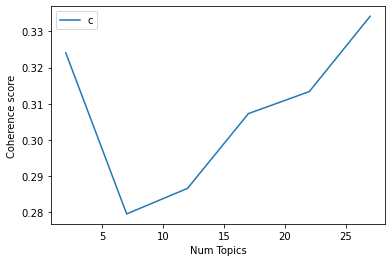

In [159]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_2021_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [160]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_2021_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 2

index: 0 | Num Topics = 2  has Coherence Value of 0.3241
index: 1 | Num Topics = 7  has Coherence Value of 0.2795
index: 2 | Num Topics = 12  has Coherence Value of 0.2866
index: 3 | Num Topics = 17  has Coherence Value of 0.3073
index: 4 | Num Topics = 22  has Coherence Value of 0.3134
index: 5 | Num Topics = 27  has Coherence Value of 0.3342


In [188]:
# Select optimal number of topics
optimal_model_us_2021_score1N2N3 = model_list_us_2021_score1N2N3[0]

In [189]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_2021_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_us_2021_score1N2N3, corpus_us_2021_score1N2N3, id2word_us_2021_score1N2N3)

In [190]:
print("pyLDAVis for us topics for score=1,2,3 in 2021:")
vis_us_2021_score1N2N3

pyLDAVis for us topics for score=1,2,3 in 2021:


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.102586  0.0       1        1  70.269078
1     -0.102586  0.0       2        1  29.730922, topic_info=         Term        Freq       Total Category  logprob  loglift
107    people   73.000000   73.000000  Default  30.0000  30.0000
269  platform   34.000000   34.000000  Default  29.0000  29.0000
6     content   47.000000   47.000000  Default  28.0000  28.0000
67      video  498.000000  498.000000  Default  27.0000  27.0000
32       tube   26.000000   26.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
138      stop   13.384095   44.555930   Topic2  -5.6811   0.0103
31       time   16.466929  111.602434   Topic2  -5.4738  -0.7006
71        app   17.626108  210.470797   Topic2  -5.4058  -1.2670
983     allow   10.973082   22.986834   Topic2  -5.8797   0.4735
207       bad   11.104899   29.979326   Topic2  -5.8678   0.2199

[144 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
36        1  0.362317  account
36        2  0.621114  account
55        1  0.734692       ad
55        2  0.267947       ad
143       1  0.995233      add
...     ...       ...      ...
125       2  0.164091      way
53        1  0.659155     well
53        2  0.329577     well
189       1  0.910843     work
189       2  0.088863     work

[177 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

# Export pyLDAvis as html

In [191]:
# Overall
pyLDAvis.save_html(vis_us,'youtube_vis_us.html')

# By-rating 
pyLDAvis.save_html(vis_us_score1,'youtube_vis_us_score1.html')
pyLDAvis.save_html(vis_us_score2,'youtube_vis_us_score2.html')
pyLDAvis.save_html(vis_us_score3,'youtube_vis_us_score3.html')
pyLDAvis.save_html(vis_us_score4,'youtube_vis_us_score4.html')
pyLDAvis.save_html(vis_us_score5,'youtube_vis_us_score5.html')
pyLDAvis.save_html(vis_us_score1N2N3,'youtube_vis_us_score1N2N3.html')

# By-rating of each year
pyLDAvis.save_html(vis_us_2021_score1N2N3,'youtube_vis_us_2021_score1N2N3.html')
pyLDAvis.save_html(vis_us_2020_score1N2N3,'youtube_vis_us_2020_score1N2N3.html')
pyLDAvis.save_html(vis_us_2019_score1N2N3,'youtube_vis_us_2019_score1N2N3.html')
pyLDAvis.save_html(vis_us_2018_score1N2N3,'youtube_vis_us_2018_score1N2N3.html')

